## setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import sys
sys.path.append('../../..')

In [5]:
from copulae.input import generate_copula_net_input


from copulae.training.cflax.mlp import MLP
from copulae.training.cflax.mlp import SingleLogitCopula as SLC

from copulae.training.cflax.bilogit import PositiveBiLogitCopula as PBLC
from copulae.training.cflax.bilogit import SiamesePositiveBiLogitCopula as SPBLC

from copulae.training.cflax.binorm import PositiveBiNormalCopula as PBNC
from copulae.training.cflax.binorm import SiamesePositiveBiNormalCopula as SPBNC

from copulae.training.cflax.mono_aux import PositiveLayer
from copulae.training.cflax.mono_aux import (
    EluPOne, Identity, ResELUPlusOne, ResSoftPlus, SoftPlus
)

from copulae.training.loss import sq_error, sq_error_partial, copula_likelihood
from copulae.training.loss import sq_frechet, sq_valid_partial, sq_valid_density
from copulae.training.loss import cross_entropy, cross_entropy_partial

from copulae.training import setup_training

In [6]:
import jax.numpy as jnp
import jax.scipy.stats as jss
import jax

from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import optax

In [7]:
from scipy import stats

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [8]:
def get_model(type, layer_widths):
  # Positive Bi Logit Copula
  if type == 'pblc':
    model = PBLC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Siamese Positive Bi Logit Copula
  elif type == 'spblc':
    model = SPBLC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        ),
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Positive Bi Normal Copula
  elif type == 'pbnc':
    model = PBNC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Siamese Positive Bi Normal Copula
  elif type == 'spbnc':
    model = SPBNC(
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        ),
        PositiveLayer(
            layer_widths,
            EluPOne, EluPOne, EluPOne
        )
    )

  # Single Logit Copula
  elif type == 'slc':
    model = SLC(
        MLP(layer_widths)
    )

  return model

In [9]:
def visualize_data(D):
  _, ax = plt.subplots(figsize=(5.5, 5))

  ax.scatter(
      D[0],
      D[1],
      s=80,
      edgecolor='k',
      alpha=0.5
  )

  plt.show()

In [10]:
def generate_gaussian(rho, sample_size=2000):
  mean = np.zeros(2)
  E = np.zeros(shape=(2, 2)) + rho
  E[0, 0] = 1
  E[1, 1] =1

  D = np.random.multivariate_normal(mean=mean, cov=E, size=(sample_size, )).T

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D


def GT_gaussian_density(points, rho):
  x = points[0]
  y = points[1]

  c_uv = (1/np.sqrt(1 - rho**2)) * np.exp( ((-1 * rho**2 * x**2 * y**2) - (2*rho*x*y)) / (2*(1 - rho**2)) )
  f_x = stats.norm.pdf(x)
  f_y = stats.norm.pdf(y)

  return c_uv * f_x * f_y

In [11]:
# Marshal and Olkin
def frank_sample(theta):
  p = 1 - np.exp(-theta)
  V = stats.logser.rvs(p)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = -1/theta * np.log( 1 - ( (1 - np.exp(-theta)) * (np.exp(-t)) ) )
  return U

# Generate Frank Copula with N(0,1) margins
def generate_frank_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = frank_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [12]:
# Marshal and Olkin
def clayton_sample(theta):
  alpha = 1 / theta
  beta = 1
  V = np.random.gamma(shape=alpha, scale=beta)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = (1 + t) ** (-1/theta)
  return U

# Generate Clayton Copula with N(0,1) margins
def generate_clayton_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = clayton_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

## New Models

In [13]:
def build_mixture(base_class, n, *args, **kwargs):
    rv = []
    for i in range(n):
        rv.append(base_class(*args, **kwargs))
    return MixtureCopula(rv)

In [14]:
from copulae.training.cflax.mixtures import FrankCopNet
from copulae.training.cflax.mixtures import GaussCopNet
from copulae.training.cflax.mixtures import FGMCopNet
from copulae.training.cflax.mixtures import DoubleIntegral
from copulae.training.cflax.mixtures import MixtureCopula

## plot

In [15]:
plt.rcParams['figure.figsize'] = (8, 5)

plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.ymargin'] = 0.1

plt.rcParams['font.family'] = 'serif'

plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgrey'
plt.rcParams['grid.linewidth'] = .1

plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.minor.width'] = .5
plt.rcParams['xtick.minor.visible'] = True

plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['ytick.left'] = True
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.minor.width'] = .5
plt.rcParams['ytick.minor.visible'] = True

plt.rcParams['legend.fontsize'] = 16

plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 10

In [16]:
plt.style.use('tableau-colorblind10')
plt.ion();

## data

In [17]:
import pandas as pd
import scipy
import copy

from sklearn.model_selection import train_test_split

In [18]:
def negative_log_likelihood(Ŷc_batches, I_pdf):
  copula_density = jnp.clip(Ŷc_batches, 1e-6)
  kde_density = jnp.clip(I_pdf, 1e-6)
  return -(jnp.log(copula_density) + jnp.log(kde_density)).mean()

In [19]:
def add_train_random_noise(data, num_adds):
  new_data = np.random.rand(num_adds, data.shape[1])
  return np.concatenate((data, new_data), axis = 0)

In [20]:
def rank_normalization(X):
  X = copy.deepcopy(X)
  for z in X:
      ndata = z.shape[0]
      gap = 1./(ndata+1)
      nfeats = z.shape[1]
      for i in range(nfeats):
          z[:, i] = scipy.stats.rankdata(z[:, i], 'ordinal')*gap
  return X

In [21]:
!git clone https://github.com/yutingng/gen-AC.git

Cloning into 'gen-AC'...
remote: Enumerating objects: 466, done.
remote: Counting objects: 100% (466/466), done.
remote: Compressing objects: 100% (339/339), done.
remote: Total 466 (delta 159), reused 421 (delta 123), pack-reused 0
Receiving objects: 100% (466/466), 10.28 MiB | 17.31 MiB/s, done.
Resolving deltas: 100% (159/159), done.


In [22]:
class Boston():
  def __init__(self):
    # read
    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep = "\s+", skiprows = 22, header = None)
    X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
    y = raw_df.values[1::2, 2]

    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 142857)
    X_train = np.concatenate((X_train, y_train[:, None]), axis = 1)
    X_test  = np.concatenate((X_test, y_test[:, None]), axis = 1)

    # norm
    [X_train, X_test] = rank_normalization([X_train, X_test])

    # noise
    X_train = add_train_random_noise(X_train, int(X_train.shape[0]*0.01))

    # 2d
    train_data = X_train[:, [0, 13]]
    test_data = X_test[:, [0, 13]]

    # flip
    train_data[:, 0] = 1 - train_data[:, 0]
    test_data[:, 0] = 1 - test_data[:, 0]

    self.train_y = train_data[:, 1].reshape(-1, 1)
    self.train_x = train_data[:, 0].reshape(-1, 1)
    self.validation_y = test_data[:, 1].reshape(-1, 1)
    self.validation_x = test_data[:, 0].reshape(-1, 1)

In [23]:
np.random.seed(30091985)

In [24]:
key = jax.random.PRNGKey(30091985)

## imshow

In [25]:
from scipy.stats import multivariate_normal

In [26]:
from jax.scipy.stats import gaussian_kde

In [27]:
def concatenate_cdfs(cdf_x, cdf_y):
  #cumulative_x = np.array(cdf_x)
  #cumulative_y = np.array(cdf_y)

  #cumulative_x = np.expand_dims(cumulative_x, axis=0)
  #cumulative_y = np.expand_dims(cumulative_y, axis=0)

  XY_cumulatives = jnp.concatenate((cdf_x, cdf_y), axis=0)
  #XY_cumulatives = jnp.asarray(XY_cumulatives)
  XY_cumulatives = jnp.expand_dims(XY_cumulatives, axis=0)

  return XY_cumulatives

In [28]:
def get_density_graph_data2(data_points):
  LOW = 0
  HIGH = 1
  npts = 800

  side = jnp.linspace(LOW, HIGH, npts)
  xx, yy = jnp.meshgrid(side, side)
  points = jnp.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]).T
  points = jnp.expand_dims(points, axis=0)

  # PDF and CDF for X
  kde_x = gaussian_kde(data_points[0], bw_method='silverman')
  densities = kde_x.evaluate(side)
  cumulatives = jnp.array([kde_x.integrate_box_1d(-jnp.inf, p) for p in side])

  density_x, _ = jnp.meshgrid(densities, densities)
  density_x = density_x.reshape(-1, 1)
  cumulative_x, _ = jnp.meshgrid(cumulatives, cumulatives)
  cumulative_x = cumulative_x.reshape(-1, 1)

  # PDF and CDF for Y
  kde_y = gaussian_kde(data_points[1], bw_method='silverman')
  densities = kde_y.evaluate(side)
  cumulatives = jnp.array([kde_y.integrate_box_1d(-jnp.inf, p) for p in side])

  _, density_y = jnp.meshgrid(densities, densities)
  density_y = density_y.reshape(-1, 1)
  _, cumulative_y = jnp.meshgrid(cumulatives, cumulatives)
  cumulative_y = cumulative_y.reshape(-1, 1)

  I_pdf = density_x.T * density_y.T
  cdf_xy = concatenate_cdfs(cumulative_x.T, cumulative_y.T)

  del density_x
  del density_y
  del cumulative_x
  del cumulative_y
  del _

  return points, I_pdf, cdf_xy

In [29]:
def make_density_plot(points, joint_density):
  points = points[0]
  heatmap, xedges, yedges = np.histogram2d(points[0], points[1], bins=100, weights=joint_density[0])
  #extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

  fig, axes = plt.subplots(1, 1, figsize=(5.5 * 3, 5))
  ax = axes

  N = points.shape[1]

  ax.invert_yaxis()
  ax.imshow(joint_density[0].reshape(N, N), origin='lower')
  #ax.imshow(heatmap.T, origin = 'lower')
  ax.get_xaxis().set_ticks([])
  ax.get_yaxis().set_ticks([])

  plt.show()

## utils

In [30]:
def L_d(losses, params, state):
  loss = jnp.zeros((1,len(losses)), dtype=jnp.float32)
  for i, (w, loss_func) in enumerate(losses):
    loss = loss.at[0, i].set(w * loss_func(params, state))
  return loss

In [31]:
losses_eval = [
    (1.0, sq_error),
    (1.0, sq_error_partial),
    (1.0, copula_likelihood),

    # (1.0, sq_valid),
    # (1.0, sq_valid_partial),
    # (1.0, sq_valid_density),
    # (1.0, sq_frechet),
]

In [32]:
def plot_yyhat(state, TrainingTensors):
  fig, axes = plt.subplots(1, 3, figsize=(5.5 * 3, 5))
  axes[0].scatter(state.ŶC_batches[0], TrainingTensors[5][0]);
  # axes[0].set(xlim = (0, 1), ylim = (0, 1), )
  axes[0].set(xlim = (min(0, np.min(state.ŶC_batches[0])), max(1, np.max(cop_state.ŶC_batches[0]))), ylim = (0, 1), )
  axes[1].scatter(state.ŶdC_batches[0][0], TrainingTensors[4][0][0]);
  # axes[1].set(xlim = (0, 1), ylim = (0, 1), )
  axes[1].set(xlim = (min(0, np.min(state.ŶdC_batches[0][0])), max(1, np.max(cop_state.ŶdC_batches[0][0]))), ylim = (0, 1), )
  axes[2].scatter(state.ŶdC_batches[0][1], TrainingTensors[4][0][1]);
  # axes[2].set(xlim = (0, 1), ylim = (0, 1), )
  axes[2].set(xlim = (min(0, np.min(state.ŶdC_batches[0][1])), max(1, np.max(cop_state.ŶdC_batches[0][1]))), ylim = (0, 1), )
  plt.show()

In [33]:
def test_set(D_val, data_points):
  # LOW = 0
  # HIGH = 1
  # npts = 800

  # side = jnp.linspace(LOW, HIGH, npts)
  # xx, yy = jnp.meshgrid(side, side)
  # points = jnp.hstack([xx.reshape(-1, 1), yy.reshape(-1, 1)]).T
  points = D_val
  points = jnp.expand_dims(points, axis=0)

  # PDF and CDF for X
  kde_x = gaussian_kde(data_points[0], bw_method='silverman')
  density_x = kde_x.evaluate(points[0, 0, :])
  cumulative_x = jnp.array([kde_x.integrate_box_1d(-jnp.inf, p) for p in points[0, 0, :]])

  # density_x, _ = jnp.meshgrid(densities, densities)
  # density_x = density_x.reshape(-1, 1)
  # cumulative_x, _ = jnp.meshgrid(cumulatives, cumulatives)
  # cumulative_x = cumulative_x.reshape(-1, 1)

  # PDF and CDF for Y
  kde_y = gaussian_kde(data_points[1], bw_method='silverman')
  density_y = kde_y.evaluate(points[0, 1, :])
  cumulative_y = jnp.array([kde_y.integrate_box_1d(-jnp.inf, p) for p in points[0, 1, :]])

  # _, density_y = jnp.meshgrid(densities, densities)
  # density_y = density_y.reshape(-1, 1)
  # _, cumulative_y = jnp.meshgrid(cumulatives, cumulatives)
  # cumulative_y = cumulative_y.reshape(-1, 1)

  I_pdf = density_x.T * density_y.T
  I_pdf = jnp.expand_dims(I_pdf, axis=0)
  # cdf_xy = concatenate_cdfs(cumulative_x.T, cumulative_y.T)
  cdf_xy = jnp.array((cumulative_x, cumulative_y))
  cdf_xy = jnp.expand_dims(cdf_xy, axis=0)

  del density_x
  del density_y
  del cumulative_x
  del cumulative_y

  return points, I_pdf, cdf_xy

In [34]:
def plot_log(log, lim = None):
  fig, axes = plt.subplots(1, 3, figsize=(5.5 * 3, 5))
  axes[0].plot(np.array(log)[:, 0, 0]);
  axes[1].plot(np.array(log)[:, 0, 1]);
  axes[2].plot(np.array(log)[:, 0, 2]);
  axes[2].set(ylim = lim, )
  plt.show()

In [35]:
def sanity(state, nn_c, params):
  density_graph_points, I_pdf, cdf_xy = get_density_graph_data2(state.X_batches[0])

  copula_density = nn_c(params, cdf_xy)
  points_density = copula_density * I_pdf

  points = density_graph_points[0]
  #heatmap, xedges, yedges = np.histogram2d(points[0], points[1], bins=100, weights = points_density[0])
  #logheatmap, xedges, yedges = np.histogram2d(points[0], points[1], bins=100, weights = np.log(jnp.clip(points_density[0], 1e-6)))
  #extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

  N = int(np.sqrt(points.shape[1]))
  heatmap = points_density[0].reshape(N,N)
  logheatmap = np.log(jnp.clip(points_density[0], 1e-6)).reshape(N,N)

  fig, axes = plt.subplots(1, 3, figsize=(5.5 * 3, 5))

  axes[0].scatter(
      cop_state.X_batches[0][0, :],
      cop_state.X_batches[0][1, :],
      s=80,
      edgecolor='k',
      alpha=0.5
  );

  axes[1].invert_yaxis()
  #axes[1].imshow(heatmap.T, origin = 'lower')
  axes[1].imshow(heatmap, origin = 'lower')
  axes[1].get_xaxis().set_ticks([])
  axes[1].get_yaxis().set_ticks([])

  axes[2].invert_yaxis()
  #axes[2].imshow(logheatmap.T, origin = 'lower')
  axes[2].imshow(logheatmap, origin = 'lower')
  axes[2].get_xaxis().set_ticks([])
  axes[2].get_yaxis().set_ticks([])
  plt.show()

In [36]:
import flax.linen as nn

from copulae.typing import Sequence
from copulae.typing import Tensor

class LogitPDFNet(nn.Module):
    layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        a = jnp.clip(U.T, 0, 1)
        z = nn.Dense(self.layers[0])(a)
        a = nn.relu(z)

        for layer_width in self.layers[1:]:
            z = nn.Dense(layer_width)(a)
            a = nn.relu(z)

        z = nn.Dense(1)(a)
        e = jnp.exp(-z)
        return e / (1 + e)

class NormalPDFNet(nn.Module):
    layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        a = jnp.clip(U.T, 0, 1)
        z = nn.Dense(self.layers[0])(a)
        a = nn.relu(z)

        for layer_width in self.layers[1:]:
            z = nn.Dense(layer_width)(a)
            a = nn.relu(z)

        z = nn.Dense(1)(a)
        return jss.norm.pdf(z)

In [37]:
class MixtureLogitPDF(nn.Module):
    n_components: int
    base_layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        weights = self.param(
            'weights',
            jax.nn.initializers.lecun_normal(),
            (self.n_components, 1)
        )

        weights = nn.softmax(weights)

        rv = 0.0
        for i in range(self.n_components):
            rv += LogitPDFNet(self.base_layers)(U) * weights[i, 0]
        return rv


class MixtureNormalPDF(nn.Module):
    n_components: int
    base_layers: Sequence[int]

    @nn.compact
    def __call__(self, U: Tensor) -> Tensor:
        weights = self.param(
            'weights',
            jax.nn.initializers.lecun_normal(),
            (self.n_components, 1)
        )

        weights = nn.softmax(weights)

        rv = 0.0
        for i in range(self.n_components):
            rv += NormalPDFNet(self.base_layers)(U) * weights[i, 0]
        return rv

## PARAMS

In [38]:
layer_widths = [128, 64, 32, 16]

losses = [
    (0.01, sq_error),
    (0.5, sq_error_partial),
    (0.1, copula_likelihood),
]

lr = 2e-3

n_iter = 10000

## Train

In [39]:
import pickle
from scipy.stats import bootstrap
from copulae.training.cflax.mixtures import LogitPDFNet
from copulae.training.cflax.mixtures import NormalPDFNet

In [40]:
MODELS_PATH = os.path.join('drive', 'MyDrive', 'copulas', 'models', '2cats_SG')
os.makedirs(MODELS_PATH, exist_ok=True)

def get_model():
  return  PBNC(NormalPDFNet(layer_widths))

In [41]:
def run(TrainingTensors, train_D, test_D, key, dataset_name):
  model = get_model()

  nn_C, nn_dC, nn_c, cop_state, forward, grad = setup_training(
      model, TrainingTensors, losses
  )

  key, subkey = jax.random.split(key)
  init_params = model.init(subkey, TrainingTensors.UV_batches[0])
  del subkey

  params = init_params
  optimizer = optax.adam(lr)
  opt_state = optimizer.init(params)

  log = []
  best = 1e6
  for i in tqdm(range(n_iter)):
      grads, cop_state = grad(params, cop_state)
      updates, opt_state = optimizer.update(grads, opt_state)
      params = optax.apply_updates(params, updates)
      if i % 10 == 0:
          loss = L_d(losses_eval, params, cop_state)
          if loss[0][-1] < best:
            best_params = params
            best_cop_state = cop_state
            best = loss[0][-1]
          log.append([l for l in loss])
          print('Iter {}. Loss {}'.format(i, loss))


  density_graph_points, I_pdf, cdf_xy = test_set(test_D, best_cop_state.X_batches[0])
  copula_density = nn_c(best_params, cdf_xy)
  points_density = copula_density * I_pdf
  yhat = -np.log(jnp.clip(points_density, 1e-6))
  L_d(losses_eval, best_params, best_cop_state), np.mean(yhat)

  res = bootstrap(yhat, np.mean)

  with open(os.path.join(MODELS_PATH, dataset_name + '.txt'), 'w') as fp:
    fp.write(f'nll: {np.mean(yhat)}\n{res.standard_error}\n{res.confidence_interval}')

  with open(os.path.join(MODELS_PATH, dataset_name + '.pkl'), 'wb') as fp:
    pickle.dump(best_params, fp)

## Gauss $\rho=0.1$

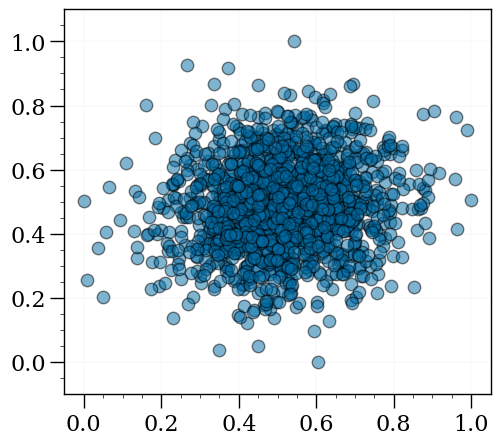

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

rho = 0.1
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
run(TrainingTensors, train_D, test_D, key, 'gauss_01')

  0%|          | 1/10000 [01:18<217:30:20, 78.31s/it]

Iter 0. Loss [[ 0.05614882  0.27405217 19.051315  ]]


  0%|          | 11/10000 [02:17<4:28:35,  1.61s/it]

Iter 10. Loss [[0.05672044 0.26190802 6.96913   ]]


  0%|          | 21/10000 [02:20<1:15:00,  2.22it/s]

Iter 20. Loss [[0.05671195 0.26065886 6.4937615 ]]


  0%|          | 31/10000 [02:23<40:42,  4.08it/s]

Iter 30. Loss [[0.05710344 0.25890854 6.023807  ]]


  0%|          | 41/10000 [02:26<38:33,  4.30it/s]

Iter 40. Loss [[0.05776935 0.25660548 5.3391404 ]]


  1%|          | 51/10000 [02:29<44:30,  3.72it/s]

Iter 50. Loss [[0.0587818  0.25401396 4.8235    ]]


  1%|          | 61/10000 [02:31<36:21,  4.56it/s]

Iter 60. Loss [[0.06079233 0.25254735 4.8807726 ]]


  1%|          | 71/10000 [02:34<56:20,  2.94it/s]

Iter 70. Loss [[0.06325137 0.25032923 5.0189395 ]]


  1%|          | 81/10000 [02:38<54:30,  3.03it/s]  

Iter 80. Loss [[0.06585044 0.24815397 5.153498  ]]


  1%|          | 91/10000 [02:40<37:29,  4.40it/s]

Iter 90. Loss [[0.06853531 0.24641989 5.399412  ]]


  1%|          | 101/10000 [02:42<37:11,  4.44it/s]

Iter 100. Loss [[0.07073049 0.24536568 5.586508  ]]


  1%|          | 111/10000 [02:45<40:43,  4.05it/s]

Iter 110. Loss [[0.0722032  0.24404882 5.6251493 ]]


  1%|          | 121/10000 [02:48<1:10:53,  2.32it/s]

Iter 120. Loss [[0.07318725 0.24285021 5.5921273 ]]


  1%|▏         | 131/10000 [02:51<57:11,  2.88it/s]  

Iter 130. Loss [[0.07382517 0.24144697 5.4988465 ]]


  1%|▏         | 141/10000 [02:54<40:40,  4.04it/s]

Iter 140. Loss [[0.07439668 0.23899585 5.342059  ]]


  2%|▏         | 151/10000 [02:56<54:12,  3.03it/s]

Iter 150. Loss [[0.07525107 0.236974   5.3501883 ]]


  2%|▏         | 161/10000 [02:59<35:55,  4.57it/s]

Iter 160. Loss [[0.07581592 0.23586552 5.458101  ]]


  2%|▏         | 171/10000 [03:01<40:20,  4.06it/s]

Iter 170. Loss [[0.07535239 0.23402636 5.463682  ]]


  2%|▏         | 181/10000 [03:05<1:23:57,  1.95it/s]

Iter 180. Loss [[0.07436677 0.23187535 5.3943996 ]]


  2%|▏         | 191/10000 [03:08<39:16,  4.16it/s]

Iter 190. Loss [[0.07343155 0.22960046 5.259939  ]]


  2%|▏         | 201/10000 [03:10<38:28,  4.25it/s]

Iter 200. Loss [[0.07293815 0.2264228  5.096079  ]]


  2%|▏         | 211/10000 [03:13<1:05:48,  2.48it/s]

Iter 210. Loss [[0.07333051 0.2232172  5.032472  ]]


  2%|▏         | 221/10000 [03:17<1:06:30,  2.45it/s]

Iter 220. Loss [[0.07423341 0.2203182  4.9870863 ]]


  2%|▏         | 232/10000 [03:21<45:39,  3.57it/s]

Iter 230. Loss [[0.07534494 0.21630102 4.870442  ]]


  2%|▏         | 241/10000 [03:24<48:20,  3.37it/s]

Iter 240. Loss [[0.07698426 0.21118832 4.704614  ]]


  3%|▎         | 251/10000 [03:26<35:36,  4.56it/s]

Iter 250. Loss [[0.07949273 0.20519514 4.5192447 ]]


  3%|▎         | 261/10000 [03:28<36:40,  4.43it/s]

Iter 260. Loss [[0.0831538  0.19798023 4.294524  ]]


  3%|▎         | 271/10000 [03:31<44:52,  3.61it/s]

Iter 270. Loss [[0.08842371 0.18895467 4.0391407 ]]


  3%|▎         | 281/10000 [03:34<58:21,  2.78it/s]

Iter 280. Loss [[0.09613505 0.17739783 3.7384322 ]]


  3%|▎         | 291/10000 [03:37<37:51,  4.27it/s]

Iter 290. Loss [[0.10758612 0.16232555 3.386268  ]]


  3%|▎         | 301/10000 [03:40<44:13,  3.66it/s]

Iter 300. Loss [[0.12434787 0.14232601 2.9730785 ]]


  3%|▎         | 311/10000 [03:42<35:15,  4.58it/s]

Iter 310. Loss [[0.15308903 0.11405162 2.5203183 ]]


  3%|▎         | 321/10000 [03:44<35:51,  4.50it/s]

Iter 320. Loss [[0.18262613 0.07549311 1.8095169 ]]


  3%|▎         | 331/10000 [03:48<1:04:32,  2.50it/s]

Iter 330. Loss [[0.2336372 0.0332925 0.9898328]]


  3%|▎         | 341/10000 [03:51<37:56,  4.24it/s]

Iter 340. Loss [[0.27253637 0.02443885 0.53842974]]


  4%|▎         | 351/10000 [03:53<35:31,  4.53it/s]

Iter 350. Loss [[0.26932675 0.02398576 0.570265  ]]


  4%|▎         | 361/10000 [03:56<40:48,  3.94it/s]

Iter 360. Loss [[0.26581675 0.01676749 0.5687908 ]]


  4%|▎         | 371/10000 [03:58<35:36,  4.51it/s]

Iter 370. Loss [[0.27349335 0.02325347 0.52567446]]


  4%|▍         | 381/10000 [04:01<54:43,  2.93it/s]

Iter 380. Loss [[0.2726379  0.02126285 0.53061175]]


  4%|▍         | 391/10000 [04:05<46:16,  3.46it/s]

Iter 390. Loss [[0.2716011  0.01973267 0.537364  ]]


  4%|▍         | 401/10000 [04:07<35:48,  4.47it/s]

Iter 400. Loss [[0.27318785 0.02134579 0.52880377]]


  4%|▍         | 411/10000 [04:09<36:47,  4.34it/s]

Iter 410. Loss [[0.27278283 0.02089645 0.53073007]]


  4%|▍         | 421/10000 [04:12<37:43,  4.23it/s]

Iter 420. Loss [[0.27245313 0.02057972 0.53237486]]


  4%|▍         | 431/10000 [04:15<1:10:41,  2.26it/s]

Iter 430. Loss [[0.2727737  0.02094004 0.5305103 ]]


  4%|▍         | 441/10000 [04:18<53:18,  2.99it/s]

Iter 440. Loss [[0.27266216 0.02081995 0.5311074 ]]


  5%|▍         | 451/10000 [04:21<40:39,  3.91it/s]

Iter 450. Loss [[0.27262142 0.02077246 0.531351  ]]


  5%|▍         | 461/10000 [04:24<49:29,  3.21it/s]

Iter 460. Loss [[0.27269277 0.02084566 0.5309758 ]]


  5%|▍         | 471/10000 [04:26<36:33,  4.34it/s]

Iter 470. Loss [[0.2726634  0.02081178 0.53114736]]


  5%|▍         | 481/10000 [04:29<45:03,  3.52it/s]

Iter 480. Loss [[0.27266338 0.02081076 0.5311523 ]]


  5%|▍         | 491/10000 [04:33<1:04:41,  2.45it/s]

Iter 490. Loss [[0.27267435 0.02082255 0.53109187]]


  5%|▌         | 501/10000 [04:35<35:22,  4.48it/s]

Iter 500. Loss [[0.27266678 0.02081434 0.5311333 ]]


  5%|▌         | 511/10000 [04:37<36:35,  4.32it/s]

Iter 510. Loss [[0.27266884 0.02081661 0.53112155]]


  5%|▌         | 521/10000 [04:40<44:00,  3.59it/s]

Iter 520. Loss [[0.2726697  0.02081749 0.53111666]]


  5%|▌         | 531/10000 [04:42<33:58,  4.64it/s]

Iter 530. Loss [[0.27266848 0.02081612 0.53112346]]


  5%|▌         | 541/10000 [04:46<58:08,  2.71it/s]

Iter 540. Loss [[0.2726693  0.02081695 0.5311189 ]]


  6%|▌         | 551/10000 [04:49<41:57,  3.75it/s]

Iter 550. Loss [[0.27266905 0.02081671 0.53111994]]


  6%|▌         | 561/10000 [04:51<34:10,  4.60it/s]

Iter 560. Loss [[0.272669   0.02081664 0.53111994]]


  6%|▌         | 571/10000 [04:54<35:07,  4.47it/s]

Iter 570. Loss [[0.27266908 0.02081679 0.53111887]]


  6%|▌         | 581/10000 [04:56<40:40,  3.86it/s]

Iter 580. Loss [[0.272669   0.0208167  0.53111905]]


  6%|▌         | 591/10000 [04:59<54:14,  2.89it/s]

Iter 590. Loss [[0.272669   0.02081672 0.53111863]]


  6%|▌         | 601/10000 [05:02<38:34,  4.06it/s]

Iter 600. Loss [[0.27266905 0.02081674 0.53111833]]


  6%|▌         | 611/10000 [05:05<38:33,  4.06it/s]

Iter 610. Loss [[0.27266902 0.02081673 0.5311181 ]]


  6%|▌         | 621/10000 [05:07<35:29,  4.40it/s]

Iter 620. Loss [[0.27266908 0.02081675 0.5311177 ]]


  6%|▋         | 631/10000 [05:10<34:15,  4.56it/s]

Iter 630. Loss [[0.27266905 0.02081674 0.53111744]]


  6%|▋         | 641/10000 [05:13<56:37,  2.75it/s]

Iter 640. Loss [[0.27266905 0.02081675 0.5311171 ]]


  7%|▋         | 651/10000 [05:17<1:03:07,  2.47it/s]

Iter 650. Loss [[0.27266908 0.02081676 0.5311168 ]]


  7%|▋         | 661/10000 [05:19<35:40,  4.36it/s]

Iter 660. Loss [[0.27266908 0.02081676 0.5311164 ]]


  7%|▋         | 671/10000 [05:21<35:55,  4.33it/s]

Iter 670. Loss [[0.27266914 0.02081676 0.53111607]]


  7%|▋         | 681/10000 [05:24<48:19,  3.21it/s]

Iter 680. Loss [[0.27266914 0.02081677 0.5311158 ]]


  7%|▋         | 691/10000 [05:27<48:03,  3.23it/s]

Iter 690. Loss [[0.2726691  0.02081677 0.5311154 ]]


  7%|▋         | 701/10000 [05:30<49:21,  3.14it/s]

Iter 700. Loss [[0.27266917 0.02081678 0.53111506]]


  7%|▋         | 711/10000 [05:33<44:22,  3.49it/s]

Iter 710. Loss [[0.27266917 0.02081677 0.53111476]]


  7%|▋         | 721/10000 [05:35<34:08,  4.53it/s]

Iter 720. Loss [[0.27266914 0.02081677 0.5311144 ]]


  7%|▋         | 731/10000 [05:38<37:50,  4.08it/s]

Iter 730. Loss [[0.27266917 0.02081678 0.531114  ]]


  7%|▋         | 741/10000 [05:41<56:03,  2.75it/s]

Iter 740. Loss [[0.27266917 0.02081678 0.5311136 ]]


  8%|▊         | 751/10000 [05:45<56:51,  2.71it/s]

Iter 750. Loss [[0.27266917 0.02081678 0.53111327]]


  8%|▊         | 761/10000 [05:47<35:36,  4.32it/s]

Iter 760. Loss [[0.2726692 0.0208168 0.5311129]]


  8%|▊         | 771/10000 [05:50<42:58,  3.58it/s]

Iter 770. Loss [[0.27266923 0.0208168  0.53111273]]


  8%|▊         | 781/10000 [05:52<35:16,  4.36it/s]

Iter 780. Loss [[0.27266923 0.0208168  0.5311123 ]]


  8%|▊         | 791/10000 [05:55<36:24,  4.22it/s]

Iter 790. Loss [[0.27266923 0.0208168  0.5311119 ]]


  8%|▊         | 801/10000 [05:59<1:03:05,  2.43it/s]

Iter 800. Loss [[0.2726693  0.02081682 0.5311115 ]]


  8%|▊         | 811/10000 [06:01<34:27,  4.44it/s]

Iter 810. Loss [[0.2726693  0.02081682 0.5311112 ]]


  8%|▊         | 821/10000 [06:04<33:42,  4.54it/s]

Iter 820. Loss [[0.2726693  0.02081683 0.5311108 ]]


  8%|▊         | 831/10000 [06:06<39:41,  3.85it/s]

Iter 830. Loss [[0.2726693  0.02081683 0.5311104 ]]


  8%|▊         | 841/10000 [06:08<33:51,  4.51it/s]

Iter 840. Loss [[0.27266908 0.02081688 0.5311181 ]]


  9%|▊         | 851/10000 [06:12<56:30,  2.70it/s]

Iter 850. Loss [[0.27266923 0.02081694 0.5311175 ]]


  9%|▊         | 861/10000 [06:16<56:27,  2.70it/s]

Iter 860. Loss [[0.27266923 0.0208169  0.5311176 ]]


  9%|▊         | 871/10000 [06:19<49:48,  3.06it/s]

Iter 870. Loss [[0.27266923 0.02081693 0.5311173 ]]


  9%|▉         | 881/10000 [06:22<35:14,  4.31it/s]

Iter 880. Loss [[0.27266932 0.02081691 0.53111726]]


  9%|▉         | 891/10000 [06:25<56:05,  2.71it/s]

Iter 890. Loss [[0.2726693  0.02081692 0.5311171 ]]


  9%|▉         | 901/10000 [06:29<1:04:36,  2.35it/s]

Iter 900. Loss [[0.27266926 0.02081692 0.53111684]]


  9%|▉         | 911/10000 [06:31<34:37,  4.37it/s]

Iter 910. Loss [[0.2726693  0.02081693 0.53111666]]


  9%|▉         | 921/10000 [06:34<36:47,  4.11it/s]

Iter 920. Loss [[0.2726693  0.02081693 0.53111655]]


  9%|▉         | 931/10000 [06:37<56:50,  2.66it/s]

Iter 930. Loss [[0.27266926 0.02081692 0.5311163 ]]


  9%|▉         | 941/10000 [06:40<53:32,  2.82it/s]

Iter 940. Loss [[0.2726693  0.02081693 0.5311162 ]]


 10%|▉         | 951/10000 [06:43<42:03,  3.59it/s]

Iter 950. Loss [[0.2726693  0.02081693 0.5311159 ]]


 10%|▉         | 961/10000 [06:46<47:50,  3.15it/s]

Iter 960. Loss [[0.2726693  0.02081692 0.5311159 ]]


 10%|▉         | 971/10000 [06:48<34:20,  4.38it/s]

Iter 970. Loss [[0.2726693  0.02081693 0.5311158 ]]


 10%|▉         | 981/10000 [06:51<37:39,  3.99it/s]

Iter 980. Loss [[0.27266923 0.02081696 0.53112197]]


 10%|▉         | 991/10000 [06:54<1:04:07,  2.34it/s]

Iter 990. Loss [[0.2726694  0.02081711 0.5311212 ]]


 10%|█         | 1001/10000 [06:58<40:29,  3.70it/s]

Iter 1000. Loss [[0.27266935 0.02081703 0.5311215 ]]


 10%|█         | 1011/10000 [07:00<36:00,  4.16it/s]

Iter 1010. Loss [[0.2726694  0.02081707 0.5311213 ]]


 10%|█         | 1021/10000 [07:03<40:34,  3.69it/s]

Iter 1020. Loss [[0.27266937 0.02081705 0.53112125]]


 10%|█         | 1031/10000 [07:05<34:59,  4.27it/s]

Iter 1030. Loss [[0.27266937 0.02081706 0.5311212 ]]


 10%|█         | 1041/10000 [07:08<54:09,  2.76it/s]

Iter 1040. Loss [[0.27266937 0.02081705 0.53112113]]


 11%|█         | 1051/10000 [07:12<49:23,  3.02it/s]

Iter 1050. Loss [[0.2726694  0.02081705 0.5311211 ]]


 11%|█         | 1061/10000 [07:14<32:46,  4.54it/s]

Iter 1060. Loss [[0.2726694  0.02081706 0.531121  ]]


 11%|█         | 1071/10000 [07:17<33:50,  4.40it/s]

Iter 1070. Loss [[0.2726694  0.02081706 0.5311209 ]]


 11%|█         | 1081/10000 [07:19<39:30,  3.76it/s]

Iter 1080. Loss [[0.2726694  0.02081706 0.53112084]]


 11%|█         | 1091/10000 [07:22<41:27,  3.58it/s]

Iter 1090. Loss [[0.2726694  0.02081707 0.53112066]]


 11%|█         | 1101/10000 [07:26<50:47,  2.92it/s]

Iter 1100. Loss [[0.2726694  0.02081706 0.53112066]]


 11%|█         | 1111/10000 [07:29<37:44,  3.93it/s]

Iter 1110. Loss [[0.2726694  0.02081706 0.5311206 ]]


 11%|█         | 1121/10000 [07:31<32:27,  4.56it/s]

Iter 1120. Loss [[0.2726694  0.02081706 0.53112054]]


 11%|█▏        | 1131/10000 [07:33<34:00,  4.35it/s]

Iter 1130. Loss [[0.2726694  0.02081707 0.5311204 ]]


 11%|█▏        | 1141/10000 [07:36<41:56,  3.52it/s]

Iter 1140. Loss [[0.2726694  0.02081707 0.53112036]]


 12%|█▏        | 1151/10000 [07:40<1:18:29,  1.88it/s]

Iter 1150. Loss [[0.2726694  0.02081707 0.5311204 ]]


 12%|█▏        | 1161/10000 [07:43<34:21,  4.29it/s]

Iter 1160. Loss [[0.2726694  0.02081707 0.53112036]]


 12%|█▏        | 1171/10000 [07:45<35:04,  4.20it/s]

Iter 1170. Loss [[0.2726694  0.02081707 0.5311203 ]]


 12%|█▏        | 1181/10000 [07:48<51:17,  2.87it/s]

Iter 1180. Loss [[0.2726694  0.02081707 0.5311203 ]]


 12%|█▏        | 1191/10000 [07:50<33:57,  4.32it/s]

Iter 1190. Loss [[0.2726694  0.02081707 0.5311202 ]]


 12%|█▏        | 1201/10000 [07:54<57:42,  2.54it/s]

Iter 1200. Loss [[0.2726694  0.02081707 0.5311201 ]]


 12%|█▏        | 1211/10000 [07:57<46:43,  3.14it/s]

Iter 1210. Loss [[0.2726694  0.02081707 0.5311201 ]]


 12%|█▏        | 1221/10000 [07:59<33:36,  4.35it/s]

Iter 1220. Loss [[0.2726694  0.02081707 0.53111994]]


 12%|█▏        | 1231/10000 [08:02<35:33,  4.11it/s]

Iter 1230. Loss [[0.2726694  0.02081707 0.53111994]]


 12%|█▏        | 1241/10000 [08:04<41:26,  3.52it/s]

Iter 1240. Loss [[0.2726694  0.02081707 0.5311198 ]]


 13%|█▎        | 1251/10000 [08:08<56:20,  2.59it/s]

Iter 1250. Loss [[0.27266943 0.02081707 0.53111976]]


 13%|█▎        | 1261/10000 [08:11<35:53,  4.06it/s]

Iter 1260. Loss [[0.2726694  0.02081707 0.5311197 ]]


 13%|█▎        | 1271/10000 [08:14<39:04,  3.72it/s]

Iter 1270. Loss [[0.2726694  0.02081707 0.53111964]]


 13%|█▎        | 1281/10000 [08:16<32:39,  4.45it/s]

Iter 1280. Loss [[0.27266943 0.02081707 0.5311195 ]]


 13%|█▎        | 1291/10000 [08:19<33:19,  4.35it/s]

Iter 1290. Loss [[0.2726694  0.02081707 0.5311195 ]]


 13%|█▎        | 1301/10000 [08:22<59:46,  2.43it/s]  

Iter 1300. Loss [[0.27266943 0.02081709 0.5311193 ]]


 13%|█▎        | 1311/10000 [08:25<34:27,  4.20it/s]

Iter 1310. Loss [[0.27266946 0.02081709 0.5311192 ]]


 13%|█▎        | 1321/10000 [08:28<32:19,  4.47it/s]

Iter 1320. Loss [[0.27266946 0.02081708 0.5311191 ]]


 13%|█▎        | 1331/10000 [08:30<35:36,  4.06it/s]

Iter 1330. Loss [[0.27266946 0.02081709 0.531119  ]]


 13%|█▎        | 1341/10000 [08:32<31:47,  4.54it/s]

Iter 1340. Loss [[0.27266946 0.02081709 0.5311191 ]]


 14%|█▎        | 1351/10000 [08:36<51:41,  2.79it/s]

Iter 1350. Loss [[0.27266946 0.02081709 0.53111905]]


 14%|█▎        | 1361/10000 [08:39<42:18,  3.40it/s]

Iter 1360. Loss [[0.27266946 0.02081709 0.531119  ]]


 14%|█▎        | 1371/10000 [08:42<47:43,  3.01it/s]

Iter 1370. Loss [[0.27266946 0.02081709 0.5311188 ]]


 14%|█▍        | 1381/10000 [08:44<33:03,  4.35it/s]

Iter 1380. Loss [[0.27266946 0.02081708 0.5311188 ]]


 14%|█▍        | 1391/10000 [08:47<34:21,  4.18it/s]

Iter 1390. Loss [[0.27266946 0.02081708 0.53111875]]


 14%|█▍        | 1401/10000 [08:50<1:08:22,  2.10it/s]

Iter 1400. Loss [[0.27266946 0.0208171  0.53111863]]


 14%|█▍        | 1411/10000 [08:53<40:08,  3.57it/s]

Iter 1410. Loss [[0.27266946 0.0208171  0.5311186 ]]


 14%|█▍        | 1421/10000 [08:56<33:41,  4.24it/s]

Iter 1420. Loss [[0.27266946 0.02081709 0.5311186 ]]


 14%|█▍        | 1431/10000 [08:58<42:51,  3.33it/s]

Iter 1430. Loss [[0.27266946 0.0208171  0.5311185 ]]


 14%|█▍        | 1441/10000 [09:00<32:18,  4.41it/s]

Iter 1440. Loss [[0.27266946 0.0208171  0.5311185 ]]


 15%|█▍        | 1451/10000 [09:03<46:08,  3.09it/s]

Iter 1450. Loss [[0.27266946 0.0208171  0.53111833]]


 15%|█▍        | 1461/10000 [09:07<58:53,  2.42it/s]  

Iter 1460. Loss [[0.27266946 0.0208171  0.5311182 ]]


 15%|█▍        | 1471/10000 [09:09<31:02,  4.58it/s]

Iter 1470. Loss [[0.27266946 0.0208171  0.53111815]]


 15%|█▍        | 1481/10000 [09:12<32:05,  4.42it/s]

Iter 1480. Loss [[0.27266946 0.0208171  0.5311181 ]]


 15%|█▍        | 1491/10000 [09:15<37:17,  3.80it/s]

Iter 1490. Loss [[0.27266946 0.0208171  0.53111815]]


 15%|█▌        | 1501/10000 [09:17<31:19,  4.52it/s]

Iter 1500. Loss [[0.27266946 0.0208171  0.5311181 ]]


 15%|█▌        | 1511/10000 [09:21<52:27,  2.70it/s]

Iter 1510. Loss [[0.27266946 0.0208171  0.531118  ]]


 15%|█▌        | 1521/10000 [09:24<37:05,  3.81it/s]

Iter 1520. Loss [[0.27266946 0.0208171  0.53111786]]


 15%|█▌        | 1531/10000 [09:27<51:51,  2.72it/s]

Iter 1530. Loss [[0.27266946 0.0208171  0.53111774]]


 15%|█▌        | 1541/10000 [09:30<32:40,  4.31it/s]

Iter 1540. Loss [[0.27266946 0.0208171  0.5311177 ]]


 16%|█▌        | 1551/10000 [09:33<52:57,  2.66it/s]

Iter 1550. Loss [[0.27266946 0.0208171  0.5311177 ]]


 16%|█▌        | 1561/10000 [09:37<56:10,  2.50it/s]

Iter 1560. Loss [[0.27266946 0.02081711 0.53111756]]


 16%|█▌        | 1571/10000 [09:39<32:27,  4.33it/s]

Iter 1570. Loss [[0.27266946 0.0208171  0.5311176 ]]


 16%|█▌        | 1581/10000 [09:42<33:58,  4.13it/s]

Iter 1580. Loss [[0.27266946 0.0208171  0.5311175 ]]


 16%|█▌        | 1591/10000 [09:44<47:58,  2.92it/s]

Iter 1590. Loss [[0.27266946 0.0208171  0.53111744]]


 16%|█▌        | 1601/10000 [09:47<47:51,  2.93it/s]

Iter 1600. Loss [[0.27266946 0.0208171  0.5311173 ]]


 16%|█▌        | 1611/10000 [09:51<41:11,  3.39it/s]

Iter 1610. Loss [[0.2726695 0.0208171 0.5311172]]


 16%|█▌        | 1621/10000 [09:54<42:58,  3.25it/s]

Iter 1620. Loss [[0.27266946 0.0208171  0.5311171 ]]


 16%|█▋        | 1631/10000 [09:56<31:31,  4.42it/s]

Iter 1630. Loss [[0.27266946 0.02081711 0.5311171 ]]


 16%|█▋        | 1641/10000 [09:58<32:30,  4.29it/s]

Iter 1640. Loss [[0.27266946 0.02081711 0.53111696]]


 17%|█▋        | 1651/10000 [10:01<51:22,  2.71it/s]

Iter 1650. Loss [[0.2726695  0.0208171  0.53111684]]


 17%|█▋        | 1661/10000 [10:05<45:47,  3.04it/s]

Iter 1660. Loss [[0.27266946 0.02081711 0.5311167 ]]


 17%|█▋        | 1671/10000 [10:08<33:15,  4.17it/s]

Iter 1670. Loss [[0.27266946 0.02081711 0.5311166 ]]


 17%|█▋        | 1681/10000 [10:10<39:16,  3.53it/s]

Iter 1680. Loss [[0.27266946 0.02081711 0.5311166 ]]


 17%|█▋        | 1691/10000 [10:12<30:14,  4.58it/s]

Iter 1690. Loss [[0.2726695  0.0208171  0.53111655]]


 17%|█▋        | 1701/10000 [10:15<38:25,  3.60it/s]

Iter 1700. Loss [[0.27266952 0.02081713 0.53111637]]


 17%|█▋        | 1711/10000 [10:19<55:36,  2.48it/s]  

Iter 1710. Loss [[0.2726695  0.02081712 0.53111625]]


 17%|█▋        | 1721/10000 [10:21<31:12,  4.42it/s]

Iter 1720. Loss [[0.27266952 0.02081713 0.5311163 ]]


 17%|█▋        | 1731/10000 [10:24<30:54,  4.46it/s]

Iter 1730. Loss [[0.27266952 0.02081712 0.5311161 ]]


 17%|█▋        | 1741/10000 [10:27<33:38,  4.09it/s]

Iter 1740. Loss [[0.27266952 0.02081712 0.5311161 ]]


 18%|█▊        | 1751/10000 [10:29<29:47,  4.62it/s]

Iter 1750. Loss [[0.2726695  0.02081713 0.53111595]]


 18%|█▊        | 1761/10000 [10:33<51:24,  2.67it/s]

Iter 1760. Loss [[0.27266952 0.02081713 0.5311159 ]]


 18%|█▊        | 1771/10000 [10:36<36:29,  3.76it/s]

Iter 1770. Loss [[0.27266952 0.02081713 0.5311158 ]]


 18%|█▊        | 1781/10000 [10:38<30:00,  4.56it/s]

Iter 1780. Loss [[0.27266955 0.02081713 0.53111565]]


 18%|█▊        | 1791/10000 [10:40<30:40,  4.46it/s]

Iter 1790. Loss [[0.2726695  0.02081712 0.53111565]]


 18%|█▊        | 1801/10000 [10:43<33:12,  4.12it/s]

Iter 1800. Loss [[0.27266952 0.02081713 0.5311155 ]]


 18%|█▊        | 1811/10000 [10:47<1:09:12,  1.97it/s]

Iter 1810. Loss [[0.27266952 0.02081713 0.5311154 ]]


 18%|█▊        | 1821/10000 [10:49<32:52,  4.15it/s]

Iter 1820. Loss [[0.27266952 0.02081714 0.5311153 ]]


 18%|█▊        | 1831/10000 [10:52<32:22,  4.21it/s]

Iter 1830. Loss [[0.27266955 0.02081713 0.53111523]]


 18%|█▊        | 1842/10000 [10:55<39:54,  3.41it/s]

Iter 1840. Loss [[0.27266952 0.02081713 0.5311152 ]]


 19%|█▊        | 1851/10000 [10:57<29:53,  4.54it/s]

Iter 1850. Loss [[0.27266952 0.02081713 0.531115  ]]


 19%|█▊        | 1861/10000 [11:00<49:15,  2.75it/s]

Iter 1860. Loss [[0.27266955 0.02081713 0.5311149 ]]


 19%|█▊        | 1871/10000 [11:03<48:57,  2.77it/s]

Iter 1870. Loss [[0.27266955 0.02081714 0.5311148 ]]


 19%|█▉        | 1881/10000 [11:06<30:22,  4.45it/s]

Iter 1880. Loss [[0.27266955 0.02081714 0.53111464]]


 19%|█▉        | 1891/10000 [11:08<31:31,  4.29it/s]

Iter 1890. Loss [[0.2726696  0.02081714 0.5311145 ]]


 19%|█▉        | 1901/10000 [11:11<36:59,  3.65it/s]

Iter 1900. Loss [[0.27266952 0.02081714 0.5311144 ]]


 19%|█▉        | 1911/10000 [11:13<36:32,  3.69it/s]

Iter 1910. Loss [[0.2726696  0.02081715 0.5311146 ]]


 19%|█▉        | 1921/10000 [11:17<47:15,  2.85it/s]

Iter 1920. Loss [[0.27266955 0.02081715 0.5311144 ]]


 19%|█▉        | 1931/10000 [11:20<37:01,  3.63it/s]

Iter 1930. Loss [[0.2726696  0.02081714 0.53111434]]


 19%|█▉        | 1941/10000 [11:22<29:37,  4.54it/s]

Iter 1940. Loss [[0.27266955 0.02081715 0.5311142 ]]


 20%|█▉        | 1951/10000 [11:24<30:40,  4.37it/s]

Iter 1950. Loss [[0.2726696  0.02081715 0.5311141 ]]


 20%|█▉        | 1961/10000 [11:27<34:16,  3.91it/s]

Iter 1960. Loss [[0.27266964 0.02081714 0.5311141 ]]


 20%|█▉        | 1971/10000 [11:30<47:56,  2.79it/s]

Iter 1970. Loss [[0.27266958 0.02081715 0.531114  ]]


 20%|█▉        | 1981/10000 [11:33<30:59,  4.31it/s]

Iter 1980. Loss [[0.2726696  0.02081731 0.5311209 ]]


 20%|█▉        | 1991/10000 [11:36<33:53,  3.94it/s]

Iter 1990. Loss [[0.27266967 0.02081725 0.5311212 ]]


 20%|██        | 2001/10000 [11:38<29:23,  4.54it/s]

Iter 2000. Loss [[0.2726696  0.02081723 0.5311213 ]]


 20%|██        | 2011/10000 [11:40<29:08,  4.57it/s]

Iter 2010. Loss [[0.27266967 0.02081728 0.53112113]]


 20%|██        | 2021/10000 [11:44<51:32,  2.58it/s]

Iter 2020. Loss [[0.27266955 0.02081725 0.5311212 ]]


 20%|██        | 2031/10000 [11:47<47:42,  2.78it/s]

Iter 2030. Loss [[0.27266955 0.02081724 0.5311212 ]]


 20%|██        | 2041/10000 [11:49<29:21,  4.52it/s]

Iter 2040. Loss [[0.27266958 0.02081726 0.5311212 ]]


 21%|██        | 2051/10000 [11:52<30:28,  4.35it/s]

Iter 2050. Loss [[0.27266958 0.02081725 0.53112125]]


 21%|██        | 2061/10000 [11:54<39:38,  3.34it/s]

Iter 2060. Loss [[0.27266958 0.02081725 0.53112125]]


 21%|██        | 2071/10000 [11:57<41:44,  3.17it/s]

Iter 2070. Loss [[0.27266958 0.02081726 0.5311212 ]]


 21%|██        | 2081/10000 [12:01<38:44,  3.41it/s]

Iter 2080. Loss [[0.27266955 0.02081725 0.53112125]]


 21%|██        | 2091/10000 [12:03<35:59,  3.66it/s]

Iter 2090. Loss [[0.27266958 0.02081726 0.53112125]]


 21%|██        | 2101/10000 [12:05<29:04,  4.53it/s]

Iter 2100. Loss [[0.27266958 0.02081725 0.5311212 ]]


 21%|██        | 2111/10000 [12:08<30:07,  4.37it/s]

Iter 2110. Loss [[0.27266958 0.02081725 0.5311212 ]]


 21%|██        | 2121/10000 [12:11<42:20,  3.10it/s]

Iter 2120. Loss [[0.27266958 0.02081725 0.5311212 ]]


 21%|██▏       | 2131/10000 [12:15<48:41,  2.69it/s]

Iter 2130. Loss [[0.27266958 0.02081725 0.5311212 ]]


 21%|██▏       | 2141/10000 [12:17<30:00,  4.36it/s]

Iter 2140. Loss [[0.27266958 0.02081725 0.5311212 ]]


 22%|██▏       | 2151/10000 [12:20<31:58,  4.09it/s]

Iter 2150. Loss [[0.2726696  0.02081727 0.5311212 ]]


 22%|██▏       | 2161/10000 [12:22<28:33,  4.58it/s]

Iter 2160. Loss [[0.27266958 0.02081726 0.5311212 ]]


 22%|██▏       | 2172/10000 [12:25<28:28,  4.58it/s]

Iter 2170. Loss [[0.27266958 0.02081726 0.53112125]]


 22%|██▏       | 2181/10000 [12:28<49:57,  2.61it/s]

Iter 2180. Loss [[0.27266958 0.02081726 0.53112125]]


 22%|██▏       | 2191/10000 [12:31<44:34,  2.92it/s]

Iter 2190. Loss [[0.27266955 0.02081726 0.5311213 ]]


 22%|██▏       | 2201/10000 [12:34<36:59,  3.51it/s]

Iter 2200. Loss [[0.27266958 0.02081726 0.5311212 ]]


 22%|██▏       | 2211/10000 [12:38<45:46,  2.84it/s]

Iter 2210. Loss [[0.27266958 0.02081725 0.53112125]]


 22%|██▏       | 2221/10000 [12:41<59:52,  2.17it/s]

Iter 2220. Loss [[0.2726696  0.02081726 0.5311212 ]]


 22%|██▏       | 2231/10000 [12:44<37:58,  3.41it/s]

Iter 2230. Loss [[0.27266958 0.02081726 0.5311211 ]]


 22%|██▏       | 2241/10000 [12:47<31:37,  4.09it/s]

Iter 2240. Loss [[0.2726696  0.02081726 0.5311212 ]]


 23%|██▎       | 2251/10000 [12:49<39:57,  3.23it/s]

Iter 2250. Loss [[0.27266958 0.02081726 0.5311212 ]]


 23%|██▎       | 2261/10000 [12:51<29:12,  4.42it/s]

Iter 2260. Loss [[0.27266958 0.02081726 0.5311212 ]]


 23%|██▎       | 2271/10000 [12:54<41:28,  3.11it/s]

Iter 2270. Loss [[0.27266955 0.02081726 0.5311212 ]]


 23%|██▎       | 2281/10000 [12:58<52:51,  2.43it/s]  

Iter 2280. Loss [[0.27266958 0.02081726 0.5311212 ]]


 23%|██▎       | 2291/10000 [13:01<28:58,  4.43it/s]

Iter 2290. Loss [[0.2726696  0.02081726 0.53112113]]


 23%|██▎       | 2301/10000 [13:03<29:58,  4.28it/s]

Iter 2300. Loss [[0.27266958 0.02081726 0.5311212 ]]


 23%|██▎       | 2311/10000 [13:06<38:02,  3.37it/s]

Iter 2310. Loss [[0.2726696  0.02081726 0.5311211 ]]


 23%|██▎       | 2321/10000 [13:08<28:49,  4.44it/s]

Iter 2320. Loss [[0.27266964 0.02081726 0.5311212 ]]


 23%|██▎       | 2331/10000 [13:12<48:27,  2.64it/s]

Iter 2330. Loss [[0.27266958 0.02081726 0.53112113]]


 23%|██▎       | 2341/10000 [13:15<35:25,  3.60it/s]

Iter 2340. Loss [[0.27266958 0.02081726 0.5311212 ]]


 24%|██▎       | 2351/10000 [13:17<27:57,  4.56it/s]

Iter 2350. Loss [[0.27266958 0.02081726 0.5311211 ]]


 24%|██▎       | 2361/10000 [13:19<30:50,  4.13it/s]

Iter 2360. Loss [[0.27266958 0.02081726 0.5311211 ]]


 24%|██▎       | 2371/10000 [13:22<33:00,  3.85it/s]

Iter 2370. Loss [[0.27266958 0.02081726 0.53112113]]


 24%|██▍       | 2381/10000 [13:25<45:34,  2.79it/s]

Iter 2380. Loss [[0.27266958 0.02081726 0.5311212 ]]


 24%|██▍       | 2391/10000 [13:28<30:19,  4.18it/s]

Iter 2390. Loss [[0.2726696  0.02081726 0.5311212 ]]


 24%|██▍       | 2401/10000 [13:31<33:08,  3.82it/s]

Iter 2400. Loss [[0.2726696  0.02081726 0.5311212 ]]


 24%|██▍       | 2411/10000 [13:33<27:43,  4.56it/s]

Iter 2410. Loss [[0.27266958 0.02081726 0.5311211 ]]


 24%|██▍       | 2421/10000 [13:36<28:03,  4.50it/s]

Iter 2420. Loss [[0.27266958 0.02081726 0.53112113]]


 24%|██▍       | 2431/10000 [13:39<47:48,  2.64it/s]

Iter 2430. Loss [[0.27266958 0.02081726 0.5311212 ]]


 24%|██▍       | 2441/10000 [13:42<32:23,  3.89it/s]

Iter 2440. Loss [[0.27266958 0.02081725 0.5311212 ]]


 25%|██▍       | 2451/10000 [13:45<28:05,  4.48it/s]

Iter 2450. Loss [[0.27266958 0.02081726 0.53112113]]


 25%|██▍       | 2461/10000 [13:47<30:38,  4.10it/s]

Iter 2460. Loss [[0.27266964 0.02081724 0.53112125]]


 25%|██▍       | 2471/10000 [13:50<41:06,  3.05it/s]

Iter 2470. Loss [[0.2726696  0.02081725 0.5311212 ]]


 25%|██▍       | 2481/10000 [13:52<39:55,  3.14it/s]

Iter 2480. Loss [[0.27266958 0.02081726 0.53112113]]


 25%|██▍       | 2491/10000 [13:56<39:06,  3.20it/s]

Iter 2490. Loss [[0.27266958 0.02081726 0.5311211 ]]


 25%|██▌       | 2501/10000 [13:59<42:03,  2.97it/s]

Iter 2500. Loss [[0.27266958 0.02081725 0.53112113]]


 25%|██▌       | 2511/10000 [14:01<27:41,  4.51it/s]

Iter 2510. Loss [[0.27266958 0.02081725 0.5311212 ]]


 25%|██▌       | 2521/10000 [14:03<28:56,  4.31it/s]

Iter 2520. Loss [[0.27266958 0.02081726 0.5311211 ]]


 25%|██▌       | 2531/10000 [14:06<42:46,  2.91it/s]

Iter 2530. Loss [[0.2726696  0.02081725 0.53112113]]


 25%|██▌       | 2541/10000 [14:10<46:01,  2.70it/s]

Iter 2540. Loss [[0.27266958 0.02081725 0.5311212 ]]


 26%|██▌       | 2551/10000 [14:12<29:21,  4.23it/s]

Iter 2550. Loss [[0.27266955 0.02081725 0.53112113]]


 26%|██▌       | 2561/10000 [14:15<34:13,  3.62it/s]

Iter 2560. Loss [[0.27266955 0.02081726 0.53112113]]


 26%|██▌       | 2571/10000 [14:17<27:13,  4.55it/s]

Iter 2570. Loss [[0.27266958 0.02081726 0.5311212 ]]


 26%|██▌       | 2581/10000 [14:20<28:08,  4.39it/s]

Iter 2580. Loss [[0.27266958 0.02081725 0.5311212 ]]


 26%|██▌       | 2591/10000 [14:24<51:52,  2.38it/s]

Iter 2590. Loss [[0.2726696  0.02081725 0.5311212 ]]


 26%|██▌       | 2601/10000 [14:26<28:39,  4.30it/s]

Iter 2600. Loss [[0.27266955 0.02081725 0.5311212 ]]


 26%|██▌       | 2611/10000 [14:29<28:18,  4.35it/s]

Iter 2610. Loss [[0.27266955 0.02081725 0.5311212 ]]


 26%|██▌       | 2621/10000 [14:31<31:34,  3.89it/s]

Iter 2620. Loss [[0.27266958 0.02081726 0.5311211 ]]


 26%|██▋       | 2631/10000 [14:33<26:51,  4.57it/s]

Iter 2630. Loss [[0.27266955 0.02081724 0.5311212 ]]


 26%|██▋       | 2641/10000 [14:37<44:33,  2.75it/s]

Iter 2640. Loss [[0.27266958 0.02081724 0.5311212 ]]


 27%|██▋       | 2651/10000 [14:40<33:36,  3.64it/s]

Iter 2650. Loss [[0.2726696  0.02081725 0.5311211 ]]


 27%|██▋       | 2661/10000 [14:42<27:23,  4.47it/s]

Iter 2660. Loss [[0.27266958 0.02081725 0.5311212 ]]


 27%|██▋       | 2671/10000 [14:45<26:42,  4.57it/s]

Iter 2670. Loss [[0.27266955 0.02081725 0.5311212 ]]


 27%|██▋       | 2681/10000 [14:47<28:53,  4.22it/s]

Iter 2680. Loss [[0.27266958 0.02081725 0.5311212 ]]


 27%|██▋       | 2691/10000 [14:50<54:52,  2.22it/s]

Iter 2690. Loss [[0.27266958 0.02081725 0.5311212 ]]


 27%|██▋       | 2701/10000 [14:54<37:05,  3.28it/s]

Iter 2700. Loss [[0.27266958 0.02081724 0.5311212 ]]


 27%|██▋       | 2711/10000 [14:56<29:20,  4.14it/s]

Iter 2710. Loss [[0.27266964 0.02081725 0.53112113]]


 27%|██▋       | 2721/10000 [14:59<35:57,  3.37it/s]

Iter 2720. Loss [[0.27266958 0.02081725 0.5311211 ]]


 27%|██▋       | 2731/10000 [15:01<26:54,  4.50it/s]

Iter 2730. Loss [[0.27266958 0.02081725 0.5311212 ]]


 27%|██▋       | 2741/10000 [15:04<29:51,  4.05it/s]

Iter 2740. Loss [[0.27266958 0.02081726 0.531121  ]]


 28%|██▊       | 2751/10000 [15:08<57:02,  2.12it/s]  

Iter 2750. Loss [[0.27266964 0.02081726 0.5311211 ]]


 28%|██▊       | 2761/10000 [15:10<27:01,  4.46it/s]

Iter 2760. Loss [[0.2726696  0.02081725 0.53112113]]


 28%|██▊       | 2771/10000 [15:13<27:14,  4.42it/s]

Iter 2770. Loss [[0.27266958 0.02081725 0.53112113]]


 28%|██▊       | 2781/10000 [15:15<33:28,  3.59it/s]

Iter 2780. Loss [[0.27266955 0.02081726 0.5311211 ]]


 28%|██▊       | 2791/10000 [15:17<26:33,  4.52it/s]

Iter 2790. Loss [[0.2726696  0.02081725 0.5311211 ]]


 28%|██▊       | 2801/10000 [15:21<44:24,  2.70it/s]

Iter 2800. Loss [[0.2726696  0.02081726 0.5311211 ]]


 28%|██▊       | 2811/10000 [15:24<33:57,  3.53it/s]

Iter 2810. Loss [[0.2726696  0.02081727 0.531121  ]]


 28%|██▊       | 2821/10000 [15:26<26:32,  4.51it/s]

Iter 2820. Loss [[0.27266958 0.02081727 0.5311209 ]]


 28%|██▊       | 2831/10000 [15:29<27:22,  4.36it/s]

Iter 2830. Loss [[0.27266958 0.02081725 0.5311212 ]]


 28%|██▊       | 2841/10000 [15:31<30:42,  3.89it/s]

Iter 2840. Loss [[0.27266958 0.02081726 0.5311211 ]]


 29%|██▊       | 2851/10000 [15:34<41:18,  2.88it/s]

Iter 2850. Loss [[0.27266958 0.02081726 0.531121  ]]


 29%|██▊       | 2861/10000 [15:38<30:21,  3.92it/s]

Iter 2860. Loss [[0.2726696  0.02081727 0.5311209 ]]


 29%|██▊       | 2871/10000 [15:40<30:33,  3.89it/s]

Iter 2870. Loss [[0.27266958 0.02081725 0.531121  ]]


 29%|██▉       | 2881/10000 [15:42<26:11,  4.53it/s]

Iter 2880. Loss [[0.27266958 0.02081726 0.5311211 ]]


 29%|██▉       | 2891/10000 [15:45<26:20,  4.50it/s]

Iter 2890. Loss [[0.2726696  0.02081726 0.531121  ]]


 29%|██▉       | 2901/10000 [15:48<43:59,  2.69it/s]

Iter 2900. Loss [[0.27266964 0.02081727 0.531121  ]]


 29%|██▉       | 2911/10000 [15:52<46:35,  2.54it/s]

Iter 2910. Loss [[0.27266964 0.02081726 0.5311211 ]]


 29%|██▉       | 2921/10000 [15:56<34:28,  3.42it/s]

Iter 2920. Loss [[0.27266958 0.02081726 0.5311211 ]]


 29%|██▉       | 2931/10000 [15:58<27:56,  4.22it/s]

Iter 2930. Loss [[0.2726696  0.02081726 0.5311211 ]]


 29%|██▉       | 2941/10000 [16:01<38:29,  3.06it/s]

Iter 2940. Loss [[0.27266958 0.02081726 0.531121  ]]


 30%|██▉       | 2951/10000 [16:03<26:23,  4.45it/s]

Iter 2950. Loss [[0.2726696  0.02081726 0.531121  ]]


 30%|██▉       | 2961/10000 [16:06<40:45,  2.88it/s]

Iter 2960. Loss [[0.27266964 0.02081726 0.5311211 ]]


 30%|██▉       | 2971/10000 [16:10<45:42,  2.56it/s]

Iter 2970. Loss [[0.2726696  0.02081726 0.531121  ]]


 30%|██▉       | 2981/10000 [16:12<26:12,  4.46it/s]

Iter 2980. Loss [[0.2726696  0.02081726 0.5311209 ]]


 30%|██▉       | 2991/10000 [16:15<27:22,  4.27it/s]

Iter 2990. Loss [[0.2726696  0.02081726 0.53112096]]


 30%|███       | 3001/10000 [16:17<32:43,  3.56it/s]

Iter 3000. Loss [[0.27266958 0.02081726 0.531121  ]]


 30%|███       | 3011/10000 [16:20<31:22,  3.71it/s]

Iter 3010. Loss [[0.27266958 0.02081726 0.531121  ]]


 30%|███       | 3021/10000 [16:24<43:42,  2.66it/s]

Iter 3020. Loss [[0.27266958 0.02081726 0.531121  ]]


 30%|███       | 3031/10000 [16:26<30:39,  3.79it/s]

Iter 3030. Loss [[0.27266958 0.02081725 0.5311211 ]]


 30%|███       | 3041/10000 [16:29<26:03,  4.45it/s]

Iter 3040. Loss [[0.27266958 0.02081726 0.5311211 ]]


 31%|███       | 3051/10000 [16:31<26:15,  4.41it/s]

Iter 3050. Loss [[0.27266958 0.02081726 0.531121  ]]


 31%|███       | 3061/10000 [16:34<29:57,  3.86it/s]

Iter 3060. Loss [[0.27266958 0.02081726 0.5311211 ]]


 31%|███       | 3071/10000 [16:37<43:07,  2.68it/s]

Iter 3070. Loss [[0.27266958 0.02081725 0.5311211 ]]


 31%|███       | 3081/10000 [16:40<27:27,  4.20it/s]

Iter 3080. Loss [[0.27266958 0.02081725 0.53112113]]


 31%|███       | 3091/10000 [16:43<28:38,  4.02it/s]

Iter 3090. Loss [[0.27266958 0.02081725 0.5311211 ]]


 31%|███       | 3101/10000 [16:45<25:18,  4.54it/s]

Iter 3100. Loss [[0.2726696  0.02081726 0.531121  ]]


 31%|███       | 3111/10000 [16:47<25:18,  4.54it/s]

Iter 3110. Loss [[0.27266958 0.02081725 0.531121  ]]


 31%|███       | 3121/10000 [16:51<43:52,  2.61it/s]

Iter 3120. Loss [[0.2726696  0.02081726 0.531121  ]]


 31%|███▏      | 3131/10000 [16:54<36:31,  3.13it/s]

Iter 3130. Loss [[0.27266958 0.02081726 0.531121  ]]


 31%|███▏      | 3141/10000 [16:56<25:38,  4.46it/s]

Iter 3140. Loss [[0.27266964 0.02081727 0.5311209 ]]


 32%|███▏      | 3151/10000 [16:59<26:29,  4.31it/s]

Iter 3150. Loss [[0.2726696  0.02081726 0.5311209 ]]


 32%|███▏      | 3161/10000 [17:01<33:56,  3.36it/s]

Iter 3160. Loss [[0.2726696  0.02081726 0.531121  ]]


 32%|███▏      | 3171/10000 [17:04<38:24,  2.96it/s]

Iter 3170. Loss [[0.27266958 0.02081725 0.5311211 ]]


 32%|███▏      | 3181/10000 [17:08<30:12,  3.76it/s]

Iter 3180. Loss [[0.27266964 0.02081726 0.531121  ]]


 32%|███▏      | 3191/10000 [17:10<31:34,  3.59it/s]

Iter 3190. Loss [[0.27266955 0.02081725 0.5311211 ]]


 32%|███▏      | 3201/10000 [17:13<25:46,  4.40it/s]

Iter 3200. Loss [[0.27266958 0.02081725 0.5311211 ]]


 32%|███▏      | 3211/10000 [17:15<26:15,  4.31it/s]

Iter 3210. Loss [[0.2726696  0.02081726 0.531121  ]]


 32%|███▏      | 3221/10000 [17:18<41:38,  2.71it/s]

Iter 3220. Loss [[0.27266964 0.02081726 0.531121  ]]


 32%|███▏      | 3231/10000 [17:22<38:37,  2.92it/s]

Iter 3230. Loss [[0.27266958 0.02081725 0.5311211 ]]


 32%|███▏      | 3241/10000 [17:24<26:03,  4.32it/s]

Iter 3240. Loss [[0.2726696  0.02081724 0.5311211 ]]


 33%|███▎      | 3251/10000 [17:27<29:11,  3.85it/s]

Iter 3250. Loss [[0.27266958 0.02081726 0.531121  ]]


 33%|███▎      | 3261/10000 [17:29<25:04,  4.48it/s]

Iter 3260. Loss [[0.27266958 0.02081726 0.5311209 ]]


 33%|███▎      | 3271/10000 [17:32<26:28,  4.24it/s]

Iter 3270. Loss [[0.2726696  0.02081726 0.531121  ]]


 33%|███▎      | 3281/10000 [17:36<44:56,  2.49it/s]

Iter 3280. Loss [[0.27266964 0.02081726 0.5311209 ]]


 33%|███▎      | 3291/10000 [17:38<24:53,  4.49it/s]

Iter 3290. Loss [[0.27266955 0.02081726 0.531121  ]]


 33%|███▎      | 3301/10000 [17:41<25:05,  4.45it/s]

Iter 3300. Loss [[0.2726696  0.02081726 0.5311209 ]]


 33%|███▎      | 3311/10000 [17:43<27:12,  4.10it/s]

Iter 3310. Loss [[0.2726696  0.02081726 0.5311209 ]]


 33%|███▎      | 3321/10000 [17:46<36:54,  3.02it/s]

Iter 3320. Loss [[0.27266955 0.02081726 0.5311209 ]]


 33%|███▎      | 3331/10000 [17:49<40:59,  2.71it/s]

Iter 3330. Loss [[0.27266964 0.02081726 0.5311209 ]]


 33%|███▎      | 3341/10000 [17:52<27:41,  4.01it/s]

Iter 3340. Loss [[0.27266964 0.02081726 0.5311209 ]]


 34%|███▎      | 3351/10000 [17:55<33:29,  3.31it/s]

Iter 3350. Loss [[0.27266958 0.02081726 0.531121  ]]


 34%|███▎      | 3361/10000 [17:57<24:25,  4.53it/s]

Iter 3360. Loss [[0.27266958 0.02081725 0.531121  ]]


 34%|███▎      | 3371/10000 [17:59<25:24,  4.35it/s]

Iter 3370. Loss [[0.27266967 0.02081725 0.53112096]]


 34%|███▍      | 3381/10000 [18:03<49:21,  2.24it/s]

Iter 3380. Loss [[0.27266958 0.02081726 0.5311209 ]]


 34%|███▍      | 3391/10000 [18:06<27:26,  4.01it/s]

Iter 3390. Loss [[0.27266958 0.02081725 0.53112096]]


 34%|███▍      | 3401/10000 [18:09<25:46,  4.27it/s]

Iter 3400. Loss [[0.2726696  0.02081726 0.531121  ]]


 34%|███▍      | 3411/10000 [18:11<30:04,  3.65it/s]

Iter 3410. Loss [[0.27266958 0.02081725 0.531121  ]]


 34%|███▍      | 3421/10000 [18:13<24:08,  4.54it/s]

Iter 3420. Loss [[0.2726696  0.02081725 0.53112096]]


 34%|███▍      | 3431/10000 [18:17<38:38,  2.83it/s]

Iter 3430. Loss [[0.2726696  0.02081725 0.531121  ]]


 34%|███▍      | 3441/10000 [18:20<33:44,  3.24it/s]

Iter 3440. Loss [[0.2726696  0.02081726 0.5311209 ]]


 35%|███▍      | 3451/10000 [18:22<24:24,  4.47it/s]

Iter 3450. Loss [[0.27266955 0.02081724 0.5311209 ]]


 35%|███▍      | 3461/10000 [18:25<23:42,  4.60it/s]

Iter 3460. Loss [[0.27266955 0.02081724 0.5311209 ]]


 35%|███▍      | 3471/10000 [18:27<26:31,  4.10it/s]

Iter 3470. Loss [[0.27266958 0.02081726 0.5311209 ]]


 35%|███▍      | 3481/10000 [18:30<46:59,  2.31it/s]

Iter 3480. Loss [[0.27266958 0.02081725 0.531121  ]]


 35%|███▍      | 3491/10000 [18:34<36:20,  2.99it/s]

Iter 3490. Loss [[0.2726696  0.02081726 0.5311209 ]]


 35%|███▌      | 3501/10000 [18:36<27:34,  3.93it/s]

Iter 3500. Loss [[0.27266955 0.02081725 0.531121  ]]


 35%|███▌      | 3511/10000 [18:39<38:16,  2.83it/s]

Iter 3510. Loss [[0.27266955 0.02081724 0.5311211 ]]


 35%|███▌      | 3521/10000 [18:41<24:29,  4.41it/s]

Iter 3520. Loss [[0.27266955 0.02081724 0.531121  ]]


 35%|███▌      | 3531/10000 [18:44<30:54,  3.49it/s]

Iter 3530. Loss [[0.27266958 0.02081725 0.531121  ]]


 35%|███▌      | 3541/10000 [18:48<48:35,  2.22it/s]

Iter 3540. Loss [[0.27266958 0.02081726 0.53112084]]


 36%|███▌      | 3551/10000 [18:50<24:12,  4.44it/s]

Iter 3550. Loss [[0.27266958 0.02081726 0.5311209 ]]


 36%|███▌      | 3561/10000 [18:53<25:44,  4.17it/s]

Iter 3560. Loss [[0.2726696  0.02081726 0.5311208 ]]


 36%|███▌      | 3571/10000 [18:55<29:27,  3.64it/s]

Iter 3570. Loss [[0.27266967 0.02081726 0.5311209 ]]


 36%|███▌      | 3581/10000 [18:58<23:12,  4.61it/s]

Iter 3580. Loss [[0.27266964 0.02081726 0.5311208 ]]


 36%|███▌      | 3591/10000 [19:02<50:27,  2.12it/s]

Iter 3590. Loss [[0.27266958 0.02081726 0.5311209 ]]


 36%|███▌      | 3601/10000 [19:07<41:49,  2.55it/s]

Iter 3600. Loss [[0.2726696  0.02081727 0.5311208 ]]


 36%|███▌      | 3611/10000 [19:09<23:57,  4.44it/s]

Iter 3610. Loss [[0.27266958 0.02081726 0.53112084]]


 36%|███▌      | 3621/10000 [19:11<24:19,  4.37it/s]

Iter 3620. Loss [[0.27266958 0.02081725 0.5311209 ]]


 36%|███▋      | 3631/10000 [19:14<28:29,  3.73it/s]

Iter 3630. Loss [[0.27266958 0.02081726 0.5311209 ]]


 36%|███▋      | 3641/10000 [19:16<29:05,  3.64it/s]

Iter 3640. Loss [[0.27266958 0.02081726 0.5311208 ]]


 37%|███▋      | 3651/10000 [19:20<37:56,  2.79it/s]

Iter 3650. Loss [[0.27266958 0.02081726 0.5311209 ]]


 37%|███▋      | 3661/10000 [19:23<27:36,  3.83it/s]

Iter 3660. Loss [[0.27266955 0.02081726 0.53112084]]


 37%|███▋      | 3671/10000 [19:25<23:47,  4.43it/s]

Iter 3670. Loss [[0.27266964 0.02081725 0.53112084]]


 37%|███▋      | 3681/10000 [19:28<23:19,  4.52it/s]

Iter 3680. Loss [[0.27266964 0.02081726 0.53112084]]


 37%|███▋      | 3691/10000 [19:30<27:47,  3.78it/s]

Iter 3690. Loss [[0.2726696  0.02081726 0.5311208 ]]


 37%|███▋      | 3701/10000 [19:34<38:34,  2.72it/s]

Iter 3700. Loss [[0.27266958 0.02081726 0.5311208 ]]


 37%|███▋      | 3711/10000 [19:37<24:45,  4.23it/s]

Iter 3710. Loss [[0.27266955 0.02081725 0.53112084]]


 37%|███▋      | 3721/10000 [19:39<25:23,  4.12it/s]

Iter 3720. Loss [[0.2726696  0.02081726 0.53112084]]


 37%|███▋      | 3731/10000 [19:42<35:36,  2.93it/s]

Iter 3730. Loss [[0.27266958 0.02081725 0.5311209 ]]


 37%|███▋      | 3741/10000 [19:44<23:12,  4.50it/s]

Iter 3740. Loss [[0.27266958 0.02081725 0.5311209 ]]


 38%|███▊      | 3751/10000 [19:48<40:23,  2.58it/s]

Iter 3750. Loss [[0.27266958 0.02081726 0.53112084]]


 38%|███▊      | 3761/10000 [19:51<33:03,  3.15it/s]

Iter 3760. Loss [[0.2726696  0.02081727 0.53112066]]


 38%|███▊      | 3771/10000 [19:53<23:22,  4.44it/s]

Iter 3770. Loss [[0.27266958 0.02081726 0.5311208 ]]


 38%|███▊      | 3781/10000 [19:56<24:41,  4.20it/s]

Iter 3780. Loss [[0.27266958 0.02081726 0.5311208 ]]


 38%|███▊      | 3791/10000 [19:58<31:23,  3.30it/s]

Iter 3790. Loss [[0.27266958 0.02081726 0.5311208 ]]


 38%|███▊      | 3801/10000 [20:02<37:19,  2.77it/s]

Iter 3800. Loss [[0.27266955 0.02081726 0.5311208 ]]


 38%|███▊      | 3811/10000 [20:05<25:26,  4.05it/s]

Iter 3810. Loss [[0.27266964 0.02081726 0.5311208 ]]


 38%|███▊      | 3821/10000 [20:07<27:17,  3.77it/s]

Iter 3820. Loss [[0.2726696  0.02081725 0.5311208 ]]


 38%|███▊      | 3831/10000 [20:10<23:18,  4.41it/s]

Iter 3830. Loss [[0.27266958 0.02081725 0.53112084]]


 38%|███▊      | 3841/10000 [20:12<23:19,  4.40it/s]

Iter 3840. Loss [[0.27266955 0.02081727 0.5311208 ]]


 39%|███▊      | 3851/10000 [20:16<39:53,  2.57it/s]

Iter 3850. Loss [[0.2726696  0.02081726 0.5311208 ]]


 39%|███▊      | 3861/10000 [20:19<27:34,  3.71it/s]

Iter 3860. Loss [[0.27266967 0.02081725 0.53112084]]


 39%|███▊      | 3871/10000 [20:21<23:55,  4.27it/s]

Iter 3870. Loss [[0.2726697  0.02081726 0.5311208 ]]


 39%|███▉      | 3881/10000 [20:24<26:06,  3.91it/s]

Iter 3880. Loss [[0.27266967 0.02081727 0.53112066]]


 39%|███▉      | 3891/10000 [20:26<22:50,  4.46it/s]

Iter 3890. Loss [[0.27266982 0.02081728 0.53112066]]


 39%|███▉      | 3901/10000 [20:29<34:04,  2.98it/s]

Iter 3900. Loss [[0.2726703  0.02081727 0.53112066]]


 39%|███▉      | 3911/10000 [20:33<30:30,  3.33it/s]

Iter 3910. Loss [[0.27267477 0.02081735 0.53111976]]


 39%|███▉      | 3921/10000 [20:36<34:36,  2.93it/s]

Iter 3920. Loss [[0.2727267  0.02081863 0.5311106 ]]


 39%|███▉      | 3931/10000 [20:38<22:39,  4.46it/s]

Iter 3930. Loss [[0.27270794 0.02081807 0.5311144 ]]


 39%|███▉      | 3941/10000 [20:41<23:44,  4.25it/s]

Iter 3940. Loss [[0.2727481  0.02081995 0.53110504]]


 40%|███▉      | 3951/10000 [20:43<37:30,  2.69it/s]

Iter 3950. Loss [[0.272712   0.02081873 0.53111076]]


 40%|███▉      | 3961/10000 [20:47<35:52,  2.81it/s]

Iter 3960. Loss [[0.27268255 0.02081772 0.5311173 ]]


 40%|███▉      | 3971/10000 [20:50<23:29,  4.28it/s]

Iter 3970. Loss [[0.27266604 0.02081713 0.53112173]]


 40%|███▉      | 3981/10000 [20:52<28:21,  3.54it/s]

Iter 3980. Loss [[0.2726604  0.02081697 0.5311232 ]]


 40%|███▉      | 3991/10000 [20:54<22:26,  4.46it/s]

Iter 3990. Loss [[0.27266493 0.0208171  0.5311221 ]]


 40%|████      | 4001/10000 [20:57<24:51,  4.02it/s]

Iter 4000. Loss [[0.27267075 0.0208173  0.53112054]]


 40%|████      | 4011/10000 [21:01<41:12,  2.42it/s]

Iter 4010. Loss [[0.2726718  0.02081733 0.5311201 ]]


 40%|████      | 4021/10000 [21:03<23:00,  4.33it/s]

Iter 4020. Loss [[0.27266917 0.02081725 0.5311208 ]]


 40%|████      | 4031/10000 [21:06<23:03,  4.31it/s]

Iter 4030. Loss [[0.27266905 0.02081724 0.5311209 ]]


 40%|████      | 4041/10000 [21:09<26:25,  3.76it/s]

Iter 4040. Loss [[0.2726701  0.02081727 0.5311206 ]]


 41%|████      | 4051/10000 [21:11<22:08,  4.48it/s]

Iter 4050. Loss [[0.27266955 0.02081726 0.5311207 ]]


 41%|████      | 4061/10000 [21:15<36:35,  2.70it/s]

Iter 4060. Loss [[0.27266955 0.02081726 0.53112066]]


 41%|████      | 4071/10000 [21:18<26:09,  3.78it/s]

Iter 4070. Loss [[0.27266967 0.02081726 0.5311207 ]]


 41%|████      | 4081/10000 [21:20<22:20,  4.42it/s]

Iter 4080. Loss [[0.27266955 0.02081725 0.5311207 ]]


 41%|████      | 4091/10000 [21:23<22:46,  4.32it/s]

Iter 4090. Loss [[0.27266955 0.02081725 0.53112066]]


 41%|████      | 4101/10000 [21:25<24:27,  4.02it/s]

Iter 4100. Loss [[0.27266967 0.02081726 0.53112066]]


 41%|████      | 4111/10000 [21:29<50:09,  1.96it/s]

Iter 4110. Loss [[0.2726695  0.02081725 0.53112066]]


 41%|████      | 4121/10000 [21:32<22:52,  4.28it/s]

Iter 4120. Loss [[0.27266955 0.02081726 0.53112066]]


 41%|████▏     | 4131/10000 [21:34<24:00,  4.07it/s]

Iter 4130. Loss [[0.27266967 0.02081724 0.5311208 ]]


 41%|████▏     | 4141/10000 [21:37<30:04,  3.25it/s]

Iter 4140. Loss [[0.2726697  0.02081726 0.5311206 ]]


 42%|████▏     | 4151/10000 [21:39<21:50,  4.46it/s]

Iter 4150. Loss [[0.27267006 0.02081727 0.53112054]]


 42%|████▏     | 4161/10000 [21:43<36:48,  2.64it/s]

Iter 4160. Loss [[0.2726733  0.02081737 0.5311197 ]]


 42%|████▏     | 4171/10000 [21:46<32:43,  2.97it/s]

Iter 4170. Loss [[0.27271053 0.02081853 0.53111184]]


 42%|████▏     | 4181/10000 [21:48<21:12,  4.57it/s]

Iter 4180. Loss [[0.27273747 0.02082074 0.5311072 ]]


 42%|████▏     | 4191/10000 [21:51<22:15,  4.35it/s]

Iter 4190. Loss [[0.2727071  0.0208205  0.53110677]]


 42%|████▏     | 4201/10000 [21:53<26:58,  3.58it/s]

Iter 4200. Loss [[0.27267894 0.02081792 0.53111655]]


 42%|████▏     | 4211/10000 [21:56<30:56,  3.12it/s]

Iter 4210. Loss [[0.2726638  0.02081666 0.53112453]]


 42%|████▏     | 4221/10000 [22:00<27:36,  3.49it/s]

Iter 4220. Loss [[0.27265933 0.02081659 0.5311253 ]]


 42%|████▏     | 4231/10000 [22:02<27:09,  3.54it/s]

Iter 4230. Loss [[0.27266634 0.02081712 0.5311217 ]]


 42%|████▏     | 4241/10000 [22:05<20:58,  4.58it/s]

Iter 4240. Loss [[0.2726725  0.02081749 0.5311192 ]]


 43%|████▎     | 4251/10000 [22:07<21:39,  4.42it/s]

Iter 4250. Loss [[0.2726712  0.02081733 0.53112   ]]


 43%|████▎     | 4261/10000 [22:10<33:45,  2.83it/s]

Iter 4260. Loss [[0.27266866 0.02081716 0.5311212 ]]


 43%|████▎     | 4271/10000 [22:14<35:24,  2.70it/s]

Iter 4270. Loss [[0.27266967 0.02081725 0.5311206 ]]


 43%|████▎     | 4281/10000 [22:17<35:17,  2.70it/s]

Iter 4280. Loss [[0.2726699  0.02081728 0.53112054]]


 43%|████▎     | 4291/10000 [22:21<26:00,  3.66it/s]

Iter 4290. Loss [[0.27266937 0.02081725 0.5311206 ]]


 43%|████▎     | 4301/10000 [22:23<20:51,  4.55it/s]

Iter 4300. Loss [[0.27266982 0.02081729 0.5311205 ]]


 43%|████▎     | 4311/10000 [22:27<35:12,  2.69it/s]

Iter 4310. Loss [[0.27266952 0.02081726 0.53112054]]


 43%|████▎     | 4321/10000 [22:30<24:41,  3.83it/s]

Iter 4320. Loss [[0.2726696  0.02081725 0.53112066]]


 43%|████▎     | 4331/10000 [22:33<32:52,  2.87it/s]

Iter 4330. Loss [[0.27266952 0.02081724 0.53112066]]


 43%|████▎     | 4341/10000 [22:35<21:35,  4.37it/s]

Iter 4340. Loss [[0.2726696  0.02081728 0.5311204 ]]


 44%|████▎     | 4351/10000 [22:38<23:38,  3.98it/s]

Iter 4350. Loss [[0.2726696  0.02081725 0.5311206 ]]


 44%|████▎     | 4361/10000 [22:41<49:00,  1.92it/s]

Iter 4360. Loss [[0.27266955 0.02081724 0.53112066]]


 44%|████▎     | 4371/10000 [22:44<23:01,  4.07it/s]

Iter 4370. Loss [[0.2726695  0.02081726 0.53112054]]


 44%|████▍     | 4381/10000 [22:47<22:34,  4.15it/s]

Iter 4380. Loss [[0.2726694  0.02081724 0.53112066]]


 44%|████▍     | 4391/10000 [22:49<31:06,  3.01it/s]

Iter 4390. Loss [[0.2726684  0.02081716 0.5311212 ]]


 44%|████▍     | 4401/10000 [22:51<20:35,  4.53it/s]

Iter 4400. Loss [[0.27265844 0.02081654 0.53112566]]


 44%|████▍     | 4411/10000 [22:55<36:10,  2.58it/s]

Iter 4410. Loss [[0.27260196 0.02081263 0.5311875 ]]


 44%|████▍     | 4421/10000 [22:59<32:02,  2.90it/s]

Iter 4420. Loss [[0.27264333 0.02082054 0.5311182 ]]


 44%|████▍     | 4431/10000 [23:01<20:50,  4.45it/s]

Iter 4430. Loss [[0.27267483 0.02081915 0.53111345]]


 44%|████▍     | 4441/10000 [23:03<21:39,  4.28it/s]

Iter 4440. Loss [[0.2726841  0.02081733 0.53111887]]


 45%|████▍     | 4451/10000 [23:06<28:17,  3.27it/s]

Iter 4450. Loss [[0.27267557 0.02081641 0.5311248 ]]


 45%|████▍     | 4461/10000 [23:09<31:39,  2.92it/s]

Iter 4460. Loss [[0.27266872 0.02081702 0.53112185]]


 45%|████▍     | 4471/10000 [23:12<26:14,  3.51it/s]

Iter 4470. Loss [[0.2726673  0.02081762 0.531119  ]]


 45%|████▍     | 4481/10000 [23:15<25:09,  3.66it/s]

Iter 4480. Loss [[0.27266762 0.02081725 0.5311208 ]]


 45%|████▍     | 4491/10000 [23:17<21:05,  4.35it/s]

Iter 4490. Loss [[0.2726685  0.02081711 0.53112143]]


 45%|████▌     | 4501/10000 [23:20<21:12,  4.32it/s]

Iter 4500. Loss [[0.27266937 0.02081736 0.53112   ]]


 45%|████▌     | 4511/10000 [23:23<31:19,  2.92it/s]

Iter 4510. Loss [[0.27266946 0.02081725 0.5311206 ]]


 45%|████▌     | 4521/10000 [23:26<34:10,  2.67it/s]

Iter 4520. Loss [[0.27266967 0.02081726 0.5311204 ]]


 45%|████▌     | 4531/10000 [23:29<21:05,  4.32it/s]

Iter 4530. Loss [[0.2726697  0.02081728 0.53112036]]


 45%|████▌     | 4541/10000 [23:32<24:16,  3.75it/s]

Iter 4540. Loss [[0.27266973 0.02081726 0.5311204 ]]


 46%|████▌     | 4551/10000 [23:34<20:10,  4.50it/s]

Iter 4550. Loss [[0.2726697  0.02081726 0.5311205 ]]


 46%|████▌     | 4561/10000 [23:36<21:41,  4.18it/s]

Iter 4560. Loss [[0.27266976 0.02081727 0.53112036]]


 46%|████▌     | 4571/10000 [23:41<36:13,  2.50it/s]

Iter 4570. Loss [[0.27266973 0.02081726 0.5311204 ]]


 46%|████▌     | 4581/10000 [23:43<31:02,  2.91it/s]

Iter 4580. Loss [[0.27266967 0.02081727 0.5311204 ]]


 46%|████▌     | 4591/10000 [23:45<19:39,  4.59it/s]

Iter 4590. Loss [[0.27266955 0.02081725 0.5311204 ]]


 46%|████▌     | 4601/10000 [23:48<21:54,  4.11it/s]

Iter 4600. Loss [[0.27266946 0.02081725 0.53112054]]


 46%|████▌     | 4611/10000 [23:51<30:33,  2.94it/s]

Iter 4610. Loss [[0.27266935 0.02081717 0.53112096]]


 46%|████▌     | 4621/10000 [23:54<32:57,  2.72it/s]

Iter 4620. Loss [[0.27266866 0.02081644 0.53112525]]


 46%|████▋     | 4631/10000 [23:57<22:29,  3.98it/s]

Iter 4630. Loss [[0.2726642  0.02081245 0.5311918 ]]


 46%|████▋     | 4641/10000 [24:00<30:26,  2.93it/s]

Iter 4640. Loss [[0.2726665  0.02081908 0.53111833]]


 47%|████▋     | 4651/10000 [24:02<19:48,  4.50it/s]

Iter 4650. Loss [[0.2726735  0.02082113 0.5311067 ]]


 47%|████▋     | 4661/10000 [24:05<21:30,  4.14it/s]

Iter 4660. Loss [[0.27267087 0.02081854 0.5311153 ]]


 47%|████▋     | 4671/10000 [24:08<40:56,  2.17it/s]

Iter 4670. Loss [[0.27266857 0.02081724 0.53112066]]


 47%|████▋     | 4681/10000 [24:11<21:29,  4.12it/s]

Iter 4680. Loss [[0.27266908 0.02081702 0.53112173]]


 47%|████▋     | 4691/10000 [24:14<21:01,  4.21it/s]

Iter 4690. Loss [[0.27266955 0.02081686 0.53112245]]


 47%|████▋     | 4701/10000 [24:16<24:33,  3.60it/s]

Iter 4700. Loss [[0.27266982 0.02081727 0.5311203 ]]


 47%|████▋     | 4711/10000 [24:18<19:27,  4.53it/s]

Iter 4710. Loss [[0.27266982 0.02081742 0.5311195 ]]


 47%|████▋     | 4721/10000 [24:22<31:22,  2.80it/s]

Iter 4720. Loss [[0.2726697  0.02081722 0.53112054]]


 47%|████▋     | 4731/10000 [24:25<29:02,  3.02it/s]

Iter 4730. Loss [[0.27266967 0.02081726 0.5311203 ]]


 47%|████▋     | 4741/10000 [24:28<20:01,  4.38it/s]

Iter 4740. Loss [[0.2726695  0.02081726 0.5311204 ]]


 48%|████▊     | 4751/10000 [24:30<20:19,  4.31it/s]

Iter 4750. Loss [[0.27266955 0.02081726 0.5311203 ]]


 48%|████▊     | 4761/10000 [24:33<22:27,  3.89it/s]

Iter 4760. Loss [[0.2726695  0.02081725 0.5311204 ]]


 48%|████▊     | 4771/10000 [24:35<27:21,  3.19it/s]

Iter 4770. Loss [[0.27266955 0.02081727 0.5311203 ]]


 48%|████▊     | 4781/10000 [24:39<26:32,  3.28it/s]

Iter 4780. Loss [[0.2726695  0.02081725 0.53112036]]


 48%|████▊     | 4791/10000 [24:42<23:09,  3.75it/s]

Iter 4790. Loss [[0.27266955 0.02081726 0.5311203 ]]


 48%|████▊     | 4801/10000 [24:44<18:56,  4.58it/s]

Iter 4800. Loss [[0.27266967 0.02081726 0.5311203 ]]


 48%|████▊     | 4811/10000 [24:47<19:10,  4.51it/s]

Iter 4810. Loss [[0.2726696  0.02081726 0.5311203 ]]


 48%|████▊     | 4821/10000 [24:49<24:10,  3.57it/s]

Iter 4820. Loss [[0.27266967 0.02081726 0.5311203 ]]


 48%|████▊     | 4831/10000 [24:53<31:53,  2.70it/s]

Iter 4830. Loss [[0.27266958 0.02081726 0.5311202 ]]


 48%|████▊     | 4842/10000 [24:56<18:30,  4.64it/s]

Iter 4840. Loss [[0.27266973 0.02081729 0.5311201 ]]


 49%|████▊     | 4851/10000 [24:58<20:58,  4.09it/s]

Iter 4850. Loss [[0.27266952 0.02081728 0.5311202 ]]


 49%|████▊     | 4861/10000 [25:00<27:41,  3.09it/s]

Iter 4860. Loss [[0.27266973 0.02081741 0.53111947]]


 49%|████▊     | 4871/10000 [25:03<18:47,  4.55it/s]

Iter 4870. Loss [[0.2726693  0.02081885 0.53111416]]


 49%|████▉     | 4881/10000 [25:06<31:24,  2.72it/s]

Iter 4880. Loss [[0.2726658  0.02082584 0.53111863]]


 49%|████▉     | 4891/10000 [25:09<30:26,  2.80it/s]

Iter 4890. Loss [[0.27266917 0.0208224  0.5311034 ]]


 49%|████▉     | 4901/10000 [25:11<18:51,  4.51it/s]

Iter 4900. Loss [[0.27266857 0.0208173  0.5311208 ]]


 49%|████▉     | 4911/10000 [25:14<20:27,  4.15it/s]

Iter 4910. Loss [[0.27267027 0.02081753 0.53111875]]


 49%|████▉     | 4921/10000 [25:17<28:20,  2.99it/s]

Iter 4920. Loss [[0.27266955 0.02081658 0.53112376]]


 49%|████▉     | 4931/10000 [25:20<29:35,  2.86it/s]

Iter 4930. Loss [[0.27266976 0.0208169  0.53112215]]


 49%|████▉     | 4941/10000 [25:23<23:44,  3.55it/s]

Iter 4940. Loss [[0.27266964 0.02081691 0.5311221 ]]


 50%|████▉     | 4951/10000 [25:26<25:47,  3.26it/s]

Iter 4950. Loss [[0.27266976 0.02081727 0.53112006]]


 50%|████▉     | 4961/10000 [25:28<18:53,  4.44it/s]

Iter 4960. Loss [[0.2726697  0.02081735 0.53111976]]


 50%|████▉     | 4971/10000 [25:30<19:20,  4.33it/s]

Iter 4970. Loss [[0.27266973 0.02081732 0.5311198 ]]


 50%|████▉     | 4981/10000 [25:33<32:37,  2.56it/s]

Iter 4980. Loss [[0.2726696  0.02081723 0.53112024]]


 50%|████▉     | 4991/10000 [25:37<27:05,  3.08it/s]

Iter 4990. Loss [[0.2726695  0.02081728 0.53112   ]]


 50%|█████     | 5001/10000 [25:41<31:43,  2.63it/s]

Iter 5000. Loss [[0.27266952 0.02081726 0.5311202 ]]


 50%|█████     | 5011/10000 [25:44<23:33,  3.53it/s]

Iter 5010. Loss [[0.2726696  0.02081727 0.53112   ]]


 50%|█████     | 5021/10000 [25:46<18:22,  4.51it/s]

Iter 5020. Loss [[0.2726697  0.02081727 0.53112   ]]


 50%|█████     | 5031/10000 [25:50<30:01,  2.76it/s]

Iter 5030. Loss [[0.27266967 0.02081728 0.53112   ]]


 50%|█████     | 5041/10000 [25:53<23:23,  3.53it/s]

Iter 5040. Loss [[0.27266967 0.02081726 0.5311202 ]]


 51%|█████     | 5051/10000 [25:55<18:26,  4.47it/s]

Iter 5050. Loss [[0.27266967 0.02081727 0.53112   ]]


 51%|█████     | 5061/10000 [25:57<18:15,  4.51it/s]

Iter 5060. Loss [[0.27266967 0.02081728 0.53112   ]]


 51%|█████     | 5071/10000 [26:00<20:15,  4.05it/s]

Iter 5070. Loss [[0.2726697  0.02081727 0.53111994]]


 51%|█████     | 5081/10000 [26:03<27:25,  2.99it/s]

Iter 5080. Loss [[0.27266952 0.02081727 0.53112   ]]


 51%|█████     | 5091/10000 [26:06<22:18,  3.67it/s]

Iter 5090. Loss [[0.2726695  0.02081726 0.53112   ]]


 51%|█████     | 5101/10000 [26:09<19:40,  4.15it/s]

Iter 5100. Loss [[0.27266982 0.02081728 0.53112   ]]


 51%|█████     | 5111/10000 [26:12<27:13,  2.99it/s]

Iter 5110. Loss [[0.27266967 0.02081727 0.53112   ]]


 51%|█████     | 5121/10000 [26:14<18:28,  4.40it/s]

Iter 5120. Loss [[0.27266952 0.0208173  0.5311199 ]]


 51%|█████▏    | 5131/10000 [26:17<26:09,  3.10it/s]

Iter 5130. Loss [[0.27266964 0.02081763 0.5311182 ]]


 51%|█████▏    | 5141/10000 [26:21<32:33,  2.49it/s]

Iter 5140. Loss [[0.2726684  0.02082229 0.53110904]]


 52%|█████▏    | 5151/10000 [26:23<17:41,  4.57it/s]

Iter 5150. Loss [[0.27267152 0.02081476 0.53114796]]


 52%|█████▏    | 5161/10000 [26:25<19:11,  4.20it/s]

Iter 5160. Loss [[0.27266902 0.02081607 0.53112614]]


 52%|█████▏    | 5171/10000 [26:28<21:56,  3.67it/s]

Iter 5170. Loss [[0.2726692  0.02081777 0.5311178 ]]


 52%|█████▏    | 5181/10000 [26:30<17:28,  4.60it/s]

Iter 5180. Loss [[0.2726696  0.02081843 0.53111464]]


 52%|█████▏    | 5191/10000 [26:34<29:21,  2.73it/s]

Iter 5190. Loss [[0.27266932 0.02081778 0.53111786]]


 52%|█████▏    | 5201/10000 [26:37<21:59,  3.64it/s]

Iter 5200. Loss [[0.27266964 0.02081786 0.5311171 ]]


 52%|█████▏    | 5211/10000 [26:39<17:27,  4.57it/s]

Iter 5210. Loss [[0.27266955 0.02081734 0.5311196 ]]


 52%|█████▏    | 5221/10000 [26:42<18:16,  4.36it/s]

Iter 5220. Loss [[0.2726696  0.02081714 0.53112054]]


 52%|█████▏    | 5231/10000 [26:44<20:58,  3.79it/s]

Iter 5230. Loss [[0.27266964 0.02081721 0.5311203 ]]


 52%|█████▏    | 5241/10000 [26:47<28:35,  2.77it/s]

Iter 5240. Loss [[0.27266955 0.02081725 0.53111994]]


 53%|█████▎    | 5251/10000 [26:51<19:01,  4.16it/s]

Iter 5250. Loss [[0.27266958 0.02081731 0.53111976]]


 53%|█████▎    | 5261/10000 [26:53<19:27,  4.06it/s]

Iter 5260. Loss [[0.27266967 0.02081728 0.5311199 ]]


 53%|█████▎    | 5271/10000 [26:55<17:27,  4.51it/s]

Iter 5270. Loss [[0.27266958 0.02081724 0.53112   ]]


 53%|█████▎    | 5281/10000 [26:58<17:34,  4.47it/s]

Iter 5280. Loss [[0.27266952 0.02081726 0.5311199 ]]


 53%|█████▎    | 5291/10000 [27:01<29:15,  2.68it/s]

Iter 5290. Loss [[0.2726696  0.02081728 0.5311199 ]]


 53%|█████▎    | 5301/10000 [27:05<29:41,  2.64it/s]

Iter 5300. Loss [[0.27266967 0.02081726 0.5311199 ]]


 53%|█████▎    | 5311/10000 [27:07<17:52,  4.37it/s]

Iter 5310. Loss [[0.27266967 0.02081724 0.53111994]]


 53%|█████▎    | 5321/10000 [27:09<18:54,  4.13it/s]

Iter 5320. Loss [[0.27266964 0.02081729 0.53111964]]


 53%|█████▎    | 5331/10000 [27:12<26:10,  2.97it/s]

Iter 5330. Loss [[0.27266976 0.02081729 0.5311197 ]]


 53%|█████▎    | 5341/10000 [27:15<25:04,  3.10it/s]

Iter 5340. Loss [[0.27266964 0.02081726 0.53111976]]


 54%|█████▎    | 5351/10000 [27:18<24:04,  3.22it/s]

Iter 5350. Loss [[0.2726697  0.02081728 0.53111976]]


 54%|█████▎    | 5361/10000 [27:21<23:20,  3.31it/s]

Iter 5360. Loss [[0.27266952 0.02081726 0.53111976]]


 54%|█████▎    | 5371/10000 [27:23<17:09,  4.50it/s]

Iter 5370. Loss [[0.2726696  0.02081726 0.53111976]]


 54%|█████▍    | 5381/10000 [27:26<17:53,  4.30it/s]

Iter 5380. Loss [[0.27266955 0.02081724 0.5311199 ]]


 54%|█████▍    | 5391/10000 [27:28<25:09,  3.05it/s]

Iter 5390. Loss [[0.2726696  0.02081718 0.5311202 ]]


 54%|█████▍    | 5401/10000 [27:32<27:55,  2.75it/s]

Iter 5400. Loss [[0.2726699  0.02081641 0.53112453]]


 54%|█████▍    | 5411/10000 [27:35<17:58,  4.26it/s]

Iter 5410. Loss [[0.27267054 0.02081184 0.5311975 ]]


 54%|█████▍    | 5421/10000 [27:37<19:38,  3.89it/s]

Iter 5420. Loss [[0.27266875 0.02081952 0.5311134 ]]


 54%|█████▍    | 5431/10000 [27:39<16:47,  4.54it/s]

Iter 5430. Loss [[0.27266845 0.02081979 0.53111297]]


 54%|█████▍    | 5441/10000 [27:42<17:26,  4.36it/s]

Iter 5440. Loss [[0.27266988 0.02081994 0.5311085 ]]


 55%|█████▍    | 5451/10000 [27:46<31:36,  2.40it/s]

Iter 5450. Loss [[0.27266958 0.02081809 0.5311159 ]]


 55%|█████▍    | 5461/10000 [27:49<17:47,  4.25it/s]

Iter 5460. Loss [[0.2726694 0.0208169 0.5311215]]


 55%|█████▍    | 5471/10000 [27:51<17:13,  4.38it/s]

Iter 5470. Loss [[0.27266973 0.02081699 0.5311211 ]]


 55%|█████▍    | 5481/10000 [27:54<18:29,  4.07it/s]

Iter 5480. Loss [[0.27266976 0.02081718 0.5311201 ]]


 55%|█████▍    | 5491/10000 [27:56<17:11,  4.37it/s]

Iter 5490. Loss [[0.27266967 0.02081729 0.5311195 ]]


 55%|█████▌    | 5501/10000 [28:00<26:46,  2.80it/s]

Iter 5500. Loss [[0.2726696  0.02081734 0.5311193 ]]


 55%|█████▌    | 5511/10000 [28:03<20:25,  3.66it/s]

Iter 5510. Loss [[0.27266964 0.02081727 0.5311196 ]]


 55%|█████▌    | 5521/10000 [28:05<16:14,  4.60it/s]

Iter 5520. Loss [[0.27266967 0.02081725 0.53111947]]


 55%|█████▌    | 5531/10000 [28:08<17:04,  4.36it/s]

Iter 5530. Loss [[0.2726697  0.02081729 0.5311194 ]]


 55%|█████▌    | 5541/10000 [28:10<17:40,  4.21it/s]

Iter 5540. Loss [[0.27266967 0.02081725 0.5311196 ]]


 56%|█████▌    | 5551/10000 [28:13<34:38,  2.14it/s]

Iter 5550. Loss [[0.27266967 0.02081728 0.5311194 ]]


 56%|█████▌    | 5561/10000 [28:17<20:01,  3.69it/s]

Iter 5560. Loss [[0.27266958 0.02081726 0.5311195 ]]


 56%|█████▌    | 5571/10000 [28:19<17:22,  4.25it/s]

Iter 5570. Loss [[0.27266967 0.02081726 0.53111947]]


 56%|█████▌    | 5581/10000 [28:22<22:24,  3.29it/s]

Iter 5580. Loss [[0.27266967 0.02081727 0.53111935]]


 56%|█████▌    | 5591/10000 [28:24<16:10,  4.54it/s]

Iter 5590. Loss [[0.27266958 0.02081727 0.5311194 ]]


 56%|█████▌    | 5601/10000 [28:27<22:41,  3.23it/s]

Iter 5600. Loss [[0.27266967 0.02081729 0.5311193 ]]


 56%|█████▌    | 5611/10000 [28:31<30:11,  2.42it/s]

Iter 5610. Loss [[0.27266973 0.02081728 0.5311193 ]]


 56%|█████▌    | 5621/10000 [28:33<16:27,  4.43it/s]

Iter 5620. Loss [[0.2726696  0.02081727 0.5311193 ]]


 56%|█████▋    | 5631/10000 [28:35<17:04,  4.26it/s]

Iter 5630. Loss [[0.27266952 0.02081724 0.5311194 ]]


 56%|█████▋    | 5641/10000 [28:38<19:46,  3.67it/s]

Iter 5640. Loss [[0.27266967 0.02081716 0.5311198 ]]


 57%|█████▋    | 5651/10000 [28:40<15:59,  4.53it/s]

Iter 5650. Loss [[0.27266985 0.02081645 0.5311239 ]]


 57%|█████▋    | 5661/10000 [28:44<26:57,  2.68it/s]

Iter 5660. Loss [[0.27267033 0.02081214 0.5311818 ]]


 57%|█████▋    | 5671/10000 [28:47<19:33,  3.69it/s]

Iter 5670. Loss [[0.2726683  0.02082227 0.53110987]]


 57%|█████▋    | 5681/10000 [28:49<15:49,  4.55it/s]

Iter 5680. Loss [[0.2726693  0.02081969 0.5311103 ]]


 57%|█████▋    | 5691/10000 [28:52<16:14,  4.42it/s]

Iter 5690. Loss [[0.27266988 0.02081731 0.5311191 ]]


 57%|█████▋    | 5701/10000 [28:54<18:37,  3.85it/s]

Iter 5700. Loss [[0.27266973 0.02081629 0.5311248 ]]


 57%|█████▋    | 5711/10000 [28:57<25:40,  2.78it/s]

Iter 5710. Loss [[0.27266967 0.0208168  0.53112155]]


 57%|█████▋    | 5721/10000 [29:01<17:32,  4.07it/s]

Iter 5720. Loss [[0.2726696  0.02081745 0.5311182 ]]


 57%|█████▋    | 5731/10000 [29:04<22:22,  3.18it/s]

Iter 5730. Loss [[0.27266958 0.02081745 0.5311182 ]]


 57%|█████▋    | 5741/10000 [29:07<26:55,  2.64it/s]

Iter 5740. Loss [[0.2726697  0.02081718 0.5311196 ]]


 58%|█████▊    | 5751/10000 [29:10<22:27,  3.15it/s]

Iter 5750. Loss [[0.27266973 0.02081726 0.5311191 ]]


 58%|█████▊    | 5761/10000 [29:14<24:10,  2.92it/s]

Iter 5760. Loss [[0.27266967 0.02081731 0.53111976]]


 58%|█████▊    | 5771/10000 [29:17<24:22,  2.89it/s]

Iter 5770. Loss [[0.27266964 0.02081724 0.5311202 ]]


 58%|█████▊    | 5781/10000 [29:19<15:50,  4.44it/s]

Iter 5780. Loss [[0.27266964 0.02081729 0.5311199 ]]


 58%|█████▊    | 5791/10000 [29:22<16:41,  4.20it/s]

Iter 5790. Loss [[0.27266967 0.02081724 0.5311201 ]]


 58%|█████▊    | 5801/10000 [29:24<27:01,  2.59it/s]

Iter 5800. Loss [[0.2726698  0.02081727 0.53112   ]]


 58%|█████▊    | 5811/10000 [29:28<26:03,  2.68it/s]

Iter 5810. Loss [[0.27266964 0.02081726 0.53112   ]]


 58%|█████▊    | 5821/10000 [29:31<16:49,  4.14it/s]

Iter 5820. Loss [[0.2726695  0.02081725 0.5311202 ]]


 58%|█████▊    | 5831/10000 [29:33<21:03,  3.30it/s]

Iter 5830. Loss [[0.27266946 0.02081725 0.53112006]]


 58%|█████▊    | 5841/10000 [29:35<15:23,  4.51it/s]

Iter 5840. Loss [[0.27266967 0.02081725 0.53112   ]]


 59%|█████▊    | 5851/10000 [29:38<16:03,  4.31it/s]

Iter 5850. Loss [[0.27266967 0.02081726 0.53112   ]]


 59%|█████▊    | 5861/10000 [29:42<30:33,  2.26it/s]

Iter 5860. Loss [[0.27266964 0.02081726 0.53112   ]]


 59%|█████▊    | 5871/10000 [29:45<15:55,  4.32it/s]

Iter 5870. Loss [[0.2726696  0.02081723 0.5311201 ]]


 59%|█████▉    | 5881/10000 [29:47<16:10,  4.24it/s]

Iter 5880. Loss [[0.27266973 0.02081703 0.5311212 ]]


 59%|█████▉    | 5891/10000 [29:50<18:50,  3.63it/s]

Iter 5890. Loss [[0.27266988 0.02081443 0.531141  ]]


 59%|█████▉    | 5901/10000 [29:52<15:11,  4.50it/s]

Iter 5900. Loss [[0.27267012 0.02081881 0.5311125 ]]


 59%|█████▉    | 5911/10000 [29:56<25:27,  2.68it/s]

Iter 5910. Loss [[0.27266946 0.02081439 0.53113884]]


 59%|█████▉    | 5921/10000 [29:59<19:28,  3.49it/s]

Iter 5920. Loss [[0.27266905 0.02081439 0.53113735]]


 59%|█████▉    | 5931/10000 [30:01<15:03,  4.50it/s]

Iter 5930. Loss [[0.27266917 0.02081522 0.5311315 ]]


 59%|█████▉    | 5941/10000 [30:04<15:39,  4.32it/s]

Iter 5940. Loss [[0.27266943 0.02081599 0.5311268 ]]


 60%|█████▉    | 5951/10000 [30:06<17:35,  3.84it/s]

Iter 5950. Loss [[0.27266946 0.02081661 0.5311233 ]]


 60%|█████▉    | 5961/10000 [30:09<23:44,  2.83it/s]

Iter 5960. Loss [[0.2726695  0.02081711 0.53112066]]


 60%|█████▉    | 5971/10000 [30:13<17:51,  3.76it/s]

Iter 5970. Loss [[0.27266958 0.02081734 0.53111947]]


 60%|█████▉    | 5981/10000 [30:16<17:05,  3.92it/s]

Iter 5980. Loss [[0.2726696  0.02081737 0.5311193 ]]


 60%|█████▉    | 5991/10000 [30:18<15:11,  4.40it/s]

Iter 5990. Loss [[0.27266964 0.02081726 0.5311199 ]]


 60%|██████    | 6001/10000 [30:20<15:30,  4.30it/s]

Iter 6000. Loss [[0.2726696  0.02081722 0.5311201 ]]


 60%|██████    | 6011/10000 [30:24<25:00,  2.66it/s]

Iter 6010. Loss [[0.27266955 0.02081727 0.53111976]]


 60%|██████    | 6021/10000 [30:27<18:58,  3.50it/s]

Iter 6020. Loss [[0.27266958 0.02081729 0.5311197 ]]


 60%|██████    | 6031/10000 [30:30<15:00,  4.41it/s]

Iter 6030. Loss [[0.2726696  0.02081727 0.5311198 ]]


 60%|██████    | 6041/10000 [30:32<16:09,  4.08it/s]

Iter 6040. Loss [[0.27266967 0.02081727 0.53111976]]


 61%|██████    | 6051/10000 [30:35<22:46,  2.89it/s]

Iter 6050. Loss [[0.27266967 0.02081728 0.5311197 ]]


 61%|██████    | 6061/10000 [30:38<21:48,  3.01it/s]

Iter 6060. Loss [[0.2726697  0.02081728 0.53111964]]


 61%|██████    | 6071/10000 [30:42<19:31,  3.35it/s]

Iter 6070. Loss [[0.2726696  0.02081727 0.5311197 ]]


 61%|██████    | 6081/10000 [30:44<20:12,  3.23it/s]

Iter 6080. Loss [[0.2726697  0.02081726 0.53111976]]


 61%|██████    | 6091/10000 [30:46<14:48,  4.40it/s]

Iter 6090. Loss [[0.27266967 0.02081726 0.53111976]]


 61%|██████    | 6101/10000 [30:49<15:39,  4.15it/s]

Iter 6100. Loss [[0.27266985 0.0208173  0.5311196 ]]


 61%|██████    | 6111/10000 [30:52<23:47,  2.73it/s]

Iter 6110. Loss [[0.27266955 0.02081726 0.53111976]]


 61%|██████    | 6121/10000 [30:56<22:36,  2.86it/s]

Iter 6120. Loss [[0.27266943 0.02081724 0.5311199 ]]


 61%|██████▏   | 6131/10000 [30:58<15:01,  4.29it/s]

Iter 6130. Loss [[0.27266973 0.02081726 0.53111976]]


 61%|██████▏   | 6141/10000 [31:01<16:49,  3.82it/s]

Iter 6140. Loss [[0.2726697  0.02081723 0.5311199 ]]


 62%|██████▏   | 6151/10000 [31:03<15:12,  4.22it/s]

Iter 6150. Loss [[0.27266964 0.020817   0.5311211 ]]


 62%|██████▏   | 6161/10000 [31:06<18:20,  3.49it/s]

Iter 6160. Loss [[0.27266964 0.02081473 0.53113693]]


 62%|██████▏   | 6171/10000 [31:10<26:16,  2.43it/s]

Iter 6170. Loss [[0.27266946 0.02081427 0.53114134]]


 62%|██████▏   | 6181/10000 [31:12<14:38,  4.35it/s]

Iter 6180. Loss [[0.2726691  0.02081296 0.53115267]]


 62%|██████▏   | 6191/10000 [31:15<15:20,  4.14it/s]

Iter 6190. Loss [[0.27266958 0.02081562 0.53112954]]


 62%|██████▏   | 6201/10000 [31:18<16:19,  3.88it/s]

Iter 6200. Loss [[0.27266973 0.02081745 0.53111863]]


 62%|██████▏   | 6211/10000 [31:20<23:55,  2.64it/s]

Iter 6210. Loss [[0.2726697 0.0208181 0.5311158]]


 62%|██████▏   | 6221/10000 [31:24<23:37,  2.67it/s]

Iter 6220. Loss [[0.27266973 0.02081785 0.53111684]]


 62%|██████▏   | 6231/10000 [31:27<15:35,  4.03it/s]

Iter 6230. Loss [[0.27266976 0.02081727 0.5311195 ]]


 62%|██████▏   | 6241/10000 [31:30<21:37,  2.90it/s]

Iter 6240. Loss [[0.27266973 0.02081705 0.53112066]]


 63%|██████▎   | 6251/10000 [31:32<14:16,  4.38it/s]

Iter 6250. Loss [[0.27266952 0.02081723 0.53111976]]


 63%|██████▎   | 6261/10000 [31:34<15:14,  4.09it/s]

Iter 6260. Loss [[0.27266967 0.02081734 0.5311192 ]]


 63%|██████▎   | 6271/10000 [31:39<30:00,  2.07it/s]

Iter 6270. Loss [[0.27266973 0.02081723 0.53111976]]


 63%|██████▎   | 6281/10000 [31:41<14:48,  4.19it/s]

Iter 6280. Loss [[0.27266973 0.02081726 0.53111947]]


 63%|██████▎   | 6291/10000 [31:44<14:36,  4.23it/s]

Iter 6290. Loss [[0.27266964 0.02081728 0.53111947]]


 63%|██████▎   | 6301/10000 [31:46<17:25,  3.54it/s]

Iter 6300. Loss [[0.2726696  0.02081725 0.5311196 ]]


 63%|██████▎   | 6311/10000 [31:48<13:36,  4.52it/s]

Iter 6310. Loss [[0.27266955 0.02081727 0.5311194 ]]


 63%|██████▎   | 6321/10000 [31:52<23:29,  2.61it/s]

Iter 6320. Loss [[0.27266958 0.02081728 0.5311194 ]]


 63%|██████▎   | 6331/10000 [31:55<17:55,  3.41it/s]

Iter 6330. Loss [[0.2726697  0.02081729 0.5311193 ]]


 63%|██████▎   | 6341/10000 [31:58<14:08,  4.31it/s]

Iter 6340. Loss [[0.2726696  0.02081726 0.53111947]]


 64%|██████▎   | 6351/10000 [32:00<14:01,  4.34it/s]

Iter 6350. Loss [[0.27266964 0.02081728 0.5311194 ]]


 64%|██████▎   | 6361/10000 [32:03<15:54,  3.81it/s]

Iter 6360. Loss [[0.27266955 0.02081726 0.5311205 ]]


 64%|██████▎   | 6371/10000 [32:06<22:06,  2.74it/s]

Iter 6370. Loss [[0.27266946 0.02081725 0.5311205 ]]


 64%|██████▍   | 6381/10000 [32:09<15:03,  4.01it/s]

Iter 6380. Loss [[0.27266964 0.0208173  0.5311202 ]]


 64%|██████▍   | 6391/10000 [32:12<15:24,  3.90it/s]

Iter 6390. Loss [[0.27266967 0.02081751 0.5311192 ]]


 64%|██████▍   | 6401/10000 [32:15<20:24,  2.94it/s]

Iter 6400. Loss [[0.2726695  0.02081974 0.53111094]]


 64%|██████▍   | 6411/10000 [32:17<13:19,  4.49it/s]

Iter 6410. Loss [[0.27266973 0.02082581 0.53110325]]


 64%|██████▍   | 6421/10000 [32:20<21:57,  2.72it/s]

Iter 6420. Loss [[0.27266988 0.02082115 0.53110707]]


 64%|██████▍   | 6431/10000 [32:24<23:23,  2.54it/s]

Iter 6430. Loss [[0.2726695  0.02081687 0.53112257]]


 64%|██████▍   | 6441/10000 [32:26<13:42,  4.33it/s]

Iter 6440. Loss [[0.2726694  0.02081566 0.53112966]]


 65%|██████▍   | 6451/10000 [32:29<14:14,  4.15it/s]

Iter 6450. Loss [[0.27266946 0.02081629 0.5311257 ]]


 65%|██████▍   | 6461/10000 [32:31<18:02,  3.27it/s]

Iter 6460. Loss [[0.27266958 0.02081735 0.53112   ]]


 65%|██████▍   | 6471/10000 [32:34<20:06,  2.92it/s]

Iter 6470. Loss [[0.27266973 0.02081769 0.53111833]]


 65%|██████▍   | 6481/10000 [32:39<25:09,  2.33it/s]

Iter 6480. Loss [[0.27266964 0.02081728 0.53112036]]


 65%|██████▍   | 6491/10000 [32:42<20:50,  2.81it/s]

Iter 6490. Loss [[0.2726696  0.02081711 0.5311212 ]]


 65%|██████▌   | 6501/10000 [32:45<13:19,  4.38it/s]

Iter 6500. Loss [[0.27266967 0.02081734 0.5311199 ]]


 65%|██████▌   | 6511/10000 [32:47<13:44,  4.23it/s]

Iter 6510. Loss [[0.27266958 0.02081726 0.53112036]]


 65%|██████▌   | 6521/10000 [32:50<20:14,  2.86it/s]

Iter 6520. Loss [[0.27266964 0.0208172  0.53112066]]


 65%|██████▌   | 6531/10000 [32:54<21:49,  2.65it/s]

Iter 6530. Loss [[0.27266976 0.02081735 0.53112   ]]


 65%|██████▌   | 6541/10000 [32:57<14:02,  4.11it/s]

Iter 6540. Loss [[0.27266955 0.02081721 0.53112066]]


 66%|██████▌   | 6551/10000 [32:59<16:54,  3.40it/s]

Iter 6550. Loss [[0.2726697  0.02081729 0.5311203 ]]


 66%|██████▌   | 6561/10000 [33:02<13:12,  4.34it/s]

Iter 6560. Loss [[0.2726696  0.02081725 0.5311204 ]]


 66%|██████▌   | 6571/10000 [33:04<14:40,  3.90it/s]

Iter 6570. Loss [[0.2726696  0.02081725 0.5311204 ]]


 66%|██████▌   | 6581/10000 [33:09<24:35,  2.32it/s]

Iter 6580. Loss [[0.2726696  0.02081726 0.53112036]]


 66%|██████▌   | 6591/10000 [33:11<13:11,  4.31it/s]

Iter 6590. Loss [[0.2726696  0.02081727 0.5311203 ]]


 66%|██████▌   | 6601/10000 [33:13<13:24,  4.23it/s]

Iter 6600. Loss [[0.2726696  0.02081726 0.5311204 ]]


 66%|██████▌   | 6611/10000 [33:16<14:42,  3.84it/s]

Iter 6610. Loss [[0.27266973 0.0208173  0.5311202 ]]


 66%|██████▌   | 6621/10000 [33:18<12:46,  4.41it/s]

Iter 6620. Loss [[0.2726696  0.02081734 0.53111994]]


 66%|██████▋   | 6631/10000 [33:22<21:11,  2.65it/s]

Iter 6630. Loss [[0.27266952 0.02081794 0.53111726]]


 66%|██████▋   | 6641/10000 [33:25<14:30,  3.86it/s]

Iter 6640. Loss [[0.27267024 0.02082607 0.5311006 ]]


 67%|██████▋   | 6651/10000 [33:28<12:25,  4.49it/s]

Iter 6650. Loss [[0.27266726 0.02081056 0.5311773 ]]


 67%|██████▋   | 6661/10000 [33:30<12:42,  4.38it/s]

Iter 6660. Loss [[0.27266905 0.0208155  0.5311304 ]]


 67%|██████▋   | 6671/10000 [33:33<13:52,  4.00it/s]

Iter 6670. Loss [[0.27266985 0.02081811 0.5311163 ]]


 67%|██████▋   | 6681/10000 [33:36<20:03,  2.76it/s]

Iter 6680. Loss [[0.27266997 0.02081866 0.531114  ]]


 67%|██████▋   | 6691/10000 [33:39<13:43,  4.02it/s]

Iter 6690. Loss [[0.27266994 0.02081833 0.5311154 ]]


 67%|██████▋   | 6701/10000 [33:42<13:22,  4.11it/s]

Iter 6700. Loss [[0.27266985 0.02081753 0.5311189 ]]


 67%|██████▋   | 6711/10000 [33:45<17:00,  3.22it/s]

Iter 6710. Loss [[0.27266952 0.02081699 0.5311217 ]]


 67%|██████▋   | 6721/10000 [33:47<12:48,  4.27it/s]

Iter 6720. Loss [[0.27266955 0.02081709 0.5311211 ]]


 67%|██████▋   | 6731/10000 [33:50<20:44,  2.63it/s]

Iter 6730. Loss [[0.27266967 0.02081732 0.53112   ]]


 67%|██████▋   | 6741/10000 [33:54<18:05,  3.00it/s]

Iter 6740. Loss [[0.27266973 0.02081732 0.53111994]]


 68%|██████▊   | 6751/10000 [33:56<12:16,  4.41it/s]

Iter 6750. Loss [[0.2726697  0.02081726 0.53112024]]


 68%|██████▊   | 6761/10000 [33:59<12:38,  4.27it/s]

Iter 6760. Loss [[0.2726697  0.02081727 0.5311203 ]]


 68%|██████▊   | 6771/10000 [34:01<15:23,  3.49it/s]

Iter 6770. Loss [[0.27266958 0.02081724 0.5311205 ]]


 68%|██████▊   | 6781/10000 [34:04<19:09,  2.80it/s]

Iter 6780. Loss [[0.27266958 0.02081727 0.5311202 ]]


 68%|██████▊   | 6791/10000 [34:08<14:10,  3.77it/s]

Iter 6790. Loss [[0.27266955 0.02081726 0.53112024]]


 68%|██████▊   | 6801/10000 [34:10<14:19,  3.72it/s]

Iter 6800. Loss [[0.27266955 0.02081724 0.5311203 ]]


 68%|██████▊   | 6811/10000 [34:13<12:09,  4.37it/s]

Iter 6810. Loss [[0.27266955 0.02081726 0.5311202 ]]


 68%|██████▊   | 6821/10000 [34:15<12:30,  4.23it/s]

Iter 6820. Loss [[0.27266964 0.02081726 0.5311202 ]]


 68%|██████▊   | 6831/10000 [34:19<21:11,  2.49it/s]

Iter 6830. Loss [[0.27266958 0.02081727 0.5311202 ]]


 68%|██████▊   | 6841/10000 [34:22<14:16,  3.69it/s]

Iter 6840. Loss [[0.2726698  0.02081729 0.53112   ]]


 69%|██████▊   | 6851/10000 [34:25<12:53,  4.07it/s]

Iter 6850. Loss [[0.27266967 0.02081726 0.53112024]]


 69%|██████▊   | 6861/10000 [34:27<13:10,  3.97it/s]

Iter 6860. Loss [[0.27266946 0.02081724 0.53112036]]


 69%|██████▊   | 6871/10000 [34:30<11:42,  4.45it/s]

Iter 6870. Loss [[0.27266943 0.02081717 0.53112066]]


 69%|██████▉   | 6881/10000 [34:33<18:04,  2.88it/s]

Iter 6880. Loss [[0.27266952 0.02081687 0.5311222 ]]


 69%|██████▉   | 6891/10000 [34:37<15:46,  3.29it/s]

Iter 6890. Loss [[0.27266827 0.02081282 0.53115153]]


 69%|██████▉   | 6901/10000 [34:39<18:03,  2.86it/s]

Iter 6900. Loss [[0.27267    0.02082032 0.5311069 ]]


 69%|██████▉   | 6911/10000 [34:41<11:32,  4.46it/s]

Iter 6910. Loss [[0.2726676  0.02081344 0.5311437 ]]


 69%|██████▉   | 6921/10000 [34:44<12:17,  4.18it/s]

Iter 6920. Loss [[0.27266824 0.0208139  0.53114057]]


 69%|██████▉   | 6931/10000 [34:47<22:31,  2.27it/s]

Iter 6930. Loss [[0.27266872 0.02081497 0.53113323]]


 69%|██████▉   | 6941/10000 [34:50<16:27,  3.10it/s]

Iter 6940. Loss [[0.27266914 0.02081607 0.53112644]]


 70%|██████▉   | 6951/10000 [34:53<12:30,  4.06it/s]

Iter 6950. Loss [[0.2726695 0.0208171 0.531121 ]]


 70%|██████▉   | 6961/10000 [34:56<15:31,  3.26it/s]

Iter 6960. Loss [[0.27266982 0.02081758 0.53111863]]


 70%|██████▉   | 6971/10000 [34:58<11:28,  4.40it/s]

Iter 6970. Loss [[0.27266988 0.02081761 0.53111845]]


 70%|██████▉   | 6981/10000 [35:01<14:06,  3.57it/s]

Iter 6980. Loss [[0.27266955 0.02081727 0.5311201 ]]


 70%|██████▉   | 6991/10000 [35:05<23:03,  2.18it/s]

Iter 6990. Loss [[0.27266952 0.02081717 0.53112066]]


 70%|███████   | 7001/10000 [35:07<11:36,  4.31it/s]

Iter 7000. Loss [[0.27266958 0.02081726 0.5311202 ]]


 70%|███████   | 7011/10000 [35:10<11:34,  4.30it/s]

Iter 7010. Loss [[0.2726696  0.0208173  0.53111994]]


 70%|███████   | 7021/10000 [35:12<13:35,  3.65it/s]

Iter 7020. Loss [[0.27266967 0.02081723 0.5311202 ]]


 70%|███████   | 7031/10000 [35:14<11:24,  4.34it/s]

Iter 7030. Loss [[0.27266985 0.02081733 0.5311197 ]]


 70%|███████   | 7041/10000 [35:18<18:48,  2.62it/s]

Iter 7040. Loss [[0.27266967 0.02081727 0.53112006]]


 71%|███████   | 7051/10000 [35:21<13:10,  3.73it/s]

Iter 7050. Loss [[0.2726695  0.02081724 0.5311202 ]]


 71%|███████   | 7061/10000 [35:23<10:49,  4.52it/s]

Iter 7060. Loss [[0.27266955 0.02081729 0.5311199 ]]


 71%|███████   | 7071/10000 [35:26<11:13,  4.35it/s]

Iter 7070. Loss [[0.27266952 0.02081724 0.5311202 ]]


 71%|███████   | 7081/10000 [35:29<12:52,  3.78it/s]

Iter 7080. Loss [[0.2726695  0.02081722 0.5311203 ]]


 71%|███████   | 7091/10000 [35:32<17:39,  2.75it/s]

Iter 7090. Loss [[0.27266958 0.02081728 0.53112   ]]


 71%|███████   | 7101/10000 [35:35<12:09,  3.97it/s]

Iter 7100. Loss [[0.27266952 0.02081726 0.53112   ]]


 71%|███████   | 7111/10000 [35:38<12:42,  3.79it/s]

Iter 7110. Loss [[0.27266946 0.02081722 0.5311203 ]]


 71%|███████   | 7121/10000 [35:40<10:55,  4.39it/s]

Iter 7120. Loss [[0.27266955 0.02081724 0.5311202 ]]


 71%|███████▏  | 7131/10000 [35:43<11:01,  4.34it/s]

Iter 7130. Loss [[0.27266952 0.02081721 0.5311203 ]]


 71%|███████▏  | 7141/10000 [35:46<17:50,  2.67it/s]

Iter 7140. Loss [[0.27266982 0.02081708 0.5311209 ]]


 72%|███████▏  | 7151/10000 [35:49<12:08,  3.91it/s]

Iter 7150. Loss [[0.27266866 0.02081506 0.5311325 ]]


 72%|███████▏  | 7161/10000 [35:52<10:52,  4.35it/s]

Iter 7160. Loss [[0.27265966 0.02080345 0.5312505 ]]


 72%|███████▏  | 7171/10000 [35:54<11:26,  4.12it/s]

Iter 7170. Loss [[0.27266794 0.02081378 0.53114015]]


 72%|███████▏  | 7181/10000 [35:57<15:42,  2.99it/s]

Iter 7180. Loss [[0.27266976 0.02081822 0.5311154 ]]


 72%|███████▏  | 7191/10000 [36:00<15:39,  2.99it/s]

Iter 7190. Loss [[0.2726705  0.02081967 0.53110886]]


 72%|███████▏  | 7201/10000 [36:03<14:28,  3.22it/s]

Iter 7200. Loss [[0.27267095 0.02081946 0.5311095 ]]


 72%|███████▏  | 7211/10000 [36:06<13:59,  3.32it/s]

Iter 7210. Loss [[0.2726707  0.02081862 0.5311134 ]]


 72%|███████▏  | 7221/10000 [36:08<10:35,  4.37it/s]

Iter 7220. Loss [[0.27266985 0.02081748 0.53111887]]


 72%|███████▏  | 7231/10000 [36:11<14:54,  3.10it/s]

Iter 7230. Loss [[0.2726694  0.02081691 0.53112173]]


 72%|███████▏  | 7241/10000 [36:16<24:00,  1.92it/s]

Iter 7240. Loss [[0.27266946 0.020817   0.53112125]]


 73%|███████▎  | 7251/10000 [36:19<14:39,  3.12it/s]

Iter 7250. Loss [[0.2726698 0.0208173 0.5311197]]


 73%|███████▎  | 7261/10000 [36:22<10:53,  4.19it/s]

Iter 7260. Loss [[0.27266976 0.02081737 0.5311193 ]]


 73%|███████▎  | 7271/10000 [36:25<12:50,  3.54it/s]

Iter 7270. Loss [[0.27266985 0.02081729 0.53111976]]


 73%|███████▎  | 7281/10000 [36:27<09:59,  4.54it/s]

Iter 7280. Loss [[0.27266985 0.02081733 0.5311195 ]]


 73%|███████▎  | 7291/10000 [36:30<13:05,  3.45it/s]

Iter 7290. Loss [[0.27266988 0.02081735 0.53111935]]


 73%|███████▎  | 7301/10000 [36:34<18:15,  2.46it/s]

Iter 7300. Loss [[0.27266973 0.02081728 0.53111976]]


 73%|███████▎  | 7311/10000 [36:36<10:00,  4.48it/s]

Iter 7310. Loss [[0.27266973 0.02081729 0.5311197 ]]


 73%|███████▎  | 7321/10000 [36:38<10:03,  4.44it/s]

Iter 7320. Loss [[0.27266964 0.02081727 0.53111976]]


 73%|███████▎  | 7331/10000 [36:41<11:21,  3.91it/s]

Iter 7330. Loss [[0.27266976 0.02081732 0.5311195 ]]


 73%|███████▎  | 7341/10000 [36:43<10:16,  4.31it/s]

Iter 7340. Loss [[0.2726697  0.02081728 0.53111976]]


 74%|███████▎  | 7351/10000 [36:47<16:13,  2.72it/s]

Iter 7350. Loss [[0.2726696  0.02081726 0.5311199 ]]


 74%|███████▎  | 7361/10000 [36:50<11:20,  3.88it/s]

Iter 7360. Loss [[0.27266967 0.02081729 0.53111964]]


 74%|███████▎  | 7371/10000 [36:53<14:42,  2.98it/s]

Iter 7370. Loss [[0.27266952 0.02081726 0.5311198 ]]


 74%|███████▍  | 7381/10000 [36:55<09:51,  4.42it/s]

Iter 7380. Loss [[0.27266946 0.02081726 0.53111976]]


 74%|███████▍  | 7391/10000 [36:58<10:27,  4.16it/s]

Iter 7390. Loss [[0.27266985 0.02081743 0.53111887]]


 74%|███████▍  | 7401/10000 [37:01<19:50,  2.18it/s]

Iter 7400. Loss [[0.27267045 0.02081817 0.5311153 ]]


 74%|███████▍  | 7411/10000 [37:04<10:28,  4.12it/s]

Iter 7410. Loss [[0.272675   0.02082652 0.5310843 ]]


 74%|███████▍  | 7421/10000 [37:07<10:18,  4.17it/s]

Iter 7420. Loss [[0.27267033 0.02081459 0.5311344 ]]


 74%|███████▍  | 7431/10000 [37:09<13:01,  3.29it/s]

Iter 7430. Loss [[0.2726815  0.02082818 0.53107256]]


 74%|███████▍  | 7441/10000 [37:12<10:08,  4.20it/s]

Iter 7440. Loss [[0.2726764  0.02082335 0.5310914 ]]


 75%|███████▍  | 7451/10000 [37:15<15:43,  2.70it/s]

Iter 7450. Loss [[0.27267045 0.02081732 0.5311194 ]]


 75%|███████▍  | 7461/10000 [37:19<13:08,  3.22it/s]

Iter 7460. Loss [[0.27266815 0.02081504 0.5311314 ]]


 75%|███████▍  | 7471/10000 [37:21<09:33,  4.41it/s]

Iter 7470. Loss [[0.27266946 0.02081654 0.53112334]]


 75%|███████▍  | 7481/10000 [37:23<09:51,  4.26it/s]

Iter 7480. Loss [[0.27267075 0.02081811 0.53111535]]


 75%|███████▍  | 7491/10000 [37:26<12:01,  3.48it/s]

Iter 7490. Loss [[0.27267024 0.02081758 0.53111804]]


 75%|███████▌  | 7501/10000 [37:29<14:11,  2.94it/s]

Iter 7500. Loss [[0.27266952 0.02081699 0.5311211 ]]


 75%|███████▌  | 7511/10000 [37:33<11:41,  3.55it/s]

Iter 7510. Loss [[0.2726698  0.02081743 0.53111875]]


 75%|███████▌  | 7521/10000 [37:35<10:56,  3.78it/s]

Iter 7520. Loss [[0.27266967 0.02081729 0.5311195 ]]


 75%|███████▌  | 7531/10000 [37:37<09:16,  4.44it/s]

Iter 7530. Loss [[0.27266946 0.02081721 0.5311199 ]]


 75%|███████▌  | 7541/10000 [37:40<09:36,  4.27it/s]

Iter 7540. Loss [[0.27266982 0.02081731 0.5311193 ]]


 76%|███████▌  | 7551/10000 [37:43<14:56,  2.73it/s]

Iter 7550. Loss [[0.27266964 0.02081723 0.53111976]]


 76%|███████▌  | 7561/10000 [37:47<13:20,  3.05it/s]

Iter 7560. Loss [[0.27266955 0.02081724 0.5311197 ]]


 76%|███████▌  | 7571/10000 [37:49<09:18,  4.35it/s]

Iter 7570. Loss [[0.27266976 0.02081732 0.5311192 ]]


 76%|███████▌  | 7581/10000 [37:52<10:03,  4.01it/s]

Iter 7580. Loss [[0.27266967 0.02081732 0.5311193 ]]


 76%|███████▌  | 7591/10000 [37:54<13:26,  2.99it/s]

Iter 7590. Loss [[0.2726697 0.0208173 0.5311192]]


 76%|███████▌  | 7601/10000 [37:57<10:15,  3.90it/s]

Iter 7600. Loss [[0.2726694  0.02081716 0.53112   ]]


 76%|███████▌  | 7611/10000 [38:01<15:38,  2.55it/s]

Iter 7610. Loss [[0.27266967 0.02081723 0.5311197 ]]


 76%|███████▌  | 7621/10000 [38:03<11:58,  3.31it/s]

Iter 7620. Loss [[0.2726694  0.02081697 0.531121  ]]


 76%|███████▋  | 7631/10000 [38:06<08:52,  4.45it/s]

Iter 7630. Loss [[0.27266732 0.0208148  0.53113246]]


 76%|███████▋  | 7641/10000 [38:08<09:27,  4.15it/s]

Iter 7640. Loss [[0.27264783 0.02079574 0.53127164]]


 77%|███████▋  | 7651/10000 [38:11<11:44,  3.33it/s]

Iter 7650. Loss [[0.27269757 0.02084397 0.5310097 ]]


 77%|███████▋  | 7661/10000 [38:14<14:20,  2.72it/s]

Iter 7660. Loss [[0.2726675 0.0208211 0.5311027]]


 77%|███████▋  | 7671/10000 [38:17<09:26,  4.11it/s]

Iter 7670. Loss [[0.27265188 0.02080816 0.5311673 ]]


 77%|███████▋  | 7681/10000 [38:20<10:41,  3.62it/s]

Iter 7680. Loss [[0.272655   0.0208085  0.53116596]]


 77%|███████▋  | 7691/10000 [38:22<08:29,  4.53it/s]

Iter 7690. Loss [[0.2726664  0.02081529 0.53112966]]


 77%|███████▋  | 7701/10000 [38:25<08:55,  4.29it/s]

Iter 7700. Loss [[0.27267352 0.0208198  0.5311064 ]]


 77%|███████▋  | 7711/10000 [38:28<15:02,  2.54it/s]

Iter 7710. Loss [[0.27267238 0.02081873 0.5311117 ]]


 77%|███████▋  | 7721/10000 [38:31<09:39,  3.93it/s]

Iter 7720. Loss [[0.272669   0.02081658 0.53112286]]


 77%|███████▋  | 7731/10000 [38:34<08:35,  4.40it/s]

Iter 7730. Loss [[0.27266905 0.02081706 0.53112036]]


 77%|███████▋  | 7741/10000 [38:36<09:48,  3.84it/s]

Iter 7740. Loss [[0.27266958 0.02081735 0.53111887]]


 78%|███████▊  | 7751/10000 [38:39<08:17,  4.52it/s]

Iter 7750. Loss [[0.27267012 0.0208173  0.5311191 ]]


 78%|███████▊  | 7761/10000 [38:42<12:30,  2.98it/s]

Iter 7760. Loss [[0.27266976 0.02081739 0.5311187 ]]


 78%|███████▊  | 7771/10000 [38:45<11:44,  3.16it/s]

Iter 7770. Loss [[0.27266943 0.02081717 0.53111976]]


 78%|███████▊  | 7781/10000 [38:48<08:14,  4.49it/s]

Iter 7780. Loss [[0.27266973 0.02081734 0.53111887]]


 78%|███████▊  | 7791/10000 [38:50<08:17,  4.44it/s]

Iter 7790. Loss [[0.2726696  0.02081722 0.5311194 ]]


 78%|███████▊  | 7801/10000 [38:53<08:56,  4.10it/s]

Iter 7800. Loss [[0.27266946 0.02081718 0.53111964]]


 78%|███████▊  | 7811/10000 [38:55<14:15,  2.56it/s]

Iter 7810. Loss [[0.27266988 0.0208174  0.5311185 ]]


 78%|███████▊  | 7821/10000 [38:59<13:27,  2.70it/s]

Iter 7820. Loss [[0.27266988 0.02081734 0.5311188 ]]


 78%|███████▊  | 7831/10000 [39:02<08:39,  4.17it/s]

Iter 7830. Loss [[0.27266902 0.02081699 0.53112054]]


 78%|███████▊  | 7841/10000 [39:04<11:45,  3.06it/s]

Iter 7840. Loss [[0.27267048 0.02081763 0.5311172 ]]


 79%|███████▊  | 7851/10000 [39:07<08:08,  4.40it/s]

Iter 7850. Loss [[0.27267256 0.02081882 0.531111  ]]


 79%|███████▊  | 7861/10000 [39:09<08:31,  4.19it/s]

Iter 7860. Loss [[0.2726833  0.02082632 0.5310738 ]]


 79%|███████▊  | 7871/10000 [39:13<16:16,  2.18it/s]

Iter 7870. Loss [[0.27273765 0.02088241 0.5308613 ]]


 79%|███████▉  | 7881/10000 [39:16<08:23,  4.21it/s]

Iter 7880. Loss [[0.27264223 0.02079348 0.53124917]]


 79%|███████▉  | 7891/10000 [39:18<08:24,  4.18it/s]

Iter 7890. Loss [[0.27266106 0.02080316 0.5311986 ]]


 79%|███████▉  | 7901/10000 [39:21<10:44,  3.26it/s]

Iter 7900. Loss [[0.2726782  0.02082006 0.5311044 ]]


 79%|███████▉  | 7911/10000 [39:23<08:00,  4.35it/s]

Iter 7910. Loss [[0.27266616 0.02081883 0.5311122 ]]


 79%|███████▉  | 7921/10000 [39:27<12:54,  2.68it/s]

Iter 7920. Loss [[0.27267057 0.02081935 0.5311087 ]]


 79%|███████▉  | 7931/10000 [39:30<10:24,  3.31it/s]

Iter 7930. Loss [[0.27266985 0.0208164  0.5311233 ]]


 79%|███████▉  | 7941/10000 [39:32<07:43,  4.44it/s]

Iter 7940. Loss [[0.27266943 0.02081668 0.5311219 ]]


 80%|███████▉  | 7951/10000 [39:35<07:52,  4.34it/s]

Iter 7950. Loss [[0.2726696  0.02081778 0.5311163 ]]


 80%|███████▉  | 7961/10000 [39:37<09:31,  3.57it/s]

Iter 7960. Loss [[0.27267027 0.0208174  0.5311181 ]]


 80%|███████▉  | 7971/10000 [39:40<11:42,  2.89it/s]

Iter 7970. Loss [[0.27266952 0.02081715 0.5311194 ]]


 80%|███████▉  | 7981/10000 [39:44<09:07,  3.69it/s]

Iter 7980. Loss [[0.27266902 0.02081704 0.53111994]]


 80%|███████▉  | 7991/10000 [39:46<08:43,  3.84it/s]

Iter 7990. Loss [[0.27266973 0.02081723 0.531119  ]]


 80%|████████  | 8001/10000 [39:49<07:38,  4.36it/s]

Iter 8000. Loss [[0.27267012 0.02081751 0.53111744]]


 80%|████████  | 8011/10000 [39:52<10:04,  3.29it/s]

Iter 8010. Loss [[0.2726706  0.02081771 0.5311164 ]]


 80%|████████  | 8021/10000 [39:56<15:18,  2.15it/s]

Iter 8020. Loss [[0.27267596 0.02082026 0.5311031 ]]


 80%|████████  | 8031/10000 [40:00<10:55,  3.00it/s]

Iter 8030. Loss [[0.2727303  0.02084622 0.5309685 ]]


 80%|████████  | 8041/10000 [40:02<07:34,  4.31it/s]

Iter 8040. Loss [[0.27335164 0.02115091 0.5294737 ]]


 81%|████████  | 8051/10000 [40:05<08:31,  3.81it/s]

Iter 8050. Loss [[0.27205262 0.02052948 0.5326937 ]]


 81%|████████  | 8061/10000 [40:07<07:11,  4.49it/s]

Iter 8060. Loss [[0.27238303 0.02068199 0.5318397 ]]


 81%|████████  | 8071/10000 [40:10<07:33,  4.26it/s]

Iter 8070. Loss [[0.2725822  0.02077549 0.5313407 ]]


 81%|████████  | 8081/10000 [40:14<13:12,  2.42it/s]

Iter 8080. Loss [[0.27268395 0.02082375 0.5310878 ]]


 81%|████████  | 8091/10000 [40:16<07:12,  4.41it/s]

Iter 8090. Loss [[0.27272245 0.02084213 0.53099257]]


 81%|████████  | 8101/10000 [40:19<07:10,  4.41it/s]

Iter 8100. Loss [[0.27271485 0.02083857 0.531011  ]]


 81%|████████  | 8111/10000 [40:21<07:55,  3.97it/s]

Iter 8110. Loss [[0.2726839 0.0208239 0.531087 ]]


 81%|████████  | 8121/10000 [40:24<10:33,  2.97it/s]

Iter 8120. Loss [[0.2726601  0.02081267 0.5311455 ]]


 81%|████████▏ | 8131/10000 [40:27<11:21,  2.74it/s]

Iter 8130. Loss [[0.27266064 0.02081295 0.53114414]]


 81%|████████▏ | 8141/10000 [40:30<07:43,  4.01it/s]

Iter 8140. Loss [[0.27267212 0.02081842 0.5311156 ]]


 82%|████████▏ | 8151/10000 [40:33<09:07,  3.38it/s]

Iter 8150. Loss [[0.27267236 0.02081856 0.5311149 ]]


 82%|████████▏ | 8161/10000 [40:35<06:47,  4.52it/s]

Iter 8160. Loss [[0.27266777 0.02081638 0.5311262 ]]


 82%|████████▏ | 8171/10000 [40:38<07:16,  4.19it/s]

Iter 8170. Loss [[0.27266967 0.02081729 0.53112155]]


 82%|████████▏ | 8181/10000 [40:41<13:24,  2.26it/s]

Iter 8180. Loss [[0.27267012 0.02081749 0.5311204 ]]


 82%|████████▏ | 8191/10000 [40:44<07:45,  3.89it/s]

Iter 8190. Loss [[0.27266905 0.02081694 0.5311233 ]]


 82%|████████▏ | 8201/10000 [40:47<06:56,  4.32it/s]

Iter 8200. Loss [[0.27266985 0.02081739 0.531121  ]]


 82%|████████▏ | 8211/10000 [40:49<08:10,  3.65it/s]

Iter 8210. Loss [[0.2726694  0.02081719 0.5311221 ]]


 82%|████████▏ | 8221/10000 [40:52<06:28,  4.58it/s]

Iter 8220. Loss [[0.27266988 0.02081737 0.531121  ]]


 82%|████████▏ | 8231/10000 [40:55<09:55,  2.97it/s]

Iter 8230. Loss [[0.27266946 0.02081713 0.5311223 ]]


 82%|████████▏ | 8241/10000 [40:58<09:41,  3.02it/s]

Iter 8240. Loss [[0.27266967 0.02081731 0.5311214 ]]


 83%|████████▎ | 8251/10000 [41:01<06:25,  4.54it/s]

Iter 8250. Loss [[0.2726704  0.02081764 0.5311197 ]]


 83%|████████▎ | 8261/10000 [41:03<06:40,  4.34it/s]

Iter 8260. Loss [[0.2726711  0.02081795 0.5311181 ]]


 83%|████████▎ | 8271/10000 [41:06<07:33,  3.81it/s]

Iter 8270. Loss [[0.272675   0.0208198  0.53110844]]


 83%|████████▎ | 8281/10000 [41:08<06:41,  4.28it/s]

Iter 8280. Loss [[0.27269956 0.02083147 0.5310478 ]]


 83%|████████▎ | 8291/10000 [41:12<10:21,  2.75it/s]

Iter 8290. Loss [[0.2729274  0.02094045 0.5304929 ]]


 83%|████████▎ | 8301/10000 [41:15<07:05,  4.00it/s]

Iter 8300. Loss [[0.2730857  0.02101823 0.5301092 ]]


 83%|████████▎ | 8311/10000 [41:17<09:24,  2.99it/s]

Iter 8310. Loss [[0.27299452 0.02097313 0.5303305 ]]


 83%|████████▎ | 8321/10000 [41:19<06:12,  4.50it/s]

Iter 8320. Loss [[0.2726221  0.02079519 0.53123724]]


 83%|████████▎ | 8331/10000 [41:22<06:47,  4.10it/s]

Iter 8330. Loss [[0.27253088 0.02075223 0.53146446]]


 83%|████████▎ | 8341/10000 [41:26<13:52,  1.99it/s]

Iter 8340. Loss [[0.2726281  0.02079765 0.53122413]]


 84%|████████▎ | 8351/10000 [41:28<06:31,  4.21it/s]

Iter 8350. Loss [[0.27271074 0.02083664 0.531021  ]]


 84%|████████▎ | 8361/10000 [41:31<06:29,  4.20it/s]

Iter 8360. Loss [[0.2726864 0.0208251 0.5310809]]


 84%|████████▎ | 8371/10000 [41:34<08:13,  3.30it/s]

Iter 8370. Loss [[0.27265146 0.02080865 0.5311665 ]]


 84%|████████▍ | 8381/10000 [41:36<05:58,  4.52it/s]

Iter 8380. Loss [[0.27267212 0.02081845 0.53111553]]


 84%|████████▍ | 8391/10000 [41:39<09:36,  2.79it/s]

Iter 8390. Loss [[0.27267367 0.0208192  0.53111154]]


 84%|████████▍ | 8401/10000 [41:43<08:08,  3.28it/s]

Iter 8400. Loss [[0.27266544 0.02081533 0.5311317 ]]


 84%|████████▍ | 8411/10000 [41:45<05:50,  4.54it/s]

Iter 8410. Loss [[0.27267236 0.02081855 0.5311149 ]]


 84%|████████▍ | 8421/10000 [41:47<06:05,  4.33it/s]

Iter 8420. Loss [[0.2726681  0.02081651 0.53112555]]


 84%|████████▍ | 8431/10000 [41:50<06:51,  3.81it/s]

Iter 8430. Loss [[0.27267036 0.02081761 0.5311199 ]]


 84%|████████▍ | 8441/10000 [41:53<08:12,  3.17it/s]

Iter 8440. Loss [[0.27266946 0.0208172  0.53112197]]


 85%|████████▍ | 8451/10000 [41:56<08:01,  3.22it/s]

Iter 8450. Loss [[0.27266905 0.02081699 0.53112304]]


 85%|████████▍ | 8461/10000 [41:59<06:22,  4.02it/s]

Iter 8460. Loss [[0.27266917 0.02081703 0.5311228 ]]


 85%|████████▍ | 8471/10000 [42:01<05:38,  4.52it/s]

Iter 8470. Loss [[0.27266964 0.02081728 0.53112155]]


 85%|████████▍ | 8481/10000 [42:04<05:48,  4.35it/s]

Iter 8480. Loss [[0.27267092 0.02081789 0.53111833]]


 85%|████████▍ | 8491/10000 [42:06<07:25,  3.39it/s]

Iter 8490. Loss [[0.27267656 0.02082056 0.5311045 ]]


 85%|████████▌ | 8501/10000 [42:10<09:05,  2.75it/s]

Iter 8500. Loss [[0.27271548 0.02083895 0.531009  ]]


 85%|████████▌ | 8511/10000 [42:13<05:49,  4.26it/s]

Iter 8510. Loss [[0.2730862  0.02101712 0.5301146 ]]


 85%|████████▌ | 8521/10000 [42:15<05:55,  4.16it/s]

Iter 8520. Loss [[0.2724628  0.02072082 0.53163284]]


 85%|████████▌ | 8531/10000 [42:18<08:15,  2.96it/s]

Iter 8530. Loss [[0.27297744 0.02096487 0.5303714 ]]


 85%|████████▌ | 8541/10000 [42:20<05:29,  4.42it/s]

Iter 8540. Loss [[0.27285215 0.0209044  0.5306742 ]]


 86%|████████▌ | 8551/10000 [42:24<09:25,  2.56it/s]

Iter 8550. Loss [[0.2726575  0.02081189 0.53114974]]


 86%|████████▌ | 8561/10000 [42:27<07:42,  3.11it/s]

Iter 8560. Loss [[0.27259454 0.02078215 0.53130585]]


 86%|████████▌ | 8571/10000 [42:29<05:13,  4.55it/s]

Iter 8570. Loss [[0.27265307 0.02080952 0.531162  ]]


 86%|████████▌ | 8581/10000 [42:32<05:45,  4.11it/s]

Iter 8580. Loss [[0.2726963  0.02082984 0.5310562 ]]


 86%|████████▌ | 8591/10000 [42:34<07:09,  3.28it/s]

Iter 8590. Loss [[0.27267027 0.02081749 0.53112036]]


 86%|████████▌ | 8601/10000 [42:38<08:25,  2.77it/s]

Iter 8600. Loss [[0.2726604  0.02081285 0.5311446 ]]


 86%|████████▌ | 8611/10000 [42:41<05:58,  3.87it/s]

Iter 8610. Loss [[0.2726753  0.02081993 0.5311077 ]]


 86%|████████▌ | 8621/10000 [42:44<06:59,  3.29it/s]

Iter 8620. Loss [[0.2726676  0.02081628 0.53112674]]


 86%|████████▋ | 8631/10000 [42:46<05:02,  4.53it/s]

Iter 8630. Loss [[0.27267033 0.02081762 0.53111976]]


 86%|████████▋ | 8641/10000 [42:48<05:22,  4.22it/s]

Iter 8640. Loss [[0.2726692  0.02081705 0.5311227 ]]


 87%|████████▋ | 8651/10000 [42:52<08:51,  2.54it/s]

Iter 8650. Loss [[0.27267033 0.02081759 0.5311199 ]]


 87%|████████▋ | 8661/10000 [42:55<06:19,  3.53it/s]

Iter 8660. Loss [[0.272669   0.02081694 0.5311232 ]]


 87%|████████▋ | 8671/10000 [42:57<05:08,  4.30it/s]

Iter 8670. Loss [[0.27267033 0.02081757 0.53112   ]]


 87%|████████▋ | 8681/10000 [43:00<05:45,  3.82it/s]

Iter 8680. Loss [[0.27266967 0.0208173  0.5311214 ]]


 87%|████████▋ | 8691/10000 [43:02<04:50,  4.50it/s]

Iter 8690. Loss [[0.27266926 0.02081709 0.53112257]]


 87%|████████▋ | 8701/10000 [43:05<06:24,  3.38it/s]

Iter 8700. Loss [[0.27266923 0.02081707 0.53112274]]


 87%|████████▋ | 8711/10000 [43:09<08:15,  2.60it/s]

Iter 8710. Loss [[0.27266833 0.02081662 0.531125  ]]


 87%|████████▋ | 8721/10000 [43:11<04:55,  4.32it/s]

Iter 8720. Loss [[0.2726615  0.02081341 0.53114176]]


 87%|████████▋ | 8731/10000 [43:14<04:41,  4.50it/s]

Iter 8730. Loss [[0.2725935  0.02078144 0.5313095 ]]


 87%|████████▋ | 8741/10000 [43:16<05:14,  4.00it/s]

Iter 8740. Loss [[0.2718549  0.02044405 0.533198  ]]


 88%|████████▊ | 8751/10000 [43:19<04:37,  4.50it/s]

Iter 8750. Loss [[0.27316594 0.02105688 0.52992225]]


 88%|████████▊ | 8761/10000 [43:23<07:35,  2.72it/s]

Iter 8760. Loss [[0.27300587 0.02097851 0.53030396]]


 88%|████████▊ | 8771/10000 [43:26<05:26,  3.77it/s]

Iter 8770. Loss [[0.27283132 0.02089446 0.5307246 ]]


 88%|████████▊ | 8781/10000 [43:28<06:58,  2.91it/s]

Iter 8780. Loss [[0.27271387 0.02083848 0.53101146]]


 88%|████████▊ | 8791/10000 [43:31<07:11,  2.80it/s]

Iter 8790. Loss [[0.2726481 0.0208073 0.5311737]]


 88%|████████▊ | 8801/10000 [43:35<07:45,  2.57it/s]

Iter 8800. Loss [[0.2726304 0.0207989 0.5312177]]


 88%|████████▊ | 8811/10000 [43:39<07:45,  2.56it/s]

Iter 8810. Loss [[0.27264795 0.0208071  0.53117466]]


 88%|████████▊ | 8821/10000 [43:41<04:24,  4.46it/s]

Iter 8820. Loss [[0.27267286 0.02081882 0.53111356]]


 88%|████████▊ | 8831/10000 [43:44<04:42,  4.14it/s]

Iter 8830. Loss [[0.27267924 0.02082179 0.5310981 ]]


 88%|████████▊ | 8841/10000 [43:46<05:42,  3.38it/s]

Iter 8840. Loss [[0.2726694  0.02081717 0.5311221 ]]


 89%|████████▊ | 8851/10000 [43:49<05:53,  3.25it/s]

Iter 8850. Loss [[0.27266628 0.02081568 0.5311298 ]]


 89%|████████▊ | 8861/10000 [43:53<06:22,  2.98it/s]

Iter 8860. Loss [[0.27267092 0.02081791 0.5311182 ]]


 89%|████████▊ | 8871/10000 [43:56<05:41,  3.31it/s]

Iter 8870. Loss [[0.2726696  0.02081728 0.53112155]]


 89%|████████▉ | 8881/10000 [43:58<04:10,  4.47it/s]

Iter 8880. Loss [[0.27266935 0.0208171  0.53112245]]


 89%|████████▉ | 8891/10000 [44:00<04:21,  4.23it/s]

Iter 8890. Loss [[0.27266985 0.02081738 0.53112096]]


 89%|████████▉ | 8901/10000 [44:03<05:31,  3.31it/s]

Iter 8900. Loss [[0.27266908 0.02081702 0.53112286]]


 89%|████████▉ | 8911/10000 [44:07<06:48,  2.66it/s]

Iter 8910. Loss [[0.27267006 0.02081746 0.53112054]]


 89%|████████▉ | 8921/10000 [44:09<04:17,  4.18it/s]

Iter 8920. Loss [[0.27266914 0.02081703 0.53112274]]


 89%|████████▉ | 8931/10000 [44:12<04:42,  3.79it/s]

Iter 8930. Loss [[0.27266985 0.02081735 0.5311212 ]]


 89%|████████▉ | 8941/10000 [44:14<03:58,  4.44it/s]

Iter 8940. Loss [[0.27266994 0.0208174  0.53112096]]


 90%|████████▉ | 8951/10000 [44:17<04:03,  4.31it/s]

Iter 8950. Loss [[0.27266985 0.02081736 0.5311211 ]]


 90%|████████▉ | 8961/10000 [44:21<07:06,  2.43it/s]

Iter 8960. Loss [[0.27266988 0.02081737 0.5311211 ]]


 90%|████████▉ | 8971/10000 [44:23<04:10,  4.11it/s]

Iter 8970. Loss [[0.27267098 0.02081788 0.5311184 ]]


 90%|████████▉ | 8981/10000 [44:26<03:55,  4.33it/s]

Iter 8980. Loss [[0.27267778 0.02082114 0.5311014 ]]


 90%|████████▉ | 8991/10000 [44:29<04:17,  3.92it/s]

Iter 8990. Loss [[0.27274603 0.02085335 0.53093475]]


 90%|█████████ | 9001/10000 [44:31<03:49,  4.36it/s]

Iter 9000. Loss [[0.27344963 0.02119597 0.5292691 ]]


 90%|█████████ | 9011/10000 [44:35<05:56,  2.78it/s]

Iter 9010. Loss [[0.27214727 0.02057407 0.53244317]]


 90%|█████████ | 9021/10000 [44:38<04:37,  3.53it/s]

Iter 9020. Loss [[0.2723484  0.02066653 0.5319276 ]]


 90%|█████████ | 9031/10000 [44:40<03:41,  4.38it/s]

Iter 9030. Loss [[0.27254733 0.0207592  0.53142715]]


 90%|█████████ | 9041/10000 [44:43<03:40,  4.35it/s]

Iter 9040. Loss [[0.27266863 0.02081634 0.53112644]]


 91%|█████████ | 9051/10000 [44:45<03:56,  4.01it/s]

Iter 9050. Loss [[0.27271903 0.02084031 0.5310019 ]]


 91%|█████████ | 9061/10000 [44:49<07:54,  1.98it/s]

Iter 9060. Loss [[0.27271178 0.02083699 0.53101903]]


 91%|█████████ | 9071/10000 [44:52<04:03,  3.81it/s]

Iter 9070. Loss [[0.27267727 0.02082076 0.5311034 ]]


 91%|█████████ | 9081/10000 [44:55<03:46,  4.06it/s]

Iter 9080. Loss [[0.2726565  0.02081101 0.5311543 ]]


 91%|█████████ | 9091/10000 [44:57<05:06,  2.96it/s]

Iter 9090. Loss [[0.27266398 0.02081456 0.5311358 ]]


 91%|█████████ | 9101/10000 [44:59<03:19,  4.50it/s]

Iter 9100. Loss [[0.27267468 0.02081961 0.5311094 ]]


 91%|█████████ | 9111/10000 [45:03<05:15,  2.82it/s]

Iter 9110. Loss [[0.2726702  0.02081753 0.53112024]]


 91%|█████████ | 9121/10000 [45:06<05:49,  2.52it/s]

Iter 9120. Loss [[0.27266768 0.02081636 0.5311263 ]]


 91%|█████████▏| 9131/10000 [45:09<03:19,  4.36it/s]

Iter 9130. Loss [[0.27267084 0.02081783 0.5311186 ]]


 91%|█████████▏| 9141/10000 [45:11<03:23,  4.21it/s]

Iter 9140. Loss [[0.2726689 0.0208169 0.5311236]]


 92%|█████████▏| 9151/10000 [45:14<04:14,  3.34it/s]

Iter 9150. Loss [[0.27266985 0.02081735 0.5311212 ]]


 92%|█████████▏| 9161/10000 [45:16<03:57,  3.54it/s]

Iter 9160. Loss [[0.27266946 0.02081715 0.5311222 ]]


 92%|█████████▏| 9171/10000 [45:20<05:11,  2.66it/s]

Iter 9170. Loss [[0.27266964 0.02081729 0.53112155]]


 92%|█████████▏| 9181/10000 [45:23<03:53,  3.51it/s]

Iter 9180. Loss [[0.2726694  0.02081716 0.5311222 ]]


 92%|█████████▏| 9191/10000 [45:25<03:01,  4.46it/s]

Iter 9190. Loss [[0.2726695  0.02081721 0.53112197]]


 92%|█████████▏| 9201/10000 [45:28<03:07,  4.26it/s]

Iter 9200. Loss [[0.27266914 0.02081704 0.5311228 ]]


 92%|█████████▏| 9211/10000 [45:30<03:26,  3.82it/s]

Iter 9210. Loss [[0.27266905 0.02081703 0.5311228 ]]


 92%|█████████▏| 9221/10000 [45:34<04:46,  2.72it/s]

Iter 9220. Loss [[0.27266866 0.0208168  0.53112406]]


 92%|█████████▏| 9231/10000 [45:37<03:05,  4.14it/s]

Iter 9230. Loss [[0.27266613 0.02081559 0.5311304 ]]


 92%|█████████▏| 9241/10000 [45:40<03:17,  3.84it/s]

Iter 9240. Loss [[0.27264184 0.02080418 0.53119004]]


 93%|█████████▎| 9251/10000 [45:42<02:43,  4.57it/s]

Iter 9250. Loss [[0.27236155 0.02067376 0.5318884 ]]


 93%|█████████▎| 9261/10000 [45:44<02:48,  4.38it/s]

Iter 9260. Loss [[0.27256587 0.02076733 0.5313843 ]]


 93%|█████████▎| 9271/10000 [45:48<04:43,  2.57it/s]

Iter 9270. Loss [[0.27227473 0.02063253 0.5321153 ]]


 93%|█████████▎| 9281/10000 [45:51<04:16,  2.80it/s]

Iter 9280. Loss [[0.27242756 0.02070345 0.5317264 ]]


 93%|█████████▎| 9291/10000 [45:53<02:37,  4.51it/s]

Iter 9290. Loss [[0.2725748  0.02077229 0.53135777]]


 93%|█████████▎| 9301/10000 [45:56<02:50,  4.10it/s]

Iter 9300. Loss [[0.27267295 0.02081848 0.5311153 ]]


 93%|█████████▎| 9311/10000 [45:59<03:48,  3.01it/s]

Iter 9310. Loss [[0.27271175 0.02083691 0.5310196 ]]


 93%|█████████▎| 9321/10000 [46:01<03:53,  2.90it/s]

Iter 9320. Loss [[0.2726989  0.02083091 0.53105056]]


 93%|█████████▎| 9331/10000 [46:05<03:17,  3.39it/s]

Iter 9330. Loss [[0.27266794 0.02081633 0.53112656]]


 93%|█████████▎| 9341/10000 [46:08<03:22,  3.25it/s]

Iter 9340. Loss [[0.2726579  0.02081166 0.5311509 ]]


 94%|█████████▎| 9351/10000 [46:10<02:23,  4.54it/s]

Iter 9350. Loss [[0.27266982 0.02081735 0.5311212 ]]


 94%|█████████▎| 9361/10000 [46:12<02:31,  4.22it/s]

Iter 9360. Loss [[0.27267364 0.02081917 0.53111166]]


 94%|█████████▎| 9371/10000 [46:16<04:13,  2.48it/s]

Iter 9370. Loss [[0.27266762 0.02081631 0.53112656]]


 94%|█████████▍| 9381/10000 [46:19<03:31,  2.93it/s]

Iter 9380. Loss [[0.2726697  0.02081733 0.5311213 ]]


 94%|█████████▍| 9391/10000 [46:22<02:26,  4.15it/s]

Iter 9390. Loss [[0.27267    0.02081744 0.5311207 ]]


 94%|█████████▍| 9401/10000 [46:24<02:46,  3.59it/s]

Iter 9400. Loss [[0.27266917 0.02081705 0.5311228 ]]


 94%|█████████▍| 9411/10000 [46:26<02:08,  4.57it/s]

Iter 9410. Loss [[0.27267027 0.02081753 0.5311202 ]]


 94%|█████████▍| 9421/10000 [46:29<02:39,  3.64it/s]

Iter 9420. Loss [[0.27266908 0.02081702 0.53112286]]


 94%|█████████▍| 9431/10000 [46:33<03:54,  2.43it/s]

Iter 9430. Loss [[0.27266976 0.02081734 0.5311212 ]]


 94%|█████████▍| 9441/10000 [46:36<02:05,  4.45it/s]

Iter 9440. Loss [[0.2726694  0.02081713 0.5311223 ]]


 95%|█████████▍| 9451/10000 [46:38<02:03,  4.45it/s]

Iter 9450. Loss [[0.27266932 0.02081709 0.53112245]]


 95%|█████████▍| 9461/10000 [46:41<02:13,  4.04it/s]

Iter 9460. Loss [[0.27266917 0.02081708 0.5311226 ]]


 95%|█████████▍| 9471/10000 [46:43<02:56,  3.00it/s]

Iter 9470. Loss [[0.27266914 0.02081706 0.5311226 ]]


 95%|█████████▍| 9481/10000 [46:47<03:10,  2.72it/s]

Iter 9480. Loss [[0.27266878 0.02081686 0.53112376]]


 95%|█████████▍| 9491/10000 [46:50<02:13,  3.81it/s]

Iter 9490. Loss [[0.2726644  0.02081478 0.5311345 ]]


 95%|█████████▌| 9501/10000 [46:53<02:48,  2.97it/s]

Iter 9500. Loss [[0.2726181  0.02079305 0.5312484 ]]


 95%|█████████▌| 9511/10000 [46:55<01:49,  4.47it/s]

Iter 9510. Loss [[0.27202713 0.02052165 0.5327442 ]]


 95%|█████████▌| 9521/10000 [46:57<01:55,  4.15it/s]

Iter 9520. Loss [[0.27331   0.0211281 0.529584 ]]


 95%|█████████▌| 9531/10000 [47:01<03:52,  2.02it/s]

Iter 9530. Loss [[0.27296117 0.02095756 0.5304077 ]]


 95%|█████████▌| 9541/10000 [47:04<01:53,  4.03it/s]

Iter 9540. Loss [[0.27278537 0.02087324 0.53083295]]


 96%|█████████▌| 9551/10000 [47:06<01:49,  4.08it/s]

Iter 9550. Loss [[0.27269316 0.02082909 0.5310604 ]]


 96%|█████████▌| 9561/10000 [47:09<02:14,  3.27it/s]

Iter 9560. Loss [[0.27264595 0.02080652 0.5311779 ]]


 96%|█████████▌| 9571/10000 [47:12<02:29,  2.88it/s]

Iter 9570. Loss [[0.27263173 0.02079968 0.5312136 ]]


 96%|█████████▌| 9581/10000 [47:17<02:57,  2.36it/s]

Iter 9580. Loss [[0.27264234 0.02080455 0.5311881 ]]


 96%|█████████▌| 9591/10000 [47:20<02:11,  3.12it/s]

Iter 9590. Loss [[0.2726636  0.02081452 0.5311359 ]]


 96%|█████████▌| 9601/10000 [47:22<01:30,  4.42it/s]

Iter 9600. Loss [[0.27267694 0.02082079 0.53110325]]


 96%|█████████▌| 9611/10000 [47:25<01:31,  4.27it/s]

Iter 9610. Loss [[0.27267477 0.02081978 0.53110856]]


 96%|█████████▌| 9621/10000 [47:27<01:43,  3.66it/s]

Iter 9620. Loss [[0.27266756 0.02081633 0.5311265 ]]


 96%|█████████▋| 9631/10000 [47:30<01:56,  3.18it/s]

Iter 9630. Loss [[0.27266812 0.02081654 0.5311254 ]]


 96%|█████████▋| 9641/10000 [47:34<01:50,  3.25it/s]

Iter 9640. Loss [[0.27267084 0.02081787 0.5311184 ]]


 97%|█████████▋| 9651/10000 [47:36<01:38,  3.55it/s]

Iter 9650. Loss [[0.27266932 0.02081709 0.5311225 ]]


 97%|█████████▋| 9661/10000 [47:39<01:15,  4.48it/s]

Iter 9660. Loss [[0.27266946 0.02081719 0.5311221 ]]


 97%|█████████▋| 9671/10000 [47:41<01:14,  4.42it/s]

Iter 9670. Loss [[0.2726695  0.02081724 0.53112173]]


 97%|█████████▋| 9681/10000 [47:44<01:35,  3.33it/s]

Iter 9680. Loss [[0.27266946 0.02081721 0.5311219 ]]


 97%|█████████▋| 9691/10000 [47:48<01:53,  2.72it/s]

Iter 9690. Loss [[0.2726697  0.02081734 0.53112125]]


 97%|█████████▋| 9701/10000 [47:50<01:09,  4.31it/s]

Iter 9700. Loss [[0.27266982 0.02081734 0.5311212 ]]


 97%|█████████▋| 9711/10000 [47:53<01:12,  3.97it/s]

Iter 9710. Loss [[0.2726698  0.02081735 0.5311212 ]]


 97%|█████████▋| 9721/10000 [47:55<01:02,  4.49it/s]

Iter 9720. Loss [[0.27266946 0.0208172  0.53112197]]


 97%|█████████▋| 9731/10000 [47:58<01:00,  4.44it/s]

Iter 9730. Loss [[0.2726694  0.02081715 0.5311222 ]]


 97%|█████████▋| 9741/10000 [48:01<01:38,  2.64it/s]

Iter 9740. Loss [[0.2726695  0.02081721 0.5311219 ]]


 98%|█████████▊| 9751/10000 [48:04<01:25,  2.90it/s]

Iter 9750. Loss [[0.2726694  0.02081716 0.5311222 ]]


 98%|█████████▊| 9761/10000 [48:07<00:53,  4.47it/s]

Iter 9760. Loss [[0.272669   0.02081695 0.5311232 ]]


 98%|█████████▊| 9771/10000 [48:09<00:55,  4.15it/s]

Iter 9770. Loss [[0.27266225 0.02081379 0.5311398 ]]


 98%|█████████▊| 9781/10000 [48:12<01:11,  3.05it/s]

Iter 9780. Loss [[0.27257684 0.02077374 0.5313502 ]]


 98%|█████████▊| 9791/10000 [48:15<01:13,  2.83it/s]

Iter 9790. Loss [[0.2716443  0.0203507  0.53376096]]


 98%|█████████▊| 9801/10000 [48:18<00:53,  3.70it/s]

Iter 9800. Loss [[0.27267346 0.02082082 0.5311039 ]]


 98%|█████████▊| 9811/10000 [48:21<00:56,  3.34it/s]

Iter 9810. Loss [[0.2727422  0.02085118 0.5309458 ]]


 98%|█████████▊| 9821/10000 [48:23<00:40,  4.45it/s]

Iter 9820. Loss [[0.27272013 0.02083953 0.53100616]]


 98%|█████████▊| 9831/10000 [48:26<00:39,  4.26it/s]

Iter 9830. Loss [[0.2727102  0.02083514 0.5310288 ]]


 98%|█████████▊| 9841/10000 [48:29<01:03,  2.49it/s]

Iter 9840. Loss [[0.27270776 0.02083456 0.5310317 ]]


 99%|█████████▊| 9851/10000 [48:32<00:47,  3.15it/s]

Iter 9850. Loss [[0.27270344 0.02083293 0.5310402 ]]


 99%|█████████▊| 9861/10000 [48:35<00:33,  4.14it/s]

Iter 9860. Loss [[0.27269408 0.02082872 0.531062  ]]


 99%|█████████▊| 9871/10000 [48:37<00:35,  3.63it/s]

Iter 9870. Loss [[0.27268124 0.02082268 0.53109336]]


 99%|█████████▉| 9881/10000 [48:39<00:26,  4.50it/s]

Iter 9880. Loss [[0.27266967 0.02081725 0.5311217 ]]


 99%|█████████▉| 9891/10000 [48:42<00:31,  3.50it/s]

Iter 9890. Loss [[0.27266496 0.02081504 0.53113323]]


 99%|█████████▉| 9901/10000 [48:46<00:42,  2.31it/s]

Iter 9900. Loss [[0.27266696 0.02081597 0.53112835]]


 99%|█████████▉| 9911/10000 [48:49<00:20,  4.37it/s]

Iter 9910. Loss [[0.27267078 0.02081778 0.53111887]]


 99%|█████████▉| 9921/10000 [48:51<00:18,  4.31it/s]

Iter 9920. Loss [[0.27267063 0.02081771 0.5311193 ]]


 99%|█████████▉| 9931/10000 [48:54<00:18,  3.83it/s]

Iter 9930. Loss [[0.2726689  0.02081692 0.5311234 ]]


 99%|█████████▉| 9941/10000 [48:56<00:13,  4.47it/s]

Iter 9940. Loss [[0.27266946 0.02081716 0.5311222 ]]


100%|█████████▉| 9951/10000 [49:00<00:17,  2.75it/s]

Iter 9950. Loss [[0.2726699  0.02081737 0.531121  ]]


100%|█████████▉| 9961/10000 [49:03<00:10,  3.78it/s]

Iter 9960. Loss [[0.27266932 0.02081714 0.53112227]]


100%|█████████▉| 9971/10000 [49:05<00:06,  4.34it/s]

Iter 9970. Loss [[0.2726696  0.02081727 0.5311217 ]]


100%|█████████▉| 9981/10000 [49:08<00:04,  4.37it/s]

Iter 9980. Loss [[0.27266967 0.02081726 0.53112155]]


100%|█████████▉| 9991/10000 [49:10<00:02,  3.93it/s]

Iter 9990. Loss [[0.2726697  0.02081726 0.5311216 ]]


100%|██████████| 10000/10000 [49:13<00:00,  3.39it/s]


## Gauss $\rho=0.5$

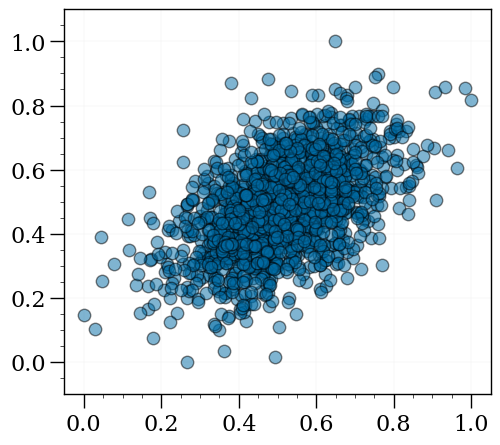

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

rho = 0.5
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
run(TrainingTensors, train_D, test_D, key, 'gauss_05')

  0%|          | 1/10000 [01:03<176:45:22, 63.64s/it]

Iter 0. Loss [[ 0.06717401  0.2744113  18.598797  ]]


  0%|          | 11/10000 [02:03<4:08:21,  1.49s/it]

Iter 10. Loss [[0.06757721 0.26239884 7.003356  ]]


  0%|          | 21/10000 [02:06<1:05:34,  2.54it/s]

Iter 20. Loss [[0.06764816 0.26119667 6.601082  ]]


  0%|          | 31/10000 [02:08<37:59,  4.37it/s]

Iter 30. Loss [[0.06769194 0.25898835 5.770863  ]]


  0%|          | 41/10000 [02:11<44:51,  3.70it/s]

Iter 40. Loss [[0.06768696 0.25408036 4.863506  ]]


  1%|          | 51/10000 [02:14<1:01:05,  2.71it/s]

Iter 50. Loss [[0.06801213 0.25636777 5.153715  ]]


  1%|          | 61/10000 [02:17<40:34,  4.08it/s]

Iter 60. Loss [[0.06836273 0.25449318 5.0605197 ]]


  1%|          | 71/10000 [02:20<58:50,  2.81it/s]

Iter 70. Loss [[0.06892132 0.25289163 5.11761   ]]


  1%|          | 81/10000 [02:22<37:11,  4.44it/s]

Iter 80. Loss [[0.069801  0.2520008 5.535807 ]]


  1%|          | 91/10000 [02:25<43:16,  3.82it/s]

Iter 90. Loss [[0.07057068 0.24987888 5.660949  ]]


  1%|          | 101/10000 [02:28<1:02:17,  2.65it/s]

Iter 100. Loss [[0.07122769 0.24758768 5.6257143 ]]


  1%|          | 111/10000 [02:31<41:52,  3.94it/s]

Iter 110. Loss [[0.07179607 0.2452503  5.6126523 ]]


  1%|          | 121/10000 [02:34<58:04,  2.83it/s]

Iter 120. Loss [[0.0724219  0.24424087 5.7146626 ]]


  1%|▏         | 131/10000 [02:36<36:10,  4.55it/s]

Iter 130. Loss [[0.07294577 0.24317952 5.7557325 ]]


  1%|▏         | 141/10000 [02:39<44:23,  3.70it/s]

Iter 140. Loss [[0.07332185 0.24149786 5.71772   ]]


  2%|▏         | 151/10000 [02:42<59:09,  2.78it/s]

Iter 150. Loss [[0.07367957 0.23996611 5.6506186 ]]


  2%|▏         | 161/10000 [02:45<42:36,  3.85it/s]

Iter 160. Loss [[0.07406729 0.23821649 5.534901  ]]


  2%|▏         | 171/10000 [02:47<35:18,  4.64it/s]

Iter 170. Loss [[0.0746024  0.23614664 5.3246427 ]]


  2%|▏         | 181/10000 [02:50<37:01,  4.42it/s]

Iter 180. Loss [[0.07540613 0.23381716 5.1732273 ]]


  2%|▏         | 191/10000 [02:53<46:03,  3.55it/s]

Iter 190. Loss [[0.07641197 0.230893   5.1412654 ]]


  2%|▏         | 201/10000 [02:55<51:34,  3.17it/s]

Iter 200. Loss [[0.07734313 0.22734682 5.144938  ]]


  2%|▏         | 211/10000 [02:59<47:14,  3.45it/s]

Iter 210. Loss [[0.07822128 0.22380513 5.0228653 ]]


  2%|▏         | 221/10000 [03:01<36:13,  4.50it/s]

Iter 220. Loss [[0.07938388 0.22070174 4.8185163 ]]


  2%|▏         | 231/10000 [03:04<36:00,  4.52it/s]

Iter 230. Loss [[0.08100075 0.21656008 4.5678635 ]]


  2%|▏         | 241/10000 [03:06<41:53,  3.88it/s]

Iter 240. Loss [[0.08347487 0.21139258 4.317736  ]]


  3%|▎         | 251/10000 [03:08<39:05,  4.16it/s]

Iter 250. Loss [[0.08700127 0.20559882 4.0636373 ]]


  3%|▎         | 261/10000 [03:13<1:02:26,  2.60it/s]

Iter 260. Loss [[0.09156063 0.19868658 3.852776  ]]


  3%|▎         | 271/10000 [03:15<36:39,  4.42it/s]

Iter 270. Loss [[0.09683855 0.18958272 3.7327683 ]]


  3%|▎         | 281/10000 [03:18<35:58,  4.50it/s]

Iter 280. Loss [[0.10332792 0.1827008  3.4470396 ]]


  3%|▎         | 291/10000 [03:20<45:24,  3.56it/s]

Iter 290. Loss [[0.11116112 0.16708961 3.2804544 ]]


  3%|▎         | 301/10000 [03:22<36:06,  4.48it/s]

Iter 300. Loss [[0.12329365 0.15459609 2.884084  ]]


  3%|▎         | 311/10000 [03:26<1:02:04,  2.60it/s]

Iter 310. Loss [[0.14069736 0.13470341 2.6293561 ]]


  3%|▎         | 321/10000 [03:29<38:15,  4.22it/s]

Iter 320. Loss [[0.1636313  0.11018129 2.2587569 ]]


  3%|▎         | 331/10000 [03:31<36:27,  4.42it/s]

Iter 330. Loss [[0.19525348 0.07771437 1.5624028 ]]


  3%|▎         | 341/10000 [03:34<45:48,  3.51it/s]

Iter 340. Loss [[0.22748001 0.06897959 1.0914263 ]]


  4%|▎         | 351/10000 [03:36<35:51,  4.48it/s]

Iter 350. Loss [[0.24130806 0.03794403 0.7818771 ]]


  4%|▎         | 361/10000 [03:40<1:01:23,  2.62it/s]

Iter 360. Loss [[0.286413   0.03731036 0.523419  ]]


  4%|▎         | 371/10000 [03:43<38:47,  4.14it/s]

Iter 370. Loss [[0.2792375  0.03051272 0.5292054 ]]


  4%|▍         | 381/10000 [03:45<35:40,  4.49it/s]

Iter 380. Loss [[0.27467185 0.02871018 0.56013227]]


  4%|▍         | 391/10000 [03:48<42:33,  3.76it/s]

Iter 390. Loss [[0.28272066 0.03262318 0.52819103]]


  4%|▍         | 401/10000 [03:50<35:13,  4.54it/s]

Iter 400. Loss [[0.27877668 0.03106879 0.5334649 ]]


  4%|▍         | 411/10000 [03:53<58:47,  2.72it/s]

Iter 410. Loss [[0.27909622 0.03064675 0.5350333 ]]


  4%|▍         | 421/10000 [03:57<41:51,  3.81it/s]

Iter 420. Loss [[0.28046528 0.03128193 0.5316456 ]]


  4%|▍         | 431/10000 [04:00<58:19,  2.73it/s]

Iter 430. Loss [[0.27931592 0.03094482 0.53335845]]


  4%|▍         | 441/10000 [04:04<47:31,  3.35it/s]

Iter 440. Loss [[0.2797232  0.03104484 0.5326475 ]]


  5%|▍         | 451/10000 [04:06<42:37,  3.73it/s]

Iter 450. Loss [[0.2798431  0.03103787 0.532556  ]]


  5%|▍         | 461/10000 [04:10<54:32,  2.91it/s]  

Iter 460. Loss [[0.27963066 0.03099061 0.5327273 ]]


  5%|▍         | 471/10000 [04:12<35:08,  4.52it/s]

Iter 470. Loss [[0.2797684  0.03105056 0.53228945]]


  5%|▍         | 481/10000 [04:15<35:48,  4.43it/s]

Iter 480. Loss [[0.2797484  0.03100924 0.53240716]]


  5%|▍         | 491/10000 [04:18<43:32,  3.64it/s]

Iter 490. Loss [[0.27974072 0.03101563 0.53226787]]


  5%|▌         | 501/10000 [04:20<35:13,  4.50it/s]

Iter 500. Loss [[0.27977574 0.03102873 0.5318975 ]]


  5%|▌         | 511/10000 [04:24<1:01:32,  2.57it/s]

Iter 510. Loss [[0.2797753  0.03101347 0.5318391 ]]


  5%|▌         | 521/10000 [04:26<36:16,  4.36it/s]

Iter 520. Loss [[0.27978945 0.03101652 0.53167397]]


  5%|▌         | 531/10000 [04:29<36:10,  4.36it/s]

Iter 530. Loss [[0.2798017  0.03101449 0.5314696 ]]


  5%|▌         | 541/10000 [04:32<44:49,  3.52it/s]

Iter 540. Loss [[0.27981257 0.03100932 0.5313183 ]]


  6%|▌         | 551/10000 [04:34<34:56,  4.51it/s]

Iter 550. Loss [[0.2798314  0.03100959 0.5309441 ]]


  6%|▌         | 561/10000 [04:38<1:00:52,  2.58it/s]

Iter 560. Loss [[0.27984804 0.03100509 0.53073454]]


  6%|▌         | 571/10000 [04:40<37:14,  4.22it/s]

Iter 570. Loss [[0.27986595 0.03099552 0.5304632 ]]


  6%|▌         | 581/10000 [04:43<35:31,  4.42it/s]

Iter 580. Loss [[0.27986616 0.03098523 0.5303472 ]]


  6%|▌         | 591/10000 [04:46<45:04,  3.48it/s]

Iter 590. Loss [[0.2798882  0.03098387 0.52973276]]


  6%|▌         | 601/10000 [04:48<35:22,  4.43it/s]

Iter 600. Loss [[0.2799155  0.03096885 0.5295426 ]]


  6%|▌         | 611/10000 [04:52<59:44,  2.62it/s]  

Iter 610. Loss [[0.279907   0.03093964 0.5294635 ]]


  6%|▌         | 621/10000 [04:54<37:01,  4.22it/s]

Iter 620. Loss [[0.2799363  0.03092632 0.5287489 ]]


  6%|▋         | 631/10000 [04:57<35:48,  4.36it/s]

Iter 630. Loss [[0.27997017 0.0309041  0.5281892 ]]


  6%|▋         | 641/10000 [05:00<44:26,  3.51it/s]

Iter 640. Loss [[0.2800019  0.03088059 0.5276835 ]]


  7%|▋         | 651/10000 [05:02<35:49,  4.35it/s]

Iter 650. Loss [[0.2800396 0.0308561 0.526179 ]]


  7%|▋         | 661/10000 [05:05<58:51,  2.64it/s]

Iter 660. Loss [[0.28007472 0.03083865 0.52553684]]


  7%|▋         | 671/10000 [05:08<39:07,  3.97it/s]

Iter 670. Loss [[0.280096   0.03080874 0.52442217]]


  7%|▋         | 681/10000 [05:11<35:09,  4.42it/s]

Iter 680. Loss [[0.2797957  0.03065883 0.5292232 ]]


  7%|▋         | 691/10000 [05:14<42:21,  3.66it/s]

Iter 690. Loss [[0.27981374 0.03067019 0.52748215]]


  7%|▋         | 701/10000 [05:16<35:34,  4.36it/s]

Iter 700. Loss [[0.28014994 0.03088487 0.5241826 ]]


  7%|▋         | 711/10000 [05:19<56:02,  2.76it/s]

Iter 710. Loss [[0.28002274 0.03087109 0.52409023]]


  7%|▋         | 721/10000 [05:22<41:40,  3.71it/s]

Iter 720. Loss [[0.2800083  0.03090841 0.52394706]]


  7%|▋         | 731/10000 [05:25<35:37,  4.34it/s]

Iter 730. Loss [[0.27997968 0.03091166 0.52431244]]


  7%|▋         | 741/10000 [05:28<40:46,  3.78it/s]

Iter 740. Loss [[0.27993855 0.03091088 0.52466935]]


  8%|▊         | 751/10000 [05:30<33:43,  4.57it/s]

Iter 750. Loss [[0.27990767 0.03091789 0.52552545]]


  8%|▊         | 761/10000 [05:33<52:04,  2.96it/s]

Iter 760. Loss [[0.27991655 0.03091    0.5259016 ]]


  8%|▊         | 771/10000 [05:37<49:07,  3.13it/s]

Iter 770. Loss [[0.27985445 0.03085221 0.5266964 ]]


  8%|▊         | 781/10000 [05:39<35:08,  4.37it/s]

Iter 780. Loss [[0.2799186  0.03082467 0.5261001 ]]


  8%|▊         | 791/10000 [05:42<44:20,  3.46it/s]

Iter 790. Loss [[0.2799206  0.03070355 0.5261269 ]]


  8%|▊         | 801/10000 [05:44<33:53,  4.52it/s]

Iter 800. Loss [[0.27982083 0.03050446 0.5256331 ]]


  8%|▊         | 811/10000 [05:47<48:11,  3.18it/s]

Iter 810. Loss [[0.2797925  0.03039004 0.52487427]]


  8%|▊         | 821/10000 [05:51<56:27,  2.71it/s]

Iter 820. Loss [[0.27986366 0.03042698 0.52353066]]


  8%|▊         | 831/10000 [05:53<35:30,  4.30it/s]

Iter 830. Loss [[0.27997786 0.0304674  0.5222173 ]]


  8%|▊         | 841/10000 [05:56<43:53,  3.48it/s]

Iter 840. Loss [[0.28003585 0.03044786 0.51949435]]


  9%|▊         | 851/10000 [05:58<33:56,  4.49it/s]

Iter 850. Loss [[0.279977  0.0303959 0.5170258]]


  9%|▊         | 861/10000 [06:01<38:42,  3.94it/s]

Iter 860. Loss [[0.27988172 0.03034404 0.5139457 ]]


  9%|▊         | 871/10000 [06:04<56:42,  2.68it/s]

Iter 870. Loss [[0.27977154 0.03027351 0.5099775 ]]


  9%|▉         | 881/10000 [06:07<35:46,  4.25it/s]

Iter 880. Loss [[0.27970353 0.03014876 0.49919233]]


  9%|▉         | 891/10000 [06:10<43:51,  3.46it/s]

Iter 890. Loss [[0.27924305 0.0296995  0.4911253 ]]


  9%|▉         | 901/10000 [06:12<33:08,  4.58it/s]

Iter 900. Loss [[0.278732   0.02934714 0.4983672 ]]


  9%|▉         | 911/10000 [06:15<36:55,  4.10it/s]

Iter 910. Loss [[0.2794066  0.02926979 0.49021345]]


  9%|▉         | 921/10000 [06:18<55:48,  2.71it/s]

Iter 920. Loss [[0.2843483  0.02959569 0.43492493]]


  9%|▉         | 931/10000 [06:21<35:13,  4.29it/s]

Iter 930. Loss [[0.29772556 0.02939831 0.28339815]]


  9%|▉         | 941/10000 [06:24<42:36,  3.54it/s]

Iter 940. Loss [[0.32883486 0.05321047 0.06416129]]


 10%|▉         | 951/10000 [06:26<33:57,  4.44it/s]

Iter 950. Loss [[ 0.33245942  0.05385673 -0.06346583]]


 10%|▉         | 961/10000 [06:28<35:23,  4.26it/s]

Iter 960. Loss [[0.268403   0.02713805 0.485623  ]]


 10%|▉         | 971/10000 [06:32<53:27,  2.81it/s]

Iter 970. Loss [[0.25025222 0.02953691 0.6371765 ]]


 10%|▉         | 981/10000 [06:35<36:06,  4.16it/s]

Iter 980. Loss [[0.28922188 0.03889193 0.45753846]]


 10%|▉         | 991/10000 [06:38<42:47,  3.51it/s]

Iter 990. Loss [[0.28661355 0.0313126  0.3902631 ]]


 10%|█         | 1001/10000 [06:40<33:10,  4.52it/s]

Iter 1000. Loss [[0.30823988 0.03291943 0.17966917]]


 10%|█         | 1011/10000 [06:42<35:57,  4.17it/s]

Iter 1010. Loss [[ 0.32719943  0.03633468 -0.0998504 ]]


 10%|█         | 1021/10000 [06:45<51:07,  2.93it/s]

Iter 1020. Loss [[ 0.35075122  0.07595544 -0.4917294 ]]


 10%|█         | 1031/10000 [06:49<39:54,  3.75it/s]

Iter 1030. Loss [[ 0.34323314  0.10230269 -0.5451309 ]]


 10%|█         | 1041/10000 [06:51<43:28,  3.43it/s]

Iter 1040. Loss [[ 0.32246205  0.06655846 -0.2932568 ]]


 11%|█         | 1051/10000 [06:54<32:48,  4.55it/s]

Iter 1050. Loss [[ 0.31066424  0.04995761 -0.21855845]]


 11%|█         | 1061/10000 [06:56<36:54,  4.04it/s]

Iter 1060. Loss [[ 0.3107612   0.05539202 -0.26040295]]


 11%|█         | 1071/10000 [06:59<47:36,  3.13it/s]

Iter 1070. Loss [[ 0.30391723  0.06030712 -0.32343787]]


 11%|█         | 1081/10000 [07:03<42:58,  3.46it/s]

Iter 1080. Loss [[ 0.3057287   0.06336095 -0.24341723]]


 11%|█         | 1091/10000 [07:05<42:31,  3.49it/s]

Iter 1090. Loss [[ 0.3110986   0.06830876 -0.21866496]]


 11%|█         | 1101/10000 [07:08<32:52,  4.51it/s]

Iter 1100. Loss [[ 0.3166911   0.06198669 -0.3107124 ]]


 11%|█         | 1111/10000 [07:10<34:19,  4.32it/s]

Iter 1110. Loss [[ 0.31942558  0.06947388 -0.40178746]]


 11%|█         | 1121/10000 [07:12<35:35,  4.16it/s]

Iter 1120. Loss [[ 0.32021004  0.08459893 -0.32551545]]


 11%|█▏        | 1131/10000 [07:17<53:58,  2.74it/s]

Iter 1130. Loss [[ 0.32465002  0.08252236 -0.45430866]]


 11%|█▏        | 1141/10000 [07:19<41:50,  3.53it/s]

Iter 1140. Loss [[ 0.32482857  0.10351666 -0.61687493]]


 12%|█▏        | 1151/10000 [07:21<32:12,  4.58it/s]

Iter 1150. Loss [[ 0.32276505  0.1001044  -0.48371688]]


 12%|█▏        | 1161/10000 [07:24<34:48,  4.23it/s]

Iter 1160. Loss [[ 0.32845002  0.10959853 -0.5530347 ]]


 12%|█▏        | 1171/10000 [07:26<32:23,  4.54it/s]

Iter 1170. Loss [[ 0.32940006  0.10007357 -0.5261532 ]]


 12%|█▏        | 1181/10000 [07:30<55:25,  2.65it/s]

Iter 1180. Loss [[ 0.3336883   0.09897247 -0.51465005]]


 12%|█▏        | 1191/10000 [07:33<41:04,  3.57it/s]

Iter 1190. Loss [[ 0.33273998  0.10208687 -0.5018771 ]]


 12%|█▏        | 1201/10000 [07:35<32:35,  4.50it/s]

Iter 1200. Loss [[ 0.33159578  0.10099829 -0.49889323]]


 12%|█▏        | 1211/10000 [07:38<34:41,  4.22it/s]

Iter 1210. Loss [[ 0.3285786   0.09261727 -0.46993855]]


 12%|█▏        | 1221/10000 [07:40<32:08,  4.55it/s]

Iter 1220. Loss [[ 0.32286683  0.08663029 -0.34649348]]


 12%|█▏        | 1231/10000 [07:44<54:34,  2.68it/s]

Iter 1230. Loss [[ 0.319846    0.11094978 -0.50427365]]


 12%|█▏        | 1241/10000 [07:48<1:02:23,  2.34it/s]

Iter 1240. Loss [[ 0.3164447   0.08885235 -0.40952262]]


 13%|█▎        | 1251/10000 [07:51<34:47,  4.19it/s]

Iter 1250. Loss [[ 0.3117978   0.09874309 -0.4723823 ]]


 13%|█▎        | 1261/10000 [07:54<33:53,  4.30it/s]

Iter 1260. Loss [[ 0.31208342  0.09459383 -0.42141414]]


 13%|█▎        | 1271/10000 [07:57<1:05:21,  2.23it/s]

Iter 1270. Loss [[ 0.30537885  0.08647422 -0.374495  ]]


 13%|█▎        | 1281/10000 [08:00<46:31,  3.12it/s]

Iter 1280. Loss [[ 0.29986355  0.08190791 -0.3341385 ]]


 13%|█▎        | 1291/10000 [08:03<39:12,  3.70it/s]

Iter 1290. Loss [[ 0.29713148  0.09825432 -0.37148243]]


 13%|█▎        | 1301/10000 [08:05<31:44,  4.57it/s]

Iter 1300. Loss [[ 0.30152276  0.09845702 -0.39715874]]


 13%|█▎        | 1311/10000 [08:08<34:13,  4.23it/s]

Iter 1310. Loss [[ 0.29739973  0.06951821 -0.26776272]]


 13%|█▎        | 1321/10000 [08:10<55:44,  2.60it/s]

Iter 1320. Loss [[ 0.30221987  0.06005783 -0.12085947]]


 13%|█▎        | 1331/10000 [08:14<54:04,  2.67it/s]

Iter 1330. Loss [[ 0.30738574  0.10093343 -0.40920532]]


 13%|█▎        | 1341/10000 [08:17<39:14,  3.68it/s]

Iter 1340. Loss [[ 0.30091122  0.21660602 -0.3306142 ]]


 14%|█▎        | 1351/10000 [08:19<32:18,  4.46it/s]

Iter 1350. Loss [[ 0.28624907  0.09258048 -0.1470421 ]]


 14%|█▎        | 1361/10000 [08:21<33:52,  4.25it/s]

Iter 1360. Loss [[ 0.28846556  0.06151368 -0.15446235]]


 14%|█▎        | 1371/10000 [08:24<31:08,  4.62it/s]

Iter 1370. Loss [[ 0.30461818  0.08677103 -0.3325383 ]]


 14%|█▍        | 1381/10000 [08:28<53:22,  2.69it/s]

Iter 1380. Loss [[ 0.31268412  0.10688011 -0.4398475 ]]


 14%|█▍        | 1391/10000 [08:31<41:41,  3.44it/s]

Iter 1390. Loss [[ 0.31538168  0.08745755 -0.35723558]]


 14%|█▍        | 1401/10000 [08:33<32:10,  4.45it/s]

Iter 1400. Loss [[ 0.31212947  0.09401727 -0.39686507]]


 14%|█▍        | 1411/10000 [08:35<33:25,  4.28it/s]

Iter 1410. Loss [[ 0.31039527  0.08765962 -0.37342465]]


 14%|█▍        | 1421/10000 [08:38<31:21,  4.56it/s]

Iter 1420. Loss [[ 0.3094234   0.08586839 -0.37039095]]


 14%|█▍        | 1431/10000 [08:41<51:14,  2.79it/s]

Iter 1430. Loss [[ 0.308512    0.08332541 -0.36767748]]


 14%|█▍        | 1441/10000 [08:45<43:29,  3.28it/s]

Iter 1440. Loss [[ 0.3056944   0.07586396 -0.305502  ]]


 15%|█▍        | 1451/10000 [08:47<31:00,  4.60it/s]

Iter 1450. Loss [[ 0.30180517  0.06754704 -0.22494525]]


 15%|█▍        | 1461/10000 [08:49<34:36,  4.11it/s]

Iter 1460. Loss [[ 0.30605984  0.08928642 -0.3376939 ]]


 15%|█▍        | 1471/10000 [08:51<30:23,  4.68it/s]

Iter 1470. Loss [[ 0.304951    0.08588521 -0.32503724]]


 15%|█▍        | 1481/10000 [08:55<49:37,  2.86it/s]

Iter 1480. Loss [[ 0.30162165  0.07859061 -0.2979582 ]]


 15%|█▍        | 1491/10000 [08:58<47:29,  2.99it/s]

Iter 1490. Loss [[ 0.30088723  0.08136114 -0.3136747 ]]


 15%|█▌        | 1501/10000 [09:01<31:42,  4.47it/s]

Iter 1500. Loss [[ 0.30285913  0.08287966 -0.32016608]]


 15%|█▌        | 1511/10000 [09:03<33:46,  4.19it/s]

Iter 1510. Loss [[ 0.30378672  0.08381437 -0.3259115 ]]


 15%|█▌        | 1521/10000 [09:05<31:18,  4.51it/s]

Iter 1520. Loss [[ 0.30359173  0.08355191 -0.32459068]]


 15%|█▌        | 1531/10000 [09:08<43:51,  3.22it/s]

Iter 1530. Loss [[ 0.3035129   0.08310872 -0.32247365]]


 15%|█▌        | 1541/10000 [09:12<51:47,  2.72it/s]  

Iter 1540. Loss [[ 0.30368066  0.08349773 -0.32491413]]


 16%|█▌        | 1551/10000 [09:14<32:24,  4.35it/s]

Iter 1550. Loss [[ 0.30375484  0.08342174 -0.3247972 ]]


 16%|█▌        | 1561/10000 [09:17<33:11,  4.24it/s]

Iter 1560. Loss [[ 0.3038193   0.08329412 -0.32382435]]


 16%|█▌        | 1571/10000 [09:19<30:59,  4.53it/s]

Iter 1570. Loss [[ 0.30402607  0.08376831 -0.32637757]]


 16%|█▌        | 1581/10000 [09:22<36:30,  3.84it/s]

Iter 1580. Loss [[ 0.30415687  0.08356234 -0.3245699 ]]


 16%|█▌        | 1591/10000 [09:26<59:44,  2.35it/s]  

Iter 1590. Loss [[ 0.30438083  0.08366192 -0.32603547]]


 16%|█▌        | 1601/10000 [09:28<32:21,  4.33it/s]

Iter 1600. Loss [[ 0.30452666  0.08383455 -0.32721013]]


 16%|█▌        | 1611/10000 [09:31<34:33,  4.05it/s]

Iter 1610. Loss [[ 0.30464733  0.08384707 -0.32726064]]


 16%|█▌        | 1621/10000 [09:33<31:22,  4.45it/s]

Iter 1620. Loss [[ 0.30474246  0.08399877 -0.32842487]]


 16%|█▋        | 1631/10000 [09:36<31:33,  4.42it/s]

Iter 1630. Loss [[ 0.30482844  0.08382594 -0.32815832]]


 16%|█▋        | 1641/10000 [09:40<1:03:38,  2.19it/s]

Iter 1640. Loss [[ 0.30490607  0.08388847 -0.32925138]]


 17%|█▋        | 1651/10000 [09:42<32:23,  4.30it/s]

Iter 1650. Loss [[ 0.30492577  0.08393586 -0.32957923]]


 17%|█▋        | 1661/10000 [09:45<33:31,  4.15it/s]

Iter 1660. Loss [[ 0.30505046  0.083644   -0.33840972]]


 17%|█▋        | 1671/10000 [09:47<30:14,  4.59it/s]

Iter 1670. Loss [[ 0.30512506  0.08443017 -0.3325002 ]]


 17%|█▋        | 1681/10000 [09:50<31:50,  4.35it/s]

Iter 1680. Loss [[ 0.30515707  0.08373092 -0.3290972 ]]


 17%|█▋        | 1691/10000 [09:54<1:05:18,  2.12it/s]

Iter 1690. Loss [[ 0.3051414   0.08380353 -0.32959852]]


 17%|█▋        | 1701/10000 [09:56<33:21,  4.15it/s]

Iter 1700. Loss [[ 0.3052353   0.08370246 -0.3300066 ]]


 17%|█▋        | 1711/10000 [09:59<33:29,  4.13it/s]

Iter 1710. Loss [[ 0.3053629   0.08377086 -0.33092156]]


 17%|█▋        | 1721/10000 [10:01<31:03,  4.44it/s]

Iter 1720. Loss [[ 0.30552962  0.08375581 -0.33123612]]


 17%|█▋        | 1731/10000 [10:04<31:22,  4.39it/s]

Iter 1730. Loss [[ 0.30556795  0.08350894 -0.3306047 ]]


 17%|█▋        | 1741/10000 [10:07<59:32,  2.31it/s]  

Iter 1740. Loss [[ 0.30560035  0.08338545 -0.33040467]]


 18%|█▊        | 1751/10000 [10:10<33:54,  4.06it/s]

Iter 1750. Loss [[ 0.3056561   0.08377074 -0.33252847]]


 18%|█▊        | 1761/10000 [10:13<33:38,  4.08it/s]

Iter 1760. Loss [[ 0.30576098  0.08373398 -0.33346835]]


 18%|█▊        | 1771/10000 [10:15<30:16,  4.53it/s]

Iter 1770. Loss [[ 0.30574045  0.08401272 -0.33508182]]


 18%|█▊        | 1781/10000 [10:18<31:29,  4.35it/s]

Iter 1780. Loss [[ 0.30578017  0.08342047 -0.33348095]]


 18%|█▊        | 1791/10000 [10:21<56:47,  2.41it/s]

Iter 1790. Loss [[ 0.30582792  0.0825425  -0.3298149 ]]


 18%|█▊        | 1801/10000 [10:24<36:16,  3.77it/s]

Iter 1800. Loss [[ 0.3059734   0.08286224 -0.3316771 ]]


 18%|█▊        | 1811/10000 [10:27<34:05,  4.00it/s]

Iter 1810. Loss [[ 0.30619287  0.0832392  -0.3351369 ]]


 18%|█▊        | 1821/10000 [10:29<30:23,  4.49it/s]

Iter 1820. Loss [[ 0.30611086  0.08250483 -0.33103585]]


 18%|█▊        | 1831/10000 [10:32<30:55,  4.40it/s]

Iter 1830. Loss [[ 0.30628633  0.08391248 -0.3412171 ]]


 18%|█▊        | 1841/10000 [10:35<57:01,  2.38it/s]

Iter 1840. Loss [[ 0.3078606   0.06943071 -0.20808242]]


 19%|█▊        | 1851/10000 [10:38<40:34,  3.35it/s]

Iter 1850. Loss [[ 0.30290377  0.10166249 -0.38091293]]


 19%|█▊        | 1861/10000 [10:41<32:53,  4.12it/s]

Iter 1860. Loss [[ 0.30420038  0.06831383 -0.25062704]]


 19%|█▊        | 1871/10000 [10:43<30:38,  4.42it/s]

Iter 1870. Loss [[ 0.30183685  0.09309856 -0.35516143]]


 19%|█▉        | 1881/10000 [10:46<30:32,  4.43it/s]

Iter 1880. Loss [[ 0.3072201   0.07208461 -0.2707669 ]]


 19%|█▉        | 1891/10000 [10:49<52:26,  2.58it/s]

Iter 1890. Loss [[ 0.30529362  0.08557961 -0.3417844 ]]


 19%|█▉        | 1901/10000 [10:52<48:38,  2.77it/s]

Iter 1900. Loss [[ 0.30600405  0.07747169 -0.30328202]]


 19%|█▉        | 1911/10000 [10:55<34:02,  3.96it/s]

Iter 1910. Loss [[0.28556913 0.03163318 0.5437431 ]]


 19%|█▉        | 1921/10000 [10:57<29:59,  4.49it/s]

Iter 1920. Loss [[0.27454877 0.03418962 0.12380697]]


 19%|█▉        | 1931/10000 [11:00<30:26,  4.42it/s]

Iter 1930. Loss [[ 0.2900289   0.07422385 -0.18114835]]


 19%|█▉        | 1941/10000 [11:02<47:54,  2.80it/s]

Iter 1940. Loss [[ 0.31351575  0.08639617 -0.3261843 ]]


 20%|█▉        | 1951/10000 [11:06<51:13,  2.62it/s]

Iter 1950. Loss [[ 0.31965935  0.09161472 -0.3560975 ]]


 20%|█▉        | 1961/10000 [11:09<34:21,  3.90it/s]

Iter 1960. Loss [[ 0.3171986   0.08898845 -0.35819182]]


 20%|█▉        | 1971/10000 [11:11<29:54,  4.48it/s]

Iter 1970. Loss [[ 0.31305555  0.08419661 -0.34051383]]


 20%|█▉        | 1981/10000 [11:14<31:11,  4.28it/s]

Iter 1980. Loss [[ 0.31137884  0.08212887 -0.33866644]]


 20%|█▉        | 1991/10000 [11:17<38:44,  3.45it/s]

Iter 1990. Loss [[ 0.3116793   0.0868787  -0.35677758]]


 20%|██        | 2001/10000 [11:20<51:08,  2.61it/s]

Iter 2000. Loss [[ 0.31019965  0.08277065 -0.34223178]]


 20%|██        | 2011/10000 [11:23<33:55,  3.92it/s]

Iter 2010. Loss [[ 0.30859864  0.08291855 -0.34472936]]


 20%|██        | 2021/10000 [11:26<30:34,  4.35it/s]

Iter 2020. Loss [[ 0.30655292  0.08034336 -0.33216506]]


 20%|██        | 2031/10000 [11:29<32:51,  4.04it/s]

Iter 2030. Loss [[ 0.3050306   0.07741754 -0.3186158 ]]


 20%|██        | 2041/10000 [11:31<50:44,  2.61it/s]

Iter 2040. Loss [[ 0.30522302  0.07772323 -0.31336284]]


 21%|██        | 2051/10000 [11:35<50:17,  2.63it/s]

Iter 2050. Loss [[ 0.30664328  0.08167326 -0.33466217]]


 21%|██        | 2061/10000 [11:38<34:06,  3.88it/s]

Iter 2060. Loss [[ 0.30697462  0.08259664 -0.33953458]]


 21%|██        | 2071/10000 [11:41<42:47,  3.09it/s]

Iter 2070. Loss [[ 0.30649373  0.08145669 -0.3364271 ]]


 21%|██        | 2081/10000 [11:45<39:01,  3.38it/s]

Iter 2080. Loss [[ 0.3066645   0.08123904 -0.33578765]]


 21%|██        | 2091/10000 [11:48<1:04:26,  2.05it/s]

Iter 2090. Loss [[ 0.30663416  0.08238312 -0.341465  ]]


 21%|██        | 2101/10000 [11:51<33:33,  3.92it/s]

Iter 2100. Loss [[ 0.30637982  0.08167269 -0.33844823]]


 21%|██        | 2111/10000 [11:54<33:12,  3.96it/s]

Iter 2110. Loss [[ 0.3062032   0.08147671 -0.33879334]]


 21%|██        | 2121/10000 [11:56<30:51,  4.26it/s]

Iter 2120. Loss [[ 0.30645993  0.08218386 -0.34268   ]]


 21%|██▏       | 2131/10000 [11:59<30:47,  4.26it/s]

Iter 2130. Loss [[ 0.30663007  0.0824561  -0.3441123 ]]


 21%|██▏       | 2141/10000 [12:03<1:04:25,  2.03it/s]

Iter 2140. Loss [[ 0.30654696  0.08222169 -0.34311858]]


 22%|██▏       | 2151/10000 [12:06<32:58,  3.97it/s]

Iter 2150. Loss [[ 0.3063991   0.08195139 -0.34220234]]


 22%|██▏       | 2161/10000 [12:08<32:29,  4.02it/s]

Iter 2160. Loss [[ 0.30629033  0.08179359 -0.3415405 ]]


 22%|██▏       | 2171/10000 [12:11<29:43,  4.39it/s]

Iter 2170. Loss [[ 0.30616802  0.08160058 -0.34103087]]


 22%|██▏       | 2181/10000 [12:13<31:27,  4.14it/s]

Iter 2180. Loss [[ 0.30606833  0.0815594  -0.34105304]]


 22%|██▏       | 2191/10000 [12:17<1:02:20,  2.09it/s]

Iter 2190. Loss [[ 0.3059909   0.0814947  -0.34076265]]


 22%|██▏       | 2201/10000 [12:20<32:45,  3.97it/s]

Iter 2200. Loss [[ 0.30591407  0.08140066 -0.34049445]]


 22%|██▏       | 2211/10000 [12:23<32:12,  4.03it/s]

Iter 2210. Loss [[ 0.30546993  0.08072755 -0.3470892 ]]


 22%|██▏       | 2221/10000 [12:25<29:29,  4.40it/s]

Iter 2220. Loss [[ 0.30503497  0.07994615 -0.34360433]]


 22%|██▏       | 2231/10000 [12:28<32:18,  4.01it/s]

Iter 2230. Loss [[ 0.30502045  0.08029789 -0.3453251 ]]


 22%|██▏       | 2241/10000 [12:31<1:03:18,  2.04it/s]

Iter 2240. Loss [[ 0.30507317  0.08044287 -0.34573942]]


 23%|██▎       | 2251/10000 [12:34<32:36,  3.96it/s]

Iter 2250. Loss [[ 0.30523983  0.08045547 -0.34619352]]


 23%|██▎       | 2261/10000 [12:37<34:32,  3.73it/s]

Iter 2260. Loss [[ 0.30527267  0.08054405 -0.34690398]]


 23%|██▎       | 2271/10000 [12:39<28:39,  4.50it/s]

Iter 2270. Loss [[ 0.3051161   0.08033293 -0.34573445]]


 23%|██▎       | 2281/10000 [12:42<30:07,  4.27it/s]

Iter 2280. Loss [[ 0.30500042  0.08011252 -0.34489974]]


 23%|██▎       | 2291/10000 [12:46<1:00:25,  2.13it/s]

Iter 2290. Loss [[ 0.3049801   0.08014017 -0.3451507 ]]


 23%|██▎       | 2301/10000 [12:49<33:23,  3.84it/s]

Iter 2300. Loss [[ 0.3049107   0.0799252  -0.34422457]]


 23%|██▎       | 2311/10000 [12:51<32:23,  3.96it/s]

Iter 2310. Loss [[ 0.30477312  0.07986832 -0.34354886]]


 23%|██▎       | 2321/10000 [12:54<28:18,  4.52it/s]

Iter 2320. Loss [[ 0.30505607  0.0797317  -0.34547144]]


 23%|██▎       | 2331/10000 [12:56<30:07,  4.24it/s]

Iter 2330. Loss [[ 0.30519333  0.08125731 -0.35308838]]


 23%|██▎       | 2341/10000 [13:00<58:12,  2.19it/s]  

Iter 2340. Loss [[ 0.30483153  0.08034552 -0.35060275]]


 24%|██▎       | 2351/10000 [13:03<34:44,  3.67it/s]

Iter 2350. Loss [[ 0.30336773  0.07738906 -0.32253844]]


 24%|██▎       | 2361/10000 [13:06<32:18,  3.94it/s]

Iter 2360. Loss [[ 0.30035877  0.09338564 -0.36630002]]


 24%|██▎       | 2371/10000 [13:08<28:52,  4.40it/s]

Iter 2370. Loss [[ 0.30370682  0.07535215 -0.2993826 ]]


 24%|██▍       | 2381/10000 [13:11<29:43,  4.27it/s]

Iter 2380. Loss [[ 0.30118316  0.06733386 -0.20948932]]


 24%|██▍       | 2391/10000 [13:14<56:52,  2.23it/s]

Iter 2390. Loss [[ 0.29547235  0.08135889 -0.3118716 ]]


 24%|██▍       | 2401/10000 [13:17<34:01,  3.72it/s]

Iter 2400. Loss [[ 0.2981234  0.0952974 -0.3640577]]


 24%|██▍       | 2411/10000 [13:20<32:02,  3.95it/s]

Iter 2410. Loss [[ 0.3076977   0.06401224 -0.0987572 ]]


 24%|██▍       | 2421/10000 [13:22<28:23,  4.45it/s]

Iter 2420. Loss [[ 0.30657178  0.06918885 -0.19021389]]


 24%|██▍       | 2431/10000 [13:25<28:48,  4.38it/s]

Iter 2430. Loss [[ 0.30077946  0.06648122 -0.20566687]]


 24%|██▍       | 2441/10000 [13:28<55:59,  2.25it/s]

Iter 2440. Loss [[ 0.29790393  0.07484721 -0.3010783 ]]


 25%|██▍       | 2451/10000 [13:31<38:00,  3.31it/s]

Iter 2450. Loss [[ 0.2977153   0.06897645 -0.23484151]]


 25%|██▍       | 2461/10000 [13:34<32:52,  3.82it/s]

Iter 2460. Loss [[ 0.28726238  0.05107137 -0.07790634]]


 25%|██▍       | 2471/10000 [13:36<29:08,  4.31it/s]

Iter 2470. Loss [[ 0.29444635  0.07830454 -0.2808908 ]]


 25%|██▍       | 2481/10000 [13:39<29:27,  4.25it/s]

Iter 2480. Loss [[ 0.30506465  0.08347654 -0.3201191 ]]


 25%|██▍       | 2491/10000 [13:42<56:17,  2.22it/s]

Iter 2490. Loss [[ 0.3052816   0.08391404 -0.33619085]]


 25%|██▌       | 2501/10000 [13:46<36:38,  3.41it/s]

Iter 2500. Loss [[ 0.2994522   0.0731948  -0.28557083]]


 25%|██▌       | 2511/10000 [13:48<32:00,  3.90it/s]

Iter 2510. Loss [[ 0.30105883  0.06951222 -0.25790066]]


 25%|██▌       | 2521/10000 [13:51<28:17,  4.41it/s]

Iter 2520. Loss [[ 0.30330828  0.07180586 -0.2798759 ]]


 25%|██▌       | 2531/10000 [13:53<28:34,  4.36it/s]

Iter 2530. Loss [[0.29490554 0.04985106 0.03955424]]


 25%|██▌       | 2541/10000 [13:56<52:02,  2.39it/s]

Iter 2540. Loss [[ 0.29267144  0.07568227 -0.26742065]]


 26%|██▌       | 2551/10000 [14:00<38:39,  3.21it/s]

Iter 2550. Loss [[ 0.2952118   0.06025789 -0.20622545]]


 26%|██▌       | 2561/10000 [14:03<32:30,  3.81it/s]

Iter 2560. Loss [[ 0.30002937  0.054211   -0.0684677 ]]


 26%|██▌       | 2571/10000 [14:05<28:08,  4.40it/s]

Iter 2570. Loss [[ 0.30415055  0.07214952 -0.2804958 ]]


 26%|██▌       | 2581/10000 [14:07<29:23,  4.21it/s]

Iter 2580. Loss [[ 0.30188322  0.08205244 -0.342452  ]]


 26%|██▌       | 2591/10000 [14:10<54:48,  2.25it/s]

Iter 2590. Loss [[ 0.299788    0.07802321 -0.3223609 ]]


 26%|██▌       | 2601/10000 [14:14<41:34,  2.97it/s]

Iter 2600. Loss [[ 0.29977575  0.06804395 -0.25273368]]


 26%|██▌       | 2611/10000 [14:17<30:55,  3.98it/s]

Iter 2610. Loss [[ 0.3000515   0.09418774 -0.37142187]]


 26%|██▌       | 2621/10000 [14:19<27:20,  4.50it/s]

Iter 2620. Loss [[ 0.29915148  0.08443    -0.3535992 ]]


 26%|██▋       | 2631/10000 [14:21<28:53,  4.25it/s]

Iter 2630. Loss [[ 0.29829     0.06593813 -0.25715306]]


 26%|██▋       | 2641/10000 [14:24<47:16,  2.59it/s]

Iter 2640. Loss [[ 0.28945655  0.07429478 -0.14280984]]


 27%|██▋       | 2651/10000 [14:28<47:00,  2.61it/s]

Iter 2650. Loss [[0.2748215  0.06006505 0.03306051]]


 27%|██▋       | 2661/10000 [14:31<33:20,  3.67it/s]

Iter 2660. Loss [[0.29692313 0.04396528 0.09275395]]


 27%|██▋       | 2671/10000 [14:33<27:22,  4.46it/s]

Iter 2670. Loss [[ 0.2980501   0.08309301 -0.25376415]]


 27%|██▋       | 2681/10000 [14:35<28:41,  4.25it/s]

Iter 2680. Loss [[ 0.30682203  0.07677738 -0.31082225]]


 27%|██▋       | 2691/10000 [14:38<43:02,  2.83it/s]

Iter 2690. Loss [[ 0.31025296  0.08824298 -0.3683112 ]]


 27%|██▋       | 2701/10000 [14:42<44:51,  2.71it/s]

Iter 2700. Loss [[ 0.31105605  0.08161604 -0.35475284]]


 27%|██▋       | 2711/10000 [14:45<33:53,  3.58it/s]

Iter 2710. Loss [[ 0.31031907  0.08142635 -0.35000938]]


 27%|██▋       | 2721/10000 [14:47<27:23,  4.43it/s]

Iter 2720. Loss [[ 0.30974817  0.08022683 -0.35074317]]


 27%|██▋       | 2731/10000 [14:50<29:29,  4.11it/s]

Iter 2730. Loss [[ 0.30873606  0.08099218 -0.3567376 ]]


 27%|██▋       | 2741/10000 [14:52<43:38,  2.77it/s]

Iter 2740. Loss [[ 0.30727312  0.080222   -0.3534034 ]]


 28%|██▊       | 2751/10000 [14:56<44:47,  2.70it/s]

Iter 2750. Loss [[ 0.30645674  0.07873126 -0.34663117]]


 28%|██▊       | 2761/10000 [14:59<35:09,  3.43it/s]

Iter 2760. Loss [[ 0.30706447  0.07929295 -0.34473658]]


 28%|██▊       | 2771/10000 [15:01<27:18,  4.41it/s]

Iter 2770. Loss [[ 0.30679357  0.07941378 -0.34570718]]


 28%|██▊       | 2781/10000 [15:04<29:04,  4.14it/s]

Iter 2780. Loss [[ 0.3057605   0.07941565 -0.34547573]]


 28%|██▊       | 2791/10000 [15:06<26:55,  4.46it/s]

Iter 2790. Loss [[ 0.3055613   0.07830764 -0.3404762 ]]


 28%|██▊       | 2801/10000 [15:10<44:39,  2.69it/s]

Iter 2800. Loss [[ 0.3056143   0.07933313 -0.34588045]]


 28%|██▊       | 2811/10000 [15:13<34:17,  3.49it/s]

Iter 2810. Loss [[ 0.30565417  0.07931797 -0.34577078]]


 28%|██▊       | 2821/10000 [15:15<26:26,  4.52it/s]

Iter 2820. Loss [[ 0.30547523  0.07908871 -0.34468913]]


 28%|██▊       | 2831/10000 [15:18<27:13,  4.39it/s]

Iter 2830. Loss [[ 0.30533087  0.07897172 -0.34418336]]


 28%|██▊       | 2841/10000 [15:21<42:45,  2.79it/s]

Iter 2840. Loss [[ 0.3052349   0.07907913 -0.34471735]]


 29%|██▊       | 2851/10000 [15:24<42:47,  2.78it/s]

Iter 2850. Loss [[ 0.3051617   0.07901048 -0.3447289 ]]


 29%|██▊       | 2861/10000 [15:27<36:41,  3.24it/s]

Iter 2860. Loss [[ 0.30508083  0.07906277 -0.34520885]]


 29%|██▊       | 2871/10000 [15:29<26:17,  4.52it/s]

Iter 2870. Loss [[ 0.30553746  0.07873845 -0.3376406 ]]


 29%|██▉       | 2881/10000 [15:32<28:28,  4.17it/s]

Iter 2880. Loss [[ 0.30534816  0.08035608 -0.34755102]]


 29%|██▉       | 2891/10000 [15:34<30:50,  3.84it/s]

Iter 2890. Loss [[ 0.30435643  0.07933808 -0.34302408]]


 29%|██▉       | 2901/10000 [15:40<54:51,  2.16it/s]

Iter 2900. Loss [[ 0.30335817  0.0780838  -0.3378216 ]]


 29%|██▉       | 2911/10000 [15:43<37:42,  3.13it/s]

Iter 2910. Loss [[ 0.29757085  0.05350221 -0.09257153]]


 29%|██▉       | 2921/10000 [15:46<26:44,  4.41it/s]

Iter 2920. Loss [[ 0.2985623   0.06932003 -0.27733693]]


 29%|██▉       | 2931/10000 [15:48<28:20,  4.16it/s]

Iter 2930. Loss [[ 0.3028408   0.0867511  -0.37166822]]


 29%|██▉       | 2941/10000 [15:51<42:08,  2.79it/s]

Iter 2940. Loss [[ 0.30459496  0.08339223 -0.34470198]]


 30%|██▉       | 2951/10000 [15:54<38:58,  3.01it/s]

Iter 2950. Loss [[ 0.30528665  0.07938692 -0.32538065]]


 30%|██▉       | 2961/10000 [15:57<38:47,  3.02it/s]

Iter 2960. Loss [[ 0.30289677  0.0708963  -0.27341285]]


 30%|██▉       | 2971/10000 [16:00<26:19,  4.45it/s]

Iter 2970. Loss [[ 0.30228263  0.07853439 -0.31509048]]


 30%|██▉       | 2981/10000 [16:02<27:35,  4.24it/s]

Iter 2980. Loss [[ 0.30235738  0.08140927 -0.34692693]]


 30%|██▉       | 2991/10000 [16:05<26:46,  4.36it/s]

Iter 2990. Loss [[ 0.30017003  0.0730136  -0.2978115 ]]


 30%|███       | 3001/10000 [16:07<35:53,  3.25it/s]

Iter 3000. Loss [[ 0.30017364  0.07166191 -0.291624  ]]


 30%|███       | 3011/10000 [16:11<42:36,  2.73it/s]

Iter 3010. Loss [[ 0.2991546   0.08092587 -0.33440682]]


 30%|███       | 3021/10000 [16:14<26:05,  4.46it/s]

Iter 3020. Loss [[ 0.30011472  0.07210348 -0.24714649]]


 30%|███       | 3031/10000 [16:16<27:24,  4.24it/s]

Iter 3030. Loss [[ 0.2993297   0.07743277 -0.27947885]]


 30%|███       | 3041/10000 [16:18<25:32,  4.54it/s]

Iter 3040. Loss [[ 0.2973503   0.08066534 -0.2892264 ]]


 31%|███       | 3051/10000 [16:21<26:40,  4.34it/s]

Iter 3050. Loss [[ 0.29486042  0.07888582 -0.28002575]]


 31%|███       | 3061/10000 [16:25<51:51,  2.23it/s]

Iter 3060. Loss [[ 0.29467076  0.10770667 -0.3704634 ]]


 31%|███       | 3071/10000 [16:28<26:53,  4.30it/s]

Iter 3070. Loss [[ 0.29761145  0.06929988 -0.17390388]]


 31%|███       | 3081/10000 [16:30<27:40,  4.17it/s]

Iter 3080. Loss [[0.27816066 0.28755563 2.1538932 ]]


 31%|███       | 3091/10000 [16:32<25:42,  4.48it/s]

Iter 3090. Loss [[0.28384465 0.06090581 1.1093638 ]]


 31%|███       | 3101/10000 [16:35<26:16,  4.38it/s]

Iter 3100. Loss [[0.27002966 0.10263132 0.15199536]]


 31%|███       | 3111/10000 [16:39<49:24,  2.32it/s]

Iter 3110. Loss [[0.2950882  0.04355222 0.20266297]]


 31%|███       | 3121/10000 [16:42<26:22,  4.35it/s]

Iter 3120. Loss [[ 0.2818336   0.04619976 -0.04835964]]


 31%|███▏      | 3131/10000 [16:44<27:15,  4.20it/s]

Iter 3130. Loss [[ 0.28859085  0.04783301 -0.10513127]]


 31%|███▏      | 3141/10000 [16:46<25:40,  4.45it/s]

Iter 3140. Loss [[ 0.29228255  0.06284553 -0.2140282 ]]


 32%|███▏      | 3151/10000 [16:49<25:39,  4.45it/s]

Iter 3150. Loss [[ 0.2888847   0.06259356 -0.25463125]]


 32%|███▏      | 3161/10000 [16:53<50:18,  2.27it/s]

Iter 3160. Loss [[ 0.28570023  0.06624001 -0.27918535]]


 32%|███▏      | 3171/10000 [16:56<26:59,  4.22it/s]

Iter 3170. Loss [[ 0.28262082  0.06120809 -0.30062398]]


 32%|███▏      | 3181/10000 [16:58<28:03,  4.05it/s]

Iter 3180. Loss [[ 0.28308168  0.06087556 -0.30480322]]


 32%|███▏      | 3191/10000 [17:01<25:33,  4.44it/s]

Iter 3190. Loss [[ 0.27722135  0.05504562 -0.31326765]]


 32%|███▏      | 3201/10000 [17:03<25:51,  4.38it/s]

Iter 3200. Loss [[ 0.28391606  0.05951986 -0.24812934]]


 32%|███▏      | 3211/10000 [17:07<49:29,  2.29it/s]

Iter 3210. Loss [[ 0.28816402  0.05848604 -0.25244185]]


 32%|███▏      | 3221/10000 [17:10<27:33,  4.10it/s]

Iter 3220. Loss [[ 0.28687683  0.06609866 -0.3266514 ]]


 32%|███▏      | 3231/10000 [17:12<28:09,  4.01it/s]

Iter 3230. Loss [[ 0.28090596  0.06173192 -0.33119202]]


 32%|███▏      | 3241/10000 [17:15<25:07,  4.48it/s]

Iter 3240. Loss [[ 0.27808166  0.06021394 -0.3213275 ]]


 33%|███▎      | 3251/10000 [17:17<25:49,  4.36it/s]

Iter 3250. Loss [[ 0.27944022  0.06255993 -0.3198692 ]]


 33%|███▎      | 3261/10000 [17:21<50:53,  2.21it/s]

Iter 3260. Loss [[ 0.28030765  0.06526496 -0.3344665 ]]


 33%|███▎      | 3271/10000 [17:24<30:13,  3.71it/s]

Iter 3270. Loss [[ 0.2754519   0.0744162  -0.32519576]]


 33%|███▎      | 3281/10000 [17:26<28:00,  4.00it/s]

Iter 3280. Loss [[0.24714673 0.04627495 0.14142652]]


 33%|███▎      | 3291/10000 [17:29<24:41,  4.53it/s]

Iter 3290. Loss [[0.25526094 0.04182714 0.21328108]]


 33%|███▎      | 3301/10000 [17:31<25:31,  4.37it/s]

Iter 3300. Loss [[ 0.276751    0.06379092 -0.06941113]]


 33%|███▎      | 3311/10000 [17:34<44:47,  2.49it/s]

Iter 3310. Loss [[ 0.28862265  0.04514111 -0.01912739]]


 33%|███▎      | 3321/10000 [17:38<32:16,  3.45it/s]

Iter 3320. Loss [[ 0.28059238  0.06849501 -0.23295209]]


 33%|███▎      | 3331/10000 [17:40<27:12,  4.08it/s]

Iter 3330. Loss [[ 0.28517255  0.05385836 -0.20338272]]


 33%|███▎      | 3341/10000 [17:43<24:27,  4.54it/s]

Iter 3340. Loss [[ 0.28942978  0.05459217 -0.20084387]]


 34%|███▎      | 3351/10000 [17:45<25:51,  4.29it/s]

Iter 3350. Loss [[0.2744999  0.20237264 0.2587655 ]]


 34%|███▎      | 3361/10000 [17:48<41:34,  2.66it/s]

Iter 3360. Loss [[0.24941653 0.03697107 0.48789498]]


 34%|███▎      | 3371/10000 [17:52<38:27,  2.87it/s]

Iter 3370. Loss [[0.24757779 0.02593106 0.76329094]]


 34%|███▍      | 3381/10000 [17:55<27:21,  4.03it/s]

Iter 3380. Loss [[0.2573144  0.02658309 0.34902635]]


 34%|███▍      | 3391/10000 [17:57<25:44,  4.28it/s]

Iter 3390. Loss [[0.26977277 0.03188061 0.07266171]]


 34%|███▍      | 3401/10000 [17:59<25:09,  4.37it/s]

Iter 3400. Loss [[ 0.28540117  0.04101478 -0.12072214]]


 34%|███▍      | 3411/10000 [18:02<37:04,  2.96it/s]

Iter 3410. Loss [[ 0.29388562  0.05719497 -0.2406608 ]]


 34%|███▍      | 3421/10000 [18:06<41:11,  2.66it/s]

Iter 3420. Loss [[ 0.29828194  0.06605487 -0.30002493]]


 34%|███▍      | 3431/10000 [18:09<27:08,  4.03it/s]

Iter 3430. Loss [[ 0.30337828  0.06767777 -0.2883263 ]]


 34%|███▍      | 3441/10000 [18:11<24:32,  4.45it/s]

Iter 3440. Loss [[ 0.3068389   0.07113536 -0.3160037 ]]


 35%|███▍      | 3451/10000 [18:14<25:16,  4.32it/s]

Iter 3450. Loss [[ 0.30762145  0.07656207 -0.35118148]]


 35%|███▍      | 3461/10000 [18:16<34:35,  3.15it/s]

Iter 3460. Loss [[ 0.30825493  0.0779481  -0.36132804]]


 35%|███▍      | 3471/10000 [18:20<40:34,  2.68it/s]

Iter 3470. Loss [[ 0.30769384  0.07805824 -0.36931315]]


 35%|███▍      | 3481/10000 [18:23<27:30,  3.95it/s]

Iter 3480. Loss [[ 0.30696732  0.0773746  -0.37040892]]


 35%|███▍      | 3491/10000 [18:25<24:09,  4.49it/s]

Iter 3490. Loss [[ 0.3060839   0.07693839 -0.3722088 ]]


 35%|███▌      | 3501/10000 [18:28<24:53,  4.35it/s]

Iter 3500. Loss [[ 0.30546433  0.07640698 -0.37021366]]


 35%|███▌      | 3511/10000 [18:30<33:23,  3.24it/s]

Iter 3510. Loss [[ 0.30437207  0.07603935 -0.37587753]]


 35%|███▌      | 3521/10000 [18:34<39:38,  2.72it/s]

Iter 3520. Loss [[ 0.3033429   0.07567671 -0.37364668]]


 35%|███▌      | 3531/10000 [18:37<28:56,  3.72it/s]

Iter 3530. Loss [[ 0.3022495   0.07512739 -0.37418246]]


 35%|███▌      | 3541/10000 [18:39<23:52,  4.51it/s]

Iter 3540. Loss [[ 0.3013093   0.07509767 -0.37222168]]


 36%|███▌      | 3551/10000 [18:42<24:38,  4.36it/s]

Iter 3550. Loss [[ 0.30037665  0.07537206 -0.37270004]]


 36%|███▌      | 3561/10000 [18:44<34:18,  3.13it/s]

Iter 3560. Loss [[ 0.2996751   0.07458772 -0.36975798]]


 36%|███▌      | 3571/10000 [18:48<38:09,  2.81it/s]

Iter 3570. Loss [[ 0.29920456  0.07449389 -0.36803395]]


 36%|███▌      | 3581/10000 [18:51<30:10,  3.55it/s]

Iter 3580. Loss [[ 0.29883128  0.07451487 -0.3686346 ]]


 36%|███▌      | 3591/10000 [18:53<23:27,  4.56it/s]

Iter 3590. Loss [[ 0.29851985  0.0747067  -0.36844116]]


 36%|███▌      | 3601/10000 [18:56<24:54,  4.28it/s]

Iter 3600. Loss [[ 0.29818082  0.07485313 -0.36913347]]


 36%|███▌      | 3611/10000 [18:59<33:07,  3.22it/s]

Iter 3610. Loss [[ 0.29774907  0.07432125 -0.359371  ]]


 36%|███▌      | 3621/10000 [19:01<36:38,  2.90it/s]

Iter 3620. Loss [[ 0.29664552  0.07454339 -0.36261842]]


 36%|███▋      | 3631/10000 [19:05<31:06,  3.41it/s]

Iter 3630. Loss [[ 0.29560032  0.07508654 -0.3645354 ]]


 36%|███▋      | 3641/10000 [19:07<24:11,  4.38it/s]

Iter 3640. Loss [[ 0.2949706   0.07448057 -0.36030656]]


 37%|███▋      | 3651/10000 [19:10<25:40,  4.12it/s]

Iter 3650. Loss [[ 0.29466078  0.07398763 -0.35712752]]


 37%|███▋      | 3661/10000 [19:13<33:40,  3.14it/s]

Iter 3660. Loss [[ 0.29377583  0.07438871 -0.36092514]]


 37%|███▋      | 3671/10000 [19:15<35:53,  2.94it/s]

Iter 3670. Loss [[ 0.29314792  0.07485054 -0.36400387]]


 37%|███▋      | 3681/10000 [19:19<32:34,  3.23it/s]

Iter 3680. Loss [[ 0.29306903  0.07494701 -0.36530468]]


 37%|███▋      | 3691/10000 [19:21<23:39,  4.45it/s]

Iter 3690. Loss [[ 0.29331362  0.07443312 -0.3556027 ]]


 37%|███▋      | 3701/10000 [19:24<24:51,  4.22it/s]

Iter 3700. Loss [[ 0.2940649   0.07468837 -0.35998014]]


 37%|███▋      | 3711/10000 [19:27<37:32,  2.79it/s]

Iter 3710. Loss [[ 0.29315868  0.07501091 -0.36362588]]


 37%|███▋      | 3721/10000 [19:29<32:16,  3.24it/s]

Iter 3720. Loss [[ 0.29241753  0.07521506 -0.36428693]]


 37%|███▋      | 3731/10000 [19:33<37:09,  2.81it/s]

Iter 3730. Loss [[ 0.29167962  0.07421205 -0.35973457]]


 37%|███▋      | 3741/10000 [19:36<24:14,  4.30it/s]

Iter 3740. Loss [[ 0.29119223  0.07387385 -0.35712305]]


 38%|███▊      | 3751/10000 [19:40<40:46,  2.55it/s]

Iter 3750. Loss [[ 0.2910903   0.07381837 -0.35707608]]


 38%|███▊      | 3761/10000 [19:43<33:24,  3.11it/s]

Iter 3760. Loss [[ 0.29020518  0.07422265 -0.35927576]]


 38%|███▊      | 3771/10000 [19:46<38:00,  2.73it/s]

Iter 3770. Loss [[ 0.29070494  0.07379546 -0.35841423]]


 38%|███▊      | 3781/10000 [19:49<27:40,  3.74it/s]

Iter 3780. Loss [[ 0.29053417  0.07422047 -0.3692107 ]]


 38%|███▊      | 3791/10000 [19:51<22:44,  4.55it/s]

Iter 3790. Loss [[ 0.28999057  0.07326454 -0.36519206]]


 38%|███▊      | 3801/10000 [19:54<24:23,  4.24it/s]

Iter 3800. Loss [[ 0.28940296  0.07234375 -0.3609732 ]]


 38%|███▊      | 3811/10000 [19:57<37:37,  2.74it/s]

Iter 3810. Loss [[ 0.28915945  0.07239273 -0.3622199 ]]


 38%|███▊      | 3821/10000 [20:00<38:14,  2.69it/s]

Iter 3820. Loss [[ 0.28912738  0.07230712 -0.36198965]]


 38%|███▊      | 3831/10000 [20:03<28:32,  3.60it/s]

Iter 3830. Loss [[ 0.28921694  0.07257933 -0.36292183]]


 38%|███▊      | 3841/10000 [20:06<23:09,  4.43it/s]

Iter 3840. Loss [[ 0.2890997   0.07298089 -0.36454338]]


 39%|███▊      | 3851/10000 [20:08<24:27,  4.19it/s]

Iter 3850. Loss [[ 0.2892708   0.07305128 -0.36676383]]


 39%|███▊      | 3861/10000 [20:11<36:44,  2.78it/s]

Iter 3860. Loss [[ 0.28947946  0.07278683 -0.36530086]]


 39%|███▊      | 3871/10000 [20:14<36:29,  2.80it/s]

Iter 3870. Loss [[ 0.2895909   0.0731579  -0.36689818]]


 39%|███▉      | 3881/10000 [20:18<30:36,  3.33it/s]

Iter 3880. Loss [[ 0.28967997  0.07260984 -0.36485133]]


 39%|███▉      | 3891/10000 [20:20<23:04,  4.41it/s]

Iter 3890. Loss [[ 0.29049772  0.07339971 -0.36094698]]


 39%|███▉      | 3901/10000 [20:22<23:20,  4.36it/s]

Iter 3900. Loss [[ 0.29093915  0.07435764 -0.36806062]]


 39%|███▉      | 3911/10000 [20:25<36:05,  2.81it/s]

Iter 3910. Loss [[ 0.29046407  0.07489631 -0.37269393]]


 39%|███▉      | 3921/10000 [20:28<36:19,  2.79it/s]

Iter 3920. Loss [[ 0.290101    0.07475162 -0.37247744]]


 39%|███▉      | 3931/10000 [20:32<30:04,  3.36it/s]

Iter 3930. Loss [[ 0.2898762   0.07424203 -0.36958942]]


 39%|███▉      | 3941/10000 [20:34<22:48,  4.43it/s]

Iter 3940. Loss [[ 0.28957272  0.07420038 -0.36837   ]]


 40%|███▉      | 3951/10000 [20:37<23:44,  4.24it/s]

Iter 3950. Loss [[ 0.28895006  0.07566321 -0.3735773 ]]


 40%|███▉      | 3961/10000 [20:39<36:13,  2.78it/s]

Iter 3960. Loss [[ 0.2903417   0.07210288 -0.35670474]]


 40%|███▉      | 3971/10000 [20:42<34:29,  2.91it/s]

Iter 3970. Loss [[0.13802667 0.4622845  4.041083  ]]


 40%|███▉      | 3981/10000 [20:46<32:35,  3.08it/s]

Iter 3980. Loss [[0.12989576 0.57649696 6.2726755 ]]


 40%|███▉      | 3991/10000 [20:48<22:38,  4.42it/s]

Iter 3990. Loss [[0.15603404 0.12583944 3.241922  ]]


 40%|████      | 4001/10000 [20:51<23:27,  4.26it/s]

Iter 4000. Loss [[0.16316326 0.07702357 1.8618275 ]]


 40%|████      | 4011/10000 [20:53<34:39,  2.88it/s]

Iter 4010. Loss [[0.17280307 0.06963954 1.5223399 ]]


 40%|████      | 4021/10000 [20:56<31:55,  3.12it/s]

Iter 4020. Loss [[0.17043589 0.06615891 1.449535  ]]


 40%|████      | 4031/10000 [21:00<34:22,  2.89it/s]

Iter 4030. Loss [[0.16618145 0.06466772 1.2844282 ]]


 40%|████      | 4041/10000 [21:02<23:01,  4.31it/s]

Iter 4040. Loss [[0.16720653 0.06115459 1.223788  ]]


 41%|████      | 4051/10000 [21:05<23:41,  4.19it/s]

Iter 4050. Loss [[0.1708331  0.05825966 1.2606347 ]]


 41%|████      | 4061/10000 [21:08<35:33,  2.78it/s]

Iter 4060. Loss [[0.15722984 0.06606472 1.1360682 ]]


 41%|████      | 4071/10000 [21:10<26:44,  3.69it/s]

Iter 4070. Loss [[0.17058758 0.05345061 1.081127  ]]


 41%|████      | 4081/10000 [21:14<38:43,  2.55it/s]

Iter 4080. Loss [[0.18154655 0.04348253 0.84868455]]


 41%|████      | 4091/10000 [21:16<22:13,  4.43it/s]

Iter 4090. Loss [[0.19938159 0.04159432 0.79981637]]


 41%|████      | 4101/10000 [21:19<22:16,  4.41it/s]

Iter 4100. Loss [[0.22022878 0.04418769 0.87119675]]


 41%|████      | 4111/10000 [21:21<34:09,  2.87it/s]

Iter 4110. Loss [[0.23136199 0.03815952 0.89872396]]


 41%|████      | 4121/10000 [21:24<21:43,  4.51it/s]

Iter 4120. Loss [[0.23750487 0.0312034  0.8148748 ]]


 41%|████▏     | 4131/10000 [21:28<40:19,  2.43it/s]

Iter 4130. Loss [[0.23932494 0.03273604 0.8266999 ]]


 41%|████▏     | 4141/10000 [21:30<22:48,  4.28it/s]

Iter 4140. Loss [[0.24480812 0.029465   0.78212416]]


 42%|████▏     | 4151/10000 [21:33<22:48,  4.27it/s]

Iter 4150. Loss [[0.2506184  0.02750614 0.720696  ]]


 42%|████▏     | 4161/10000 [21:36<35:03,  2.78it/s]

Iter 4160. Loss [[0.25541288 0.02679543 0.6683045 ]]


 42%|████▏     | 4171/10000 [21:38<22:35,  4.30it/s]

Iter 4170. Loss [[0.25900364 0.02666024 0.624947  ]]


 42%|████▏     | 4181/10000 [21:42<41:16,  2.35it/s]

Iter 4180. Loss [[0.26186028 0.02670602 0.58936024]]


 42%|████▏     | 4191/10000 [21:45<23:09,  4.18it/s]

Iter 4190. Loss [[0.26441005 0.02677097 0.56926596]]


 42%|████▏     | 4201/10000 [21:47<23:51,  4.05it/s]

Iter 4200. Loss [[0.2667225  0.02690563 0.55085826]]


 42%|████▏     | 4211/10000 [21:50<34:48,  2.77it/s]

Iter 4210. Loss [[0.2687438  0.02715132 0.5387225 ]]


 42%|████▏     | 4221/10000 [21:52<22:39,  4.25it/s]

Iter 4220. Loss [[0.27042633 0.02753431 0.52666086]]


 42%|████▏     | 4231/10000 [21:56<40:47,  2.36it/s]

Iter 4230. Loss [[0.27162632 0.02799681 0.51694626]]


 42%|████▏     | 4241/10000 [21:59<22:57,  4.18it/s]

Iter 4240. Loss [[0.27231577 0.0284771  0.5088837 ]]


 43%|████▎     | 4251/10000 [22:01<22:37,  4.23it/s]

Iter 4250. Loss [[0.27278844 0.02888599 0.5032198 ]]


 43%|████▎     | 4261/10000 [22:04<34:32,  2.77it/s]

Iter 4260. Loss [[0.27313113 0.0292313  0.4979509 ]]


 43%|████▎     | 4271/10000 [22:06<21:48,  4.38it/s]

Iter 4270. Loss [[0.27335533 0.02950725 0.49486905]]


 43%|████▎     | 4281/10000 [22:10<40:17,  2.37it/s]

Iter 4280. Loss [[0.27359045 0.02969541 0.4941788 ]]


 43%|████▎     | 4291/10000 [22:13<22:49,  4.17it/s]

Iter 4290. Loss [[0.2741194  0.02980592 0.49999657]]


 43%|████▎     | 4301/10000 [22:16<23:03,  4.12it/s]

Iter 4300. Loss [[0.27480456 0.02992075 0.50343007]]


 43%|████▎     | 4311/10000 [22:18<35:17,  2.69it/s]

Iter 4310. Loss [[0.2754544  0.03002919 0.5060889 ]]


 43%|████▎     | 4321/10000 [22:21<22:17,  4.25it/s]

Iter 4320. Loss [[0.2759689  0.03015745 0.50839126]]


 43%|████▎     | 4331/10000 [22:24<39:12,  2.41it/s]

Iter 4330. Loss [[0.27638206 0.03023953 0.51042765]]


 43%|████▎     | 4341/10000 [22:27<23:39,  3.99it/s]

Iter 4340. Loss [[0.27664533 0.03033824 0.51215297]]


 44%|████▎     | 4351/10000 [22:30<22:53,  4.11it/s]

Iter 4350. Loss [[0.27689025 0.03040647 0.51357013]]


 44%|████▎     | 4361/10000 [22:33<34:31,  2.72it/s]

Iter 4360. Loss [[0.27716094 0.03047146 0.5152006 ]]


 44%|████▎     | 4371/10000 [22:35<21:17,  4.41it/s]

Iter 4370. Loss [[0.27742094 0.0305141  0.5145386 ]]


 44%|████▍     | 4381/10000 [22:38<38:36,  2.43it/s]

Iter 4380. Loss [[0.2775487  0.03055981 0.514254  ]]


 44%|████▍     | 4391/10000 [22:42<24:29,  3.82it/s]

Iter 4390. Loss [[0.2776154  0.03058606 0.514145  ]]


 44%|████▍     | 4401/10000 [22:44<24:02,  3.88it/s]

Iter 4400. Loss [[0.27764726 0.03060447 0.5136162 ]]


 44%|████▍     | 4411/10000 [22:47<21:27,  4.34it/s]

Iter 4410. Loss [[0.277634   0.03061573 0.513183  ]]


 44%|████▍     | 4421/10000 [22:49<21:15,  4.38it/s]

Iter 4420. Loss [[0.2775987  0.03062161 0.51282245]]


 44%|████▍     | 4431/10000 [22:53<39:54,  2.33it/s]

Iter 4430. Loss [[0.27756554 0.03062413 0.51251984]]


 44%|████▍     | 4441/10000 [22:56<24:32,  3.78it/s]

Iter 4440. Loss [[0.2775502  0.03062536 0.51254267]]


 45%|████▍     | 4451/10000 [22:59<22:41,  4.08it/s]

Iter 4450. Loss [[0.27755243 0.03062942 0.5130032 ]]


 45%|████▍     | 4461/10000 [23:01<20:41,  4.46it/s]

Iter 4460. Loss [[0.2775903  0.03063462 0.5123738 ]]


 45%|████▍     | 4471/10000 [23:04<21:27,  4.29it/s]

Iter 4470. Loss [[0.27761406 0.03063994 0.5118188 ]]


 45%|████▍     | 4481/10000 [23:07<37:30,  2.45it/s]

Iter 4480. Loss [[0.27759925 0.03064083 0.5114328 ]]


 45%|████▍     | 4491/10000 [23:10<24:12,  3.79it/s]

Iter 4490. Loss [[0.27756563 0.03063427 0.5113509 ]]


 45%|████▌     | 4501/10000 [23:13<22:26,  4.09it/s]

Iter 4500. Loss [[0.27754527 0.03063318 0.51145613]]


 45%|████▌     | 4511/10000 [23:15<21:16,  4.30it/s]

Iter 4510. Loss [[0.27755776 0.03063774 0.5118763 ]]


 45%|████▌     | 4521/10000 [23:18<21:14,  4.30it/s]

Iter 4520. Loss [[0.27764022 0.03064837 0.5121761 ]]


 45%|████▌     | 4531/10000 [23:21<38:08,  2.39it/s]

Iter 4530. Loss [[0.2777505  0.03065866 0.5123901 ]]


 45%|████▌     | 4541/10000 [23:24<24:43,  3.68it/s]

Iter 4540. Loss [[0.27782235 0.03066572 0.51193935]]


 46%|████▌     | 4551/10000 [23:27<23:41,  3.83it/s]

Iter 4550. Loss [[0.27785584 0.03067679 0.5129197 ]]


 46%|████▌     | 4561/10000 [23:31<33:50,  2.68it/s]

Iter 4560. Loss [[0.27791467 0.03068458 0.51300097]]


 46%|████▌     | 4571/10000 [23:34<25:04,  3.61it/s]

Iter 4570. Loss [[0.27796963 0.0306924  0.5128649 ]]


 46%|████▌     | 4581/10000 [23:38<39:55,  2.26it/s]

Iter 4580. Loss [[0.27798387 0.03069749 0.51253057]]


 46%|████▌     | 4591/10000 [23:40<21:15,  4.24it/s]

Iter 4590. Loss [[0.2779657  0.03069946 0.5122117 ]]


 46%|████▌     | 4601/10000 [23:43<22:36,  3.98it/s]

Iter 4600. Loss [[0.27793548 0.03069883 0.51197356]]


 46%|████▌     | 4611/10000 [23:45<20:31,  4.38it/s]

Iter 4610. Loss [[0.2779115  0.03069679 0.5117197 ]]


 46%|████▌     | 4621/10000 [23:48<22:18,  4.02it/s]

Iter 4620. Loss [[0.27789727 0.03069379 0.51143914]]


 46%|████▋     | 4631/10000 [23:52<41:15,  2.17it/s]

Iter 4630. Loss [[0.27788395 0.03069032 0.51112974]]


 46%|████▋     | 4641/10000 [23:55<20:31,  4.35it/s]

Iter 4640. Loss [[0.2778705  0.03066845 0.52606267]]


 47%|████▋     | 4651/10000 [23:57<22:42,  3.93it/s]

Iter 4650. Loss [[0.27786243 0.030667   0.52632046]]


 47%|████▋     | 4661/10000 [24:00<20:19,  4.38it/s]

Iter 4660. Loss [[0.27787396 0.03066224 0.5260387 ]]


 47%|████▋     | 4671/10000 [24:02<21:06,  4.21it/s]

Iter 4670. Loss [[0.2778862  0.03065903 0.52624524]]


 47%|████▋     | 4681/10000 [24:07<43:50,  2.02it/s]

Iter 4680. Loss [[0.27790335 0.03065856 0.52649873]]


 47%|████▋     | 4691/10000 [24:09<20:44,  4.26it/s]

Iter 4690. Loss [[0.27792355 0.03065903 0.5266909 ]]


 47%|████▋     | 4701/10000 [24:12<23:00,  3.84it/s]

Iter 4700. Loss [[0.27793932 0.03065901 0.5263114 ]]


 47%|████▋     | 4711/10000 [24:14<20:43,  4.25it/s]

Iter 4710. Loss [[0.27795416 0.03066078 0.5265741 ]]


 47%|████▋     | 4721/10000 [24:17<20:57,  4.20it/s]

Iter 4720. Loss [[0.2779974  0.03066799 0.52791506]]


 47%|████▋     | 4731/10000 [24:21<43:05,  2.04it/s]

Iter 4730. Loss [[0.27808025 0.03068226 0.52979594]]


 47%|████▋     | 4741/10000 [24:23<20:37,  4.25it/s]

Iter 4740. Loss [[0.27820364 0.03069832 0.52964944]]


 48%|████▊     | 4751/10000 [24:26<22:21,  3.91it/s]

Iter 4750. Loss [[0.27831444 0.03071896 0.53153634]]


 48%|████▊     | 4761/10000 [24:28<19:41,  4.43it/s]

Iter 4760. Loss [[0.27845934 0.03073595 0.5314601 ]]


 48%|████▊     | 4771/10000 [24:31<20:03,  4.34it/s]

Iter 4770. Loss [[0.27856869 0.03074866 0.53080523]]


 48%|████▊     | 4781/10000 [24:35<43:00,  2.02it/s]

Iter 4780. Loss [[0.27860752 0.03075857 0.53158355]]


 48%|████▊     | 4791/10000 [24:38<21:29,  4.04it/s]

Iter 4790. Loss [[0.27863228 0.03076997 0.5320116 ]]


 48%|████▊     | 4801/10000 [24:40<22:16,  3.89it/s]

Iter 4800. Loss [[0.27866334 0.03077612 0.5316846 ]]


 48%|████▊     | 4811/10000 [24:43<19:48,  4.37it/s]

Iter 4810. Loss [[0.2786759  0.03078158 0.531511  ]]


 48%|████▊     | 4821/10000 [24:45<20:44,  4.16it/s]

Iter 4820. Loss [[0.27866727 0.03078311 0.5313577 ]]


 48%|████▊     | 4831/10000 [24:49<45:53,  1.88it/s]

Iter 4830. Loss [[0.27865162 0.0307829  0.53126615]]


 48%|████▊     | 4841/10000 [24:52<20:45,  4.14it/s]

Iter 4840. Loss [[0.27864388 0.03078183 0.53112286]]


 49%|████▊     | 4851/10000 [24:55<22:06,  3.88it/s]

Iter 4850. Loss [[0.27863944 0.03078044 0.53101575]]


 49%|████▊     | 4861/10000 [24:57<19:24,  4.41it/s]

Iter 4860. Loss [[0.2786365  0.03077948 0.5315006 ]]


 49%|████▊     | 4871/10000 [24:59<20:07,  4.25it/s]

Iter 4870. Loss [[0.27864864 0.03078108 0.5313109 ]]


 49%|████▉     | 4881/10000 [25:03<44:29,  1.92it/s]

Iter 4880. Loss [[0.27865413 0.03078162 0.5310677 ]]


 49%|████▉     | 4891/10000 [25:06<21:52,  3.89it/s]

Iter 4890. Loss [[0.27864653 0.03078086 0.53101397]]


 49%|████▉     | 4901/10000 [25:09<22:33,  3.77it/s]

Iter 4900. Loss [[0.27863738 0.03077919 0.53087175]]


 49%|████▉     | 4911/10000 [25:11<19:17,  4.40it/s]

Iter 4910. Loss [[0.27862728 0.03077753 0.5307276 ]]


 49%|████▉     | 4921/10000 [25:14<19:55,  4.25it/s]

Iter 4920. Loss [[0.2786168  0.03077585 0.5305814 ]]


 49%|████▉     | 4931/10000 [25:17<44:06,  1.92it/s]

Iter 4930. Loss [[0.2786064  0.03077404 0.53047436]]


 49%|████▉     | 4941/10000 [25:20<21:33,  3.91it/s]

Iter 4940. Loss [[0.27859783 0.03077203 0.5303256 ]]


 50%|████▉     | 4951/10000 [25:23<23:05,  3.64it/s]

Iter 4950. Loss [[0.2785889  0.03076991 0.530281  ]]


 50%|████▉     | 4961/10000 [25:25<19:11,  4.37it/s]

Iter 4960. Loss [[0.27858165 0.03076841 0.53012514]]


 50%|████▉     | 4971/10000 [25:28<19:40,  4.26it/s]

Iter 4970. Loss [[0.27857333 0.0307668  0.5299678 ]]


 50%|████▉     | 4981/10000 [25:32<45:26,  1.84it/s]

Iter 4980. Loss [[0.27856266 0.03076471 0.5298109 ]]


 50%|████▉     | 4991/10000 [25:35<22:00,  3.79it/s]

Iter 4990. Loss [[0.27855098 0.03076235 0.5296938 ]]


 50%|█████     | 5001/10000 [25:38<24:12,  3.44it/s]

Iter 5000. Loss [[0.27854225 0.03076021 0.5295739 ]]


 50%|█████     | 5011/10000 [25:40<19:19,  4.30it/s]

Iter 5010. Loss [[0.2785355  0.03075814 0.529414  ]]


 50%|█████     | 5021/10000 [25:43<20:25,  4.06it/s]

Iter 5020. Loss [[0.27852678 0.03075623 0.5293317 ]]


 50%|█████     | 5031/10000 [25:46<45:29,  1.82it/s]

Iter 5030. Loss [[0.27851883 0.03075427 0.52916396]]


 50%|█████     | 5041/10000 [25:49<20:46,  3.98it/s]

Iter 5040. Loss [[0.27850887 0.03075231 0.5290362 ]]


 51%|█████     | 5051/10000 [25:52<22:56,  3.60it/s]

Iter 5050. Loss [[0.2784985  0.03075042 0.528906  ]]


 51%|█████     | 5061/10000 [25:54<18:37,  4.42it/s]

Iter 5060. Loss [[0.27848828 0.0307485  0.52873224]]


 51%|█████     | 5071/10000 [25:57<20:02,  4.10it/s]

Iter 5070. Loss [[0.2784765  0.03074645 0.5286295 ]]


 51%|█████     | 5081/10000 [26:00<31:12,  2.63it/s]

Iter 5080. Loss [[0.27846608 0.0307451  0.52846074]]


 51%|█████     | 5091/10000 [26:04<21:03,  3.89it/s]

Iter 5090. Loss [[0.27845776 0.03074112 0.52835137]]


 51%|█████     | 5101/10000 [26:06<22:11,  3.68it/s]

Iter 5100. Loss [[0.2784509  0.03074285 0.5280954 ]]


 51%|█████     | 5111/10000 [26:09<18:31,  4.40it/s]

Iter 5110. Loss [[0.2784397  0.03074112 0.5279131 ]]


 51%|█████     | 5121/10000 [26:11<19:25,  4.19it/s]

Iter 5120. Loss [[0.27842557 0.03073742 0.5277381 ]]


 51%|█████▏    | 5131/10000 [26:15<42:54,  1.89it/s]

Iter 5130. Loss [[0.27841267 0.03073446 0.5276284 ]]


 51%|█████▏    | 5141/10000 [26:18<21:57,  3.69it/s]

Iter 5140. Loss [[0.2784043  0.0307325  0.52748346]]


 52%|█████▏    | 5151/10000 [26:21<22:24,  3.61it/s]

Iter 5150. Loss [[0.27839646 0.03073049 0.527293  ]]


 52%|█████▏    | 5161/10000 [26:23<18:17,  4.41it/s]

Iter 5160. Loss [[0.27838477 0.03072822 0.527102  ]]


 52%|█████▏    | 5171/10000 [26:26<19:16,  4.18it/s]

Iter 5170. Loss [[0.27837032 0.03072586 0.5269092 ]]


 52%|█████▏    | 5181/10000 [26:28<27:28,  2.92it/s]

Iter 5180. Loss [[0.27835515 0.03072356 0.5267136 ]]


 52%|█████▏    | 5191/10000 [26:32<22:33,  3.55it/s]

Iter 5190. Loss [[0.27834654 0.03072125 0.5265152 ]]


 52%|█████▏    | 5201/10000 [26:35<24:04,  3.32it/s]

Iter 5200. Loss [[0.27833518 0.03071901 0.5263748 ]]


 52%|█████▏    | 5211/10000 [26:37<18:19,  4.36it/s]

Iter 5210. Loss [[0.27832434 0.03071664 0.5261721 ]]


 52%|█████▏    | 5221/10000 [26:40<19:30,  4.08it/s]

Iter 5220. Loss [[0.2783141  0.03071436 0.5259663 ]]


 52%|█████▏    | 5231/10000 [26:43<26:27,  3.00it/s]

Iter 5230. Loss [[0.27830267 0.03071214 0.5257579 ]]


 52%|█████▏    | 5241/10000 [26:47<22:46,  3.48it/s]

Iter 5240. Loss [[0.2782921 0.0307086 0.5255467]]


 53%|█████▎    | 5251/10000 [26:49<23:27,  3.37it/s]

Iter 5250. Loss [[0.2768064  0.02965977 0.5994675 ]]


 53%|█████▎    | 5261/10000 [26:52<17:57,  4.40it/s]

Iter 5260. Loss [[0.27669838 0.02968389 0.56157976]]


 53%|█████▎    | 5271/10000 [26:54<19:40,  4.01it/s]

Iter 5270. Loss [[0.27779028 0.03083299 0.53398275]]


 53%|█████▎    | 5281/10000 [26:57<25:25,  3.09it/s]

Iter 5280. Loss [[0.27826044 0.03125256 0.53442144]]


 53%|█████▎    | 5291/10000 [27:01<23:19,  3.36it/s]

Iter 5290. Loss [[0.2780071  0.03108812 0.5317585 ]]


 53%|█████▎    | 5301/10000 [27:04<23:01,  3.40it/s]

Iter 5300. Loss [[0.27772674 0.03080131 0.53388214]]


 53%|█████▎    | 5311/10000 [27:06<17:38,  4.43it/s]

Iter 5310. Loss [[0.2777589  0.0307772  0.53537905]]


 53%|█████▎    | 5321/10000 [27:08<19:13,  4.06it/s]

Iter 5320. Loss [[0.27788582 0.03083509 0.5347652 ]]


 53%|█████▎    | 5331/10000 [27:11<22:32,  3.45it/s]

Iter 5330. Loss [[0.27790335 0.03085552 0.5344444 ]]


 53%|█████▎    | 5341/10000 [27:15<25:18,  3.07it/s]

Iter 5340. Loss [[0.27785435 0.0308401  0.53469014]]


 54%|█████▎    | 5351/10000 [27:18<22:33,  3.43it/s]

Iter 5350. Loss [[0.277829   0.03082961 0.5343518 ]]


 54%|█████▎    | 5361/10000 [27:20<17:49,  4.34it/s]

Iter 5360. Loss [[0.277821   0.03083105 0.5341929 ]]


 54%|█████▎    | 5371/10000 [27:23<19:29,  3.96it/s]

Iter 5370. Loss [[0.2778166  0.03083207 0.53391796]]


 54%|█████▍    | 5381/10000 [27:27<32:31,  2.37it/s]

Iter 5380. Loss [[0.27780733 0.03082919 0.5337892 ]]


 54%|█████▍    | 5391/10000 [27:31<30:40,  2.50it/s]

Iter 5390. Loss [[0.27780166 0.03082557 0.533532  ]]


 54%|█████▍    | 5401/10000 [27:34<22:57,  3.34it/s]

Iter 5400. Loss [[0.27778932 0.03082335 0.5332664 ]]


 54%|█████▍    | 5411/10000 [27:36<17:15,  4.43it/s]

Iter 5410. Loss [[0.27776936 0.03082197 0.5329949 ]]


 54%|█████▍    | 5421/10000 [27:39<18:38,  4.09it/s]

Iter 5420. Loss [[0.27774873 0.03082012 0.53272337]]


 54%|█████▍    | 5431/10000 [27:41<16:59,  4.48it/s]

Iter 5430. Loss [[0.27773076 0.03081758 0.53245264]]


 54%|█████▍    | 5441/10000 [27:45<29:04,  2.61it/s]

Iter 5440. Loss [[0.27771416 0.03081472 0.5319352 ]]


 55%|█████▍    | 5451/10000 [27:48<22:20,  3.39it/s]

Iter 5450. Loss [[0.27769104 0.03081215 0.5317869 ]]


 55%|█████▍    | 5461/10000 [27:50<17:06,  4.42it/s]

Iter 5460. Loss [[0.27767783 0.03080985 0.53145474]]


 55%|█████▍    | 5471/10000 [27:53<19:09,  3.94it/s]

Iter 5470. Loss [[0.27766308 0.03080705 0.5311971 ]]


 55%|█████▍    | 5481/10000 [27:55<16:44,  4.50it/s]

Iter 5480. Loss [[0.27764603 0.03080423 0.53099513]]


 55%|█████▍    | 5491/10000 [27:59<28:37,  2.63it/s]

Iter 5490. Loss [[0.27763137 0.03080051 0.5306175 ]]


 55%|█████▌    | 5501/10000 [28:02<22:07,  3.39it/s]

Iter 5500. Loss [[0.27761617 0.03079847 0.5303224 ]]


 55%|█████▌    | 5511/10000 [28:05<17:48,  4.20it/s]

Iter 5510. Loss [[0.27759805 0.03079773 0.5301167 ]]


 55%|█████▌    | 5521/10000 [28:07<18:25,  4.05it/s]

Iter 5520. Loss [[0.27758044 0.03079409 0.52972865]]


 55%|█████▌    | 5531/10000 [28:10<16:51,  4.42it/s]

Iter 5530. Loss [[0.27756563 0.03079222 0.5295142 ]]


 55%|█████▌    | 5541/10000 [28:14<28:21,  2.62it/s]

Iter 5540. Loss [[0.27754945 0.03079148 0.52930796]]


 56%|█████▌    | 5551/10000 [28:17<24:26,  3.03it/s]

Iter 5550. Loss [[0.27753237 0.03078766 0.5289119 ]]


 56%|█████▌    | 5561/10000 [28:19<17:28,  4.23it/s]

Iter 5560. Loss [[0.27751392 0.03078564 0.52868915]]


 56%|█████▌    | 5571/10000 [28:22<19:20,  3.82it/s]

Iter 5570. Loss [[0.27749723 0.03078532 0.52848107]]


 56%|█████▌    | 5581/10000 [28:24<16:37,  4.43it/s]

Iter 5580. Loss [[0.2774795  0.03078326 0.52822506]]


 56%|█████▌    | 5591/10000 [28:28<28:15,  2.60it/s]

Iter 5590. Loss [[0.2774764  0.03078537 0.53001034]]


 56%|█████▌    | 5601/10000 [28:31<25:03,  2.93it/s]

Iter 5600. Loss [[0.27762055 0.03079557 0.5293473 ]]


 56%|█████▌    | 5611/10000 [28:33<17:09,  4.26it/s]

Iter 5610. Loss [[0.27762705 0.03080036 0.52933323]]


 56%|█████▌    | 5621/10000 [28:36<19:58,  3.65it/s]

Iter 5620. Loss [[0.27755523 0.03080021 0.5288854 ]]


 56%|█████▋    | 5631/10000 [28:39<17:14,  4.22it/s]

Iter 5630. Loss [[0.27755183 0.03079892 0.5285277 ]]


 56%|█████▋    | 5641/10000 [28:43<27:50,  2.61it/s]

Iter 5640. Loss [[0.27754772 0.03079902 0.52817583]]


 57%|█████▋    | 5651/10000 [28:46<24:48,  2.92it/s]

Iter 5650. Loss [[0.27752444 0.0307982  0.5280007 ]]


 57%|█████▋    | 5661/10000 [28:48<17:06,  4.23it/s]

Iter 5660. Loss [[0.27751255 0.03079378 0.52761894]]


 57%|█████▋    | 5671/10000 [28:51<18:21,  3.93it/s]

Iter 5670. Loss [[0.2774995 0.0307919 0.5273352]]


 57%|█████▋    | 5681/10000 [28:53<16:49,  4.28it/s]

Iter 5680. Loss [[0.27748248 0.03079087 0.5271317 ]]


 57%|█████▋    | 5691/10000 [28:57<28:24,  2.53it/s]

Iter 5690. Loss [[0.27746776 0.03078846 0.5268504 ]]


 57%|█████▋    | 5701/10000 [29:00<24:28,  2.93it/s]

Iter 5700. Loss [[0.27745155 0.03078679 0.52656126]]


 57%|█████▋    | 5711/10000 [29:03<16:55,  4.22it/s]

Iter 5710. Loss [[0.27743372 0.0307858  0.5262698 ]]


 57%|█████▋    | 5721/10000 [29:05<18:19,  3.89it/s]

Iter 5720. Loss [[0.27741683 0.03078654 0.52608746]]


 57%|█████▋    | 5731/10000 [29:08<16:12,  4.39it/s]

Iter 5730. Loss [[0.27740526 0.03078286 0.52570224]]


 57%|█████▋    | 5741/10000 [29:12<27:11,  2.61it/s]

Iter 5740. Loss [[0.27739227 0.03078152 0.52542967]]


 58%|█████▊    | 5751/10000 [29:15<23:19,  3.04it/s]

Iter 5750. Loss [[0.27736858 0.03078027 0.52513754]]


 58%|█████▊    | 5761/10000 [29:17<16:15,  4.35it/s]

Iter 5760. Loss [[0.27734974 0.03077871 0.52518976]]


 58%|█████▊    | 5771/10000 [29:20<18:15,  3.86it/s]

Iter 5770. Loss [[0.27733293 0.03077714 0.52489996]]


 58%|█████▊    | 5781/10000 [29:22<16:05,  4.37it/s]

Iter 5780. Loss [[0.2773163  0.03077536 0.5247048 ]]


 58%|█████▊    | 5791/10000 [29:26<26:44,  2.62it/s]

Iter 5790. Loss [[0.27730027 0.03077383 0.5244149 ]]


 58%|█████▊    | 5801/10000 [29:29<25:57,  2.70it/s]

Iter 5800. Loss [[0.27728802 0.03077262 0.5241418 ]]


 58%|█████▊    | 5811/10000 [29:31<16:10,  4.32it/s]

Iter 5810. Loss [[0.27727658 0.03077135 0.52384925]]


 58%|█████▊    | 5821/10000 [29:34<17:59,  3.87it/s]

Iter 5820. Loss [[0.27725866 0.03077004 0.523557  ]]


 58%|█████▊    | 5831/10000 [29:36<15:24,  4.51it/s]

Iter 5830. Loss [[0.27724192 0.03076884 0.5232637 ]]


 58%|█████▊    | 5841/10000 [29:40<25:49,  2.68it/s]

Iter 5840. Loss [[0.2772252  0.03076758 0.5229851 ]]


 59%|█████▊    | 5851/10000 [29:43<25:50,  2.68it/s]

Iter 5850. Loss [[0.27721483 0.03076632 0.522734  ]]


 59%|█████▊    | 5861/10000 [29:45<15:43,  4.39it/s]

Iter 5860. Loss [[0.27726838 0.03077348 0.52530104]]


 59%|█████▊    | 5871/10000 [29:48<17:42,  3.89it/s]

Iter 5870. Loss [[0.27762607 0.0308053  0.5292773 ]]


 59%|█████▉    | 5881/10000 [29:50<15:28,  4.44it/s]

Iter 5880. Loss [[0.27781367 0.0308461  0.5316911 ]]


 59%|█████▉    | 5891/10000 [29:54<25:22,  2.70it/s]

Iter 5890. Loss [[0.27781925 0.03086564 0.5314125 ]]


 59%|█████▉    | 5901/10000 [29:57<27:09,  2.52it/s]

Iter 5900. Loss [[0.27775374 0.03087446 0.53130925]]


 59%|█████▉    | 5911/10000 [30:00<15:38,  4.36it/s]

Iter 5910. Loss [[0.27775818 0.03087824 0.5311588 ]]


 59%|█████▉    | 5921/10000 [30:02<17:07,  3.97it/s]

Iter 5920. Loss [[0.2777659  0.03087259 0.5308559 ]]


 59%|█████▉    | 5931/10000 [30:04<15:00,  4.52it/s]

Iter 5930. Loss [[0.27774262 0.0308671  0.5308678 ]]


 59%|█████▉    | 5941/10000 [30:08<24:47,  2.73it/s]

Iter 5940. Loss [[0.27773714 0.03086644 0.53069824]]


 60%|█████▉    | 5951/10000 [30:12<24:25,  2.76it/s]

Iter 5950. Loss [[0.2777283  0.03086671 0.53052366]]


 60%|█████▉    | 5961/10000 [30:14<15:03,  4.47it/s]

Iter 5960. Loss [[0.27771637 0.03086565 0.53040403]]


 60%|█████▉    | 5971/10000 [30:16<17:10,  3.91it/s]

Iter 5970. Loss [[0.27771124 0.03086579 0.5302296 ]]


 60%|█████▉    | 5981/10000 [30:19<14:46,  4.53it/s]

Iter 5980. Loss [[0.2777004  0.03086394 0.5300629 ]]


 60%|█████▉    | 5991/10000 [30:22<22:42,  2.94it/s]

Iter 5990. Loss [[0.27769363 0.03086497 0.5300061 ]]


 60%|██████    | 6001/10000 [30:26<26:45,  2.49it/s]

Iter 6000. Loss [[0.27769646 0.03086371 0.5297388 ]]


 60%|██████    | 6011/10000 [30:28<15:43,  4.23it/s]

Iter 6010. Loss [[0.27768013 0.03086297 0.529315  ]]


 60%|██████    | 6021/10000 [30:31<17:03,  3.89it/s]

Iter 6020. Loss [[0.27767968 0.0308625  0.52905995]]


 60%|██████    | 6031/10000 [30:33<15:12,  4.35it/s]

Iter 6030. Loss [[0.27769923 0.03086551 0.53075796]]


 60%|██████    | 6041/10000 [30:36<21:39,  3.05it/s]

Iter 6040. Loss [[0.2777391  0.03087601 0.53052527]]


 61%|██████    | 6051/10000 [30:40<28:28,  2.31it/s]

Iter 6050. Loss [[0.27770233 0.03087584 0.5300826 ]]


 61%|██████    | 6061/10000 [30:42<15:25,  4.26it/s]

Iter 6060. Loss [[0.27770707 0.03087627 0.5302746 ]]


 61%|██████    | 6071/10000 [30:45<17:02,  3.84it/s]

Iter 6070. Loss [[0.2777051  0.03087706 0.5297656 ]]


 61%|██████    | 6081/10000 [30:47<14:52,  4.39it/s]

Iter 6080. Loss [[0.27769673 0.0308754  0.5296201 ]]


 61%|██████    | 6091/10000 [30:50<20:49,  3.13it/s]

Iter 6090. Loss [[0.27768618 0.03087483 0.52946955]]


 61%|██████    | 6101/10000 [30:54<28:26,  2.28it/s]

Iter 6100. Loss [[0.277677   0.03087471 0.5293168 ]]


 61%|██████    | 6111/10000 [30:57<15:36,  4.15it/s]

Iter 6110. Loss [[0.27766934 0.03087399 0.52951694]]


 61%|██████    | 6121/10000 [30:59<16:45,  3.86it/s]

Iter 6120. Loss [[0.27766064 0.03087349 0.5293662 ]]


 61%|██████▏   | 6131/10000 [31:02<15:45,  4.09it/s]

Iter 6130. Loss [[0.277773   0.03089204 0.5341409 ]]


 61%|██████▏   | 6141/10000 [31:05<20:40,  3.11it/s]

Iter 6140. Loss [[0.27821743 0.03094886 0.54317   ]]


 62%|██████▏   | 6151/10000 [31:09<27:48,  2.31it/s]

Iter 6150. Loss [[0.27880248 0.03101203 0.5444185 ]]


 62%|██████▏   | 6161/10000 [31:11<15:21,  4.17it/s]

Iter 6160. Loss [[0.27905446 0.031047   0.54683477]]


 62%|██████▏   | 6171/10000 [31:14<16:09,  3.95it/s]

Iter 6170. Loss [[0.2791238  0.03110398 0.54644287]]


 62%|██████▏   | 6181/10000 [31:16<14:22,  4.43it/s]

Iter 6180. Loss [[0.27906206 0.03111016 0.5463647 ]]


 62%|██████▏   | 6191/10000 [31:19<17:27,  3.64it/s]

Iter 6190. Loss [[0.2790117  0.03109642 0.5463614 ]]


 62%|██████▏   | 6201/10000 [31:23<28:48,  2.20it/s]

Iter 6200. Loss [[0.27901113 0.03108856 0.54648036]]


 62%|██████▏   | 6211/10000 [31:25<14:13,  4.44it/s]

Iter 6210. Loss [[0.2790189  0.03108382 0.5463663 ]]


 62%|██████▏   | 6221/10000 [31:28<15:40,  4.02it/s]

Iter 6220. Loss [[0.27902463 0.03108557 0.5463283 ]]


 62%|██████▏   | 6231/10000 [31:30<14:58,  4.20it/s]

Iter 6230. Loss [[0.2790239  0.0310884  0.54628545]]


 62%|██████▏   | 6241/10000 [31:35<28:27,  2.20it/s]

Iter 6240. Loss [[0.27901945 0.03108873 0.54625547]]


 63%|██████▎   | 6251/10000 [31:39<28:35,  2.19it/s]

Iter 6250. Loss [[0.27901778 0.03108829 0.54622877]]


 63%|██████▎   | 6261/10000 [31:41<14:50,  4.20it/s]

Iter 6260. Loss [[0.27901763 0.03108771 0.54620254]]


 63%|██████▎   | 6271/10000 [31:44<17:10,  3.62it/s]

Iter 6270. Loss [[0.27901703 0.03108729 0.5461754 ]]


 63%|██████▎   | 6281/10000 [31:46<14:08,  4.38it/s]

Iter 6280. Loss [[0.27901614 0.03108724 0.54614633]]


 63%|██████▎   | 6291/10000 [31:49<17:16,  3.58it/s]

Iter 6290. Loss [[0.279015   0.03108722 0.54611695]]


 63%|██████▎   | 6301/10000 [31:53<27:43,  2.22it/s]

Iter 6300. Loss [[0.27901396 0.03108712 0.546088  ]]


 63%|██████▎   | 6311/10000 [31:56<14:23,  4.27it/s]

Iter 6310. Loss [[0.279012   0.03108687 0.5461154 ]]


 63%|██████▎   | 6321/10000 [31:58<15:43,  3.90it/s]

Iter 6320. Loss [[0.27901044 0.03108684 0.5460857 ]]


 63%|██████▎   | 6331/10000 [32:01<13:58,  4.38it/s]

Iter 6330. Loss [[0.2790094  0.03108669 0.54605657]]


 63%|██████▎   | 6341/10000 [32:04<16:46,  3.64it/s]

Iter 6340. Loss [[0.2790087 0.0310865 0.5460274]]


 64%|██████▎   | 6351/10000 [32:08<26:50,  2.27it/s]

Iter 6350. Loss [[0.27900788 0.03108636 0.54599786]]


 64%|██████▎   | 6361/10000 [32:10<14:21,  4.22it/s]

Iter 6360. Loss [[0.2790069 0.0310862 0.5459683]]


 64%|██████▎   | 6371/10000 [32:13<14:57,  4.04it/s]

Iter 6370. Loss [[0.2790059  0.03108605 0.54593855]]


 64%|██████▍   | 6381/10000 [32:15<13:36,  4.43it/s]

Iter 6380. Loss [[0.2790049  0.03108588 0.54590875]]


 64%|██████▍   | 6391/10000 [32:18<13:59,  4.30it/s]

Iter 6390. Loss [[0.2790039  0.03108571 0.54587865]]


 64%|██████▍   | 6401/10000 [32:22<27:06,  2.21it/s]

Iter 6400. Loss [[0.27900305 0.03108555 0.54584855]]


 64%|██████▍   | 6411/10000 [32:24<13:49,  4.32it/s]

Iter 6410. Loss [[0.27900198 0.03108535 0.5458183 ]]


 64%|██████▍   | 6421/10000 [32:27<14:36,  4.08it/s]

Iter 6420. Loss [[0.27900103 0.03108518 0.5457878 ]]


 64%|██████▍   | 6431/10000 [32:29<13:45,  4.32it/s]

Iter 6430. Loss [[0.27900004 0.03108499 0.5457574 ]]


 64%|██████▍   | 6441/10000 [32:32<13:56,  4.26it/s]

Iter 6440. Loss [[0.27899912 0.0310848  0.5457267 ]]


 65%|██████▍   | 6451/10000 [32:36<26:06,  2.27it/s]

Iter 6450. Loss [[0.2789981 0.0310846 0.5456959]]


 65%|██████▍   | 6461/10000 [32:38<13:51,  4.26it/s]

Iter 6460. Loss [[0.27899924 0.03108449 0.5457082 ]]


 65%|██████▍   | 6471/10000 [32:41<14:41,  4.00it/s]

Iter 6470. Loss [[0.2790043  0.03108444 0.5456761 ]]


 65%|██████▍   | 6481/10000 [32:43<13:21,  4.39it/s]

Iter 6480. Loss [[0.27900377 0.03108511 0.5456412 ]]


 65%|██████▍   | 6491/10000 [32:46<13:30,  4.33it/s]

Iter 6490. Loss [[0.279002   0.03108574 0.5456052 ]]


 65%|██████▌   | 6501/10000 [32:50<27:41,  2.11it/s]

Iter 6500. Loss [[0.27899992 0.03108442 0.54557925]]


 65%|██████▌   | 6511/10000 [32:53<14:19,  4.06it/s]

Iter 6510. Loss [[0.27899897 0.03108372 0.5455505 ]]


 65%|██████▌   | 6521/10000 [32:55<14:44,  3.93it/s]

Iter 6520. Loss [[0.27899873 0.03108385 0.545517  ]]


 65%|██████▌   | 6531/10000 [32:57<12:49,  4.51it/s]

Iter 6530. Loss [[0.27899784 0.0310838  0.5454843 ]]


 65%|██████▌   | 6541/10000 [33:00<13:24,  4.30it/s]

Iter 6540. Loss [[0.2789967  0.03108359 0.54545224]]


 66%|██████▌   | 6551/10000 [33:04<27:12,  2.11it/s]

Iter 6550. Loss [[0.27899572 0.03108339 0.54541993]]


 66%|██████▌   | 6561/10000 [33:07<14:27,  3.96it/s]

Iter 6560. Loss [[0.27899462 0.03108315 0.5453877 ]]


 66%|██████▌   | 6571/10000 [33:09<14:47,  3.86it/s]

Iter 6570. Loss [[0.27899373 0.03108294 0.54535514]]


 66%|██████▌   | 6581/10000 [33:12<12:39,  4.50it/s]

Iter 6580. Loss [[0.2789936  0.03108399 0.5453165 ]]


 66%|██████▌   | 6591/10000 [33:14<13:03,  4.35it/s]

Iter 6590. Loss [[0.27899244 0.03108334 0.5452859 ]]


 66%|██████▌   | 6601/10000 [33:18<25:57,  2.18it/s]

Iter 6600. Loss [[0.27899066 0.03108222 0.5452574 ]]


 66%|██████▌   | 6611/10000 [33:21<15:25,  3.66it/s]

Iter 6610. Loss [[0.27898964 0.0310821  0.5452238 ]]


 66%|██████▌   | 6621/10000 [33:23<14:25,  3.90it/s]

Iter 6620. Loss [[0.2789888  0.03108203 0.5451897 ]]


 66%|██████▋   | 6631/10000 [33:26<12:50,  4.37it/s]

Iter 6630. Loss [[0.27898785 0.0310818  0.54515606]]


 66%|██████▋   | 6641/10000 [33:28<12:49,  4.36it/s]

Iter 6640. Loss [[0.2789869  0.03108154 0.54512244]]


 67%|██████▋   | 6651/10000 [33:31<25:55,  2.15it/s]

Iter 6650. Loss [[0.27898598 0.03108126 0.54508877]]


 67%|██████▋   | 6661/10000 [33:35<17:44,  3.14it/s]

Iter 6660. Loss [[0.27898496 0.03108095 0.5450551 ]]


 67%|██████▋   | 6671/10000 [33:38<14:36,  3.80it/s]

Iter 6670. Loss [[0.27898356 0.03108156 0.5450173 ]]


 67%|██████▋   | 6681/10000 [33:40<12:37,  4.38it/s]

Iter 6680. Loss [[0.27898344 0.03108204 0.54497933]]


 67%|██████▋   | 6691/10000 [33:42<13:07,  4.20it/s]

Iter 6690. Loss [[0.2789821  0.03108033 0.54495203]]


 67%|██████▋   | 6701/10000 [33:45<24:07,  2.28it/s]

Iter 6700. Loss [[0.27898088 0.03107963 0.54491967]]


 67%|██████▋   | 6711/10000 [33:49<19:51,  2.76it/s]

Iter 6710. Loss [[0.2789801  0.03107961 0.5448833 ]]


 67%|██████▋   | 6721/10000 [33:52<14:05,  3.88it/s]

Iter 6720. Loss [[0.2789791  0.0310798  0.54484844]]


 67%|██████▋   | 6731/10000 [33:54<12:05,  4.50it/s]

Iter 6730. Loss [[0.27897835 0.03107976 0.54481244]]


 67%|██████▋   | 6741/10000 [33:57<12:51,  4.23it/s]

Iter 6740. Loss [[0.27897736 0.03107951 0.54477704]]


 68%|██████▊   | 6751/10000 [33:59<20:16,  2.67it/s]

Iter 6750. Loss [[0.2789763  0.03107922 0.54474205]]


 68%|██████▊   | 6761/10000 [34:03<20:19,  2.66it/s]

Iter 6760. Loss [[0.27897537 0.03107897 0.54470676]]


 68%|██████▊   | 6771/10000 [34:06<14:21,  3.75it/s]

Iter 6770. Loss [[0.27897432 0.03107868 0.54467136]]


 68%|██████▊   | 6781/10000 [34:08<12:19,  4.35it/s]

Iter 6780. Loss [[0.27897337 0.03107843 0.54463536]]


 68%|██████▊   | 6791/10000 [34:11<12:51,  4.16it/s]

Iter 6790. Loss [[0.2789724  0.03107811 0.54459953]]


 68%|██████▊   | 6801/10000 [34:14<20:04,  2.65it/s]

Iter 6800. Loss [[0.27897143 0.0310778  0.54456353]]


 68%|██████▊   | 6811/10000 [34:17<20:02,  2.65it/s]

Iter 6810. Loss [[0.27897045 0.03107746 0.54452753]]


 68%|██████▊   | 6821/10000 [34:20<14:36,  3.63it/s]

Iter 6820. Loss [[0.2789695  0.03107714 0.5444911 ]]


 68%|██████▊   | 6831/10000 [34:23<11:55,  4.43it/s]

Iter 6830. Loss [[0.27896836 0.03107671 0.54445493]]


 68%|██████▊   | 6841/10000 [34:25<12:27,  4.23it/s]

Iter 6840. Loss [[0.27896756 0.03107639 0.54441804]]


 69%|██████▊   | 6851/10000 [34:28<19:08,  2.74it/s]

Iter 6850. Loss [[0.2789666  0.03107592 0.5443815 ]]


 69%|██████▊   | 6861/10000 [34:32<19:26,  2.69it/s]

Iter 6860. Loss [[0.2789657  0.03107549 0.5443447 ]]


 69%|██████▊   | 6871/10000 [34:35<14:04,  3.71it/s]

Iter 6870. Loss [[0.2789648  0.03107504 0.54430753]]


 69%|██████▉   | 6881/10000 [34:37<11:37,  4.47it/s]

Iter 6880. Loss [[0.27896383 0.0310745  0.5442705 ]]


 69%|██████▉   | 6891/10000 [34:40<12:07,  4.27it/s]

Iter 6890. Loss [[0.27896294 0.03107397 0.5442332 ]]


 69%|██████▉   | 6901/10000 [34:42<18:31,  2.79it/s]

Iter 6900. Loss [[0.27896205 0.03107336 0.5441957 ]]


 69%|██████▉   | 6911/10000 [34:46<19:29,  2.64it/s]

Iter 6910. Loss [[0.27896118 0.03107271 0.5441582 ]]


 69%|██████▉   | 6921/10000 [34:49<14:35,  3.52it/s]

Iter 6920. Loss [[0.27896032 0.03107199 0.54412043]]


 69%|██████▉   | 6931/10000 [34:51<11:31,  4.44it/s]

Iter 6930. Loss [[0.2789595  0.03107107 0.5440827 ]]


 69%|██████▉   | 6941/10000 [34:54<12:21,  4.13it/s]

Iter 6940. Loss [[0.27895874 0.03107024 0.5440451 ]]


 70%|██████▉   | 6951/10000 [34:57<18:24,  2.76it/s]

Iter 6950. Loss [[0.27895778 0.03106926 0.5440069 ]]


 70%|██████▉   | 6961/10000 [35:00<18:45,  2.70it/s]

Iter 6960. Loss [[0.27895716 0.03106821 0.5439684 ]]


 70%|██████▉   | 6971/10000 [35:03<15:08,  3.33it/s]

Iter 6970. Loss [[0.27895555 0.03106643 0.54393274]]


 70%|██████▉   | 6981/10000 [35:06<11:30,  4.37it/s]

Iter 6980. Loss [[0.27895647 0.03106572 0.54389024]]


 70%|██████▉   | 6991/10000 [35:08<12:12,  4.11it/s]

Iter 6990. Loss [[0.2789549  0.03106352 0.54385424]]


 70%|███████   | 7001/10000 [35:11<11:27,  4.36it/s]

Iter 7000. Loss [[0.27895397 0.03106122 0.5438168 ]]


 70%|███████   | 7011/10000 [35:14<18:27,  2.70it/s]

Iter 7010. Loss [[0.27895507 0.03105958 0.54377395]]


 70%|███████   | 7021/10000 [35:18<15:45,  3.15it/s]

Iter 7020. Loss [[0.2789541  0.03105551 0.5437384 ]]


 70%|███████   | 7031/10000 [35:20<11:10,  4.43it/s]

Iter 7030. Loss [[0.27895474 0.03105202 0.5436996 ]]


 70%|███████   | 7041/10000 [35:23<11:58,  4.12it/s]

Iter 7040. Loss [[0.27895486 0.03104685 0.5436613 ]]


 71%|███████   | 7051/10000 [35:25<11:13,  4.38it/s]

Iter 7050. Loss [[0.27895606 0.03104019 0.5436216 ]]


 71%|███████   | 7061/10000 [35:29<17:49,  2.75it/s]

Iter 7060. Loss [[0.27896523 0.03103204 0.5436186 ]]


 71%|███████   | 7071/10000 [35:32<15:33,  3.14it/s]

Iter 7070. Loss [[0.27896386 0.03101756 0.5435794 ]]


 71%|███████   | 7081/10000 [35:34<11:16,  4.32it/s]

Iter 7080. Loss [[0.27897352 0.0309958  0.54354477]]


 71%|███████   | 7091/10000 [35:37<11:52,  4.08it/s]

Iter 7090. Loss [[0.27898127 0.0309617  0.54349893]]


 71%|███████   | 7101/10000 [35:40<17:42,  2.73it/s]

Iter 7100. Loss [[0.27899367 0.03092923 0.54344594]]


 71%|███████   | 7111/10000 [35:45<19:02,  2.53it/s]

Iter 7110. Loss [[0.27956867 0.03155496 0.5014549 ]]


 71%|███████   | 7121/10000 [35:48<14:51,  3.23it/s]

Iter 7120. Loss [[ 0.28750977  0.10608699 -0.08678882]]


 71%|███████▏  | 7131/10000 [35:50<11:02,  4.33it/s]

Iter 7130. Loss [[0.2673344  0.02641024 0.39413878]]


 71%|███████▏  | 7141/10000 [35:53<11:44,  4.06it/s]

Iter 7140. Loss [[ 0.2491134   0.07142241 -0.03139123]]


 72%|███████▏  | 7151/10000 [35:55<10:30,  4.52it/s]

Iter 7150. Loss [[ 0.26839182  0.04597061 -0.04922922]]


 72%|███████▏  | 7161/10000 [35:59<17:29,  2.71it/s]

Iter 7160. Loss [[ 0.287115    0.04888794 -0.04567212]]


 72%|███████▏  | 7171/10000 [36:02<16:07,  2.92it/s]

Iter 7170. Loss [[0.28824133 0.03920322 0.12218657]]


 72%|███████▏  | 7181/10000 [36:05<10:50,  4.33it/s]

Iter 7180. Loss [[ 0.28768113  0.0573343  -0.1708152 ]]


 72%|███████▏  | 7191/10000 [36:07<11:59,  3.91it/s]

Iter 7190. Loss [[0.28653514 0.04301555 0.22813009]]


 72%|███████▏  | 7201/10000 [36:10<10:24,  4.48it/s]

Iter 7200. Loss [[0.2791558  0.03268093 0.31832507]]


 72%|███████▏  | 7211/10000 [36:13<16:48,  2.77it/s]

Iter 7210. Loss [[0.27947795 0.03801719 0.2401016 ]]


 72%|███████▏  | 7221/10000 [36:17<16:24,  2.82it/s]

Iter 7220. Loss [[0.28163078 0.04009284 0.21579112]]


 72%|███████▏  | 7231/10000 [36:19<10:32,  4.38it/s]

Iter 7230. Loss [[0.28239667 0.04148035 0.19843215]]


 72%|███████▏  | 7241/10000 [36:22<11:14,  4.09it/s]

Iter 7240. Loss [[0.28259182 0.04625371 0.13056283]]


 73%|███████▎  | 7251/10000 [36:24<10:17,  4.45it/s]

Iter 7250. Loss [[ 0.28186622  0.05242958 -0.09426679]]


 73%|███████▎  | 7261/10000 [36:27<16:30,  2.76it/s]

Iter 7260. Loss [[ 0.27857196  0.04888777 -0.18824275]]


 73%|███████▎  | 7271/10000 [36:31<17:16,  2.63it/s]

Iter 7270. Loss [[0.27446744 0.04340197 0.1102624 ]]


 73%|███████▎  | 7281/10000 [36:33<10:32,  4.30it/s]

Iter 7280. Loss [[0.26933452 0.04260239 0.09179209]]


 73%|███████▎  | 7291/10000 [36:36<11:46,  3.83it/s]

Iter 7290. Loss [[ 0.26694956  0.04608411 -0.02827387]]


 73%|███████▎  | 7301/10000 [36:38<10:12,  4.41it/s]

Iter 7300. Loss [[ 0.26776674  0.04619075 -0.10238881]]


 73%|███████▎  | 7311/10000 [36:41<14:59,  2.99it/s]

Iter 7310. Loss [[0.26850176 0.04138553 0.19589004]]


 73%|███████▎  | 7321/10000 [36:45<18:30,  2.41it/s]

Iter 7320. Loss [[0.26556373 0.03695434 0.27674007]]


 73%|███████▎  | 7331/10000 [36:47<10:05,  4.41it/s]

Iter 7330. Loss [[0.25492024 0.03248433 0.453965  ]]


 73%|███████▎  | 7341/10000 [36:50<11:17,  3.92it/s]

Iter 7340. Loss [[0.25264648 0.03272989 0.50711715]]


 74%|███████▎  | 7351/10000 [36:52<09:48,  4.50it/s]

Iter 7350. Loss [[0.25603905 0.04465378 0.3364161 ]]


 74%|███████▎  | 7361/10000 [36:55<13:20,  3.30it/s]

Iter 7360. Loss [[0.20646998 0.10577065 0.8814241 ]]


 74%|███████▎  | 7371/10000 [36:59<19:31,  2.24it/s]

Iter 7370. Loss [[0.17400885 0.14604227 1.6088884 ]]


 74%|███████▍  | 7381/10000 [37:01<10:00,  4.36it/s]

Iter 7380. Loss [[0.20076118 0.03739675 1.3212543 ]]


 74%|███████▍  | 7391/10000 [37:04<11:02,  3.94it/s]

Iter 7390. Loss [[0.20659333 0.05351067 0.98514193]]


 74%|███████▍  | 7401/10000 [37:06<10:00,  4.32it/s]

Iter 7400. Loss [[0.20656708 0.06192786 0.69708675]]


 74%|███████▍  | 7411/10000 [37:09<10:06,  4.27it/s]

Iter 7410. Loss [[0.19336894 0.09629307 1.1335155 ]]


 74%|███████▍  | 7421/10000 [37:13<22:59,  1.87it/s]

Iter 7420. Loss [[0.22072989 0.03683009 0.77918136]]


 74%|███████▍  | 7431/10000 [37:16<09:56,  4.31it/s]

Iter 7430. Loss [[0.24354953 0.04907912 0.3472847 ]]


 74%|███████▍  | 7441/10000 [37:18<11:36,  3.67it/s]

Iter 7440. Loss [[0.26528078 0.05803707 0.02841042]]


 75%|███████▍  | 7451/10000 [37:20<09:34,  4.44it/s]

Iter 7450. Loss [[ 0.26633134  0.04889592 -0.00814258]]


 75%|███████▍  | 7461/10000 [37:23<10:14,  4.13it/s]

Iter 7460. Loss [[ 0.27313685  0.04480867 -0.07222605]]


 75%|███████▍  | 7471/10000 [37:27<22:15,  1.89it/s]

Iter 7470. Loss [[ 0.27897042  0.04736244 -0.10196754]]


 75%|███████▍  | 7481/10000 [37:30<10:31,  3.99it/s]

Iter 7480. Loss [[ 0.281676    0.05740084 -0.16499718]]


 75%|███████▍  | 7491/10000 [37:33<11:17,  3.70it/s]

Iter 7490. Loss [[ 0.28396085  0.0591155  -0.22178756]]


 75%|███████▌  | 7501/10000 [37:35<09:36,  4.33it/s]

Iter 7500. Loss [[ 0.28603548  0.05586505 -0.23824015]]


 75%|███████▌  | 7511/10000 [37:37<10:19,  4.02it/s]

Iter 7510. Loss [[ 0.28649476  0.05673652 -0.24229923]]


 75%|███████▌  | 7521/10000 [37:41<21:59,  1.88it/s]

Iter 7520. Loss [[ 0.28667787  0.0568786  -0.25521016]]


 75%|███████▌  | 7531/10000 [37:44<10:04,  4.09it/s]

Iter 7530. Loss [[ 0.28745416  0.05889191 -0.28518778]]


 75%|███████▌  | 7541/10000 [37:47<10:55,  3.75it/s]

Iter 7540. Loss [[ 0.28833422  0.06200973 -0.33936575]]


 76%|███████▌  | 7551/10000 [37:49<09:19,  4.38it/s]

Iter 7550. Loss [[ 0.28900787  0.06352014 -0.36271814]]


 76%|███████▌  | 7561/10000 [37:52<09:48,  4.15it/s]

Iter 7560. Loss [[ 0.289618    0.06323072 -0.40214562]]


 76%|███████▌  | 7571/10000 [37:55<14:20,  2.82it/s]

Iter 7570. Loss [[ 0.28906646  0.06468889 -0.44407225]]


 76%|███████▌  | 7581/10000 [37:58<10:15,  3.93it/s]

Iter 7580. Loss [[ 0.28869835  0.0667643  -0.44687134]]


 76%|███████▌  | 7591/10000 [38:01<10:49,  3.71it/s]

Iter 7590. Loss [[ 0.2886326   0.06400245 -0.43973178]]


 76%|███████▌  | 7601/10000 [38:03<09:12,  4.34it/s]

Iter 7600. Loss [[ 0.28942716  0.0659044  -0.43358418]]


 76%|███████▌  | 7611/10000 [38:06<09:45,  4.08it/s]

Iter 7610. Loss [[ 0.2912638   0.06551136 -0.47790363]]


 76%|███████▌  | 7621/10000 [38:09<13:45,  2.88it/s]

Iter 7620. Loss [[ 0.29162163  0.06690366 -0.4720063 ]]


 76%|███████▋  | 7631/10000 [38:12<10:24,  3.80it/s]

Iter 7630. Loss [[ 0.29276678  0.06543615 -0.4657003 ]]


 76%|███████▋  | 7641/10000 [38:15<11:33,  3.40it/s]

Iter 7640. Loss [[ 0.29237732  0.06725671 -0.42098463]]


 77%|███████▋  | 7651/10000 [38:17<08:56,  4.38it/s]

Iter 7650. Loss [[ 0.29195943  0.0661965  -0.42791137]]


 77%|███████▋  | 7661/10000 [38:20<09:23,  4.15it/s]

Iter 7660. Loss [[ 0.29047838  0.06227184 -0.38708773]]


 77%|███████▋  | 7671/10000 [38:23<12:39,  3.07it/s]

Iter 7670. Loss [[ 0.2898215   0.07422059 -0.4483294 ]]


 77%|███████▋  | 7681/10000 [38:27<11:09,  3.46it/s]

Iter 7680. Loss [[ 0.29225737  0.06686963 -0.46627676]]


 77%|███████▋  | 7691/10000 [38:29<10:52,  3.54it/s]

Iter 7690. Loss [[ 0.2908366   0.06649383 -0.4531843 ]]


 77%|███████▋  | 7701/10000 [38:31<08:49,  4.34it/s]

Iter 7700. Loss [[ 0.29072973  0.06781922 -0.3749472 ]]


 77%|███████▋  | 7711/10000 [38:34<09:12,  4.15it/s]

Iter 7710. Loss [[ 0.2907512   0.07298964 -0.46011966]]


 77%|███████▋  | 7721/10000 [38:37<10:55,  3.48it/s]

Iter 7720. Loss [[ 0.2913638   0.0589291  -0.45079133]]


 77%|███████▋  | 7731/10000 [38:41<12:39,  2.99it/s]

Iter 7730. Loss [[ 0.2908011   0.06941564 -0.5235382 ]]


 77%|███████▋  | 7741/10000 [38:43<10:56,  3.44it/s]

Iter 7740. Loss [[ 0.29441947  0.07154985 -0.55282265]]


 78%|███████▊  | 7751/10000 [38:45<08:27,  4.44it/s]

Iter 7750. Loss [[ 0.29611525  0.07685944 -0.58488595]]


 78%|███████▊  | 7761/10000 [38:48<08:51,  4.21it/s]

Iter 7760. Loss [[ 0.2962535   0.08031446 -0.59780544]]


 78%|███████▊  | 7771/10000 [38:50<08:14,  4.51it/s]

Iter 7770. Loss [[ 0.29788506  0.08175776 -0.5734111 ]]


 78%|███████▊  | 7781/10000 [38:54<13:49,  2.67it/s]

Iter 7780. Loss [[ 0.29950923  0.08501446 -0.58990276]]


 78%|███████▊  | 7791/10000 [38:57<11:04,  3.32it/s]

Iter 7790. Loss [[ 0.30087668  0.0824512  -0.5932486 ]]


 78%|███████▊  | 7801/10000 [39:00<08:12,  4.47it/s]

Iter 7800. Loss [[ 0.30100617  0.08212719 -0.6058815 ]]


 78%|███████▊  | 7811/10000 [39:02<08:45,  4.17it/s]

Iter 7810. Loss [[ 0.3006008   0.0833758  -0.62292194]]


 78%|███████▊  | 7821/10000 [39:04<08:18,  4.37it/s]

Iter 7820. Loss [[ 0.30030093  0.08233182 -0.6217195 ]]


 78%|███████▊  | 7831/10000 [39:08<13:21,  2.71it/s]

Iter 7830. Loss [[ 0.2998401   0.08231768 -0.61689013]]


 78%|███████▊  | 7841/10000 [39:12<10:48,  3.33it/s]

Iter 7840. Loss [[ 0.29981247  0.08266145 -0.6103075 ]]


 79%|███████▊  | 7851/10000 [39:14<08:01,  4.46it/s]

Iter 7850. Loss [[ 0.29993096  0.08583078 -0.6219165 ]]


 79%|███████▊  | 7861/10000 [39:16<08:35,  4.15it/s]

Iter 7860. Loss [[ 0.29952002  0.08627038 -0.61420435]]


 79%|███████▊  | 7871/10000 [39:19<08:01,  4.42it/s]

Iter 7870. Loss [[ 0.29904383  0.08867755 -0.6352562 ]]


 79%|███████▉  | 7881/10000 [39:23<13:02,  2.71it/s]

Iter 7880. Loss [[ 0.298965    0.08956166 -0.641544  ]]


 79%|███████▉  | 7891/10000 [39:26<10:37,  3.31it/s]

Iter 7890. Loss [[ 0.29867104  0.08886171 -0.6349485 ]]


 79%|███████▉  | 7901/10000 [39:28<07:56,  4.40it/s]

Iter 7900. Loss [[ 0.29778266  0.08904903 -0.6339425 ]]


 79%|███████▉  | 7911/10000 [39:31<08:32,  4.08it/s]

Iter 7910. Loss [[ 0.2967758   0.08829712 -0.63202035]]


 79%|███████▉  | 7921/10000 [39:33<07:58,  4.34it/s]

Iter 7920. Loss [[ 0.295559    0.08734029 -0.63382494]]


 79%|███████▉  | 7931/10000 [39:37<12:50,  2.69it/s]

Iter 7930. Loss [[ 0.29436308  0.0878806  -0.64949787]]


 79%|███████▉  | 7941/10000 [39:40<10:48,  3.17it/s]

Iter 7940. Loss [[ 0.29309168  0.0855249  -0.64551497]]


 80%|███████▉  | 7951/10000 [39:42<07:39,  4.46it/s]

Iter 7950. Loss [[ 0.29097536  0.08173751 -0.65541494]]


 80%|███████▉  | 7961/10000 [39:46<11:47,  2.88it/s]

Iter 7960. Loss [[ 0.28928572  0.08026518 -0.6523832 ]]


 80%|███████▉  | 7971/10000 [39:49<12:53,  2.62it/s]

Iter 7970. Loss [[ 0.28886652  0.08069033 -0.6503047 ]]


 80%|███████▉  | 7981/10000 [39:53<11:15,  2.99it/s]

Iter 7980. Loss [[ 0.28850913  0.08013913 -0.65233195]]


 80%|███████▉  | 7991/10000 [39:56<09:49,  3.41it/s]

Iter 7990. Loss [[ 0.28790256  0.07945418 -0.6581887 ]]


 80%|████████  | 8001/10000 [39:58<07:35,  4.39it/s]

Iter 8000. Loss [[ 0.2877227   0.0814537  -0.66005373]]


 80%|████████  | 8011/10000 [40:01<07:51,  4.21it/s]

Iter 8010. Loss [[ 0.28813136  0.08001944 -0.6559628 ]]


 80%|████████  | 8021/10000 [40:03<08:03,  4.10it/s]

Iter 8020. Loss [[ 0.2883974  0.0790165 -0.63944  ]]


 80%|████████  | 8031/10000 [40:08<12:26,  2.64it/s]

Iter 8030. Loss [[ 0.2891609   0.07742855 -0.6193271 ]]


 80%|████████  | 8041/10000 [40:10<08:49,  3.70it/s]

Iter 8040. Loss [[ 0.28968722  0.07413615 -0.5906009 ]]


 81%|████████  | 8051/10000 [40:13<07:17,  4.45it/s]

Iter 8050. Loss [[0.26588124 0.05351767 0.59478635]]


 81%|████████  | 8061/10000 [40:15<08:05,  4.00it/s]

Iter 8060. Loss [[0.26746607 0.03916373 0.4896215 ]]


 81%|████████  | 8071/10000 [40:17<07:09,  4.49it/s]

Iter 8070. Loss [[0.2736798  0.05346312 0.41632846]]


 81%|████████  | 8081/10000 [40:22<11:45,  2.72it/s]

Iter 8080. Loss [[0.28254312 0.05436056 0.34819412]]


 81%|████████  | 8091/10000 [40:25<09:26,  3.37it/s]

Iter 8090. Loss [[0.28039894 0.06494857 0.1503741 ]]


 81%|████████  | 8101/10000 [40:27<07:14,  4.37it/s]

Iter 8100. Loss [[0.27989537 0.04135032 0.16505526]]


 81%|████████  | 8111/10000 [40:29<07:30,  4.20it/s]

Iter 8110. Loss [[0.28370932 0.03237703 0.21513134]]


 81%|████████  | 8121/10000 [40:32<06:55,  4.53it/s]

Iter 8120. Loss [[0.28806219 0.03862825 0.15301678]]


 81%|████████▏ | 8131/10000 [40:36<11:34,  2.69it/s]

Iter 8130. Loss [[0.29345468 0.04838631 0.10114787]]


 81%|████████▏ | 8141/10000 [40:39<09:15,  3.35it/s]

Iter 8140. Loss [[0.29998577 0.058205   0.00981008]]


 82%|████████▏ | 8151/10000 [40:41<06:55,  4.45it/s]

Iter 8150. Loss [[ 0.30307406  0.07154949 -0.17761683]]


 82%|████████▏ | 8161/10000 [40:44<07:16,  4.21it/s]

Iter 8160. Loss [[ 0.29558536  0.05257626 -0.22712362]]


 82%|████████▏ | 8171/10000 [40:46<06:48,  4.48it/s]

Iter 8170. Loss [[ 0.28692535  0.06197729 -0.5256976 ]]


 82%|████████▏ | 8181/10000 [40:50<11:06,  2.73it/s]

Iter 8180. Loss [[ 0.28859973  0.08201823 -0.7708017 ]]


 82%|████████▏ | 8191/10000 [40:53<09:25,  3.20it/s]

Iter 8190. Loss [[ 0.29473606  0.07494161 -0.7985257 ]]


 82%|████████▏ | 8201/10000 [40:55<06:46,  4.43it/s]

Iter 8200. Loss [[ 0.29523107  0.07555175 -0.8308905 ]]


 82%|████████▏ | 8211/10000 [40:58<07:09,  4.16it/s]

Iter 8210. Loss [[ 0.29316774  0.08334479 -0.8943374 ]]


 82%|████████▏ | 8221/10000 [41:00<06:48,  4.35it/s]

Iter 8220. Loss [[ 0.29316387  0.08559842 -0.91586214]]


 82%|████████▏ | 8231/10000 [41:04<10:41,  2.76it/s]

Iter 8230. Loss [[ 0.29376313  0.08456461 -0.91982925]]


 82%|████████▏ | 8241/10000 [41:07<09:00,  3.25it/s]

Iter 8240. Loss [[ 0.29371497  0.08365698 -0.90578455]]


 83%|████████▎ | 8251/10000 [41:09<06:31,  4.47it/s]

Iter 8250. Loss [[ 0.29380065  0.08738668 -0.9202931 ]]


 83%|████████▎ | 8261/10000 [41:12<06:56,  4.17it/s]

Iter 8260. Loss [[ 0.29398867  0.08519527 -0.8915018 ]]


 83%|████████▎ | 8271/10000 [41:15<10:08,  2.84it/s]

Iter 8270. Loss [[ 0.29437172  0.08781099 -0.883303  ]]


 83%|████████▎ | 8281/10000 [41:18<09:56,  2.88it/s]

Iter 8280. Loss [[ 0.29465705  0.09131528 -0.87848884]]


 83%|████████▎ | 8291/10000 [41:21<09:21,  3.05it/s]

Iter 8290. Loss [[ 0.29556048  0.08987506 -0.8628226 ]]


 83%|████████▎ | 8301/10000 [41:24<06:25,  4.41it/s]

Iter 8300. Loss [[ 0.29613596  0.08951143 -0.85241526]]


 83%|████████▎ | 8311/10000 [41:26<06:41,  4.21it/s]

Iter 8310. Loss [[ 0.29592595  0.09041565 -0.85873973]]


 83%|████████▎ | 8321/10000 [41:28<06:14,  4.48it/s]

Iter 8320. Loss [[ 0.2955551   0.09163234 -0.87248796]]


 83%|████████▎ | 8331/10000 [41:31<08:25,  3.30it/s]

Iter 8330. Loss [[ 0.295366    0.09150897 -0.87240136]]


 83%|████████▎ | 8341/10000 [41:35<10:28,  2.64it/s]

Iter 8340. Loss [[ 0.29511067  0.09077051 -0.8756128 ]]


 84%|████████▎ | 8351/10000 [41:38<06:17,  4.37it/s]

Iter 8350. Loss [[ 0.2947961   0.09161302 -0.88039947]]


 84%|████████▎ | 8361/10000 [41:40<06:36,  4.13it/s]

Iter 8360. Loss [[ 0.294541    0.0917052  -0.88337433]]


 84%|████████▎ | 8371/10000 [41:43<06:11,  4.38it/s]

Iter 8370. Loss [[ 0.2943187  0.0910034 -0.8765603]]


 84%|████████▍ | 8381/10000 [41:45<06:42,  4.02it/s]

Iter 8380. Loss [[ 0.29371157  0.0920807  -0.8910118 ]]


 84%|████████▍ | 8391/10000 [41:50<12:10,  2.20it/s]

Iter 8390. Loss [[ 0.29340407  0.09199848 -0.88635546]]


 84%|████████▍ | 8401/10000 [41:52<06:10,  4.32it/s]

Iter 8400. Loss [[ 0.2923772   0.09139486 -0.88421434]]


 84%|████████▍ | 8411/10000 [41:54<06:18,  4.20it/s]

Iter 8410. Loss [[ 0.29177457  0.09014855 -0.8879649 ]]


 84%|████████▍ | 8421/10000 [41:57<05:52,  4.48it/s]

Iter 8420. Loss [[ 0.29145572  0.09810974 -0.9126123 ]]


 84%|████████▍ | 8431/10000 [41:59<05:54,  4.42it/s]

Iter 8430. Loss [[ 0.29262173  0.0965866  -0.91708285]]


 84%|████████▍ | 8441/10000 [42:03<10:46,  2.41it/s]

Iter 8440. Loss [[ 0.29124042  0.0933252  -0.9151507 ]]


 85%|████████▍ | 8451/10000 [42:06<06:08,  4.20it/s]

Iter 8450. Loss [[ 0.29173687  0.09247731 -0.93505776]]


 85%|████████▍ | 8461/10000 [42:08<06:10,  4.16it/s]

Iter 8460. Loss [[ 0.29163885  0.09217999 -0.9680303 ]]


 85%|████████▍ | 8471/10000 [42:11<05:40,  4.49it/s]

Iter 8470. Loss [[ 0.2933964   0.09603074 -1.004252  ]]


 85%|████████▍ | 8481/10000 [42:13<05:47,  4.38it/s]

Iter 8480. Loss [[ 0.29555273  0.09979048 -1.0363911 ]]


 85%|████████▍ | 8491/10000 [42:17<10:56,  2.30it/s]

Iter 8490. Loss [[ 0.29672295  0.10180275 -1.0351069 ]]


 85%|████████▌ | 8501/10000 [42:20<06:09,  4.06it/s]

Iter 8500. Loss [[ 0.29745093  0.10482474 -0.9973735 ]]


 85%|████████▌ | 8511/10000 [42:22<05:53,  4.21it/s]

Iter 8510. Loss [[ 0.29748115  0.10152319 -0.9726868 ]]


 85%|████████▌ | 8521/10000 [42:25<05:33,  4.43it/s]

Iter 8520. Loss [[ 0.29667395  0.09881077 -0.96871644]]


 85%|████████▌ | 8531/10000 [42:27<05:38,  4.34it/s]

Iter 8530. Loss [[ 0.29643214  0.09631819 -0.97066885]]


 85%|████████▌ | 8541/10000 [42:31<10:11,  2.39it/s]

Iter 8540. Loss [[ 0.29626232  0.097472   -0.97836083]]


 86%|████████▌ | 8551/10000 [42:34<06:32,  3.69it/s]

Iter 8550. Loss [[ 0.2954434   0.09543385 -0.9531433 ]]


 86%|████████▌ | 8561/10000 [42:37<05:39,  4.24it/s]

Iter 8560. Loss [[ 0.2936493   0.08198753 -0.84166294]]


 86%|████████▌ | 8571/10000 [42:39<05:18,  4.48it/s]

Iter 8570. Loss [[ 0.29187837  0.08123718 -0.6340015 ]]


 86%|████████▌ | 8581/10000 [42:41<05:24,  4.37it/s]

Iter 8580. Loss [[ 0.29131427  0.0732422  -0.37632275]]


 86%|████████▌ | 8591/10000 [42:45<09:23,  2.50it/s]

Iter 8590. Loss [[ 0.28292423  0.05989453 -0.1002298 ]]


 86%|████████▌ | 8601/10000 [42:48<07:19,  3.18it/s]

Iter 8600. Loss [[ 0.28111356  0.06372351 -0.14190781]]


 86%|████████▌ | 8611/10000 [42:51<05:37,  4.12it/s]

Iter 8610. Loss [[ 0.28393766  0.07608026 -0.41706127]]


 86%|████████▌ | 8621/10000 [42:53<05:04,  4.53it/s]

Iter 8620. Loss [[ 0.28609824  0.06718357 -0.2088822 ]]


 86%|████████▋ | 8631/10000 [42:56<05:22,  4.24it/s]

Iter 8630. Loss [[0.2850823  0.05026387 0.06655224]]


 86%|████████▋ | 8641/10000 [42:59<08:32,  2.65it/s]

Iter 8640. Loss [[0.2807315  0.04113009 0.20743845]]


 87%|████████▋ | 8651/10000 [43:02<08:26,  2.67it/s]

Iter 8650. Loss [[0.2816905  0.04104365 0.23483473]]


 87%|████████▋ | 8661/10000 [43:05<05:39,  3.94it/s]

Iter 8660. Loss [[0.2822897  0.03947666 0.28744406]]


 87%|████████▋ | 8671/10000 [43:07<04:58,  4.45it/s]

Iter 8670. Loss [[0.28196943 0.03463744 0.3457999 ]]


 87%|████████▋ | 8681/10000 [43:10<04:59,  4.40it/s]

Iter 8680. Loss [[0.28153443 0.0340328  0.38733625]]


 87%|████████▋ | 8691/10000 [43:13<07:40,  2.85it/s]

Iter 8690. Loss [[0.28090858 0.0343582  0.4114685 ]]


 87%|████████▋ | 8701/10000 [43:16<07:58,  2.71it/s]

Iter 8700. Loss [[0.28134733 0.03279875 0.43246773]]


 87%|████████▋ | 8711/10000 [43:19<05:36,  3.83it/s]

Iter 8710. Loss [[0.28104413 0.03239609 0.45667088]]


 87%|████████▋ | 8721/10000 [43:21<04:47,  4.45it/s]

Iter 8720. Loss [[0.27818194 0.0320509  0.47726288]]


 87%|████████▋ | 8731/10000 [43:24<04:48,  4.40it/s]

Iter 8730. Loss [[0.2791168  0.03107826 0.49261287]]


 87%|████████▋ | 8741/10000 [43:27<06:43,  3.12it/s]

Iter 8740. Loss [[0.2797935  0.03054704 0.49913874]]


 88%|████████▊ | 8751/10000 [43:30<07:46,  2.68it/s]

Iter 8750. Loss [[0.2803978  0.03181321 0.49514842]]


 88%|████████▊ | 8761/10000 [43:34<05:49,  3.54it/s]

Iter 8760. Loss [[0.28021985 0.03194348 0.4989918 ]]


 88%|████████▊ | 8771/10000 [43:36<04:35,  4.45it/s]

Iter 8770. Loss [[0.27987677 0.03183923 0.4940961 ]]


 88%|████████▊ | 8781/10000 [43:39<04:51,  4.18it/s]

Iter 8780. Loss [[0.28020194 0.03139235 0.49856365]]


 88%|████████▊ | 8791/10000 [43:41<06:39,  3.03it/s]

Iter 8790. Loss [[0.28013223 0.03130263 0.50073195]]


 88%|████████▊ | 8801/10000 [43:45<07:27,  2.68it/s]

Iter 8800. Loss [[0.2799853  0.03134312 0.50240153]]


 88%|████████▊ | 8811/10000 [43:48<05:26,  3.64it/s]

Iter 8810. Loss [[0.2800797  0.03150566 0.5141575 ]]


 88%|████████▊ | 8821/10000 [43:50<04:26,  4.42it/s]

Iter 8820. Loss [[0.28010967 0.03157074 0.51340127]]


 88%|████████▊ | 8831/10000 [43:53<04:45,  4.09it/s]

Iter 8830. Loss [[0.27986354 0.03142461 0.5138885 ]]


 88%|████████▊ | 8841/10000 [43:56<07:03,  2.74it/s]

Iter 8840. Loss [[0.28018332 0.03166128 0.5122794 ]]


 89%|████████▊ | 8851/10000 [43:59<07:11,  2.66it/s]

Iter 8850. Loss [[0.280121   0.03161329 0.51213646]]


 89%|████████▊ | 8861/10000 [44:03<05:13,  3.63it/s]

Iter 8860. Loss [[0.2796305 0.0312361 0.5147612]]


 89%|████████▊ | 8871/10000 [44:05<04:16,  4.40it/s]

Iter 8870. Loss [[0.28003913 0.03144468 0.50299114]]


 89%|████████▉ | 8881/10000 [44:08<04:30,  4.13it/s]

Iter 8880. Loss [[0.28023934 0.03169651 0.50142515]]


 89%|████████▉ | 8891/10000 [44:12<10:33,  1.75it/s]

Iter 8890. Loss [[0.2799634  0.03156249 0.50180703]]


 89%|████████▉ | 8901/10000 [44:16<07:02,  2.60it/s]

Iter 8900. Loss [[0.28005666 0.03156594 0.5021564 ]]


 89%|████████▉ | 8911/10000 [44:19<04:52,  3.73it/s]

Iter 8910. Loss [[0.2800488 0.0315627 0.5019071]]


 89%|████████▉ | 8921/10000 [44:21<04:05,  4.40it/s]

Iter 8920. Loss [[0.2800046  0.03155167 0.5017006 ]]


 89%|████████▉ | 8931/10000 [44:24<04:15,  4.19it/s]

Iter 8930. Loss [[0.28004542 0.03161523 0.5007003 ]]


 89%|████████▉ | 8941/10000 [44:26<06:26,  2.74it/s]

Iter 8940. Loss [[0.28005838 0.03158109 0.501029  ]]


 90%|████████▉ | 8951/10000 [44:30<06:36,  2.65it/s]

Iter 8950. Loss [[0.28002205 0.03160146 0.5002493 ]]


 90%|████████▉ | 8961/10000 [44:33<04:47,  3.61it/s]

Iter 8960. Loss [[0.28003925 0.03159853 0.500233  ]]


 90%|████████▉ | 8971/10000 [44:35<03:52,  4.43it/s]

Iter 8970. Loss [[0.28004032 0.03160361 0.49995598]]


 90%|████████▉ | 8981/10000 [44:38<04:04,  4.18it/s]

Iter 8980. Loss [[0.28004357 0.03161346 0.5120417 ]]


 90%|████████▉ | 8991/10000 [44:41<05:24,  3.11it/s]

Iter 8990. Loss [[0.28004614 0.03162038 0.5117606 ]]


 90%|█████████ | 9001/10000 [44:44<06:09,  2.71it/s]

Iter 9000. Loss [[0.28003737 0.03163819 0.51119274]]


 90%|█████████ | 9011/10000 [44:48<04:26,  3.72it/s]

Iter 9010. Loss [[0.2800435 0.0316295 0.5112309]]


 90%|█████████ | 9021/10000 [44:50<03:41,  4.43it/s]

Iter 9020. Loss [[0.28004426 0.03163356 0.51097226]]


 90%|█████████ | 9031/10000 [44:52<03:44,  4.32it/s]

Iter 9030. Loss [[0.28004143 0.03163607 0.5107246 ]]


 90%|█████████ | 9041/10000 [44:55<05:05,  3.14it/s]

Iter 9040. Loss [[0.2800409  0.03164075 0.51046836]]


 91%|█████████ | 9051/10000 [44:59<05:50,  2.71it/s]

Iter 9050. Loss [[0.28004143 0.03164535 0.5102151 ]]


 91%|█████████ | 9061/10000 [45:02<04:14,  3.69it/s]

Iter 9060. Loss [[0.28003976 0.03166629 0.5096353 ]]


 91%|█████████ | 9071/10000 [45:04<03:31,  4.39it/s]

Iter 9070. Loss [[0.28003892 0.03167029 0.5093883 ]]


 91%|█████████ | 9081/10000 [45:07<03:29,  4.39it/s]

Iter 9080. Loss [[0.28003916 0.0316574  0.5094797 ]]


 91%|█████████ | 9091/10000 [45:09<04:50,  3.12it/s]

Iter 9090. Loss [[0.28003824 0.03166132 0.5092402 ]]


 91%|█████████ | 9101/10000 [45:13<05:31,  2.71it/s]

Iter 9100. Loss [[0.2800376  0.03166534 0.5090025 ]]


 91%|█████████ | 9111/10000 [45:16<04:14,  3.49it/s]

Iter 9110. Loss [[0.28003582 0.03166901 0.5087693 ]]


 91%|█████████ | 9121/10000 [45:18<03:22,  4.33it/s]

Iter 9120. Loss [[0.28003514 0.03169017 0.5081917 ]]


 91%|█████████▏| 9131/10000 [45:21<03:25,  4.23it/s]

Iter 9130. Loss [[0.28003332 0.03169363 0.50796235]]


 91%|█████████▏| 9141/10000 [45:24<04:36,  3.11it/s]

Iter 9140. Loss [[0.28003138 0.03169714 0.5077354 ]]


 92%|█████████▏| 9151/10000 [45:27<05:05,  2.78it/s]

Iter 9150. Loss [[0.28003198 0.03170149 0.50750583]]


 92%|█████████▏| 9161/10000 [45:31<04:02,  3.45it/s]

Iter 9160. Loss [[0.28003746 0.03185038 0.4927561 ]]


 92%|█████████▏| 9171/10000 [45:33<03:12,  4.32it/s]

Iter 9170. Loss [[0.28008226 0.03178078 0.5053032 ]]


 92%|█████████▏| 9181/10000 [45:36<03:14,  4.20it/s]

Iter 9180. Loss [[0.28004703 0.03168961 0.50554436]]


 92%|█████████▏| 9191/10000 [45:38<04:51,  2.77it/s]

Iter 9190. Loss [[0.28003246 0.03170735 0.5049695 ]]


 92%|█████████▏| 9201/10000 [45:41<04:42,  2.82it/s]

Iter 9200. Loss [[0.2800657  0.03174796 0.50454754]]


 92%|█████████▏| 9211/10000 [45:45<04:14,  3.10it/s]

Iter 9210. Loss [[0.28004587 0.03173497 0.50468   ]]


 92%|█████████▏| 9221/10000 [45:47<02:56,  4.40it/s]

Iter 9220. Loss [[0.2800429  0.03175506 0.5040929 ]]


 92%|█████████▏| 9231/10000 [45:50<03:03,  4.20it/s]

Iter 9230. Loss [[0.2800477 0.0317397 0.5042434]]


 92%|█████████▏| 9241/10000 [45:53<04:32,  2.79it/s]

Iter 9240. Loss [[0.28004107 0.03175543 0.50367904]]


 93%|█████████▎| 9251/10000 [45:55<04:16,  2.92it/s]

Iter 9250. Loss [[0.2800389 0.0317595 0.5034565]]


 93%|█████████▎| 9261/10000 [45:59<04:03,  3.04it/s]

Iter 9260. Loss [[0.2800381  0.03174737 0.50360394]]


 93%|█████████▎| 9271/10000 [46:01<02:49,  4.29it/s]

Iter 9270. Loss [[0.28003433 0.03175037 0.5033931 ]]


 93%|█████████▎| 9281/10000 [46:04<02:49,  4.25it/s]

Iter 9280. Loss [[0.28003177 0.0317695  0.502813  ]]


 93%|█████████▎| 9291/10000 [46:07<04:13,  2.80it/s]

Iter 9290. Loss [[0.28002903 0.03177201 0.502607  ]]


 93%|█████████▎| 9301/10000 [46:09<03:36,  3.23it/s]

Iter 9300. Loss [[0.28006122 0.03190226 0.48794544]]


 93%|█████████▎| 9311/10000 [46:13<04:08,  2.77it/s]

Iter 9310. Loss [[0.28003907 0.0317566  0.48845944]]


 93%|█████████▎| 9321/10000 [46:15<02:34,  4.39it/s]

Iter 9320. Loss [[0.2800048  0.03175161 0.48798823]]


 93%|█████████▎| 9331/10000 [46:18<02:42,  4.12it/s]

Iter 9330. Loss [[0.28004783 0.03181723 0.4874311 ]]


 93%|█████████▎| 9341/10000 [46:21<03:56,  2.78it/s]

Iter 9340. Loss [[0.28003594 0.03180714 0.48758447]]


 94%|█████████▎| 9351/10000 [46:23<02:48,  3.86it/s]

Iter 9350. Loss [[0.28000832 0.03179469 0.48745227]]


 94%|█████████▎| 9361/10000 [46:27<04:32,  2.35it/s]

Iter 9360. Loss [[0.27999297 0.03179857 0.48693478]]


 94%|█████████▎| 9371/10000 [46:30<02:39,  3.96it/s]

Iter 9370. Loss [[0.27999425 0.03181392 0.48667195]]


 94%|█████████▍| 9381/10000 [46:32<02:29,  4.13it/s]

Iter 9380. Loss [[0.28005606 0.03183953 0.4863454 ]]


 94%|█████████▍| 9391/10000 [46:35<03:38,  2.79it/s]

Iter 9390. Loss [[0.2799789  0.03179542 0.48638037]]


 94%|█████████▍| 9401/10000 [46:37<02:17,  4.36it/s]

Iter 9400. Loss [[0.28001356 0.03182485 0.4860379 ]]


 94%|█████████▍| 9411/10000 [46:41<04:09,  2.36it/s]

Iter 9410. Loss [[0.2798694  0.03178552 0.48569942]]


 94%|█████████▍| 9421/10000 [46:44<02:14,  4.29it/s]

Iter 9420. Loss [[0.28007904 0.03189594 0.48498157]]


 94%|█████████▍| 9431/10000 [46:47<02:18,  4.10it/s]

Iter 9430. Loss [[0.27998263 0.03182418 0.48555094]]


 94%|█████████▍| 9441/10000 [46:49<02:09,  4.33it/s]

Iter 9440. Loss [[0.27981338 0.03179954 0.48512352]]


 95%|█████████▍| 9451/10000 [46:52<02:04,  4.43it/s]

Iter 9450. Loss [[0.28010234 0.03192956 0.48424658]]


 95%|█████████▍| 9461/10000 [46:55<03:57,  2.27it/s]

Iter 9460. Loss [[0.27994862 0.0318302  0.48456794]]


 95%|█████████▍| 9471/10000 [46:58<02:05,  4.21it/s]

Iter 9470. Loss [[0.27979252 0.0317991  0.48460832]]


 95%|█████████▍| 9481/10000 [47:01<02:10,  3.97it/s]

Iter 9480. Loss [[0.2801055  0.03193766 0.48368734]]


 95%|█████████▍| 9491/10000 [47:03<01:56,  4.36it/s]

Iter 9490. Loss [[0.27990457 0.03182015 0.4841035 ]]


 95%|█████████▌| 9501/10000 [47:06<01:55,  4.33it/s]

Iter 9500. Loss [[0.27996418 0.0318451  0.4967616 ]]


 95%|█████████▌| 9511/10000 [47:09<03:31,  2.31it/s]

Iter 9510. Loss [[0.27990183 0.03175837 0.5006632 ]]


 95%|█████████▌| 9521/10000 [47:12<01:58,  4.03it/s]

Iter 9520. Loss [[0.27989906 0.03192039 0.49930966]]


 95%|█████████▌| 9531/10000 [47:15<01:57,  4.00it/s]

Iter 9530. Loss [[0.27994397 0.03190992 0.48664126]]


 95%|█████████▌| 9541/10000 [47:17<01:43,  4.42it/s]

Iter 9540. Loss [[0.27987352 0.03184888 0.48681566]]


 96%|█████████▌| 9551/10000 [47:20<01:45,  4.24it/s]

Iter 9550. Loss [[0.27990437 0.03188036 0.48651895]]


 96%|█████████▌| 9561/10000 [47:24<03:12,  2.28it/s]

Iter 9560. Loss [[0.27989134 0.03188697 0.48635212]]


 96%|█████████▌| 9571/10000 [47:27<01:52,  3.82it/s]

Iter 9570. Loss [[0.27987832 0.0318799  0.48625386]]


 96%|█████████▌| 9581/10000 [47:29<01:45,  3.96it/s]

Iter 9580. Loss [[0.27987653 0.03187629 0.4861372 ]]


 96%|█████████▌| 9591/10000 [47:32<01:30,  4.52it/s]

Iter 9590. Loss [[0.27986798 0.03187972 0.48598585]]


 96%|█████████▌| 9601/10000 [47:34<01:33,  4.29it/s]

Iter 9600. Loss [[0.27986085 0.0318782  0.48585853]]


 96%|█████████▌| 9611/10000 [47:38<02:52,  2.26it/s]

Iter 9610. Loss [[0.27983525 0.03182113 0.4878041 ]]


 96%|█████████▌| 9621/10000 [47:41<01:45,  3.58it/s]

Iter 9620. Loss [[0.27984062 0.03186259 0.48745337]]


 96%|█████████▋| 9631/10000 [47:44<01:34,  3.92it/s]

Iter 9630. Loss [[0.27983752 0.0319583  0.48711383]]


 96%|█████████▋| 9641/10000 [47:46<01:22,  4.37it/s]

Iter 9640. Loss [[0.27977496 0.03185421 0.48749498]]


 97%|█████████▋| 9651/10000 [47:48<01:20,  4.31it/s]

Iter 9650. Loss [[0.27979165 0.03189114 0.48714477]]


 97%|█████████▋| 9661/10000 [47:52<02:22,  2.39it/s]

Iter 9660. Loss [[0.2798005  0.03193398 0.4868025 ]]


 97%|█████████▋| 9671/10000 [47:55<01:45,  3.13it/s]

Iter 9670. Loss [[0.27977338 0.03191002 0.48678446]]


 97%|█████████▋| 9681/10000 [47:58<01:22,  3.87it/s]

Iter 9680. Loss [[0.2797863  0.03191709 0.48606852]]


 97%|█████████▋| 9691/10000 [48:00<01:10,  4.41it/s]

Iter 9690. Loss [[0.27978656 0.03175744 0.48917806]]


 97%|█████████▋| 9701/10000 [48:03<01:10,  4.23it/s]

Iter 9700. Loss [[0.2796923  0.03176884 0.48898777]]


 97%|█████████▋| 9711/10000 [48:06<02:05,  2.30it/s]

Iter 9710. Loss [[0.27974024 0.0316539  0.48912463]]


 97%|█████████▋| 9721/10000 [48:09<01:40,  2.76it/s]

Iter 9720. Loss [[0.27970156 0.03173975 0.48882693]]


 97%|█████████▋| 9731/10000 [48:12<01:14,  3.61it/s]

Iter 9730. Loss [[0.2797025  0.03175272 0.4886079 ]]


 97%|█████████▋| 9741/10000 [48:14<00:58,  4.46it/s]

Iter 9740. Loss [[0.27970126 0.03174663 0.4884767 ]]


 98%|█████████▊| 9751/10000 [48:17<00:58,  4.24it/s]

Iter 9750. Loss [[0.2796915  0.03160081 0.4887727 ]]


 98%|█████████▊| 9761/10000 [48:20<01:35,  2.50it/s]

Iter 9760. Loss [[0.27968588 0.03172438 0.48825595]]


 98%|█████████▊| 9771/10000 [48:23<01:25,  2.68it/s]

Iter 9770. Loss [[0.27968386 0.03159397 0.4884688 ]]


 98%|█████████▊| 9781/10000 [48:26<01:01,  3.57it/s]

Iter 9780. Loss [[0.27967826 0.03158875 0.48832005]]


 98%|█████████▊| 9791/10000 [48:28<00:47,  4.43it/s]

Iter 9790. Loss [[0.27967626 0.03158053 0.48818293]]


 98%|█████████▊| 9801/10000 [48:31<00:48,  4.09it/s]

Iter 9800. Loss [[0.2796734  0.03169961 0.48766527]]


 98%|█████████▊| 9811/10000 [48:34<01:09,  2.72it/s]

Iter 9810. Loss [[0.27967423 0.03169427 0.48750395]]


 98%|█████████▊| 9821/10000 [48:38<01:06,  2.68it/s]

Iter 9820. Loss [[0.27967212 0.03169142 0.48732942]]


 98%|█████████▊| 9831/10000 [48:41<00:48,  3.47it/s]

Iter 9830. Loss [[0.27967572 0.03169102 0.48714042]]


 98%|█████████▊| 9841/10000 [48:43<00:36,  4.35it/s]

Iter 9840. Loss [[0.27967858 0.03156568 0.4873203 ]]


 99%|█████████▊| 9851/10000 [48:46<00:35,  4.20it/s]

Iter 9850. Loss [[0.27968627 0.0315809  0.48673898]]


 99%|█████████▊| 9861/10000 [48:49<01:14,  1.87it/s]

Iter 9860. Loss [[0.27970707 0.03160971 0.4864048 ]]


 99%|█████████▊| 9871/10000 [48:53<00:50,  2.54it/s]

Iter 9870. Loss [[0.27971205 0.03174347 0.48582438]]


 99%|█████████▉| 9881/10000 [48:57<00:36,  3.25it/s]

Iter 9880. Loss [[0.27972814 0.03162786 0.48595595]]


 99%|█████████▉| 9891/10000 [48:59<00:24,  4.39it/s]

Iter 9890. Loss [[0.27973273 0.03163888 0.48573038]]


 99%|█████████▉| 9901/10000 [49:02<00:23,  4.22it/s]

Iter 9900. Loss [[0.2797345  0.03165789 0.485471  ]]


 99%|█████████▉| 9911/10000 [49:04<00:28,  3.12it/s]

Iter 9910. Loss [[0.2797381  0.03166257 0.485294  ]]


 99%|█████████▉| 9921/10000 [49:07<00:26,  2.96it/s]

Iter 9920. Loss [[0.27974603 0.03168295 0.4850452 ]]


 99%|█████████▉| 9931/10000 [49:11<00:21,  3.20it/s]

Iter 9930. Loss [[0.27973983 0.03168485 0.48490137]]


 99%|█████████▉| 9941/10000 [49:13<00:13,  4.26it/s]

Iter 9940. Loss [[0.27975282 0.03170694 0.4846634 ]]


100%|█████████▉| 9951/10000 [49:16<00:11,  4.21it/s]

Iter 9950. Loss [[0.27975947 0.03185814 0.48409837]]


100%|█████████▉| 9961/10000 [49:18<00:12,  3.20it/s]

Iter 9960. Loss [[0.27976623 0.031748   0.4842343 ]]


100%|█████████▉| 9971/10000 [49:21<00:07,  3.66it/s]

Iter 9970. Loss [[0.2797754  0.0317756  0.48399574]]


100%|█████████▉| 9981/10000 [49:25<00:07,  2.63it/s]

Iter 9980. Loss [[0.27978122 0.03179345 0.48381758]]


100%|█████████▉| 9991/10000 [49:27<00:02,  4.32it/s]

Iter 9990. Loss [[0.27978635 0.03194122 0.48333266]]


100%|██████████| 10000/10000 [49:30<00:00,  3.37it/s]


## Gauss $\rho=0.9$

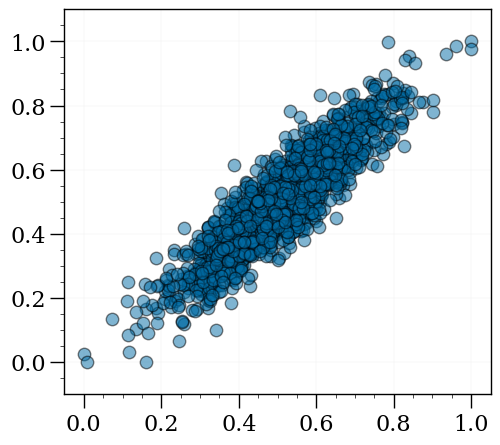

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

rho = 0.9
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
run(TrainingTensors, train_D, test_D, key, 'gauss_09')

  0%|          | 1/10000 [01:00<166:47:59, 60.05s/it]

Iter 0. Loss [[ 0.09073772  0.2813188  18.022959  ]]


  0%|          | 11/10000 [01:59<4:03:32,  1.46s/it]

Iter 10. Loss [[0.09126728 0.26998225 7.1870675 ]]


  0%|          | 21/10000 [02:01<42:39,  3.90it/s]

Iter 20. Loss [[0.09164766 0.26927865 6.94327   ]]


  0%|          | 31/10000 [02:03<37:33,  4.42it/s]

Iter 30. Loss [[0.09148283 0.26826343 6.396403  ]]


  0%|          | 41/10000 [02:06<1:01:09,  2.71it/s]

Iter 40. Loss [[0.090671 0.26488  5.480382]]


  1%|          | 51/10000 [02:10<1:00:56,  2.72it/s]

Iter 50. Loss [[0.08922344 0.26072213 4.574067  ]]


  1%|          | 61/10000 [02:13<45:39,  3.63it/s]

Iter 60. Loss [[0.08748808 0.2563516  3.6571891 ]]


  1%|          | 71/10000 [02:15<36:05,  4.58it/s]

Iter 70. Loss [[0.08573803 0.2566087  3.900815  ]]


  1%|          | 81/10000 [02:17<38:32,  4.29it/s]

Iter 80. Loss [[0.08445222 0.25075346 3.178373  ]]


  1%|          | 91/10000 [02:19<36:39,  4.51it/s]

Iter 90. Loss [[0.08358666 0.24946104 3.3234222 ]]


  1%|          | 101/10000 [02:23<1:02:16,  2.65it/s]

Iter 100. Loss [[0.08324345 0.24535093 3.2985182 ]]


  1%|          | 111/10000 [02:27<54:34,  3.02it/s]  

Iter 110. Loss [[0.08304238 0.24432918 2.7785149 ]]


  1%|          | 121/10000 [02:29<37:25,  4.40it/s]

Iter 120. Loss [[0.08345834 0.24359551 2.7819834 ]]


  1%|▏         | 131/10000 [02:31<43:34,  3.77it/s]

Iter 130. Loss [[0.08393162 0.23941967 2.5526614 ]]


  1%|▏         | 141/10000 [02:33<35:49,  4.59it/s]

Iter 140. Loss [[0.08537336 0.23889256 2.9262753 ]]


  2%|▏         | 151/10000 [02:37<1:00:27,  2.71it/s]

Iter 150. Loss [[0.08726954 0.2392058  3.6428132 ]]


  2%|▏         | 161/10000 [02:40<41:03,  3.99it/s]

Iter 160. Loss [[0.0883451  0.23737447 3.7515702 ]]


  2%|▏         | 171/10000 [02:44<1:01:14,  2.67it/s]

Iter 170. Loss [[0.08925577 0.23604801 3.483045  ]]


  2%|▏         | 181/10000 [02:47<55:15,  2.96it/s]  

Iter 180. Loss [[0.08997971 0.23286432 3.016925  ]]


  2%|▏         | 191/10000 [02:49<44:33,  3.67it/s]

Iter 190. Loss [[0.09156223 0.23152539 2.725994  ]]


  2%|▏         | 201/10000 [02:53<1:03:45,  2.56it/s]

Iter 200. Loss [[0.09299687 0.2256786  2.3726423 ]]


  2%|▏         | 211/10000 [02:56<36:48,  4.43it/s]

Iter 210. Loss [[0.09530769 0.2189931  2.0080063 ]]


  2%|▏         | 221/10000 [02:58<38:33,  4.23it/s]

Iter 220. Loss [[0.0987192  0.21994519 2.526064  ]]


  2%|▏         | 231/10000 [03:00<35:39,  4.57it/s]

Iter 230. Loss [[0.09909939 0.21623693 2.4415853 ]]


  2%|▏         | 241/10000 [03:03<36:36,  4.44it/s]

Iter 240. Loss [[0.10285629 0.22139722 3.6395833 ]]


  3%|▎         | 251/10000 [03:07<1:18:22,  2.07it/s]

Iter 250. Loss [[0.10310217 0.21671647 3.6998887 ]]


  3%|▎         | 261/10000 [03:09<36:57,  4.39it/s]

Iter 260. Loss [[0.10319544 0.20950541 3.559475  ]]


  3%|▎         | 271/10000 [03:12<42:48,  3.79it/s]

Iter 270. Loss [[0.10313482 0.20331715 3.3165715 ]]


  3%|▎         | 281/10000 [03:14<35:30,  4.56it/s]

Iter 280. Loss [[0.10340282 0.19344336 2.793534  ]]


  3%|▎         | 291/10000 [03:17<38:02,  4.25it/s]

Iter 290. Loss [[0.10696721 0.18361737 2.7715244 ]]


  3%|▎         | 301/10000 [03:20<57:42,  2.80it/s]

Iter 300. Loss [[0.11261549 0.16728632 2.5047581 ]]


  3%|▎         | 311/10000 [03:23<37:52,  4.26it/s]

Iter 310. Loss [[0.12500465 0.15706481 2.6558177 ]]


  3%|▎         | 321/10000 [03:26<49:51,  3.24it/s]

Iter 320. Loss [[0.14119008 0.1386633  2.4211073 ]]


  3%|▎         | 331/10000 [03:28<35:37,  4.52it/s]

Iter 330. Loss [[0.16176653 0.11106797 1.5850999 ]]


  3%|▎         | 341/10000 [03:31<41:11,  3.91it/s]

Iter 340. Loss [[0.18799192 0.07825919 0.5081877 ]]


  4%|▎         | 351/10000 [03:33<55:35,  2.89it/s]

Iter 350. Loss [[ 0.19878532  0.07330114 -0.15154691]]


  4%|▎         | 361/10000 [03:37<43:13,  3.72it/s]

Iter 360. Loss [[0.20811531 0.11453752 1.2552283 ]]


  4%|▎         | 371/10000 [03:39<35:31,  4.52it/s]

Iter 370. Loss [[0.19282918 0.05768114 0.32759023]]


  4%|▍         | 381/10000 [03:42<35:57,  4.46it/s]

Iter 380. Loss [[0.2170085  0.13537015 1.3966765 ]]


  4%|▍         | 391/10000 [03:45<50:25,  3.18it/s]

Iter 390. Loss [[0.21752076 0.10074984 0.9162723 ]]


  4%|▍         | 401/10000 [03:47<51:00,  3.14it/s]

Iter 400. Loss [[0.21813071 0.11194257 1.1433145 ]]


  4%|▍         | 411/10000 [03:51<50:15,  3.18it/s]

Iter 410. Loss [[0.21852417 0.10269029 1.3389527 ]]


  4%|▍         | 421/10000 [03:53<36:10,  4.41it/s]

Iter 420. Loss [[0.21996306 0.09017666 1.1079347 ]]


  4%|▍         | 431/10000 [03:56<36:36,  4.36it/s]

Iter 430. Loss [[0.23058389 0.08271719 0.852666  ]]


  4%|▍         | 441/10000 [03:58<35:30,  4.49it/s]

Iter 440. Loss [[0.23895468 0.07504625 0.4727828 ]]


  5%|▍         | 451/10000 [04:01<45:33,  3.49it/s]

Iter 450. Loss [[0.25056806 0.0731196  0.01902602]]


  5%|▍         | 461/10000 [04:05<1:03:27,  2.51it/s]

Iter 460. Loss [[ 0.26231232  0.07311346 -0.16447659]]


  5%|▍         | 471/10000 [04:07<35:36,  4.46it/s]

Iter 470. Loss [[ 0.2781685   0.08538734 -0.55347955]]


  5%|▍         | 481/10000 [04:10<40:24,  3.93it/s]

Iter 480. Loss [[ 0.2795607   0.07994318 -0.6818602 ]]


  5%|▍         | 491/10000 [04:12<34:40,  4.57it/s]

Iter 490. Loss [[ 0.2744158   0.05788182 -0.7244967 ]]


  5%|▌         | 501/10000 [04:15<37:16,  4.25it/s]

Iter 500. Loss [[ 0.2689686   0.06529336 -0.05771698]]


  5%|▌         | 511/10000 [04:19<1:25:57,  1.84it/s]

Iter 510. Loss [[ 0.28371605  0.0889248  -0.47919205]]


  5%|▌         | 521/10000 [04:21<35:47,  4.41it/s]

Iter 520. Loss [[ 0.29965502  0.15219973 -1.1974598 ]]


  5%|▌         | 531/10000 [04:24<45:51,  3.44it/s]

Iter 530. Loss [[ 0.27985314  0.05991712 -0.8849908 ]]


  5%|▌         | 541/10000 [04:26<34:45,  4.54it/s]

Iter 540. Loss [[ 0.27104273  0.05076768 -0.738189  ]]


  6%|▌         | 551/10000 [04:28<39:46,  3.96it/s]

Iter 550. Loss [[ 0.26985177  0.04823693 -0.782326  ]]


  6%|▌         | 561/10000 [04:32<57:04,  2.76it/s]

Iter 560. Loss [[ 0.27173167  0.05875354 -0.87310797]]


  6%|▌         | 571/10000 [04:35<38:54,  4.04it/s]

Iter 570. Loss [[ 0.27390072  0.06534519 -0.32235822]]


  6%|▌         | 581/10000 [04:37<57:06,  2.75it/s]

Iter 580. Loss [[0.27177662 0.05922397 0.09101804]]


  6%|▌         | 591/10000 [04:40<35:46,  4.38it/s]

Iter 590. Loss [[ 0.2713765   0.06334108 -0.0961181 ]]


  6%|▌         | 601/10000 [04:42<45:30,  3.44it/s]

Iter 600. Loss [[0.27261811 0.06385306 0.07995905]]


  6%|▌         | 611/10000 [04:45<56:41,  2.76it/s]

Iter 610. Loss [[0.27123407 0.06703085 0.07570621]]


  6%|▌         | 621/10000 [04:49<42:51,  3.65it/s]

Iter 620. Loss [[0.27012184 0.06710106 0.11078316]]


  6%|▋         | 631/10000 [04:51<35:42,  4.37it/s]

Iter 630. Loss [[0.27043983 0.06685217 0.13918392]]


  6%|▋         | 641/10000 [04:54<36:38,  4.26it/s]

Iter 640. Loss [[0.27029625 0.06401933 0.18590912]]


  7%|▋         | 651/10000 [04:57<56:15,  2.77it/s]

Iter 650. Loss [[0.26883647 0.06354411 0.13555063]]


  7%|▋         | 661/10000 [04:59<54:54,  2.83it/s]

Iter 660. Loss [[0.2667445  0.06264336 0.0547981 ]]


  7%|▋         | 671/10000 [05:03<52:16,  2.97it/s]

Iter 670. Loss [[0.26686972 0.05893765 0.21939974]]


  7%|▋         | 681/10000 [05:05<34:39,  4.48it/s]

Iter 680. Loss [[0.26869667 0.06095447 0.2887127 ]]


  7%|▋         | 691/10000 [05:08<37:59,  4.08it/s]

Iter 690. Loss [[0.26963368 0.06276342 0.3162017 ]]


  7%|▋         | 701/10000 [05:10<34:05,  4.55it/s]

Iter 700. Loss [[0.26957598 0.0634535  0.3293608 ]]


  7%|▋         | 711/10000 [05:13<52:31,  2.95it/s]

Iter 710. Loss [[0.27074012 0.06887982 0.07212089]]


  7%|▋         | 721/10000 [05:17<1:07:19,  2.30it/s]

Iter 720. Loss [[ 0.2750452   0.07969458 -0.5976381 ]]


  7%|▋         | 731/10000 [05:19<34:33,  4.47it/s]

Iter 730. Loss [[ 0.27955073  0.06926939 -0.46203718]]


  7%|▋         | 741/10000 [05:22<40:35,  3.80it/s]

Iter 740. Loss [[ 0.27991548  0.07539763 -0.09034102]]


  8%|▊         | 751/10000 [05:24<33:32,  4.60it/s]

Iter 750. Loss [[0.27296406 0.06826442 0.16247992]]


  8%|▊         | 761/10000 [05:27<45:49,  3.36it/s]

Iter 760. Loss [[0.27114305 0.06817546 0.18370819]]


  8%|▊         | 771/10000 [05:31<57:59,  2.65it/s]

Iter 770. Loss [[0.2727681  0.07420827 0.09170107]]


  8%|▊         | 781/10000 [05:33<35:09,  4.37it/s]

Iter 780. Loss [[0.2714812  0.0762594  0.00551978]]


  8%|▊         | 791/10000 [05:36<49:03,  3.13it/s]

Iter 790. Loss [[ 0.27168757  0.06914506 -0.05097378]]


  8%|▊         | 801/10000 [05:38<33:50,  4.53it/s]

Iter 800. Loss [[ 0.27683246  0.06809574 -0.45451477]]


  8%|▊         | 811/10000 [05:41<39:02,  3.92it/s]

Iter 810. Loss [[ 0.27917418  0.06941256 -0.6797528 ]]


  8%|▊         | 821/10000 [05:44<56:00,  2.73it/s]

Iter 820. Loss [[ 0.27390596  0.0702561  -0.5748417 ]]


  8%|▊         | 831/10000 [05:47<36:19,  4.21it/s]

Iter 830. Loss [[ 0.26723167  0.08283566 -0.13137172]]


  8%|▊         | 841/10000 [05:49<34:05,  4.48it/s]

Iter 840. Loss [[ 0.25984827  0.07327636 -0.17922539]]


  9%|▊         | 851/10000 [05:52<33:56,  4.49it/s]

Iter 850. Loss [[ 0.25793016  0.06143378 -0.3887837 ]]


  9%|▊         | 861/10000 [05:55<43:41,  3.49it/s]

Iter 860. Loss [[ 0.25827083  0.07954922 -0.5300659 ]]


  9%|▊         | 871/10000 [05:58<55:15,  2.75it/s]

Iter 870. Loss [[ 0.25827232  0.09921201 -0.27396402]]


  9%|▉         | 881/10000 [06:01<41:46,  3.64it/s]

Iter 880. Loss [[0.2622823  0.10256226 0.06736003]]


  9%|▉         | 891/10000 [06:03<32:51,  4.62it/s]

Iter 890. Loss [[ 0.27184042  0.06275938 -0.64734226]]


  9%|▉         | 901/10000 [06:06<35:32,  4.27it/s]

Iter 900. Loss [[ 0.27819562  0.07669057 -0.6542854 ]]


  9%|▉         | 911/10000 [06:09<54:03,  2.80it/s]

Iter 910. Loss [[ 0.27502927  0.07941788 -0.7846673 ]]


  9%|▉         | 921/10000 [06:12<53:40,  2.82it/s]

Iter 920. Loss [[ 0.26993543  0.08173008 -0.8265629 ]]


  9%|▉         | 931/10000 [06:15<46:46,  3.23it/s]

Iter 930. Loss [[ 0.2685394   0.08249437 -0.8386973 ]]


  9%|▉         | 941/10000 [06:17<33:53,  4.45it/s]

Iter 940. Loss [[ 0.2702633   0.08292101 -0.91899884]]


 10%|▉         | 951/10000 [06:20<37:02,  4.07it/s]

Iter 950. Loss [[ 0.2723689   0.08575434 -0.81821   ]]


 10%|▉         | 961/10000 [06:22<33:10,  4.54it/s]

Iter 960. Loss [[ 0.27356657  0.08191316 -0.96148646]]


 10%|▉         | 971/10000 [06:26<53:20,  2.82it/s]

Iter 970. Loss [[ 0.27230945  0.08357913 -1.0029311 ]]


 10%|▉         | 981/10000 [06:29<1:03:10,  2.38it/s]

Iter 980. Loss [[ 0.2708781   0.08561435 -1.038244  ]]


 10%|▉         | 991/10000 [06:31<33:52,  4.43it/s]

Iter 990. Loss [[ 0.27289617  0.09836318 -0.8954365 ]]


 10%|█         | 1001/10000 [06:34<43:46,  3.43it/s]

Iter 1000. Loss [[ 0.27498767  0.08074367 -1.1120447 ]]


 10%|█         | 1011/10000 [06:36<33:18,  4.50it/s]

Iter 1010. Loss [[ 0.27375424  0.07846769 -1.1020589 ]]


 10%|█         | 1021/10000 [06:40<53:17,  2.81it/s]

Iter 1020. Loss [[ 0.271536    0.08872966 -0.8999534 ]]


 10%|█         | 1031/10000 [06:43<45:37,  3.28it/s]

Iter 1030. Loss [[ 0.27053672  0.08454861 -0.98048407]]


 10%|█         | 1041/10000 [06:46<34:38,  4.31it/s]

Iter 1040. Loss [[ 0.27196646  0.08833998 -1.1047515 ]]


 11%|█         | 1051/10000 [06:48<54:02,  2.76it/s]

Iter 1050. Loss [[0.2670494  0.07075578 0.8332544 ]]


 11%|█         | 1061/10000 [06:50<34:06,  4.37it/s]

Iter 1060. Loss [[0.26539508 0.06653555 0.5797615 ]]


 11%|█         | 1071/10000 [06:53<55:13,  2.69it/s]

Iter 1070. Loss [[0.2662534 0.0720737 0.3359013]]


 11%|█         | 1081/10000 [06:57<54:03,  2.75it/s]

Iter 1080. Loss [[0.2695565  0.06351797 0.15120724]]


 11%|█         | 1091/10000 [07:00<37:31,  3.96it/s]

Iter 1090. Loss [[ 0.2764565   0.06950911 -0.19071643]]


 11%|█         | 1101/10000 [07:02<33:17,  4.46it/s]

Iter 1100. Loss [[ 0.28164926  0.07292107 -0.29362893]]


 11%|█         | 1111/10000 [07:05<34:58,  4.24it/s]

Iter 1110. Loss [[ 0.28361022  0.07604696 -0.39460263]]


 11%|█         | 1121/10000 [07:07<57:56,  2.55it/s]

Iter 1120. Loss [[ 0.28540874  0.08136681 -0.4957455 ]]


 11%|█▏        | 1131/10000 [07:11<55:14,  2.68it/s]

Iter 1130. Loss [[ 0.28695056  0.08613175 -0.57630473]]


 11%|█▏        | 1141/10000 [07:14<40:34,  3.64it/s]

Iter 1140. Loss [[ 0.28707486  0.0941853  -0.61840117]]


 12%|█▏        | 1151/10000 [07:16<32:29,  4.54it/s]

Iter 1150. Loss [[ 0.28526515  0.09112956 -0.60835487]]


 12%|█▏        | 1161/10000 [07:19<35:46,  4.12it/s]

Iter 1160. Loss [[ 0.28244802  0.08256762 -0.5185891 ]]


 12%|█▏        | 1171/10000 [07:21<32:22,  4.55it/s]

Iter 1170. Loss [[ 0.2782601   0.08035463 -0.4698199 ]]


 12%|█▏        | 1181/10000 [07:25<54:33,  2.69it/s]

Iter 1180. Loss [[ 0.2745834   0.06775683 -0.2554115 ]]


 12%|█▏        | 1191/10000 [07:28<48:14,  3.04it/s]

Iter 1190. Loss [[0.27150354 0.0608305  0.01275971]]


 12%|█▏        | 1201/10000 [07:30<32:44,  4.48it/s]

Iter 1200. Loss [[0.26894012 0.05928816 0.19541097]]


 12%|█▏        | 1211/10000 [07:33<36:38,  4.00it/s]

Iter 1210. Loss [[0.2674919  0.05964742 0.28936026]]


 12%|█▏        | 1221/10000 [07:35<32:38,  4.48it/s]

Iter 1220. Loss [[0.26740858 0.06139289 0.34458542]]


 12%|█▏        | 1231/10000 [07:38<54:43,  2.67it/s]

Iter 1230. Loss [[0.2677766  0.06321595 0.35110846]]


 12%|█▏        | 1241/10000 [07:42<56:38,  2.58it/s]

Iter 1240. Loss [[0.2680851  0.06438113 0.3503624 ]]


 13%|█▎        | 1251/10000 [07:46<35:37,  4.09it/s]

Iter 1250. Loss [[0.2682015  0.06511234 0.34198475]]


 13%|█▎        | 1261/10000 [07:48<41:56,  3.47it/s]

Iter 1260. Loss [[0.26829138 0.06517468 0.33902577]]


 13%|█▎        | 1271/10000 [07:50<32:22,  4.49it/s]

Iter 1270. Loss [[0.26845095 0.06510554 0.34087944]]


 13%|█▎        | 1281/10000 [07:54<56:43,  2.56it/s]

Iter 1280. Loss [[0.26862139 0.06489436 0.34736198]]


 13%|█▎        | 1291/10000 [07:57<33:32,  4.33it/s]

Iter 1290. Loss [[0.2687271  0.06486312 0.34978077]]


 13%|█▎        | 1301/10000 [08:00<33:13,  4.36it/s]

Iter 1300. Loss [[0.2686792  0.06441769 0.35643578]]


 13%|█▎        | 1311/10000 [08:02<53:01,  2.73it/s]

Iter 1310. Loss [[0.2686945  0.06450175 0.35239726]]


 13%|█▎        | 1321/10000 [08:04<33:31,  4.31it/s]

Iter 1320. Loss [[0.26867205 0.06495499 0.34468403]]


 13%|█▎        | 1331/10000 [08:08<1:00:51,  2.37it/s]

Iter 1330. Loss [[0.268632   0.06480481 0.3410224 ]]


 13%|█▎        | 1341/10000 [08:11<34:02,  4.24it/s]

Iter 1340. Loss [[0.26860923 0.06405647 0.35362247]]


 14%|█▎        | 1351/10000 [08:14<35:38,  4.04it/s]

Iter 1350. Loss [[0.268284   0.06445637 0.3333897 ]]


 14%|█▎        | 1361/10000 [08:16<32:02,  4.49it/s]

Iter 1360. Loss [[0.26734513 0.06375454 0.32162106]]


 14%|█▎        | 1371/10000 [08:18<33:47,  4.26it/s]

Iter 1370. Loss [[0.26692465 0.06303597 0.33231235]]


 14%|█▍        | 1381/10000 [08:22<1:08:44,  2.09it/s]

Iter 1380. Loss [[0.2662463  0.06621755 0.32469732]]


 14%|█▍        | 1391/10000 [08:25<35:54,  4.00it/s]

Iter 1390. Loss [[0.26630735 0.06524657 0.32989445]]


 14%|█▍        | 1401/10000 [08:28<38:52,  3.69it/s]

Iter 1400. Loss [[0.26589316 0.0645235  0.3582776 ]]


 14%|█▍        | 1411/10000 [08:30<31:50,  4.50it/s]

Iter 1410. Loss [[0.26566526 0.0686793  0.33870694]]


 14%|█▍        | 1421/10000 [08:33<35:28,  4.03it/s]

Iter 1420. Loss [[0.26489612 0.07075701 0.30514792]]


 14%|█▍        | 1431/10000 [08:36<49:58,  2.86it/s]

Iter 1430. Loss [[0.26564062 0.0661239  0.20208195]]


 14%|█▍        | 1441/10000 [08:39<37:37,  3.79it/s]

Iter 1440. Loss [[0.26423746 0.06874627 0.17410569]]


 15%|█▍        | 1451/10000 [08:42<47:17,  3.01it/s]

Iter 1450. Loss [[0.26398686 0.0744983  0.08503494]]


 15%|█▍        | 1461/10000 [08:44<32:09,  4.43it/s]

Iter 1460. Loss [[ 0.26529416  0.07923374 -0.4548318 ]]


 15%|█▍        | 1471/10000 [08:47<38:39,  3.68it/s]

Iter 1470. Loss [[ 0.269374    0.1723958  -0.12908152]]


 15%|█▍        | 1481/10000 [08:50<47:59,  2.96it/s]

Iter 1480. Loss [[0.26821852 0.06201282 0.42223397]]


 15%|█▍        | 1491/10000 [08:53<40:10,  3.53it/s]

Iter 1490. Loss [[0.2608107  0.07721836 0.09884825]]


 15%|█▌        | 1501/10000 [08:56<31:49,  4.45it/s]

Iter 1500. Loss [[0.26123    0.05665661 0.26235625]]


 15%|█▌        | 1511/10000 [08:58<32:25,  4.36it/s]

Iter 1510. Loss [[0.26271808 0.06233023 0.21595858]]


 15%|█▌        | 1521/10000 [09:01<45:09,  3.13it/s]

Iter 1520. Loss [[0.2636734  0.06648933 0.15054893]]


 15%|█▌        | 1531/10000 [09:03<43:10,  3.27it/s]

Iter 1530. Loss [[0.26364988 0.06424326 0.1234399 ]]


 15%|█▌        | 1541/10000 [09:07<45:47,  3.08it/s]

Iter 1540. Loss [[0.2636696  0.06690767 0.13128416]]


 16%|█▌        | 1551/10000 [09:10<31:00,  4.54it/s]

Iter 1550. Loss [[0.26312247 0.06918954 0.12942979]]


 16%|█▌        | 1561/10000 [09:12<33:10,  4.24it/s]

Iter 1560. Loss [[0.2619015  0.06717739 0.12043437]]


 16%|█▌        | 1571/10000 [09:14<31:49,  4.41it/s]

Iter 1570. Loss [[0.2612653  0.06725893 0.13681617]]


 16%|█▌        | 1581/10000 [09:17<39:52,  3.52it/s]

Iter 1580. Loss [[0.2613574  0.06682414 0.1495012 ]]


 16%|█▌        | 1591/10000 [09:22<1:04:00,  2.19it/s]

Iter 1590. Loss [[0.2613853  0.06647769 0.14832139]]


 16%|█▌        | 1601/10000 [09:24<32:32,  4.30it/s]

Iter 1600. Loss [[0.26163283 0.06558712 0.15054461]]


 16%|█▌        | 1611/10000 [09:27<36:42,  3.81it/s]

Iter 1610. Loss [[0.26194414 0.06825403 0.1297986 ]]


 16%|█▌        | 1621/10000 [09:29<32:44,  4.27it/s]

Iter 1620. Loss [[0.26173314 0.06625998 0.14481916]]


 16%|█▋        | 1631/10000 [09:32<45:02,  3.10it/s]

Iter 1630. Loss [[0.26138914 0.06688172 0.12764244]]


 16%|█▋        | 1641/10000 [09:36<52:09,  2.67it/s]

Iter 1640. Loss [[0.26117238 0.06549484 0.1310603 ]]


 17%|█▋        | 1651/10000 [09:38<33:32,  4.15it/s]

Iter 1650. Loss [[0.26106763 0.0655271  0.12100448]]


 17%|█▋        | 1661/10000 [09:41<46:45,  2.97it/s]

Iter 1660. Loss [[0.2609644  0.06495521 0.12332112]]


 17%|█▋        | 1671/10000 [09:44<32:44,  4.24it/s]

Iter 1670. Loss [[0.26081654 0.06497587 0.11411845]]


 17%|█▋        | 1681/10000 [09:47<51:27,  2.69it/s]

Iter 1680. Loss [[0.26062888 0.0646577  0.11154818]]


 17%|█▋        | 1691/10000 [09:50<46:53,  2.95it/s]

Iter 1690. Loss [[0.26046532 0.06468368 0.10062618]]


 17%|█▋        | 1701/10000 [09:53<34:57,  3.96it/s]

Iter 1700. Loss [[0.2602582  0.06475864 0.06833303]]


 17%|█▋        | 1711/10000 [09:56<34:45,  3.97it/s]

Iter 1710. Loss [[0.25993946 0.06425471 0.06345044]]


 17%|█▋        | 1721/10000 [09:59<35:06,  3.93it/s]

Iter 1720. Loss [[0.25966722 0.0643705  0.0650091 ]]


 17%|█▋        | 1731/10000 [10:02<1:07:00,  2.06it/s]

Iter 1730. Loss [[0.25958934 0.0641647  0.06587138]]


 17%|█▋        | 1741/10000 [10:05<37:42,  3.65it/s]

Iter 1740. Loss [[0.25950086 0.06599165 0.05768283]]


 18%|█▊        | 1751/10000 [10:08<39:44,  3.46it/s]

Iter 1750. Loss [[ 0.25932035  0.06766111 -0.9368084 ]]


 18%|█▊        | 1761/10000 [10:11<33:29,  4.10it/s]

Iter 1760. Loss [[ 0.2635841  0.0788184 -0.9205952]]


 18%|█▊        | 1771/10000 [10:13<34:12,  4.01it/s]

Iter 1770. Loss [[0.26575068 0.1437138  0.12653401]]


 18%|█▊        | 1781/10000 [10:17<48:51,  2.80it/s]

Iter 1780. Loss [[0.2615702  0.11745782 0.4226915 ]]


 18%|█▊        | 1791/10000 [10:20<34:31,  3.96it/s]

Iter 1790. Loss [[0.24418695 0.14945814 0.6939691 ]]


 18%|█▊        | 1801/10000 [10:23<44:17,  3.09it/s]

Iter 1800. Loss [[0.25319204 0.05803459 0.59477365]]


 18%|█▊        | 1811/10000 [10:25<31:03,  4.39it/s]

Iter 1810. Loss [[0.25982213 0.05666247 0.42159876]]


 18%|█▊        | 1821/10000 [10:28<36:04,  3.78it/s]

Iter 1820. Loss [[0.266921   0.06425972 0.32332355]]


 18%|█▊        | 1831/10000 [10:31<48:08,  2.83it/s]

Iter 1830. Loss [[0.27022657 0.06630327 0.33191878]]


 18%|█▊        | 1841/10000 [10:34<36:28,  3.73it/s]

Iter 1840. Loss [[0.26917925 0.06641255 0.3270217 ]]


 19%|█▊        | 1851/10000 [10:37<31:22,  4.33it/s]

Iter 1850. Loss [[0.26809105 0.06652134 0.31143567]]


 19%|█▊        | 1861/10000 [10:39<32:01,  4.24it/s]

Iter 1860. Loss [[0.26689297 0.06468216 0.30876794]]


 19%|█▊        | 1871/10000 [10:42<41:25,  3.27it/s]

Iter 1870. Loss [[0.267197   0.06558767 0.30845216]]


 19%|█▉        | 1881/10000 [10:45<47:30,  2.85it/s]

Iter 1880. Loss [[0.26670682 0.0642882  0.30782455]]


 19%|█▉        | 1891/10000 [10:49<38:17,  3.53it/s]

Iter 1890. Loss [[0.26714283 0.06498076 0.29866704]]


 19%|█▉        | 1901/10000 [10:51<30:06,  4.48it/s]

Iter 1900. Loss [[0.2673022  0.06555428 0.29403552]]


 19%|█▉        | 1911/10000 [10:54<31:41,  4.25it/s]

Iter 1910. Loss [[0.26713917 0.06560539 0.29562443]]


 19%|█▉        | 1921/10000 [10:56<51:04,  2.64it/s]

Iter 1920. Loss [[0.26697633 0.06616224 0.27701485]]


 19%|█▉        | 1931/10000 [10:59<47:20,  2.84it/s]

Iter 1930. Loss [[0.26669782 0.0668161  0.26734897]]


 19%|█▉        | 1941/10000 [11:03<43:48,  3.07it/s]

Iter 1940. Loss [[0.26620764 0.06678273 0.26220253]]


 20%|█▉        | 1951/10000 [11:05<31:00,  4.33it/s]

Iter 1950. Loss [[0.26595113 0.06711149 0.25152668]]


 20%|█▉        | 1961/10000 [11:08<32:11,  4.16it/s]

Iter 1960. Loss [[0.26583156 0.06630228 0.23952058]]


 20%|█▉        | 1971/10000 [11:10<30:10,  4.44it/s]

Iter 1970. Loss [[0.26668507 0.06527743 0.20716724]]


 20%|█▉        | 1981/10000 [11:14<47:50,  2.79it/s]

Iter 1980. Loss [[0.2653685  0.06874989 0.00712108]]


 20%|█▉        | 1991/10000 [11:18<52:04,  2.56it/s]  

Iter 1990. Loss [[ 0.26446846  0.07074476 -0.8437267 ]]


 20%|██        | 2001/10000 [11:20<31:11,  4.27it/s]

Iter 2000. Loss [[ 0.26469776  0.08306494 -0.75753325]]


 20%|██        | 2011/10000 [11:23<34:41,  3.84it/s]

Iter 2010. Loss [[ 0.26486233  0.07938465 -1.14244   ]]


 20%|██        | 2021/10000 [11:25<30:13,  4.40it/s]

Iter 2020. Loss [[ 0.2650287   0.07561734 -1.1944346 ]]


 20%|██        | 2031/10000 [11:28<49:30,  2.68it/s]

Iter 2030. Loss [[ 0.26551446  0.08045954 -1.1127396 ]]


 20%|██        | 2041/10000 [11:32<35:28,  3.74it/s]

Iter 2040. Loss [[ 0.2663425   0.07767072 -1.119468  ]]


 21%|██        | 2051/10000 [11:34<31:08,  4.26it/s]

Iter 2050. Loss [[ 0.26717705  0.07602783 -1.1642731 ]]


 21%|██        | 2061/10000 [11:37<41:30,  3.19it/s]

Iter 2060. Loss [[ 0.26757044  0.08081417 -1.3130252 ]]


 21%|██        | 2071/10000 [11:39<29:40,  4.45it/s]

Iter 2070. Loss [[ 0.26748103  0.08035324 -1.3750112 ]]


 21%|██        | 2081/10000 [11:43<51:07,  2.58it/s]

Iter 2080. Loss [[ 0.26703724  0.08463036 -1.3821393 ]]


 21%|██        | 2091/10000 [11:46<34:06,  3.86it/s]

Iter 2090. Loss [[ 0.2679049   0.08322705 -1.3291429 ]]


 21%|██        | 2101/10000 [11:49<31:24,  4.19it/s]

Iter 2100. Loss [[ 0.26906034  0.09684216 -1.5115232 ]]


 21%|██        | 2111/10000 [11:52<48:37,  2.70it/s]

Iter 2110. Loss [[ 0.27204657  0.09035759 -1.549853  ]]


 21%|██        | 2121/10000 [11:54<29:48,  4.40it/s]

Iter 2120. Loss [[ 0.27511027  0.08285331 -1.4794997 ]]


 21%|██▏       | 2131/10000 [11:57<56:30,  2.32it/s]

Iter 2130. Loss [[ 0.27516744  0.0714057  -1.3068768 ]]


 21%|██▏       | 2141/10000 [12:00<34:11,  3.83it/s]

Iter 2140. Loss [[ 0.27187216  0.06481942 -1.3257192 ]]


 22%|██▏       | 2151/10000 [12:03<31:58,  4.09it/s]

Iter 2150. Loss [[ 0.2667032   0.06506862 -1.2498214 ]]


 22%|██▏       | 2161/10000 [12:05<29:20,  4.45it/s]

Iter 2160. Loss [[ 0.26315686  0.07304005 -1.4049653 ]]


 22%|██▏       | 2171/10000 [12:08<30:41,  4.25it/s]

Iter 2170. Loss [[ 0.26057193  0.06585953 -1.3843589 ]]


 22%|██▏       | 2181/10000 [12:11<40:34,  3.21it/s]

Iter 2180. Loss [[ 0.26138183  0.06850495 -1.5528187 ]]


 22%|██▏       | 2191/10000 [12:14<37:10,  3.50it/s]

Iter 2190. Loss [[ 0.2610221   0.08194216 -1.7722328 ]]


 22%|██▏       | 2201/10000 [12:17<40:53,  3.18it/s]

Iter 2200. Loss [[0.22165743 0.42346835 4.1286545 ]]


 22%|██▏       | 2211/10000 [12:19<29:05,  4.46it/s]

Iter 2210. Loss [[0.21562606 0.078889   1.4894081 ]]


 22%|██▏       | 2221/10000 [12:22<33:35,  3.86it/s]

Iter 2220. Loss [[0.2153122  0.08154599 1.6812437 ]]


 22%|██▏       | 2231/10000 [12:24<36:23,  3.56it/s]

Iter 2230. Loss [[0.2259673  0.07757948 1.4404601 ]]


 22%|██▏       | 2241/10000 [12:28<42:37,  3.03it/s]

Iter 2240. Loss [[0.2415184  0.07371177 1.1421871 ]]


 23%|██▎       | 2251/10000 [12:31<29:35,  4.36it/s]

Iter 2250. Loss [[0.25759166 0.06947069 0.84820163]]


 23%|██▎       | 2261/10000 [12:34<42:23,  3.04it/s]

Iter 2260. Loss [[0.2718226  0.06884813 0.5963806 ]]


 23%|██▎       | 2271/10000 [12:38<48:36,  2.65it/s]

Iter 2270. Loss [[0.2795592  0.08159461 0.5286799 ]]


 23%|██▎       | 2281/10000 [12:41<47:15,  2.72it/s]

Iter 2280. Loss [[0.27578887 0.07596605 0.53348756]]


 23%|██▎       | 2291/10000 [12:44<35:20,  3.64it/s]

Iter 2290. Loss [[0.27347645 0.07274996 0.5513203 ]]


 23%|██▎       | 2301/10000 [12:47<28:36,  4.49it/s]

Iter 2300. Loss [[0.27492103 0.07313257 0.5457733 ]]


 23%|██▎       | 2311/10000 [12:49<29:43,  4.31it/s]

Iter 2310. Loss [[0.2760689  0.07410384 0.5409504 ]]


 23%|██▎       | 2321/10000 [12:51<28:19,  4.52it/s]

Iter 2320. Loss [[0.27567744 0.07377372 0.542256  ]]


 23%|██▎       | 2331/10000 [12:55<47:23,  2.70it/s]

Iter 2330. Loss [[0.27524504 0.07351042 0.54360795]]


 23%|██▎       | 2341/10000 [12:59<43:01,  2.97it/s]

Iter 2340. Loss [[0.27533728 0.07369294 0.54264814]]


 24%|██▎       | 2351/10000 [13:01<28:38,  4.45it/s]

Iter 2350. Loss [[0.2754841  0.07383037 0.5419448 ]]


 24%|██▎       | 2361/10000 [13:03<34:13,  3.72it/s]

Iter 2360. Loss [[0.27546334 0.0737638  0.5422744 ]]


 24%|██▎       | 2371/10000 [13:06<28:12,  4.51it/s]

Iter 2370. Loss [[0.27541918 0.07369779 0.54260886]]


 24%|██▍       | 2381/10000 [13:09<47:43,  2.66it/s]

Iter 2380. Loss [[0.27542663 0.07370933 0.5425497 ]]


 24%|██▍       | 2391/10000 [13:12<32:06,  3.95it/s]

Iter 2390. Loss [[0.27543977 0.07373106 0.54243976]]


 24%|██▍       | 2401/10000 [13:15<29:29,  4.29it/s]

Iter 2400. Loss [[0.27543595 0.07373033 0.5424437 ]]


 24%|██▍       | 2411/10000 [13:18<40:28,  3.12it/s]

Iter 2410. Loss [[0.27543172 0.07372567 0.5424674 ]]


 24%|██▍       | 2421/10000 [13:20<28:25,  4.44it/s]

Iter 2420. Loss [[0.27543354 0.07372664 0.5424623 ]]


 24%|██▍       | 2431/10000 [13:23<47:57,  2.63it/s]

Iter 2430. Loss [[0.27543512 0.07372753 0.54245764]]


 24%|██▍       | 2441/10000 [13:26<32:56,  3.82it/s]

Iter 2440. Loss [[0.27543437 0.07372646 0.54246306]]


 25%|██▍       | 2451/10000 [13:29<30:34,  4.12it/s]

Iter 2450. Loss [[0.27543372 0.07372602 0.5424653 ]]


 25%|██▍       | 2461/10000 [13:31<27:51,  4.51it/s]

Iter 2460. Loss [[0.27543405 0.07372656 0.54246247]]


 25%|██▍       | 2471/10000 [13:34<28:51,  4.35it/s]

Iter 2470. Loss [[0.27543426 0.07372685 0.5424611 ]]


 25%|██▍       | 2481/10000 [13:37<50:54,  2.46it/s]

Iter 2480. Loss [[0.27543417 0.07372667 0.5424618 ]]


 25%|██▍       | 2491/10000 [13:41<35:53,  3.49it/s]

Iter 2490. Loss [[0.27543408 0.07372655 0.5424624 ]]


 25%|██▌       | 2501/10000 [13:43<31:53,  3.92it/s]

Iter 2500. Loss [[0.27543414 0.07372658 0.5424622 ]]


 25%|██▌       | 2511/10000 [13:45<27:45,  4.50it/s]

Iter 2510. Loss [[0.27543417 0.07372662 0.54246205]]


 25%|██▌       | 2521/10000 [13:48<28:31,  4.37it/s]

Iter 2520. Loss [[0.27543417 0.07372662 0.542462  ]]


 25%|██▌       | 2531/10000 [13:51<35:23,  3.52it/s]

Iter 2530. Loss [[0.27543417 0.07372663 0.542462  ]]


 25%|██▌       | 2541/10000 [13:55<38:40,  3.21it/s]

Iter 2540. Loss [[0.2754341  0.07372662 0.54246193]]


 26%|██▌       | 2551/10000 [13:57<35:35,  3.49it/s]

Iter 2550. Loss [[0.27543414 0.07372662 0.54246193]]


 26%|██▌       | 2561/10000 [13:59<27:21,  4.53it/s]

Iter 2560. Loss [[0.27543417 0.07372663 0.54246175]]


 26%|██▌       | 2571/10000 [14:02<31:19,  3.95it/s]

Iter 2570. Loss [[0.27543414 0.07372663 0.5424617 ]]


 26%|██▌       | 2581/10000 [14:04<28:26,  4.35it/s]

Iter 2580. Loss [[0.27543417 0.07372663 0.54246175]]


 26%|██▌       | 2591/10000 [14:09<48:36,  2.54it/s]

Iter 2590. Loss [[0.27543417 0.07372665 0.5424616 ]]


 26%|██▌       | 2601/10000 [14:11<28:41,  4.30it/s]

Iter 2600. Loss [[0.27543417 0.07372663 0.5424617 ]]


 26%|██▌       | 2611/10000 [14:13<28:03,  4.39it/s]

Iter 2610. Loss [[0.2754342  0.07372665 0.5424615 ]]


 26%|██▌       | 2621/10000 [14:16<39:09,  3.14it/s]

Iter 2620. Loss [[0.27543417 0.07372663 0.5424616 ]]


 26%|██▋       | 2631/10000 [14:18<28:03,  4.38it/s]

Iter 2630. Loss [[0.2754342  0.07372663 0.5424615 ]]


 26%|██▋       | 2641/10000 [14:22<51:29,  2.38it/s]

Iter 2640. Loss [[0.2754342  0.07372665 0.5424614 ]]


 27%|██▋       | 2651/10000 [14:25<28:04,  4.36it/s]

Iter 2650. Loss [[0.27543417 0.07372665 0.54246134]]


 27%|██▋       | 2661/10000 [14:27<28:31,  4.29it/s]

Iter 2660. Loss [[0.2754342  0.07372665 0.5424614 ]]


 27%|██▋       | 2671/10000 [14:30<27:00,  4.52it/s]

Iter 2670. Loss [[0.2754342  0.07372665 0.5424614 ]]


 27%|██▋       | 2681/10000 [14:32<27:37,  4.42it/s]

Iter 2680. Loss [[0.27543423 0.07372665 0.5424613 ]]


 27%|██▋       | 2691/10000 [14:36<55:46,  2.18it/s]

Iter 2690. Loss [[0.27543423 0.07372665 0.54246134]]


 27%|██▋       | 2701/10000 [14:39<28:21,  4.29it/s]

Iter 2700. Loss [[0.27543423 0.07372665 0.5424613 ]]


 27%|██▋       | 2711/10000 [14:42<31:39,  3.84it/s]

Iter 2710. Loss [[0.27543423 0.07372665 0.5424612 ]]


 27%|██▋       | 2721/10000 [14:44<27:06,  4.47it/s]

Iter 2720. Loss [[0.27543423 0.07372665 0.54246116]]


 27%|██▋       | 2731/10000 [14:46<28:19,  4.28it/s]

Iter 2730. Loss [[0.27543423 0.07372665 0.54246104]]


 27%|██▋       | 2741/10000 [14:50<44:05,  2.74it/s]

Iter 2740. Loss [[0.27543423 0.07372665 0.54246104]]


 28%|██▊       | 2751/10000 [14:53<29:33,  4.09it/s]

Iter 2750. Loss [[0.27543423 0.07372665 0.5424611 ]]


 28%|██▊       | 2761/10000 [14:56<35:15,  3.42it/s]

Iter 2760. Loss [[0.27543423 0.07372665 0.54246104]]


 28%|██▊       | 2771/10000 [14:58<26:54,  4.48it/s]

Iter 2770. Loss [[0.27543423 0.07372665 0.54246104]]


 28%|██▊       | 2781/10000 [15:01<30:16,  3.97it/s]

Iter 2780. Loss [[0.27543423 0.07372665 0.54246104]]


 28%|██▊       | 2791/10000 [15:04<41:41,  2.88it/s]

Iter 2790. Loss [[0.27543423 0.07372666 0.5424609 ]]


 28%|██▊       | 2801/10000 [15:07<31:54,  3.76it/s]

Iter 2800. Loss [[0.27543423 0.07372665 0.5424609 ]]


 28%|██▊       | 2811/10000 [15:10<44:45,  2.68it/s]

Iter 2810. Loss [[0.27543423 0.07372663 0.5424609 ]]


 28%|██▊       | 2821/10000 [15:12<27:30,  4.35it/s]

Iter 2820. Loss [[0.27543423 0.07372665 0.54246074]]


 28%|██▊       | 2831/10000 [15:15<35:26,  3.37it/s]

Iter 2830. Loss [[0.27543423 0.07372665 0.54246086]]


 28%|██▊       | 2841/10000 [15:18<41:59,  2.84it/s]

Iter 2840. Loss [[0.27543423 0.07372665 0.5424607 ]]


 29%|██▊       | 2851/10000 [15:21<33:45,  3.53it/s]

Iter 2850. Loss [[0.2754343  0.07372666 0.5424606 ]]


 29%|██▊       | 2861/10000 [15:24<27:09,  4.38it/s]

Iter 2860. Loss [[0.2754343  0.07372665 0.5424606 ]]


 29%|██▊       | 2871/10000 [15:26<27:22,  4.34it/s]

Iter 2870. Loss [[0.2754343  0.07372668 0.5424605 ]]


 29%|██▉       | 2881/10000 [15:29<42:40,  2.78it/s]

Iter 2880. Loss [[0.2754343  0.07372666 0.5424606 ]]


 29%|██▉       | 2891/10000 [15:32<38:11,  3.10it/s]

Iter 2890. Loss [[0.2754343  0.07372668 0.54246044]]


 29%|██▉       | 2901/10000 [15:35<43:48,  2.70it/s]

Iter 2900. Loss [[0.2754343  0.07372668 0.5424604 ]]


 29%|██▉       | 2911/10000 [15:38<27:02,  4.37it/s]

Iter 2910. Loss [[0.2754343  0.07372666 0.5424604 ]]


 29%|██▉       | 2921/10000 [15:40<29:41,  3.97it/s]

Iter 2920. Loss [[0.2754343  0.07372668 0.54246026]]


 29%|██▉       | 2931/10000 [15:43<26:26,  4.46it/s]

Iter 2930. Loss [[0.2754343  0.07372668 0.54246026]]


 29%|██▉       | 2941/10000 [15:46<39:04,  3.01it/s]

Iter 2940. Loss [[0.2754343  0.07372666 0.54246026]]


 30%|██▉       | 2951/10000 [15:50<55:08,  2.13it/s]

Iter 2950. Loss [[0.27543432 0.07372668 0.54246026]]


 30%|██▉       | 2961/10000 [15:52<26:27,  4.44it/s]

Iter 2960. Loss [[0.2754343  0.07372666 0.54246026]]


 30%|██▉       | 2971/10000 [15:55<32:25,  3.61it/s]

Iter 2970. Loss [[0.2754343  0.07372666 0.54246026]]


 30%|██▉       | 2981/10000 [15:57<26:12,  4.46it/s]

Iter 2980. Loss [[0.2754343  0.07372667 0.54246014]]


 30%|██▉       | 2991/10000 [16:00<36:33,  3.20it/s]

Iter 2990. Loss [[0.2754343  0.07372666 0.54246014]]


 30%|███       | 3001/10000 [16:03<42:37,  2.74it/s]

Iter 3000. Loss [[0.27543432 0.07372668 0.54246   ]]


 30%|███       | 3011/10000 [16:06<27:46,  4.19it/s]

Iter 3010. Loss [[0.27543432 0.07372668 0.5424599 ]]


 30%|███       | 3021/10000 [16:09<37:11,  3.13it/s]

Iter 3020. Loss [[0.27543432 0.07372668 0.54245996]]


 30%|███       | 3031/10000 [16:11<25:49,  4.50it/s]

Iter 3030. Loss [[0.27543435 0.07372668 0.5424599 ]]


 30%|███       | 3041/10000 [16:14<33:03,  3.51it/s]

Iter 3040. Loss [[0.27543435 0.0737267  0.5424597 ]]


 31%|███       | 3051/10000 [16:17<43:19,  2.67it/s]

Iter 3050. Loss [[0.27543435 0.07372669 0.5424598 ]]


 31%|███       | 3061/10000 [16:20<28:20,  4.08it/s]

Iter 3060. Loss [[0.27543435 0.07372668 0.5424598 ]]


 31%|███       | 3071/10000 [16:22<25:40,  4.50it/s]

Iter 3070. Loss [[0.27543435 0.07372668 0.5424597 ]]


 31%|███       | 3081/10000 [16:25<26:10,  4.41it/s]

Iter 3080. Loss [[0.27543435 0.07372669 0.5424596 ]]


 31%|███       | 3091/10000 [16:28<37:16,  3.09it/s]

Iter 3090. Loss [[0.27543437 0.07372668 0.5424597 ]]


 31%|███       | 3101/10000 [16:31<41:59,  2.74it/s]

Iter 3100. Loss [[0.27543435 0.07372668 0.5424596 ]]


 31%|███       | 3111/10000 [16:34<32:29,  3.53it/s]

Iter 3110. Loss [[0.27543437 0.07372668 0.54245955]]


 31%|███       | 3121/10000 [16:37<26:04,  4.40it/s]

Iter 3120. Loss [[0.27543437 0.07372668 0.54245955]]


 31%|███▏      | 3131/10000 [16:39<27:10,  4.21it/s]

Iter 3130. Loss [[0.27543437 0.07372668 0.54245955]]


 31%|███▏      | 3141/10000 [16:41<25:12,  4.54it/s]

Iter 3140. Loss [[0.27543437 0.07372669 0.5424595 ]]


 32%|███▏      | 3151/10000 [16:45<42:37,  2.68it/s]

Iter 3150. Loss [[0.27543437 0.07372669 0.54245937]]


 32%|███▏      | 3161/10000 [16:49<38:14,  2.98it/s]

Iter 3160. Loss [[0.27543437 0.07372668 0.54245937]]


 32%|███▏      | 3171/10000 [16:51<25:17,  4.50it/s]

Iter 3170. Loss [[0.2754344  0.07372669 0.54245937]]


 32%|███▏      | 3181/10000 [16:53<31:08,  3.65it/s]

Iter 3180. Loss [[0.27543437 0.07372669 0.5424593 ]]


 32%|███▏      | 3191/10000 [16:56<25:00,  4.54it/s]

Iter 3190. Loss [[0.2754344  0.07372668 0.54245925]]


 32%|███▏      | 3201/10000 [16:59<41:45,  2.71it/s]

Iter 3200. Loss [[0.27543437 0.07372669 0.54245925]]


 32%|███▏      | 3211/10000 [17:02<28:13,  4.01it/s]

Iter 3210. Loss [[0.2754344  0.07372668 0.54245925]]


 32%|███▏      | 3221/10000 [17:05<26:12,  4.31it/s]

Iter 3220. Loss [[0.2754344  0.07372669 0.5424591 ]]


 32%|███▏      | 3231/10000 [17:07<35:56,  3.14it/s]

Iter 3230. Loss [[0.2754344  0.07372669 0.5424591 ]]


 32%|███▏      | 3241/10000 [17:10<25:08,  4.48it/s]

Iter 3240. Loss [[0.2754344  0.07372671 0.5424591 ]]


 33%|███▎      | 3251/10000 [17:13<41:59,  2.68it/s]

Iter 3250. Loss [[0.2754344  0.07372671 0.54245895]]


 33%|███▎      | 3261/10000 [17:16<31:24,  3.58it/s]

Iter 3260. Loss [[0.2754344  0.07372669 0.5424589 ]]


 33%|███▎      | 3271/10000 [17:19<26:21,  4.26it/s]

Iter 3270. Loss [[0.2754344  0.07372669 0.5424589 ]]


 33%|███▎      | 3281/10000 [17:21<24:33,  4.56it/s]

Iter 3280. Loss [[0.2754344  0.07372671 0.54245883]]


 33%|███▎      | 3291/10000 [17:24<25:02,  4.47it/s]

Iter 3290. Loss [[0.2754344  0.07372669 0.54245883]]


 33%|███▎      | 3301/10000 [17:27<44:44,  2.50it/s]

Iter 3300. Loss [[0.2754344  0.07372671 0.5424587 ]]


 33%|███▎      | 3311/10000 [17:30<37:08,  3.00it/s]

Iter 3310. Loss [[0.2754344  0.07372671 0.5424587 ]]


 33%|███▎      | 3321/10000 [17:33<28:32,  3.90it/s]

Iter 3320. Loss [[0.2754344  0.07372669 0.5424588 ]]


 33%|███▎      | 3331/10000 [17:35<24:56,  4.46it/s]

Iter 3330. Loss [[0.2754344  0.07372671 0.5424586 ]]


 33%|███▎      | 3341/10000 [17:38<27:17,  4.07it/s]

Iter 3340. Loss [[0.27543443 0.07372669 0.54245865]]


 34%|███▎      | 3351/10000 [17:41<42:09,  2.63it/s]

Iter 3350. Loss [[0.2754344 0.0737267 0.5424586]]


 34%|███▎      | 3361/10000 [17:46<42:26,  2.61it/s]

Iter 3360. Loss [[0.27543443 0.07372671 0.5424585 ]]


 34%|███▎      | 3371/10000 [17:49<36:10,  3.05it/s]

Iter 3370. Loss [[0.27543446 0.07372671 0.5424585 ]]


 34%|███▍      | 3381/10000 [17:51<24:28,  4.51it/s]

Iter 3380. Loss [[0.27543446 0.07372671 0.5424585 ]]


 34%|███▍      | 3391/10000 [17:54<28:12,  3.91it/s]

Iter 3390. Loss [[0.27543446 0.07372672 0.54245836]]


 34%|███▍      | 3401/10000 [17:56<25:00,  4.40it/s]

Iter 3400. Loss [[0.27543446 0.07372671 0.5424582 ]]


 34%|███▍      | 3411/10000 [18:00<42:01,  2.61it/s]

Iter 3410. Loss [[0.27543446 0.07372672 0.5424582 ]]


 34%|███▍      | 3421/10000 [18:02<25:21,  4.32it/s]

Iter 3420. Loss [[0.27543446 0.07372671 0.54245836]]


 34%|███▍      | 3431/10000 [18:05<25:40,  4.26it/s]

Iter 3430. Loss [[0.27543446 0.07372673 0.5424582 ]]


 34%|███▍      | 3441/10000 [18:08<35:19,  3.10it/s]

Iter 3440. Loss [[0.27543446 0.07372671 0.5424582 ]]


 35%|███▍      | 3451/10000 [18:10<24:19,  4.49it/s]

Iter 3450. Loss [[0.27543446 0.07372671 0.5424582 ]]


 35%|███▍      | 3461/10000 [18:14<43:12,  2.52it/s]

Iter 3460. Loss [[0.27543446 0.07372671 0.5424582 ]]


 35%|███▍      | 3471/10000 [18:16<25:55,  4.20it/s]

Iter 3470. Loss [[0.27543446 0.07372672 0.54245794]]


 35%|███▍      | 3481/10000 [18:19<25:15,  4.30it/s]

Iter 3480. Loss [[0.27543446 0.0737267  0.54245806]]


 35%|███▍      | 3491/10000 [18:21<23:54,  4.54it/s]

Iter 3490. Loss [[0.2754345  0.07372674 0.5424578 ]]


 35%|███▌      | 3501/10000 [18:24<24:08,  4.49it/s]

Iter 3500. Loss [[0.27543446 0.07372672 0.54245794]]


 35%|███▌      | 3511/10000 [18:27<45:35,  2.37it/s]

Iter 3510. Loss [[0.27543446 0.07372673 0.5424579 ]]


 35%|███▌      | 3521/10000 [18:30<26:44,  4.04it/s]

Iter 3520. Loss [[0.27543446 0.07372674 0.54245776]]


 35%|███▌      | 3531/10000 [18:33<26:41,  4.04it/s]

Iter 3530. Loss [[0.2754345  0.07372672 0.5424577 ]]


 35%|███▌      | 3541/10000 [18:35<24:05,  4.47it/s]

Iter 3540. Loss [[0.2754345  0.07372672 0.5424578 ]]


 36%|███▌      | 3551/10000 [18:38<24:59,  4.30it/s]

Iter 3550. Loss [[0.27543446 0.07372671 0.5424577 ]]


 36%|███▌      | 3561/10000 [18:41<52:52,  2.03it/s]

Iter 3560. Loss [[0.27543446 0.07372671 0.54245776]]


 36%|███▌      | 3571/10000 [18:44<30:30,  3.51it/s]

Iter 3570. Loss [[0.2754345  0.07372672 0.54245764]]


 36%|███▌      | 3581/10000 [18:47<28:29,  3.76it/s]

Iter 3580. Loss [[0.2754345  0.07372673 0.54245746]]


 36%|███▌      | 3591/10000 [18:49<24:01,  4.45it/s]

Iter 3590. Loss [[0.2754345  0.07372674 0.54245746]]


 36%|███▌      | 3601/10000 [18:52<25:46,  4.14it/s]

Iter 3600. Loss [[0.2754345  0.07372675 0.5424574 ]]


 36%|███▌      | 3611/10000 [18:54<28:42,  3.71it/s]

Iter 3610. Loss [[0.2754345  0.07372674 0.54245734]]


 36%|███▌      | 3621/10000 [18:58<36:08,  2.94it/s]

Iter 3620. Loss [[0.2754345  0.07372674 0.5424573 ]]


 36%|███▋      | 3631/10000 [19:01<38:31,  2.76it/s]

Iter 3630. Loss [[0.2754345  0.07372674 0.5424573 ]]


 36%|███▋      | 3641/10000 [19:03<24:00,  4.41it/s]

Iter 3640. Loss [[0.2754345  0.07372674 0.5424572 ]]


 37%|███▋      | 3651/10000 [19:06<28:59,  3.65it/s]

Iter 3650. Loss [[0.2754345  0.07372672 0.54245734]]


 37%|███▋      | 3661/10000 [19:08<23:44,  4.45it/s]

Iter 3660. Loss [[0.2754345  0.07372674 0.5424572 ]]


 37%|███▋      | 3671/10000 [19:12<41:18,  2.55it/s]

Iter 3670. Loss [[0.2754345  0.07372674 0.54245716]]


 37%|███▋      | 3681/10000 [19:14<24:01,  4.38it/s]

Iter 3680. Loss [[0.27543452 0.07372674 0.5424571 ]]


 37%|███▋      | 3691/10000 [19:17<23:59,  4.38it/s]

Iter 3690. Loss [[0.27543455 0.07372674 0.5424571 ]]


 37%|███▋      | 3701/10000 [19:20<30:23,  3.45it/s]

Iter 3700. Loss [[0.27543455 0.07372674 0.54245704]]


 37%|███▋      | 3711/10000 [19:22<23:35,  4.44it/s]

Iter 3710. Loss [[0.27543455 0.07372675 0.5424569 ]]


 37%|███▋      | 3721/10000 [19:26<42:42,  2.45it/s]

Iter 3720. Loss [[0.27543455 0.07372674 0.542457  ]]


 37%|███▋      | 3731/10000 [19:29<23:41,  4.41it/s]

Iter 3730. Loss [[0.27543458 0.07372676 0.54245687]]


 37%|███▋      | 3741/10000 [19:31<24:10,  4.32it/s]

Iter 3740. Loss [[0.27543455 0.07372674 0.5424569 ]]


 38%|███▊      | 3751/10000 [19:33<22:43,  4.58it/s]

Iter 3750. Loss [[0.27543455 0.07372674 0.5424568 ]]


 38%|███▊      | 3761/10000 [19:36<23:42,  4.39it/s]

Iter 3760. Loss [[0.27543455 0.07372674 0.54245675]]


 38%|███▊      | 3771/10000 [19:40<46:02,  2.26it/s]

Iter 3770. Loss [[0.27543455 0.07372674 0.5424567 ]]


 38%|███▊      | 3781/10000 [19:42<24:31,  4.23it/s]

Iter 3780. Loss [[0.27543458 0.07372676 0.5424566 ]]


 38%|███▊      | 3791/10000 [19:45<25:24,  4.07it/s]

Iter 3790. Loss [[0.27543458 0.07372676 0.5424566 ]]


 38%|███▊      | 3801/10000 [19:47<22:54,  4.51it/s]

Iter 3800. Loss [[0.27543458 0.07372674 0.54245645]]


 38%|███▊      | 3811/10000 [19:50<23:40,  4.36it/s]

Iter 3810. Loss [[0.2754346  0.07372674 0.54245645]]


 38%|███▊      | 3821/10000 [19:53<52:56,  1.95it/s]

Iter 3820. Loss [[0.27543458 0.07372676 0.5424565 ]]


 38%|███▊      | 3831/10000 [19:56<26:00,  3.95it/s]

Iter 3830. Loss [[0.2754346  0.07372675 0.5424564 ]]


 38%|███▊      | 3841/10000 [19:59<27:46,  3.70it/s]

Iter 3840. Loss [[0.27543464 0.07372676 0.5424564 ]]


 39%|███▊      | 3851/10000 [20:01<22:45,  4.50it/s]

Iter 3850. Loss [[0.2754346  0.07372676 0.54245627]]


 39%|███▊      | 3861/10000 [20:04<24:51,  4.12it/s]

Iter 3860. Loss [[0.27543464 0.07372676 0.54245627]]


 39%|███▊      | 3871/10000 [20:07<32:22,  3.16it/s]

Iter 3870. Loss [[0.27543467 0.07372676 0.54245627]]


 39%|███▉      | 3881/10000 [20:10<29:38,  3.44it/s]

Iter 3880. Loss [[0.27543464 0.07372676 0.54245615]]


 39%|███▉      | 3891/10000 [20:13<37:05,  2.75it/s]

Iter 3890. Loss [[0.27543464 0.07372676 0.5424562 ]]


 39%|███▉      | 3901/10000 [20:15<23:06,  4.40it/s]

Iter 3900. Loss [[0.27543464 0.07372677 0.5424561 ]]


 39%|███▉      | 3911/10000 [20:18<29:32,  3.44it/s]

Iter 3910. Loss [[0.27543467 0.07372677 0.54245603]]


 39%|███▉      | 3921/10000 [20:20<30:27,  3.33it/s]

Iter 3920. Loss [[0.27543467 0.07372677 0.54245603]]


 39%|███▉      | 3931/10000 [20:25<34:53,  2.90it/s]

Iter 3930. Loss [[0.27543467 0.07372677 0.542456  ]]


 39%|███▉      | 3941/10000 [20:27<22:44,  4.44it/s]

Iter 3940. Loss [[0.27543467 0.07372676 0.5424559 ]]


 40%|███▉      | 3951/10000 [20:29<24:02,  4.19it/s]

Iter 3950. Loss [[0.27543467 0.07372676 0.5424559 ]]


 40%|███▉      | 3961/10000 [20:32<22:50,  4.41it/s]

Iter 3960. Loss [[0.27543467 0.07372676 0.5424559 ]]


 40%|███▉      | 3971/10000 [20:34<28:13,  3.56it/s]

Iter 3970. Loss [[0.27543467 0.07372676 0.54245585]]


 40%|███▉      | 3981/10000 [20:39<41:29,  2.42it/s]

Iter 3980. Loss [[0.27543473 0.07372677 0.5424558 ]]


 40%|███▉      | 3991/10000 [20:41<22:49,  4.39it/s]

Iter 3990. Loss [[0.27543473 0.07372677 0.5424556 ]]


 40%|████      | 4001/10000 [20:44<25:34,  3.91it/s]

Iter 4000. Loss [[0.27543473 0.07372677 0.5424556 ]]


 40%|████      | 4011/10000 [20:46<22:54,  4.36it/s]

Iter 4010. Loss [[0.27543473 0.07372677 0.54245555]]


 40%|████      | 4021/10000 [20:49<24:03,  4.14it/s]

Iter 4020. Loss [[0.27543473 0.07372677 0.54245555]]


 40%|████      | 4031/10000 [20:53<54:28,  1.83it/s]

Iter 4030. Loss [[0.27543473 0.07372677 0.5424555 ]]


 40%|████      | 4041/10000 [20:55<22:57,  4.32it/s]

Iter 4040. Loss [[0.27543473 0.07372677 0.54245555]]


 41%|████      | 4051/10000 [20:58<26:45,  3.71it/s]

Iter 4050. Loss [[0.27543473 0.07372677 0.54245543]]


 41%|████      | 4061/10000 [21:00<22:11,  4.46it/s]

Iter 4060. Loss [[0.27543473 0.07372677 0.5424553 ]]


 41%|████      | 4071/10000 [21:03<24:11,  4.08it/s]

Iter 4070. Loss [[0.27543473 0.07372679 0.54245526]]


 41%|████      | 4081/10000 [21:06<36:16,  2.72it/s]

Iter 4080. Loss [[0.27543473 0.07372679 0.54245526]]


 41%|████      | 4091/10000 [21:09<25:01,  3.93it/s]

Iter 4090. Loss [[0.27543476 0.07372677 0.5424553 ]]


 41%|████      | 4101/10000 [21:12<31:47,  3.09it/s]

Iter 4100. Loss [[0.27543473 0.07372677 0.54245526]]


 41%|████      | 4111/10000 [21:14<21:45,  4.51it/s]

Iter 4110. Loss [[0.27543476 0.07372677 0.54245514]]


 41%|████      | 4121/10000 [21:17<27:34,  3.55it/s]

Iter 4120. Loss [[0.2754348  0.07372677 0.54245514]]


 41%|████▏     | 4131/10000 [21:20<35:47,  2.73it/s]

Iter 4130. Loss [[0.2754348  0.07372679 0.5424551 ]]


 41%|████▏     | 4141/10000 [21:23<24:47,  3.94it/s]

Iter 4140. Loss [[0.27543476 0.0737268  0.54245496]]


 42%|████▏     | 4151/10000 [21:26<22:15,  4.38it/s]

Iter 4150. Loss [[0.2754348  0.07372679 0.5424549 ]]


 42%|████▏     | 4161/10000 [21:28<22:08,  4.40it/s]

Iter 4160. Loss [[0.2754348  0.07372677 0.5424549 ]]


 42%|████▏     | 4171/10000 [21:31<31:28,  3.09it/s]

Iter 4170. Loss [[0.2754348  0.07372679 0.5424549 ]]


 42%|████▏     | 4181/10000 [21:34<36:03,  2.69it/s]

Iter 4180. Loss [[0.2754348  0.07372679 0.54245484]]


 42%|████▏     | 4191/10000 [21:38<29:11,  3.32it/s]

Iter 4190. Loss [[0.2754348  0.0737268  0.54245466]]


 42%|████▏     | 4201/10000 [21:40<21:25,  4.51it/s]

Iter 4200. Loss [[0.2754348  0.07372679 0.5424547 ]]


 42%|████▏     | 4211/10000 [21:43<23:26,  4.12it/s]

Iter 4210. Loss [[0.2754348  0.0737268  0.54245466]]


 42%|████▏     | 4221/10000 [21:45<21:17,  4.52it/s]

Iter 4220. Loss [[0.27543482 0.0737268  0.5424546 ]]


 42%|████▏     | 4231/10000 [21:49<35:16,  2.73it/s]

Iter 4230. Loss [[0.2754348  0.07372679 0.54245454]]


 42%|████▏     | 4241/10000 [21:52<39:08,  2.45it/s]

Iter 4240. Loss [[0.2754348  0.07372677 0.5424545 ]]


 43%|████▎     | 4251/10000 [21:54<21:51,  4.38it/s]

Iter 4250. Loss [[0.27543482 0.0737268  0.5424545 ]]


 43%|████▎     | 4261/10000 [21:57<26:23,  3.62it/s]

Iter 4260. Loss [[0.27543482 0.07372679 0.5424544 ]]


 43%|████▎     | 4271/10000 [21:59<21:38,  4.41it/s]

Iter 4270. Loss [[0.27543482 0.0737268  0.5424544 ]]


 43%|████▎     | 4281/10000 [22:03<36:20,  2.62it/s]

Iter 4280. Loss [[0.27543482 0.0737268  0.54245436]]


 43%|████▎     | 4291/10000 [22:06<24:28,  3.89it/s]

Iter 4290. Loss [[0.27543482 0.0737268  0.54245436]]


 43%|████▎     | 4301/10000 [22:09<22:07,  4.29it/s]

Iter 4300. Loss [[0.27543482 0.07372679 0.54245424]]


 43%|████▎     | 4311/10000 [22:11<30:04,  3.15it/s]

Iter 4310. Loss [[0.27543485 0.0737268  0.5424542 ]]


 43%|████▎     | 4321/10000 [22:14<21:27,  4.41it/s]

Iter 4320. Loss [[0.27543485 0.07372679 0.54245424]]


 43%|████▎     | 4331/10000 [22:17<36:38,  2.58it/s]

Iter 4330. Loss [[0.27543485 0.0737268  0.54245406]]


 43%|████▎     | 4341/10000 [22:20<24:55,  3.78it/s]

Iter 4340. Loss [[0.27543485 0.0737268  0.5424541 ]]


 44%|████▎     | 4351/10000 [22:23<23:34,  3.99it/s]

Iter 4350. Loss [[0.27543485 0.07372679 0.542454  ]]


 44%|████▎     | 4361/10000 [22:25<20:58,  4.48it/s]

Iter 4360. Loss [[0.27543485 0.07372679 0.542454  ]]


 44%|████▎     | 4371/10000 [22:28<21:39,  4.33it/s]

Iter 4370. Loss [[0.27543485 0.0737268  0.5424539 ]]


 44%|████▍     | 4381/10000 [22:31<45:56,  2.04it/s]

Iter 4380. Loss [[0.27543485 0.0737268  0.5424538 ]]


 44%|████▍     | 4391/10000 [22:34<27:53,  3.35it/s]

Iter 4390. Loss [[0.27543488 0.07372681 0.54245377]]


 44%|████▍     | 4401/10000 [22:37<35:21,  2.64it/s]

Iter 4400. Loss [[0.27543485 0.0737268  0.54245377]]


 44%|████▍     | 4411/10000 [22:41<30:02,  3.10it/s]

Iter 4410. Loss [[0.27543485 0.0737268  0.5424537 ]]


 44%|████▍     | 4421/10000 [22:44<23:45,  3.91it/s]

Iter 4420. Loss [[0.27543485 0.0737268  0.5424536 ]]


 44%|████▍     | 4431/10000 [22:48<35:23,  2.62it/s]

Iter 4430. Loss [[0.27543485 0.0737268  0.5424537 ]]


 44%|████▍     | 4441/10000 [22:50<21:51,  4.24it/s]

Iter 4440. Loss [[0.27543485 0.0737268  0.5424537 ]]


 45%|████▍     | 4451/10000 [22:53<29:53,  3.09it/s]

Iter 4450. Loss [[0.27543488 0.07372682 0.5424535 ]]


 45%|████▍     | 4461/10000 [22:55<20:43,  4.45it/s]

Iter 4460. Loss [[0.27543488 0.07372682 0.5424535 ]]


 45%|████▍     | 4471/10000 [22:58<25:18,  3.64it/s]

Iter 4470. Loss [[0.27543488 0.07372682 0.54245335]]


 45%|████▍     | 4481/10000 [23:02<33:50,  2.72it/s]

Iter 4480. Loss [[0.27543488 0.07372682 0.54245347]]


 45%|████▍     | 4491/10000 [23:05<23:14,  3.95it/s]

Iter 4490. Loss [[0.27543488 0.0737268  0.54245347]]


 45%|████▌     | 4501/10000 [23:07<20:15,  4.52it/s]

Iter 4500. Loss [[0.27543488 0.07372682 0.5424532 ]]


 45%|████▌     | 4511/10000 [23:10<21:04,  4.34it/s]

Iter 4510. Loss [[0.2754349  0.07372682 0.5424533 ]]


 45%|████▌     | 4521/10000 [23:12<29:34,  3.09it/s]

Iter 4520. Loss [[0.27543488 0.07372682 0.5424532 ]]


 45%|████▌     | 4531/10000 [23:16<33:42,  2.70it/s]

Iter 4530. Loss [[0.27543488 0.07372681 0.5424531 ]]


 45%|████▌     | 4541/10000 [23:19<24:51,  3.66it/s]

Iter 4540. Loss [[0.27543488 0.0737268  0.5424532 ]]


 46%|████▌     | 4551/10000 [23:21<20:24,  4.45it/s]

Iter 4550. Loss [[0.2754349  0.0737268  0.54245305]]


 46%|████▌     | 4561/10000 [23:24<21:55,  4.14it/s]

Iter 4560. Loss [[0.2754349  0.07372683 0.54245293]]


 46%|████▌     | 4571/10000 [23:26<20:07,  4.49it/s]

Iter 4570. Loss [[0.2754349  0.07372682 0.54245293]]


 46%|████▌     | 4581/10000 [23:30<32:37,  2.77it/s]

Iter 4580. Loss [[0.2754349  0.0737268  0.54245293]]


 46%|████▌     | 4591/10000 [23:33<30:08,  2.99it/s]

Iter 4590. Loss [[0.27543494 0.07372682 0.5424529 ]]


 46%|████▌     | 4601/10000 [23:36<20:32,  4.38it/s]

Iter 4600. Loss [[0.2754349  0.07372682 0.5424529 ]]


 46%|████▌     | 4611/10000 [23:38<23:24,  3.84it/s]

Iter 4610. Loss [[0.27543494 0.07372683 0.5424527 ]]


 46%|████▌     | 4621/10000 [23:40<20:33,  4.36it/s]

Iter 4620. Loss [[0.27543494 0.07372683 0.5424527 ]]


 46%|████▋     | 4631/10000 [23:44<33:36,  2.66it/s]

Iter 4630. Loss [[0.2754349  0.07372682 0.5424528 ]]


 46%|████▋     | 4641/10000 [23:47<22:11,  4.02it/s]

Iter 4640. Loss [[0.2754349  0.07372682 0.54245263]]


 47%|████▋     | 4651/10000 [23:50<20:53,  4.27it/s]

Iter 4650. Loss [[0.27543494 0.07372683 0.54245263]]


 47%|████▋     | 4661/10000 [23:53<28:29,  3.12it/s]

Iter 4660. Loss [[0.27543494 0.07372683 0.5424526 ]]


 47%|████▋     | 4671/10000 [23:55<20:08,  4.41it/s]

Iter 4670. Loss [[0.27543494 0.07372682 0.5424526 ]]


 47%|████▋     | 4681/10000 [23:58<33:54,  2.61it/s]

Iter 4680. Loss [[0.27543494 0.07372682 0.5424524 ]]


 47%|████▋     | 4691/10000 [24:01<22:37,  3.91it/s]

Iter 4690. Loss [[0.275435   0.07372683 0.5424523 ]]


 47%|████▋     | 4701/10000 [24:04<21:31,  4.10it/s]

Iter 4700. Loss [[0.275435   0.07372684 0.5424522 ]]


 47%|████▋     | 4711/10000 [24:06<19:56,  4.42it/s]

Iter 4710. Loss [[0.275435   0.07372683 0.54245234]]


 47%|████▋     | 4721/10000 [24:09<20:28,  4.30it/s]

Iter 4720. Loss [[0.275435   0.07372682 0.5424522 ]]


 47%|████▋     | 4731/10000 [24:12<39:54,  2.20it/s]

Iter 4730. Loss [[0.275435   0.07372682 0.5424523 ]]


 47%|████▋     | 4741/10000 [24:15<24:19,  3.60it/s]

Iter 4740. Loss [[0.275435   0.07372683 0.54245204]]


 48%|████▊     | 4751/10000 [24:18<22:36,  3.87it/s]

Iter 4750. Loss [[0.275435   0.07372683 0.542452  ]]


 48%|████▊     | 4761/10000 [24:20<19:34,  4.46it/s]

Iter 4760. Loss [[0.275435   0.07372683 0.54245204]]


 48%|████▊     | 4771/10000 [24:23<20:55,  4.17it/s]

Iter 4770. Loss [[0.275435   0.07372683 0.542452  ]]


 48%|████▊     | 4781/10000 [24:26<26:58,  3.23it/s]

Iter 4780. Loss [[0.27543503 0.07372683 0.54245186]]


 48%|████▊     | 4791/10000 [24:30<25:55,  3.35it/s]

Iter 4790. Loss [[0.275435   0.07372683 0.5424518 ]]


 48%|████▊     | 4801/10000 [24:32<25:23,  3.41it/s]

Iter 4800. Loss [[0.275435   0.07372683 0.5424518 ]]


 48%|████▊     | 4811/10000 [24:34<19:51,  4.36it/s]

Iter 4810. Loss [[0.275435   0.07372682 0.5424518 ]]


 48%|████▊     | 4821/10000 [24:37<22:30,  3.84it/s]

Iter 4820. Loss [[0.275435   0.07372683 0.5424517 ]]


 48%|████▊     | 4831/10000 [24:40<23:51,  3.61it/s]

Iter 4830. Loss [[0.27543503 0.07372684 0.54245156]]


 48%|████▊     | 4841/10000 [24:44<29:09,  2.95it/s]

Iter 4840. Loss [[0.27543503 0.07372683 0.5424516 ]]


 49%|████▊     | 4851/10000 [24:46<19:11,  4.47it/s]

Iter 4850. Loss [[0.27543503 0.07372682 0.5424517 ]]


 49%|████▊     | 4861/10000 [24:48<19:46,  4.33it/s]

Iter 4860. Loss [[0.275435   0.07372683 0.5424515 ]]


 49%|████▊     | 4871/10000 [24:51<24:28,  3.49it/s]

Iter 4870. Loss [[0.27543503 0.07372683 0.54245156]]


 49%|████▉     | 4881/10000 [24:53<19:19,  4.41it/s]

Iter 4880. Loss [[0.27543503 0.07372682 0.5424514 ]]


 49%|████▉     | 4891/10000 [24:58<34:15,  2.49it/s]

Iter 4890. Loss [[0.27543506 0.07372683 0.5424513 ]]


 49%|████▉     | 4901/10000 [25:00<20:12,  4.21it/s]

Iter 4900. Loss [[0.27543503 0.07372683 0.5424514 ]]


 49%|████▉     | 4911/10000 [25:03<20:02,  4.23it/s]

Iter 4910. Loss [[0.27543503 0.07372683 0.54245126]]


 49%|████▉     | 4921/10000 [25:05<32:02,  2.64it/s]

Iter 4920. Loss [[0.27543506 0.07372683 0.54245126]]


 49%|████▉     | 4931/10000 [25:08<19:20,  4.37it/s]

Iter 4930. Loss [[0.27543506 0.07372683 0.54245114]]


 49%|████▉     | 4941/10000 [25:12<38:51,  2.17it/s]

Iter 4940. Loss [[0.2754351  0.07372683 0.5424512 ]]


 50%|████▉     | 4951/10000 [25:14<19:22,  4.34it/s]

Iter 4950. Loss [[0.2754351  0.07372685 0.5424511 ]]


 50%|████▉     | 4961/10000 [25:17<20:43,  4.05it/s]

Iter 4960. Loss [[0.27543506 0.07372682 0.54245114]]


 50%|████▉     | 4971/10000 [25:19<18:44,  4.47it/s]

Iter 4970. Loss [[0.2754351  0.07372684 0.5424509 ]]


 50%|████▉     | 4981/10000 [25:22<20:00,  4.18it/s]

Iter 4980. Loss [[0.2754351  0.07372684 0.5424509 ]]


 50%|████▉     | 4991/10000 [25:26<46:00,  1.81it/s]

Iter 4990. Loss [[0.2754351  0.07372683 0.5424509 ]]


 50%|█████     | 5001/10000 [25:28<19:44,  4.22it/s]

Iter 5000. Loss [[0.2754351  0.07372684 0.54245085]]


 50%|█████     | 5011/10000 [25:31<23:03,  3.61it/s]

Iter 5010. Loss [[0.2754351  0.07372685 0.5424507 ]]


 50%|█████     | 5021/10000 [25:33<18:48,  4.41it/s]

Iter 5020. Loss [[0.2754351  0.07372683 0.5424508 ]]


 50%|█████     | 5031/10000 [25:36<21:21,  3.88it/s]

Iter 5030. Loss [[0.2754351  0.07372684 0.5424506 ]]


 50%|█████     | 5041/10000 [25:39<30:28,  2.71it/s]

Iter 5040. Loss [[0.2754351  0.07372683 0.54245067]]


 51%|█████     | 5051/10000 [25:43<20:57,  3.94it/s]

Iter 5050. Loss [[0.2754351  0.07372684 0.5424504 ]]


 51%|█████     | 5061/10000 [25:45<30:31,  2.70it/s]

Iter 5060. Loss [[0.2754351  0.07372683 0.5424505 ]]


 51%|█████     | 5071/10000 [25:48<19:02,  4.32it/s]

Iter 5070. Loss [[0.2754351  0.07372683 0.54245037]]


 51%|█████     | 5081/10000 [25:50<24:37,  3.33it/s]

Iter 5080. Loss [[0.27543512 0.07372685 0.54245037]]


 51%|█████     | 5091/10000 [25:54<30:48,  2.66it/s]

Iter 5090. Loss [[0.27543512 0.07372683 0.5424503 ]]


 51%|█████     | 5101/10000 [25:57<21:53,  3.73it/s]

Iter 5100. Loss [[0.27543512 0.07372683 0.54245037]]


 51%|█████     | 5111/10000 [25:59<18:31,  4.40it/s]

Iter 5110. Loss [[0.27543512 0.07372683 0.54245025]]


 51%|█████     | 5121/10000 [26:02<19:32,  4.16it/s]

Iter 5120. Loss [[0.27543515 0.07372685 0.5424502 ]]


 51%|█████▏    | 5131/10000 [26:05<32:31,  2.49it/s]

Iter 5130. Loss [[0.27543512 0.07372684 0.5424501 ]]


 51%|█████▏    | 5141/10000 [26:09<31:27,  2.57it/s]

Iter 5140. Loss [[0.27543515 0.07372683 0.5424501 ]]


 52%|█████▏    | 5151/10000 [26:12<25:11,  3.21it/s]

Iter 5150. Loss [[0.27543515 0.07372685 0.54244995]]


 52%|█████▏    | 5161/10000 [26:14<18:22,  4.39it/s]

Iter 5160. Loss [[0.27543512 0.07372683 0.54244995]]


 52%|█████▏    | 5171/10000 [26:17<19:57,  4.03it/s]

Iter 5170. Loss [[0.27543515 0.07372683 0.54244995]]


 52%|█████▏    | 5181/10000 [26:19<18:12,  4.41it/s]

Iter 5180. Loss [[0.27543518 0.07372685 0.54244983]]


 52%|█████▏    | 5191/10000 [26:23<30:58,  2.59it/s]

Iter 5190. Loss [[0.27543518 0.07372685 0.5424499 ]]


 52%|█████▏    | 5201/10000 [26:26<30:31,  2.62it/s]

Iter 5200. Loss [[0.27543518 0.07372683 0.5424499 ]]


 52%|█████▏    | 5211/10000 [26:28<18:08,  4.40it/s]

Iter 5210. Loss [[0.27543518 0.07372685 0.5424496 ]]


 52%|█████▏    | 5221/10000 [26:31<21:29,  3.71it/s]

Iter 5220. Loss [[0.27543518 0.07372685 0.54244953]]


 52%|█████▏    | 5231/10000 [26:33<18:00,  4.42it/s]

Iter 5230. Loss [[0.27543518 0.07372683 0.5424496 ]]


 52%|█████▏    | 5241/10000 [26:37<31:21,  2.53it/s]

Iter 5240. Loss [[0.27543518 0.07372683 0.54244953]]


 53%|█████▎    | 5251/10000 [26:40<19:26,  4.07it/s]

Iter 5250. Loss [[0.27543518 0.07372685 0.54244936]]


 53%|█████▎    | 5261/10000 [26:43<18:40,  4.23it/s]

Iter 5260. Loss [[0.27543518 0.07372684 0.54244936]]


 53%|█████▎    | 5271/10000 [26:45<29:19,  2.69it/s]

Iter 5270. Loss [[0.27543518 0.07372684 0.54244936]]


 53%|█████▎    | 5281/10000 [26:48<18:00,  4.37it/s]

Iter 5280. Loss [[0.27543518 0.07372686 0.5424492 ]]


 53%|█████▎    | 5291/10000 [26:51<34:28,  2.28it/s]

Iter 5290. Loss [[0.27543518 0.07372683 0.54244924]]


 53%|█████▎    | 5301/10000 [26:54<19:42,  3.97it/s]

Iter 5300. Loss [[0.27543518 0.07372683 0.5424491 ]]


 53%|█████▎    | 5311/10000 [26:57<20:32,  3.80it/s]

Iter 5310. Loss [[0.27543518 0.07372685 0.542449  ]]


 53%|█████▎    | 5321/10000 [26:59<17:15,  4.52it/s]

Iter 5320. Loss [[0.27543518 0.07372683 0.5424491 ]]


 53%|█████▎    | 5331/10000 [27:02<18:30,  4.21it/s]

Iter 5330. Loss [[0.27543518 0.07372684 0.54244906]]


 53%|█████▎    | 5341/10000 [27:05<27:24,  2.83it/s]

Iter 5340. Loss [[0.27543518 0.07372685 0.54244894]]


 54%|█████▎    | 5351/10000 [27:09<20:25,  3.79it/s]

Iter 5350. Loss [[0.27543518 0.07372682 0.542449  ]]


 54%|█████▎    | 5361/10000 [27:11<22:59,  3.36it/s]

Iter 5360. Loss [[0.27543518 0.07372686 0.54244876]]


 54%|█████▎    | 5371/10000 [27:14<17:43,  4.35it/s]

Iter 5370. Loss [[0.27543518 0.07372683 0.5424487 ]]


 54%|█████▍    | 5381/10000 [27:16<20:03,  3.84it/s]

Iter 5380. Loss [[0.27543518 0.07372683 0.5424488 ]]


 54%|█████▍    | 5391/10000 [27:19<26:32,  2.89it/s]

Iter 5390. Loss [[0.27543524 0.07372685 0.5424486 ]]


 54%|█████▍    | 5401/10000 [27:23<21:09,  3.62it/s]

Iter 5400. Loss [[0.27543518 0.07372683 0.5424486 ]]


 54%|█████▍    | 5411/10000 [27:25<17:29,  4.37it/s]

Iter 5410. Loss [[0.27543518 0.07372682 0.54244864]]


 54%|█████▍    | 5421/10000 [27:28<18:00,  4.24it/s]

Iter 5420. Loss [[0.2754352  0.07372686 0.5424484 ]]


 54%|█████▍    | 5431/10000 [27:30<21:17,  3.58it/s]

Iter 5430. Loss [[0.27543518 0.07372682 0.5424486 ]]


 54%|█████▍    | 5441/10000 [27:33<24:19,  3.12it/s]

Iter 5440. Loss [[0.27543524 0.07372683 0.5424484 ]]


 55%|█████▍    | 5451/10000 [27:37<25:11,  3.01it/s]

Iter 5450. Loss [[0.2754352  0.07372683 0.5424483 ]]


 55%|█████▍    | 5461/10000 [27:41<28:46,  2.63it/s]

Iter 5460. Loss [[0.27543524 0.07372682 0.54244834]]


 55%|█████▍    | 5471/10000 [27:44<19:09,  3.94it/s]

Iter 5470. Loss [[0.27543524 0.07372685 0.54244804]]


 55%|█████▍    | 5481/10000 [27:46<16:44,  4.50it/s]

Iter 5480. Loss [[0.27543524 0.07372682 0.54244816]]


 55%|█████▍    | 5491/10000 [27:50<28:03,  2.68it/s]

Iter 5490. Loss [[0.27543524 0.07372683 0.542448  ]]


 55%|█████▌    | 5501/10000 [27:53<24:40,  3.04it/s]

Iter 5500. Loss [[0.27543524 0.07372683 0.5424479 ]]


 55%|█████▌    | 5511/10000 [27:55<16:56,  4.42it/s]

Iter 5510. Loss [[0.27543524 0.07372682 0.542448  ]]


 55%|█████▌    | 5521/10000 [27:58<19:23,  3.85it/s]

Iter 5520. Loss [[0.27543524 0.07372683 0.5424478 ]]


 55%|█████▌    | 5531/10000 [28:00<17:02,  4.37it/s]

Iter 5530. Loss [[0.27543524 0.07372681 0.5424478 ]]


 55%|█████▌    | 5541/10000 [28:04<29:12,  2.54it/s]

Iter 5540. Loss [[0.27543524 0.07372682 0.5424478 ]]


 56%|█████▌    | 5551/10000 [28:07<17:24,  4.26it/s]

Iter 5550. Loss [[0.27543524 0.07372681 0.5424477 ]]


 56%|█████▌    | 5561/10000 [28:10<16:49,  4.40it/s]

Iter 5560. Loss [[0.27543527 0.07372681 0.5424477 ]]


 56%|█████▌    | 5571/10000 [28:12<23:53,  3.09it/s]

Iter 5570. Loss [[0.27543527 0.07372683 0.54244757]]


 56%|█████▌    | 5581/10000 [28:14<16:49,  4.38it/s]

Iter 5580. Loss [[0.27543524 0.0737268  0.5424477 ]]


 56%|█████▌    | 5591/10000 [28:18<29:02,  2.53it/s]

Iter 5590. Loss [[0.27543527 0.07372683 0.5424474 ]]


 56%|█████▌    | 5601/10000 [28:21<17:56,  4.09it/s]

Iter 5600. Loss [[0.27543527 0.0737268  0.5424474 ]]


 56%|█████▌    | 5611/10000 [28:24<18:00,  4.06it/s]

Iter 5610. Loss [[0.27543527 0.07372681 0.5424474 ]]


 56%|█████▌    | 5621/10000 [28:26<16:27,  4.43it/s]

Iter 5620. Loss [[0.27543527 0.0737268  0.54244727]]


 56%|█████▋    | 5631/10000 [28:29<16:52,  4.31it/s]

Iter 5630. Loss [[0.27543527 0.0737268  0.54244727]]


 56%|█████▋    | 5641/10000 [28:32<34:15,  2.12it/s]

Iter 5640. Loss [[0.27543527 0.07372682 0.54244703]]


 57%|█████▋    | 5651/10000 [28:35<18:36,  3.90it/s]

Iter 5650. Loss [[0.27543527 0.0737268  0.5424471 ]]


 57%|█████▋    | 5661/10000 [28:38<19:43,  3.67it/s]

Iter 5660. Loss [[0.27543527 0.07372682 0.5424469 ]]


 57%|█████▋    | 5671/10000 [28:40<16:59,  4.25it/s]

Iter 5670. Loss [[0.27543527 0.07372679 0.54244703]]


 57%|█████▋    | 5681/10000 [28:43<17:36,  4.09it/s]

Iter 5680. Loss [[0.27543527 0.07372681 0.5424468 ]]


 57%|█████▋    | 5691/10000 [28:46<25:02,  2.87it/s]

Iter 5690. Loss [[0.27543527 0.07372677 0.5424469 ]]


 57%|█████▋    | 5701/10000 [28:50<19:42,  3.63it/s]

Iter 5700. Loss [[0.27543527 0.07372681 0.5424467 ]]


 57%|█████▋    | 5711/10000 [28:52<23:08,  3.09it/s]

Iter 5710. Loss [[0.27543527 0.07372679 0.5424467 ]]


 57%|█████▋    | 5721/10000 [28:54<16:19,  4.37it/s]

Iter 5720. Loss [[0.27543527 0.0737268  0.54244655]]


 57%|█████▋    | 5731/10000 [28:57<19:25,  3.66it/s]

Iter 5730. Loss [[0.27543527 0.0737268  0.54244655]]


 57%|█████▋    | 5741/10000 [29:00<23:38,  3.00it/s]

Iter 5740. Loss [[0.27543527 0.07372678 0.54244643]]


 58%|█████▊    | 5751/10000 [29:04<21:25,  3.31it/s]

Iter 5750. Loss [[0.27543527 0.07372679 0.54244643]]


 58%|█████▊    | 5761/10000 [29:06<16:35,  4.26it/s]

Iter 5760. Loss [[0.27543527 0.07372676 0.5424465 ]]


 58%|█████▊    | 5771/10000 [29:09<16:45,  4.21it/s]

Iter 5770. Loss [[0.2754353  0.07372679 0.54244614]]


 58%|█████▊    | 5781/10000 [29:11<25:37,  2.74it/s]

Iter 5780. Loss [[0.27543527 0.07372676 0.54244626]]


 58%|█████▊    | 5791/10000 [29:14<23:34,  2.98it/s]

Iter 5790. Loss [[0.2754353 0.0737268 0.542446 ]]


 58%|█████▊    | 5801/10000 [29:18<23:18,  3.00it/s]

Iter 5800. Loss [[0.27543527 0.07372677 0.54244614]]


 58%|█████▊    | 5811/10000 [29:20<16:06,  4.34it/s]

Iter 5810. Loss [[0.27543527 0.07372679 0.5424459 ]]


 58%|█████▊    | 5821/10000 [29:23<17:32,  3.97it/s]

Iter 5820. Loss [[0.27543527 0.07372675 0.542446  ]]


 58%|█████▊    | 5831/10000 [29:25<15:40,  4.43it/s]

Iter 5830. Loss [[0.2754353 0.0737268 0.5424458]]


 58%|█████▊    | 5841/10000 [29:28<21:37,  3.21it/s]

Iter 5840. Loss [[0.27543527 0.07372674 0.5424458 ]]


 59%|█████▊    | 5851/10000 [29:32<33:52,  2.04it/s]

Iter 5850. Loss [[0.2754353  0.07372679 0.5424455 ]]


 59%|█████▊    | 5861/10000 [29:35<17:08,  4.03it/s]

Iter 5860. Loss [[0.27543527 0.07372673 0.5424457 ]]


 59%|█████▊    | 5871/10000 [29:37<19:08,  3.60it/s]

Iter 5870. Loss [[0.2754353  0.07372679 0.54244536]]


 59%|█████▉    | 5881/10000 [29:40<15:29,  4.43it/s]

Iter 5880. Loss [[0.2754353  0.07372674 0.5424456 ]]


 59%|█████▉    | 5891/10000 [29:43<23:32,  2.91it/s]

Iter 5890. Loss [[0.2754353  0.07372677 0.5424453 ]]


 59%|█████▉    | 5901/10000 [29:47<24:04,  2.84it/s]

Iter 5900. Loss [[0.2754353  0.07372674 0.5424453 ]]


 59%|█████▉    | 5911/10000 [29:49<15:54,  4.29it/s]

Iter 5910. Loss [[0.2754353  0.07372675 0.54244524]]


 59%|█████▉    | 5921/10000 [29:52<24:38,  2.76it/s]

Iter 5920. Loss [[0.2754353  0.07372674 0.5424451 ]]


 59%|█████▉    | 5931/10000 [29:54<15:50,  4.28it/s]

Iter 5930. Loss [[0.2754353  0.07372674 0.54244506]]


 59%|█████▉    | 5941/10000 [29:57<23:44,  2.85it/s]

Iter 5940. Loss [[0.2754353  0.07372674 0.542445  ]]


 60%|█████▉    | 5951/10000 [30:01<25:19,  2.66it/s]

Iter 5950. Loss [[0.2754353  0.07372672 0.5424449 ]]


 60%|█████▉    | 5961/10000 [30:04<16:55,  3.98it/s]

Iter 5960. Loss [[0.2754353  0.07372675 0.54244477]]


 60%|█████▉    | 5971/10000 [30:06<15:00,  4.48it/s]

Iter 5970. Loss [[0.2754353  0.07372671 0.5424448 ]]


 60%|█████▉    | 5981/10000 [30:08<15:21,  4.36it/s]

Iter 5980. Loss [[0.27543533 0.07372674 0.54244447]]


 60%|█████▉    | 5991/10000 [30:11<26:37,  2.51it/s]

Iter 5990. Loss [[0.2754353  0.07372671 0.5424446 ]]


 60%|██████    | 6001/10000 [30:15<25:13,  2.64it/s]

Iter 6000. Loss [[0.2754353  0.07372672 0.54244447]]


 60%|██████    | 6011/10000 [30:18<20:00,  3.32it/s]

Iter 6010. Loss [[0.2754353  0.07372669 0.54244447]]


 60%|██████    | 6021/10000 [30:20<14:56,  4.44it/s]

Iter 6020. Loss [[0.27543533 0.07372672 0.54244417]]


 60%|██████    | 6031/10000 [30:23<16:21,  4.04it/s]

Iter 6030. Loss [[0.2754353  0.07372669 0.5424442 ]]


 60%|██████    | 6041/10000 [30:25<14:43,  4.48it/s]

Iter 6040. Loss [[0.2754353 0.0737267 0.5424441]]


 61%|██████    | 6051/10000 [30:29<24:52,  2.65it/s]

Iter 6050. Loss [[0.2754353  0.07372669 0.542444  ]]


 61%|██████    | 6061/10000 [30:32<24:05,  2.73it/s]

Iter 6060. Loss [[0.2754353  0.07372668 0.54244393]]


 61%|██████    | 6071/10000 [30:34<14:52,  4.40it/s]

Iter 6070. Loss [[0.27543533 0.0737267  0.5424437 ]]


 61%|██████    | 6081/10000 [30:37<17:40,  3.70it/s]

Iter 6080. Loss [[0.2754353  0.07372668 0.54244375]]


 61%|██████    | 6091/10000 [30:39<14:38,  4.45it/s]

Iter 6090. Loss [[0.2754353  0.07372666 0.54244363]]


 61%|██████    | 6101/10000 [30:43<25:09,  2.58it/s]

Iter 6100. Loss [[0.2754353  0.07372667 0.5424436 ]]


 61%|██████    | 6111/10000 [30:46<15:53,  4.08it/s]

Iter 6110. Loss [[0.27543533 0.07372666 0.54244345]]


 61%|██████    | 6121/10000 [30:48<14:57,  4.32it/s]

Iter 6120. Loss [[0.27543533 0.07372668 0.5424433 ]]


 61%|██████▏   | 6131/10000 [30:51<20:37,  3.13it/s]

Iter 6130. Loss [[0.2754353  0.07372665 0.54244334]]


 61%|██████▏   | 6141/10000 [30:53<14:23,  4.47it/s]

Iter 6140. Loss [[0.27543533 0.07372666 0.5424431 ]]


 62%|██████▏   | 6151/10000 [30:57<25:43,  2.49it/s]

Iter 6150. Loss [[0.27543533 0.07372665 0.54244304]]


 62%|██████▏   | 6161/10000 [31:00<16:08,  3.96it/s]

Iter 6160. Loss [[0.2754353  0.07372665 0.5424429 ]]


 62%|██████▏   | 6171/10000 [31:02<15:44,  4.05it/s]

Iter 6170. Loss [[0.2754353  0.07372662 0.5424429 ]]


 62%|██████▏   | 6181/10000 [31:04<14:13,  4.48it/s]

Iter 6180. Loss [[0.27543533 0.07372662 0.54244274]]


 62%|██████▏   | 6191/10000 [31:07<14:41,  4.32it/s]

Iter 6190. Loss [[0.27543533 0.07372661 0.5424426 ]]


 62%|██████▏   | 6201/10000 [31:10<28:15,  2.24it/s]

Iter 6200. Loss [[0.27543533 0.07372661 0.5424426 ]]


 62%|██████▏   | 6211/10000 [31:14<17:27,  3.62it/s]

Iter 6210. Loss [[0.27543533 0.0737266  0.54244244]]


 62%|██████▏   | 6221/10000 [31:16<16:52,  3.73it/s]

Iter 6220. Loss [[0.27543533 0.07372659 0.5424423 ]]


 62%|██████▏   | 6231/10000 [31:19<14:16,  4.40it/s]

Iter 6230. Loss [[0.27543533 0.0737266  0.5424422 ]]


 62%|██████▏   | 6241/10000 [31:21<14:45,  4.24it/s]

Iter 6240. Loss [[0.27543533 0.07372659 0.5424421 ]]


 63%|██████▎   | 6251/10000 [31:24<17:18,  3.61it/s]

Iter 6250. Loss [[0.2754353  0.07372658 0.542442  ]]


 63%|██████▎   | 6261/10000 [31:28<20:53,  2.98it/s]

Iter 6260. Loss [[0.27543533 0.07372658 0.5424419 ]]


 63%|██████▎   | 6271/10000 [31:30<19:45,  3.15it/s]

Iter 6270. Loss [[0.27543536 0.07372657 0.5424417 ]]


 63%|██████▎   | 6281/10000 [31:32<13:51,  4.47it/s]

Iter 6280. Loss [[0.2754353  0.07372655 0.5424417 ]]


 63%|██████▎   | 6291/10000 [31:35<16:13,  3.81it/s]

Iter 6290. Loss [[0.27543533 0.07372656 0.5424415 ]]


 63%|██████▎   | 6301/10000 [31:37<13:39,  4.52it/s]

Iter 6300. Loss [[0.27543533 0.07372656 0.54244125]]


 63%|██████▎   | 6311/10000 [31:41<23:48,  2.58it/s]

Iter 6310. Loss [[0.2754353  0.07372652 0.54244125]]


 63%|██████▎   | 6321/10000 [31:44<13:54,  4.41it/s]

Iter 6320. Loss [[0.27543533 0.07372654 0.54244107]]


 63%|██████▎   | 6331/10000 [31:46<14:03,  4.35it/s]

Iter 6330. Loss [[0.27543533 0.07372653 0.542441  ]]


 63%|██████▎   | 6341/10000 [31:49<17:25,  3.50it/s]

Iter 6340. Loss [[0.2754353 0.0737265 0.5424409]]


 64%|██████▎   | 6351/10000 [31:51<13:43,  4.43it/s]

Iter 6350. Loss [[0.27543533 0.07372653 0.54244065]]


 64%|██████▎   | 6361/10000 [31:55<25:02,  2.42it/s]

Iter 6360. Loss [[0.2754353  0.07372648 0.54244065]]


 64%|██████▎   | 6371/10000 [31:58<14:21,  4.21it/s]

Iter 6370. Loss [[0.2754353  0.07372647 0.54244053]]


 64%|██████▍   | 6381/10000 [32:01<14:34,  4.14it/s]

Iter 6380. Loss [[0.27543533 0.0737265  0.54244024]]


 64%|██████▍   | 6391/10000 [32:03<13:25,  4.48it/s]

Iter 6390. Loss [[0.2754353  0.07372647 0.5424401 ]]


 64%|██████▍   | 6401/10000 [32:06<14:03,  4.27it/s]

Iter 6400. Loss [[0.2754353  0.07372645 0.54244   ]]


 64%|██████▍   | 6411/10000 [32:09<28:35,  2.09it/s]

Iter 6410. Loss [[0.27543533 0.07372645 0.5424399 ]]


 64%|██████▍   | 6421/10000 [32:12<14:19,  4.17it/s]

Iter 6420. Loss [[0.27543533 0.07372644 0.54243976]]


 64%|██████▍   | 6431/10000 [32:15<15:26,  3.85it/s]

Iter 6430. Loss [[0.2754353  0.07372642 0.54243964]]


 64%|██████▍   | 6441/10000 [32:17<13:18,  4.46it/s]

Iter 6440. Loss [[0.27543533 0.07372643 0.5424394 ]]


 65%|██████▍   | 6451/10000 [32:20<14:23,  4.11it/s]

Iter 6450. Loss [[0.2754353 0.0737264 0.5424393]]


 65%|██████▍   | 6461/10000 [32:23<20:56,  2.82it/s]

Iter 6460. Loss [[0.27543527 0.07372639 0.5424391 ]]


 65%|██████▍   | 6471/10000 [32:28<23:41,  2.48it/s]

Iter 6470. Loss [[0.27543527 0.07372639 0.54243886]]


 65%|██████▍   | 6481/10000 [32:31<18:20,  3.20it/s]

Iter 6480. Loss [[0.27543527 0.07372635 0.5424388 ]]


 65%|██████▍   | 6491/10000 [32:33<13:06,  4.46it/s]

Iter 6490. Loss [[0.27543527 0.07372634 0.54243857]]


 65%|██████▌   | 6501/10000 [32:36<15:14,  3.83it/s]

Iter 6500. Loss [[0.2754353  0.07372636 0.5424384 ]]


 65%|██████▌   | 6511/10000 [32:39<20:59,  2.77it/s]

Iter 6510. Loss [[0.2754353  0.07372634 0.54243815]]


 65%|██████▌   | 6521/10000 [32:43<15:27,  3.75it/s]

Iter 6520. Loss [[0.27543527 0.0737263  0.54243815]]


 65%|██████▌   | 6531/10000 [32:45<13:01,  4.44it/s]

Iter 6530. Loss [[0.27543527 0.07372627 0.542438  ]]


 65%|██████▌   | 6541/10000 [32:47<13:06,  4.40it/s]

Iter 6540. Loss [[0.27543527 0.0737263  0.5424377 ]]


 66%|██████▌   | 6551/10000 [32:50<16:27,  3.49it/s]

Iter 6550. Loss [[0.27543527 0.07372627 0.5424375 ]]


 66%|██████▌   | 6561/10000 [32:53<20:01,  2.86it/s]

Iter 6560. Loss [[0.27543527 0.07372625 0.5424373 ]]


 66%|██████▌   | 6571/10000 [32:57<16:31,  3.46it/s]

Iter 6570. Loss [[0.27543527 0.07372624 0.5424371 ]]


 66%|██████▌   | 6581/10000 [32:59<12:54,  4.42it/s]

Iter 6580. Loss [[0.27543527 0.0737262  0.5424369 ]]


 66%|██████▌   | 6591/10000 [33:02<13:22,  4.25it/s]

Iter 6590. Loss [[0.27543524 0.07372621 0.5424366 ]]


 66%|██████▌   | 6601/10000 [33:04<12:48,  4.42it/s]

Iter 6600. Loss [[0.27543527 0.0737262  0.5424363 ]]


 66%|██████▌   | 6611/10000 [33:07<19:53,  2.84it/s]

Iter 6610. Loss [[0.27543524 0.07372616 0.5424362 ]]


 66%|██████▌   | 6621/10000 [33:11<19:48,  2.84it/s]

Iter 6620. Loss [[0.2754352  0.07372613 0.5424361 ]]


 66%|██████▋   | 6631/10000 [33:13<12:41,  4.42it/s]

Iter 6630. Loss [[0.27543524 0.07372613 0.5424357 ]]


 66%|██████▋   | 6641/10000 [33:16<13:56,  4.02it/s]

Iter 6640. Loss [[0.27543524 0.07372612 0.5424355 ]]


 67%|██████▋   | 6651/10000 [33:18<12:30,  4.46it/s]

Iter 6650. Loss [[0.2754352  0.07372608 0.5424353 ]]


 67%|██████▋   | 6661/10000 [33:21<18:34,  3.00it/s]

Iter 6660. Loss [[0.2754352  0.07372607 0.542435  ]]


 67%|██████▋   | 6671/10000 [33:25<25:55,  2.14it/s]

Iter 6670. Loss [[0.27543518 0.07372604 0.54243475]]


 67%|██████▋   | 6681/10000 [33:27<12:52,  4.29it/s]

Iter 6680. Loss [[0.27543518 0.073726   0.5424346 ]]


 67%|██████▋   | 6691/10000 [33:30<16:01,  3.44it/s]

Iter 6690. Loss [[0.27543518 0.07372599 0.5424342 ]]


 67%|██████▋   | 6701/10000 [33:32<12:25,  4.42it/s]

Iter 6700. Loss [[0.27543518 0.07372599 0.54243386]]


 67%|██████▋   | 6711/10000 [33:35<18:20,  2.99it/s]

Iter 6710. Loss [[0.27543518 0.07372595 0.54243356]]


 67%|██████▋   | 6721/10000 [33:39<19:31,  2.80it/s]

Iter 6720. Loss [[0.27543512 0.07372591 0.54243344]]


 67%|██████▋   | 6731/10000 [33:42<13:09,  4.14it/s]

Iter 6730. Loss [[0.27543515 0.07372589 0.5424331 ]]


 67%|██████▋   | 6741/10000 [33:44<19:27,  2.79it/s]

Iter 6740. Loss [[0.27543512 0.07372586 0.5424327 ]]


 68%|██████▊   | 6751/10000 [33:47<12:20,  4.38it/s]

Iter 6750. Loss [[0.2754351  0.07372581 0.54243255]]


 68%|██████▊   | 6761/10000 [33:49<19:10,  2.82it/s]

Iter 6760. Loss [[0.2754351 0.0737258 0.5424321]]


 68%|██████▊   | 6771/10000 [33:53<19:36,  2.74it/s]

Iter 6770. Loss [[0.2754351  0.07372579 0.5424317 ]]


 68%|██████▊   | 6781/10000 [33:56<13:32,  3.96it/s]

Iter 6780. Loss [[0.27543506 0.07372573 0.5424315 ]]


 68%|██████▊   | 6791/10000 [33:58<11:51,  4.51it/s]

Iter 6790. Loss [[0.27543503 0.0737257  0.542431  ]]


 68%|██████▊   | 6801/10000 [34:01<12:16,  4.34it/s]

Iter 6800. Loss [[0.27543503 0.07372567 0.5424306 ]]


 68%|██████▊   | 6811/10000 [34:03<11:55,  4.46it/s]

Iter 6810. Loss [[0.275435   0.07372562 0.54243034]]


 68%|██████▊   | 6821/10000 [34:07<19:54,  2.66it/s]

Iter 6820. Loss [[0.27543497 0.07372559 0.54242986]]


 68%|██████▊   | 6831/10000 [34:10<15:42,  3.36it/s]

Iter 6830. Loss [[0.27543497 0.07372556 0.5424295 ]]


 68%|██████▊   | 6841/10000 [34:12<11:41,  4.50it/s]

Iter 6840. Loss [[0.27543494 0.07372551 0.542429  ]]


 69%|██████▊   | 6851/10000 [34:15<13:42,  3.83it/s]

Iter 6850. Loss [[0.27543494 0.07372548 0.54242855]]


 69%|██████▊   | 6861/10000 [34:17<11:34,  4.52it/s]

Iter 6860. Loss [[0.27543488 0.07372542 0.54242814]]


 69%|██████▊   | 6871/10000 [34:21<19:27,  2.68it/s]

Iter 6870. Loss [[0.27543485 0.07372536 0.5424278 ]]


 69%|██████▉   | 6881/10000 [34:24<12:16,  4.23it/s]

Iter 6880. Loss [[0.27543485 0.07372534 0.5424272 ]]


 69%|██████▉   | 6891/10000 [34:26<11:54,  4.35it/s]

Iter 6890. Loss [[0.27543485 0.07372528 0.54242665]]


 69%|██████▉   | 6901/10000 [34:29<15:11,  3.40it/s]

Iter 6900. Loss [[0.27543482 0.07372522 0.5424262 ]]


 69%|██████▉   | 6911/10000 [34:31<11:28,  4.49it/s]

Iter 6910. Loss [[0.27543482 0.07372519 0.5424255 ]]


 69%|██████▉   | 6921/10000 [34:35<20:23,  2.52it/s]

Iter 6920. Loss [[0.27543473 0.0737251  0.5424251 ]]


 69%|██████▉   | 6931/10000 [34:38<12:33,  4.07it/s]

Iter 6930. Loss [[0.27543473 0.07372507 0.5424244 ]]


 69%|██████▉   | 6941/10000 [34:41<12:30,  4.08it/s]

Iter 6940. Loss [[0.2754347 0.073725  0.5424239]]


 70%|██████▉   | 6951/10000 [34:43<11:26,  4.44it/s]

Iter 6950. Loss [[0.27543467 0.07372493 0.54242325]]


 70%|██████▉   | 6961/10000 [34:46<11:51,  4.27it/s]

Iter 6960. Loss [[0.27543467 0.07372487 0.5424228 ]]


 70%|██████▉   | 6971/10000 [34:49<23:49,  2.12it/s]

Iter 6970. Loss [[0.27543458 0.07372478 0.54242206]]


 70%|██████▉   | 6981/10000 [34:52<12:57,  3.88it/s]

Iter 6980. Loss [[0.27543458 0.07372472 0.5424213 ]]


 70%|██████▉   | 6991/10000 [34:55<13:14,  3.79it/s]

Iter 6990. Loss [[0.27543455 0.07372464 0.54242057]]


 70%|███████   | 7001/10000 [34:57<11:07,  4.49it/s]

Iter 7000. Loss [[0.2754345  0.07372458 0.5424198 ]]


 70%|███████   | 7011/10000 [35:00<12:04,  4.13it/s]

Iter 7010. Loss [[0.27543446 0.07372449 0.54241896]]


 70%|███████   | 7021/10000 [35:03<16:39,  2.98it/s]

Iter 7020. Loss [[0.27543446 0.07372442 0.5424181 ]]


 70%|███████   | 7031/10000 [35:06<13:54,  3.56it/s]

Iter 7030. Loss [[0.2754344  0.07372431 0.5424173 ]]


 70%|███████   | 7041/10000 [35:09<16:12,  3.04it/s]

Iter 7040. Loss [[0.27543435 0.07372423 0.5424164 ]]


 71%|███████   | 7051/10000 [35:11<11:20,  4.34it/s]

Iter 7050. Loss [[0.27543426 0.07372414 0.5424154 ]]


 71%|███████   | 7061/10000 [35:14<12:45,  3.84it/s]

Iter 7060. Loss [[0.27543426 0.07372403 0.5424145 ]]


 71%|███████   | 7071/10000 [35:17<15:55,  3.07it/s]

Iter 7070. Loss [[0.2754342  0.07372392 0.5424134 ]]


 71%|███████   | 7081/10000 [35:21<14:34,  3.34it/s]

Iter 7080. Loss [[0.2754341  0.07372381 0.5424123 ]]


 71%|███████   | 7091/10000 [35:23<10:54,  4.44it/s]

Iter 7090. Loss [[0.27543405 0.0737237  0.54241115]]


 71%|███████   | 7101/10000 [35:25<10:58,  4.40it/s]

Iter 7100. Loss [[0.27543405 0.07372358 0.5424101 ]]


 71%|███████   | 7111/10000 [35:28<14:09,  3.40it/s]

Iter 7110. Loss [[0.275434   0.07372345 0.5424088 ]]


 71%|███████   | 7121/10000 [35:31<13:56,  3.44it/s]

Iter 7120. Loss [[0.27543396 0.07372332 0.5424074 ]]


 71%|███████▏  | 7131/10000 [35:35<17:08,  2.79it/s]

Iter 7130. Loss [[0.2754339 0.0737232 0.5424059]]


 71%|███████▏  | 7141/10000 [35:37<10:48,  4.41it/s]

Iter 7140. Loss [[0.2754338  0.07372303 0.5424046 ]]


 72%|███████▏  | 7151/10000 [35:40<11:09,  4.26it/s]

Iter 7150. Loss [[0.2754337  0.07372288 0.5424031 ]]


 72%|███████▏  | 7161/10000 [35:42<17:11,  2.75it/s]

Iter 7160. Loss [[0.27543363 0.07372274 0.54240143]]


 72%|███████▏  | 7171/10000 [35:45<12:40,  3.72it/s]

Iter 7170. Loss [[0.27543357 0.07372257 0.5423997 ]]


 72%|███████▏  | 7181/10000 [35:49<20:36,  2.28it/s]

Iter 7180. Loss [[0.27543345 0.0737224  0.542398  ]]


 72%|███████▏  | 7191/10000 [35:51<10:45,  4.35it/s]

Iter 7190. Loss [[0.2754334 0.0737222 0.5423962]]


 72%|███████▏  | 7201/10000 [35:54<11:29,  4.06it/s]

Iter 7200. Loss [[0.27543327 0.07372203 0.54239404]]


 72%|███████▏  | 7211/10000 [35:56<10:38,  4.37it/s]

Iter 7210. Loss [[0.2754332  0.07372183 0.5423919 ]]


 72%|███████▏  | 7221/10000 [35:59<11:01,  4.20it/s]

Iter 7220. Loss [[0.2754345  0.07372652 0.5424381 ]]


 72%|███████▏  | 7231/10000 [36:03<24:52,  1.86it/s]

Iter 7230. Loss [[0.27543488 0.07372575 0.5424418 ]]


 72%|███████▏  | 7241/10000 [36:05<10:51,  4.23it/s]

Iter 7240. Loss [[0.27543473 0.07372613 0.54243976]]


 73%|███████▎  | 7251/10000 [36:08<12:16,  3.73it/s]

Iter 7250. Loss [[0.27543446 0.07372575 0.5424415 ]]


 73%|███████▎  | 7261/10000 [36:10<10:35,  4.31it/s]

Iter 7260. Loss [[0.2754344  0.07372555 0.5424424 ]]


 73%|███████▎  | 7271/10000 [36:13<11:14,  4.05it/s]

Iter 7270. Loss [[0.27543435 0.07372563 0.5424418 ]]


 73%|███████▎  | 7281/10000 [36:16<16:35,  2.73it/s]

Iter 7280. Loss [[0.2754343  0.07372551 0.5424423 ]]


 73%|███████▎  | 7291/10000 [36:19<10:59,  4.10it/s]

Iter 7290. Loss [[0.27543432 0.07372551 0.5424422 ]]


 73%|███████▎  | 7301/10000 [36:22<15:39,  2.87it/s]

Iter 7300. Loss [[0.27543435 0.07372554 0.5424419 ]]


 73%|███████▎  | 7311/10000 [36:24<10:03,  4.45it/s]

Iter 7310. Loss [[0.27543432 0.07372548 0.54244196]]


 73%|███████▎  | 7321/10000 [36:27<12:12,  3.66it/s]

Iter 7320. Loss [[0.27543432 0.0737255  0.5424418 ]]


 73%|███████▎  | 7331/10000 [36:30<16:05,  2.76it/s]

Iter 7330. Loss [[0.27543435 0.07372552 0.54244155]]


 73%|███████▎  | 7341/10000 [36:34<11:26,  3.87it/s]

Iter 7340. Loss [[0.27543432 0.07372551 0.54244137]]


 74%|███████▎  | 7351/10000 [36:36<09:59,  4.42it/s]

Iter 7350. Loss [[0.27543432 0.07372548 0.5424414 ]]


 74%|███████▎  | 7361/10000 [36:39<10:10,  4.32it/s]

Iter 7360. Loss [[0.27543435 0.07372548 0.5424412 ]]


 74%|███████▎  | 7371/10000 [36:41<15:57,  2.75it/s]

Iter 7370. Loss [[0.27543435 0.07372551 0.54244107]]


 74%|███████▍  | 7381/10000 [36:44<15:37,  2.79it/s]

Iter 7380. Loss [[0.27543435 0.07372549 0.5424409 ]]


 74%|███████▍  | 7391/10000 [36:48<13:38,  3.19it/s]

Iter 7390. Loss [[0.27543432 0.07372548 0.54244083]]


 74%|███████▍  | 7401/10000 [36:50<09:56,  4.36it/s]

Iter 7400. Loss [[0.27543435 0.07372548 0.5424407 ]]


 74%|███████▍  | 7411/10000 [36:53<10:47,  4.00it/s]

Iter 7410. Loss [[0.27543435 0.07372549 0.54244053]]


 74%|███████▍  | 7421/10000 [36:56<15:49,  2.72it/s]

Iter 7420. Loss [[0.27543435 0.07372548 0.54244035]]


 74%|███████▍  | 7431/10000 [37:01<16:38,  2.57it/s]

Iter 7430. Loss [[0.27543435 0.07372546 0.54244035]]


 74%|███████▍  | 7441/10000 [37:04<16:07,  2.64it/s]

Iter 7440. Loss [[0.27543435 0.07372544 0.54244024]]


 75%|███████▍  | 7451/10000 [37:06<09:43,  4.37it/s]

Iter 7450. Loss [[0.27543435 0.07372544 0.5424401 ]]


 75%|███████▍  | 7461/10000 [37:09<11:32,  3.67it/s]

Iter 7460. Loss [[0.27543435 0.07372545 0.54243994]]


 75%|███████▍  | 7471/10000 [37:11<09:24,  4.48it/s]

Iter 7470. Loss [[0.27543435 0.07372545 0.5424398 ]]


 75%|███████▍  | 7481/10000 [37:15<16:19,  2.57it/s]

Iter 7480. Loss [[0.27543435 0.07372543 0.5424397 ]]


 75%|███████▍  | 7491/10000 [37:18<10:02,  4.16it/s]

Iter 7490. Loss [[0.27543435 0.07372542 0.54243964]]


 75%|███████▌  | 7501/10000 [37:20<09:32,  4.36it/s]

Iter 7500. Loss [[0.27543435 0.0737254  0.5424395 ]]


 75%|███████▌  | 7511/10000 [37:23<14:50,  2.79it/s]

Iter 7510. Loss [[0.27543435 0.0737254  0.5424394 ]]


 75%|███████▌  | 7521/10000 [37:25<09:19,  4.43it/s]

Iter 7520. Loss [[0.27543435 0.07372541 0.5424392 ]]


 75%|███████▌  | 7531/10000 [37:29<16:36,  2.48it/s]

Iter 7530. Loss [[0.27543435 0.07372542 0.542439  ]]


 75%|███████▌  | 7541/10000 [37:32<10:28,  3.92it/s]

Iter 7540. Loss [[0.27543435 0.07372541 0.5424389 ]]


 76%|███████▌  | 7551/10000 [37:34<10:05,  4.05it/s]

Iter 7550. Loss [[0.27543435 0.07372539 0.5424388 ]]


 76%|███████▌  | 7561/10000 [37:37<09:08,  4.44it/s]

Iter 7560. Loss [[0.27543435 0.07372539 0.5424387 ]]


 76%|███████▌  | 7571/10000 [37:39<09:36,  4.21it/s]

Iter 7570. Loss [[0.27543435 0.07372537 0.54243857]]


 76%|███████▌  | 7581/10000 [37:42<13:35,  2.96it/s]

Iter 7580. Loss [[0.27543435 0.07372535 0.54243845]]


 76%|███████▌  | 7591/10000 [37:46<11:06,  3.62it/s]

Iter 7590. Loss [[0.27543435 0.07372535 0.5424383 ]]


 76%|███████▌  | 7601/10000 [37:49<12:02,  3.32it/s]

Iter 7600. Loss [[0.27543435 0.07372535 0.5424382 ]]


 76%|███████▌  | 7611/10000 [37:51<09:00,  4.42it/s]

Iter 7610. Loss [[0.27543435 0.07372536 0.54243803]]


 76%|███████▌  | 7621/10000 [37:54<10:16,  3.86it/s]

Iter 7620. Loss [[0.27543435 0.07372535 0.54243785]]


 76%|███████▋  | 7631/10000 [37:56<12:43,  3.10it/s]

Iter 7630. Loss [[0.2754344  0.07372536 0.54243773]]


 76%|███████▋  | 7641/10000 [38:00<11:57,  3.29it/s]

Iter 7640. Loss [[0.2754344  0.07372534 0.5424377 ]]


 77%|███████▋  | 7651/10000 [38:02<08:49,  4.43it/s]

Iter 7650. Loss [[0.2754344  0.07372534 0.5424375 ]]


 77%|███████▋  | 7661/10000 [38:05<08:52,  4.39it/s]

Iter 7660. Loss [[0.27543435 0.07372532 0.54243743]]


 77%|███████▋  | 7671/10000 [38:08<11:12,  3.46it/s]

Iter 7670. Loss [[0.2754344  0.07372532 0.5424372 ]]


 77%|███████▋  | 7681/10000 [38:10<10:20,  3.74it/s]

Iter 7680. Loss [[0.27543435 0.07372531 0.5424371 ]]


 77%|███████▋  | 7691/10000 [38:14<14:49,  2.60it/s]

Iter 7690. Loss [[0.2754344  0.0737253  0.54243696]]


 77%|███████▋  | 7701/10000 [38:16<08:41,  4.41it/s]

Iter 7700. Loss [[0.27543435 0.07372528 0.5424369 ]]


 77%|███████▋  | 7711/10000 [38:19<08:50,  4.32it/s]

Iter 7710. Loss [[0.2754344 0.0737253 0.5424366]]


 77%|███████▋  | 7721/10000 [38:22<13:55,  2.73it/s]

Iter 7720. Loss [[0.27543435 0.07372526 0.5424366 ]]


 77%|███████▋  | 7731/10000 [38:24<08:43,  4.33it/s]

Iter 7730. Loss [[0.27543435 0.07372526 0.54243654]]


 77%|███████▋  | 7741/10000 [38:28<16:00,  2.35it/s]

Iter 7740. Loss [[0.27543435 0.07372525 0.5424364 ]]


 78%|███████▊  | 7751/10000 [38:30<08:35,  4.36it/s]

Iter 7750. Loss [[0.27543435 0.07372523 0.5424363 ]]


 78%|███████▊  | 7761/10000 [38:33<09:17,  4.02it/s]

Iter 7760. Loss [[0.27543435 0.07372523 0.54243606]]


 78%|███████▊  | 7771/10000 [38:35<08:30,  4.37it/s]

Iter 7770. Loss [[0.27543435 0.07372521 0.5424361 ]]


 78%|███████▊  | 7781/10000 [38:38<08:22,  4.42it/s]

Iter 7780. Loss [[0.27543435 0.07372521 0.54243577]]


 78%|███████▊  | 7791/10000 [38:42<18:18,  2.01it/s]

Iter 7790. Loss [[0.27543435 0.07372522 0.54243565]]


 78%|███████▊  | 7801/10000 [38:45<08:46,  4.17it/s]

Iter 7800. Loss [[0.27543437 0.07372521 0.5424355 ]]


 78%|███████▊  | 7811/10000 [38:47<09:56,  3.67it/s]

Iter 7810. Loss [[0.27543437 0.07372522 0.5424353 ]]


 78%|███████▊  | 7821/10000 [38:50<08:10,  4.44it/s]

Iter 7820. Loss [[0.27543437 0.07372522 0.5424351 ]]


 78%|███████▊  | 7831/10000 [38:52<08:36,  4.20it/s]

Iter 7830. Loss [[0.27543437 0.07372522 0.5424349 ]]


 78%|███████▊  | 7841/10000 [38:55<12:56,  2.78it/s]

Iter 7840. Loss [[0.2754344  0.07372521 0.54243463]]


 79%|███████▊  | 7851/10000 [38:59<08:37,  4.15it/s]

Iter 7850. Loss [[0.27543437 0.07372518 0.5424347 ]]


 79%|███████▊  | 7861/10000 [39:01<10:10,  3.50it/s]

Iter 7860. Loss [[0.27543437 0.07372517 0.5424346 ]]


 79%|███████▊  | 7871/10000 [39:04<07:47,  4.55it/s]

Iter 7870. Loss [[0.27543435 0.07372515 0.54243445]]


 79%|███████▉  | 7881/10000 [39:06<09:08,  3.86it/s]

Iter 7880. Loss [[0.27543435 0.07372514 0.54243433]]


 79%|███████▉  | 7891/10000 [39:09<12:06,  2.90it/s]

Iter 7890. Loss [[0.27543435 0.07372512 0.5424343 ]]


 79%|███████▉  | 7901/10000 [39:13<09:07,  3.84it/s]

Iter 7900. Loss [[0.27543435 0.07372511 0.5424341 ]]


 79%|███████▉  | 7911/10000 [39:15<07:44,  4.50it/s]

Iter 7910. Loss [[0.27543435 0.07372509 0.542434  ]]


 79%|███████▉  | 7921/10000 [39:17<07:47,  4.44it/s]

Iter 7920. Loss [[0.27543435 0.07372509 0.54243374]]


 79%|███████▉  | 7931/10000 [39:20<10:02,  3.43it/s]

Iter 7930. Loss [[0.27543437 0.0737251  0.54243356]]


 79%|███████▉  | 7941/10000 [39:23<11:17,  3.04it/s]

Iter 7940. Loss [[0.27543437 0.0737251  0.54243326]]


 80%|███████▉  | 7951/10000 [39:27<10:32,  3.24it/s]

Iter 7950. Loss [[0.27543435 0.07372509 0.5424332 ]]


 80%|███████▉  | 7961/10000 [39:29<07:41,  4.42it/s]

Iter 7960. Loss [[0.27543435 0.07372506 0.54243314]]


 80%|███████▉  | 7971/10000 [39:32<07:57,  4.25it/s]

Iter 7970. Loss [[0.27543435 0.07372504 0.5424331 ]]


 80%|███████▉  | 7981/10000 [39:34<07:26,  4.52it/s]

Iter 7980. Loss [[0.27543435 0.07372502 0.5424329 ]]


 80%|███████▉  | 7991/10000 [39:37<10:31,  3.18it/s]

Iter 7990. Loss [[0.27543435 0.07372504 0.5424326 ]]


 80%|████████  | 8001/10000 [39:41<12:29,  2.67it/s]

Iter 8000. Loss [[0.27543435 0.07372504 0.54243237]]


 80%|████████  | 8011/10000 [39:43<07:26,  4.45it/s]

Iter 8010. Loss [[0.27543435 0.07372501 0.54243237]]


 80%|████████  | 8021/10000 [39:46<08:29,  3.88it/s]

Iter 8020. Loss [[0.27543435 0.07372498 0.54243237]]


 80%|████████  | 8031/10000 [39:48<07:18,  4.50it/s]

Iter 8030. Loss [[0.27543432 0.07372496 0.5424321 ]]


 80%|████████  | 8041/10000 [39:51<08:56,  3.65it/s]

Iter 8040. Loss [[0.27543435 0.07372499 0.5424319 ]]


 81%|████████  | 8051/10000 [39:55<17:14,  1.88it/s]

Iter 8050. Loss [[0.27543435 0.07372496 0.54243165]]


 81%|████████  | 8061/10000 [39:57<07:31,  4.30it/s]

Iter 8060. Loss [[0.27543432 0.07372493 0.5424318 ]]


 81%|████████  | 8071/10000 [40:00<08:41,  3.70it/s]

Iter 8070. Loss [[0.27543432 0.07372493 0.5424315 ]]


 81%|████████  | 8081/10000 [40:02<07:08,  4.47it/s]

Iter 8080. Loss [[0.27543435 0.07372495 0.54243124]]


 81%|████████  | 8091/10000 [40:05<08:27,  3.76it/s]

Iter 8090. Loss [[0.27543435 0.07372493 0.542431  ]]


 81%|████████  | 8101/10000 [40:08<10:26,  3.03it/s]

Iter 8100. Loss [[0.27543435 0.0737249  0.542431  ]]


 81%|████████  | 8111/10000 [40:11<09:00,  3.49it/s]

Iter 8110. Loss [[0.2754343  0.07372487 0.5424308 ]]


 81%|████████  | 8121/10000 [40:14<15:17,  2.05it/s]

Iter 8120. Loss [[0.27543432 0.07372487 0.5424306 ]]


 81%|████████▏ | 8131/10000 [40:18<09:14,  3.37it/s]

Iter 8130. Loss [[0.27543432 0.07372487 0.5424304 ]]


 81%|████████▏ | 8141/10000 [40:21<14:02,  2.21it/s]

Iter 8140. Loss [[0.2754343  0.07372485 0.5424302 ]]


 82%|████████▏ | 8151/10000 [40:24<07:07,  4.33it/s]

Iter 8150. Loss [[0.27543432 0.07372482 0.54243016]]


 82%|████████▏ | 8161/10000 [40:26<07:26,  4.12it/s]

Iter 8160. Loss [[0.27543435 0.07372484 0.5424298 ]]


 82%|████████▏ | 8171/10000 [40:29<06:41,  4.56it/s]

Iter 8170. Loss [[0.27543432 0.07372481 0.54242975]]


 82%|████████▏ | 8181/10000 [40:31<07:01,  4.32it/s]

Iter 8180. Loss [[0.27543432 0.0737248  0.54242957]]


 82%|████████▏ | 8191/10000 [40:35<14:28,  2.08it/s]

Iter 8190. Loss [[0.27543432 0.07372481 0.54242927]]


 82%|████████▏ | 8201/10000 [40:37<07:01,  4.26it/s]

Iter 8200. Loss [[0.27543432 0.07372477 0.5424292 ]]


 82%|████████▏ | 8211/10000 [40:40<07:57,  3.75it/s]

Iter 8210. Loss [[0.2754343  0.07372475 0.54242903]]


 82%|████████▏ | 8221/10000 [40:42<06:33,  4.52it/s]

Iter 8220. Loss [[0.2754343  0.07372475 0.5424288 ]]


 82%|████████▏ | 8231/10000 [40:45<07:00,  4.21it/s]

Iter 8230. Loss [[0.2754343  0.07372471 0.5424288 ]]


 82%|████████▏ | 8241/10000 [40:48<10:45,  2.73it/s]

Iter 8240. Loss [[0.2754343  0.07372471 0.5424285 ]]


 83%|████████▎ | 8251/10000 [40:51<06:49,  4.27it/s]

Iter 8250. Loss [[0.2754343  0.07372472 0.5424282 ]]


 83%|████████▎ | 8261/10000 [40:54<10:19,  2.81it/s]

Iter 8260. Loss [[0.27543426 0.07372469 0.5424282 ]]


 83%|████████▎ | 8271/10000 [40:56<06:31,  4.41it/s]

Iter 8270. Loss [[0.27543423 0.07372468 0.54242796]]


 83%|████████▎ | 8281/10000 [40:59<07:47,  3.68it/s]

Iter 8280. Loss [[0.27543426 0.07372467 0.5424277 ]]


 83%|████████▎ | 8291/10000 [41:02<10:30,  2.71it/s]

Iter 8290. Loss [[0.27543423 0.07372465 0.54242754]]


 83%|████████▎ | 8301/10000 [41:06<10:18,  2.75it/s]

Iter 8300. Loss [[0.2754343  0.07372465 0.5424273 ]]


 83%|████████▎ | 8311/10000 [41:09<07:01,  4.01it/s]

Iter 8310. Loss [[0.27543423 0.07372461 0.5424272 ]]


 83%|████████▎ | 8321/10000 [41:11<06:16,  4.46it/s]

Iter 8320. Loss [[0.2754342  0.07372461 0.54242694]]


 83%|████████▎ | 8331/10000 [41:15<12:46,  2.18it/s]

Iter 8330. Loss [[0.2754342  0.07372458 0.54242676]]


 83%|████████▎ | 8341/10000 [41:17<06:37,  4.18it/s]

Iter 8340. Loss [[0.27543423 0.07372459 0.54242647]]


 84%|████████▎ | 8351/10000 [41:20<07:20,  3.74it/s]

Iter 8350. Loss [[0.2754342  0.07372455 0.54242647]]


 84%|████████▎ | 8361/10000 [41:22<06:03,  4.51it/s]

Iter 8360. Loss [[0.2754342  0.07372454 0.54242617]]


 84%|████████▎ | 8371/10000 [41:25<06:24,  4.23it/s]

Iter 8370. Loss [[0.27543417 0.07372451 0.542426  ]]


 84%|████████▍ | 8381/10000 [41:28<09:22,  2.88it/s]

Iter 8380. Loss [[0.2754342  0.0737245  0.54242575]]


 84%|████████▍ | 8391/10000 [41:31<06:24,  4.18it/s]

Iter 8390. Loss [[0.27543417 0.07372449 0.5424255 ]]


 84%|████████▍ | 8401/10000 [41:33<08:31,  3.13it/s]

Iter 8400. Loss [[0.27543417 0.07372448 0.5424253 ]]


 84%|████████▍ | 8411/10000 [41:36<06:07,  4.33it/s]

Iter 8410. Loss [[0.2754342  0.07372447 0.542425  ]]


 84%|████████▍ | 8421/10000 [41:38<06:34,  4.00it/s]

Iter 8420. Loss [[0.27543417 0.07372443 0.54242486]]


 84%|████████▍ | 8431/10000 [41:41<09:10,  2.85it/s]

Iter 8430. Loss [[0.27543417 0.07372442 0.5424247 ]]


 84%|████████▍ | 8441/10000 [41:45<06:22,  4.07it/s]

Iter 8440. Loss [[0.2754341  0.0737244  0.54242456]]


 85%|████████▍ | 8451/10000 [41:47<05:50,  4.42it/s]

Iter 8450. Loss [[0.27543414 0.07372437 0.54242444]]


 85%|████████▍ | 8461/10000 [41:49<05:45,  4.46it/s]

Iter 8460. Loss [[0.27543417 0.07372438 0.5424239 ]]


 85%|████████▍ | 8471/10000 [41:52<07:58,  3.19it/s]

Iter 8470. Loss [[0.2754341  0.07372437 0.5424237 ]]


 85%|████████▍ | 8481/10000 [41:55<09:01,  2.81it/s]

Iter 8480. Loss [[0.2754341  0.07372432 0.5424237 ]]


 85%|████████▍ | 8491/10000 [41:58<06:37,  3.80it/s]

Iter 8490. Loss [[0.2754341  0.07372429 0.54242355]]


 85%|████████▌ | 8501/10000 [42:00<05:37,  4.44it/s]

Iter 8500. Loss [[0.27543414 0.07372431 0.5424232 ]]


 85%|████████▌ | 8511/10000 [42:03<05:45,  4.31it/s]

Iter 8510. Loss [[0.2754341  0.07372427 0.54242295]]


 85%|████████▌ | 8521/10000 [42:05<05:24,  4.56it/s]

Iter 8520. Loss [[0.2754341  0.07372427 0.5424227 ]]


 85%|████████▌ | 8531/10000 [42:09<09:15,  2.64it/s]

Iter 8530. Loss [[0.2754341  0.07372423 0.54242253]]


 85%|████████▌ | 8541/10000 [42:12<07:57,  3.06it/s]

Iter 8540. Loss [[0.27543408 0.07372421 0.54242235]]


 86%|████████▌ | 8551/10000 [42:14<05:30,  4.39it/s]

Iter 8550. Loss [[0.2754341  0.07372421 0.54242206]]


 86%|████████▌ | 8561/10000 [42:17<06:15,  3.83it/s]

Iter 8560. Loss [[0.2754341  0.07372417 0.54242176]]


 86%|████████▌ | 8571/10000 [42:19<05:22,  4.43it/s]

Iter 8570. Loss [[0.27543405 0.07372414 0.54242164]]


 86%|████████▌ | 8581/10000 [42:23<09:19,  2.53it/s]

Iter 8580. Loss [[0.27543405 0.07372413 0.5424213 ]]


 86%|████████▌ | 8591/10000 [42:25<05:18,  4.42it/s]

Iter 8590. Loss [[0.27543405 0.0737241  0.54242104]]


 86%|████████▌ | 8601/10000 [42:28<05:17,  4.40it/s]

Iter 8600. Loss [[0.27543405 0.0737241  0.54242074]]


 86%|████████▌ | 8611/10000 [42:30<07:12,  3.21it/s]

Iter 8610. Loss [[0.27543405 0.07372407 0.5424206 ]]


 86%|████████▌ | 8621/10000 [42:33<05:11,  4.43it/s]

Iter 8620. Loss [[0.27543405 0.07372403 0.5424204 ]]


 86%|████████▋ | 8631/10000 [42:37<08:46,  2.60it/s]

Iter 8630. Loss [[0.27543405 0.07372402 0.5424201 ]]


 86%|████████▋ | 8641/10000 [42:39<05:04,  4.46it/s]

Iter 8640. Loss [[0.27543405 0.07372402 0.5424198 ]]


 87%|████████▋ | 8651/10000 [42:41<05:20,  4.21it/s]

Iter 8650. Loss [[0.27543402 0.07372398 0.5424197 ]]


 87%|████████▋ | 8661/10000 [42:44<04:53,  4.56it/s]

Iter 8660. Loss [[0.27543402 0.07372396 0.5424194 ]]


 87%|████████▋ | 8671/10000 [42:46<04:59,  4.43it/s]

Iter 8670. Loss [[0.27543402 0.07372393 0.5424191 ]]


 87%|████████▋ | 8681/10000 [42:50<09:35,  2.29it/s]

Iter 8680. Loss [[0.27543402 0.07372392 0.5424188 ]]


 87%|████████▋ | 8691/10000 [42:52<04:58,  4.38it/s]

Iter 8690. Loss [[0.275434  0.0737239 0.5424185]]


 87%|████████▋ | 8701/10000 [42:55<05:34,  3.89it/s]

Iter 8700. Loss [[0.275434   0.07372387 0.5424182 ]]


 87%|████████▋ | 8711/10000 [42:57<04:44,  4.53it/s]

Iter 8710. Loss [[0.27543396 0.07372385 0.54241794]]


 87%|████████▋ | 8721/10000 [43:00<05:08,  4.15it/s]

Iter 8720. Loss [[0.275434   0.07372382 0.5424177 ]]


 87%|████████▋ | 8731/10000 [43:03<07:18,  2.90it/s]

Iter 8730. Loss [[0.275434   0.07372381 0.5424173 ]]


 87%|████████▋ | 8741/10000 [43:06<04:51,  4.32it/s]

Iter 8740. Loss [[0.27543396 0.07372378 0.54241717]]


 88%|████████▊ | 8751/10000 [43:09<06:34,  3.16it/s]

Iter 8750. Loss [[0.27543393 0.07372374 0.5424168 ]]


 88%|████████▊ | 8761/10000 [43:11<04:38,  4.44it/s]

Iter 8760. Loss [[0.27543393 0.07372373 0.54241645]]


 88%|████████▊ | 8771/10000 [43:14<06:18,  3.25it/s]

Iter 8770. Loss [[0.27543393 0.0737237  0.54241616]]


 88%|████████▊ | 8781/10000 [43:17<06:04,  3.34it/s]

Iter 8780. Loss [[0.27543393 0.07372367 0.5424159 ]]


 88%|████████▊ | 8791/10000 [43:20<04:48,  4.19it/s]

Iter 8790. Loss [[0.27543387 0.07372363 0.5424156 ]]


 88%|████████▊ | 8801/10000 [43:22<04:31,  4.41it/s]

Iter 8800. Loss [[0.27543387 0.07372361 0.5424153 ]]


 88%|████████▊ | 8811/10000 [43:25<04:25,  4.47it/s]

Iter 8810. Loss [[0.2754339  0.07372358 0.54241496]]


 88%|████████▊ | 8821/10000 [43:28<07:47,  2.52it/s]

Iter 8820. Loss [[0.27543387 0.07372356 0.5424147 ]]


 88%|████████▊ | 8831/10000 [43:31<05:18,  3.67it/s]

Iter 8830. Loss [[0.27543387 0.07372355 0.5424143 ]]


 88%|████████▊ | 8841/10000 [43:34<05:08,  3.75it/s]

Iter 8840. Loss [[0.27543384 0.07372351 0.54241395]]


 89%|████████▊ | 8851/10000 [43:36<04:19,  4.43it/s]

Iter 8850. Loss [[0.2754338  0.07372347 0.5424138 ]]


 89%|████████▊ | 8861/10000 [43:39<04:39,  4.08it/s]

Iter 8860. Loss [[0.2754338  0.07372345 0.5424134 ]]


 89%|████████▊ | 8871/10000 [43:41<05:56,  3.17it/s]

Iter 8870. Loss [[0.27543384 0.07372344 0.54241294]]


 89%|████████▉ | 8881/10000 [43:45<04:51,  3.83it/s]

Iter 8880. Loss [[0.27543378 0.07372339 0.54241276]]


 89%|████████▉ | 8891/10000 [43:48<06:05,  3.04it/s]

Iter 8890. Loss [[0.27543378 0.07372337 0.54241234]]


 89%|████████▉ | 8901/10000 [43:50<04:16,  4.28it/s]

Iter 8900. Loss [[0.27543378 0.07372333 0.5424121 ]]


 89%|████████▉ | 8911/10000 [43:53<04:41,  3.87it/s]

Iter 8910. Loss [[0.27543378 0.07372329 0.5424118 ]]


 89%|████████▉ | 8921/10000 [43:55<06:09,  2.92it/s]

Iter 8920. Loss [[0.27543375 0.07372324 0.5424116 ]]


 89%|████████▉ | 8931/10000 [43:59<04:37,  3.86it/s]

Iter 8930. Loss [[0.27543378 0.07372324 0.542411  ]]


 89%|████████▉ | 8941/10000 [44:01<04:04,  4.33it/s]

Iter 8940. Loss [[0.27543375 0.0737232  0.54241073]]


 90%|████████▉ | 8951/10000 [44:04<03:58,  4.40it/s]

Iter 8950. Loss [[0.27543372 0.07372317 0.5424104 ]]


 90%|████████▉ | 8961/10000 [44:06<05:34,  3.11it/s]

Iter 8960. Loss [[0.27543372 0.07372314 0.5424099 ]]


 90%|████████▉ | 8971/10000 [44:09<06:15,  2.74it/s]

Iter 8970. Loss [[0.27543372 0.07372312 0.5424095 ]]


 90%|████████▉ | 8981/10000 [44:13<04:31,  3.76it/s]

Iter 8980. Loss [[0.27543372 0.07372309 0.5424091 ]]


 90%|████████▉ | 8991/10000 [44:15<03:45,  4.48it/s]

Iter 8990. Loss [[0.27543372 0.07372306 0.5424088 ]]


 90%|█████████ | 9001/10000 [44:17<03:48,  4.37it/s]

Iter 9000. Loss [[0.27543366 0.07372301 0.5424084 ]]


 90%|█████████ | 9011/10000 [44:20<03:38,  4.54it/s]

Iter 9010. Loss [[0.2754337  0.07372298 0.5424079 ]]


 90%|█████████ | 9021/10000 [44:23<05:58,  2.73it/s]

Iter 9020. Loss [[0.27543366 0.07372294 0.54240763]]


 90%|█████████ | 9031/10000 [44:26<04:48,  3.36it/s]

Iter 9030. Loss [[0.27543363 0.07372291 0.54240716]]


 90%|█████████ | 9041/10000 [44:28<03:30,  4.55it/s]

Iter 9040. Loss [[0.27543363 0.07372288 0.5424068 ]]


 91%|█████████ | 9051/10000 [44:31<04:05,  3.86it/s]

Iter 9050. Loss [[0.27543363 0.07372284 0.5424063 ]]


 91%|█████████ | 9061/10000 [44:33<03:35,  4.37it/s]

Iter 9060. Loss [[0.27543354 0.07372279 0.54240596]]


 91%|█████████ | 9071/10000 [44:37<05:57,  2.60it/s]

Iter 9070. Loss [[0.27543354 0.07372276 0.5424055 ]]


 91%|█████████ | 9081/10000 [44:40<03:31,  4.35it/s]

Iter 9080. Loss [[0.27543354 0.07372274 0.542405  ]]


 91%|█████████ | 9091/10000 [44:42<03:33,  4.25it/s]

Iter 9090. Loss [[0.2754335 0.0737227 0.5424046]]


 91%|█████████ | 9101/10000 [44:45<04:27,  3.36it/s]

Iter 9100. Loss [[0.27543348 0.07372265 0.54240423]]


 91%|█████████ | 9111/10000 [44:47<03:18,  4.48it/s]

Iter 9110. Loss [[0.2754335  0.07372262 0.54240364]]


 91%|█████████ | 9121/10000 [44:51<05:28,  2.67it/s]

Iter 9120. Loss [[0.27543348 0.07372257 0.5424033 ]]


 91%|█████████▏| 9131/10000 [44:54<03:19,  4.36it/s]

Iter 9130. Loss [[0.27543348 0.07372254 0.5424028 ]]


 91%|█████████▏| 9141/10000 [44:56<03:22,  4.25it/s]

Iter 9140. Loss [[0.27543348 0.0737225  0.5424024 ]]


 92%|█████████▏| 9151/10000 [44:58<03:07,  4.52it/s]

Iter 9150. Loss [[0.27543348 0.07372247 0.5424017 ]]


 92%|█████████▏| 9161/10000 [45:01<03:10,  4.40it/s]

Iter 9160. Loss [[0.2754334  0.07372242 0.54240125]]


 92%|█████████▏| 9171/10000 [45:05<05:21,  2.58it/s]

Iter 9170. Loss [[0.27543345 0.0737224  0.5424007 ]]


 92%|█████████▏| 9181/10000 [45:07<03:09,  4.32it/s]

Iter 9180. Loss [[0.27543336 0.07372232 0.54240036]]


 92%|█████████▏| 9191/10000 [45:11<04:54,  2.75it/s]

Iter 9190. Loss [[0.2754334  0.07372228 0.5423998 ]]


 92%|█████████▏| 9201/10000 [45:14<03:35,  3.70it/s]

Iter 9200. Loss [[0.27543333 0.07372224 0.5423993 ]]


 92%|█████████▏| 9211/10000 [45:17<04:51,  2.71it/s]

Iter 9210. Loss [[0.27543333 0.07372221 0.54239875]]


 92%|█████████▏| 9221/10000 [45:20<03:05,  4.20it/s]

Iter 9220. Loss [[0.27543333 0.07372215 0.54239815]]


 92%|█████████▏| 9231/10000 [45:23<02:58,  4.31it/s]

Iter 9230. Loss [[0.27543333 0.0737221  0.5423976 ]]


 92%|█████████▏| 9241/10000 [45:25<03:38,  3.47it/s]

Iter 9240. Loss [[0.2754333  0.07372207 0.542397  ]]


 93%|█████████▎| 9251/10000 [45:28<02:48,  4.43it/s]

Iter 9250. Loss [[0.2754333  0.07372203 0.5423964 ]]


 93%|█████████▎| 9261/10000 [45:31<04:42,  2.61it/s]

Iter 9260. Loss [[0.2754332  0.07372198 0.54239583]]


 93%|█████████▎| 9271/10000 [45:34<02:51,  4.26it/s]

Iter 9270. Loss [[0.27543324 0.07372193 0.54239535]]


 93%|█████████▎| 9281/10000 [45:37<02:51,  4.19it/s]

Iter 9280. Loss [[0.27543324 0.07372189 0.5423947 ]]


 93%|█████████▎| 9291/10000 [45:39<04:16,  2.77it/s]

Iter 9290. Loss [[0.2754332  0.07372183 0.54239404]]


 93%|█████████▎| 9301/10000 [45:42<02:42,  4.29it/s]

Iter 9300. Loss [[0.27543318 0.07372177 0.54239357]]


 93%|█████████▎| 9311/10000 [45:45<05:03,  2.27it/s]

Iter 9310. Loss [[0.2754332  0.07372172 0.54239285]]


 93%|█████████▎| 9321/10000 [45:48<02:38,  4.29it/s]

Iter 9320. Loss [[0.27543318 0.07372168 0.5423922 ]]


 93%|█████████▎| 9331/10000 [45:50<02:48,  3.97it/s]

Iter 9330. Loss [[0.27543318 0.07372162 0.54239154]]


 93%|█████████▎| 9341/10000 [45:53<02:28,  4.45it/s]

Iter 9340. Loss [[0.27543315 0.07372156 0.542391  ]]


 94%|█████████▎| 9351/10000 [45:55<02:33,  4.23it/s]

Iter 9350. Loss [[0.27543312 0.07372151 0.5423902 ]]


 94%|█████████▎| 9361/10000 [45:59<03:51,  2.76it/s]

Iter 9360. Loss [[0.27543312 0.07372145 0.54238963]]


 94%|█████████▎| 9371/10000 [46:02<02:26,  4.28it/s]

Iter 9370. Loss [[0.27543306 0.07372139 0.54238886]]


 94%|█████████▍| 9381/10000 [46:04<03:02,  3.39it/s]

Iter 9380. Loss [[0.27543303 0.07372133 0.54238826]]


 94%|█████████▍| 9391/10000 [46:07<02:15,  4.48it/s]

Iter 9390. Loss [[0.27543303 0.07372125 0.5423875 ]]


 94%|█████████▍| 9401/10000 [46:09<02:48,  3.56it/s]

Iter 9400. Loss [[0.275433   0.07372121 0.5423868 ]]


 94%|█████████▍| 9411/10000 [46:13<03:19,  2.95it/s]

Iter 9410. Loss [[0.275433   0.07372115 0.542386  ]]


 94%|█████████▍| 9421/10000 [46:16<02:22,  4.06it/s]

Iter 9420. Loss [[0.275433   0.07372111 0.542385  ]]


 94%|█████████▍| 9431/10000 [46:18<03:33,  2.66it/s]

Iter 9430. Loss [[0.27543294 0.07372104 0.5423843 ]]


 94%|█████████▍| 9441/10000 [46:21<02:07,  4.39it/s]

Iter 9440. Loss [[0.27543294 0.07372097 0.5423836 ]]


 95%|█████████▍| 9451/10000 [46:24<03:24,  2.69it/s]

Iter 9450. Loss [[0.2754329 0.0737209 0.5423827]]


 95%|█████████▍| 9461/10000 [46:27<02:29,  3.60it/s]

Iter 9460. Loss [[0.2754329  0.07372086 0.5423818 ]]


 95%|█████████▍| 9471/10000 [46:30<02:11,  4.02it/s]

Iter 9470. Loss [[0.27543288 0.07372079 0.542381  ]]


 95%|█████████▍| 9481/10000 [46:32<01:55,  4.50it/s]

Iter 9480. Loss [[0.27543285 0.07372072 0.54238003]]


 95%|█████████▍| 9491/10000 [46:35<02:01,  4.19it/s]

Iter 9490. Loss [[0.27543283 0.07372062 0.5423793 ]]


 95%|█████████▌| 9501/10000 [46:38<04:04,  2.04it/s]

Iter 9500. Loss [[0.27543283 0.07372058 0.5423783 ]]


 95%|█████████▌| 9511/10000 [46:41<02:07,  3.82it/s]

Iter 9510. Loss [[0.2754328  0.07372047 0.5423775 ]]


 95%|█████████▌| 9521/10000 [46:44<02:24,  3.31it/s]

Iter 9520. Loss [[0.2754328  0.07372043 0.5423765 ]]


 95%|█████████▌| 9531/10000 [46:46<01:47,  4.36it/s]

Iter 9530. Loss [[0.2754328  0.07372034 0.5423755 ]]


 95%|█████████▌| 9541/10000 [46:49<01:55,  3.98it/s]

Iter 9540. Loss [[0.2754327  0.07372026 0.5423746 ]]


 96%|█████████▌| 9551/10000 [46:51<02:32,  2.94it/s]

Iter 9550. Loss [[0.27543268 0.0737202  0.54237354]]


 96%|█████████▌| 9561/10000 [46:55<01:51,  3.93it/s]

Iter 9560. Loss [[0.27543265 0.07372011 0.5423724 ]]


 96%|█████████▌| 9571/10000 [46:57<02:34,  2.78it/s]

Iter 9570. Loss [[0.27543265 0.07372073 0.54240274]]


 96%|█████████▌| 9581/10000 [47:00<01:37,  4.30it/s]

Iter 9580. Loss [[0.27543294 0.07372145 0.54239845]]


 96%|█████████▌| 9591/10000 [47:02<01:59,  3.44it/s]

Iter 9590. Loss [[0.2754332 0.073722  0.542395 ]]


 96%|█████████▌| 9601/10000 [47:05<02:19,  2.86it/s]

Iter 9600. Loss [[0.27543306 0.07372181 0.5423953 ]]


 96%|█████████▌| 9611/10000 [47:09<01:44,  3.74it/s]

Iter 9610. Loss [[0.27543294 0.07372162 0.5423956 ]]


 96%|█████████▌| 9621/10000 [47:11<01:25,  4.43it/s]

Iter 9620. Loss [[0.27543303 0.07372163 0.54239476]]


 96%|█████████▋| 9631/10000 [47:14<01:26,  4.25it/s]

Iter 9630. Loss [[0.275433   0.07372157 0.54239446]]


 96%|█████████▋| 9641/10000 [47:16<02:13,  2.69it/s]

Iter 9640. Loss [[0.275433   0.07372152 0.5423939 ]]


 97%|█████████▋| 9651/10000 [47:20<02:08,  2.72it/s]

Iter 9650. Loss [[0.27543294 0.07372145 0.54239345]]


 97%|█████████▋| 9661/10000 [47:23<01:45,  3.22it/s]

Iter 9660. Loss [[0.27543297 0.07372142 0.5423929 ]]


 97%|█████████▋| 9671/10000 [47:25<01:14,  4.41it/s]

Iter 9670. Loss [[0.27543294 0.0737214  0.5423922 ]]


 97%|█████████▋| 9681/10000 [47:28<01:19,  4.04it/s]

Iter 9680. Loss [[0.27543294 0.07372134 0.54239184]]


 97%|█████████▋| 9691/10000 [47:30<01:10,  4.39it/s]

Iter 9690. Loss [[0.2754329  0.07372129 0.5423913 ]]


 97%|█████████▋| 9701/10000 [47:34<01:52,  2.65it/s]

Iter 9700. Loss [[0.2754329  0.07372127 0.5423907 ]]


 97%|█████████▋| 9711/10000 [47:36<01:06,  4.34it/s]

Iter 9710. Loss [[0.27543288 0.0737212  0.5423902 ]]


 97%|█████████▋| 9721/10000 [47:39<01:05,  4.27it/s]

Iter 9720. Loss [[0.27543288 0.07372115 0.54238975]]


 97%|█████████▋| 9731/10000 [47:42<01:18,  3.41it/s]

Iter 9730. Loss [[0.27543285 0.07372111 0.5423891 ]]


 97%|█████████▋| 9741/10000 [47:44<00:58,  4.41it/s]

Iter 9740. Loss [[0.27543283 0.07372106 0.5423885 ]]


 98%|█████████▊| 9751/10000 [47:48<01:33,  2.66it/s]

Iter 9750. Loss [[0.27543283 0.07372101 0.54238784]]


 98%|█████████▊| 9761/10000 [47:50<00:54,  4.39it/s]

Iter 9760. Loss [[0.27543283 0.07372095 0.54238737]]


 98%|█████████▊| 9771/10000 [47:53<00:55,  4.14it/s]

Iter 9770. Loss [[0.27543283 0.07372091 0.5423866 ]]


 98%|█████████▊| 9781/10000 [47:55<00:48,  4.52it/s]

Iter 9780. Loss [[0.27543274 0.07372084 0.54238605]]


 98%|█████████▊| 9791/10000 [47:58<00:47,  4.36it/s]

Iter 9790. Loss [[0.2754328  0.07374288 0.5407726 ]]


 98%|█████████▊| 9801/10000 [48:02<01:28,  2.26it/s]

Iter 9800. Loss [[0.25690418 0.05882256 0.8054995 ]]


 98%|█████████▊| 9811/10000 [48:04<00:43,  4.34it/s]

Iter 9810. Loss [[0.28283888 0.08457065 0.5198149 ]]


 98%|█████████▊| 9821/10000 [48:07<00:48,  3.67it/s]

Iter 9820. Loss [[0.27151814 0.06824341 0.5774575 ]]


 98%|█████████▊| 9831/10000 [48:09<00:38,  4.42it/s]

Iter 9830. Loss [[0.2756306 0.074703  0.5419183]]


 98%|█████████▊| 9841/10000 [48:11<00:39,  4.04it/s]

Iter 9840. Loss [[0.27551216 0.07458747 0.54030293]]


 99%|█████████▊| 9851/10000 [48:15<00:53,  2.79it/s]

Iter 9850. Loss [[0.27494583 0.07328589 0.54539096]]


 99%|█████████▊| 9861/10000 [48:18<00:32,  4.25it/s]

Iter 9860. Loss [[0.27555996 0.07398225 0.54132724]]


 99%|█████████▊| 9871/10000 [48:20<00:40,  3.15it/s]

Iter 9870. Loss [[0.2754819  0.07370156 0.54265416]]


 99%|█████████▉| 9881/10000 [48:23<00:27,  4.37it/s]

Iter 9880. Loss [[0.27538285 0.07360964 0.5431356 ]]


 99%|█████████▉| 9891/10000 [48:26<00:34,  3.13it/s]

Iter 9890. Loss [[0.27549872 0.07378329 0.54225206]]


 99%|█████████▉| 9901/10000 [48:29<00:29,  3.30it/s]

Iter 9900. Loss [[0.275426   0.07372046 0.5425663 ]]


 99%|█████████▉| 9911/10000 [48:32<00:21,  4.15it/s]

Iter 9910. Loss [[0.27541816 0.07371106 0.5426115 ]]


 99%|█████████▉| 9921/10000 [48:34<00:18,  4.37it/s]

Iter 9920. Loss [[0.27545607 0.07376897 0.5423178 ]]


 99%|█████████▉| 9931/10000 [48:37<00:16,  4.30it/s]

Iter 9930. Loss [[0.2754185  0.07371005 0.5426158 ]]


 99%|█████████▉| 9941/10000 [48:40<00:24,  2.43it/s]

Iter 9940. Loss [[0.27544412 0.07374362 0.54244524]]


100%|█████████▉| 9951/10000 [48:43<00:13,  3.62it/s]

Iter 9950. Loss [[0.27543533 0.07373016 0.5425134 ]]


100%|█████████▉| 9961/10000 [48:46<00:10,  3.85it/s]

Iter 9960. Loss [[0.2754355  0.07372946 0.54251695]]


100%|█████████▉| 9971/10000 [48:48<00:06,  4.38it/s]

Iter 9970. Loss [[0.2754385  0.07373448 0.54249156]]


100%|█████████▉| 9981/10000 [48:51<00:04,  4.18it/s]

Iter 9980. Loss [[0.2754357 0.0737305 0.5425117]]


100%|█████████▉| 9991/10000 [48:53<00:02,  3.17it/s]

Iter 9990. Loss [[0.2754369  0.07373261 0.54250103]]


100%|██████████| 10000/10000 [48:57<00:00,  3.40it/s]


## Clayton $\theta = 1$

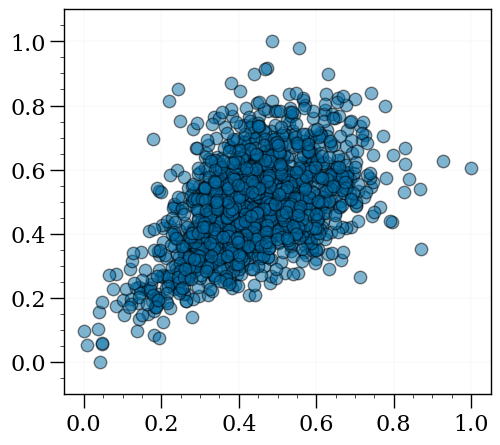

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 1
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
run(TrainingTensors, train_D, test_D, key, 'clayton_1')

  0%|          | 1/10000 [00:57<160:34:48, 57.81s/it]

Iter 0. Loss [[ 0.05710945  0.27503806 18.430197  ]]


  0%|          | 11/10000 [01:56<4:16:59,  1.54s/it]

Iter 10. Loss [[0.0575012 0.2629718 6.8593755]]


  0%|          | 21/10000 [01:59<49:23,  3.37it/s]

Iter 20. Loss [[0.05755834 0.26128894 6.086055  ]]


  0%|          | 31/10000 [02:02<40:01,  4.15it/s]

Iter 30. Loss [[0.05758896 0.25755355 5.2468905 ]]


  0%|          | 41/10000 [02:04<37:16,  4.45it/s]

Iter 40. Loss [[0.05773906 0.2544606  5.002421  ]]


  1%|          | 51/10000 [02:07<38:59,  4.25it/s]

Iter 50. Loss [[0.05816235 0.2536199  5.239686  ]]


  1%|          | 61/10000 [02:10<1:17:46,  2.13it/s]

Iter 60. Loss [[0.0587717  0.25238165 5.2933536 ]]


  1%|          | 71/10000 [02:13<41:01,  4.03it/s]

Iter 70. Loss [[0.05953974 0.25074124 5.242518  ]]


  1%|          | 81/10000 [02:15<49:07,  3.37it/s]

Iter 80. Loss [[0.06049982 0.2492713  5.123275  ]]


  1%|          | 91/10000 [02:18<37:13,  4.44it/s]

Iter 90. Loss [[0.06173262 0.25111765 5.887988  ]]


  1%|          | 101/10000 [02:20<44:43,  3.69it/s]

Iter 100. Loss [[0.06248643 0.24920447 6.04945   ]]


  1%|          | 111/10000 [02:23<57:40,  2.86it/s]

Iter 110. Loss [[0.06297695 0.2467144  5.962051  ]]


  1%|          | 121/10000 [02:27<44:29,  3.70it/s]

Iter 120. Loss [[0.06344397 0.2458234  6.005991  ]]


  1%|▏         | 131/10000 [02:29<37:32,  4.38it/s]

Iter 130. Loss [[0.06402816 0.24750647 6.2547474 ]]


  1%|▏         | 141/10000 [02:32<38:51,  4.23it/s]

Iter 140. Loss [[0.06443895 0.24635355 6.241641  ]]


  2%|▏         | 151/10000 [02:34<35:59,  4.56it/s]

Iter 150. Loss [[0.06485029 0.24431579 6.0845547 ]]


  2%|▏         | 161/10000 [02:37<58:00,  2.83it/s]

Iter 160. Loss [[0.06527792 0.24212047 5.8805714 ]]


  2%|▏         | 171/10000 [02:40<1:00:46,  2.70it/s]

Iter 170. Loss [[0.06581116 0.23967257 5.6813803 ]]


  2%|▏         | 181/10000 [02:42<36:36,  4.47it/s]

Iter 180. Loss [[0.0664948  0.23695186 5.4945664 ]]


  2%|▏         | 191/10000 [02:45<47:53,  3.41it/s]

Iter 190. Loss [[0.06735938 0.23402978 5.3013897 ]]


  2%|▏         | 201/10000 [02:47<36:44,  4.44it/s]

Iter 200. Loss [[0.06842233 0.23083726 5.0930066 ]]


  2%|▏         | 211/10000 [02:51<1:04:50,  2.52it/s]

Iter 210. Loss [[0.07008545 0.22975422 5.1212506 ]]


  2%|▏         | 221/10000 [02:53<37:48,  4.31it/s]

Iter 220. Loss [[0.07176856 0.22741748 5.044966  ]]


  2%|▏         | 231/10000 [02:56<39:13,  4.15it/s]

Iter 230. Loss [[0.0733882  0.22306673 4.864431  ]]


  2%|▏         | 241/10000 [02:58<36:01,  4.51it/s]

Iter 240. Loss [[0.07526299 0.2184256  4.7100964 ]]


  3%|▎         | 251/10000 [03:01<39:08,  4.15it/s]

Iter 250. Loss [[0.07756811 0.21342614 4.5457883 ]]


  3%|▎         | 261/10000 [03:04<57:01,  2.85it/s]

Iter 260. Loss [[0.08046385 0.20829536 4.480267  ]]


  3%|▎         | 271/10000 [03:07<38:55,  4.17it/s]

Iter 270. Loss [[0.08363828 0.2023267  4.3475924 ]]


  3%|▎         | 281/10000 [03:10<58:30,  2.77it/s]

Iter 280. Loss [[0.08709784 0.19558464 4.176625  ]]


  3%|▎         | 291/10000 [03:12<36:35,  4.42it/s]

Iter 290. Loss [[0.09099945 0.18770143 3.9835396 ]]


  3%|▎         | 301/10000 [03:14<47:34,  3.40it/s]

Iter 300. Loss [[0.09589207 0.17813624 3.7608645 ]]


  3%|▎         | 311/10000 [03:18<1:10:00,  2.31it/s]

Iter 310. Loss [[0.10285764 0.16601452 3.4953158 ]]


  3%|▎         | 321/10000 [03:22<55:35,  2.90it/s]  

Iter 320. Loss [[0.11367964 0.15030009 3.1476898 ]]


  3%|▎         | 331/10000 [03:24<35:59,  4.48it/s]

Iter 330. Loss [[0.1313651  0.12833774 2.724428  ]]


  3%|▎         | 341/10000 [03:27<39:29,  4.08it/s]

Iter 340. Loss [[0.16062643 0.09631848 2.1452127 ]]


  4%|▎         | 351/10000 [03:29<35:29,  4.53it/s]

Iter 350. Loss [[0.20623596 0.05143822 1.3691092 ]]


  4%|▎         | 361/10000 [03:33<59:13,  2.71it/s]

Iter 360. Loss [[0.25968894 0.03158866 0.61526805]]


  4%|▎         | 371/10000 [03:35<37:19,  4.30it/s]

Iter 370. Loss [[0.26795763 0.05178392 0.7757755 ]]


  4%|▍         | 381/10000 [03:38<36:19,  4.41it/s]

Iter 380. Loss [[0.25522402 0.02513642 0.7645819 ]]


  4%|▍         | 391/10000 [03:41<57:22,  2.79it/s]

Iter 390. Loss [[0.25352558 0.02565963 0.658908  ]]


  4%|▍         | 401/10000 [03:43<35:40,  4.48it/s]

Iter 400. Loss [[0.26459038 0.0306698  0.5488683 ]]


  4%|▍         | 411/10000 [03:46<1:08:40,  2.33it/s]

Iter 410. Loss [[0.2721331  0.03752357 0.51274544]]


  4%|▍         | 421/10000 [03:49<36:36,  4.36it/s]

Iter 420. Loss [[0.27078786 0.03537408 0.5125411 ]]


  4%|▍         | 431/10000 [03:52<41:22,  3.85it/s]

Iter 430. Loss [[0.27180701 0.0299474  0.47615686]]


  4%|▍         | 441/10000 [03:54<35:31,  4.48it/s]

Iter 440. Loss [[0.2851622  0.03210219 0.3326858 ]]


  5%|▍         | 451/10000 [03:56<39:40,  4.01it/s]

Iter 450. Loss [[0.29809415 0.03843936 0.13318004]]


  5%|▍         | 461/10000 [04:00<57:36,  2.76it/s]

Iter 460. Loss [[ 0.309221    0.04503852 -0.03640629]]


  5%|▍         | 471/10000 [04:03<40:03,  3.96it/s]

Iter 470. Loss [[ 0.31682485  0.05508176 -0.18966085]]


  5%|▍         | 481/10000 [04:05<35:36,  4.46it/s]

Iter 480. Loss [[ 0.31892338  0.06779544 -0.14043888]]


  5%|▍         | 491/10000 [04:08<36:16,  4.37it/s]

Iter 490. Loss [[ 0.3145281   0.06091224 -0.00831385]]


  5%|▌         | 501/10000 [04:10<50:56,  3.11it/s]

Iter 500. Loss [[ 0.3147135   0.04923923 -0.0066895 ]]


  5%|▌         | 511/10000 [04:14<58:53,  2.69it/s]

Iter 510. Loss [[ 0.31470796  0.05047213 -0.10361174]]


  5%|▌         | 521/10000 [04:17<43:40,  3.62it/s]

Iter 520. Loss [[ 0.31733763  0.05474217 -0.00783284]]


  5%|▌         | 531/10000 [04:19<35:07,  4.49it/s]

Iter 530. Loss [[ 0.32371816  0.0583254  -0.24695553]]


  5%|▌         | 541/10000 [04:21<39:23,  4.00it/s]

Iter 540. Loss [[ 0.3272183   0.07784221 -0.41998425]]


  6%|▌         | 551/10000 [04:24<35:20,  4.46it/s]

Iter 550. Loss [[ 0.32984957  0.07774761 -0.40631175]]


  6%|▌         | 561/10000 [04:28<56:25,  2.79it/s]

Iter 560. Loss [[ 0.3287503   0.09354095 -0.4516065 ]]


  6%|▌         | 571/10000 [04:30<35:55,  4.37it/s]

Iter 570. Loss [[ 0.32159948  0.08608496 -0.31169823]]


  6%|▌         | 581/10000 [04:32<36:46,  4.27it/s]

Iter 580. Loss [[ 0.31170171  0.0580819  -0.05752459]]


  6%|▌         | 591/10000 [04:35<57:19,  2.74it/s]

Iter 590. Loss [[0.3110744  0.04456537 0.05762857]]


  6%|▌         | 601/10000 [04:37<35:37,  4.40it/s]

Iter 600. Loss [[ 0.31534427  0.04637992 -0.08345934]]


  6%|▌         | 611/10000 [04:41<59:24,  2.63it/s]  

Iter 610. Loss [[ 0.3245767   0.05709761 -0.21076505]]


  6%|▌         | 621/10000 [04:44<35:50,  4.36it/s]

Iter 620. Loss [[ 0.32608217  0.06205638 -0.15343133]]


  6%|▋         | 631/10000 [04:46<42:46,  3.65it/s]

Iter 630. Loss [[ 0.32281983  0.06283467 -0.04121145]]


  6%|▋         | 641/10000 [04:49<35:17,  4.42it/s]

Iter 640. Loss [[ 0.32112506  0.04917187 -0.16764458]]


  7%|▋         | 651/10000 [04:52<50:58,  3.06it/s]

Iter 650. Loss [[ 0.3228264   0.07119095 -0.16344146]]


  7%|▋         | 661/10000 [04:55<43:31,  3.58it/s]

Iter 660. Loss [[0.31477043 0.04231678 0.08916621]]


  7%|▋         | 671/10000 [04:57<37:39,  4.13it/s]

Iter 670. Loss [[ 0.32035735  0.04487997 -0.07593133]]


  7%|▋         | 681/10000 [05:00<35:16,  4.40it/s]

Iter 680. Loss [[ 0.33440688  0.0605775  -0.31422043]]


  7%|▋         | 691/10000 [05:02<36:14,  4.28it/s]

Iter 690. Loss [[ 0.34884882  0.0940003  -0.58892816]]


  7%|▋         | 701/10000 [05:06<1:14:20,  2.08it/s]

Iter 700. Loss [[ 0.35182834  0.10577914 -0.7146393 ]]


  7%|▋         | 711/10000 [05:09<39:45,  3.89it/s]

Iter 710. Loss [[ 0.3438785   0.08808529 -0.57626766]]


  7%|▋         | 721/10000 [05:11<49:34,  3.12it/s]

Iter 720. Loss [[ 0.3360799   0.07659959 -0.42358136]]


  7%|▋         | 731/10000 [05:13<34:27,  4.48it/s]

Iter 730. Loss [[ 0.33129752  0.07094598 -0.37350878]]


  7%|▋         | 741/10000 [05:16<42:41,  3.62it/s]

Iter 740. Loss [[ 0.32937318  0.07097761 -0.34316954]]


  8%|▊         | 751/10000 [05:19<50:19,  3.06it/s]

Iter 750. Loss [[ 0.32708967  0.07257947 -0.31552267]]


  8%|▊         | 761/10000 [05:22<42:49,  3.60it/s]

Iter 760. Loss [[ 0.32285848  0.07479298 -0.2703155 ]]


  8%|▊         | 771/10000 [05:25<34:40,  4.44it/s]

Iter 770. Loss [[ 0.31541246  0.07599694 -0.18665276]]


  8%|▊         | 781/10000 [05:27<36:09,  4.25it/s]

Iter 780. Loss [[ 0.30439213  0.07140397 -0.03287785]]


  8%|▊         | 791/10000 [05:29<35:06,  4.37it/s]

Iter 790. Loss [[0.29034168 0.05732843 0.12119065]]


  8%|▊         | 801/10000 [05:33<54:51,  2.79it/s]

Iter 800. Loss [[0.2807055  0.04791209 0.25895268]]


  8%|▊         | 811/10000 [05:36<59:55,  2.56it/s]

Iter 810. Loss [[0.27891192 0.04783433 0.27692404]]


  8%|▊         | 821/10000 [05:39<34:59,  4.37it/s]

Iter 820. Loss [[0.2783289  0.04625247 0.33802688]]


  8%|▊         | 831/10000 [05:41<45:21,  3.37it/s]

Iter 830. Loss [[0.27328467 0.03914836 0.44761533]]


  8%|▊         | 841/10000 [05:43<34:16,  4.45it/s]

Iter 840. Loss [[0.26865786 0.03459809 0.5029196 ]]


  9%|▊         | 851/10000 [05:47<1:02:03,  2.46it/s]

Iter 850. Loss [[0.26834652 0.03403529 0.5212418 ]]


  9%|▊         | 861/10000 [05:50<35:25,  4.30it/s]

Iter 860. Loss [[0.26845202 0.03412306 0.52262866]]


  9%|▊         | 871/10000 [05:52<37:31,  4.05it/s]

Iter 870. Loss [[0.26841685 0.03392619 0.52405435]]


  9%|▉         | 881/10000 [05:55<33:46,  4.50it/s]

Iter 880. Loss [[0.26841587 0.03371085 0.5282922 ]]


  9%|▉         | 891/10000 [05:57<34:36,  4.39it/s]

Iter 890. Loss [[0.26830235 0.03360954 0.5297384 ]]


  9%|▉         | 901/10000 [06:00<55:47,  2.72it/s]

Iter 900. Loss [[0.26825026 0.03354906 0.5299807 ]]


  9%|▉         | 911/10000 [06:03<35:05,  4.32it/s]

Iter 910. Loss [[0.26831216 0.03357802 0.5297594 ]]


  9%|▉         | 921/10000 [06:06<48:05,  3.15it/s]

Iter 920. Loss [[0.26831016 0.03359985 0.5295775 ]]


  9%|▉         | 931/10000 [06:08<33:04,  4.57it/s]

Iter 930. Loss [[0.2683658  0.03353085 0.53065157]]


  9%|▉         | 941/10000 [06:11<41:07,  3.67it/s]

Iter 940. Loss [[0.26832592 0.03386705 0.52242136]]


 10%|▉         | 951/10000 [06:14<55:05,  2.74it/s]

Iter 950. Loss [[0.26827902 0.03389791 0.52138823]]


 10%|▉         | 961/10000 [06:17<40:12,  3.75it/s]

Iter 960. Loss [[0.26845336 0.03393506 0.5218655 ]]


 10%|▉         | 971/10000 [06:19<33:41,  4.47it/s]

Iter 970. Loss [[0.26845935 0.0335203  0.5318328 ]]


 10%|▉         | 981/10000 [06:22<35:35,  4.22it/s]

Iter 980. Loss [[0.2680146  0.0333946  0.53341585]]


 10%|▉         | 991/10000 [06:24<33:32,  4.48it/s]

Iter 990. Loss [[0.26811007 0.03343473 0.5331932 ]]


 10%|█         | 1001/10000 [06:28<56:03,  2.68it/s]

Iter 1000. Loss [[0.2681839  0.03347399 0.53297925]]


 10%|█         | 1011/10000 [06:30<33:36,  4.46it/s]

Iter 1010. Loss [[0.26812    0.03343216 0.5331843 ]]


 10%|█         | 1021/10000 [06:33<33:59,  4.40it/s]

Iter 1020. Loss [[0.26812816 0.03343875 0.53314084]]


 10%|█         | 1031/10000 [06:36<48:32,  3.08it/s]

Iter 1030. Loss [[0.2681434  0.03345303 0.53305817]]


 10%|█         | 1041/10000 [06:38<33:26,  4.46it/s]

Iter 1040. Loss [[0.26813585 0.0334449  0.53308976]]


 11%|█         | 1051/10000 [06:42<57:38,  2.59it/s]  

Iter 1050. Loss [[0.26813295 0.03344528 0.53307825]]


 11%|█         | 1061/10000 [06:44<34:14,  4.35it/s]

Iter 1060. Loss [[0.26813892 0.03344864 0.53305084]]


 11%|█         | 1071/10000 [06:47<38:13,  3.89it/s]

Iter 1070. Loss [[0.26813573 0.03344781 0.5330454 ]]


 11%|█         | 1081/10000 [06:49<32:44,  4.54it/s]

Iter 1080. Loss [[0.26813632 0.03344838 0.5330323 ]]


 11%|█         | 1091/10000 [06:51<35:07,  4.23it/s]

Iter 1090. Loss [[0.2681374  0.03344936 0.5330172 ]]


 11%|█         | 1101/10000 [06:55<51:17,  2.89it/s]

Iter 1100. Loss [[0.2681367  0.03344961 0.53300583]]


 11%|█         | 1111/10000 [06:58<34:45,  4.26it/s]

Iter 1110. Loss [[0.26813716 0.03345019 0.53299254]]


 11%|█         | 1121/10000 [07:00<54:19,  2.72it/s]

Iter 1120. Loss [[0.26813745 0.03345079 0.532979  ]]


 11%|█▏        | 1131/10000 [07:02<32:59,  4.48it/s]

Iter 1130. Loss [[0.2681375  0.03345124 0.5329663 ]]


 11%|█▏        | 1141/10000 [07:05<50:24,  2.93it/s]

Iter 1140. Loss [[0.26813766 0.03345175 0.532953  ]]


 12%|█▏        | 1151/10000 [07:09<43:51,  3.36it/s]

Iter 1150. Loss [[0.26813784 0.03345226 0.53293985]]


 12%|█▏        | 1161/10000 [07:11<37:53,  3.89it/s]

Iter 1160. Loss [[0.26813802 0.03345272 0.53292686]]


 12%|█▏        | 1171/10000 [07:14<33:24,  4.40it/s]

Iter 1170. Loss [[0.26813823 0.03345321 0.53291345]]


 12%|█▏        | 1181/10000 [07:17<54:02,  2.72it/s]

Iter 1180. Loss [[0.26813838 0.0334537  0.5328999 ]]


 12%|█▏        | 1191/10000 [07:21<55:29,  2.65it/s]

Iter 1190. Loss [[0.26813853 0.03345415 0.5328867 ]]


 12%|█▏        | 1201/10000 [07:24<35:58,  4.08it/s]

Iter 1200. Loss [[0.26813877 0.0334546  0.5328731 ]]


 12%|█▏        | 1211/10000 [07:26<32:06,  4.56it/s]

Iter 1210. Loss [[0.2681389  0.03345505 0.5328596 ]]


 12%|█▏        | 1221/10000 [07:29<32:54,  4.45it/s]

Iter 1220. Loss [[0.26813903 0.03345549 0.53284603]]


 12%|█▏        | 1231/10000 [07:31<52:35,  2.78it/s]

Iter 1230. Loss [[0.2681392  0.03345592 0.5328324 ]]


 12%|█▏        | 1241/10000 [07:34<52:01,  2.81it/s]

Iter 1240. Loss [[0.2681394  0.03345637 0.5328185 ]]


 13%|█▎        | 1251/10000 [07:38<43:55,  3.32it/s]

Iter 1250. Loss [[0.2681396  0.03345679 0.53280467]]


 13%|█▎        | 1261/10000 [07:40<32:40,  4.46it/s]

Iter 1260. Loss [[0.26813975 0.0334572  0.5327908 ]]


 13%|█▎        | 1271/10000 [07:42<36:27,  3.99it/s]

Iter 1270. Loss [[0.26813996 0.03345764 0.5327767 ]]


 13%|█▎        | 1281/10000 [07:45<33:32,  4.33it/s]

Iter 1280. Loss [[0.2681401  0.03345804 0.5327626 ]]


 13%|█▎        | 1291/10000 [07:48<53:58,  2.69it/s]

Iter 1290. Loss [[0.26814032 0.03345845 0.53274846]]


 13%|█▎        | 1301/10000 [07:51<33:05,  4.38it/s]

Iter 1300. Loss [[0.26814044 0.03345885 0.5327341 ]]


 13%|█▎        | 1311/10000 [07:53<32:48,  4.41it/s]

Iter 1310. Loss [[0.2681407  0.03345924 0.5327198 ]]


 13%|█▎        | 1321/10000 [07:56<31:51,  4.54it/s]

Iter 1320. Loss [[0.26814085 0.03345964 0.5327054 ]]


 13%|█▎        | 1331/10000 [07:58<32:44,  4.41it/s]

Iter 1330. Loss [[0.268141   0.03346005 0.53269076]]


 13%|█▎        | 1341/10000 [08:02<1:09:02,  2.09it/s]

Iter 1340. Loss [[0.26814157 0.03346052 0.53267574]]


 14%|█▎        | 1351/10000 [08:04<33:21,  4.32it/s]

Iter 1350. Loss [[0.26814142 0.03346079 0.53266156]]


 14%|█▎        | 1361/10000 [08:07<42:01,  3.43it/s]

Iter 1360. Loss [[0.2681417  0.03346129 0.53264606]]


 14%|█▎        | 1371/10000 [08:09<32:29,  4.43it/s]

Iter 1370. Loss [[0.26814172 0.0334624  0.5325373 ]]


 14%|█▍        | 1381/10000 [08:12<36:09,  3.97it/s]

Iter 1380. Loss [[0.26814213 0.03346208 0.5326158 ]]


 14%|█▍        | 1391/10000 [08:15<51:52,  2.77it/s]

Iter 1390. Loss [[0.26814213 0.03346316 0.5325069 ]]


 14%|█▍        | 1401/10000 [08:18<35:33,  4.03it/s]

Iter 1400. Loss [[0.26814255 0.0334629  0.53258514]]


 14%|█▍        | 1411/10000 [08:20<32:21,  4.42it/s]

Iter 1410. Loss [[0.2681425  0.03346394 0.5324759 ]]


 14%|█▍        | 1421/10000 [08:23<33:27,  4.27it/s]

Iter 1420. Loss [[0.2681429  0.03346366 0.5325541 ]]


 14%|█▍        | 1431/10000 [08:26<52:39,  2.71it/s]

Iter 1430. Loss [[0.26814294 0.03346474 0.53244436]]


 14%|█▍        | 1441/10000 [08:29<52:41,  2.71it/s]

Iter 1440. Loss [[0.2681433  0.03346442 0.5325227 ]]


 15%|█▍        | 1451/10000 [08:32<46:44,  3.05it/s]

Iter 1450. Loss [[0.2681434  0.03346472 0.53250724]]


 15%|█▍        | 1461/10000 [08:34<31:57,  4.45it/s]

Iter 1460. Loss [[0.26814377 0.03346522 0.5324906 ]]


 15%|█▍        | 1471/10000 [08:37<38:29,  3.69it/s]

Iter 1470. Loss [[0.26814377 0.03346546 0.5324751 ]]


 15%|█▍        | 1481/10000 [08:39<31:10,  4.55it/s]

Iter 1480. Loss [[0.26814413 0.03346595 0.5324583 ]]


 15%|█▍        | 1491/10000 [08:43<48:34,  2.92it/s]

Iter 1490. Loss [[0.26814428 0.0334663  0.53244215]]


 15%|█▌        | 1501/10000 [08:45<32:36,  4.34it/s]

Iter 1500. Loss [[0.26814446 0.03346666 0.53242576]]


 15%|█▌        | 1511/10000 [08:48<34:11,  4.14it/s]

Iter 1510. Loss [[0.26814473 0.03346707 0.53240895]]


 15%|█▌        | 1521/10000 [08:50<31:23,  4.50it/s]

Iter 1520. Loss [[0.26814488 0.03346741 0.5323924 ]]


 15%|█▌        | 1531/10000 [08:53<32:30,  4.34it/s]

Iter 1530. Loss [[0.26814517 0.03346783 0.5323754 ]]


 15%|█▌        | 1541/10000 [08:57<1:06:27,  2.12it/s]

Iter 1540. Loss [[0.26814532 0.03346815 0.5323587 ]]


 16%|█▌        | 1551/10000 [08:59<32:02,  4.40it/s]

Iter 1550. Loss [[0.2681455  0.03346858 0.53234136]]


 16%|█▌        | 1561/10000 [09:02<41:39,  3.38it/s]

Iter 1560. Loss [[0.26814574 0.03346892 0.53232425]]


 16%|█▌        | 1571/10000 [09:04<31:47,  4.42it/s]

Iter 1570. Loss [[0.26814595 0.03346932 0.5323068 ]]


 16%|█▌        | 1581/10000 [09:07<47:02,  2.98it/s]

Iter 1580. Loss [[0.26814616 0.03346969 0.5322893 ]]


 16%|█▌        | 1591/10000 [09:10<39:10,  3.58it/s]

Iter 1590. Loss [[0.26814634 0.03347006 0.53227174]]


 16%|█▌        | 1601/10000 [09:13<34:09,  4.10it/s]

Iter 1600. Loss [[0.2681465  0.03347041 0.5322542 ]]


 16%|█▌        | 1611/10000 [09:15<31:39,  4.42it/s]

Iter 1610. Loss [[0.26814678 0.03347082 0.53223616]]


 16%|█▌        | 1621/10000 [09:18<33:03,  4.22it/s]

Iter 1620. Loss [[0.268147   0.03347117 0.5322184 ]]


 16%|█▋        | 1631/10000 [09:20<41:19,  3.37it/s]

Iter 1630. Loss [[0.26814717 0.03347157 0.5321953 ]]


 16%|█▋        | 1641/10000 [09:24<35:59,  3.87it/s]

Iter 1640. Loss [[0.2681474  0.03347192 0.5321821 ]]


 17%|█▋        | 1651/10000 [09:27<51:56,  2.68it/s]

Iter 1650. Loss [[0.26814762 0.03347231 0.53216374]]


 17%|█▋        | 1661/10000 [09:29<31:13,  4.45it/s]

Iter 1660. Loss [[0.26814783 0.03347269 0.53214514]]


 17%|█▋        | 1671/10000 [09:31<40:42,  3.41it/s]

Iter 1670. Loss [[0.268148   0.03347305 0.5321266 ]]


 17%|█▋        | 1681/10000 [09:34<45:00,  3.08it/s]

Iter 1680. Loss [[0.26814827 0.03347345 0.5321079 ]]


 17%|█▋        | 1691/10000 [09:38<40:08,  3.45it/s]

Iter 1690. Loss [[0.26814845 0.03347379 0.5320891 ]]


 17%|█▋        | 1701/10000 [09:40<30:49,  4.49it/s]

Iter 1700. Loss [[0.26814875 0.0334742  0.53207   ]]


 17%|█▋        | 1711/10000 [09:42<33:26,  4.13it/s]

Iter 1710. Loss [[0.26814887 0.03347453 0.5320511 ]]


 17%|█▋        | 1721/10000 [09:45<30:33,  4.51it/s]

Iter 1720. Loss [[0.26814905 0.03347493 0.53203183]]


 17%|█▋        | 1731/10000 [09:48<47:55,  2.88it/s]

Iter 1730. Loss [[0.2681493  0.03347528 0.5320125 ]]


 17%|█▋        | 1741/10000 [09:51<34:26,  4.00it/s]

Iter 1740. Loss [[0.26814938 0.0334764  0.5318961 ]]


 18%|█▊        | 1751/10000 [09:54<31:15,  4.40it/s]

Iter 1750. Loss [[0.26814973 0.03347683 0.53187615]]


 18%|█▊        | 1761/10000 [09:56<49:37,  2.77it/s]

Iter 1760. Loss [[0.26814988 0.03347638 0.53195375]]


 18%|█▊        | 1771/10000 [09:58<30:37,  4.48it/s]

Iter 1770. Loss [[0.26815018 0.03347678 0.53193384]]


 18%|█▊        | 1781/10000 [10:02<56:31,  2.42it/s]

Iter 1780. Loss [[0.2681504  0.03347715 0.5319138 ]]


 18%|█▊        | 1791/10000 [10:04<33:40,  4.06it/s]

Iter 1790. Loss [[0.26815063 0.03347749 0.53189385]]


 18%|█▊        | 1801/10000 [10:07<36:34,  3.74it/s]

Iter 1800. Loss [[0.268151   0.03347789 0.53187346]]


 18%|█▊        | 1811/10000 [10:09<29:54,  4.56it/s]

Iter 1810. Loss [[0.2681512 0.0334795 0.5316788]]


 18%|█▊        | 1821/10000 [10:12<33:35,  4.06it/s]

Iter 1820. Loss [[0.26815423 0.03348068 0.53165346]]


 18%|█▊        | 1831/10000 [10:15<47:22,  2.87it/s]

Iter 1830. Loss [[0.2681522  0.03348105 0.53163224]]


 18%|█▊        | 1841/10000 [10:18<33:27,  4.06it/s]

Iter 1840. Loss [[0.26815388 0.03348299 0.5316027 ]]


 19%|█▊        | 1851/10000 [10:20<29:59,  4.53it/s]

Iter 1850. Loss [[0.26815355 0.03348393 0.53157836]]


 19%|█▊        | 1861/10000 [10:23<30:42,  4.42it/s]

Iter 1860. Loss [[0.2681541  0.03348499 0.5315532 ]]


 19%|█▊        | 1871/10000 [10:26<50:18,  2.69it/s]

Iter 1870. Loss [[0.26815426 0.03348607 0.53152794]]


 19%|█▉        | 1881/10000 [10:29<48:01,  2.82it/s]

Iter 1880. Loss [[0.2681546  0.03348705 0.5315031 ]]


 19%|█▉        | 1891/10000 [10:32<42:50,  3.15it/s]

Iter 1890. Loss [[0.26815453 0.03348771 0.5314797 ]]


 19%|█▉        | 1901/10000 [10:34<30:41,  4.40it/s]

Iter 1900. Loss [[0.26815504 0.03348864 0.5314549 ]]


 19%|█▉        | 1911/10000 [10:37<36:48,  3.66it/s]

Iter 1910. Loss [[0.26815534 0.03348931 0.5314313 ]]


 19%|█▉        | 1921/10000 [10:39<30:10,  4.46it/s]

Iter 1920. Loss [[0.2681554  0.0334899  0.53140813]]


 19%|█▉        | 1931/10000 [10:43<51:29,  2.61it/s]

Iter 1930. Loss [[0.26815614 0.03349068 0.53138363]]


 19%|█▉        | 1941/10000 [10:45<30:46,  4.36it/s]

Iter 1940. Loss [[0.2681557  0.03349101 0.53136146]]


 20%|█▉        | 1951/10000 [10:48<31:42,  4.23it/s]

Iter 1950. Loss [[0.2681567  0.03349179 0.53133684]]


 20%|█▉        | 1961/10000 [10:50<30:14,  4.43it/s]

Iter 1960. Loss [[0.26815617 0.03349203 0.531315  ]]


 20%|█▉        | 1971/10000 [10:53<30:35,  4.37it/s]

Iter 1970. Loss [[0.26815715 0.03349276 0.53129035]]


 20%|█▉        | 1981/10000 [10:57<1:10:08,  1.91it/s]

Iter 1980. Loss [[0.26815674 0.03349296 0.53126836]]


 20%|█▉        | 1991/10000 [10:59<30:16,  4.41it/s]

Iter 1990. Loss [[0.26815736 0.03349502 0.5310762 ]]


 20%|██        | 2001/10000 [11:02<39:15,  3.40it/s]

Iter 2000. Loss [[0.2681572  0.03349384 0.53122157]]


 20%|██        | 2011/10000 [11:04<29:19,  4.54it/s]

Iter 2010. Loss [[0.26815784 0.03349434 0.5311978 ]]


 20%|██        | 2021/10000 [11:07<34:01,  3.91it/s]

Iter 2020. Loss [[0.26815787 0.03349465 0.5311747 ]]


 20%|██        | 2031/10000 [11:10<48:30,  2.74it/s]

Iter 2030. Loss [[0.2681583  0.03349507 0.53115094]]


 20%|██        | 2041/10000 [11:13<31:59,  4.15it/s]

Iter 2040. Loss [[0.26815847 0.03349543 0.5311276 ]]


 21%|██        | 2051/10000 [11:15<30:24,  4.36it/s]

Iter 2050. Loss [[0.26815867 0.03349573 0.53110427]]


 21%|██        | 2061/10000 [11:18<30:31,  4.33it/s]

Iter 2060. Loss [[0.26815924 0.03349618 0.53108   ]]


 21%|██        | 2071/10000 [11:21<1:05:43,  2.01it/s]

Iter 2070. Loss [[0.26815897 0.03349635 0.5310571 ]]


 21%|██        | 2081/10000 [11:25<55:11,  2.39it/s]

Iter 2080. Loss [[0.26815984 0.03349688 0.5310323 ]]


 21%|██        | 2091/10000 [11:28<40:06,  3.29it/s]

Iter 2090. Loss [[0.26815936 0.03349694 0.53100985]]


 21%|██        | 2101/10000 [11:30<29:35,  4.45it/s]

Iter 2100. Loss [[0.26815966 0.03349534 0.53102154]]


 21%|██        | 2111/10000 [11:33<33:47,  3.89it/s]

Iter 2110. Loss [[0.26815963 0.03349578 0.5309967 ]]


 21%|██        | 2121/10000 [11:35<29:36,  4.43it/s]

Iter 2120. Loss [[0.26816013 0.03349645 0.5309704 ]]


 21%|██▏       | 2131/10000 [11:39<50:12,  2.61it/s]

Iter 2130. Loss [[0.26816052 0.0334969  0.5309451 ]]


 21%|██▏       | 2141/10000 [11:41<29:46,  4.40it/s]

Iter 2140. Loss [[0.26816028 0.03349727 0.5309204 ]]


 22%|██▏       | 2151/10000 [11:44<31:28,  4.16it/s]

Iter 2150. Loss [[0.26816094 0.03349786 0.5308942 ]]


 22%|██▏       | 2161/10000 [11:46<29:04,  4.49it/s]

Iter 2160. Loss [[0.26816133 0.03349815 0.53086936]]


 22%|██▏       | 2171/10000 [11:49<30:19,  4.30it/s]

Iter 2170. Loss [[0.26816106 0.03349842 0.5308446 ]]


 22%|██▏       | 2181/10000 [11:53<1:01:49,  2.11it/s]

Iter 2180. Loss [[0.26816043 0.03349933 0.5308173 ]]


 22%|██▏       | 2191/10000 [11:55<30:03,  4.33it/s]

Iter 2190. Loss [[0.26816356 0.03349388 0.53082097]]


 22%|██▏       | 2201/10000 [11:58<35:53,  3.62it/s]

Iter 2200. Loss [[0.26815817 0.03349085 0.5309923 ]]


 22%|██▏       | 2211/10000 [12:00<29:03,  4.47it/s]

Iter 2210. Loss [[0.26816273 0.03349784 0.53076255]]


 22%|██▏       | 2221/10000 [12:02<32:06,  4.04it/s]

Iter 2220. Loss [[0.26816094 0.03349228 0.5309386 ]]


 22%|██▏       | 2231/10000 [12:06<47:41,  2.71it/s]

Iter 2230. Loss [[0.26816157 0.03350036 0.53070295]]


 22%|██▏       | 2241/10000 [12:09<30:52,  4.19it/s]

Iter 2240. Loss [[0.26816094 0.03349474 0.5308801 ]]


 23%|██▎       | 2251/10000 [12:11<28:47,  4.49it/s]

Iter 2250. Loss [[0.26816228 0.0334959  0.5308509 ]]


 23%|██▎       | 2261/10000 [12:14<29:45,  4.34it/s]

Iter 2260. Loss [[0.26816228 0.03349712 0.5308218 ]]


 23%|██▎       | 2271/10000 [12:16<51:13,  2.52it/s]

Iter 2270. Loss [[0.26816222 0.03349787 0.5307947 ]]


 23%|██▎       | 2281/10000 [12:20<40:58,  3.14it/s]

Iter 2280. Loss [[0.26816282 0.03349884 0.5307665 ]]


 23%|██▎       | 2291/10000 [12:23<38:27,  3.34it/s]

Iter 2290. Loss [[0.26816636 0.033501   0.5307321 ]]


 23%|██▎       | 2301/10000 [12:25<27:50,  4.61it/s]

Iter 2300. Loss [[0.26815838 0.03349721 0.53072906]]


 23%|██▎       | 2311/10000 [12:27<32:36,  3.93it/s]

Iter 2310. Loss [[0.2681652  0.03349582 0.5307119 ]]


 23%|██▎       | 2321/10000 [12:30<28:41,  4.46it/s]

Iter 2320. Loss [[0.26816374 0.03349841 0.53067535]]


 23%|██▎       | 2331/10000 [12:33<39:33,  3.23it/s]

Iter 2330. Loss [[0.26816326 0.03349792 0.53065395]]


 23%|██▎       | 2341/10000 [12:36<28:30,  4.48it/s]

Iter 2340. Loss [[0.2681642  0.03349965 0.5306213 ]]


 24%|██▎       | 2351/10000 [12:38<29:50,  4.27it/s]

Iter 2350. Loss [[0.26816466 0.03349999 0.5305954 ]]


 24%|██▎       | 2361/10000 [12:40<28:20,  4.49it/s]

Iter 2360. Loss [[0.26816458 0.03350076 0.5305673 ]]


 24%|██▎       | 2371/10000 [12:43<34:09,  3.72it/s]

Iter 2370. Loss [[0.26816484 0.03350108 0.5305414 ]]


 24%|██▍       | 2381/10000 [12:47<52:03,  2.44it/s]  

Iter 2380. Loss [[0.2681653  0.0335008  0.53055394]]


 24%|██▍       | 2391/10000 [12:49<29:06,  4.36it/s]

Iter 2390. Loss [[0.26816505 0.03350104 0.53052855]]


 24%|██▍       | 2401/10000 [12:52<36:40,  3.45it/s]

Iter 2400. Loss [[0.26816577 0.03350162 0.5305012 ]]


 24%|██▍       | 2411/10000 [12:54<28:41,  4.41it/s]

Iter 2410. Loss [[0.26816547 0.0335018  0.53047603]]


 24%|██▍       | 2421/10000 [12:57<42:59,  2.94it/s]

Iter 2420. Loss [[0.26816607 0.03350226 0.5304492 ]]


 24%|██▍       | 2431/10000 [13:01<33:55,  3.72it/s]

Iter 2430. Loss [[0.2681701  0.03350409 0.53041506]]


 24%|██▍       | 2441/10000 [13:03<30:37,  4.11it/s]

Iter 2440. Loss [[0.2681608  0.03349812 0.5304221 ]]


 25%|██▍       | 2451/10000 [13:05<28:06,  4.48it/s]

Iter 2450. Loss [[0.26816902 0.03349841 0.5302469 ]]


 25%|██▍       | 2461/10000 [13:08<29:43,  4.23it/s]

Iter 2460. Loss [[0.2681684  0.03350088 0.5302093 ]]


 25%|██▍       | 2471/10000 [13:11<35:39,  3.52it/s]

Iter 2470. Loss [[0.26815304 0.03349284 0.53140724]]


 25%|██▍       | 2481/10000 [13:14<33:01,  3.80it/s]

Iter 2480. Loss [[0.26816216 0.0334899  0.5313911 ]]


 25%|██▍       | 2491/10000 [13:17<39:55,  3.13it/s]

Iter 2490. Loss [[0.26815927 0.03347776 0.53139955]]


 25%|██▌       | 2501/10000 [13:19<27:30,  4.54it/s]

Iter 2500. Loss [[0.26815653 0.03345418 0.53193784]]


 25%|██▌       | 2511/10000 [13:22<34:25,  3.63it/s]

Iter 2510. Loss [[0.2681554  0.03345008 0.5319407 ]]


 25%|██▌       | 2521/10000 [13:24<39:01,  3.19it/s]

Iter 2520. Loss [[0.26815456 0.03345032 0.53192174]]


 25%|██▌       | 2531/10000 [13:28<34:06,  3.65it/s]

Iter 2530. Loss [[0.26815578 0.03345108 0.53189963]]


 25%|██▌       | 2541/10000 [13:30<27:33,  4.51it/s]

Iter 2540. Loss [[0.26815528 0.03345136 0.53188   ]]


 26%|██▌       | 2551/10000 [13:33<28:52,  4.30it/s]

Iter 2550. Loss [[0.26815617 0.03345232 0.53185666]]


 26%|██▌       | 2561/10000 [13:35<27:42,  4.48it/s]

Iter 2560. Loss [[0.268156   0.03345279 0.53183603]]


 26%|██▌       | 2571/10000 [13:38<41:27,  2.99it/s]

Iter 2570. Loss [[0.26815644 0.03345336 0.53181446]]


 26%|██▌       | 2581/10000 [13:42<49:01,  2.52it/s]

Iter 2580. Loss [[0.26815665 0.03345382 0.5317935 ]]


 26%|██▌       | 2591/10000 [13:44<28:20,  4.36it/s]

Iter 2590. Loss [[0.26815683 0.03345417 0.53177285]]


 26%|██▌       | 2601/10000 [13:46<36:00,  3.42it/s]

Iter 2600. Loss [[0.26815706 0.03345449 0.53175235]]


 26%|██▌       | 2611/10000 [13:49<27:43,  4.44it/s]

Iter 2610. Loss [[0.26815727 0.03345471 0.5317321 ]]


 26%|██▌       | 2621/10000 [13:52<46:23,  2.65it/s]

Iter 2620. Loss [[0.2681575  0.03345488 0.531712  ]]


 26%|██▋       | 2631/10000 [13:55<30:02,  4.09it/s]

Iter 2630. Loss [[0.26815775 0.03345505 0.5316918 ]]


 26%|██▋       | 2641/10000 [13:58<29:20,  4.18it/s]

Iter 2640. Loss [[0.26815793 0.03345512 0.53167194]]


 27%|██▋       | 2651/10000 [14:00<27:14,  4.50it/s]

Iter 2650. Loss [[0.26815817 0.03345519 0.5316519 ]]


 27%|██▋       | 2661/10000 [14:02<28:25,  4.30it/s]

Iter 2660. Loss [[0.26815835 0.03345519 0.53163207]]


 27%|██▋       | 2671/10000 [14:05<41:19,  2.96it/s]

Iter 2670. Loss [[0.26815888 0.03345634 0.5316066 ]]


 27%|██▋       | 2681/10000 [14:08<29:12,  4.18it/s]

Iter 2680. Loss [[0.2681609  0.03345118 0.5316124 ]]


 27%|██▋       | 2691/10000 [14:11<39:14,  3.10it/s]

Iter 2690. Loss [[0.26815844 0.03345323 0.5315822 ]]


 27%|██▋       | 2701/10000 [14:13<26:43,  4.55it/s]

Iter 2700. Loss [[0.26815856 0.03345239 0.5315659 ]]


 27%|██▋       | 2711/10000 [14:16<33:47,  3.59it/s]

Iter 2710. Loss [[0.26815894 0.03345321 0.5315412 ]]


 27%|██▋       | 2721/10000 [14:19<43:27,  2.79it/s]

Iter 2720. Loss [[0.26815984 0.03345314 0.5315207 ]]


 27%|██▋       | 2731/10000 [14:22<32:29,  3.73it/s]

Iter 2730. Loss [[0.26815972 0.03345353 0.53149796]]


 27%|██▋       | 2741/10000 [14:25<27:24,  4.41it/s]

Iter 2740. Loss [[0.26815978 0.03345345 0.5314773 ]]


 28%|██▊       | 2751/10000 [14:27<29:01,  4.16it/s]

Iter 2750. Loss [[0.2681601  0.0334536  0.53144944]]


 28%|██▊       | 2761/10000 [14:29<26:39,  4.53it/s]

Iter 2760. Loss [[0.26816034 0.03345349 0.5314345 ]]


 28%|██▊       | 2771/10000 [14:33<44:51,  2.69it/s]

Iter 2770. Loss [[0.2681605  0.03345343 0.5314132 ]]


 28%|██▊       | 2781/10000 [14:36<28:22,  4.24it/s]

Iter 2780. Loss [[0.2681607  0.03345327 0.5313923 ]]


 28%|██▊       | 2791/10000 [14:38<27:15,  4.41it/s]

Iter 2790. Loss [[0.26816088 0.0334531  0.53137124]]


 28%|██▊       | 2801/10000 [14:41<38:59,  3.08it/s]

Iter 2800. Loss [[0.26815704 0.03345074 0.5313618 ]]


 28%|██▊       | 2811/10000 [14:43<27:32,  4.35it/s]

Iter 2810. Loss [[0.26816228 0.03344936 0.531346  ]]


 28%|██▊       | 2821/10000 [14:47<53:41,  2.23it/s]

Iter 2820. Loss [[0.26816195 0.03344923 0.5313242 ]]


 28%|██▊       | 2831/10000 [14:50<27:58,  4.27it/s]

Iter 2830. Loss [[0.26816162 0.03344945 0.5313004 ]]


 28%|██▊       | 2841/10000 [14:52<31:13,  3.82it/s]

Iter 2840. Loss [[0.26816133 0.03344975 0.5312761 ]]


 29%|██▊       | 2851/10000 [14:55<26:57,  4.42it/s]

Iter 2850. Loss [[0.26816162 0.03344976 0.531253  ]]


 29%|██▊       | 2861/10000 [14:57<28:35,  4.16it/s]

Iter 2860. Loss [[0.2681624  0.0334515  0.53119785]]


 29%|██▊       | 2871/10000 [15:01<41:28,  2.87it/s]

Iter 2870. Loss [[0.26816523 0.03345632 0.53094065]]


 29%|██▉       | 2881/10000 [15:04<28:04,  4.23it/s]

Iter 2880. Loss [[0.26816368 0.03345328 0.53093064]]


 29%|██▉       | 2891/10000 [15:06<26:37,  4.45it/s]

Iter 2890. Loss [[0.268164   0.03345111 0.5309159 ]]


 29%|██▉       | 2901/10000 [15:09<42:42,  2.77it/s]

Iter 2900. Loss [[0.26815894 0.03343284 0.5312619 ]]


 29%|██▉       | 2911/10000 [15:14<58:30,  2.02it/s]  

Iter 2910. Loss [[0.26816532 0.03345365 0.5308529 ]]


 29%|██▉       | 2921/10000 [15:16<28:19,  4.17it/s]

Iter 2920. Loss [[0.26816368 0.03345116 0.53084034]]


 29%|██▉       | 2931/10000 [15:19<34:31,  3.41it/s]

Iter 2930. Loss [[0.26816648 0.03343895 0.5311545 ]]


 29%|██▉       | 2941/10000 [15:21<26:46,  4.39it/s]

Iter 2940. Loss [[0.26816383 0.03343301 0.53115827]]


 30%|██▉       | 2951/10000 [15:24<29:21,  4.00it/s]

Iter 2950. Loss [[0.26816627 0.03345741 0.5307333 ]]


 30%|██▉       | 2961/10000 [15:27<42:23,  2.77it/s]

Iter 2960. Loss [[0.26815984 0.03343537 0.5310936 ]]


 30%|██▉       | 2971/10000 [15:30<28:20,  4.13it/s]

Iter 2970. Loss [[0.26816872 0.03345802 0.5306778 ]]


 30%|██▉       | 2981/10000 [15:32<25:58,  4.50it/s]

Iter 2980. Loss [[0.26816413 0.03345471 0.5306686 ]]


 30%|██▉       | 2991/10000 [15:35<26:54,  4.34it/s]

Iter 2990. Loss [[0.26816246 0.03345655 0.5306332 ]]


 30%|███       | 3001/10000 [15:38<43:25,  2.69it/s]

Iter 3000. Loss [[0.26816452 0.03343997 0.53096205]]


 30%|███       | 3011/10000 [15:41<43:10,  2.70it/s]

Iter 3010. Loss [[0.26816443 0.03344012 0.53093374]]


 30%|███       | 3021/10000 [15:44<35:08,  3.31it/s]

Iter 3020. Loss [[0.2681631  0.03344016 0.53090614]]


 30%|███       | 3031/10000 [15:46<26:32,  4.38it/s]

Iter 3030. Loss [[0.26816383 0.03344118 0.53089565]]


 30%|███       | 3041/10000 [15:49<30:06,  3.85it/s]

Iter 3040. Loss [[0.26816338 0.03344108 0.5308686 ]]


 31%|███       | 3051/10000 [15:51<26:12,  4.42it/s]

Iter 3050. Loss [[0.2681588 0.0334377 0.5308601]]


 31%|███       | 3061/10000 [15:55<35:41,  3.24it/s]

Iter 3060. Loss [[0.26816472 0.03343958 0.53082216]]


 31%|███       | 3071/10000 [15:57<26:41,  4.33it/s]

Iter 3070. Loss [[0.26816556 0.03344022 0.5307902 ]]


 31%|███       | 3081/10000 [16:00<26:38,  4.33it/s]

Iter 3080. Loss [[0.2681657  0.03344323 0.5307464 ]]


 31%|███       | 3091/10000 [16:02<25:27,  4.52it/s]

Iter 3090. Loss [[0.26816598 0.03344382 0.5307151 ]]


 31%|███       | 3101/10000 [16:05<33:46,  3.40it/s]

Iter 3100. Loss [[0.2681666  0.03344389 0.530686  ]]


 31%|███       | 3111/10000 [16:09<45:16,  2.54it/s]

Iter 3110. Loss [[0.2681658  0.0334439  0.53065723]]


 31%|███       | 3121/10000 [16:11<26:18,  4.36it/s]

Iter 3120. Loss [[0.2681664  0.03344475 0.53062385]]


 31%|███▏      | 3131/10000 [16:14<31:44,  3.61it/s]

Iter 3130. Loss [[0.26816666 0.03344474 0.5305946 ]]


 31%|███▏      | 3141/10000 [16:16<26:14,  4.36it/s]

Iter 3140. Loss [[0.26816636 0.03344443 0.5305666 ]]


 32%|███▏      | 3151/10000 [16:19<41:05,  2.78it/s]

Iter 3150. Loss [[0.26816672 0.03344382 0.5305397 ]]


 32%|███▏      | 3161/10000 [16:22<29:29,  3.86it/s]

Iter 3160. Loss [[0.26816696 0.0334432  0.53051275]]


 32%|███▏      | 3171/10000 [16:25<27:18,  4.17it/s]

Iter 3170. Loss [[0.26816702 0.03344226 0.530487  ]]


 32%|███▏      | 3181/10000 [16:27<25:37,  4.44it/s]

Iter 3180. Loss [[0.26816702 0.03353101 0.5293953 ]]


 32%|███▏      | 3191/10000 [16:30<26:07,  4.34it/s]

Iter 3190. Loss [[0.26816335 0.03343536 0.5302081 ]]


 32%|███▏      | 3201/10000 [16:34<59:54,  1.89it/s]

Iter 3200. Loss [[0.26816168 0.03343567 0.5304276 ]]


 32%|███▏      | 3211/10000 [16:36<27:25,  4.12it/s]

Iter 3210. Loss [[0.26816782 0.03343654 0.5303906 ]]


 32%|███▏      | 3221/10000 [16:39<34:00,  3.32it/s]

Iter 3220. Loss [[0.2681669  0.03343518 0.53036535]]


 32%|███▏      | 3231/10000 [16:41<25:29,  4.42it/s]

Iter 3230. Loss [[0.26816827 0.03343499 0.53033364]]


 32%|███▏      | 3241/10000 [16:44<29:01,  3.88it/s]

Iter 3240. Loss [[0.26817074 0.03343527 0.530299  ]]


 33%|███▎      | 3251/10000 [16:47<40:25,  2.78it/s]

Iter 3250. Loss [[0.26816761 0.0334329  0.5302779 ]]


 33%|███▎      | 3261/10000 [16:50<29:15,  3.84it/s]

Iter 3260. Loss [[0.26816896 0.03343286 0.53024423]]


 33%|███▎      | 3271/10000 [16:52<24:39,  4.55it/s]

Iter 3270. Loss [[0.26816717 0.03343075 0.5302208 ]]


 33%|███▎      | 3281/10000 [16:55<26:16,  4.26it/s]

Iter 3280. Loss [[0.26816714 0.03342823 0.530199  ]]


 33%|███▎      | 3291/10000 [16:57<24:55,  4.49it/s]

Iter 3290. Loss [[0.2681616  0.03341438 0.5321835 ]]


 33%|███▎      | 3301/10000 [17:01<41:03,  2.72it/s]

Iter 3300. Loss [[0.26815084 0.03340744 0.5322005 ]]


 33%|███▎      | 3311/10000 [17:04<37:01,  3.01it/s]

Iter 3310. Loss [[0.26816756 0.0334359  0.5300805 ]]


 33%|███▎      | 3321/10000 [17:06<25:20,  4.39it/s]

Iter 3320. Loss [[0.26814532 0.03341097 0.53214675]]


 33%|███▎      | 3331/10000 [17:09<29:41,  3.74it/s]

Iter 3330. Loss [[0.26815185 0.03341693 0.53209865]]


 33%|███▎      | 3341/10000 [17:11<24:43,  4.49it/s]

Iter 3340. Loss [[0.2681568  0.03341935 0.53206867]]


 34%|███▎      | 3351/10000 [17:15<45:42,  2.42it/s]

Iter 3350. Loss [[0.2681543  0.03341813 0.5320961 ]]


 34%|███▎      | 3361/10000 [17:17<25:09,  4.40it/s]

Iter 3360. Loss [[0.26815602 0.03341933 0.5320734 ]]


 34%|███▎      | 3371/10000 [17:20<27:08,  4.07it/s]

Iter 3370. Loss [[0.26815438 0.03341794 0.53206414]]


 34%|███▍      | 3381/10000 [17:22<24:48,  4.45it/s]

Iter 3380. Loss [[0.26815772 0.03341677 0.5320532 ]]


 34%|███▍      | 3391/10000 [17:25<26:14,  4.20it/s]

Iter 3390. Loss [[0.26815853 0.03341588 0.5320404 ]]


 34%|███▍      | 3401/10000 [17:29<56:04,  1.96it/s]

Iter 3400. Loss [[0.26815802 0.03341748 0.5320152 ]]


 34%|███▍      | 3411/10000 [17:31<25:40,  4.28it/s]

Iter 3410. Loss [[0.2681572  0.03341697 0.532015  ]]


 34%|███▍      | 3421/10000 [17:34<35:43,  3.07it/s]

Iter 3420. Loss [[0.26815778 0.0334182  0.5319916 ]]


 34%|███▍      | 3431/10000 [17:36<25:03,  4.37it/s]

Iter 3430. Loss [[0.2681574  0.03341778 0.5317059 ]]


 34%|███▍      | 3441/10000 [17:39<40:07,  2.72it/s]

Iter 3440. Loss [[0.26815626 0.03341759 0.53195995]]


 35%|███▍      | 3451/10000 [17:43<31:29,  3.47it/s]

Iter 3450. Loss [[0.26815698 0.03341788 0.53194076]]


 35%|███▍      | 3461/10000 [17:46<29:47,  3.66it/s]

Iter 3460. Loss [[0.2681572  0.03341767 0.53192383]]


 35%|███▍      | 3471/10000 [17:48<25:02,  4.34it/s]

Iter 3470. Loss [[0.268158   0.03341763 0.5319059 ]]


 35%|███▍      | 3481/10000 [17:51<26:06,  4.16it/s]

Iter 3480. Loss [[0.2681585  0.03341692 0.5318911 ]]


 35%|███▍      | 3491/10000 [17:53<36:11,  3.00it/s]

Iter 3490. Loss [[0.26815867 0.03341684 0.531873  ]]


 35%|███▌      | 3501/10000 [17:57<26:58,  4.02it/s]

Iter 3500. Loss [[0.26816678 0.03341791 0.53156924]]


 35%|███▌      | 3511/10000 [18:00<39:54,  2.71it/s]

Iter 3510. Loss [[0.2681588  0.03340951 0.5318721 ]]


 35%|███▌      | 3521/10000 [18:02<24:39,  4.38it/s]

Iter 3520. Loss [[0.2681564  0.03340996 0.5318563 ]]


 35%|███▌      | 3531/10000 [18:05<31:58,  3.37it/s]

Iter 3530. Loss [[0.26815823 0.03341218 0.5318387 ]]


 35%|███▌      | 3541/10000 [18:08<38:20,  2.81it/s]

Iter 3540. Loss [[0.26815754 0.03341133 0.53182375]]


 36%|███▌      | 3551/10000 [18:11<31:27,  3.42it/s]

Iter 3550. Loss [[0.26815984 0.03341271 0.5316274 ]]


 36%|███▌      | 3561/10000 [18:13<24:25,  4.39it/s]

Iter 3560. Loss [[0.26815814 0.03341233 0.53160906]]


 36%|███▌      | 3571/10000 [18:16<26:56,  3.98it/s]

Iter 3570. Loss [[0.26815963 0.03341497 0.53157496]]


 36%|███▌      | 3581/10000 [18:18<23:51,  4.48it/s]

Iter 3580. Loss [[0.26816028 0.03341603 0.53154874]]


 36%|███▌      | 3591/10000 [18:22<41:24,  2.58it/s]

Iter 3590. Loss [[0.26815966 0.03341601 0.5315279 ]]


 36%|███▌      | 3601/10000 [18:24<25:13,  4.23it/s]

Iter 3600. Loss [[0.268164   0.03341589 0.53097796]]


 36%|███▌      | 3611/10000 [18:27<25:07,  4.24it/s]

Iter 3610. Loss [[0.26816761 0.03341435 0.53051764]]


 36%|███▌      | 3621/10000 [18:30<34:33,  3.08it/s]

Iter 3620. Loss [[0.26815534 0.0333968  0.53005195]]


 36%|███▋      | 3631/10000 [18:32<24:50,  4.27it/s]

Iter 3630. Loss [[0.2681428  0.03339408 0.5291771 ]]


 36%|███▋      | 3641/10000 [18:36<45:39,  2.32it/s]

Iter 3640. Loss [[0.26814494 0.03349508 0.52841324]]


 37%|███▋      | 3651/10000 [18:38<24:29,  4.32it/s]

Iter 3650. Loss [[0.26814985 0.03344706 0.5285041 ]]


 37%|███▋      | 3661/10000 [18:41<26:37,  3.97it/s]

Iter 3660. Loss [[0.268151   0.03347129 0.52825725]]


 37%|███▋      | 3671/10000 [18:43<23:27,  4.50it/s]

Iter 3670. Loss [[0.26814753 0.03348134 0.52809095]]


 37%|███▋      | 3681/10000 [18:46<26:18,  4.00it/s]

Iter 3680. Loss [[0.2681482  0.03346237 0.52807134]]


 37%|███▋      | 3691/10000 [18:49<35:54,  2.93it/s]

Iter 3690. Loss [[0.2681486  0.03346599 0.5279397 ]]


 37%|███▋      | 3701/10000 [18:52<24:33,  4.27it/s]

Iter 3700. Loss [[0.26815024 0.03345797 0.52786547]]


 37%|███▋      | 3711/10000 [18:55<51:25,  2.04it/s]

Iter 3710. Loss [[0.26815164 0.03344743 0.52780235]]


 37%|███▋      | 3721/10000 [18:58<26:56,  3.88it/s]

Iter 3720. Loss [[0.26815295 0.03344107 0.52771574]]


 37%|███▋      | 3731/10000 [19:02<45:35,  2.29it/s]

Iter 3730. Loss [[0.26815477 0.03343227 0.5276387 ]]


 37%|███▋      | 3741/10000 [19:04<24:27,  4.26it/s]

Iter 3740. Loss [[0.26815203 0.03342446 0.5275557 ]]


 38%|███▊      | 3751/10000 [19:07<28:03,  3.71it/s]

Iter 3750. Loss [[0.2681568  0.03341264 0.52749103]]


 38%|███▊      | 3761/10000 [19:09<23:28,  4.43it/s]

Iter 3760. Loss [[0.26816297 0.0334126  0.5269431 ]]


 38%|███▊      | 3771/10000 [19:12<25:21,  4.09it/s]

Iter 3770. Loss [[0.2681595  0.03340659 0.52727455]]


 38%|███▊      | 3781/10000 [19:15<37:45,  2.75it/s]

Iter 3780. Loss [[0.26816455 0.03340977 0.52670854]]


 38%|███▊      | 3791/10000 [19:18<25:27,  4.06it/s]

Iter 3790. Loss [[0.26816845 0.03341049 0.52658397]]


 38%|███▊      | 3801/10000 [19:21<23:20,  4.43it/s]

Iter 3800. Loss [[0.26816738 0.03340806 0.5264788 ]]


 38%|███▊      | 3811/10000 [19:23<23:45,  4.34it/s]

Iter 3810. Loss [[0.26816845 0.03340633 0.5263731 ]]


 38%|███▊      | 3821/10000 [19:26<33:27,  3.08it/s]

Iter 3820. Loss [[0.26816896 0.0334047  0.52627   ]]


 38%|███▊      | 3831/10000 [19:29<38:01,  2.70it/s]

Iter 3830. Loss [[0.26816842 0.03340282 0.5261709 ]]


 38%|███▊      | 3841/10000 [19:32<30:45,  3.34it/s]

Iter 3840. Loss [[0.26816937 0.03339859 0.52608603]]


 39%|███▊      | 3851/10000 [19:34<23:14,  4.41it/s]

Iter 3850. Loss [[0.26816994 0.03339726 0.5259891 ]]


 39%|███▊      | 3861/10000 [19:37<27:08,  3.77it/s]

Iter 3860. Loss [[0.26817247 0.03339559 0.52589655]]


 39%|███▊      | 3871/10000 [19:39<23:33,  4.33it/s]

Iter 3870. Loss [[0.26815924 0.0333364  0.5329059 ]]


 39%|███▉      | 3881/10000 [19:43<35:28,  2.87it/s]

Iter 3880. Loss [[0.26815963 0.03340237 0.5304118 ]]


 39%|███▉      | 3891/10000 [19:46<23:32,  4.33it/s]

Iter 3890. Loss [[0.26816022 0.03339589 0.5304089 ]]


 39%|███▉      | 3901/10000 [19:48<23:42,  4.29it/s]

Iter 3900. Loss [[0.2681663  0.03339365 0.5303848 ]]


 39%|███▉      | 3911/10000 [19:51<37:49,  2.68it/s]

Iter 3910. Loss [[0.26815704 0.03334116 0.533678  ]]


 39%|███▉      | 3921/10000 [19:53<25:11,  4.02it/s]

Iter 3920. Loss [[0.2681488  0.03339466 0.5303098 ]]


 39%|███▉      | 3931/10000 [19:57<41:49,  2.42it/s]

Iter 3930. Loss [[0.26814207 0.03339239 0.530288  ]]


 39%|███▉      | 3941/10000 [19:59<23:16,  4.34it/s]

Iter 3940. Loss [[0.26811504 0.03338105 0.5303109 ]]


 40%|███▉      | 3951/10000 [20:02<26:00,  3.88it/s]

Iter 3950. Loss [[0.2681496  0.03340837 0.53013605]]


 40%|███▉      | 3961/10000 [20:04<22:49,  4.41it/s]

Iter 3960. Loss [[0.26819378 0.03341415 0.53006876]]


 40%|███▉      | 3971/10000 [20:07<31:03,  3.24it/s]

Iter 3970. Loss [[0.2681758  0.03334539 0.53350616]]


 40%|███▉      | 3981/10000 [20:11<28:55,  3.47it/s]

Iter 3980. Loss [[0.268152   0.03334179 0.53350395]]


 40%|███▉      | 3991/10000 [20:13<23:40,  4.23it/s]

Iter 3990. Loss [[0.26816672 0.0333559  0.5334027 ]]


 40%|████      | 4001/10000 [20:16<37:19,  2.68it/s]

Iter 4000. Loss [[0.26813036 0.033402   0.5300005 ]]


 40%|████      | 4011/10000 [20:18<23:11,  4.30it/s]

Iter 4010. Loss [[0.26814455 0.03340154 0.5299669 ]]


 40%|████      | 4021/10000 [20:21<39:29,  2.52it/s]

Iter 4020. Loss [[0.2681965  0.03343052 0.5297849 ]]


 40%|████      | 4031/10000 [20:25<25:17,  3.93it/s]

Iter 4030. Loss [[0.26819023 0.03334838 0.5333346 ]]


 40%|████      | 4041/10000 [20:27<27:12,  3.65it/s]

Iter 4040. Loss [[0.2681263  0.03339319 0.52991015]]


 41%|████      | 4051/10000 [20:29<22:15,  4.45it/s]

Iter 4050. Loss [[0.2681429  0.0333901  0.53003335]]


 41%|████      | 4061/10000 [20:32<25:15,  3.92it/s]

Iter 4060. Loss [[0.26817068 0.03339547 0.5299553 ]]


 41%|████      | 4071/10000 [20:35<33:52,  2.92it/s]

Iter 4070. Loss [[0.26815224 0.03339575 0.5299032 ]]


 41%|████      | 4081/10000 [20:38<25:17,  3.90it/s]

Iter 4080. Loss [[0.26814002 0.03339167 0.52999115]]


 41%|████      | 4091/10000 [20:41<22:27,  4.38it/s]

Iter 4090. Loss [[0.26813847 0.03339133 0.5299314 ]]


 41%|████      | 4101/10000 [20:43<22:54,  4.29it/s]

Iter 4100. Loss [[0.26811376 0.03338145 0.53004867]]


 41%|████      | 4111/10000 [20:46<33:35,  2.92it/s]

Iter 4110. Loss [[0.2681298  0.03338343 0.5304683 ]]


 41%|████      | 4121/10000 [20:50<37:15,  2.63it/s]

Iter 4120. Loss [[0.26815337 0.03339623 0.530366  ]]


 41%|████▏     | 4131/10000 [20:53<27:36,  3.54it/s]

Iter 4130. Loss [[0.26815578 0.0333964  0.5303797 ]]


 41%|████▏     | 4141/10000 [20:55<22:15,  4.39it/s]

Iter 4140. Loss [[0.26815236 0.03339718 0.5303427 ]]


 42%|████▏     | 4151/10000 [20:58<24:14,  4.02it/s]

Iter 4150. Loss [[0.26815245 0.03334481 0.5335813 ]]


 42%|████▏     | 4161/10000 [21:00<22:09,  4.39it/s]

Iter 4160. Loss [[0.26811397 0.0333945  0.530266  ]]


 42%|████▏     | 4171/10000 [21:04<37:37,  2.58it/s]

Iter 4170. Loss [[0.26813224 0.03339707 0.5301852 ]]


 42%|████▏     | 4181/10000 [21:06<22:26,  4.32it/s]

Iter 4180. Loss [[0.26814073 0.03340182 0.5301278 ]]


 42%|████▏     | 4191/10000 [21:09<22:47,  4.25it/s]

Iter 4190. Loss [[0.26812583 0.03340316 0.5300782 ]]


 42%|████▏     | 4201/10000 [21:11<35:54,  2.69it/s]

Iter 4200. Loss [[0.26816452 0.03340957 0.5299933 ]]


 42%|████▏     | 4211/10000 [21:14<21:55,  4.40it/s]

Iter 4210. Loss [[0.2681976  0.03341372 0.52992195]]


 42%|████▏     | 4221/10000 [21:18<40:56,  2.35it/s]

Iter 4220. Loss [[0.26814848 0.03340242 0.5301718 ]]


 42%|████▏     | 4231/10000 [21:20<22:04,  4.35it/s]

Iter 4230. Loss [[0.26813927 0.03334007 0.53353757]]


 42%|████▏     | 4241/10000 [21:23<26:03,  3.68it/s]

Iter 4240. Loss [[0.26811725 0.03333891 0.5335166 ]]


 43%|████▎     | 4251/10000 [21:25<21:40,  4.42it/s]

Iter 4250. Loss [[0.26810098 0.03340195 0.5300627 ]]


 43%|████▎     | 4261/10000 [21:28<27:49,  3.44it/s]

Iter 4260. Loss [[0.2681534  0.03335351 0.5333687 ]]


 43%|████▎     | 4271/10000 [21:31<29:27,  3.24it/s]

Iter 4270. Loss [[0.26810494 0.03340968 0.53013563]]


 43%|████▎     | 4281/10000 [21:34<22:16,  4.28it/s]

Iter 4280. Loss [[0.26809144 0.0334008  0.5301508 ]]


 43%|████▎     | 4291/10000 [21:36<21:09,  4.50it/s]

Iter 4290. Loss [[0.26816112 0.03334456 0.53351706]]


 43%|████▎     | 4301/10000 [21:39<21:44,  4.37it/s]

Iter 4300. Loss [[0.26810956 0.03340672 0.5300525 ]]


 43%|████▎     | 4311/10000 [21:42<38:13,  2.48it/s]

Iter 4310. Loss [[0.2681241  0.03341106 0.53000087]]


 43%|████▎     | 4321/10000 [21:45<25:56,  3.65it/s]

Iter 4320. Loss [[0.2681982  0.03335398 0.5333885 ]]


 43%|████▎     | 4331/10000 [21:48<28:24,  3.33it/s]

Iter 4330. Loss [[0.26821667 0.03336814 0.5332878 ]]


 43%|████▎     | 4341/10000 [21:50<21:39,  4.35it/s]

Iter 4340. Loss [[0.26821175 0.03345445 0.5296793 ]]


 44%|████▎     | 4351/10000 [21:53<24:23,  3.86it/s]

Iter 4350. Loss [[0.26819444 0.03337031 0.53321695]]


 44%|████▎     | 4361/10000 [21:55<29:59,  3.13it/s]

Iter 4360. Loss [[0.26813018 0.03335052 0.53328997]]


 44%|████▎     | 4371/10000 [21:59<25:48,  3.63it/s]

Iter 4370. Loss [[0.26810363 0.03342245 0.52974766]]


 44%|████▍     | 4381/10000 [22:01<21:13,  4.41it/s]

Iter 4380. Loss [[0.26814058 0.03335099 0.53323215]]


 44%|████▍     | 4391/10000 [22:04<22:14,  4.20it/s]

Iter 4390. Loss [[0.2680972  0.03342396 0.52967596]]


 44%|████▍     | 4401/10000 [22:06<21:24,  4.36it/s]

Iter 4400. Loss [[0.2681261  0.03334586 0.53318805]]


 44%|████▍     | 4411/10000 [22:09<33:06,  2.81it/s]

Iter 4410. Loss [[0.26814947 0.03334816 0.53314626]]


 44%|████▍     | 4421/10000 [22:13<36:14,  2.57it/s]

Iter 4420. Loss [[0.26815578 0.03335074 0.53309774]]


 44%|████▍     | 4431/10000 [22:15<21:29,  4.32it/s]

Iter 4430. Loss [[0.26814333 0.0334372  0.52946323]]


 44%|████▍     | 4441/10000 [22:18<27:16,  3.40it/s]

Iter 4440. Loss [[0.2681126  0.03343358 0.52945644]]


 45%|████▍     | 4451/10000 [22:20<20:46,  4.45it/s]

Iter 4450. Loss [[0.26812258 0.03342905 0.529439  ]]


 45%|████▍     | 4461/10000 [22:24<35:45,  2.58it/s]

Iter 4460. Loss [[0.26814622 0.03342999 0.52938837]]


 45%|████▍     | 4471/10000 [22:26<22:08,  4.16it/s]

Iter 4470. Loss [[0.26812723 0.0333336  0.5330234 ]]


 45%|████▍     | 4481/10000 [22:29<22:28,  4.09it/s]

Iter 4480. Loss [[0.26811826 0.03345833 0.5291888 ]]


 45%|████▍     | 4491/10000 [22:31<20:44,  4.43it/s]

Iter 4490. Loss [[0.26816538 0.03336648 0.5327736 ]]


 45%|████▌     | 4501/10000 [22:34<21:57,  4.17it/s]

Iter 4500. Loss [[0.26811546 0.03343698 0.52921665]]


 45%|████▌     | 4511/10000 [22:37<33:43,  2.71it/s]

Iter 4510. Loss [[0.2681485  0.0333439  0.53279966]]


 45%|████▌     | 4521/10000 [22:41<32:16,  2.83it/s]

Iter 4520. Loss [[0.2681495  0.03334916 0.5327336 ]]


 45%|████▌     | 4531/10000 [22:44<30:09,  3.02it/s]

Iter 4530. Loss [[0.26810607 0.03334351 0.53272355]]


 45%|████▌     | 4541/10000 [22:46<20:59,  4.33it/s]

Iter 4540. Loss [[0.2680969  0.03344267 0.52902263]]


 46%|████▌     | 4551/10000 [22:50<34:50,  2.61it/s]

Iter 4550. Loss [[0.26817358 0.0333508  0.5325872 ]]


 46%|████▌     | 4561/10000 [22:53<22:46,  3.98it/s]

Iter 4560. Loss [[0.26814178 0.03334941 0.53255606]]


 46%|████▌     | 4571/10000 [22:55<22:21,  4.05it/s]

Iter 4570. Loss [[0.2680819  0.03334333 0.53253746]]


 46%|████▌     | 4581/10000 [22:58<20:19,  4.44it/s]

Iter 4580. Loss [[0.26809138 0.03334088 0.53248626]]


 46%|████▌     | 4591/10000 [23:00<21:32,  4.18it/s]

Iter 4590. Loss [[0.26811963 0.03333044 0.532493  ]]


 46%|████▌     | 4601/10000 [23:03<29:44,  3.03it/s]

Iter 4600. Loss [[0.2681055  0.03332844 0.53243834]]


 46%|████▌     | 4611/10000 [23:06<22:24,  4.01it/s]

Iter 4610. Loss [[0.26810107 0.03333304 0.5323542 ]]


 46%|████▌     | 4621/10000 [23:09<20:08,  4.45it/s]

Iter 4620. Loss [[0.2681652  0.0337234  0.52732754]]


 46%|████▋     | 4631/10000 [23:11<20:41,  4.33it/s]

Iter 4630. Loss [[0.26813984 0.03327371 0.53161573]]


 46%|████▋     | 4641/10000 [23:14<29:23,  3.04it/s]

Iter 4640. Loss [[0.26810247 0.03329789 0.53191024]]


 47%|████▋     | 4651/10000 [23:17<31:30,  2.83it/s]

Iter 4650. Loss [[0.26813886 0.03336063 0.5314805 ]]


 47%|████▋     | 4661/10000 [23:20<26:03,  3.42it/s]

Iter 4660. Loss [[0.26813784 0.03336579 0.5313741 ]]


 47%|████▋     | 4671/10000 [23:22<20:01,  4.44it/s]

Iter 4670. Loss [[0.2681498 0.0333586 0.5313335]]


 47%|████▋     | 4681/10000 [23:25<21:53,  4.05it/s]

Iter 4680. Loss [[0.268142   0.03335499 0.531269  ]]


 47%|████▋     | 4691/10000 [23:27<20:01,  4.42it/s]

Iter 4690. Loss [[0.26813975 0.0333544  0.531178  ]]


 47%|████▋     | 4701/10000 [23:31<32:47,  2.69it/s]

Iter 4700. Loss [[0.2681367 0.0333467 0.5311254]]


 47%|████▋     | 4711/10000 [23:34<20:53,  4.22it/s]

Iter 4710. Loss [[0.2681167  0.03333547 0.5310928 ]]


 47%|████▋     | 4721/10000 [23:36<20:25,  4.31it/s]

Iter 4720. Loss [[0.26812112 0.03334257 0.5310202 ]]


 47%|████▋     | 4731/10000 [23:39<32:15,  2.72it/s]

Iter 4730. Loss [[0.26811883 0.03333901 0.5309371 ]]


 47%|████▋     | 4741/10000 [23:41<20:17,  4.32it/s]

Iter 4740. Loss [[0.26811683 0.03334264 0.53080666]]


 48%|████▊     | 4751/10000 [23:45<39:36,  2.21it/s]

Iter 4750. Loss [[0.26820767 0.03358153 0.53192616]]


 48%|████▊     | 4761/10000 [23:47<20:27,  4.27it/s]

Iter 4760. Loss [[0.3037003  0.07581194 0.08160627]]


 48%|████▊     | 4771/10000 [23:50<24:03,  3.62it/s]

Iter 4770. Loss [[0.26088068 0.02991041 0.5635445 ]]


 48%|████▊     | 4781/10000 [23:52<19:44,  4.41it/s]

Iter 4780. Loss [[0.26469383 0.03231997 0.5367456 ]]


 48%|████▊     | 4791/10000 [23:55<21:08,  4.11it/s]

Iter 4790. Loss [[0.26643986 0.0339146  0.5160363 ]]


 48%|████▊     | 4801/10000 [23:59<32:12,  2.69it/s]

Iter 4800. Loss [[0.26669693 0.03580661 0.516839  ]]


 48%|████▊     | 4811/10000 [24:01<20:46,  4.16it/s]

Iter 4810. Loss [[0.26745653 0.03344189 0.52709514]]


 48%|████▊     | 4821/10000 [24:04<19:54,  4.33it/s]

Iter 4820. Loss [[0.2672137  0.03301242 0.52694446]]


 48%|████▊     | 4831/10000 [24:06<19:34,  4.40it/s]

Iter 4830. Loss [[0.26755658 0.034112   0.5145887 ]]


 48%|████▊     | 4841/10000 [24:09<32:53,  2.61it/s]

Iter 4840. Loss [[0.26771352 0.03376549 0.52030516]]


 49%|████▊     | 4851/10000 [24:13<32:10,  2.67it/s]

Iter 4850. Loss [[0.26755545 0.03334711 0.5245189 ]]


 49%|████▊     | 4861/10000 [24:15<25:38,  3.34it/s]

Iter 4860. Loss [[0.26755473 0.03337982 0.5238147 ]]


 49%|████▊     | 4871/10000 [24:18<19:24,  4.40it/s]

Iter 4870. Loss [[0.266915   0.043715   0.51518303]]


 49%|████▉     | 4881/10000 [24:20<22:16,  3.83it/s]

Iter 4880. Loss [[0.2672933  0.03365733 0.5221879 ]]


 49%|████▉     | 4891/10000 [24:23<19:12,  4.43it/s]

Iter 4890. Loss [[0.2680231  0.03377632 0.52241045]]


 49%|████▉     | 4901/10000 [24:27<27:10,  3.13it/s]

Iter 4900. Loss [[0.26834172 0.0338488  0.52279395]]


 49%|████▉     | 4911/10000 [24:29<19:15,  4.40it/s]

Iter 4910. Loss [[0.2679166  0.03445841 0.51702756]]


 49%|████▉     | 4921/10000 [24:31<19:56,  4.25it/s]

Iter 4920. Loss [[0.267309   0.03367059 0.52396053]]


 49%|████▉     | 4931/10000 [24:34<19:10,  4.40it/s]

Iter 4930. Loss [[0.26733723 0.03346836 0.5258019 ]]


 49%|████▉     | 4941/10000 [24:37<24:24,  3.45it/s]

Iter 4940. Loss [[0.267555   0.03375238 0.5243651 ]]


 50%|████▉     | 4951/10000 [24:40<33:28,  2.51it/s]

Iter 4950. Loss [[0.26758134 0.03387351 0.5236718 ]]


 50%|████▉     | 4961/10000 [24:43<19:52,  4.23it/s]

Iter 4960. Loss [[0.26755184 0.03426204 0.5232779 ]]


 50%|████▉     | 4971/10000 [24:45<24:52,  3.37it/s]

Iter 4970. Loss [[0.26747224 0.03391386 0.5261502 ]]


 50%|████▉     | 4981/10000 [24:48<19:16,  4.34it/s]

Iter 4980. Loss [[0.2675705  0.03433877 0.521747  ]]


 50%|████▉     | 4991/10000 [24:51<30:49,  2.71it/s]

Iter 4990. Loss [[0.26753467 0.03436968 0.5263269 ]]


 50%|█████     | 5001/10000 [24:54<22:01,  3.78it/s]

Iter 5000. Loss [[0.26746267 0.03424398 0.5277408 ]]


 50%|█████     | 5011/10000 [24:57<20:38,  4.03it/s]

Iter 5010. Loss [[0.26760203 0.03470217 0.52284586]]


 50%|█████     | 5021/10000 [24:59<18:31,  4.48it/s]

Iter 5020. Loss [[0.26757437 0.0345864  0.5249287 ]]


 50%|█████     | 5031/10000 [25:02<19:57,  4.15it/s]

Iter 5030. Loss [[0.26755065 0.03423863 0.5277509 ]]


 50%|█████     | 5041/10000 [25:05<27:26,  3.01it/s]

Iter 5040. Loss [[0.26772854 0.0342707  0.5300933 ]]


 51%|█████     | 5051/10000 [25:08<20:25,  4.04it/s]

Iter 5050. Loss [[0.2676579  0.03434818 0.5334086 ]]


 51%|█████     | 5061/10000 [25:11<26:51,  3.06it/s]

Iter 5060. Loss [[0.26757315 0.03422201 0.53541404]]


 51%|█████     | 5071/10000 [25:13<18:32,  4.43it/s]

Iter 5070. Loss [[0.26759344 0.03401155 0.5348687 ]]


 51%|█████     | 5081/10000 [25:16<22:44,  3.60it/s]

Iter 5080. Loss [[0.26762074 0.03388275 0.5377934 ]]


 51%|█████     | 5091/10000 [25:19<28:36,  2.86it/s]

Iter 5090. Loss [[0.26761794 0.0339111  0.53735626]]


 51%|█████     | 5101/10000 [25:22<22:55,  3.56it/s]

Iter 5100. Loss [[0.2676239  0.03390535 0.53699666]]


 51%|█████     | 5111/10000 [25:24<18:37,  4.38it/s]

Iter 5110. Loss [[0.2676295  0.03398125 0.53646165]]


 51%|█████     | 5121/10000 [25:27<19:26,  4.18it/s]

Iter 5120. Loss [[0.26757517 0.03406073 0.53415626]]


 51%|█████▏    | 5131/10000 [25:29<18:23,  4.41it/s]

Iter 5130. Loss [[0.2675869  0.03390504 0.537616  ]]


 51%|█████▏    | 5141/10000 [25:33<30:41,  2.64it/s]

Iter 5140. Loss [[0.26763862 0.03387844 0.53794545]]


 52%|█████▏    | 5151/10000 [25:36<30:50,  2.62it/s]

Iter 5150. Loss [[0.26767036 0.03392445 0.53656495]]


 52%|█████▏    | 5161/10000 [25:38<18:18,  4.40it/s]

Iter 5160. Loss [[0.26768634 0.03389763 0.5360187 ]]


 52%|█████▏    | 5171/10000 [25:41<23:46,  3.39it/s]

Iter 5170. Loss [[0.26768333 0.03389041 0.5371858 ]]


 52%|█████▏    | 5181/10000 [25:43<18:19,  4.38it/s]

Iter 5180. Loss [[0.26768667 0.03390263 0.53728265]]


 52%|█████▏    | 5191/10000 [25:47<33:46,  2.37it/s]

Iter 5190. Loss [[0.26766446 0.0338912  0.53741586]]


 52%|█████▏    | 5201/10000 [25:49<18:38,  4.29it/s]

Iter 5200. Loss [[0.26763877 0.03383113 0.5395508 ]]


 52%|█████▏    | 5211/10000 [25:52<19:48,  4.03it/s]

Iter 5210. Loss [[0.26761568 0.03388254 0.5393707 ]]


 52%|█████▏    | 5221/10000 [25:54<18:02,  4.42it/s]

Iter 5220. Loss [[0.2676269  0.03386781 0.53942126]]


 52%|█████▏    | 5231/10000 [25:57<19:07,  4.16it/s]

Iter 5230. Loss [[0.26764804 0.03383693 0.53994846]]


 52%|█████▏    | 5241/10000 [26:01<31:50,  2.49it/s]

Iter 5240. Loss [[0.26766178 0.03391137 0.5389003 ]]


 53%|█████▎    | 5251/10000 [26:05<21:53,  3.62it/s]

Iter 5250. Loss [[0.2676684  0.03394048 0.53876674]]


 53%|█████▎    | 5261/10000 [26:07<28:37,  2.76it/s]

Iter 5260. Loss [[0.2676699  0.03392629 0.5386462 ]]


 53%|█████▎    | 5271/10000 [26:09<17:48,  4.42it/s]

Iter 5270. Loss [[0.26766685 0.03385945 0.5390069 ]]


 53%|█████▎    | 5281/10000 [26:12<23:29,  3.35it/s]

Iter 5280. Loss [[0.26766822 0.03388556 0.53858227]]


 53%|█████▎    | 5291/10000 [26:16<29:18,  2.68it/s]

Iter 5290. Loss [[0.26768056 0.03382296 0.5386785 ]]


 53%|█████▎    | 5301/10000 [26:18<20:39,  3.79it/s]

Iter 5300. Loss [[0.26768595 0.03388536 0.5381153 ]]


 53%|█████▎    | 5311/10000 [26:21<17:54,  4.37it/s]

Iter 5310. Loss [[0.2676794  0.03386207 0.53796095]]


 53%|█████▎    | 5321/10000 [26:23<18:52,  4.13it/s]

Iter 5320. Loss [[0.26768345 0.03388855 0.5375839 ]]


 53%|█████▎    | 5331/10000 [26:26<17:40,  4.40it/s]

Iter 5330. Loss [[0.2676847  0.03393528 0.53712744]]


 53%|█████▎    | 5341/10000 [26:30<24:22,  3.19it/s]

Iter 5340. Loss [[0.26767775 0.03396171 0.5367953 ]]


 54%|█████▎    | 5351/10000 [26:32<17:43,  4.37it/s]

Iter 5350. Loss [[0.26767528 0.03398676 0.5364916 ]]


 54%|█████▎    | 5361/10000 [26:35<18:05,  4.27it/s]

Iter 5360. Loss [[0.26767573 0.03401709 0.53618103]]


 54%|█████▎    | 5371/10000 [26:37<25:15,  3.05it/s]

Iter 5370. Loss [[0.26768878 0.03407055 0.53448886]]


 54%|█████▍    | 5381/10000 [26:40<21:26,  3.59it/s]

Iter 5380. Loss [[0.26767918 0.03405435 0.53481144]]


 54%|█████▍    | 5391/10000 [26:44<25:26,  3.02it/s]

Iter 5390. Loss [[0.26766008 0.03443945 0.5317942 ]]


 54%|█████▍    | 5401/10000 [26:46<17:38,  4.34it/s]

Iter 5400. Loss [[0.26765752 0.0341623  0.53582245]]


 54%|█████▍    | 5411/10000 [26:48<19:39,  3.89it/s]

Iter 5410. Loss [[0.26764923 0.03410314 0.5359355 ]]


 54%|█████▍    | 5421/10000 [26:51<17:22,  4.39it/s]

Iter 5420. Loss [[0.2676212  0.03413647 0.5357238 ]]


 54%|█████▍    | 5431/10000 [26:54<25:46,  2.95it/s]

Iter 5430. Loss [[0.26761857 0.03417064 0.53411394]]


 54%|█████▍    | 5441/10000 [26:57<20:42,  3.67it/s]

Iter 5440. Loss [[0.26761594 0.03416579 0.5354335 ]]


 55%|█████▍    | 5451/10000 [27:00<17:54,  4.23it/s]

Iter 5450. Loss [[0.2676109  0.03420037 0.53529775]]


 55%|█████▍    | 5461/10000 [27:02<27:42,  2.73it/s]

Iter 5460. Loss [[0.26762033 0.03418918 0.53530663]]


 55%|█████▍    | 5471/10000 [27:05<17:10,  4.39it/s]

Iter 5470. Loss [[0.2676252  0.03422273 0.53509724]]


 55%|█████▍    | 5481/10000 [27:08<33:20,  2.26it/s]

Iter 5480. Loss [[0.2676346 0.0342434 0.5349655]]


 55%|█████▍    | 5491/10000 [27:11<18:27,  4.07it/s]

Iter 5490. Loss [[0.2676412  0.03425865 0.5348855 ]]


 55%|█████▌    | 5501/10000 [27:13<20:42,  3.62it/s]

Iter 5500. Loss [[0.2676421  0.03427245 0.5348179 ]]


 55%|█████▌    | 5511/10000 [27:16<17:14,  4.34it/s]

Iter 5510. Loss [[0.2676376  0.03428951 0.53481317]]


 55%|█████▌    | 5521/10000 [27:18<19:13,  3.88it/s]

Iter 5520. Loss [[0.26764837 0.03427299 0.53477573]]


 55%|█████▌    | 5531/10000 [27:21<25:56,  2.87it/s]

Iter 5530. Loss [[0.26765272 0.03429247 0.5346606 ]]


 55%|█████▌    | 5541/10000 [27:25<18:20,  4.05it/s]

Iter 5540. Loss [[0.2676533  0.03434812 0.5329797 ]]


 56%|█████▌    | 5551/10000 [27:27<16:51,  4.40it/s]

Iter 5550. Loss [[0.2676273  0.03435502 0.5344032 ]]


 56%|█████▌    | 5561/10000 [27:29<17:18,  4.27it/s]

Iter 5560. Loss [[0.26760495 0.03434375 0.53436553]]


 56%|█████▌    | 5571/10000 [27:32<23:37,  3.13it/s]

Iter 5570. Loss [[0.26761848 0.03472695 0.5299293 ]]


 56%|█████▌    | 5581/10000 [27:35<26:07,  2.82it/s]

Iter 5580. Loss [[0.26765832 0.03433923 0.5344105 ]]


 56%|█████▌    | 5591/10000 [27:38<22:19,  3.29it/s]

Iter 5590. Loss [[0.267674   0.03434299 0.53436387]]


 56%|█████▌    | 5601/10000 [27:41<16:18,  4.50it/s]

Iter 5600. Loss [[0.26766217 0.03435462 0.53429615]]


 56%|█████▌    | 5611/10000 [27:43<19:00,  3.85it/s]

Iter 5610. Loss [[0.26764178 0.03439349 0.53419656]]


 56%|█████▌    | 5621/10000 [27:46<16:22,  4.46it/s]

Iter 5620. Loss [[0.2676603 0.0343999 0.5341237]]


 56%|█████▋    | 5631/10000 [27:49<27:13,  2.67it/s]

Iter 5630. Loss [[0.267653   0.03438396 0.53418416]]


 56%|█████▋    | 5641/10000 [27:52<16:41,  4.35it/s]

Iter 5640. Loss [[0.26762772 0.03435979 0.53434986]]


 57%|█████▋    | 5651/10000 [27:54<16:52,  4.30it/s]

Iter 5650. Loss [[0.26761797 0.03438713 0.53420824]]


 57%|█████▋    | 5661/10000 [27:57<16:02,  4.51it/s]

Iter 5660. Loss [[0.26762938 0.03437306 0.5342219 ]]


 57%|█████▋    | 5671/10000 [27:59<16:13,  4.45it/s]

Iter 5670. Loss [[0.2676252  0.03436163 0.53434783]]


 57%|█████▋    | 5681/10000 [28:03<33:56,  2.12it/s]

Iter 5680. Loss [[0.26761875 0.03439443 0.5341732 ]]


 57%|█████▋    | 5691/10000 [28:05<16:41,  4.30it/s]

Iter 5690. Loss [[0.26764095 0.03436242 0.5342339 ]]


 57%|█████▋    | 5701/10000 [28:08<20:56,  3.42it/s]

Iter 5700. Loss [[0.2676489  0.03439548 0.5341465 ]]


 57%|█████▋    | 5711/10000 [28:10<16:00,  4.46it/s]

Iter 5710. Loss [[0.26766485 0.0343918  0.534072  ]]


 57%|█████▋    | 5721/10000 [28:13<18:07,  3.94it/s]

Iter 5720. Loss [[0.2676544 0.0343998 0.5340419]]


 57%|█████▋    | 5731/10000 [28:16<25:37,  2.78it/s]

Iter 5730. Loss [[0.26763293 0.0344315  0.53412133]]


 57%|█████▋    | 5741/10000 [28:19<17:37,  4.03it/s]

Iter 5740. Loss [[0.26763868 0.03436778 0.5341829 ]]


 58%|█████▊    | 5751/10000 [28:21<16:08,  4.39it/s]

Iter 5750. Loss [[0.2676175  0.03439235 0.53409165]]


 58%|█████▊    | 5761/10000 [28:24<16:24,  4.30it/s]

Iter 5760. Loss [[0.26759848 0.03438252 0.53414124]]


 58%|█████▊    | 5771/10000 [28:27<27:12,  2.59it/s]

Iter 5770. Loss [[0.267624   0.03438665 0.5341007 ]]


 58%|█████▊    | 5781/10000 [28:31<23:58,  2.93it/s]

Iter 5780. Loss [[0.2676452 0.034398  0.534017 ]]


 58%|█████▊    | 5791/10000 [28:33<20:47,  3.37it/s]

Iter 5790. Loss [[0.26764613 0.0344061  0.53397524]]


 58%|█████▊    | 5801/10000 [28:36<15:44,  4.45it/s]

Iter 5800. Loss [[0.26764348 0.03441297 0.5339357 ]]


 58%|█████▊    | 5811/10000 [28:38<17:59,  3.88it/s]

Iter 5810. Loss [[0.26764667 0.03441875 0.53390306]]


 58%|█████▊    | 5821/10000 [28:40<16:17,  4.27it/s]

Iter 5820. Loss [[0.26764867 0.03442283 0.5338804 ]]


 58%|█████▊    | 5831/10000 [28:44<21:24,  3.25it/s]

Iter 5830. Loss [[0.2676475  0.03442694 0.533858  ]]


 58%|█████▊    | 5841/10000 [28:47<15:49,  4.38it/s]

Iter 5840. Loss [[0.26764724 0.03443047 0.53383875]]


 59%|█████▊    | 5851/10000 [28:49<16:26,  4.20it/s]

Iter 5850. Loss [[0.26764765 0.03443354 0.5338221 ]]


 59%|█████▊    | 5861/10000 [28:52<15:42,  4.39it/s]

Iter 5860. Loss [[0.26764756 0.03443641 0.53380674]]


 59%|█████▊    | 5871/10000 [28:55<21:30,  3.20it/s]

Iter 5870. Loss [[0.26764748 0.03443893 0.5337932 ]]


 59%|█████▉    | 5881/10000 [28:58<25:53,  2.65it/s]

Iter 5880. Loss [[0.2676475  0.03444121 0.5337811 ]]


 59%|█████▉    | 5891/10000 [29:01<15:40,  4.37it/s]

Iter 5890. Loss [[0.26764768 0.0344433  0.53377   ]]


 59%|█████▉    | 5901/10000 [29:03<19:53,  3.43it/s]

Iter 5900. Loss [[0.26764774 0.03444515 0.5337601 ]]


 59%|█████▉    | 5911/10000 [29:06<15:23,  4.43it/s]

Iter 5910. Loss [[0.26764783 0.03444679 0.53375155]]


 59%|█████▉    | 5921/10000 [29:09<25:53,  2.63it/s]

Iter 5920. Loss [[0.267648   0.03444823 0.5337439 ]]


 59%|█████▉    | 5931/10000 [29:13<27:44,  2.45it/s]

Iter 5930. Loss [[0.26764807 0.03444949 0.5337372 ]]


 59%|█████▉    | 5941/10000 [29:16<17:32,  3.86it/s]

Iter 5940. Loss [[0.26764816 0.03445062 0.5337312 ]]


 60%|█████▉    | 5951/10000 [29:18<15:09,  4.45it/s]

Iter 5950. Loss [[0.2676483  0.03445161 0.5337258 ]]


 60%|█████▉    | 5961/10000 [29:21<16:07,  4.17it/s]

Iter 5960. Loss [[0.2676484  0.03445248 0.5337212 ]]


 60%|█████▉    | 5971/10000 [29:24<23:18,  2.88it/s]

Iter 5970. Loss [[0.26764855 0.03445322 0.5337171 ]]


 60%|█████▉    | 5981/10000 [29:27<15:59,  4.19it/s]

Iter 5980. Loss [[0.26764873 0.03445389 0.5337135 ]]


 60%|█████▉    | 5991/10000 [29:30<24:07,  2.77it/s]

Iter 5990. Loss [[0.26764888 0.03445445 0.53371054]]


 60%|██████    | 6001/10000 [29:32<15:04,  4.42it/s]

Iter 6000. Loss [[0.267649   0.03445494 0.53370774]]


 60%|██████    | 6011/10000 [29:35<17:55,  3.71it/s]

Iter 6010. Loss [[0.26764908 0.03445537 0.5337053 ]]


 60%|██████    | 6021/10000 [29:38<23:27,  2.83it/s]

Iter 6020. Loss [[0.26764923 0.03445574 0.5337032 ]]


 60%|██████    | 6031/10000 [29:41<17:05,  3.87it/s]

Iter 6030. Loss [[0.26764935 0.03445605 0.53370124]]


 60%|██████    | 6041/10000 [29:43<14:53,  4.43it/s]

Iter 6040. Loss [[0.26764947 0.03445632 0.5336997 ]]


 61%|██████    | 6051/10000 [29:46<15:10,  4.34it/s]

Iter 6050. Loss [[0.26764968 0.03445654 0.5336983 ]]


 61%|██████    | 6061/10000 [29:48<14:46,  4.44it/s]

Iter 6060. Loss [[0.26764983 0.03445674 0.533697  ]]


 61%|██████    | 6071/10000 [29:52<23:46,  2.75it/s]

Iter 6070. Loss [[0.26764998 0.03445691 0.53369606]]


 61%|██████    | 6081/10000 [29:55<24:11,  2.70it/s]

Iter 6080. Loss [[0.26765007 0.03445704 0.533695  ]]


 61%|██████    | 6091/10000 [29:57<14:48,  4.40it/s]

Iter 6090. Loss [[0.26765022 0.03445715 0.53369415]]


 61%|██████    | 6101/10000 [30:00<18:59,  3.42it/s]

Iter 6100. Loss [[0.26765037 0.03445722 0.5336935 ]]


 61%|██████    | 6111/10000 [30:02<14:39,  4.42it/s]

Iter 6110. Loss [[0.2676505  0.03445727 0.533693  ]]


 61%|██████    | 6121/10000 [30:06<26:20,  2.45it/s]

Iter 6120. Loss [[0.26765066 0.03445732 0.53369236]]


 61%|██████▏   | 6131/10000 [30:08<14:39,  4.40it/s]

Iter 6130. Loss [[0.26765084 0.03445738 0.5336919 ]]


 61%|██████▏   | 6141/10000 [30:11<15:59,  4.02it/s]

Iter 6140. Loss [[0.26765102 0.03445742 0.53369147]]


 62%|██████▏   | 6151/10000 [30:13<14:35,  4.39it/s]

Iter 6150. Loss [[0.2676511  0.03445742 0.5336911 ]]


 62%|██████▏   | 6161/10000 [30:16<15:07,  4.23it/s]

Iter 6160. Loss [[0.26765123 0.0344574  0.5336909 ]]


 62%|██████▏   | 6171/10000 [30:19<23:39,  2.70it/s]

Iter 6170. Loss [[0.26765144 0.03445741 0.5336906 ]]


 62%|██████▏   | 6181/10000 [30:22<14:54,  4.27it/s]

Iter 6180. Loss [[0.26765156 0.03445739 0.53369033]]


 62%|██████▏   | 6191/10000 [30:25<20:37,  3.08it/s]

Iter 6190. Loss [[0.2676518  0.03445738 0.53369015]]


 62%|██████▏   | 6201/10000 [30:27<14:19,  4.42it/s]

Iter 6200. Loss [[0.26765192 0.03445734 0.5336901 ]]


 62%|██████▏   | 6211/10000 [30:30<19:52,  3.18it/s]

Iter 6210. Loss [[0.26765206 0.0344573  0.5336899 ]]


 62%|██████▏   | 6221/10000 [30:33<19:31,  3.23it/s]

Iter 6220. Loss [[0.26765224 0.03445727 0.53368986]]


 62%|██████▏   | 6231/10000 [30:36<15:47,  3.98it/s]

Iter 6230. Loss [[0.2676524  0.03445722 0.5336898 ]]


 62%|██████▏   | 6241/10000 [30:38<13:58,  4.48it/s]

Iter 6240. Loss [[0.26765257 0.03445718 0.5336896 ]]


 63%|██████▎   | 6251/10000 [30:41<15:12,  4.11it/s]

Iter 6250. Loss [[0.26765275 0.03445714 0.53368956]]


 63%|██████▎   | 6261/10000 [30:43<16:33,  3.76it/s]

Iter 6260. Loss [[0.26765293 0.03445709 0.53368944]]


 63%|██████▎   | 6271/10000 [30:47<17:10,  3.62it/s]

Iter 6270. Loss [[0.26765305 0.03445703 0.53368944]]


 63%|██████▎   | 6281/10000 [30:49<14:17,  4.34it/s]

Iter 6280. Loss [[0.26765326 0.03445697 0.53368944]]


 63%|██████▎   | 6291/10000 [30:52<14:12,  4.35it/s]

Iter 6290. Loss [[0.2676534  0.03445692 0.53368944]]


 63%|██████▎   | 6301/10000 [30:55<19:57,  3.09it/s]

Iter 6300. Loss [[0.26765358 0.03445686 0.5336894 ]]


 63%|██████▎   | 6311/10000 [30:57<20:06,  3.06it/s]

Iter 6310. Loss [[0.2676538  0.03445681 0.53368926]]


 63%|██████▎   | 6321/10000 [31:01<18:59,  3.23it/s]

Iter 6320. Loss [[0.267654   0.03445674 0.5336894 ]]


 63%|██████▎   | 6331/10000 [31:03<14:08,  4.33it/s]

Iter 6330. Loss [[0.26765424 0.03445668 0.5336892 ]]


 63%|██████▎   | 6341/10000 [31:06<14:57,  4.08it/s]

Iter 6340. Loss [[0.26765433 0.03445659 0.5336894 ]]


 64%|██████▎   | 6351/10000 [31:08<13:37,  4.47it/s]

Iter 6350. Loss [[0.26765454 0.03445653 0.5336893 ]]


 64%|██████▎   | 6361/10000 [31:12<21:53,  2.77it/s]

Iter 6360. Loss [[0.26765472 0.03445648 0.5336892 ]]


 64%|██████▎   | 6371/10000 [31:14<14:54,  4.05it/s]

Iter 6370. Loss [[0.26765493 0.03445641 0.53368926]]


 64%|██████▍   | 6381/10000 [31:17<14:06,  4.28it/s]

Iter 6380. Loss [[0.2676551  0.03445635 0.53368926]]


 64%|██████▍   | 6391/10000 [31:19<13:21,  4.50it/s]

Iter 6390. Loss [[0.26765525 0.03445626 0.53368926]]


 64%|██████▍   | 6401/10000 [31:22<13:54,  4.31it/s]

Iter 6400. Loss [[0.2676555  0.0344562  0.53368926]]


 64%|██████▍   | 6411/10000 [31:26<28:19,  2.11it/s]

Iter 6410. Loss [[0.2676558  0.03445614 0.53368926]]


 64%|██████▍   | 6421/10000 [31:28<13:56,  4.28it/s]

Iter 6420. Loss [[0.2676559  0.03445606 0.5336892 ]]


 64%|██████▍   | 6431/10000 [31:31<16:08,  3.69it/s]

Iter 6430. Loss [[0.26765612 0.03445598 0.5336894 ]]


 64%|██████▍   | 6441/10000 [31:33<13:09,  4.51it/s]

Iter 6440. Loss [[0.26765636 0.03445592 0.53368926]]


 65%|██████▍   | 6451/10000 [31:36<15:17,  3.87it/s]

Iter 6450. Loss [[0.26765656 0.03445585 0.53368926]]


 65%|██████▍   | 6461/10000 [31:39<21:25,  2.75it/s]

Iter 6460. Loss [[0.2676567  0.03445577 0.53368926]]


 65%|██████▍   | 6471/10000 [31:42<14:49,  3.97it/s]

Iter 6470. Loss [[0.26765692 0.03445569 0.53368926]]


 65%|██████▍   | 6481/10000 [31:44<13:19,  4.40it/s]

Iter 6480. Loss [[0.26765713 0.03445563 0.53368926]]


 65%|██████▍   | 6491/10000 [31:47<13:44,  4.26it/s]

Iter 6490. Loss [[0.26765734 0.03445553 0.53368926]]


 65%|██████▌   | 6501/10000 [31:49<13:03,  4.46it/s]

Iter 6500. Loss [[0.26765755 0.03445545 0.5336894 ]]


 65%|██████▌   | 6511/10000 [31:53<20:50,  2.79it/s]

Iter 6510. Loss [[0.2676578  0.03445538 0.5336894 ]]


 65%|██████▌   | 6521/10000 [31:56<21:43,  2.67it/s]

Iter 6520. Loss [[0.26765797 0.0344553  0.5336893 ]]


 65%|██████▌   | 6531/10000 [31:58<13:14,  4.36it/s]

Iter 6530. Loss [[0.26766178 0.03445308 0.53369987]]


 65%|██████▌   | 6541/10000 [32:01<16:50,  3.42it/s]

Iter 6540. Loss [[0.26765916 0.03450836 0.531765  ]]


 66%|██████▌   | 6551/10000 [32:03<13:07,  4.38it/s]

Iter 6550. Loss [[0.2676621 0.0344566 0.5336815]]


 66%|██████▌   | 6561/10000 [32:07<19:50,  2.89it/s]

Iter 6560. Loss [[0.26767287 0.03446018 0.5336622 ]]


 66%|██████▌   | 6571/10000 [32:09<12:52,  4.44it/s]

Iter 6570. Loss [[0.26766428 0.034458   0.5336735 ]]


 66%|██████▌   | 6581/10000 [32:12<13:51,  4.11it/s]

Iter 6580. Loss [[0.2676585  0.03451542 0.5316813 ]]


 66%|██████▌   | 6591/10000 [32:14<13:04,  4.35it/s]

Iter 6590. Loss [[0.26766756 0.03445864 0.5336692 ]]


 66%|██████▌   | 6601/10000 [32:17<17:51,  3.17it/s]

Iter 6600. Loss [[0.26766577 0.03445842 0.53367007]]


 66%|██████▌   | 6611/10000 [32:21<16:02,  3.52it/s]

Iter 6610. Loss [[0.26766038 0.03451779 0.5316369 ]]


 66%|██████▌   | 6621/10000 [32:25<18:12,  3.09it/s]

Iter 6620. Loss [[0.2676552  0.03445652 0.5336799 ]]


 66%|██████▋   | 6631/10000 [32:27<21:21,  2.63it/s]

Iter 6630. Loss [[0.26767567 0.03445913 0.5336647 ]]


 66%|██████▋   | 6641/10000 [32:30<12:46,  4.38it/s]

Iter 6640. Loss [[0.26766324 0.03445859 0.5336681 ]]


 67%|██████▋   | 6651/10000 [32:34<24:13,  2.30it/s]

Iter 6650. Loss [[0.26766834 0.03445594 0.5336807 ]]


 67%|██████▋   | 6661/10000 [32:36<12:39,  4.40it/s]

Iter 6660. Loss [[0.26766956 0.03445961 0.5336614 ]]


 67%|██████▋   | 6671/10000 [32:38<14:23,  3.85it/s]

Iter 6670. Loss [[0.26765406 0.03451792 0.5315814 ]]


 67%|██████▋   | 6681/10000 [32:41<12:23,  4.46it/s]

Iter 6680. Loss [[0.2676653  0.03446016 0.5336582 ]]


 67%|██████▋   | 6691/10000 [32:43<13:39,  4.04it/s]

Iter 6690. Loss [[0.26766568 0.03445705 0.53367347]]


 67%|██████▋   | 6701/10000 [32:47<19:02,  2.89it/s]

Iter 6700. Loss [[0.26766902 0.03445563 0.5336803 ]]


 67%|██████▋   | 6711/10000 [32:50<12:58,  4.23it/s]

Iter 6710. Loss [[0.26767308 0.0344593  0.53366053]]


 67%|██████▋   | 6721/10000 [32:52<12:10,  4.49it/s]

Iter 6720. Loss [[0.2676542 0.0345187 0.5315397]]


 67%|██████▋   | 6731/10000 [32:55<12:47,  4.26it/s]

Iter 6730. Loss [[0.2675825  0.03461485 0.5330604 ]]


 67%|██████▋   | 6741/10000 [32:58<21:28,  2.53it/s]

Iter 6740. Loss [[0.26779515 0.03509751 0.52880067]]


 68%|██████▊   | 6751/10000 [33:01<14:48,  3.66it/s]

Iter 6750. Loss [[0.26738176 0.03446804 0.53397113]]


 68%|██████▊   | 6761/10000 [33:04<16:10,  3.34it/s]

Iter 6760. Loss [[0.2678365  0.03436748 0.53427947]]


 68%|██████▊   | 6771/10000 [33:06<12:18,  4.37it/s]

Iter 6770. Loss [[0.26761654 0.0343292  0.53444046]]


 68%|██████▊   | 6781/10000 [33:08<13:46,  3.90it/s]

Iter 6780. Loss [[0.2676479  0.03431427 0.5344702 ]]


 68%|██████▊   | 6791/10000 [33:11<16:03,  3.33it/s]

Iter 6790. Loss [[0.26768994 0.03436067 0.53421205]]


 68%|██████▊   | 6801/10000 [33:15<14:39,  3.64it/s]

Iter 6800. Loss [[0.26764086 0.03465541 0.53008556]]


 68%|██████▊   | 6811/10000 [33:17<12:27,  4.27it/s]

Iter 6810. Loss [[0.26764277 0.03481869 0.5296262 ]]


 68%|██████▊   | 6821/10000 [33:20<12:14,  4.33it/s]

Iter 6820. Loss [[0.26758534 0.03436487 0.53425795]]


 68%|██████▊   | 6831/10000 [33:22<11:44,  4.50it/s]

Iter 6830. Loss [[0.26767066 0.03442341 0.5342392 ]]


 68%|██████▊   | 6841/10000 [33:25<18:11,  2.89it/s]

Iter 6840. Loss [[0.26762804 0.03439293 0.5341717 ]]


 69%|██████▊   | 6851/10000 [33:29<18:23,  2.85it/s]

Iter 6850. Loss [[0.2676562  0.03434318 0.5343225 ]]


 69%|██████▊   | 6861/10000 [33:31<11:46,  4.44it/s]

Iter 6860. Loss [[0.2676643  0.03436866 0.53418547]]


 69%|██████▊   | 6871/10000 [33:33<14:16,  3.65it/s]

Iter 6870. Loss [[0.26764813 0.03437166 0.5341433 ]]


 69%|██████▉   | 6881/10000 [33:36<11:43,  4.43it/s]

Iter 6880. Loss [[0.26765853 0.03439216 0.534029  ]]


 69%|██████▉   | 6891/10000 [33:39<20:11,  2.57it/s]

Iter 6890. Loss [[0.26765627 0.03440247 0.53396666]]


 69%|██████▉   | 6901/10000 [33:42<12:24,  4.16it/s]

Iter 6900. Loss [[0.2676533  0.03444363 0.53382933]]


 69%|██████▉   | 6911/10000 [33:45<12:14,  4.21it/s]

Iter 6910. Loss [[0.2676301  0.03474976 0.5297162 ]]


 69%|██████▉   | 6921/10000 [33:47<11:45,  4.37it/s]

Iter 6920. Loss [[0.26766685 0.03445113 0.53412175]]


 69%|██████▉   | 6931/10000 [33:50<11:46,  4.34it/s]

Iter 6930. Loss [[0.26767144 0.03445879 0.533757  ]]


 69%|██████▉   | 6941/10000 [33:54<27:44,  1.84it/s]

Iter 6940. Loss [[0.26762113 0.03437765 0.53415304]]


 70%|██████▉   | 6951/10000 [33:56<12:00,  4.23it/s]

Iter 6950. Loss [[0.2676537  0.03437006 0.534151  ]]


 70%|██████▉   | 6961/10000 [33:59<14:58,  3.38it/s]

Iter 6960. Loss [[0.26767063 0.03440161 0.5339881 ]]


 70%|██████▉   | 6971/10000 [34:01<11:32,  4.37it/s]

Iter 6970. Loss [[0.26763767 0.03440637 0.53394985]]


 70%|██████▉   | 6981/10000 [34:03<13:39,  3.68it/s]

Iter 6980. Loss [[0.26766017 0.03441703 0.53388894]]


 70%|██████▉   | 6991/10000 [34:07<18:47,  2.67it/s]

Iter 6990. Loss [[0.26765582 0.034417   0.5338834 ]]


 70%|███████   | 7001/10000 [34:10<12:58,  3.85it/s]

Iter 7000. Loss [[0.26766357 0.03442348 0.5338466 ]]


 70%|███████   | 7011/10000 [34:12<11:41,  4.26it/s]

Iter 7010. Loss [[0.26763076 0.034681   0.5336685 ]]


 70%|███████   | 7021/10000 [34:15<11:54,  4.17it/s]

Iter 7020. Loss [[0.26761514 0.03482768 0.530051  ]]


 70%|███████   | 7031/10000 [34:17<11:06,  4.45it/s]

Iter 7030. Loss [[0.26768517 0.03443544 0.5340148 ]]


 70%|███████   | 7041/10000 [34:21<14:26,  3.42it/s]

Iter 7040. Loss [[0.26765487 0.03434487 0.5342869 ]]


 71%|███████   | 7051/10000 [34:24<16:08,  3.05it/s]

Iter 7050. Loss [[0.2676574  0.03438071 0.53409994]]


 71%|███████   | 7061/10000 [34:26<11:36,  4.22it/s]

Iter 7060. Loss [[0.2676448  0.03439814 0.5340074 ]]


 71%|███████   | 7071/10000 [34:29<14:21,  3.40it/s]

Iter 7070. Loss [[0.26765934 0.03440491 0.5339569 ]]


 71%|███████   | 7081/10000 [34:31<15:24,  3.16it/s]

Iter 7080. Loss [[0.26765153 0.03440743 0.53393894]]


 71%|███████   | 7091/10000 [34:35<15:03,  3.22it/s]

Iter 7090. Loss [[0.26765582 0.03441953 0.5338724 ]]


 71%|███████   | 7101/10000 [34:38<12:01,  4.02it/s]

Iter 7100. Loss [[0.26765406 0.03442742 0.53382903]]


 71%|███████   | 7111/10000 [34:41<13:34,  3.55it/s]

Iter 7110. Loss [[0.2676567  0.03443202 0.5338024 ]]


 71%|███████   | 7121/10000 [34:43<13:14,  3.63it/s]

Iter 7120. Loss [[0.267656   0.03443521 0.5337838 ]]


 71%|███████▏  | 7131/10000 [34:48<19:20,  2.47it/s]

Iter 7130. Loss [[0.26765683 0.03443895 0.53376263]]


 71%|███████▏  | 7141/10000 [34:50<11:13,  4.25it/s]

Iter 7140. Loss [[0.26766634 0.03443933 0.5337578 ]]


 72%|███████▏  | 7151/10000 [34:53<11:23,  4.17it/s]

Iter 7150. Loss [[0.26766893 0.03455218 0.5335167 ]]


 72%|███████▏  | 7161/10000 [34:56<16:11,  2.92it/s]

Iter 7160. Loss [[0.26761737 0.03473991 0.5310948 ]]


 72%|███████▏  | 7171/10000 [34:58<13:06,  3.60it/s]

Iter 7170. Loss [[0.26757276 0.03443782 0.5340346 ]]


 72%|███████▏  | 7181/10000 [35:02<17:10,  2.73it/s]

Iter 7180. Loss [[0.26767433 0.03441123 0.5339334 ]]


 72%|███████▏  | 7191/10000 [35:04<10:44,  4.36it/s]

Iter 7190. Loss [[0.26768702 0.03437375 0.5341343 ]]


 72%|███████▏  | 7201/10000 [35:07<12:11,  3.82it/s]

Iter 7200. Loss [[0.2676543  0.03439879 0.5339957 ]]


 72%|███████▏  | 7211/10000 [35:09<10:17,  4.51it/s]

Iter 7210. Loss [[0.26765728 0.03441343 0.5339033 ]]


 72%|███████▏  | 7221/10000 [35:12<15:54,  2.91it/s]

Iter 7220. Loss [[0.2676475  0.03441054 0.5339146 ]]


 72%|███████▏  | 7231/10000 [35:16<11:58,  3.85it/s]

Iter 7230. Loss [[0.26766005 0.03442325 0.53384405]]


 72%|███████▏  | 7241/10000 [35:18<11:05,  4.14it/s]

Iter 7240. Loss [[0.26765627 0.03443014 0.5338064 ]]


 73%|███████▎  | 7251/10000 [35:21<10:30,  4.36it/s]

Iter 7250. Loss [[0.2676607  0.03443467 0.5337803 ]]


 73%|███████▎  | 7261/10000 [35:23<10:40,  4.28it/s]

Iter 7260. Loss [[0.26765868 0.03443684 0.5337669 ]]


 73%|███████▎  | 7271/10000 [35:27<21:14,  2.14it/s]

Iter 7270. Loss [[0.26765978 0.03444071 0.5337451 ]]


 73%|███████▎  | 7281/10000 [35:30<11:13,  4.03it/s]

Iter 7280. Loss [[0.26766    0.03444249 0.533734  ]]


 73%|███████▎  | 7291/10000 [35:33<19:10,  2.35it/s]

Iter 7290. Loss [[0.26766068 0.03444397 0.53372455]]


 73%|███████▎  | 7301/10000 [35:36<10:45,  4.18it/s]

Iter 7300. Loss [[0.26766777 0.03449335 0.5319062 ]]


 73%|███████▎  | 7311/10000 [35:39<15:58,  2.81it/s]

Iter 7310. Loss [[0.26768073 0.03446835 0.5336242 ]]


 73%|███████▎  | 7321/10000 [35:42<11:57,  3.74it/s]

Iter 7320. Loss [[0.26759303 0.03446775 0.5338586 ]]


 73%|███████▎  | 7331/10000 [35:45<10:55,  4.07it/s]

Iter 7330. Loss [[0.26750794 0.03436206 0.53436166]]


 73%|███████▎  | 7341/10000 [35:47<10:11,  4.35it/s]

Iter 7340. Loss [[0.2677677  0.03441981 0.5338952 ]]


 74%|███████▎  | 7351/10000 [35:50<10:13,  4.32it/s]

Iter 7350. Loss [[0.26768345 0.03436159 0.53417206]]


 74%|███████▎  | 7361/10000 [35:54<23:16,  1.89it/s]

Iter 7360. Loss [[0.26764694 0.03440823 0.53393924]]


 74%|███████▎  | 7371/10000 [35:56<10:34,  4.15it/s]

Iter 7370. Loss [[0.26769215 0.03441442 0.53388774]]


 74%|███████▍  | 7381/10000 [35:59<12:50,  3.40it/s]

Iter 7380. Loss [[0.2676477  0.03440943 0.5339102 ]]


 74%|███████▍  | 7391/10000 [36:01<09:51,  4.41it/s]

Iter 7390. Loss [[0.26766282 0.03442542 0.53382355]]


 74%|███████▍  | 7401/10000 [36:04<11:15,  3.85it/s]

Iter 7400. Loss [[0.2676618  0.03442935 0.53379977]]


 74%|███████▍  | 7411/10000 [36:07<15:27,  2.79it/s]

Iter 7410. Loss [[0.2676587  0.03443161 0.53378546]]


 74%|███████▍  | 7421/10000 [36:10<10:43,  4.01it/s]

Iter 7420. Loss [[0.2676633  0.03443759 0.53375214]]


 74%|███████▍  | 7431/10000 [36:12<09:27,  4.53it/s]

Iter 7430. Loss [[0.26766315 0.03443826 0.5337461 ]]


 74%|███████▍  | 7441/10000 [36:15<10:22,  4.11it/s]

Iter 7440. Loss [[0.26766363 0.03444083 0.5337309 ]]


 75%|███████▍  | 7451/10000 [36:17<09:31,  4.46it/s]

Iter 7450. Loss [[0.2676653  0.03444229 0.5337211 ]]


 75%|███████▍  | 7461/10000 [36:21<15:41,  2.70it/s]

Iter 7460. Loss [[0.26766568 0.03444327 0.53371394]]


 75%|███████▍  | 7471/10000 [36:24<15:23,  2.74it/s]

Iter 7470. Loss [[0.2676781  0.03444171 0.53371876]]


 75%|███████▍  | 7481/10000 [36:26<09:22,  4.48it/s]

Iter 7480. Loss [[0.26767603 0.03449543 0.5318365 ]]


 75%|███████▍  | 7491/10000 [36:29<12:22,  3.38it/s]

Iter 7490. Loss [[0.267694   0.03453351 0.53366184]]


 75%|███████▌  | 7501/10000 [36:31<09:18,  4.47it/s]

Iter 7500. Loss [[0.26759544 0.0349265  0.5313166 ]]


 75%|███████▌  | 7511/10000 [36:35<16:47,  2.47it/s]

Iter 7510. Loss [[0.2673816  0.03434337 0.53454643]]


 75%|███████▌  | 7521/10000 [36:37<09:19,  4.43it/s]

Iter 7520. Loss [[0.26767674 0.03432147 0.5344488 ]]


 75%|███████▌  | 7531/10000 [36:40<09:53,  4.16it/s]

Iter 7530. Loss [[0.2678195  0.03449821 0.533545  ]]


 75%|███████▌  | 7541/10000 [36:42<09:01,  4.54it/s]

Iter 7540. Loss [[0.26761517 0.03435557 0.5341841 ]]


 76%|███████▌  | 7551/10000 [36:45<09:37,  4.24it/s]

Iter 7550. Loss [[0.26765007 0.03439585 0.5339768 ]]


 76%|███████▌  | 7561/10000 [36:48<15:10,  2.68it/s]

Iter 7560. Loss [[0.26769713 0.03443411 0.53376734]]


 76%|███████▌  | 7571/10000 [36:51<09:21,  4.33it/s]

Iter 7570. Loss [[0.267666   0.03441436 0.53386277]]


 76%|███████▌  | 7581/10000 [36:54<14:39,  2.75it/s]

Iter 7580. Loss [[0.2676563  0.03442203 0.53382045]]


 76%|███████▌  | 7591/10000 [36:56<08:58,  4.47it/s]

Iter 7590. Loss [[0.26767132 0.03442989 0.5337758 ]]


 76%|███████▌  | 7601/10000 [36:59<13:34,  2.95it/s]

Iter 7600. Loss [[0.26767126 0.03443617 0.53374094]]


 76%|███████▌  | 7611/10000 [37:02<12:22,  3.22it/s]

Iter 7610. Loss [[0.26766792 0.03443394 0.5337495 ]]


 76%|███████▌  | 7621/10000 [37:05<10:46,  3.68it/s]

Iter 7620. Loss [[0.2676695  0.03443719 0.5337303 ]]


 76%|███████▋  | 7631/10000 [37:07<08:55,  4.43it/s]

Iter 7630. Loss [[0.26767242 0.03443912 0.53371775]]


 76%|███████▋  | 7641/10000 [37:10<09:37,  4.09it/s]

Iter 7640. Loss [[0.26767316 0.03444009 0.5337103 ]]


 77%|███████▋  | 7651/10000 [37:12<09:09,  4.28it/s]

Iter 7650. Loss [[0.26767376 0.03444039 0.5337062 ]]


 77%|███████▋  | 7661/10000 [37:16<11:35,  3.36it/s]

Iter 7660. Loss [[0.26767483 0.03444101 0.5337006 ]]


 77%|███████▋  | 7671/10000 [37:18<08:43,  4.45it/s]

Iter 7670. Loss [[0.2676796  0.03455668 0.5333881 ]]


 77%|███████▋  | 7681/10000 [37:21<09:02,  4.28it/s]

Iter 7680. Loss [[0.2677183 0.0342265 0.5348187]]


 77%|███████▋  | 7691/10000 [37:24<14:06,  2.73it/s]

Iter 7690. Loss [[0.26776257 0.03450185 0.53348035]]


 77%|███████▋  | 7701/10000 [37:26<11:01,  3.47it/s]

Iter 7700. Loss [[0.2677164  0.03434712 0.5341893 ]]


 77%|███████▋  | 7711/10000 [37:30<13:13,  2.88it/s]

Iter 7710. Loss [[0.26763698 0.03441629 0.53384864]]


 77%|███████▋  | 7721/10000 [37:32<08:24,  4.52it/s]

Iter 7720. Loss [[0.2676578  0.03438187 0.53400576]]


 77%|███████▋  | 7731/10000 [37:35<09:37,  3.93it/s]

Iter 7730. Loss [[0.2676707  0.03442451 0.53378654]]


 77%|███████▋  | 7741/10000 [37:37<08:17,  4.54it/s]

Iter 7740. Loss [[0.26768166 0.03441873 0.5338093 ]]


 78%|███████▊  | 7751/10000 [37:40<12:29,  3.00it/s]

Iter 7750. Loss [[0.26768103 0.03443416 0.5337286 ]]


 78%|███████▊  | 7761/10000 [37:43<09:49,  3.80it/s]

Iter 7760. Loss [[0.26768    0.03442881 0.533752  ]]


 78%|███████▊  | 7771/10000 [37:46<08:49,  4.21it/s]

Iter 7770. Loss [[0.26767933 0.03443436 0.53372127]]


 78%|███████▊  | 7781/10000 [37:48<08:26,  4.38it/s]

Iter 7780. Loss [[0.2676808  0.03443452 0.5337176 ]]


 78%|███████▊  | 7791/10000 [37:51<08:27,  4.35it/s]

Iter 7790. Loss [[0.2676914  0.03449125 0.5317519 ]]


 78%|███████▊  | 7801/10000 [37:54<16:12,  2.26it/s]

Iter 7800. Loss [[0.26775253 0.03458152 0.5334562 ]]


 78%|███████▊  | 7811/10000 [37:57<09:03,  4.03it/s]

Iter 7810. Loss [[0.267447   0.0343437  0.53426194]]


 78%|███████▊  | 7821/10000 [37:59<10:00,  3.63it/s]

Iter 7820. Loss [[0.26753694 0.03425802 0.5348579 ]]


 78%|███████▊  | 7831/10000 [38:02<08:05,  4.47it/s]

Iter 7830. Loss [[0.2677395  0.03445803 0.53372276]]


 78%|███████▊  | 7841/10000 [38:04<08:51,  4.06it/s]

Iter 7840. Loss [[0.26771194 0.03439186 0.5340047 ]]


 79%|███████▊  | 7851/10000 [38:07<12:28,  2.87it/s]

Iter 7850. Loss [[0.26766703 0.03441552 0.53384334]]


 79%|███████▊  | 7861/10000 [38:11<09:12,  3.87it/s]

Iter 7860. Loss [[0.267671  0.0344014 0.5339031]]


 79%|███████▊  | 7871/10000 [38:13<07:55,  4.48it/s]

Iter 7870. Loss [[0.26769832 0.03440414 0.5338775 ]]


 79%|███████▉  | 7881/10000 [38:15<08:19,  4.24it/s]

Iter 7880. Loss [[0.2676805  0.03441353 0.5338261 ]]


 79%|███████▉  | 7891/10000 [38:18<13:06,  2.68it/s]

Iter 7890. Loss [[0.26767173 0.03441679 0.53380555]]


 79%|███████▉  | 7901/10000 [38:21<13:02,  2.68it/s]

Iter 7900. Loss [[0.26767874 0.03442644 0.53375244]]


 79%|███████▉  | 7911/10000 [38:25<11:36,  3.00it/s]

Iter 7910. Loss [[0.26768842 0.0344276  0.53374195]]


 79%|███████▉  | 7921/10000 [38:27<07:50,  4.42it/s]

Iter 7920. Loss [[0.2676894  0.03443124 0.5337202 ]]


 79%|███████▉  | 7931/10000 [38:29<09:29,  3.63it/s]

Iter 7930. Loss [[0.26768863 0.03443145 0.53371596]]


 79%|███████▉  | 7941/10000 [38:32<07:44,  4.43it/s]

Iter 7940. Loss [[0.26768956 0.03443208 0.5337097 ]]


 80%|███████▉  | 7951/10000 [38:35<13:25,  2.54it/s]

Iter 7950. Loss [[0.267691  0.0344327 0.5337034]]


 80%|███████▉  | 7961/10000 [38:38<07:46,  4.37it/s]

Iter 7960. Loss [[0.26769233 0.03443284 0.5336996 ]]


 80%|███████▉  | 7971/10000 [38:40<08:00,  4.22it/s]

Iter 7970. Loss [[0.26769271 0.03487099 0.52920806]]


 80%|███████▉  | 7981/10000 [38:43<07:37,  4.41it/s]

Iter 7980. Loss [[0.26754355 0.03497845 0.5288853 ]]


 80%|███████▉  | 7991/10000 [38:47<13:07,  2.55it/s]

Iter 7990. Loss [[0.26748344 0.03428101 0.5350224 ]]


 80%|████████  | 8001/10000 [38:50<10:26,  3.19it/s]

Iter 8000. Loss [[0.26759964 0.03436282 0.5341633 ]]


 80%|████████  | 8011/10000 [38:53<07:33,  4.38it/s]

Iter 8010. Loss [[0.2677207  0.03436889 0.53407484]]


 80%|████████  | 8021/10000 [38:56<10:58,  3.00it/s]

Iter 8020. Loss [[0.26778275 0.03437967 0.53401303]]


 80%|████████  | 8031/10000 [38:58<07:30,  4.37it/s]

Iter 8030. Loss [[0.26769656 0.03439022 0.5339344 ]]


 80%|████████  | 8041/10000 [39:01<12:35,  2.59it/s]

Iter 8040. Loss [[0.26765534 0.03438492 0.53395766]]


 81%|████████  | 8051/10000 [39:04<08:40,  3.74it/s]

Iter 8050. Loss [[0.267675   0.03439843 0.53387946]]


 81%|████████  | 8061/10000 [39:07<08:18,  3.89it/s]

Iter 8060. Loss [[0.26769996 0.03442007 0.5337634 ]]


 81%|████████  | 8071/10000 [39:09<07:10,  4.48it/s]

Iter 8070. Loss [[0.26769528 0.03441833 0.5337676 ]]


 81%|████████  | 8081/10000 [39:12<07:41,  4.16it/s]

Iter 8080. Loss [[0.26769128 0.03442132 0.53374904]]


 81%|████████  | 8091/10000 [39:14<10:13,  3.11it/s]

Iter 8090. Loss [[0.26769763 0.034425   0.5337262 ]]


 81%|████████  | 8101/10000 [39:18<08:09,  3.88it/s]

Iter 8100. Loss [[0.26770085 0.03442604 0.5337171 ]]


 81%|████████  | 8111/10000 [39:20<07:11,  4.37it/s]

Iter 8110. Loss [[0.26770025 0.03442612 0.5337135 ]]


 81%|████████  | 8121/10000 [39:23<07:14,  4.33it/s]

Iter 8120. Loss [[0.26770258 0.03442703 0.5337053 ]]


 81%|████████▏ | 8131/10000 [39:26<10:24,  2.99it/s]

Iter 8130. Loss [[0.26770446 0.03442713 0.5337015 ]]


 81%|████████▏ | 8141/10000 [39:28<10:36,  2.92it/s]

Iter 8140. Loss [[0.2677045  0.03448424 0.53168255]]


 82%|████████▏ | 8151/10000 [39:32<09:54,  3.11it/s]

Iter 8150. Loss [[0.2677066  0.0347226  0.52970725]]


 82%|████████▏ | 8161/10000 [39:34<06:58,  4.39it/s]

Iter 8160. Loss [[0.26760653 0.03485265 0.52958596]]


 82%|████████▏ | 8171/10000 [39:37<07:53,  3.87it/s]

Iter 8170. Loss [[0.26808345 0.03448104 0.53381467]]


 82%|████████▏ | 8181/10000 [39:39<06:55,  4.37it/s]

Iter 8180. Loss [[0.26786852 0.03451693 0.5334553 ]]


 82%|████████▏ | 8191/10000 [39:43<11:19,  2.66it/s]

Iter 8190. Loss [[0.26767898 0.03435452 0.53412014]]


 82%|████████▏ | 8201/10000 [39:45<07:05,  4.23it/s]

Iter 8200. Loss [[0.26749417 0.03425169 0.53464794]]


 82%|████████▏ | 8211/10000 [39:48<06:56,  4.30it/s]

Iter 8210. Loss [[0.26762587 0.03431406 0.53429383]]


 82%|████████▏ | 8221/10000 [39:50<06:39,  4.45it/s]

Iter 8220. Loss [[0.26768222 0.03439643 0.5338671 ]]


 82%|████████▏ | 8231/10000 [39:53<06:54,  4.27it/s]

Iter 8230. Loss [[0.26769802 0.03440076 0.5338344 ]]


 82%|████████▏ | 8241/10000 [39:57<14:15,  2.06it/s]

Iter 8240. Loss [[0.26770046 0.03440561 0.53380466]]


 83%|████████▎ | 8251/10000 [39:59<06:43,  4.34it/s]

Iter 8250. Loss [[0.26772338 0.03442017 0.53372467]]


 83%|████████▎ | 8261/10000 [40:02<08:30,  3.40it/s]

Iter 8260. Loss [[0.2677174  0.03442257 0.533709  ]]


 83%|████████▎ | 8271/10000 [40:04<06:34,  4.39it/s]

Iter 8270. Loss [[0.2677136  0.03441899 0.5337235 ]]


 83%|████████▎ | 8281/10000 [40:07<07:04,  4.05it/s]

Iter 8280. Loss [[0.2677151  0.03441861 0.5337216 ]]


 83%|████████▎ | 8291/10000 [40:10<10:17,  2.77it/s]

Iter 8290. Loss [[0.26771608 0.03441875 0.53371745]]


 83%|████████▎ | 8301/10000 [40:13<06:41,  4.23it/s]

Iter 8300. Loss [[0.26771778 0.03441943 0.53371054]]


 83%|████████▎ | 8311/10000 [40:15<06:17,  4.48it/s]

Iter 8310. Loss [[0.2677209  0.03442003 0.53370404]]


 83%|████████▎ | 8321/10000 [40:18<06:23,  4.38it/s]

Iter 8320. Loss [[0.2677175  0.03448658 0.5315797 ]]


 83%|████████▎ | 8331/10000 [40:21<11:19,  2.46it/s]

Iter 8330. Loss [[0.26756898 0.03505951 0.5292383 ]]


 83%|████████▎ | 8341/10000 [40:24<08:34,  3.23it/s]

Iter 8340. Loss [[0.26806977 0.03457468 0.5340173 ]]


 84%|████████▎ | 8351/10000 [40:27<08:13,  3.34it/s]

Iter 8350. Loss [[0.26760033 0.03408023 0.5355245 ]]


 84%|████████▎ | 8361/10000 [40:29<06:10,  4.42it/s]

Iter 8360. Loss [[0.26766917 0.03433095 0.53429645]]


 84%|████████▎ | 8371/10000 [40:32<07:02,  3.85it/s]

Iter 8370. Loss [[0.26754135 0.03434625 0.53418905]]


 84%|████████▍ | 8381/10000 [40:34<07:14,  3.73it/s]

Iter 8380. Loss [[0.26761663 0.03429407 0.53438234]]


 84%|████████▍ | 8391/10000 [40:38<07:49,  3.43it/s]

Iter 8390. Loss [[0.26768923 0.03432537 0.5341945 ]]


 84%|████████▍ | 8401/10000 [40:40<06:04,  4.38it/s]

Iter 8400. Loss [[0.26777312 0.03440746 0.5337638 ]]


 84%|████████▍ | 8411/10000 [40:43<06:17,  4.20it/s]

Iter 8410. Loss [[0.26776183 0.03442839 0.5336475 ]]


 84%|████████▍ | 8421/10000 [40:45<05:47,  4.54it/s]

Iter 8420. Loss [[0.26771608 0.0344048  0.53376627]]


 84%|████████▍ | 8431/10000 [40:48<08:09,  3.20it/s]

Iter 8430. Loss [[0.26771614 0.03439657 0.5338029 ]]


 84%|████████▍ | 8441/10000 [40:52<10:55,  2.38it/s]

Iter 8440. Loss [[0.26773098 0.03440386 0.53376085]]


 85%|████████▍ | 8451/10000 [40:54<05:54,  4.37it/s]

Iter 8450. Loss [[0.2677377  0.03440756 0.5337379 ]]


 85%|████████▍ | 8461/10000 [40:57<07:36,  3.37it/s]

Iter 8460. Loss [[0.26773578 0.03440678 0.5337384 ]]


 85%|████████▍ | 8471/10000 [40:59<05:42,  4.46it/s]

Iter 8470. Loss [[0.2677354  0.03440636 0.53373724]]


 85%|████████▍ | 8481/10000 [41:02<09:36,  2.63it/s]

Iter 8480. Loss [[0.26773834 0.03440687 0.5337311 ]]


 85%|████████▍ | 8491/10000 [41:05<06:17,  3.99it/s]

Iter 8490. Loss [[0.2677411  0.03440699 0.53372705]]


 85%|████████▌ | 8501/10000 [41:08<06:01,  4.14it/s]

Iter 8500. Loss [[0.26774257 0.03440626 0.53372735]]


 85%|████████▌ | 8511/10000 [41:10<05:35,  4.44it/s]

Iter 8510. Loss [[0.26762214 0.0344548  0.5336489 ]]


 85%|████████▌ | 8521/10000 [41:13<05:46,  4.27it/s]

Iter 8520. Loss [[0.26834914 0.03469218 0.53246397]]


 85%|████████▌ | 8531/10000 [41:15<08:13,  2.98it/s]

Iter 8530. Loss [[0.26771063 0.03425137 0.53486705]]


 85%|████████▌ | 8541/10000 [41:19<05:58,  4.07it/s]

Iter 8540. Loss [[0.26771042 0.03430095 0.5343232 ]]


 86%|████████▌ | 8551/10000 [41:22<07:53,  3.06it/s]

Iter 8550. Loss [[0.26778734 0.03438907 0.53388023]]


 86%|████████▌ | 8561/10000 [41:24<05:22,  4.46it/s]

Iter 8560. Loss [[0.26763177 0.03431937 0.53422153]]


 86%|████████▌ | 8571/10000 [41:26<06:54,  3.45it/s]

Iter 8570. Loss [[0.267711   0.03436263 0.5339687 ]]


 86%|████████▌ | 8581/10000 [41:29<08:09,  2.90it/s]

Iter 8580. Loss [[0.26776648 0.03439302 0.5338021 ]]


 86%|████████▌ | 8591/10000 [41:33<06:33,  3.58it/s]

Iter 8590. Loss [[0.2677483  0.03439288 0.5337986 ]]


 86%|████████▌ | 8601/10000 [41:35<05:13,  4.47it/s]

Iter 8600. Loss [[0.2677471  0.03439491 0.5337829 ]]


 86%|████████▌ | 8611/10000 [41:38<05:31,  4.19it/s]

Iter 8610. Loss [[0.26774064 0.03439141 0.5337969 ]]


 86%|████████▌ | 8621/10000 [41:40<05:08,  4.47it/s]

Iter 8620. Loss [[0.26774898 0.0343977  0.5337608 ]]


 86%|████████▋ | 8631/10000 [41:43<08:18,  2.75it/s]

Iter 8630. Loss [[0.26775262 0.03439957 0.53374755]]


 86%|████████▋ | 8641/10000 [41:46<05:20,  4.24it/s]

Iter 8640. Loss [[0.2677514  0.03439799 0.53375244]]


 87%|████████▋ | 8651/10000 [41:49<05:08,  4.38it/s]

Iter 8650. Loss [[0.2677541  0.03439849 0.5337466 ]]


 87%|████████▋ | 8661/10000 [41:51<07:17,  3.06it/s]

Iter 8660. Loss [[0.26775628 0.03439837 0.53374416]]


 87%|████████▋ | 8671/10000 [41:55<08:27,  2.62it/s]

Iter 8670. Loss [[0.26775852 0.03439825 0.5337416 ]]


 87%|████████▋ | 8681/10000 [41:59<08:07,  2.71it/s]

Iter 8680. Loss [[0.26775983 0.03439753 0.53374237]]


 87%|████████▋ | 8691/10000 [42:01<05:02,  4.33it/s]

Iter 8690. Loss [[0.26776212 0.03439722 0.5337411 ]]


 87%|████████▋ | 8701/10000 [42:04<05:21,  4.04it/s]

Iter 8700. Loss [[0.267764   0.03439666 0.5337412 ]]


 87%|████████▋ | 8711/10000 [42:06<04:49,  4.45it/s]

Iter 8710. Loss [[0.26776585 0.03439603 0.5337416 ]]


 87%|████████▋ | 8721/10000 [42:09<06:02,  3.53it/s]

Iter 8720. Loss [[0.26773733 0.03446146 0.5315516 ]]


 87%|████████▋ | 8731/10000 [42:12<06:10,  3.43it/s]

Iter 8730. Loss [[0.26773357 0.0343823  0.53380966]]


 87%|████████▋ | 8741/10000 [42:15<04:56,  4.25it/s]

Iter 8740. Loss [[0.2673338  0.03476583 0.53394604]]


 88%|████████▊ | 8751/10000 [42:18<07:44,  2.69it/s]

Iter 8750. Loss [[0.26773512 0.0345644  0.5334544 ]]


 88%|████████▊ | 8761/10000 [42:20<04:46,  4.33it/s]

Iter 8760. Loss [[0.267695   0.03438687 0.53400546]]


 88%|████████▊ | 8771/10000 [42:23<07:51,  2.60it/s]

Iter 8770. Loss [[0.26782143 0.03439941 0.5337729 ]]


 88%|████████▊ | 8781/10000 [42:26<05:16,  3.86it/s]

Iter 8780. Loss [[0.2677429  0.03435569 0.53396046]]


 88%|████████▊ | 8791/10000 [42:29<05:30,  3.66it/s]

Iter 8790. Loss [[0.2677671  0.0343681  0.53386945]]


 88%|████████▊ | 8801/10000 [42:31<04:25,  4.51it/s]

Iter 8800. Loss [[0.26775506 0.03436386 0.533889  ]]


 88%|████████▊ | 8811/10000 [42:34<04:57,  4.00it/s]

Iter 8810. Loss [[0.26776898 0.03437621 0.53382015]]


 88%|████████▊ | 8821/10000 [42:36<06:11,  3.18it/s]

Iter 8820. Loss [[0.26775816 0.03437355 0.53382957]]


 88%|████████▊ | 8831/10000 [42:40<05:05,  3.82it/s]

Iter 8830. Loss [[0.2677766 0.0343867 0.5337581]]


 88%|████████▊ | 8841/10000 [42:42<04:27,  4.33it/s]

Iter 8840. Loss [[0.26776668 0.03437986 0.53379005]]


 89%|████████▊ | 8851/10000 [42:45<04:23,  4.36it/s]

Iter 8850. Loss [[0.26777443 0.03438303 0.5337705 ]]


 89%|████████▊ | 8861/10000 [42:47<06:04,  3.13it/s]

Iter 8860. Loss [[0.26777396 0.03438108 0.5337776 ]]


 89%|████████▊ | 8871/10000 [42:50<06:36,  2.84it/s]

Iter 8870. Loss [[0.2677769  0.03438129 0.53377384]]


 89%|████████▉ | 8881/10000 [42:54<05:31,  3.37it/s]

Iter 8880. Loss [[0.26777902 0.0343811  0.53377223]]


 89%|████████▉ | 8891/10000 [42:56<04:09,  4.45it/s]

Iter 8890. Loss [[0.26778013 0.03438036 0.53377366]]


 89%|████████▉ | 8901/10000 [42:59<04:46,  3.84it/s]

Iter 8900. Loss [[0.26778224 0.03438026 0.5337718 ]]


 89%|████████▉ | 8911/10000 [43:01<04:01,  4.51it/s]

Iter 8910. Loss [[0.26778397 0.03437983 0.5337718 ]]


 89%|████████▉ | 8921/10000 [43:05<06:37,  2.72it/s]

Iter 8920. Loss [[0.26778552 0.0343792  0.53377295]]


 89%|████████▉ | 8931/10000 [43:07<04:11,  4.25it/s]

Iter 8930. Loss [[0.26778728 0.03437876 0.5337731 ]]


 89%|████████▉ | 8941/10000 [43:10<04:09,  4.25it/s]

Iter 8940. Loss [[0.26778883 0.03437816 0.53377414]]


 90%|████████▉ | 8951/10000 [43:12<03:59,  4.37it/s]

Iter 8950. Loss [[0.2677939  0.03437975 0.53376424]]


 90%|████████▉ | 8961/10000 [43:15<04:09,  4.16it/s]

Iter 8960. Loss [[0.26779658 0.0343784  0.533769  ]]


 90%|████████▉ | 8971/10000 [43:19<09:04,  1.89it/s]

Iter 8970. Loss [[0.2677944  0.03437535 0.5337829 ]]


 90%|████████▉ | 8981/10000 [43:21<04:03,  4.18it/s]

Iter 8980. Loss [[0.26779428 0.03437764 0.5337702 ]]


 90%|████████▉ | 8991/10000 [43:24<04:55,  3.42it/s]

Iter 8990. Loss [[0.26779526 0.03437654 0.533774  ]]


 90%|█████████ | 9001/10000 [43:26<03:48,  4.38it/s]

Iter 9000. Loss [[0.26780003 0.03437617 0.53377384]]


 90%|█████████ | 9011/10000 [43:29<04:22,  3.77it/s]

Iter 9010. Loss [[0.2678004  0.03437386 0.53378403]]


 90%|█████████ | 9021/10000 [43:32<06:01,  2.70it/s]

Iter 9020. Loss [[0.2677978  0.03436683 0.5338181 ]]


 90%|█████████ | 9031/10000 [43:35<04:03,  3.98it/s]

Iter 9030. Loss [[0.26780385 0.03437468 0.53377724]]


 90%|█████████ | 9041/10000 [43:38<03:38,  4.38it/s]

Iter 9040. Loss [[0.267803   0.03437317 0.53378344]]


 91%|█████████ | 9051/10000 [43:40<03:50,  4.12it/s]

Iter 9050. Loss [[0.26780578 0.03437192 0.53378814]]


 91%|█████████ | 9061/10000 [43:43<03:38,  4.30it/s]

Iter 9060. Loss [[0.26780733 0.03436889 0.53380215]]


 91%|█████████ | 9071/10000 [43:47<04:50,  3.19it/s]

Iter 9070. Loss [[0.2678099  0.03436998 0.5337953 ]]


 91%|█████████ | 9081/10000 [43:49<05:02,  3.04it/s]

Iter 9080. Loss [[0.2678084  0.03436974 0.5337955 ]]


 91%|█████████ | 9091/10000 [43:52<03:29,  4.33it/s]

Iter 9090. Loss [[0.2678104  0.03437281 0.5337791 ]]


 91%|█████████ | 9101/10000 [43:54<04:26,  3.38it/s]

Iter 9100. Loss [[0.26780316 0.03436501 0.5338177 ]]


 91%|█████████ | 9111/10000 [43:57<04:11,  3.53it/s]

Iter 9110. Loss [[0.26780984 0.03436492 0.53381634]]


 91%|█████████ | 9121/10000 [44:01<04:29,  3.26it/s]

Iter 9120. Loss [[0.2678124  0.03436602 0.53380966]]


 91%|█████████▏| 9131/10000 [44:03<03:20,  4.33it/s]

Iter 9130. Loss [[0.2678111  0.03444327 0.5314893 ]]


 91%|█████████▏| 9141/10000 [44:06<03:34,  4.00it/s]

Iter 9140. Loss [[0.2678391  0.034366   0.53380644]]


 92%|█████████▏| 9151/10000 [44:08<03:11,  4.44it/s]

Iter 9150. Loss [[0.267777   0.03435143 0.53388405]]


 92%|█████████▏| 9161/10000 [44:11<04:40,  2.99it/s]

Iter 9160. Loss [[0.26782835 0.03436473 0.53381085]]


 92%|█████████▏| 9171/10000 [44:15<05:41,  2.43it/s]

Iter 9170. Loss [[0.26781827 0.03436872 0.5337908 ]]


 92%|█████████▏| 9181/10000 [44:17<03:16,  4.16it/s]

Iter 9180. Loss [[0.26782197 0.03436349 0.53381574]]


 92%|█████████▏| 9191/10000 [44:20<04:40,  2.88it/s]

Iter 9190. Loss [[0.26770854 0.03432037 0.5340489 ]]


 92%|█████████▏| 9201/10000 [44:22<03:09,  4.21it/s]

Iter 9200. Loss [[0.26785535 0.03436881 0.53378594]]


 92%|█████████▏| 9211/10000 [44:26<05:22,  2.45it/s]

Iter 9210. Loss [[0.26779625 0.0343565  0.5338511 ]]


 92%|█████████▏| 9221/10000 [44:28<03:11,  4.06it/s]

Iter 9220. Loss [[0.26783085 0.03436279 0.5338151 ]]


 92%|█████████▏| 9231/10000 [44:31<03:15,  3.92it/s]

Iter 9230. Loss [[0.26781455 0.03435746 0.53384227]]


 92%|█████████▏| 9241/10000 [44:34<02:58,  4.24it/s]

Iter 9240. Loss [[0.26782945 0.03435733 0.5338409 ]]


 93%|█████████▎| 9251/10000 [44:36<02:58,  4.19it/s]

Iter 9250. Loss [[0.267818   0.03435966 0.5338295 ]]


 93%|█████████▎| 9261/10000 [44:40<04:35,  2.68it/s]

Iter 9260. Loss [[0.267826   0.03435924 0.5338298 ]]


 93%|█████████▎| 9271/10000 [44:43<02:58,  4.08it/s]

Iter 9270. Loss [[0.2678229  0.03435766 0.53383714]]


 93%|█████████▎| 9281/10000 [44:46<04:47,  2.50it/s]

Iter 9280. Loss [[0.2678785  0.03439348 0.53365296]]


 93%|█████████▎| 9291/10000 [44:48<02:51,  4.12it/s]

Iter 9290. Loss [[0.2678587  0.03436787 0.5337814 ]]


 93%|█████████▎| 9301/10000 [44:51<04:18,  2.70it/s]

Iter 9300. Loss [[0.2677869  0.03434198 0.5339174 ]]


 93%|█████████▎| 9311/10000 [44:54<03:47,  3.02it/s]

Iter 9310. Loss [[0.26784313 0.03436301 0.5338053 ]]


 93%|█████████▎| 9321/10000 [44:57<03:09,  3.58it/s]

Iter 9320. Loss [[0.26783246 0.03435949 0.53382313]]


 93%|█████████▎| 9331/10000 [44:59<02:35,  4.31it/s]

Iter 9330. Loss [[0.267823   0.03435541 0.5338436 ]]


 93%|█████████▎| 9341/10000 [45:02<02:49,  3.88it/s]

Iter 9340. Loss [[0.26783088 0.0343553  0.5338425 ]]


 94%|█████████▎| 9351/10000 [45:05<03:55,  2.76it/s]

Iter 9350. Loss [[0.26781988 0.03434815 0.53387886]]


 94%|█████████▎| 9361/10000 [45:10<03:35,  2.96it/s]

Iter 9360. Loss [[0.26783344 0.0343591  0.5338217 ]]


 94%|█████████▎| 9371/10000 [45:12<02:25,  4.31it/s]

Iter 9370. Loss [[0.26783246 0.03435569 0.533838  ]]


 94%|█████████▍| 9381/10000 [45:15<02:28,  4.18it/s]

Iter 9380. Loss [[0.26783022 0.03434908 0.5338707 ]]


 94%|█████████▍| 9391/10000 [45:18<03:52,  2.62it/s]

Iter 9390. Loss [[0.26782554 0.03435481 0.53384155]]


 94%|█████████▍| 9401/10000 [45:20<03:09,  3.17it/s]

Iter 9400. Loss [[0.26783293 0.03435516 0.53383803]]


 94%|█████████▍| 9411/10000 [45:24<03:30,  2.80it/s]

Iter 9410. Loss [[0.26782933 0.03436017 0.53382176]]


 94%|█████████▍| 9421/10000 [45:27<02:14,  4.30it/s]

Iter 9420. Loss [[0.26782477 0.03435036 0.53386134]]


 94%|█████████▍| 9431/10000 [45:29<02:43,  3.49it/s]

Iter 9430. Loss [[0.26783338 0.03435589 0.53383195]]


 94%|█████████▍| 9441/10000 [45:32<02:07,  4.37it/s]

Iter 9440. Loss [[0.26782957 0.0343508  0.5338567 ]]


 95%|█████████▍| 9451/10000 [45:35<03:29,  2.62it/s]

Iter 9450. Loss [[0.26782253 0.03434575 0.5338819 ]]


 95%|█████████▍| 9461/10000 [45:38<02:13,  4.05it/s]

Iter 9460. Loss [[0.26783124 0.03435421 0.53383774]]


 95%|█████████▍| 9471/10000 [45:41<02:06,  4.19it/s]

Iter 9470. Loss [[0.2678308  0.03435097 0.53385293]]


 95%|█████████▍| 9481/10000 [45:43<01:59,  4.34it/s]

Iter 9480. Loss [[0.26784235 0.03436257 0.53379315]]


 95%|█████████▍| 9491/10000 [45:46<01:59,  4.26it/s]

Iter 9490. Loss [[0.26783532 0.03435465 0.53383255]]


 95%|█████████▌| 9501/10000 [45:50<04:35,  1.81it/s]

Iter 9500. Loss [[0.26783484 0.03435022 0.5338536 ]]


 95%|█████████▌| 9511/10000 [45:52<01:58,  4.12it/s]

Iter 9510. Loss [[0.26782635 0.03434937 0.53385776]]


 95%|█████████▌| 9521/10000 [45:55<02:25,  3.29it/s]

Iter 9520. Loss [[0.26783156 0.03434864 0.53386   ]]


 95%|█████████▌| 9531/10000 [45:57<01:48,  4.32it/s]

Iter 9530. Loss [[0.26783317 0.03435112 0.53384626]]


 95%|█████████▌| 9541/10000 [46:00<02:01,  3.77it/s]

Iter 9540. Loss [[0.26783612 0.03434321 0.5338848 ]]


 96%|█████████▌| 9551/10000 [46:03<02:46,  2.70it/s]

Iter 9550. Loss [[0.26784268 0.03435559 0.5338212 ]]


 96%|█████████▌| 9561/10000 [46:06<01:55,  3.80it/s]

Iter 9560. Loss [[0.2678285  0.03434742 0.53386235]]


 96%|█████████▌| 9571/10000 [46:09<01:39,  4.32it/s]

Iter 9570. Loss [[0.26783702 0.03434221 0.53388673]]


 96%|█████████▌| 9581/10000 [46:11<01:41,  4.12it/s]

Iter 9580. Loss [[0.2678393  0.03435359 0.53382844]]


 96%|█████████▌| 9591/10000 [46:14<01:36,  4.24it/s]

Iter 9590. Loss [[0.2678304  0.03434756 0.5338584 ]]


 96%|█████████▌| 9601/10000 [46:18<02:03,  3.22it/s]

Iter 9600. Loss [[0.2678387  0.03434093 0.53388983]]


 96%|█████████▌| 9611/10000 [46:21<02:11,  2.97it/s]

Iter 9610. Loss [[0.26783314 0.0343501  0.5338434 ]]


 96%|█████████▌| 9621/10000 [46:23<01:27,  4.31it/s]

Iter 9620. Loss [[0.26784086 0.03435099 0.5338367 ]]


 96%|█████████▋| 9631/10000 [46:26<01:51,  3.32it/s]

Iter 9630. Loss [[0.26781863 0.03434534 0.53386664]]


 96%|█████████▋| 9641/10000 [46:28<01:51,  3.22it/s]

Iter 9640. Loss [[0.2678378  0.03434352 0.53387237]]


 97%|█████████▋| 9651/10000 [46:32<01:46,  3.28it/s]

Iter 9650. Loss [[0.2678321  0.03434525 0.53386307]]


 97%|█████████▋| 9661/10000 [46:34<01:17,  4.36it/s]

Iter 9660. Loss [[0.26780507 0.03433246 0.53392917]]


 97%|█████████▋| 9671/10000 [46:37<01:23,  3.96it/s]

Iter 9670. Loss [[0.26783055 0.03433927 0.5338911 ]]


 97%|█████████▋| 9681/10000 [46:39<01:12,  4.39it/s]

Iter 9680. Loss [[0.2678632  0.03435313 0.5338175 ]]


 97%|█████████▋| 9691/10000 [46:43<01:50,  2.79it/s]

Iter 9690. Loss [[0.26784104 0.03435139 0.53382707]]


 97%|█████████▋| 9701/10000 [46:46<01:16,  3.89it/s]

Iter 9700. Loss [[0.26783913 0.03434802 0.5338427 ]]


 97%|█████████▋| 9711/10000 [46:49<01:07,  4.25it/s]

Iter 9710. Loss [[0.2678407  0.03435175 0.53382295]]


 97%|█████████▋| 9721/10000 [46:51<01:33,  2.97it/s]

Iter 9720. Loss [[0.26793796 0.03437438 0.533707  ]]


 97%|█████████▋| 9731/10000 [46:54<01:03,  4.23it/s]

Iter 9730. Loss [[0.26787344 0.03435902 0.533781  ]]


 97%|█████████▋| 9741/10000 [46:57<01:53,  2.27it/s]

Iter 9740. Loss [[0.26793134 0.03438529 0.5336467 ]]


 98%|█████████▊| 9751/10000 [47:00<01:01,  4.08it/s]

Iter 9750. Loss [[0.26778945 0.03432608 0.5339523 ]]


 98%|█████████▊| 9761/10000 [47:03<01:03,  3.77it/s]

Iter 9760. Loss [[0.26782197 0.03433897 0.5338821 ]]


 98%|█████████▊| 9771/10000 [47:05<00:53,  4.27it/s]

Iter 9770. Loss [[0.26788542 0.03448454 0.5333642 ]]


 98%|█████████▊| 9781/10000 [47:08<00:54,  4.05it/s]

Iter 9780. Loss [[0.2680013  0.03440354 0.53355485]]


 98%|█████████▊| 9791/10000 [47:11<01:18,  2.68it/s]

Iter 9790. Loss [[0.2679244  0.03438455 0.5336462 ]]


 98%|█████████▊| 9801/10000 [47:14<00:50,  3.93it/s]

Iter 9800. Loss [[0.26783922 0.03435073 0.53382814]]


 98%|█████████▊| 9811/10000 [47:17<00:43,  4.36it/s]

Iter 9810. Loss [[0.26783162 0.03434207 0.5338603 ]]


 98%|█████████▊| 9821/10000 [47:19<00:42,  4.20it/s]

Iter 9820. Loss [[0.2678468  0.03434778 0.533828  ]]


 98%|█████████▊| 9831/10000 [47:22<01:05,  2.58it/s]

Iter 9830. Loss [[0.2678412  0.03434923 0.5338198 ]]


 98%|█████████▊| 9841/10000 [47:26<00:51,  3.09it/s]

Iter 9840. Loss [[0.2678357  0.03434265 0.53385186]]


 99%|█████████▊| 9851/10000 [47:29<00:45,  3.29it/s]

Iter 9850. Loss [[0.26783863 0.0343491  0.5338261 ]]


 99%|█████████▊| 9861/10000 [47:31<00:32,  4.33it/s]

Iter 9860. Loss [[0.26783168 0.03433489 0.53388816]]


 99%|█████████▊| 9871/10000 [47:34<00:34,  3.72it/s]

Iter 9870. Loss [[0.2678268  0.03433419 0.5338905 ]]


 99%|█████████▉| 9881/10000 [47:36<00:36,  3.29it/s]

Iter 9880. Loss [[0.26782745 0.03433239 0.53389823]]


 99%|█████████▉| 9891/10000 [47:40<00:30,  3.53it/s]

Iter 9890. Loss [[0.26785094 0.03577874 0.53205407]]


 99%|█████████▉| 9901/10000 [47:42<00:22,  4.33it/s]

Iter 9900. Loss [[0.2596315  0.08044124 0.64483935]]


 99%|█████████▉| 9911/10000 [47:45<00:21,  4.07it/s]

Iter 9910. Loss [[0.26716724 0.04903085 0.63293284]]


 99%|█████████▉| 9921/10000 [47:48<00:29,  2.71it/s]

Iter 9920. Loss [[0.27038634 0.03521321 0.535761  ]]


 99%|█████████▉| 9931/10000 [47:51<00:24,  2.87it/s]

Iter 9930. Loss [[0.2693957  0.03541698 0.52346   ]]


 99%|█████████▉| 9941/10000 [47:54<00:19,  3.07it/s]

Iter 9940. Loss [[0.27477944 0.03631591 0.53200674]]


100%|█████████▉| 9951/10000 [47:57<00:11,  4.32it/s]

Iter 9950. Loss [[0.26973742 0.03677968 0.5242785 ]]


100%|█████████▉| 9961/10000 [47:59<00:10,  3.61it/s]

Iter 9960. Loss [[0.26944146 0.03440577 0.5325078 ]]


100%|█████████▉| 9971/10000 [48:02<00:06,  4.33it/s]

Iter 9970. Loss [[0.267713   0.03375673 0.5338543 ]]


100%|█████████▉| 9981/10000 [48:05<00:07,  2.61it/s]

Iter 9980. Loss [[0.26840627 0.03313583 0.53683734]]


100%|█████████▉| 9991/10000 [48:08<00:02,  4.17it/s]

Iter 9990. Loss [[0.26761708 0.03321408 0.536412  ]]


100%|██████████| 10000/10000 [48:11<00:00,  3.46it/s]


## Clayton $\theta = 5$

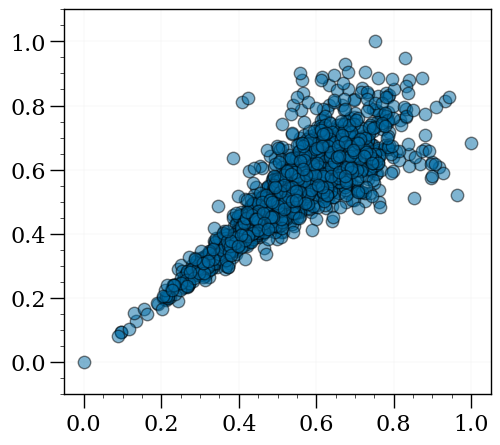

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 5
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
run(TrainingTensors, train_D, test_D, key, 'clayton_5')

## Clayton $\theta = 10$

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 10
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
run(TrainingTensors, train_D, test_D, key, 'clayton_10')

  0%|          | 1/10000 [01:02<172:54:38, 62.25s/it]

Iter 0. Loss [[ 0.09033418  0.28636408 17.988695  ]]


  0%|          | 11/10000 [02:01<4:02:54,  1.46s/it]

Iter 10. Loss [[0.09075496 0.27515283 6.965813  ]]


  0%|          | 21/10000 [02:04<46:00,  3.61it/s]

Iter 20. Loss [[0.09066962 0.27394208 6.3121004 ]]


  0%|          | 31/10000 [02:07<58:16,  2.85it/s]

Iter 30. Loss [[0.08958101 0.27099133 4.6191764 ]]


  0%|          | 41/10000 [02:11<1:01:14,  2.71it/s]

Iter 40. Loss [[0.0876155  0.26318672 2.854276  ]]


  1%|          | 51/10000 [02:14<40:03,  4.14it/s]

Iter 50. Loss [[0.08530917 0.26123747 2.6285768 ]]


  1%|          | 61/10000 [02:16<38:56,  4.25it/s]

Iter 60. Loss [[0.08299304 0.25793952 2.6860745 ]]


  1%|          | 71/10000 [02:19<36:21,  4.55it/s]

Iter 70. Loss [[0.08107278 0.25682235 2.8486152 ]]


  1%|          | 81/10000 [02:21<39:06,  4.23it/s]

Iter 80. Loss [[0.07970402 0.25109506 2.0697613 ]]


  1%|          | 91/10000 [02:24<56:41,  2.91it/s]

Iter 90. Loss [[0.07845059 0.24776453 1.7991657 ]]


  1%|          | 101/10000 [02:27<40:37,  4.06it/s]

Iter 100. Loss [[0.07736403 0.24575908 1.5649835 ]]


  1%|          | 111/10000 [02:30<36:18,  4.54it/s]

Iter 110. Loss [[0.07684975 0.24416703 1.7371172 ]]


  1%|          | 121/10000 [02:32<38:28,  4.28it/s]

Iter 120. Loss [[0.07686542 0.2419071  2.2005699 ]]


  1%|▏         | 131/10000 [02:35<41:09,  4.00it/s]

Iter 130. Loss [[0.07736278 0.24177125 2.7303307 ]]


  1%|▏         | 141/10000 [02:38<59:57,  2.74it/s]

Iter 140. Loss [[0.07823938 0.24367395 3.2713428 ]]


  2%|▏         | 151/10000 [02:41<37:51,  4.34it/s]

Iter 150. Loss [[0.07919209 0.24175435 2.7554324 ]]


  2%|▏         | 161/10000 [02:44<37:55,  4.32it/s]

Iter 160. Loss [[0.08049329 0.23803572 2.6980016 ]]


  2%|▏         | 171/10000 [02:46<35:43,  4.59it/s]

Iter 170. Loss [[0.08198372 0.2343746  2.5497382 ]]


  2%|▏         | 181/10000 [02:48<37:19,  4.38it/s]

Iter 180. Loss [[0.0835126  0.22992624 2.0199404 ]]


  2%|▏         | 191/10000 [02:52<57:46,  2.83it/s]

Iter 190. Loss [[0.0852913  0.22533284 1.6392819 ]]


  2%|▏         | 201/10000 [02:55<38:26,  4.25it/s]

Iter 200. Loss [[0.08724573 0.22058302 1.0543619 ]]


  2%|▏         | 211/10000 [02:57<35:54,  4.54it/s]

Iter 210. Loss [[0.08973217 0.21965986 0.89124584]]


  2%|▏         | 221/10000 [03:00<36:50,  4.42it/s]

Iter 220. Loss [[0.092896  0.217295  1.1958771]]


  2%|▏         | 231/10000 [03:02<35:22,  4.60it/s]

Iter 230. Loss [[0.09519578 0.21206054 1.9543014 ]]


  2%|▏         | 241/10000 [03:06<58:46,  2.77it/s]

Iter 240. Loss [[0.09541886 0.20446506 1.4504943 ]]


  3%|▎         | 251/10000 [03:08<37:17,  4.36it/s]

Iter 250. Loss [[0.09611999 0.19537297 1.1408334 ]]


  3%|▎         | 261/10000 [03:11<36:43,  4.42it/s]

Iter 260. Loss [[0.09870751 0.18984757 1.5127519 ]]


  3%|▎         | 271/10000 [03:13<35:55,  4.51it/s]

Iter 270. Loss [[0.10111544 0.18784858 1.8294886 ]]


  3%|▎         | 281/10000 [03:15<36:15,  4.47it/s]

Iter 280. Loss [[0.10255766 0.18484198 2.0173485 ]]


  3%|▎         | 291/10000 [03:19<1:28:59,  1.82it/s]

Iter 290. Loss [[0.10416266 0.18047401 2.1746435 ]]


  3%|▎         | 301/10000 [03:22<37:02,  4.36it/s]

Iter 300. Loss [[0.10735326 0.16775894 1.7641367 ]]


  3%|▎         | 311/10000 [03:24<1:01:43,  2.62it/s]

Iter 310. Loss [[0.11603653 0.15234238 1.6995083 ]]


  3%|▎         | 321/10000 [03:26<36:26,  4.43it/s]

Iter 320. Loss [[0.13037872 0.13698122 1.6476651 ]]


  3%|▎         | 331/10000 [03:29<1:00:20,  2.67it/s]

Iter 330. Loss [[0.15066689 0.1256582  1.5628659 ]]


  3%|▎         | 341/10000 [03:33<59:45,  2.69it/s]

Iter 340. Loss [[0.17874053 0.11742618 0.9579653 ]]


  4%|▎         | 351/10000 [03:35<1:00:40,  2.65it/s]

Iter 350. Loss [[0.20366377 0.12774794 0.5894158 ]]


  4%|▎         | 361/10000 [03:38<35:55,  4.47it/s]

Iter 360. Loss [[0.21999718 0.10457672 0.58871156]]


  4%|▎         | 371/10000 [03:40<1:00:54,  2.63it/s]

Iter 370. Loss [[0.257905   0.10814764 0.44311294]]


  4%|▍         | 381/10000 [03:42<36:14,  4.42it/s]

Iter 380. Loss [[0.2602992  0.11144631 0.5002707 ]]


  4%|▍         | 391/10000 [03:46<1:13:55,  2.17it/s]

Iter 390. Loss [[0.25787207 0.10140413 0.5641724 ]]


  4%|▍         | 401/10000 [03:49<36:25,  4.39it/s]

Iter 400. Loss [[0.26178706 0.10537878 0.54331946]]


  4%|▍         | 411/10000 [03:51<53:30,  2.99it/s]  

Iter 410. Loss [[0.26094398 0.10137391 0.56993043]]


  4%|▍         | 421/10000 [03:53<35:38,  4.48it/s]

Iter 420. Loss [[0.26077488 0.09994338 0.56031096]]


  4%|▍         | 431/10000 [03:56<53:20,  2.99it/s]  

Iter 430. Loss [[0.26124477 0.10023819 0.5261431 ]]


  4%|▍         | 441/10000 [04:00<53:51,  2.96it/s]

Iter 440. Loss [[0.26034886 0.09785008 0.45184183]]


  5%|▍         | 451/10000 [04:02<54:18,  2.93it/s]  

Iter 450. Loss [[0.2603829  0.09706509 0.38727832]]


  5%|▍         | 461/10000 [04:05<35:26,  4.49it/s]

Iter 460. Loss [[0.2636928  0.10200617 0.22988476]]


  5%|▍         | 471/10000 [04:07<52:26,  3.03it/s]

Iter 470. Loss [[ 0.27469638  0.21920887 -0.7747375 ]]


  5%|▍         | 481/10000 [04:09<35:36,  4.46it/s]

Iter 480. Loss [[ 0.25415692  0.0948467  -0.24591348]]


  5%|▍         | 491/10000 [04:13<1:07:36,  2.34it/s]

Iter 490. Loss [[0.24983412 0.09478442 0.54891807]]


  5%|▌         | 501/10000 [04:16<35:42,  4.43it/s]

Iter 500. Loss [[0.26620826 0.10832451 0.4631503 ]]


  5%|▌         | 511/10000 [04:18<46:21,  3.41it/s]

Iter 510. Loss [[0.25749546 0.09776903 0.49177086]]


  5%|▌         | 521/10000 [04:20<34:26,  4.59it/s]

Iter 520. Loss [[0.2592301  0.09713975 0.48567432]]


  5%|▌         | 531/10000 [04:23<54:10,  2.91it/s]

Iter 530. Loss [[0.261019   0.09960682 0.48507014]]


  5%|▌         | 541/10000 [04:27<48:23,  3.26it/s]

Iter 540. Loss [[0.25951546 0.09812722 0.48846892]]


  6%|▌         | 551/10000 [04:29<47:45,  3.30it/s]

Iter 550. Loss [[0.26013896 0.09763796 0.4875104 ]]


  6%|▌         | 561/10000 [04:32<35:18,  4.46it/s]

Iter 560. Loss [[0.25996748 0.09814732 0.4811801 ]]


  6%|▌         | 571/10000 [04:34<47:30,  3.31it/s]

Iter 570. Loss [[0.26007426 0.097874   0.46104395]]


  6%|▌         | 581/10000 [04:37<42:26,  3.70it/s]

Iter 580. Loss [[0.26031634 0.09722795 0.40212244]]


  6%|▌         | 591/10000 [04:41<52:10,  3.01it/s]

Iter 590. Loss [[0.26025313 0.09694852 0.4000431 ]]


  6%|▌         | 601/10000 [04:43<35:10,  4.45it/s]

Iter 600. Loss [[0.26045144 0.09752253 0.3743313 ]]


  6%|▌         | 611/10000 [04:46<44:25,  3.52it/s]

Iter 610. Loss [[0.26058334 0.09805922 0.3902775 ]]


  6%|▌         | 621/10000 [04:48<35:17,  4.43it/s]

Iter 620. Loss [[0.26075855 0.09858738 0.40897077]]


  6%|▋         | 631/10000 [04:51<58:53,  2.65it/s]

Iter 630. Loss [[0.26085556 0.09857239 0.361224  ]]


  6%|▋         | 641/10000 [04:54<41:14,  3.78it/s]

Iter 640. Loss [[0.2608866  0.09886517 0.3642693 ]]


  7%|▋         | 651/10000 [04:58<1:03:39,  2.45it/s]

Iter 650. Loss [[0.2608506  0.0985083  0.37868127]]


  7%|▋         | 661/10000 [05:00<35:47,  4.35it/s]

Iter 660. Loss [[0.26075703 0.09824789 0.36242837]]


  7%|▋         | 671/10000 [05:03<40:10,  3.87it/s]

Iter 670. Loss [[0.26085702 0.09826469 0.35223088]]


  7%|▋         | 681/10000 [05:06<57:34,  2.70it/s]

Iter 680. Loss [[0.2606396  0.09780681 0.35017058]]


  7%|▋         | 691/10000 [05:09<40:59,  3.78it/s]

Iter 690. Loss [[0.26062506 0.09782246 0.35087633]]


  7%|▋         | 701/10000 [05:11<34:21,  4.51it/s]

Iter 700. Loss [[0.26048684 0.09744983 0.37685683]]


  7%|▋         | 711/10000 [05:14<40:16,  3.84it/s]

Iter 710. Loss [[0.26005802 0.09739365 0.4061659 ]]


  7%|▋         | 721/10000 [05:16<34:41,  4.46it/s]

Iter 720. Loss [[0.2603394  0.09858661 0.40236303]]


  7%|▋         | 731/10000 [05:20<52:39,  2.93it/s]  

Iter 730. Loss [[0.26013705 0.09790154 0.40538427]]


  7%|▋         | 741/10000 [05:23<34:16,  4.50it/s]

Iter 740. Loss [[0.2603199  0.09816239 0.40484887]]


  8%|▊         | 751/10000 [05:25<40:05,  3.84it/s]

Iter 750. Loss [[0.2602851  0.09878789 0.40128303]]


  8%|▊         | 761/10000 [05:27<34:14,  4.50it/s]

Iter 760. Loss [[0.2602215  0.09832995 0.41061494]]


  8%|▊         | 771/10000 [05:30<42:20,  3.63it/s]

Iter 770. Loss [[0.2603073  0.09825543 0.40866166]]


  8%|▊         | 781/10000 [05:34<48:00,  3.20it/s]

Iter 780. Loss [[0.26024002 0.09806404 0.39727905]]


  8%|▊         | 791/10000 [05:36<38:36,  3.98it/s]

Iter 790. Loss [[0.2600402  0.09815684 0.43407738]]


  8%|▊         | 801/10000 [05:39<33:38,  4.56it/s]

Iter 800. Loss [[0.26026657 0.09814856 0.44620174]]


  8%|▊         | 811/10000 [05:41<38:43,  3.95it/s]

Iter 810. Loss [[0.26045546 0.09816012 0.44342163]]


  8%|▊         | 821/10000 [05:44<39:53,  3.84it/s]

Iter 820. Loss [[0.26039743 0.09825486 0.43464518]]


  8%|▊         | 831/10000 [05:47<44:46,  3.41it/s]

Iter 830. Loss [[0.26049274 0.09820867 0.43172687]]


  8%|▊         | 841/10000 [05:50<34:22,  4.44it/s]

Iter 840. Loss [[0.26046383 0.09849878 0.42977783]]


  9%|▊         | 851/10000 [05:52<37:20,  4.08it/s]

Iter 850. Loss [[0.26032665 0.09826899 0.45595792]]


  9%|▊         | 861/10000 [05:54<33:07,  4.60it/s]

Iter 860. Loss [[0.26048285 0.09848352 0.46934748]]


  9%|▊         | 871/10000 [05:58<48:48,  3.12it/s]

Iter 870. Loss [[0.26043916 0.09851877 0.47036904]]


  9%|▉         | 881/10000 [06:01<41:34,  3.66it/s]

Iter 880. Loss [[0.26046398 0.09856832 0.46743044]]


  9%|▉         | 891/10000 [06:03<37:24,  4.06it/s]

Iter 890. Loss [[0.26047876 0.09864797 0.46874833]]


  9%|▉         | 901/10000 [06:06<33:04,  4.58it/s]

Iter 900. Loss [[0.26047596 0.09857345 0.4796656 ]]


  9%|▉         | 911/10000 [06:08<36:09,  4.19it/s]

Iter 910. Loss [[0.2605185  0.09856311 0.48277962]]


  9%|▉         | 921/10000 [06:11<41:03,  3.68it/s]

Iter 920. Loss [[0.2605426  0.09866136 0.47458968]]


  9%|▉         | 931/10000 [06:14<41:31,  3.64it/s]

Iter 930. Loss [[0.26062512 0.09859806 0.452368  ]]


  9%|▉         | 941/10000 [06:17<33:47,  4.47it/s]

Iter 940. Loss [[0.26030904 0.09881216 0.45369238]]


 10%|▉         | 951/10000 [06:19<35:07,  4.29it/s]

Iter 950. Loss [[0.26066932 0.09907326 0.44237915]]


 10%|▉         | 961/10000 [06:21<32:53,  4.58it/s]

Iter 960. Loss [[0.26032466 0.09908211 0.41493297]]


 10%|▉         | 971/10000 [06:25<48:35,  3.10it/s]

Iter 970. Loss [[0.26056162 0.09920856 0.4192609 ]]


 10%|▉         | 981/10000 [06:28<40:32,  3.71it/s]

Iter 980. Loss [[0.26066348 0.10003205 0.41600928]]


 10%|▉         | 991/10000 [06:30<34:20,  4.37it/s]

Iter 990. Loss [[0.26053163 0.09867588 0.42549807]]


 10%|█         | 1001/10000 [06:33<33:22,  4.49it/s]

Iter 1000. Loss [[0.26068416 0.09918115 0.39768517]]


 10%|█         | 1011/10000 [06:35<34:36,  4.33it/s]

Iter 1010. Loss [[0.26056322 0.09943402 0.38258275]]


 10%|█         | 1021/10000 [06:38<44:50,  3.34it/s]

Iter 1020. Loss [[0.26059264 0.09936482 0.38130856]]


 10%|█         | 1031/10000 [06:41<38:02,  3.93it/s]

Iter 1030. Loss [[0.26063445 0.09941081 0.38629863]]


 10%|█         | 1041/10000 [06:44<32:47,  4.55it/s]

Iter 1040. Loss [[0.26065895 0.09999361 0.38371542]]


 11%|█         | 1051/10000 [06:46<33:30,  4.45it/s]

Iter 1050. Loss [[0.26048914 0.09852846 0.40927637]]


 11%|█         | 1061/10000 [06:48<32:28,  4.59it/s]

Iter 1060. Loss [[0.2608498  0.10091455 0.37884167]]


 11%|█         | 1071/10000 [06:52<48:58,  3.04it/s]

Iter 1070. Loss [[0.26052755 0.0991287  0.408531  ]]


 11%|█         | 1081/10000 [06:55<38:44,  3.84it/s]

Iter 1080. Loss [[0.26075354 0.10004002 0.42096052]]


 11%|█         | 1091/10000 [06:57<33:54,  4.38it/s]

Iter 1090. Loss [[0.26059902 0.09912524 0.4404829 ]]


 11%|█         | 1101/10000 [07:00<32:11,  4.61it/s]

Iter 1100. Loss [[0.26077533 0.09916297 0.4588434 ]]


 11%|█         | 1111/10000 [07:02<33:46,  4.39it/s]

Iter 1110. Loss [[0.26088825 0.09929493 0.468546  ]]


 11%|█         | 1121/10000 [07:05<46:26,  3.19it/s]

Iter 1120. Loss [[0.2613457  0.10013873 0.26717252]]


 11%|█▏        | 1131/10000 [07:08<36:34,  4.04it/s]

Iter 1130. Loss [[0.259979   0.09888503 0.383048  ]]


 11%|█▏        | 1141/10000 [07:11<57:08,  2.58it/s]

Iter 1140. Loss [[0.26108196 0.10147429 0.34710994]]


 12%|█▏        | 1151/10000 [07:13<33:18,  4.43it/s]

Iter 1150. Loss [[0.26032025 0.10258336 0.30928478]]


 12%|█▏        | 1161/10000 [07:16<54:57,  2.68it/s]

Iter 1160. Loss [[0.26084018 0.10029312 0.3775266 ]]


 12%|█▏        | 1171/10000 [07:19<50:19,  2.92it/s]

Iter 1170. Loss [[0.26040947 0.09970563 0.37925747]]


 12%|█▏        | 1181/10000 [07:22<59:11,  2.48it/s]

Iter 1180. Loss [[0.26089317 0.10020258 0.3682739 ]]


 12%|█▏        | 1191/10000 [07:24<32:49,  4.47it/s]

Iter 1190. Loss [[0.26075152 0.10050166 0.3561555 ]]


 12%|█▏        | 1201/10000 [07:27<49:07,  2.98it/s]

Iter 1200. Loss [[0.26070744 0.10010497 0.35645658]]


 12%|█▏        | 1211/10000 [07:29<32:26,  4.52it/s]

Iter 1210. Loss [[0.2608475  0.10041305 0.35662535]]


 12%|█▏        | 1221/10000 [07:33<1:09:26,  2.11it/s]

Iter 1220. Loss [[0.26068056 0.1004294  0.36676204]]


 12%|█▏        | 1231/10000 [07:35<35:06,  4.16it/s]

Iter 1230. Loss [[0.26077008 0.10044233 0.38140535]]


 12%|█▏        | 1241/10000 [07:38<48:57,  2.98it/s]

Iter 1240. Loss [[0.26074323 0.10082164 0.39823702]]


 13%|█▎        | 1251/10000 [07:40<32:33,  4.48it/s]

Iter 1250. Loss [[0.26062727 0.10044485 0.40487516]]


 13%|█▎        | 1261/10000 [07:43<48:39,  2.99it/s]

Iter 1260. Loss [[0.26079544 0.10038777 0.41277945]]


 13%|█▎        | 1271/10000 [07:46<54:08,  2.69it/s]

Iter 1270. Loss [[0.26062638 0.09978605 0.44046545]]


 13%|█▎        | 1281/10000 [07:51<59:22,  2.45it/s]  

Iter 1280. Loss [[0.26098466 0.09998417 0.44923422]]


 13%|█▎        | 1291/10000 [07:53<32:46,  4.43it/s]

Iter 1290. Loss [[0.26089925 0.10038788 0.4533523 ]]


 13%|█▎        | 1301/10000 [07:55<43:26,  3.34it/s]

Iter 1300. Loss [[0.26081553 0.09948545 0.47179127]]


 13%|█▎        | 1311/10000 [07:58<32:56,  4.40it/s]

Iter 1310. Loss [[0.26114967 0.09978615 0.4832728 ]]


 13%|█▎        | 1321/10000 [08:00<48:51,  2.96it/s]

Iter 1320. Loss [[0.26077965 0.10014972 0.50911295]]


 13%|█▎        | 1331/10000 [08:04<43:41,  3.31it/s]

Iter 1330. Loss [[0.26097497 0.09986513 0.49713492]]


 13%|█▎        | 1341/10000 [08:07<39:17,  3.67it/s]

Iter 1340. Loss [[0.26097965 0.09995516 0.50603765]]


 14%|█▎        | 1351/10000 [08:09<31:23,  4.59it/s]

Iter 1350. Loss [[0.2611877  0.10039509 0.48926994]]


 14%|█▎        | 1361/10000 [08:11<39:24,  3.65it/s]

Iter 1360. Loss [[0.26080284 0.10001031 0.50488925]]


 14%|█▎        | 1371/10000 [08:14<32:15,  4.46it/s]

Iter 1370. Loss [[0.26106235 0.10023207 0.49555826]]


 14%|█▍        | 1381/10000 [08:17<48:52,  2.94it/s]

Iter 1380. Loss [[0.2609619  0.10011404 0.51771724]]


 14%|█▍        | 1391/10000 [08:20<31:33,  4.55it/s]

Iter 1390. Loss [[0.2610184  0.10013647 0.5194068 ]]


 14%|█▍        | 1401/10000 [08:22<38:55,  3.68it/s]

Iter 1400. Loss [[0.2609939  0.1002887  0.54170257]]


 14%|█▍        | 1411/10000 [08:24<31:17,  4.57it/s]

Iter 1410. Loss [[0.26113024 0.10020684 0.54052085]]


 14%|█▍        | 1421/10000 [08:27<42:55,  3.33it/s]

Iter 1420. Loss [[0.26108912 0.10019436 0.54732114]]


 14%|█▍        | 1431/10000 [08:31<43:21,  3.29it/s]

Iter 1430. Loss [[0.26109016 0.10032924 0.54600745]]


 14%|█▍        | 1441/10000 [08:33<38:23,  3.72it/s]

Iter 1440. Loss [[0.26104745 0.10006018 0.5399952 ]]


 15%|█▍        | 1451/10000 [08:36<31:21,  4.54it/s]

Iter 1450. Loss [[0.26108804 0.10024925 0.54537386]]


 15%|█▍        | 1461/10000 [08:38<36:35,  3.89it/s]

Iter 1460. Loss [[0.26109964 0.10032749 0.5444917 ]]


 15%|█▍        | 1471/10000 [08:41<36:53,  3.85it/s]

Iter 1470. Loss [[0.26106194 0.10008673 0.53844494]]


 15%|█▍        | 1481/10000 [08:44<41:57,  3.38it/s]

Iter 1480. Loss [[0.26106673 0.1003618  0.5446096 ]]


 15%|█▍        | 1491/10000 [08:47<30:50,  4.60it/s]

Iter 1490. Loss [[0.26108715 0.10057463 0.5423248 ]]


 15%|█▌        | 1501/10000 [08:49<35:23,  4.00it/s]

Iter 1500. Loss [[0.26109105 0.10038918 0.5360439 ]]


 15%|█▌        | 1511/10000 [08:51<31:03,  4.56it/s]

Iter 1510. Loss [[0.26105723 0.10051357 0.5419965 ]]


 15%|█▌        | 1521/10000 [08:54<44:57,  3.14it/s]

Iter 1520. Loss [[0.26107025 0.10043079 0.5426703 ]]


 15%|█▌        | 1531/10000 [08:58<40:09,  3.52it/s]

Iter 1530. Loss [[0.26112458 0.10090832 0.5476854 ]]


 15%|█▌        | 1541/10000 [09:00<33:13,  4.24it/s]

Iter 1540. Loss [[0.2611082  0.10074607 0.5490242 ]]


 16%|█▌        | 1551/10000 [09:02<30:40,  4.59it/s]

Iter 1550. Loss [[0.26137272 0.10107392 0.5163002 ]]


 16%|█▌        | 1561/10000 [09:05<33:07,  4.25it/s]

Iter 1560. Loss [[0.260755   0.10039613 0.54542446]]


 16%|█▌        | 1571/10000 [09:08<37:45,  3.72it/s]

Iter 1570. Loss [[0.2617374  0.10071138 0.44811442]]


 16%|█▌        | 1581/10000 [09:11<38:49,  3.61it/s]

Iter 1580. Loss [[0.26173788 0.09960774 0.46076164]]


 16%|█▌        | 1591/10000 [09:13<31:13,  4.49it/s]

Iter 1590. Loss [[0.26136288 0.10053846 0.5149557 ]]


 16%|█▌        | 1601/10000 [09:16<34:16,  4.08it/s]

Iter 1600. Loss [[0.26146686 0.09790114 0.36055592]]


 16%|█▌        | 1611/10000 [09:18<30:31,  4.58it/s]

Iter 1610. Loss [[0.26309055 0.09725158 0.10277902]]


 16%|█▌        | 1621/10000 [09:21<45:23,  3.08it/s]

Iter 1620. Loss [[ 0.26187077  0.11298151 -0.13547604]]


 16%|█▋        | 1631/10000 [09:25<37:01,  3.77it/s]

Iter 1630. Loss [[ 0.26097086  0.09118862 -0.04761206]]


 16%|█▋        | 1641/10000 [09:27<33:44,  4.13it/s]

Iter 1640. Loss [[ 0.26135272  0.10058945 -0.09130026]]


 17%|█▋        | 1651/10000 [09:29<30:57,  4.49it/s]

Iter 1650. Loss [[ 0.26046014  0.09665358 -0.04217779]]


 17%|█▋        | 1661/10000 [09:32<32:46,  4.24it/s]

Iter 1660. Loss [[0.26083294 0.10096637 0.12335372]]


 17%|█▋        | 1671/10000 [09:35<43:11,  3.21it/s]

Iter 1670. Loss [[0.26063153 0.101136   0.19227886]]


 17%|█▋        | 1681/10000 [09:38<35:30,  3.90it/s]

Iter 1680. Loss [[0.26012585 0.10074542 0.32323188]]


 17%|█▋        | 1691/10000 [09:41<30:21,  4.56it/s]

Iter 1690. Loss [[0.2611095  0.10024449 0.39313003]]


 17%|█▋        | 1701/10000 [09:43<31:13,  4.43it/s]

Iter 1700. Loss [[0.26073822 0.0999212  0.42040172]]


 17%|█▋        | 1711/10000 [09:45<30:18,  4.56it/s]

Iter 1710. Loss [[0.2610656 0.0998254 0.4211372]]


 17%|█▋        | 1721/10000 [09:49<47:20,  2.91it/s]

Iter 1720. Loss [[0.26071513 0.09972836 0.4240677 ]]


 17%|█▋        | 1731/10000 [09:52<34:26,  4.00it/s]

Iter 1730. Loss [[0.2607694  0.10006573 0.4533503 ]]


 17%|█▋        | 1741/10000 [09:54<31:41,  4.34it/s]

Iter 1740. Loss [[0.2607574  0.10002879 0.45512778]]


 18%|█▊        | 1751/10000 [09:57<30:27,  4.51it/s]

Iter 1750. Loss [[0.26077136 0.1002551  0.4515164 ]]


 18%|█▊        | 1761/10000 [09:59<31:13,  4.40it/s]

Iter 1760. Loss [[0.2608108  0.10024947 0.45132983]]


 18%|█▊        | 1771/10000 [10:02<46:53,  2.92it/s]

Iter 1770. Loss [[0.26074716 0.10031435 0.46484536]]


 18%|█▊        | 1781/10000 [10:05<32:53,  4.16it/s]

Iter 1780. Loss [[0.26071528 0.1012079  0.46225318]]


 18%|█▊        | 1791/10000 [10:08<30:09,  4.54it/s]

Iter 1790. Loss [[0.26086107 0.10086872 0.54257053]]


 18%|█▊        | 1801/10000 [10:10<30:17,  4.51it/s]

Iter 1800. Loss [[0.26142025 0.10284732 0.5815867 ]]


 18%|█▊        | 1811/10000 [10:13<52:17,  2.61it/s]

Iter 1810. Loss [[0.26123738 0.10132322 0.5750788 ]]


 18%|█▊        | 1821/10000 [10:16<48:02,  2.84it/s]

Iter 1820. Loss [[0.26150334 0.10393194 0.5648394 ]]


 18%|█▊        | 1831/10000 [10:19<54:48,  2.48it/s]

Iter 1830. Loss [[0.24901323 0.11983081 0.7353796 ]]


 18%|█▊        | 1841/10000 [10:21<30:20,  4.48it/s]

Iter 1840. Loss [[0.266212   0.10624578 0.5739908 ]]


 19%|█▊        | 1851/10000 [10:24<50:37,  2.68it/s]

Iter 1850. Loss [[0.2546705  0.0934671  0.37390006]]


 19%|█▊        | 1861/10000 [10:26<30:32,  4.44it/s]

Iter 1860. Loss [[0.26217306 0.09998718 0.465122  ]]


 19%|█▊        | 1871/10000 [10:30<1:11:46,  1.89it/s]

Iter 1870. Loss [[0.2497698  0.1034307  0.67706484]]


 19%|█▉        | 1881/10000 [10:32<32:47,  4.13it/s]

Iter 1880. Loss [[0.26637787 0.11078157 0.54501003]]


 19%|█▉        | 1891/10000 [10:36<1:04:09,  2.11it/s]

Iter 1890. Loss [[0.2579305  0.09592308 0.60008067]]


 19%|█▉        | 1901/10000 [10:39<31:51,  4.24it/s]

Iter 1900. Loss [[0.2626958  0.10768431 0.5602535 ]]


 19%|█▉        | 1911/10000 [10:41<52:26,  2.57it/s]

Iter 1910. Loss [[0.26092085 0.10165425 0.5523686 ]]


 19%|█▉        | 1921/10000 [10:45<38:08,  3.53it/s]

Iter 1920. Loss [[0.2612187  0.09985756 0.5814429 ]]


 19%|█▉        | 1931/10000 [10:47<45:24,  2.96it/s]

Iter 1930. Loss [[0.2612935  0.10187586 0.5558436 ]]


 19%|█▉        | 1941/10000 [10:50<29:48,  4.51it/s]

Iter 1940. Loss [[0.26120555 0.0998856  0.52276516]]


 20%|█▉        | 1951/10000 [10:52<39:38,  3.38it/s]

Iter 1950. Loss [[0.26085606 0.09857938 0.4163784 ]]


 20%|█▉        | 1961/10000 [10:55<36:20,  3.69it/s]

Iter 1960. Loss [[0.26064947 0.09709676 0.37317076]]


 20%|█▉        | 1971/10000 [10:59<50:48,  2.63it/s]

Iter 1970. Loss [[0.26055408 0.0965313  0.43676618]]


 20%|█▉        | 1981/10000 [11:01<30:19,  4.41it/s]

Iter 1980. Loss [[0.26099634 0.09933854 0.4728896 ]]


 20%|█▉        | 1991/10000 [11:04<40:43,  3.28it/s]

Iter 1990. Loss [[0.26100552 0.10100654 0.5474605 ]]


 20%|██        | 2001/10000 [11:06<29:39,  4.50it/s]

Iter 2000. Loss [[0.26114613 0.10132224 0.57396203]]


 20%|██        | 2011/10000 [11:09<52:21,  2.54it/s]

Iter 2010. Loss [[0.2612863  0.10172208 0.55432   ]]


 20%|██        | 2021/10000 [11:12<33:59,  3.91it/s]

Iter 2020. Loss [[0.26118246 0.10095424 0.56427366]]


 20%|██        | 2031/10000 [11:15<37:31,  3.54it/s]

Iter 2030. Loss [[0.26113418 0.10104378 0.5542028 ]]


 20%|██        | 2041/10000 [11:17<30:06,  4.41it/s]

Iter 2040. Loss [[0.26119208 0.10087708 0.5573153 ]]


 21%|██        | 2051/10000 [11:20<36:17,  3.65it/s]

Iter 2050. Loss [[0.26114637 0.10086023 0.5563451 ]]


 21%|██        | 2061/10000 [11:22<43:21,  3.05it/s]

Iter 2060. Loss [[0.2612     0.10095667 0.55818427]]


 21%|██        | 2071/10000 [11:26<40:11,  3.29it/s]

Iter 2070. Loss [[0.26115295 0.10087154 0.55524826]]


 21%|██        | 2081/10000 [11:28<31:20,  4.21it/s]

Iter 2080. Loss [[0.26117048 0.10087232 0.5546379 ]]


 21%|██        | 2091/10000 [11:31<34:09,  3.86it/s]

Iter 2090. Loss [[0.26118007 0.10101457 0.55769247]]


 21%|██        | 2101/10000 [11:33<29:07,  4.52it/s]

Iter 2100. Loss [[0.26117238 0.10092506 0.558596  ]]


 21%|██        | 2111/10000 [11:37<50:36,  2.60it/s]

Iter 2110. Loss [[0.261175   0.10099015 0.5573204 ]]


 21%|██        | 2121/10000 [11:39<30:30,  4.30it/s]

Iter 2120. Loss [[0.2611639  0.10094098 0.5575344 ]]


 21%|██▏       | 2131/10000 [11:42<33:13,  3.95it/s]

Iter 2130. Loss [[0.26118574 0.1008919  0.55811566]]


 21%|██▏       | 2141/10000 [11:44<28:38,  4.57it/s]

Iter 2140. Loss [[0.2611543  0.1009413  0.55551285]]


 22%|██▏       | 2151/10000 [11:47<32:04,  4.08it/s]

Iter 2150. Loss [[0.26116872 0.10095271 0.5557292 ]]


 22%|██▏       | 2161/10000 [11:50<44:46,  2.92it/s]

Iter 2160. Loss [[0.26115954 0.10092481 0.5558897 ]]


 22%|██▏       | 2171/10000 [11:53<34:54,  3.74it/s]

Iter 2170. Loss [[0.26114923 0.10092105 0.555966  ]]


 22%|██▏       | 2181/10000 [11:55<28:52,  4.51it/s]

Iter 2180. Loss [[0.26114884 0.10096613 0.555373  ]]


 22%|██▏       | 2191/10000 [11:58<31:51,  4.09it/s]

Iter 2190. Loss [[0.26114854 0.10096381 0.55656695]]


 22%|██▏       | 2201/10000 [12:00<28:52,  4.50it/s]

Iter 2200. Loss [[0.26114076 0.10096189 0.555804  ]]


 22%|██▏       | 2211/10000 [12:04<47:30,  2.73it/s]

Iter 2210. Loss [[0.26114532 0.10098642 0.55549526]]


 22%|██▏       | 2221/10000 [12:06<30:17,  4.28it/s]

Iter 2220. Loss [[0.2611318  0.10097925 0.55485165]]


 22%|██▏       | 2231/10000 [12:09<31:59,  4.05it/s]

Iter 2230. Loss [[0.26114112 0.10101553 0.55459625]]


 22%|██▏       | 2241/10000 [12:11<28:56,  4.47it/s]

Iter 2240. Loss [[0.26112574 0.10101572 0.5546695 ]]


 23%|██▎       | 2251/10000 [12:14<31:33,  4.09it/s]

Iter 2250. Loss [[0.2611311  0.10104114 0.5541826 ]]


 23%|██▎       | 2261/10000 [12:17<46:11,  2.79it/s]

Iter 2260. Loss [[0.26112866 0.10106201 0.55421954]]


 23%|██▎       | 2271/10000 [12:20<32:07,  4.01it/s]

Iter 2270. Loss [[0.26112258 0.10108753 0.55372   ]]


 23%|██▎       | 2281/10000 [12:23<27:57,  4.60it/s]

Iter 2280. Loss [[0.2611264  0.10108591 0.55352175]]


 23%|██▎       | 2291/10000 [12:25<30:11,  4.25it/s]

Iter 2290. Loss [[0.26112095 0.10110211 0.5533391 ]]


 23%|██▎       | 2301/10000 [12:27<28:38,  4.48it/s]

Iter 2300. Loss [[0.26111853 0.10111699 0.55301434]]


 23%|██▎       | 2311/10000 [12:31<47:46,  2.68it/s]

Iter 2310. Loss [[0.26111713 0.10110771 0.5527937 ]]


 23%|██▎       | 2321/10000 [12:34<28:57,  4.42it/s]

Iter 2320. Loss [[0.26112348 0.10113646 0.5527675 ]]


 23%|██▎       | 2331/10000 [12:36<29:38,  4.31it/s]

Iter 2330. Loss [[0.26111606 0.10115084 0.5524938 ]]


 23%|██▎       | 2341/10000 [12:38<28:20,  4.50it/s]

Iter 2340. Loss [[0.261114   0.10117413 0.55217236]]


 24%|██▎       | 2351/10000 [12:41<29:18,  4.35it/s]

Iter 2350. Loss [[0.26111433 0.10119785 0.55188435]]


 24%|██▎       | 2361/10000 [12:44<45:47,  2.78it/s]

Iter 2360. Loss [[0.26111007 0.10121523 0.55161524]]


 24%|██▎       | 2371/10000 [12:47<30:33,  4.16it/s]

Iter 2370. Loss [[0.26110858 0.10123348 0.5513462 ]]


 24%|██▍       | 2381/10000 [12:49<27:23,  4.64it/s]

Iter 2380. Loss [[0.26110604 0.10126595 0.55096096]]


 24%|██▍       | 2391/10000 [12:52<29:07,  4.36it/s]

Iter 2390. Loss [[0.26110405 0.1012674  0.5508235 ]]


 24%|██▍       | 2401/10000 [12:54<28:04,  4.51it/s]

Iter 2400. Loss [[0.26110443 0.10127655 0.5510027 ]]


 24%|██▍       | 2411/10000 [12:58<47:19,  2.67it/s]

Iter 2410. Loss [[0.26110542 0.10129812 0.55079085]]


 24%|██▍       | 2421/10000 [13:00<28:06,  4.49it/s]

Iter 2420. Loss [[0.26110673 0.10132206 0.55052406]]


 24%|██▍       | 2431/10000 [13:03<28:49,  4.38it/s]

Iter 2430. Loss [[0.2611017  0.10135937 0.54974765]]


 24%|██▍       | 2441/10000 [13:05<27:39,  4.56it/s]

Iter 2440. Loss [[0.26108932 0.10263921 0.5542565 ]]


 25%|██▍       | 2451/10000 [13:08<28:51,  4.36it/s]

Iter 2450. Loss [[0.26102957 0.10231881 0.551753  ]]


 25%|██▍       | 2461/10000 [13:11<44:59,  2.79it/s]

Iter 2460. Loss [[0.26111886 0.10164276 0.5547821 ]]


 25%|██▍       | 2471/10000 [13:14<29:02,  4.32it/s]

Iter 2470. Loss [[0.26110035 0.10130129 0.555299  ]]


 25%|██▍       | 2481/10000 [13:16<27:56,  4.49it/s]

Iter 2480. Loss [[0.26112792 0.10127671 0.5548473 ]]


 25%|██▍       | 2491/10000 [13:19<28:05,  4.46it/s]

Iter 2490. Loss [[0.26111248 0.10127451 0.55471283]]


 25%|██▌       | 2501/10000 [13:21<26:55,  4.64it/s]

Iter 2500. Loss [[0.26111066 0.10127492 0.5545604 ]]


 25%|██▌       | 2511/10000 [13:26<48:31,  2.57it/s]

Iter 2510. Loss [[0.26112285 0.10130154 0.554271  ]]


 25%|██▌       | 2521/10000 [13:29<55:01,  2.27it/s]

Iter 2520. Loss [[0.26111156 0.10132316 0.5536998 ]]


 25%|██▌       | 2531/10000 [13:32<27:45,  4.48it/s]

Iter 2530. Loss [[0.2611083  0.10130086 0.55403644]]


 25%|██▌       | 2541/10000 [13:34<48:50,  2.55it/s]

Iter 2540. Loss [[0.2611092  0.10132487 0.553431  ]]


 26%|██▌       | 2551/10000 [13:37<27:20,  4.54it/s]

Iter 2550. Loss [[0.26110682 0.10133433 0.5532686 ]]


 26%|██▌       | 2561/10000 [13:40<1:06:51,  1.85it/s]

Iter 2560. Loss [[0.26110777 0.10130658 0.55357575]]


 26%|██▌       | 2571/10000 [13:43<28:03,  4.41it/s]

Iter 2570. Loss [[0.26110622 0.10130548 0.55348545]]


 26%|██▌       | 2581/10000 [13:45<46:17,  2.67it/s]

Iter 2580. Loss [[0.2610968  0.10139404 0.5529924 ]]


 26%|██▌       | 2591/10000 [13:47<27:51,  4.43it/s]

Iter 2590. Loss [[0.2609839  0.1011899  0.55475795]]


 26%|██▌       | 2601/10000 [13:50<45:51,  2.69it/s]

Iter 2600. Loss [[0.2611335  0.10130952 0.55335736]]


 26%|██▌       | 2611/10000 [13:54<45:32,  2.70it/s]

Iter 2610. Loss [[0.26110008 0.10120715 0.5537366 ]]


 26%|██▌       | 2621/10000 [13:56<41:00,  3.00it/s]

Iter 2620. Loss [[0.26110744 0.10120116 0.553566  ]]


 26%|██▋       | 2631/10000 [13:58<27:07,  4.53it/s]

Iter 2630. Loss [[0.2611092  0.10121136 0.55293834]]


 26%|██▋       | 2641/10000 [14:01<40:46,  3.01it/s]

Iter 2640. Loss [[0.2610978  0.1012363  0.55337733]]


 27%|██▋       | 2651/10000 [14:03<27:01,  4.53it/s]

Iter 2650. Loss [[0.26110238 0.10125773 0.55260223]]


 27%|██▋       | 2661/10000 [14:07<55:33,  2.20it/s]  

Iter 2660. Loss [[0.26108655 0.10135665 0.5526394 ]]


 27%|██▋       | 2671/10000 [14:09<27:12,  4.49it/s]

Iter 2670. Loss [[0.26106924 0.10139804 0.5531576 ]]


 27%|██▋       | 2681/10000 [14:12<38:44,  3.15it/s]

Iter 2680. Loss [[0.26112938 0.10142883 0.5525388 ]]


 27%|██▋       | 2691/10000 [14:14<26:47,  4.55it/s]

Iter 2690. Loss [[0.26112866 0.10121179 0.55250865]]


 27%|██▋       | 2701/10000 [14:17<35:03,  3.47it/s]

Iter 2700. Loss [[0.26111016 0.10114888 0.5524345 ]]


 27%|██▋       | 2711/10000 [14:20<44:00,  2.76it/s]

Iter 2710. Loss [[0.26112756 0.10134944 0.552208  ]]


 27%|██▋       | 2721/10000 [14:23<36:30,  3.32it/s]

Iter 2720. Loss [[0.26067913 0.10214187 0.5870693 ]]


 27%|██▋       | 2731/10000 [14:25<26:34,  4.56it/s]

Iter 2730. Loss [[0.26146182 0.10311448 0.5633033 ]]


 27%|██▋       | 2741/10000 [14:28<36:13,  3.34it/s]

Iter 2740. Loss [[0.26106665 0.10133019 0.57605183]]


 28%|██▊       | 2751/10000 [14:30<26:41,  4.53it/s]

Iter 2750. Loss [[0.2612173  0.10144102 0.56818324]]


 28%|██▊       | 2761/10000 [14:34<50:50,  2.37it/s]

Iter 2760. Loss [[0.2611678  0.10114096 0.5707473 ]]


 28%|██▊       | 2771/10000 [14:36<27:02,  4.46it/s]

Iter 2770. Loss [[0.26104423 0.10070156 0.56341785]]


 28%|██▊       | 2781/10000 [14:39<32:38,  3.69it/s]

Iter 2780. Loss [[0.26123255 0.10074599 0.55514187]]


 28%|██▊       | 2791/10000 [14:41<26:37,  4.51it/s]

Iter 2790. Loss [[0.2611156  0.10056525 0.55526245]]


 28%|██▊       | 2801/10000 [14:43<32:31,  3.69it/s]

Iter 2800. Loss [[0.26115432 0.10075735 0.55744034]]


 28%|██▊       | 2811/10000 [14:47<42:55,  2.79it/s]

Iter 2810. Loss [[0.26116714 0.10075232 0.55702955]]


 28%|██▊       | 2821/10000 [14:50<33:27,  3.58it/s]

Iter 2820. Loss [[0.2611461  0.10082623 0.55619675]]


 28%|██▊       | 2831/10000 [14:52<26:12,  4.56it/s]

Iter 2830. Loss [[0.26109317 0.10293479 0.5780138 ]]


 28%|██▊       | 2841/10000 [14:55<33:14,  3.59it/s]

Iter 2840. Loss [[0.26086077 0.10133697 0.5946328 ]]


 29%|██▊       | 2851/10000 [14:57<26:32,  4.49it/s]

Iter 2850. Loss [[0.26229033 0.10456551 0.5902537 ]]


 29%|██▊       | 2861/10000 [15:01<41:44,  2.85it/s]

Iter 2860. Loss [[0.2609155  0.10010607 0.6108486 ]]


 29%|██▊       | 2871/10000 [15:03<27:25,  4.33it/s]

Iter 2870. Loss [[0.26098627 0.10197184 0.6006561 ]]


 29%|██▉       | 2881/10000 [15:06<31:08,  3.81it/s]

Iter 2880. Loss [[0.26139587 0.10127658 0.6035284 ]]


 29%|██▉       | 2891/10000 [15:08<26:02,  4.55it/s]

Iter 2890. Loss [[0.26124677 0.10295185 0.5678843 ]]


 29%|██▉       | 2901/10000 [15:11<34:36,  3.42it/s]

Iter 2900. Loss [[0.26086736 0.10122381 0.57342106]]


 29%|██▉       | 2911/10000 [15:14<35:32,  3.32it/s]

Iter 2910. Loss [[0.26119512 0.10102067 0.57263273]]


 29%|██▉       | 2921/10000 [15:17<29:00,  4.07it/s]

Iter 2920. Loss [[0.26130253 0.10093608 0.5743992 ]]


 29%|██▉       | 2931/10000 [15:19<25:39,  4.59it/s]

Iter 2930. Loss [[0.2611797 0.1009656 0.5813562]]


 29%|██▉       | 2941/10000 [15:22<28:48,  4.08it/s]

Iter 2940. Loss [[0.26125184 0.10101483 0.5805459 ]]


 30%|██▉       | 2951/10000 [15:24<25:44,  4.56it/s]

Iter 2950. Loss [[0.26127532 0.10106616 0.5797725 ]]


 30%|██▉       | 2961/10000 [15:28<35:55,  3.27it/s]

Iter 2960. Loss [[0.2612437  0.10103945 0.58426625]]


 30%|██▉       | 2971/10000 [15:30<26:12,  4.47it/s]

Iter 2970. Loss [[0.26124498 0.10117919 0.5882429 ]]


 30%|██▉       | 2981/10000 [15:32<27:27,  4.26it/s]

Iter 2980. Loss [[0.26124072 0.10114204 0.5881411 ]]


 30%|██▉       | 2991/10000 [15:35<26:02,  4.48it/s]

Iter 2990. Loss [[0.26123127 0.10119944 0.5876431 ]]


 30%|███       | 3001/10000 [15:38<37:15,  3.13it/s]

Iter 3000. Loss [[0.26123288 0.10119635 0.5874752 ]]


 30%|███       | 3011/10000 [15:41<32:35,  3.57it/s]

Iter 3010. Loss [[0.26123214 0.10122941 0.58716327]]


 30%|███       | 3021/10000 [15:44<27:42,  4.20it/s]

Iter 3020. Loss [[0.2612245  0.10122631 0.5871506 ]]


 30%|███       | 3031/10000 [15:46<25:51,  4.49it/s]

Iter 3030. Loss [[0.26122436 0.10125313 0.5868659 ]]


 30%|███       | 3041/10000 [15:48<26:51,  4.32it/s]

Iter 3040. Loss [[0.2612204  0.10126571 0.5871551 ]]


 31%|███       | 3051/10000 [15:51<29:54,  3.87it/s]

Iter 3050. Loss [[0.26121905 0.10128124 0.58729   ]]


 31%|███       | 3061/10000 [15:54<30:56,  3.74it/s]

Iter 3060. Loss [[0.2612179  0.10128945 0.5871607 ]]


 31%|███       | 3071/10000 [15:57<25:47,  4.48it/s]

Iter 3070. Loss [[0.26121512 0.10131736 0.58693886]]


 31%|███       | 3081/10000 [15:59<26:39,  4.32it/s]

Iter 3080. Loss [[0.26121217 0.10131191 0.5868507 ]]


 31%|███       | 3091/10000 [16:01<25:11,  4.57it/s]

Iter 3090. Loss [[0.26120868 0.10131755 0.58672965]]


 31%|███       | 3101/10000 [16:05<36:36,  3.14it/s]

Iter 3100. Loss [[0.26120695 0.10132359 0.58661306]]


 31%|███       | 3111/10000 [16:08<30:38,  3.75it/s]

Iter 3110. Loss [[0.2612074 0.101356  0.5864077]]


 31%|███       | 3121/10000 [16:10<26:00,  4.41it/s]

Iter 3120. Loss [[0.26120397 0.1013207  0.58644533]]


 31%|███▏      | 3131/10000 [16:13<38:17,  2.99it/s]

Iter 3130. Loss [[0.26119378 0.10137641 0.5922272 ]]


 31%|███▏      | 3141/10000 [16:16<27:08,  4.21it/s]

Iter 3140. Loss [[0.26123407 0.10143984 0.5831929 ]]


 32%|███▏      | 3151/10000 [16:20<40:12,  2.84it/s]

Iter 3150. Loss [[0.26123452 0.10158317 0.580266  ]]


 32%|███▏      | 3161/10000 [16:23<26:51,  4.24it/s]

Iter 3160. Loss [[0.26121277 0.10158956 0.57810014]]


 32%|███▏      | 3171/10000 [16:25<24:50,  4.58it/s]

Iter 3170. Loss [[0.26119304 0.10171644 0.5725597 ]]


 32%|███▏      | 3181/10000 [16:27<26:36,  4.27it/s]

Iter 3180. Loss [[0.26118317 0.10164063 0.57081145]]


 32%|███▏      | 3191/10000 [16:29<24:40,  4.60it/s]

Iter 3190. Loss [[0.261211   0.10148957 0.5672177 ]]


 32%|███▏      | 3201/10000 [16:34<42:14,  2.68it/s]

Iter 3200. Loss [[0.26123914 0.10098637 0.5730754 ]]


 32%|███▏      | 3211/10000 [16:36<25:46,  4.39it/s]

Iter 3210. Loss [[0.26129973 0.1011676  0.559148  ]]


 32%|███▏      | 3221/10000 [16:38<25:47,  4.38it/s]

Iter 3220. Loss [[0.2613135  0.10059926 0.5616687 ]]


 32%|███▏      | 3231/10000 [16:41<25:02,  4.51it/s]

Iter 3230. Loss [[0.2611723  0.10033548 0.54829794]]


 32%|███▏      | 3241/10000 [16:43<25:45,  4.37it/s]

Iter 3240. Loss [[0.2608872  0.10095357 0.5062628 ]]


 33%|███▎      | 3251/10000 [16:47<41:08,  2.73it/s]

Iter 3250. Loss [[0.26134434 0.10174005 0.56195223]]


 33%|███▎      | 3261/10000 [16:50<25:29,  4.41it/s]

Iter 3260. Loss [[0.2607519  0.10111149 0.5472889 ]]


 33%|███▎      | 3271/10000 [16:52<24:41,  4.54it/s]

Iter 3270. Loss [[0.25993907 0.09972733 0.48841015]]


 33%|███▎      | 3281/10000 [16:55<25:08,  4.45it/s]

Iter 3280. Loss [[0.26032832 0.10066292 0.5626721 ]]


 33%|███▎      | 3291/10000 [16:57<23:54,  4.68it/s]

Iter 3290. Loss [[0.26095396 0.1011594  0.57563317]]


 33%|███▎      | 3301/10000 [17:01<36:04,  3.09it/s]

Iter 3300. Loss [[0.26119268 0.10030193 0.5613672 ]]


 33%|███▎      | 3311/10000 [17:03<42:07,  2.65it/s]

Iter 3310. Loss [[0.26093185 0.10021578 0.5631771 ]]


 33%|███▎      | 3321/10000 [17:06<25:03,  4.44it/s]

Iter 3320. Loss [[0.26096594 0.10068034 0.5840875 ]]


 33%|███▎      | 3331/10000 [17:08<43:24,  2.56it/s]

Iter 3330. Loss [[0.26110357 0.10056926 0.5941899 ]]


 33%|███▎      | 3341/10000 [17:10<24:20,  4.56it/s]

Iter 3340. Loss [[0.26115453 0.10076627 0.60365033]]


 34%|███▎      | 3351/10000 [17:14<54:31,  2.03it/s]

Iter 3350. Loss [[0.261289   0.10095221 0.6106037 ]]


 34%|███▎      | 3361/10000 [17:17<25:12,  4.39it/s]

Iter 3360. Loss [[0.26132387 0.1009592  0.6091227 ]]


 34%|███▎      | 3371/10000 [17:19<40:59,  2.69it/s]

Iter 3370. Loss [[0.2613203  0.10087731 0.610551  ]]


 34%|███▍      | 3381/10000 [17:21<24:30,  4.50it/s]

Iter 3380. Loss [[0.261311   0.10085501 0.6107114 ]]


 34%|███▍      | 3391/10000 [17:24<41:11,  2.67it/s]

Iter 3390. Loss [[0.26132154 0.10091795 0.6108891 ]]


 34%|███▍      | 3401/10000 [17:28<33:12,  3.31it/s]

Iter 3400. Loss [[0.26132    0.10092867 0.6115071 ]]


 34%|███▍      | 3411/10000 [17:30<36:32,  3.01it/s]

Iter 3410. Loss [[0.26132306 0.10103309 0.6154382 ]]


 34%|███▍      | 3421/10000 [17:32<24:17,  4.51it/s]

Iter 3420. Loss [[0.26135117 0.10109742 0.6152767 ]]


 34%|███▍      | 3431/10000 [17:35<36:56,  2.96it/s]

Iter 3430. Loss [[0.26133913 0.10106803 0.6153248 ]]


 34%|███▍      | 3441/10000 [17:37<26:52,  4.07it/s]

Iter 3440. Loss [[0.26133737 0.10106783 0.6152378 ]]


 35%|███▍      | 3451/10000 [17:41<44:51,  2.43it/s]

Iter 3450. Loss [[0.26133862 0.10108374 0.6154493 ]]


 35%|███▍      | 3461/10000 [17:43<24:00,  4.54it/s]

Iter 3460. Loss [[0.26134017 0.101084   0.61535496]]


 35%|███▍      | 3471/10000 [17:46<35:37,  3.05it/s]

Iter 3470. Loss [[0.2613423  0.10108604 0.6152852 ]]


 35%|███▍      | 3481/10000 [17:48<24:59,  4.35it/s]

Iter 3480. Loss [[0.26134712 0.10110644 0.6154444 ]]


 35%|███▍      | 3491/10000 [17:51<41:20,  2.62it/s]

Iter 3490. Loss [[0.26134557 0.10110329 0.6154227 ]]


 35%|███▌      | 3501/10000 [17:55<29:46,  3.64it/s]

Iter 3500. Loss [[0.26134452 0.10110479 0.6153794 ]]


 35%|███▌      | 3511/10000 [17:57<32:29,  3.33it/s]

Iter 3510. Loss [[0.2613445  0.10110272 0.61535484]]


 35%|███▌      | 3521/10000 [18:00<23:41,  4.56it/s]

Iter 3520. Loss [[0.2613446  0.10110396 0.615316  ]]


 35%|███▌      | 3531/10000 [18:02<32:12,  3.35it/s]

Iter 3530. Loss [[0.2613448  0.10110368 0.61528385]]


 35%|███▌      | 3541/10000 [18:05<31:16,  3.44it/s]

Iter 3540. Loss [[0.261345   0.10110382 0.61524993]]


 36%|███▌      | 3551/10000 [18:09<35:29,  3.03it/s]

Iter 3550. Loss [[0.26134497 0.10109955 0.6152176 ]]


 36%|███▌      | 3561/10000 [18:11<24:16,  4.42it/s]

Iter 3560. Loss [[0.2613453  0.1011012  0.61517763]]


 36%|███▌      | 3571/10000 [18:13<29:24,  3.64it/s]

Iter 3570. Loss [[0.2613453 0.1011005 0.61515  ]]


 36%|███▌      | 3581/10000 [18:16<23:15,  4.60it/s]

Iter 3580. Loss [[0.26134527 0.10110031 0.61512035]]


 36%|███▌      | 3591/10000 [18:19<39:25,  2.71it/s]

Iter 3590. Loss [[0.26134533 0.10110046 0.6150893 ]]


 36%|███▌      | 3601/10000 [18:22<28:14,  3.78it/s]

Iter 3600. Loss [[0.2613454  0.10110077 0.61505777]]


 36%|███▌      | 3611/10000 [18:25<27:04,  3.93it/s]

Iter 3610. Loss [[0.2613454  0.10110072 0.6150285 ]]


 36%|███▌      | 3621/10000 [18:27<23:47,  4.47it/s]

Iter 3620. Loss [[0.26134545 0.10110068 0.6149994 ]]


 36%|███▋      | 3631/10000 [18:29<27:54,  3.80it/s]

Iter 3630. Loss [[0.2613455  0.10110084 0.6149698 ]]


 36%|███▋      | 3641/10000 [18:32<33:00,  3.21it/s]

Iter 3640. Loss [[0.26134557 0.10110093 0.61494076]]


 37%|███▋      | 3651/10000 [18:36<31:47,  3.33it/s]

Iter 3650. Loss [[0.26134557 0.10110095 0.6149123 ]]


 37%|███▋      | 3661/10000 [18:38<23:42,  4.46it/s]

Iter 3660. Loss [[0.2613456  0.10110106 0.61488396]]


 37%|███▋      | 3671/10000 [18:41<27:54,  3.78it/s]

Iter 3670. Loss [[0.26134568 0.10110112 0.6148559 ]]


 37%|███▋      | 3681/10000 [18:43<23:18,  4.52it/s]

Iter 3680. Loss [[0.26134568 0.10110118 0.6148281 ]]


 37%|███▋      | 3691/10000 [18:46<39:54,  2.64it/s]

Iter 3690. Loss [[0.2613457  0.10110126 0.6148007 ]]


 37%|███▋      | 3701/10000 [18:49<25:30,  4.11it/s]

Iter 3700. Loss [[0.2613457  0.10110129 0.6147736 ]]


 37%|███▋      | 3711/10000 [18:52<26:09,  4.01it/s]

Iter 3710. Loss [[0.26134574 0.10110137 0.61474663]]


 37%|███▋      | 3721/10000 [18:54<23:30,  4.45it/s]

Iter 3720. Loss [[0.26134574 0.10110144 0.61472   ]]


 37%|███▋      | 3731/10000 [18:57<26:14,  3.98it/s]

Iter 3730. Loss [[0.2613458 0.1011015 0.6146936]]


 37%|███▋      | 3741/10000 [19:00<40:14,  2.59it/s]

Iter 3740. Loss [[0.2613458  0.10110154 0.6146675 ]]


 38%|███▊      | 3751/10000 [19:05<44:20,  2.35it/s]

Iter 3750. Loss [[0.26134586 0.10110163 0.6146415 ]]


 38%|███▊      | 3761/10000 [19:07<23:51,  4.36it/s]

Iter 3760. Loss [[0.2613459 0.1011017 0.6146156]]


 38%|███▊      | 3771/10000 [19:10<25:12,  4.12it/s]

Iter 3770. Loss [[0.26134586 0.10110171 0.61459035]]


 38%|███▊      | 3781/10000 [19:12<23:08,  4.48it/s]

Iter 3780. Loss [[0.2613459  0.10110181 0.6145651 ]]


 38%|███▊      | 3791/10000 [19:15<25:46,  4.01it/s]

Iter 3790. Loss [[0.2613459  0.10110182 0.6145401 ]]


 38%|███▊      | 3801/10000 [19:18<35:29,  2.91it/s]

Iter 3800. Loss [[0.2613459  0.10110188 0.6145153 ]]


 38%|███▊      | 3811/10000 [19:21<25:32,  4.04it/s]

Iter 3810. Loss [[0.26134595 0.10110193 0.6144906 ]]


 38%|███▊      | 3821/10000 [19:23<23:17,  4.42it/s]

Iter 3820. Loss [[0.26134595 0.10110198 0.61446637]]


 38%|███▊      | 3831/10000 [19:26<24:10,  4.25it/s]

Iter 3830. Loss [[0.261346   0.10110203 0.614442  ]]


 38%|███▊      | 3841/10000 [19:28<25:02,  4.10it/s]

Iter 3840. Loss [[0.261346   0.10110207 0.614418  ]]


 39%|███▊      | 3851/10000 [19:32<29:05,  3.52it/s]

Iter 3850. Loss [[0.261346   0.10110213 0.6143941 ]]


 39%|███▊      | 3861/10000 [19:34<23:15,  4.40it/s]

Iter 3860. Loss [[0.261346   0.10110215 0.6143706 ]]


 39%|███▊      | 3871/10000 [19:37<24:21,  4.19it/s]

Iter 3870. Loss [[0.261346   0.10110221 0.614347  ]]


 39%|███▉      | 3881/10000 [19:39<23:17,  4.38it/s]

Iter 3880. Loss [[0.261346   0.10110223 0.6143238 ]]


 39%|███▉      | 3891/10000 [19:43<35:03,  2.90it/s]

Iter 3890. Loss [[0.26134607 0.10110227 0.6143006 ]]


 39%|███▉      | 3901/10000 [19:46<26:28,  3.84it/s]

Iter 3900. Loss [[0.26134607 0.10110234 0.6142774 ]]


 39%|███▉      | 3911/10000 [19:48<23:48,  4.26it/s]

Iter 3910. Loss [[0.26134616 0.10110293 0.61425155]]


 39%|███▉      | 3921/10000 [19:51<22:12,  4.56it/s]

Iter 3920. Loss [[0.26134607 0.10110156 0.61423594]]


 39%|███▉      | 3931/10000 [19:53<23:38,  4.28it/s]

Iter 3930. Loss [[0.26134607 0.10110278 0.61420745]]


 39%|███▉      | 3941/10000 [19:56<32:16,  3.13it/s]

Iter 3940. Loss [[0.26134607 0.10110227 0.6141878 ]]


 40%|███▉      | 3951/10000 [19:59<25:41,  3.92it/s]

Iter 3950. Loss [[0.2613461  0.10110237 0.6141652 ]]


 40%|███▉      | 3961/10000 [20:02<22:22,  4.50it/s]

Iter 3960. Loss [[0.2613461  0.10110248 0.6141427 ]]


 40%|███▉      | 3971/10000 [20:04<23:42,  4.24it/s]

Iter 3970. Loss [[0.2613461  0.10110249 0.6141209 ]]


 40%|███▉      | 3981/10000 [20:07<22:29,  4.46it/s]

Iter 3980. Loss [[0.26134613 0.10110249 0.61409926]]


 40%|███▉      | 3991/10000 [20:10<34:45,  2.88it/s]

Iter 3990. Loss [[0.2613461  0.10110252 0.6140775 ]]


 40%|████      | 4001/10000 [20:13<24:45,  4.04it/s]

Iter 4000. Loss [[0.2613461 0.1011026 0.6140558]]


 40%|████      | 4011/10000 [20:16<23:45,  4.20it/s]

Iter 4010. Loss [[0.26134598 0.10110617 0.61403203]]


 40%|████      | 4021/10000 [20:18<22:32,  4.42it/s]

Iter 4020. Loss [[0.26133743 0.10108974 0.61414903]]


 40%|████      | 4031/10000 [20:21<23:05,  4.31it/s]

Iter 4030. Loss [[0.26135057 0.10117605 0.61373794]]


 40%|████      | 4041/10000 [20:24<34:10,  2.91it/s]

Iter 4040. Loss [[0.2613543  0.10109961 0.6140594 ]]


 41%|████      | 4051/10000 [20:27<24:11,  4.10it/s]

Iter 4050. Loss [[0.26134825 0.10113133 0.61479104]]


 41%|████      | 4061/10000 [20:30<37:30,  2.64it/s]

Iter 4060. Loss [[0.2613559  0.10119317 0.6144816 ]]


 41%|████      | 4071/10000 [20:32<22:06,  4.47it/s]

Iter 4070. Loss [[0.26135263 0.10109603 0.6140917 ]]


 41%|████      | 4081/10000 [20:35<39:17,  2.51it/s]

Iter 4080. Loss [[0.26134157 0.10108449 0.6141235 ]]


 41%|████      | 4091/10000 [20:38<35:42,  2.76it/s]

Iter 4090. Loss [[0.26134324 0.10115582 0.61459714]]


 41%|████      | 4101/10000 [20:41<38:21,  2.56it/s]

Iter 4100. Loss [[0.26135018 0.10122377 0.61353153]]


 41%|████      | 4111/10000 [20:43<23:00,  4.27it/s]

Iter 4110. Loss [[0.26133528 0.10105223 0.61418706]]


 41%|████      | 4121/10000 [20:46<38:38,  2.54it/s]

Iter 4120. Loss [[0.26132834 0.10110703 0.6141295 ]]


 41%|████▏     | 4131/10000 [20:48<22:18,  4.38it/s]

Iter 4130. Loss [[0.26131666 0.1011011  0.6148248 ]]


 41%|████▏     | 4141/10000 [20:52<54:17,  1.80it/s]

Iter 4140. Loss [[0.2614007  0.19213316 0.61298114]]


 42%|████▏     | 4151/10000 [20:54<22:46,  4.28it/s]

Iter 4150. Loss [[0.21895956 0.8706055  1.619779  ]]


 42%|████▏     | 4161/10000 [20:57<33:18,  2.92it/s]

Iter 4160. Loss [[ 0.25773606  0.36302075 14.769307  ]]


 42%|████▏     | 4171/10000 [20:59<21:52,  4.44it/s]

Iter 4170. Loss [[ 0.2768795   0.32238463 17.420279  ]]


 42%|████▏     | 4181/10000 [21:02<33:01,  2.94it/s]

Iter 4180. Loss [[ 0.25812835  0.3302288  15.620434  ]]


 42%|████▏     | 4191/10000 [21:06<33:16,  2.91it/s]

Iter 4190. Loss [[0.17418455 0.26733887 1.8697639 ]]


 42%|████▏     | 4201/10000 [21:09<33:34,  2.88it/s]

Iter 4200. Loss [[0.1597991  0.29700005 1.3950984 ]]


 42%|████▏     | 4211/10000 [21:11<22:03,  4.37it/s]

Iter 4210. Loss [[0.14683752 0.24602282 2.2217398 ]]


 42%|████▏     | 4221/10000 [21:14<29:05,  3.31it/s]

Iter 4220. Loss [[0.13841437 0.24086003 1.822863  ]]


 42%|████▏     | 4231/10000 [21:16<25:38,  3.75it/s]

Iter 4230. Loss [[0.1337866 0.2221862 1.7347078]]


 42%|████▏     | 4241/10000 [21:20<36:39,  2.62it/s]

Iter 4240. Loss [[0.13225372 0.19794491 1.6933333 ]]


 43%|████▎     | 4251/10000 [21:22<21:55,  4.37it/s]

Iter 4250. Loss [[0.13434914 0.17809509 1.512906  ]]


 43%|████▎     | 4261/10000 [21:25<29:28,  3.25it/s]

Iter 4260. Loss [[0.14097148 0.17224    1.1848712 ]]


 43%|████▎     | 4271/10000 [21:27<22:10,  4.31it/s]

Iter 4270. Loss [[0.15223847 0.17874536 0.8702166 ]]


 43%|████▎     | 4281/10000 [21:30<37:26,  2.55it/s]

Iter 4280. Loss [[0.16738334 0.12343752 0.7045838 ]]


 43%|████▎     | 4291/10000 [21:33<25:30,  3.73it/s]

Iter 4290. Loss [[0.1878922  0.13052173 0.21399534]]


 43%|████▎     | 4301/10000 [21:36<26:33,  3.58it/s]

Iter 4300. Loss [[0.20969027 0.13358004 0.06112944]]


 43%|████▎     | 4311/10000 [21:38<21:47,  4.35it/s]

Iter 4310. Loss [[0.23294176 0.10960187 0.09619694]]


 43%|████▎     | 4321/10000 [21:41<26:06,  3.63it/s]

Iter 4320. Loss [[ 0.25694424  0.10704384 -0.13657871]]


 43%|████▎     | 4331/10000 [21:44<31:02,  3.04it/s]

Iter 4330. Loss [[ 0.26944038  0.13006999 -1.109057  ]]


 43%|████▎     | 4341/10000 [21:48<43:32,  2.17it/s]

Iter 4340. Loss [[ 0.26713812  0.11699702 -0.6132378 ]]


 44%|████▎     | 4351/10000 [21:51<22:21,  4.21it/s]

Iter 4350. Loss [[ 0.26247016  0.11722264 -0.69783497]]


 44%|████▎     | 4361/10000 [21:54<24:17,  3.87it/s]

Iter 4360. Loss [[ 0.26331848  0.09754476 -0.8674936 ]]


 44%|████▎     | 4371/10000 [21:56<21:27,  4.37it/s]

Iter 4370. Loss [[ 0.25968105  0.10206311 -0.89633137]]


 44%|████▍     | 4381/10000 [21:59<35:21,  2.65it/s]

Iter 4380. Loss [[ 0.2589575   0.09200705 -0.81179965]]


 44%|████▍     | 4391/10000 [22:02<23:33,  3.97it/s]

Iter 4390. Loss [[ 0.26150984  0.10152798 -0.84895754]]


 44%|████▍     | 4401/10000 [22:05<24:27,  3.82it/s]

Iter 4400. Loss [[ 0.26354137  0.10790262 -1.0605465 ]]


 44%|████▍     | 4411/10000 [22:07<21:03,  4.42it/s]

Iter 4410. Loss [[ 0.26225632  0.10759962 -1.2349833 ]]


 44%|████▍     | 4421/10000 [22:10<24:32,  3.79it/s]

Iter 4420. Loss [[ 0.2613606   0.10990767 -1.3580216 ]]


 44%|████▍     | 4431/10000 [22:13<32:35,  2.85it/s]

Iter 4430. Loss [[ 0.2623328   0.10434049 -1.3554821 ]]


 44%|████▍     | 4441/10000 [22:17<26:25,  3.51it/s]

Iter 4440. Loss [[ 0.2625926   0.09869975 -1.4725615 ]]


 45%|████▍     | 4451/10000 [22:19<20:53,  4.43it/s]

Iter 4450. Loss [[ 0.26171812  0.09402496 -1.5978007 ]]


 45%|████▍     | 4461/10000 [22:22<24:31,  3.76it/s]

Iter 4460. Loss [[ 0.26151815  0.10325874 -1.7494489 ]]


 45%|████▍     | 4471/10000 [22:24<21:02,  4.38it/s]

Iter 4470. Loss [[ 0.26241735  0.09803129 -1.6400734 ]]


 45%|████▍     | 4481/10000 [22:27<37:01,  2.48it/s]

Iter 4480. Loss [[ 0.2628048   0.10720473 -1.7592213 ]]


 45%|████▍     | 4491/10000 [22:30<21:16,  4.32it/s]

Iter 4490. Loss [[ 0.26080838  0.10083602 -1.84714   ]]


 45%|████▌     | 4501/10000 [22:33<23:21,  3.92it/s]

Iter 4500. Loss [[ 0.25926158  0.11612704 -1.8879755 ]]


 45%|████▌     | 4511/10000 [22:35<20:55,  4.37it/s]

Iter 4510. Loss [[ 0.25984994  0.10034473 -1.8889285 ]]


 45%|████▌     | 4521/10000 [22:38<24:09,  3.78it/s]

Iter 4520. Loss [[ 0.26029807  0.10551197 -1.8825889 ]]


 45%|████▌     | 4531/10000 [22:42<34:10,  2.67it/s]

Iter 4530. Loss [[ 0.25992042  0.09776384 -1.877452  ]]


 45%|████▌     | 4541/10000 [22:45<24:20,  3.74it/s]

Iter 4540. Loss [[ 0.2589152   0.10153922 -1.8588134 ]]


 46%|████▌     | 4551/10000 [22:47<20:44,  4.38it/s]

Iter 4550. Loss [[ 0.25754654  0.10139301 -1.9761286 ]]


 46%|████▌     | 4561/10000 [22:50<22:26,  4.04it/s]

Iter 4560. Loss [[ 0.2586498   0.09679524 -1.9994038 ]]


 46%|████▌     | 4571/10000 [22:52<20:46,  4.35it/s]

Iter 4570. Loss [[ 0.25964922  0.1027536  -2.0882945 ]]


 46%|████▌     | 4581/10000 [22:56<28:48,  3.14it/s]

Iter 4580. Loss [[ 0.25920224  0.10080867 -2.2082188 ]]


 46%|████▌     | 4591/10000 [22:58<21:03,  4.28it/s]

Iter 4590. Loss [[ 0.25813842  0.11867148 -2.396458  ]]


 46%|████▌     | 4601/10000 [23:01<21:57,  4.10it/s]

Iter 4600. Loss [[ 0.25729194  0.0891198  -2.2805922 ]]


 46%|████▌     | 4611/10000 [23:03<20:19,  4.42it/s]

Iter 4610. Loss [[ 0.25546926  0.11093675 -2.3361037 ]]


 46%|████▌     | 4621/10000 [23:06<28:30,  3.14it/s]

Iter 4620. Loss [[ 0.25229552  0.07682109 -2.2429614 ]]


 46%|████▋     | 4631/10000 [23:09<25:40,  3.48it/s]

Iter 4630. Loss [[ 0.2511499  0.1022827 -2.459513 ]]


 46%|████▋     | 4641/10000 [23:12<21:51,  4.09it/s]

Iter 4640. Loss [[ 0.2505955   0.09911751 -2.5560544 ]]


 47%|████▋     | 4651/10000 [23:14<20:32,  4.34it/s]

Iter 4650. Loss [[ 0.25026473  0.09296767 -2.605866  ]]


 47%|████▋     | 4661/10000 [23:17<21:49,  4.08it/s]

Iter 4660. Loss [[ 0.24983695  0.17720288 -2.683779  ]]


 47%|████▋     | 4671/10000 [23:20<27:08,  3.27it/s]

Iter 4670. Loss [[ 0.24813236  0.10467067 -2.646601  ]]


 47%|████▋     | 4681/10000 [23:23<24:07,  3.67it/s]

Iter 4680. Loss [[ 0.24995528  0.10177793 -2.6834354 ]]


 47%|████▋     | 4691/10000 [23:26<20:23,  4.34it/s]

Iter 4690. Loss [[ 0.24961111  0.09580066 -2.6359413 ]]


 47%|████▋     | 4701/10000 [23:28<21:41,  4.07it/s]

Iter 4700. Loss [[ 0.2502093   0.10885439 -2.7185974 ]]


 47%|████▋     | 4711/10000 [23:31<19:55,  4.42it/s]

Iter 4710. Loss [[ 0.2511298   0.12628765 -2.7823493 ]]


 47%|████▋     | 4721/10000 [23:34<32:15,  2.73it/s]

Iter 4720. Loss [[ 0.25212127  0.10378552 -2.6429908 ]]


 47%|████▋     | 4731/10000 [23:37<21:09,  4.15it/s]

Iter 4730. Loss [[ 0.25440037  0.12070385 -2.7763448 ]]


 47%|████▋     | 4741/10000 [23:40<20:58,  4.18it/s]

Iter 4740. Loss [[ 0.25638694  0.14058144 -2.3033044 ]]


 48%|████▊     | 4751/10000 [23:42<19:40,  4.45it/s]

Iter 4750. Loss [[ 0.25348175  0.09629496 -2.233201  ]]


 48%|████▊     | 4761/10000 [23:45<21:02,  4.15it/s]

Iter 4760. Loss [[ 0.25038427  0.10559417 -2.3005948 ]]


 48%|████▊     | 4771/10000 [23:48<30:53,  2.82it/s]

Iter 4770. Loss [[ 0.24854212  0.10422154 -2.4575222 ]]


 48%|████▊     | 4781/10000 [23:51<21:39,  4.02it/s]

Iter 4780. Loss [[ 0.25232753  0.3103581  -2.418907  ]]


 48%|████▊     | 4791/10000 [23:53<19:27,  4.46it/s]

Iter 4790. Loss [[ 0.2550153   0.13273777 -2.2550497 ]]


 48%|████▊     | 4801/10000 [23:56<20:27,  4.23it/s]

Iter 4800. Loss [[ 0.25708285  0.10119504 -2.1511385 ]]


 48%|████▊     | 4811/10000 [23:58<19:53,  4.35it/s]

Iter 4810. Loss [[ 0.25038913  0.13381319 -2.487919  ]]


 48%|████▊     | 4821/10000 [24:03<33:00,  2.62it/s]

Iter 4820. Loss [[ 0.24955703  0.11948692 -2.709969  ]]


 48%|████▊     | 4831/10000 [24:05<20:03,  4.29it/s]

Iter 4830. Loss [[ 0.25171298  0.11954537 -2.8184164 ]]


 48%|████▊     | 4841/10000 [24:08<20:35,  4.17it/s]

Iter 4840. Loss [[ 0.25222757  0.12419209 -2.9168534 ]]


 49%|████▊     | 4851/10000 [24:10<19:33,  4.39it/s]

Iter 4850. Loss [[ 0.25211063  0.12015475 -2.929065  ]]


 49%|████▊     | 4861/10000 [24:13<20:42,  4.14it/s]

Iter 4860. Loss [[ 0.2530777   0.11696189 -2.8960052 ]]


 49%|████▊     | 4871/10000 [24:16<30:17,  2.82it/s]

Iter 4870. Loss [[ 0.25314572  0.11634889 -2.9287572 ]]


 49%|████▉     | 4881/10000 [24:19<19:49,  4.30it/s]

Iter 4880. Loss [[ 0.25195774  0.10959199 -2.9245372 ]]


 49%|████▉     | 4891/10000 [24:21<19:28,  4.37it/s]

Iter 4890. Loss [[ 0.2508579   0.10979351 -2.9352806 ]]


 49%|████▉     | 4901/10000 [24:24<19:45,  4.30it/s]

Iter 4900. Loss [[ 0.2508389   0.11177331 -2.9439886 ]]


 49%|████▉     | 4911/10000 [24:26<20:44,  4.09it/s]

Iter 4910. Loss [[ 0.25095546  0.11095159 -2.9305563 ]]


 49%|████▉     | 4921/10000 [24:30<23:52,  3.54it/s]

Iter 4920. Loss [[ 0.25092858  0.11061821 -2.9161236 ]]


 49%|████▉     | 4931/10000 [24:33<19:15,  4.39it/s]

Iter 4930. Loss [[ 0.25054234  0.1115508  -2.8897688 ]]


 49%|████▉     | 4941/10000 [24:35<19:35,  4.30it/s]

Iter 4940. Loss [[ 0.25056362  0.11669104 -2.7758834 ]]


 50%|████▉     | 4951/10000 [24:38<18:52,  4.46it/s]

Iter 4950. Loss [[ 0.2521832  0.16285   -2.738218 ]]


 50%|████▉     | 4961/10000 [24:41<28:16,  2.97it/s]

Iter 4960. Loss [[ 0.2534804   0.11262794 -2.6005628 ]]


 50%|████▉     | 4971/10000 [24:44<22:11,  3.78it/s]

Iter 4970. Loss [[ 0.2511542   0.10511117 -2.7018485 ]]


 50%|████▉     | 4981/10000 [24:47<19:41,  4.25it/s]

Iter 4980. Loss [[ 0.24952453  0.11345394 -2.805058  ]]


 50%|████▉     | 4991/10000 [24:50<32:24,  2.58it/s]

Iter 4990. Loss [[ 0.24931996  0.10625043 -2.8207288 ]]


 50%|█████     | 5001/10000 [24:52<19:33,  4.26it/s]

Iter 5000. Loss [[ 0.24939267  0.10819867 -2.7903643 ]]


 50%|█████     | 5011/10000 [24:55<44:29,  1.87it/s]

Iter 5010. Loss [[ 0.24848878  0.11776876 -2.7868404 ]]


 50%|█████     | 5021/10000 [24:58<20:40,  4.01it/s]

Iter 5020. Loss [[ 0.24216706  0.48668084 -2.5175006 ]]


 50%|█████     | 5031/10000 [25:01<32:12,  2.57it/s]

Iter 5030. Loss [[ 0.16538614  0.6062588  -1.6319294 ]]


 50%|█████     | 5041/10000 [25:03<19:11,  4.31it/s]

Iter 5040. Loss [[ 0.13162984  0.17794038 -0.23751403]]


 51%|█████     | 5051/10000 [25:06<31:41,  2.60it/s]

Iter 5050. Loss [[0.12535056 0.18816793 0.40213737]]


 51%|█████     | 5061/10000 [25:09<30:00,  2.74it/s]

Iter 5060. Loss [[0.1263119  0.18259883 0.6571257 ]]


 51%|█████     | 5071/10000 [25:12<29:11,  2.81it/s]

Iter 5070. Loss [[0.13002217 0.17043717 0.62791586]]


 51%|█████     | 5081/10000 [25:15<18:42,  4.38it/s]

Iter 5080. Loss [[0.13515407 0.16478963 0.4471389 ]]


 51%|█████     | 5091/10000 [25:17<28:00,  2.92it/s]

Iter 5090. Loss [[0.14142138 0.15673032 0.16436686]]


 51%|█████     | 5101/10000 [25:20<18:32,  4.40it/s]

Iter 5100. Loss [[ 0.14831075  0.14795913 -0.01741937]]


 51%|█████     | 5111/10000 [25:23<40:12,  2.03it/s]

Iter 5110. Loss [[ 0.15670516  0.14108525 -0.43591312]]


 51%|█████     | 5121/10000 [25:26<19:03,  4.27it/s]

Iter 5120. Loss [[ 0.16588493  0.11643451 -0.60656965]]


 51%|█████▏    | 5131/10000 [25:29<27:10,  2.99it/s]

Iter 5130. Loss [[ 0.17657793  0.10419136 -0.80099624]]


 51%|█████▏    | 5141/10000 [25:31<18:32,  4.37it/s]

Iter 5140. Loss [[ 0.1883295   0.09930206 -0.98153013]]


 52%|█████▏    | 5151/10000 [25:34<24:43,  3.27it/s]

Iter 5150. Loss [[ 0.20020446  0.08930385 -1.0680066 ]]


 52%|█████▏    | 5161/10000 [25:37<28:32,  2.83it/s]

Iter 5160. Loss [[ 0.21180311  0.08749403 -1.1868918 ]]


 52%|█████▏    | 5171/10000 [25:40<23:43,  3.39it/s]

Iter 5170. Loss [[ 0.22272073  0.08255435 -1.3205358 ]]


 52%|█████▏    | 5181/10000 [25:42<17:53,  4.49it/s]

Iter 5180. Loss [[ 0.23269129  0.07885845 -1.4185466 ]]


 52%|█████▏    | 5191/10000 [25:45<24:06,  3.33it/s]

Iter 5190. Loss [[ 0.24094547  0.08128965 -1.5556618 ]]


 52%|█████▏    | 5201/10000 [25:47<18:09,  4.40it/s]

Iter 5200. Loss [[ 0.24721983  0.08147069 -1.6487861 ]]


 52%|█████▏    | 5211/10000 [25:51<29:00,  2.75it/s]

Iter 5210. Loss [[ 0.25140786  0.09853961 -1.772482  ]]


 52%|█████▏    | 5221/10000 [25:53<18:06,  4.40it/s]

Iter 5220. Loss [[ 0.25356796  0.09477629 -1.8098181 ]]


 52%|█████▏    | 5231/10000 [25:56<21:57,  3.62it/s]

Iter 5230. Loss [[ 0.25386602  0.09921104 -1.8102559 ]]


 52%|█████▏    | 5241/10000 [25:58<18:33,  4.27it/s]

Iter 5240. Loss [[ 0.25335547  0.09999929 -1.7810345 ]]


 53%|█████▎    | 5251/10000 [26:01<29:22,  2.69it/s]

Iter 5250. Loss [[ 0.2528801   0.10111058 -1.7877731 ]]


 53%|█████▎    | 5261/10000 [26:05<22:08,  3.57it/s]

Iter 5260. Loss [[ 0.2527373   0.10110813 -1.795124  ]]


 53%|█████▎    | 5271/10000 [26:07<20:40,  3.81it/s]

Iter 5270. Loss [[ 0.2528396   0.10277404 -1.803486  ]]


 53%|█████▎    | 5281/10000 [26:10<17:56,  4.39it/s]

Iter 5280. Loss [[ 0.25286016  0.10395195 -1.8227959 ]]


 53%|█████▎    | 5291/10000 [26:12<20:42,  3.79it/s]

Iter 5290. Loss [[ 0.25273183  0.10264535 -1.830684  ]]


 53%|█████▎    | 5301/10000 [26:15<23:33,  3.32it/s]

Iter 5300. Loss [[ 0.25264585  0.10338573 -1.845753  ]]


 53%|█████▎    | 5311/10000 [26:19<23:32,  3.32it/s]

Iter 5310. Loss [[ 0.25252062  0.10289781 -1.8645513 ]]


 53%|█████▎    | 5321/10000 [26:21<17:24,  4.48it/s]

Iter 5320. Loss [[ 0.25230828  0.10588141 -1.8988883 ]]


 53%|█████▎    | 5331/10000 [26:24<20:18,  3.83it/s]

Iter 5330. Loss [[ 0.252031    0.10470194 -1.9106998 ]]


 53%|█████▎    | 5341/10000 [26:26<17:20,  4.48it/s]

Iter 5340. Loss [[ 0.251924    0.10482132 -1.9326862 ]]


 54%|█████▎    | 5351/10000 [26:29<28:19,  2.74it/s]

Iter 5350. Loss [[ 0.25169158  0.10465997 -1.9436175 ]]


 54%|█████▎    | 5361/10000 [26:32<19:15,  4.02it/s]

Iter 5360. Loss [[ 0.25146806  0.10316365 -1.9635429 ]]


 54%|█████▎    | 5371/10000 [26:35<20:32,  3.75it/s]

Iter 5370. Loss [[ 0.25122312  0.10342138 -1.9873258 ]]


 54%|█████▍    | 5381/10000 [26:37<17:01,  4.52it/s]

Iter 5380. Loss [[ 0.25105402  0.10274707 -2.0068102 ]]


 54%|█████▍    | 5391/10000 [26:40<19:03,  4.03it/s]

Iter 5390. Loss [[ 0.2509167   0.10280499 -2.0434673 ]]


 54%|█████▍    | 5401/10000 [26:43<26:00,  2.95it/s]

Iter 5400. Loss [[ 0.25055102  0.10348639 -2.0578701 ]]


 54%|█████▍    | 5411/10000 [26:46<20:35,  3.72it/s]

Iter 5410. Loss [[ 0.25042206  0.10391185 -2.0925777 ]]


 54%|█████▍    | 5421/10000 [26:48<17:06,  4.46it/s]

Iter 5420. Loss [[ 0.2502413   0.10234702 -2.1123884 ]]


 54%|█████▍    | 5431/10000 [26:51<19:12,  3.97it/s]

Iter 5430. Loss [[ 0.24998745  0.10173775 -2.116307  ]]


 54%|█████▍    | 5441/10000 [26:53<16:49,  4.52it/s]

Iter 5440. Loss [[ 0.24970995  0.10154824 -2.1190255 ]]


 55%|█████▍    | 5451/10000 [26:57<28:32,  2.66it/s]

Iter 5450. Loss [[ 0.24938473  0.10101487 -2.1389987 ]]


 55%|█████▍    | 5461/10000 [27:00<18:06,  4.18it/s]

Iter 5460. Loss [[ 0.24911906  0.10440546 -2.1801805 ]]


 55%|█████▍    | 5471/10000 [27:02<18:52,  4.00it/s]

Iter 5470. Loss [[ 0.24868906  0.10381818 -2.1783166 ]]


 55%|█████▍    | 5481/10000 [27:05<16:36,  4.53it/s]

Iter 5480. Loss [[ 0.24830568  0.10468062 -2.20278   ]]


 55%|█████▍    | 5491/10000 [27:07<18:56,  3.97it/s]

Iter 5490. Loss [[ 0.24797153  0.10672978 -2.217225  ]]


 55%|█████▌    | 5501/10000 [27:10<26:10,  2.86it/s]

Iter 5500. Loss [[ 0.24761318  0.0986146  -2.1605663 ]]


 55%|█████▌    | 5511/10000 [27:14<19:13,  3.89it/s]

Iter 5510. Loss [[ 0.24756445  0.10061111 -2.2004542 ]]


 55%|█████▌    | 5521/10000 [27:16<16:35,  4.50it/s]

Iter 5520. Loss [[ 0.24724354  0.10626617 -2.2124662 ]]


 55%|█████▌    | 5531/10000 [27:19<17:57,  4.15it/s]

Iter 5530. Loss [[ 0.24695528  0.10158345 -2.186239  ]]


 55%|█████▌    | 5541/10000 [27:21<16:55,  4.39it/s]

Iter 5540. Loss [[ 0.24659973  0.09989128 -2.1930404 ]]


 56%|█████▌    | 5551/10000 [27:25<28:17,  2.62it/s]

Iter 5550. Loss [[ 0.24619462  0.10611977 -2.172053  ]]


 56%|█████▌    | 5561/10000 [27:27<16:51,  4.39it/s]

Iter 5560. Loss [[ 0.24606831  0.10487562 -2.195225  ]]


 56%|█████▌    | 5571/10000 [27:30<17:55,  4.12it/s]

Iter 5570. Loss [[ 0.24593572  0.10699695 -2.1370142 ]]


 56%|█████▌    | 5581/10000 [27:32<16:31,  4.46it/s]

Iter 5580. Loss [[ 0.2458539   0.10695957 -2.2014475 ]]


 56%|█████▌    | 5591/10000 [27:35<18:04,  4.06it/s]

Iter 5590. Loss [[ 0.24589095  0.10709102 -2.1571107 ]]


 56%|█████▌    | 5601/10000 [27:38<26:11,  2.80it/s]

Iter 5600. Loss [[ 0.25307098  0.17970878 -1.400158  ]]


 56%|█████▌    | 5611/10000 [27:41<18:34,  3.94it/s]

Iter 5610. Loss [[ 0.24913922  0.14780366 -1.2034742 ]]


 56%|█████▌    | 5621/10000 [27:43<16:20,  4.47it/s]

Iter 5620. Loss [[ 0.23800509  0.14305258 -1.5142846 ]]


 56%|█████▋    | 5631/10000 [27:46<17:38,  4.13it/s]

Iter 5630. Loss [[ 0.23332022  0.08799656 -1.5765107 ]]


 56%|█████▋    | 5641/10000 [27:48<16:14,  4.47it/s]

Iter 5640. Loss [[ 0.23448734  0.09145717 -1.6850938 ]]


 57%|█████▋    | 5651/10000 [27:52<26:05,  2.78it/s]

Iter 5650. Loss [[ 0.23997076  0.11656856 -1.1067492 ]]


 57%|█████▋    | 5661/10000 [27:54<16:25,  4.40it/s]

Iter 5660. Loss [[ 0.24205843  0.13894804 -1.4258903 ]]


 57%|█████▋    | 5671/10000 [27:57<16:52,  4.28it/s]

Iter 5670. Loss [[ 0.24199755  0.09232707 -1.6211048 ]]


 57%|█████▋    | 5681/10000 [27:59<15:58,  4.50it/s]

Iter 5680. Loss [[ 0.24055192  0.11408466 -2.0262392 ]]


 57%|█████▋    | 5691/10000 [28:02<16:54,  4.25it/s]

Iter 5690. Loss [[ 0.24147008  0.18125415 -2.103334  ]]


 57%|█████▋    | 5701/10000 [28:06<25:34,  2.80it/s]

Iter 5700. Loss [[ 0.243924    0.11109877 -1.7955738 ]]


 57%|█████▋    | 5711/10000 [28:08<16:50,  4.24it/s]

Iter 5710. Loss [[ 0.2423602   0.10287175 -1.7836891 ]]


 57%|█████▋    | 5721/10000 [28:11<15:41,  4.54it/s]

Iter 5720. Loss [[ 0.23980884  0.09667799 -1.9751782 ]]


 57%|█████▋    | 5731/10000 [28:13<16:30,  4.31it/s]

Iter 5730. Loss [[ 0.23991534  0.11383026 -2.1788752 ]]


 57%|█████▋    | 5741/10000 [28:15<15:52,  4.47it/s]

Iter 5740. Loss [[ 0.24102364  0.10526908 -2.1232383 ]]


 58%|█████▊    | 5751/10000 [28:19<22:45,  3.11it/s]

Iter 5750. Loss [[ 0.24256639  0.10252245 -2.0623639 ]]


 58%|█████▊    | 5761/10000 [28:22<16:03,  4.40it/s]

Iter 5760. Loss [[ 0.24200472  0.08778772 -2.0564735 ]]


 58%|█████▊    | 5771/10000 [28:24<16:37,  4.24it/s]

Iter 5770. Loss [[ 0.23876172  0.2134678  -1.316681  ]]


 58%|█████▊    | 5781/10000 [28:27<15:50,  4.44it/s]

Iter 5780. Loss [[ 0.24444945  0.15753435 -0.8876954 ]]


 58%|█████▊    | 5791/10000 [28:30<19:58,  3.51it/s]

Iter 5790. Loss [[0.23672044 0.15823717 1.6816156 ]]


 58%|█████▊    | 5801/10000 [28:33<21:32,  3.25it/s]

Iter 5800. Loss [[0.22240295 0.10014939 1.4404662 ]]


 58%|█████▊    | 5811/10000 [28:36<17:01,  4.10it/s]

Iter 5810. Loss [[0.21550271 0.12655173 1.1150211 ]]


 58%|█████▊    | 5821/10000 [28:38<15:34,  4.47it/s]

Iter 5820. Loss [[0.22044362 0.09537618 0.80905795]]


 58%|█████▊    | 5831/10000 [28:41<16:50,  4.13it/s]

Iter 5830. Loss [[0.23480375 0.11075492 0.3972124 ]]


 58%|█████▊    | 5841/10000 [28:44<21:50,  3.17it/s]

Iter 5840. Loss [[0.25092354 0.10284387 0.09961472]]


 59%|█████▊    | 5851/10000 [28:47<17:40,  3.91it/s]

Iter 5850. Loss [[ 0.26059613  0.11318463 -0.07564273]]


 59%|█████▊    | 5861/10000 [28:49<15:09,  4.55it/s]

Iter 5860. Loss [[ 0.2579052   0.11184417 -0.3008073 ]]


 59%|█████▊    | 5871/10000 [28:52<15:46,  4.36it/s]

Iter 5870. Loss [[ 0.2513479   0.18269767 -0.9396006 ]]


 59%|█████▉    | 5881/10000 [28:54<15:38,  4.39it/s]

Iter 5880. Loss [[ 0.24518822  0.14312871 -0.8663083 ]]


 59%|█████▉    | 5891/10000 [28:58<24:46,  2.76it/s]

Iter 5890. Loss [[ 0.24501687  0.11209482 -0.9785255 ]]


 59%|█████▉    | 5901/10000 [29:01<16:49,  4.06it/s]

Iter 5900. Loss [[ 0.2494905   0.11973581 -1.4255233 ]]


 59%|█████▉    | 5911/10000 [29:04<15:52,  4.29it/s]

Iter 5910. Loss [[ 0.253644    0.11973878 -1.9424306 ]]


 59%|█████▉    | 5921/10000 [29:06<15:23,  4.42it/s]

Iter 5920. Loss [[ 0.25483528  0.10904114 -2.288848  ]]


 59%|█████▉    | 5931/10000 [29:09<15:46,  4.30it/s]

Iter 5930. Loss [[ 0.25350887  0.1255135  -2.5489252 ]]


 59%|█████▉    | 5941/10000 [29:12<24:35,  2.75it/s]

Iter 5940. Loss [[ 0.25193438  0.12688251 -2.5743892 ]]


 60%|█████▉    | 5951/10000 [29:15<16:18,  4.14it/s]

Iter 5950. Loss [[ 0.24941395  0.12476532 -2.5293095 ]]


 60%|█████▉    | 5961/10000 [29:17<15:21,  4.38it/s]

Iter 5960. Loss [[ 0.24562767  0.1266746  -2.489376  ]]


 60%|█████▉    | 5971/10000 [29:20<15:30,  4.33it/s]

Iter 5970. Loss [[ 0.24309872  0.11144833 -2.3710146 ]]


 60%|█████▉    | 5981/10000 [29:23<26:25,  2.53it/s]

Iter 5980. Loss [[ 0.2432625   0.11265004 -2.3861027 ]]


 60%|█████▉    | 5991/10000 [29:26<25:14,  2.65it/s]

Iter 5990. Loss [[ 0.24366245  0.10745075 -2.3953438 ]]


 60%|██████    | 6001/10000 [29:29<26:30,  2.51it/s]

Iter 6000. Loss [[ 0.24262103  0.10609302 -2.2167623 ]]


 60%|██████    | 6011/10000 [29:31<15:51,  4.19it/s]

Iter 6010. Loss [[ 0.24189118  0.0914315  -2.2546442 ]]


 60%|██████    | 6021/10000 [29:34<26:22,  2.51it/s]

Iter 6020. Loss [[ 0.24136001  0.0905507  -2.2424006 ]]


 60%|██████    | 6031/10000 [29:36<15:29,  4.27it/s]

Iter 6030. Loss [[ 0.24065706  0.08612861 -2.3870354 ]]


 60%|██████    | 6041/10000 [29:41<34:54,  1.89it/s]

Iter 6040. Loss [[ 0.23907784  0.10230055 -2.4037027 ]]


 61%|██████    | 6051/10000 [29:43<15:47,  4.17it/s]

Iter 6050. Loss [[ 0.23787762  0.13675661 -2.53489   ]]


 61%|██████    | 6061/10000 [29:46<22:41,  2.89it/s]

Iter 6060. Loss [[ 0.23863783  0.08547116 -2.5134687 ]]


 61%|██████    | 6071/10000 [29:48<15:19,  4.27it/s]

Iter 6070. Loss [[ 0.23855396  0.08378798 -2.4832847 ]]


 61%|██████    | 6081/10000 [29:51<29:00,  2.25it/s]

Iter 6080. Loss [[ 0.23783308  0.09567598 -2.4810355 ]]


 61%|██████    | 6091/10000 [29:54<17:36,  3.70it/s]

Iter 6090. Loss [[ 0.2378858   0.08986538 -2.4813156 ]]


 61%|██████    | 6101/10000 [29:57<22:24,  2.90it/s]

Iter 6100. Loss [[ 0.23780951  0.0904939  -2.5614824 ]]


 61%|██████    | 6111/10000 [30:00<15:11,  4.27it/s]

Iter 6110. Loss [[ 0.23758614  0.0973325  -2.6372828 ]]


 61%|██████    | 6121/10000 [30:02<22:24,  2.89it/s]

Iter 6120. Loss [[ 0.2363489   0.16409223 -2.3370337 ]]


 61%|██████▏   | 6131/10000 [30:06<23:06,  2.79it/s]

Iter 6130. Loss [[ 0.23801684  0.10231764 -2.6137526 ]]


 61%|██████▏   | 6141/10000 [30:09<21:07,  3.05it/s]

Iter 6140. Loss [[ 0.23749767  0.09315614 -2.5266228 ]]


 62%|██████▏   | 6151/10000 [30:11<14:20,  4.47it/s]

Iter 6150. Loss [[ 0.23580562  0.0982252  -2.5701933 ]]


 62%|██████▏   | 6161/10000 [30:14<19:39,  3.26it/s]

Iter 6160. Loss [[ 0.23477775  0.0882771  -2.6284597 ]]


 62%|██████▏   | 6171/10000 [30:16<14:21,  4.44it/s]

Iter 6170. Loss [[ 0.23567276  0.10901316 -2.5798879 ]]


 62%|██████▏   | 6181/10000 [30:20<28:17,  2.25it/s]

Iter 6180. Loss [[ 0.23404917  0.14084306 -2.1492112 ]]


 62%|██████▏   | 6191/10000 [30:22<14:43,  4.31it/s]

Iter 6190. Loss [[ 0.23156461  0.11596029 -2.4453425 ]]


 62%|██████▏   | 6201/10000 [30:25<19:27,  3.25it/s]

Iter 6200. Loss [[ 0.23084423  0.08266972 -2.3839998 ]]


 62%|██████▏   | 6211/10000 [30:27<14:36,  4.33it/s]

Iter 6210. Loss [[ 0.23237522  0.08638672 -2.5024617 ]]


 62%|██████▏   | 6221/10000 [30:30<18:52,  3.34it/s]

Iter 6220. Loss [[ 0.2369938   0.07836116 -2.5803492 ]]


 62%|██████▏   | 6231/10000 [30:34<23:10,  2.71it/s]

Iter 6230. Loss [[ 0.23816384  0.09306163 -2.6377313 ]]


 62%|██████▏   | 6241/10000 [30:37<19:35,  3.20it/s]

Iter 6240. Loss [[ 0.23873661  0.17382157 -2.5715723 ]]


 63%|██████▎   | 6251/10000 [30:39<14:20,  4.36it/s]

Iter 6250. Loss [[ 0.24120656  0.17712548 -2.3236465 ]]


 63%|██████▎   | 6261/10000 [30:42<18:59,  3.28it/s]

Iter 6260. Loss [[ 0.24133478  0.07874729 -2.032155  ]]


 63%|██████▎   | 6271/10000 [30:44<14:18,  4.34it/s]

Iter 6270. Loss [[ 0.23587798  0.07475086 -2.0686967 ]]


 63%|██████▎   | 6281/10000 [30:48<24:12,  2.56it/s]

Iter 6280. Loss [[ 0.23382331  0.1199882  -2.6199167 ]]


 63%|██████▎   | 6291/10000 [30:50<14:18,  4.32it/s]

Iter 6290. Loss [[ 0.23609586  0.1162982  -2.6940188 ]]


 63%|██████▎   | 6301/10000 [30:53<17:09,  3.59it/s]

Iter 6300. Loss [[ 0.23870145  0.07600193 -2.6012206 ]]


 63%|██████▎   | 6311/10000 [30:55<14:10,  4.34it/s]

Iter 6310. Loss [[ 0.23869926  0.09564814 -2.7671895 ]]


 63%|██████▎   | 6321/10000 [30:58<20:38,  2.97it/s]

Iter 6320. Loss [[ 0.23750684  0.13226458 -2.69139   ]]


 63%|██████▎   | 6331/10000 [31:01<18:33,  3.30it/s]

Iter 6330. Loss [[ 0.23821837  0.1253998  -2.816105  ]]


 63%|██████▎   | 6341/10000 [31:04<17:17,  3.53it/s]

Iter 6340. Loss [[ 0.23801337  0.16626316 -2.7961366 ]]


 64%|██████▎   | 6351/10000 [31:06<13:42,  4.44it/s]

Iter 6350. Loss [[ 0.2404873   0.08188406 -2.5439353 ]]


 64%|██████▎   | 6361/10000 [31:09<16:19,  3.71it/s]

Iter 6360. Loss [[ 0.23911333  0.11082189 -2.5469358 ]]


 64%|██████▎   | 6371/10000 [31:12<17:50,  3.39it/s]

Iter 6370. Loss [[ 0.23657665  0.09584725 -2.6291692 ]]


 64%|██████▍   | 6381/10000 [31:16<18:06,  3.33it/s]

Iter 6380. Loss [[ 0.23837794  0.18460058 -2.7422907 ]]


 64%|██████▍   | 6391/10000 [31:18<13:34,  4.43it/s]

Iter 6390. Loss [[ 0.23852636  0.08728013 -2.7813096 ]]


 64%|██████▍   | 6401/10000 [31:20<15:44,  3.81it/s]

Iter 6400. Loss [[ 0.23789853  0.14019598 -2.630897  ]]


 64%|██████▍   | 6411/10000 [31:23<13:16,  4.51it/s]

Iter 6410. Loss [[ 0.23942308  0.09832802 -2.853593  ]]


 64%|██████▍   | 6421/10000 [31:26<21:08,  2.82it/s]

Iter 6420. Loss [[ 0.2371407   0.09758032 -2.8538392 ]]


 64%|██████▍   | 6431/10000 [31:29<15:26,  3.85it/s]

Iter 6430. Loss [[ 0.23545237  0.10429731 -2.87647   ]]


 64%|██████▍   | 6441/10000 [31:32<14:59,  3.96it/s]

Iter 6440. Loss [[ 0.236662    0.09209453 -2.8275743 ]]


 65%|██████▍   | 6451/10000 [31:34<13:22,  4.42it/s]

Iter 6450. Loss [[ 0.23808908  0.10498289 -2.8736246 ]]


 65%|██████▍   | 6461/10000 [31:37<14:45,  3.99it/s]

Iter 6460. Loss [[ 0.23122843  0.26640746 -2.882999  ]]


 65%|██████▍   | 6471/10000 [31:39<19:04,  3.08it/s]

Iter 6470. Loss [[ 0.1265348  3.2399802 10.370764 ]]


 65%|██████▍   | 6481/10000 [31:43<16:25,  3.57it/s]

Iter 6480. Loss [[0.15386795 1.827288   5.9697905 ]]


 65%|██████▍   | 6491/10000 [31:45<13:10,  4.44it/s]

Iter 6490. Loss [[0.19467534 0.44126433 9.609804  ]]


 65%|██████▌   | 6501/10000 [31:48<14:37,  3.99it/s]

Iter 6500. Loss [[ 0.26723543  0.34842935 19.931568  ]]


 65%|██████▌   | 6511/10000 [31:50<13:02,  4.46it/s]

Iter 6510. Loss [[ 0.2681335  0.3167771 19.931568 ]]


 65%|██████▌   | 6521/10000 [31:54<21:33,  2.69it/s]

Iter 6520. Loss [[ 0.2684225   0.31669337 19.931568  ]]


 65%|██████▌   | 6531/10000 [31:57<14:03,  4.11it/s]

Iter 6530. Loss [[ 0.2685203   0.31667066 19.931568  ]]


 65%|██████▌   | 6541/10000 [31:59<14:24,  4.00it/s]

Iter 6540. Loss [[ 0.2685527   0.31666195 19.931568  ]]


 66%|██████▌   | 6551/10000 [32:02<12:46,  4.50it/s]

Iter 6550. Loss [[ 0.26856235  0.3166585  19.931568  ]]


 66%|██████▌   | 6561/10000 [32:04<13:49,  4.14it/s]

Iter 6560. Loss [[ 0.26856408  0.31665674 19.931568  ]]


 66%|██████▌   | 6571/10000 [32:07<20:40,  2.76it/s]

Iter 6570. Loss [[ 0.2685629  0.3166556 19.931568 ]]


 66%|██████▌   | 6581/10000 [32:11<14:32,  3.92it/s]

Iter 6580. Loss [[ 0.26856074  0.31665465 19.931568  ]]


 66%|██████▌   | 6591/10000 [32:13<13:03,  4.35it/s]

Iter 6590. Loss [[ 0.26855823  0.31665382 19.931568  ]]


 66%|██████▌   | 6601/10000 [32:16<13:49,  4.10it/s]

Iter 6600. Loss [[ 0.26855558  0.31665298 19.931568  ]]


 66%|██████▌   | 6611/10000 [32:18<12:37,  4.47it/s]

Iter 6610. Loss [[ 0.2685529  0.3166522 19.931568 ]]


 66%|██████▌   | 6621/10000 [32:22<21:05,  2.67it/s]

Iter 6620. Loss [[ 0.26855013  0.31665143 19.931568  ]]


 66%|██████▋   | 6631/10000 [32:24<12:58,  4.33it/s]

Iter 6630. Loss [[ 0.26854733  0.31665066 19.931568  ]]


 66%|██████▋   | 6641/10000 [32:27<13:49,  4.05it/s]

Iter 6640. Loss [[ 0.26854452  0.3166499  19.931568  ]]


 67%|██████▋   | 6651/10000 [32:29<12:38,  4.42it/s]

Iter 6650. Loss [[ 0.26854157  0.31664917 19.931568  ]]


 67%|██████▋   | 6661/10000 [32:32<13:35,  4.10it/s]

Iter 6660. Loss [[ 0.26853877  0.31664842 19.931568  ]]


 67%|██████▋   | 6671/10000 [32:35<20:45,  2.67it/s]

Iter 6670. Loss [[ 0.26853585  0.31664768 19.931568  ]]


 67%|██████▋   | 6681/10000 [32:38<13:51,  3.99it/s]

Iter 6680. Loss [[ 0.26853296  0.31664696 19.931568  ]]


 67%|██████▋   | 6691/10000 [32:40<12:21,  4.46it/s]

Iter 6690. Loss [[ 0.2685301   0.31664625 19.931568  ]]


 67%|██████▋   | 6701/10000 [32:43<13:16,  4.14it/s]

Iter 6700. Loss [[ 0.2685271   0.31664553 19.931568  ]]


 67%|██████▋   | 6711/10000 [32:45<12:29,  4.39it/s]

Iter 6710. Loss [[ 0.268524    0.31664485 19.931568  ]]


 67%|██████▋   | 6721/10000 [32:49<17:48,  3.07it/s]

Iter 6720. Loss [[ 0.26852104  0.31664413 19.931568  ]]


 67%|██████▋   | 6731/10000 [32:52<12:15,  4.45it/s]

Iter 6730. Loss [[ 0.26851803  0.31664348 19.931568  ]]


 67%|██████▋   | 6741/10000 [32:54<12:44,  4.26it/s]

Iter 6740. Loss [[ 0.26851496  0.3166428  19.931568  ]]


 68%|██████▊   | 6751/10000 [32:57<12:06,  4.47it/s]

Iter 6750. Loss [[ 0.2685119   0.31664214 19.931568  ]]


 68%|██████▊   | 6761/10000 [33:00<15:39,  3.45it/s]

Iter 6760. Loss [[ 0.26850864  0.31664145 19.931568  ]]


 68%|██████▊   | 6771/10000 [33:03<16:45,  3.21it/s]

Iter 6770. Loss [[ 0.26850557  0.3166408  19.931568  ]]


 68%|██████▊   | 6781/10000 [33:06<12:43,  4.22it/s]

Iter 6780. Loss [[ 0.26850238  0.31664017 19.931568  ]]


 68%|██████▊   | 6791/10000 [33:08<12:02,  4.44it/s]

Iter 6790. Loss [[ 0.26849928  0.3166395  19.931568  ]]


 68%|██████▊   | 6801/10000 [33:11<12:36,  4.23it/s]

Iter 6800. Loss [[ 0.26849604  0.31663886 19.931568  ]]


 68%|██████▊   | 6811/10000 [33:13<14:04,  3.78it/s]

Iter 6810. Loss [[ 0.26849276  0.31663826 19.931568  ]]


 68%|██████▊   | 6821/10000 [33:17<15:03,  3.52it/s]

Iter 6820. Loss [[ 0.26848945  0.31663767 19.931568  ]]


 68%|██████▊   | 6831/10000 [33:19<12:04,  4.38it/s]

Iter 6830. Loss [[ 0.26848617  0.31663704 19.931568  ]]


 68%|██████▊   | 6841/10000 [33:22<12:27,  4.23it/s]

Iter 6840. Loss [[ 0.2684829   0.31663644 19.931568  ]]


 69%|██████▊   | 6851/10000 [33:24<11:48,  4.44it/s]

Iter 6850. Loss [[ 0.26847968  0.31663585 19.931568  ]]


 69%|██████▊   | 6861/10000 [33:27<17:44,  2.95it/s]

Iter 6860. Loss [[ 0.2684762   0.31663525 19.931568  ]]


 69%|██████▊   | 6871/10000 [33:30<13:59,  3.73it/s]

Iter 6870. Loss [[ 0.26847276  0.31663468 19.931568  ]]


 69%|██████▉   | 6881/10000 [33:33<12:24,  4.19it/s]

Iter 6880. Loss [[ 0.26846927  0.31663412 19.931568  ]]


 69%|██████▉   | 6891/10000 [33:35<11:44,  4.41it/s]

Iter 6890. Loss [[ 0.2684659   0.31663355 19.931568  ]]


 69%|██████▉   | 6901/10000 [33:38<12:18,  4.20it/s]

Iter 6900. Loss [[ 0.26846248  0.316633   19.931568  ]]


 69%|██████▉   | 6911/10000 [33:41<17:21,  2.97it/s]

Iter 6910. Loss [[ 0.26845896  0.3166324  19.931568  ]]


 69%|██████▉   | 6921/10000 [33:44<13:13,  3.88it/s]

Iter 6920. Loss [[ 0.26845533  0.31663185 19.931568  ]]


 69%|██████▉   | 6931/10000 [33:47<11:35,  4.41it/s]

Iter 6930. Loss [[ 0.26845187  0.31663132 19.931568  ]]


 69%|██████▉   | 6941/10000 [33:49<12:02,  4.24it/s]

Iter 6940. Loss [[ 0.26844832  0.31663078 19.931568  ]]


 70%|██████▉   | 6951/10000 [33:52<12:15,  4.15it/s]

Iter 6950. Loss [[ 0.26844466  0.31663024 19.931568  ]]


 70%|██████▉   | 6961/10000 [33:56<18:39,  2.72it/s]

Iter 6960. Loss [[ 0.26844102  0.3166297  19.931568  ]]


 70%|██████▉   | 6971/10000 [33:58<11:51,  4.26it/s]

Iter 6970. Loss [[ 0.26843733  0.3166292  19.931568  ]]


 70%|██████▉   | 6981/10000 [34:01<11:41,  4.30it/s]

Iter 6980. Loss [[ 0.26843363  0.31662866 19.931568  ]]


 70%|██████▉   | 6991/10000 [34:03<11:15,  4.46it/s]

Iter 6990. Loss [[ 0.26842993  0.31662816 19.931568  ]]


 70%|███████   | 7001/10000 [34:06<11:31,  4.34it/s]

Iter 7000. Loss [[ 0.26842615  0.31662765 19.931568  ]]


 70%|███████   | 7011/10000 [34:10<27:35,  1.81it/s]

Iter 7010. Loss [[ 0.26842248  0.31662714 19.931568  ]]


 70%|███████   | 7021/10000 [34:12<11:31,  4.31it/s]

Iter 7020. Loss [[ 0.2684186   0.31662664 19.931568  ]]


 70%|███████   | 7031/10000 [34:15<18:49,  2.63it/s]

Iter 7030. Loss [[ 0.26841477  0.31662616 19.931568  ]]


 70%|███████   | 7041/10000 [34:17<11:12,  4.40it/s]

Iter 7040. Loss [[ 0.26841092  0.31662565 19.931568  ]]


 71%|███████   | 7051/10000 [34:20<18:26,  2.66it/s]

Iter 7050. Loss [[ 0.2684071  0.3166252 19.931568 ]]


 71%|███████   | 7061/10000 [34:23<18:06,  2.71it/s]

Iter 7060. Loss [[ 0.2684031  0.3166247 19.931568 ]]


 71%|███████   | 7071/10000 [34:26<16:48,  2.91it/s]

Iter 7070. Loss [[ 0.2683992   0.31662425 19.931568  ]]


 71%|███████   | 7081/10000 [34:28<10:58,  4.43it/s]

Iter 7080. Loss [[ 0.2683952   0.31662378 19.931568  ]]


 71%|███████   | 7091/10000 [34:31<16:17,  2.98it/s]

Iter 7090. Loss [[ 0.26839113  0.31662333 19.931568  ]]


 71%|███████   | 7101/10000 [34:33<11:02,  4.38it/s]

Iter 7100. Loss [[ 0.2683872   0.31662285 19.931568  ]]


 71%|███████   | 7111/10000 [34:37<21:38,  2.22it/s]

Iter 7110. Loss [[ 0.26838318  0.3166224  19.931568  ]]


 71%|███████   | 7121/10000 [34:40<11:16,  4.25it/s]

Iter 7120. Loss [[ 0.26837897  0.31662196 19.931568  ]]


 71%|███████▏  | 7131/10000 [34:42<14:50,  3.22it/s]

Iter 7130. Loss [[ 0.26837495  0.31662148 19.931568  ]]


 71%|███████▏  | 7141/10000 [34:45<10:58,  4.34it/s]

Iter 7140. Loss [[ 0.26837084  0.31662104 19.931568  ]]


 72%|███████▏  | 7151/10000 [34:48<17:56,  2.65it/s]

Iter 7150. Loss [[ 0.26836658  0.31662065 19.931568  ]]


 72%|███████▏  | 7161/10000 [34:51<13:40,  3.46it/s]

Iter 7160. Loss [[ 0.2683624  0.3166202 19.931568 ]]


 72%|███████▏  | 7171/10000 [34:54<14:32,  3.24it/s]

Iter 7170. Loss [[ 0.2683582   0.31661975 19.931568  ]]


 72%|███████▏  | 7181/10000 [34:56<10:43,  4.38it/s]

Iter 7180. Loss [[ 0.268354    0.31661934 19.931568  ]]


 72%|███████▏  | 7191/10000 [34:59<14:07,  3.32it/s]

Iter 7190. Loss [[ 0.26834956  0.31661892 19.931568  ]]


 72%|███████▏  | 7201/10000 [35:01<14:23,  3.24it/s]

Iter 7200. Loss [[ 0.26834533  0.31661853 19.931568  ]]


 72%|███████▏  | 7211/10000 [35:05<16:39,  2.79it/s]

Iter 7210. Loss [[ 0.26834103  0.3166181  19.931568  ]]


 72%|███████▏  | 7221/10000 [35:08<10:44,  4.31it/s]

Iter 7220. Loss [[ 0.2683367   0.31661773 19.931568  ]]


 72%|███████▏  | 7231/10000 [35:10<13:01,  3.54it/s]

Iter 7230. Loss [[ 0.26833215  0.3166173  19.931568  ]]


 72%|███████▏  | 7241/10000 [35:13<10:28,  4.39it/s]

Iter 7240. Loss [[ 0.26832777  0.3166169  19.931568  ]]


 73%|███████▎  | 7251/10000 [35:16<18:04,  2.54it/s]

Iter 7250. Loss [[ 0.26832327  0.3166165  19.931568  ]]


 73%|███████▎  | 7261/10000 [35:19<11:12,  4.08it/s]

Iter 7260. Loss [[ 0.26831886  0.31661612 19.931568  ]]


 73%|███████▎  | 7271/10000 [35:22<12:54,  3.53it/s]

Iter 7270. Loss [[ 0.2683142   0.31661573 19.931568  ]]


 73%|███████▎  | 7281/10000 [35:24<10:09,  4.46it/s]

Iter 7280. Loss [[ 0.26830962  0.31661534 19.931568  ]]


 73%|███████▎  | 7291/10000 [35:27<12:01,  3.76it/s]

Iter 7290. Loss [[ 0.26830512  0.316615   19.931568  ]]


 73%|███████▎  | 7301/10000 [35:30<15:52,  2.83it/s]

Iter 7300. Loss [[ 0.2683005  0.3166146 19.931568 ]]


 73%|███████▎  | 7311/10000 [35:33<12:48,  3.50it/s]

Iter 7310. Loss [[ 0.2682958   0.31661424 19.931568  ]]


 73%|███████▎  | 7321/10000 [35:35<10:11,  4.38it/s]

Iter 7320. Loss [[ 0.26829115  0.31661385 19.931568  ]]


 73%|███████▎  | 7331/10000 [35:38<11:48,  3.77it/s]

Iter 7330. Loss [[ 0.2682865  0.3166135 19.931568 ]]


 73%|███████▎  | 7341/10000 [35:40<10:03,  4.40it/s]

Iter 7340. Loss [[ 0.2682816   0.31661314 19.931568  ]]


 74%|███████▎  | 7351/10000 [35:44<17:40,  2.50it/s]

Iter 7350. Loss [[ 0.26827684  0.31661278 19.931568  ]]


 74%|███████▎  | 7361/10000 [35:46<10:20,  4.25it/s]

Iter 7360. Loss [[ 0.26827204  0.31661242 19.931568  ]]


 74%|███████▎  | 7371/10000 [35:49<11:08,  3.93it/s]

Iter 7370. Loss [[ 0.2682672   0.31661206 19.931568  ]]


 74%|███████▍  | 7381/10000 [35:51<10:03,  4.34it/s]

Iter 7380. Loss [[ 0.26826233  0.31661174 19.931568  ]]


 74%|███████▍  | 7391/10000 [35:54<10:51,  4.00it/s]

Iter 7390. Loss [[ 0.26825738  0.31661138 19.931568  ]]


 74%|███████▍  | 7401/10000 [35:58<15:54,  2.72it/s]

Iter 7400. Loss [[ 0.2682525   0.31661105 19.931568  ]]


 74%|███████▍  | 7411/10000 [36:01<11:22,  3.79it/s]

Iter 7410. Loss [[ 0.26824751  0.31661072 19.931568  ]]


 74%|███████▍  | 7421/10000 [36:03<09:55,  4.33it/s]

Iter 7420. Loss [[ 0.2682424   0.31661037 19.931568  ]]


 74%|███████▍  | 7431/10000 [36:06<10:47,  3.97it/s]

Iter 7430. Loss [[ 0.26823744  0.31661004 19.931568  ]]


 74%|███████▍  | 7441/10000 [36:08<09:44,  4.38it/s]

Iter 7440. Loss [[ 0.26823235  0.3166097  19.931568  ]]


 75%|███████▍  | 7451/10000 [36:12<14:59,  2.83it/s]

Iter 7450. Loss [[ 0.26822728  0.31660938 19.931568  ]]


 75%|███████▍  | 7461/10000 [36:14<09:53,  4.28it/s]

Iter 7460. Loss [[ 0.26822206  0.31660905 19.931568  ]]


 75%|███████▍  | 7471/10000 [36:17<10:16,  4.10it/s]

Iter 7470. Loss [[ 0.2682169   0.31660873 19.931568  ]]


 75%|███████▍  | 7481/10000 [36:19<09:21,  4.49it/s]

Iter 7480. Loss [[ 0.26821178  0.31660843 19.931568  ]]


 75%|███████▍  | 7491/10000 [36:22<11:25,  3.66it/s]

Iter 7490. Loss [[ 0.26820645  0.3166081  19.931568  ]]


 75%|███████▌  | 7501/10000 [36:25<13:45,  3.03it/s]

Iter 7500. Loss [[ 0.26820105  0.3166078  19.931568  ]]


 75%|███████▌  | 7511/10000 [36:28<10:07,  4.10it/s]

Iter 7510. Loss [[ 0.26819584  0.3166075  19.931568  ]]


 75%|███████▌  | 7521/10000 [36:30<09:02,  4.57it/s]

Iter 7520. Loss [[ 0.26819044  0.3166072  19.931568  ]]


 75%|███████▌  | 7531/10000 [36:33<09:48,  4.20it/s]

Iter 7530. Loss [[ 0.26818514  0.31660688 19.931568  ]]


 75%|███████▌  | 7541/10000 [36:36<11:02,  3.71it/s]

Iter 7540. Loss [[ 0.2681797  0.3166066 19.931568 ]]


 76%|███████▌  | 7551/10000 [36:39<11:22,  3.59it/s]

Iter 7550. Loss [[ 0.26817423  0.3166063  19.931568  ]]


 76%|███████▌  | 7561/10000 [36:42<09:03,  4.49it/s]

Iter 7560. Loss [[ 0.26816872  0.316606   19.931568  ]]


 76%|███████▌  | 7571/10000 [36:44<09:34,  4.23it/s]

Iter 7570. Loss [[ 0.26816323  0.31660572 19.931568  ]]


 76%|███████▌  | 7581/10000 [36:47<08:59,  4.48it/s]

Iter 7580. Loss [[ 0.2681576   0.31660542 19.931568  ]]


 76%|███████▌  | 7591/10000 [36:50<13:22,  3.00it/s]

Iter 7590. Loss [[ 0.26815194  0.31660515 19.931568  ]]


 76%|███████▌  | 7601/10000 [36:53<10:40,  3.74it/s]

Iter 7600. Loss [[ 0.2681464   0.31660485 19.931568  ]]


 76%|███████▌  | 7611/10000 [36:56<09:27,  4.21it/s]

Iter 7610. Loss [[ 0.26814067  0.31660458 19.931568  ]]


 76%|███████▌  | 7621/10000 [36:58<09:01,  4.40it/s]

Iter 7620. Loss [[ 0.2681349  0.3166043 19.931568 ]]


 76%|███████▋  | 7631/10000 [37:01<09:28,  4.17it/s]

Iter 7630. Loss [[ 0.2681292   0.31660402 19.931568  ]]


 76%|███████▋  | 7641/10000 [37:03<12:50,  3.06it/s]

Iter 7640. Loss [[ 0.26812345  0.31660375 19.931568  ]]


 77%|███████▋  | 7651/10000 [37:07<10:13,  3.83it/s]

Iter 7650. Loss [[ 0.26811755  0.31660348 19.931568  ]]


 77%|███████▋  | 7661/10000 [37:09<08:42,  4.48it/s]

Iter 7660. Loss [[ 0.26811174  0.3166032  19.931568  ]]


 77%|███████▋  | 7671/10000 [37:12<08:58,  4.33it/s]

Iter 7670. Loss [[ 0.2681058   0.31660295 19.931568  ]]


 77%|███████▋  | 7681/10000 [37:14<08:39,  4.46it/s]

Iter 7680. Loss [[ 0.26809987  0.31660268 19.931568  ]]


 77%|███████▋  | 7691/10000 [37:18<13:47,  2.79it/s]

Iter 7690. Loss [[ 0.2680939   0.31659734 19.931568  ]]


 77%|███████▋  | 7701/10000 [37:21<09:30,  4.03it/s]

Iter 7700. Loss [[ 0.2680879  0.3165959 19.931568 ]]


 77%|███████▋  | 7711/10000 [37:23<08:49,  4.32it/s]

Iter 7710. Loss [[ 0.26808164  0.31659582 19.931568  ]]


 77%|███████▋  | 7721/10000 [37:26<08:27,  4.49it/s]

Iter 7720. Loss [[ 0.26807544  0.3165957  19.931568  ]]


 77%|███████▋  | 7731/10000 [37:28<08:42,  4.34it/s]

Iter 7730. Loss [[ 0.26806927  0.31659558 19.931568  ]]


 77%|███████▋  | 7741/10000 [37:31<13:02,  2.89it/s]

Iter 7740. Loss [[ 0.26806295  0.3165955  19.931568  ]]


 78%|███████▊  | 7751/10000 [37:35<09:01,  4.15it/s]

Iter 7750. Loss [[ 0.2680566  0.3165954 19.931568 ]]


 78%|███████▊  | 7761/10000 [37:37<08:40,  4.30it/s]

Iter 7760. Loss [[ 0.26805022  0.3165953  19.931568  ]]


 78%|███████▊  | 7771/10000 [37:40<08:40,  4.29it/s]

Iter 7770. Loss [[ 0.26804388  0.31659517 19.931568  ]]


 78%|███████▊  | 7781/10000 [37:42<08:16,  4.47it/s]

Iter 7780. Loss [[ 0.2680374   0.31659508 19.931568  ]]


 78%|███████▊  | 7791/10000 [37:46<13:20,  2.76it/s]

Iter 7790. Loss [[ 0.26803085  0.31659496 19.931568  ]]


 78%|███████▊  | 7801/10000 [37:49<14:07,  2.60it/s]

Iter 7800. Loss [[ 0.2680244  0.3165949 19.931568 ]]


 78%|███████▊  | 7811/10000 [37:51<08:09,  4.47it/s]

Iter 7810. Loss [[ 0.2680179   0.31659475 19.931568  ]]


 78%|███████▊  | 7821/10000 [37:54<13:59,  2.60it/s]

Iter 7820. Loss [[ 0.26801124  0.3165947  19.931568  ]]


 78%|███████▊  | 7831/10000 [37:56<08:05,  4.47it/s]

Iter 7830. Loss [[ 0.2680047   0.31659457 19.931568  ]]


 78%|███████▊  | 7841/10000 [38:00<19:54,  1.81it/s]

Iter 7840. Loss [[ 0.2679979   0.31659445 19.931568  ]]


 79%|███████▊  | 7851/10000 [38:02<08:25,  4.25it/s]

Iter 7850. Loss [[ 0.26799121  0.31659436 19.931568  ]]


 79%|███████▊  | 7861/10000 [38:05<13:35,  2.62it/s]

Iter 7860. Loss [[ 0.26798445  0.31659424 19.931568  ]]


 79%|███████▊  | 7871/10000 [38:07<08:03,  4.40it/s]

Iter 7870. Loss [[ 0.26797768  0.31659415 19.931568  ]]


 79%|███████▉  | 7881/10000 [38:10<11:57,  2.95it/s]

Iter 7880. Loss [[ 0.26797083  0.31659406 19.931568  ]]


 79%|███████▉  | 7891/10000 [38:13<13:01,  2.70it/s]

Iter 7890. Loss [[ 0.26796392  0.31659395 19.931568  ]]


 79%|███████▉  | 7901/10000 [38:16<12:06,  2.89it/s]

Iter 7900. Loss [[ 0.267957    0.31659386 19.931568  ]]


 79%|███████▉  | 7911/10000 [38:18<07:50,  4.44it/s]

Iter 7910. Loss [[ 0.2679501   0.31659374 19.931568  ]]


 79%|███████▉  | 7921/10000 [38:21<11:20,  3.06it/s]

Iter 7920. Loss [[ 0.2679432   0.31659368 19.931568  ]]


 79%|███████▉  | 7931/10000 [38:23<07:59,  4.32it/s]

Iter 7930. Loss [[ 0.26793605  0.31659356 19.931568  ]]


 79%|███████▉  | 7941/10000 [38:27<15:19,  2.24it/s]

Iter 7940. Loss [[ 0.267929    0.31659347 19.931568  ]]


 80%|███████▉  | 7951/10000 [38:30<07:57,  4.29it/s]

Iter 7950. Loss [[ 0.26792178  0.31659335 19.931568  ]]


 80%|███████▉  | 7961/10000 [38:32<10:42,  3.17it/s]

Iter 7960. Loss [[ 0.26791465  0.31659326 19.931568  ]]


 80%|███████▉  | 7971/10000 [38:35<08:04,  4.19it/s]

Iter 7970. Loss [[ 0.2679075   0.31659317 19.931568  ]]


 80%|███████▉  | 7981/10000 [38:38<13:54,  2.42it/s]

Iter 7980. Loss [[ 0.26790023  0.31659305 19.931568  ]]


 80%|███████▉  | 7991/10000 [38:41<09:22,  3.57it/s]

Iter 7990. Loss [[ 0.26789296  0.31659296 19.931568  ]]


 80%|████████  | 8001/10000 [38:44<10:48,  3.08it/s]

Iter 8000. Loss [[ 0.26788557  0.31659284 19.931568  ]]


 80%|████████  | 8011/10000 [38:47<07:46,  4.26it/s]

Iter 8010. Loss [[ 0.26787814  0.31659278 19.931568  ]]


 80%|████████  | 8021/10000 [38:49<10:00,  3.30it/s]

Iter 8020. Loss [[ 0.26787072  0.31659266 19.931568  ]]


 80%|████████  | 8031/10000 [38:52<11:24,  2.88it/s]

Iter 8030. Loss [[ 0.26786324  0.31659257 19.931568  ]]


 80%|████████  | 8041/10000 [38:56<10:04,  3.24it/s]

Iter 8040. Loss [[ 0.26785576  0.31659245 19.931568  ]]


 81%|████████  | 8051/10000 [38:58<07:33,  4.30it/s]

Iter 8050. Loss [[ 0.2678482   0.31659237 19.931568  ]]


 81%|████████  | 8061/10000 [39:01<09:19,  3.46it/s]

Iter 8060. Loss [[ 0.26784062  0.31659228 19.931568  ]]


 81%|████████  | 8071/10000 [39:03<07:22,  4.36it/s]

Iter 8070. Loss [[ 0.26783293  0.3165922  19.931568  ]]


 81%|████████  | 8081/10000 [39:07<13:48,  2.32it/s]

Iter 8080. Loss [[ 0.2678252   0.31659207 19.931568  ]]


 81%|████████  | 8091/10000 [39:09<07:38,  4.16it/s]

Iter 8090. Loss [[ 0.26781747  0.316592   19.931568  ]]


 81%|████████  | 8101/10000 [39:12<08:32,  3.71it/s]

Iter 8100. Loss [[ 0.26780966  0.31659335 19.931568  ]]


 81%|████████  | 8111/10000 [39:15<07:15,  4.34it/s]

Iter 8110. Loss [[ 0.26780188  0.31659323 19.931568  ]]


 81%|████████  | 8121/10000 [39:17<08:34,  3.65it/s]

Iter 8120. Loss [[ 0.267794    0.31659308 19.931568  ]]


 81%|████████▏ | 8131/10000 [39:21<11:56,  2.61it/s]

Iter 8130. Loss [[ 0.26778603  0.31659296 19.931568  ]]


 81%|████████▏ | 8141/10000 [39:24<08:31,  3.63it/s]

Iter 8140. Loss [[ 0.26777816  0.31659284 19.931568  ]]


 82%|████████▏ | 8151/10000 [39:26<07:20,  4.20it/s]

Iter 8150. Loss [[ 0.2677701   0.31659272 19.931568  ]]


 82%|████████▏ | 8161/10000 [39:29<08:23,  3.65it/s]

Iter 8160. Loss [[ 0.26776212  0.31659257 19.931568  ]]


 82%|████████▏ | 8171/10000 [39:32<08:48,  3.46it/s]

Iter 8170. Loss [[ 0.2677539   0.31659245 19.931568  ]]


 82%|████████▏ | 8181/10000 [39:36<09:28,  3.20it/s]

Iter 8180. Loss [[ 0.2677458   0.31659234 19.931568  ]]


 82%|████████▏ | 8191/10000 [39:38<06:50,  4.40it/s]

Iter 8190. Loss [[ 0.26773766  0.3165922  19.931568  ]]


 82%|████████▏ | 8201/10000 [39:41<07:57,  3.77it/s]

Iter 8200. Loss [[ 0.2677295   0.31659207 19.931568  ]]


 82%|████████▏ | 8211/10000 [39:43<06:39,  4.48it/s]

Iter 8210. Loss [[ 0.26772103  0.31659192 19.931568  ]]


 82%|████████▏ | 8221/10000 [39:46<11:20,  2.62it/s]

Iter 8220. Loss [[ 0.2677128  0.3165918 19.931568 ]]


 82%|████████▏ | 8231/10000 [39:49<07:34,  3.89it/s]

Iter 8230. Loss [[ 0.26770434  0.31659168 19.931568  ]]


 82%|████████▏ | 8241/10000 [39:52<07:27,  3.93it/s]

Iter 8240. Loss [[ 0.26769596  0.31659156 19.931568  ]]


 83%|████████▎ | 8251/10000 [39:54<06:37,  4.40it/s]

Iter 8250. Loss [[ 0.26768738  0.31659144 19.931568  ]]


 83%|████████▎ | 8261/10000 [39:57<07:19,  3.96it/s]

Iter 8260. Loss [[ 0.26767883  0.3165913  19.931568  ]]


 83%|████████▎ | 8271/10000 [40:00<09:57,  2.89it/s]

Iter 8270. Loss [[ 0.26767024  0.31659117 19.931568  ]]


 83%|████████▎ | 8281/10000 [40:03<07:25,  3.86it/s]

Iter 8280. Loss [[ 0.2676616   0.31659105 19.931568  ]]


 83%|████████▎ | 8291/10000 [40:06<06:22,  4.47it/s]

Iter 8290. Loss [[ 0.2676528   0.31659093 19.931568  ]]


 83%|████████▎ | 8301/10000 [40:08<06:54,  4.10it/s]

Iter 8300. Loss [[ 0.26764402  0.31659082 19.931568  ]]


 83%|████████▎ | 8311/10000 [40:11<06:18,  4.47it/s]

Iter 8310. Loss [[ 0.26763526  0.3165907  19.931568  ]]


 83%|████████▎ | 8321/10000 [40:14<10:30,  2.66it/s]

Iter 8320. Loss [[ 0.26762637  0.31659058 19.931568  ]]


 83%|████████▎ | 8331/10000 [40:17<06:38,  4.18it/s]

Iter 8330. Loss [[ 0.26761746  0.31659046 19.931568  ]]


 83%|████████▎ | 8341/10000 [40:20<06:40,  4.14it/s]

Iter 8340. Loss [[ 0.26760846  0.31659034 19.931568  ]]


 84%|████████▎ | 8351/10000 [40:22<06:11,  4.44it/s]

Iter 8350. Loss [[ 0.26759934  0.31659022 19.931568  ]]


 84%|████████▎ | 8361/10000 [40:25<06:30,  4.20it/s]

Iter 8360. Loss [[ 0.26759034  0.31659007 19.931568  ]]


 84%|████████▎ | 8371/10000 [40:28<09:55,  2.74it/s]

Iter 8370. Loss [[ 0.26758116  0.31658995 19.931568  ]]


 84%|████████▍ | 8381/10000 [40:31<06:50,  3.94it/s]

Iter 8380. Loss [[ 0.2675719   0.31658983 19.931568  ]]


 84%|████████▍ | 8391/10000 [40:34<06:05,  4.40it/s]

Iter 8390. Loss [[ 0.2675626   0.31658974 19.931568  ]]


 84%|████████▍ | 8401/10000 [40:36<06:24,  4.16it/s]

Iter 8400. Loss [[ 0.26755333  0.31658962 19.931568  ]]


 84%|████████▍ | 8411/10000 [40:39<06:04,  4.36it/s]

Iter 8410. Loss [[ 0.26754394  0.3165895  19.931568  ]]


 84%|████████▍ | 8421/10000 [40:43<09:27,  2.78it/s]

Iter 8420. Loss [[ 0.26753455  0.3165894  19.931568  ]]


 84%|████████▍ | 8431/10000 [40:45<06:00,  4.35it/s]

Iter 8430. Loss [[ 0.267525    0.31658927 19.931568  ]]


 84%|████████▍ | 8441/10000 [40:48<06:18,  4.12it/s]

Iter 8440. Loss [[ 0.2675154   0.31658918 19.931568  ]]


 85%|████████▍ | 8451/10000 [40:50<05:51,  4.40it/s]

Iter 8450. Loss [[ 0.26750582  0.31658906 19.931568  ]]


 85%|████████▍ | 8461/10000 [40:53<07:21,  3.48it/s]

Iter 8460. Loss [[ 0.26749617  0.31658894 19.931568  ]]


 85%|████████▍ | 8471/10000 [40:56<08:20,  3.05it/s]

Iter 8470. Loss [[ 0.2674864   0.31658882 19.931568  ]]


 85%|████████▍ | 8481/10000 [40:59<06:22,  3.97it/s]

Iter 8480. Loss [[ 0.26747665  0.3165887  19.931568  ]]


 85%|████████▍ | 8491/10000 [41:02<06:14,  4.03it/s]

Iter 8490. Loss [[ 0.26746672  0.3165886  19.931568  ]]


 85%|████████▌ | 8501/10000 [41:05<06:06,  4.09it/s]

Iter 8500. Loss [[ 0.26745686  0.3165885  19.931568  ]]


 85%|████████▌ | 8511/10000 [41:08<08:24,  2.95it/s]

Iter 8510. Loss [[ 0.2674469   0.31658837 19.931568  ]]


 85%|████████▌ | 8521/10000 [41:11<06:22,  3.86it/s]

Iter 8520. Loss [[ 0.26743674  0.31658828 19.931568  ]]


 85%|████████▌ | 8531/10000 [41:13<05:41,  4.30it/s]

Iter 8530. Loss [[ 0.2674267   0.31658816 19.931568  ]]


 85%|████████▌ | 8541/10000 [41:16<05:52,  4.14it/s]

Iter 8540. Loss [[ 0.26741657  0.31658804 19.931568  ]]


 86%|████████▌ | 8551/10000 [41:18<05:31,  4.37it/s]

Iter 8550. Loss [[ 0.26740623  0.31658795 19.931568  ]]


 86%|████████▌ | 8561/10000 [41:22<08:46,  2.74it/s]

Iter 8560. Loss [[ 0.2673961   0.31658784 19.931568  ]]


 86%|████████▌ | 8571/10000 [41:25<05:40,  4.20it/s]

Iter 8570. Loss [[ 0.2673856   0.31658772 19.931568  ]]


 86%|████████▌ | 8581/10000 [41:28<05:51,  4.03it/s]

Iter 8580. Loss [[ 0.26737526  0.31658766 19.931568  ]]


 86%|████████▌ | 8591/10000 [41:30<05:21,  4.39it/s]

Iter 8590. Loss [[ 0.26736474  0.3165875  19.931568  ]]


 86%|████████▌ | 8601/10000 [41:33<05:33,  4.19it/s]

Iter 8600. Loss [[ 0.2673542   0.31658742 19.931568  ]]


 86%|████████▌ | 8611/10000 [41:36<08:19,  2.78it/s]

Iter 8610. Loss [[ 0.26734352  0.31658733 19.931568  ]]


 86%|████████▌ | 8621/10000 [41:39<05:31,  4.15it/s]

Iter 8620. Loss [[ 0.26733282  0.3165872  19.931568  ]]


 86%|████████▋ | 8631/10000 [41:42<08:44,  2.61it/s]

Iter 8630. Loss [[ 0.26732218  0.31658712 19.931568  ]]


 86%|████████▋ | 8641/10000 [41:44<05:17,  4.28it/s]

Iter 8640. Loss [[ 0.26731122  0.316587   19.931568  ]]


 87%|████████▋ | 8651/10000 [41:47<08:40,  2.59it/s]

Iter 8650. Loss [[ 0.26730043  0.3165869  19.931568  ]]


 87%|████████▋ | 8661/10000 [41:50<08:11,  2.73it/s]

Iter 8660. Loss [[ 0.26728943  0.31658682 19.931568  ]]


 87%|████████▋ | 8671/10000 [41:53<08:49,  2.51it/s]

Iter 8670. Loss [[ 0.26727828  0.3165867  19.931568  ]]


 87%|████████▋ | 8681/10000 [41:56<05:04,  4.33it/s]

Iter 8680. Loss [[ 0.26726735  0.3165866  19.931568  ]]


 87%|████████▋ | 8691/10000 [41:58<08:25,  2.59it/s]

Iter 8690. Loss [[ 0.26725623  0.3165865  19.931568  ]]


 87%|████████▋ | 8701/10000 [42:01<05:38,  3.83it/s]

Iter 8700. Loss [[ 0.2672449   0.31658643 19.931568  ]]


 87%|████████▋ | 8711/10000 [42:05<10:32,  2.04it/s]

Iter 8710. Loss [[ 0.2672337  0.3165863 19.931568 ]]


 87%|████████▋ | 8721/10000 [42:07<05:04,  4.20it/s]

Iter 8720. Loss [[ 0.26722226  0.31658623 19.931568  ]]


 87%|████████▋ | 8731/10000 [42:10<07:04,  2.99it/s]

Iter 8730. Loss [[ 0.26721078  0.3165861  19.931568  ]]


 87%|████████▋ | 8741/10000 [42:12<04:46,  4.39it/s]

Iter 8740. Loss [[ 0.26719922  0.31658602 19.931568  ]]


 88%|████████▊ | 8751/10000 [42:15<08:51,  2.35it/s]

Iter 8750. Loss [[ 0.26718768  0.31658593 19.931568  ]]


 88%|████████▊ | 8761/10000 [42:18<05:39,  3.65it/s]

Iter 8760. Loss [[ 0.26717603  0.3165858  19.931568  ]]


 88%|████████▊ | 8771/10000 [42:21<06:47,  3.02it/s]

Iter 8770. Loss [[ 0.2671643   0.31658572 19.931568  ]]


 88%|████████▊ | 8781/10000 [42:23<04:44,  4.29it/s]

Iter 8780. Loss [[ 0.26715252  0.31658563 19.931568  ]]


 88%|████████▊ | 8791/10000 [42:26<06:49,  2.95it/s]

Iter 8790. Loss [[ 0.2671405   0.31658554 19.931568  ]]


 88%|████████▊ | 8801/10000 [42:29<06:26,  3.10it/s]

Iter 8800. Loss [[ 0.26712868  0.31658545 19.931568  ]]


 88%|████████▊ | 8811/10000 [42:33<06:56,  2.86it/s]

Iter 8810. Loss [[ 0.26711664  0.31658536 19.931568  ]]


 88%|████████▊ | 8821/10000 [42:35<04:35,  4.28it/s]

Iter 8820. Loss [[ 0.26710448  0.31658527 19.931568  ]]


 88%|████████▊ | 8831/10000 [42:38<05:59,  3.26it/s]

Iter 8830. Loss [[ 0.26709238  0.31658515 19.931568  ]]


 88%|████████▊ | 8841/10000 [42:40<04:24,  4.38it/s]

Iter 8840. Loss [[ 0.26708004  0.3165851  19.931568  ]]


 89%|████████▊ | 8851/10000 [42:43<08:05,  2.37it/s]

Iter 8850. Loss [[ 0.26706773  0.31658497 19.931568  ]]


 89%|████████▊ | 8861/10000 [42:46<04:44,  4.01it/s]

Iter 8860. Loss [[ 0.26705536  0.3165849  19.931568  ]]


 89%|████████▊ | 8871/10000 [42:49<05:43,  3.29it/s]

Iter 8870. Loss [[ 0.26704282  0.3165848  19.931568  ]]


 89%|████████▉ | 8881/10000 [42:51<04:14,  4.40it/s]

Iter 8880. Loss [[ 0.26703027  0.3165847  19.931568  ]]


 89%|████████▉ | 8891/10000 [42:54<05:45,  3.21it/s]

Iter 8890. Loss [[ 0.26701763  0.31658465 19.931568  ]]


 89%|████████▉ | 8901/10000 [42:57<06:47,  2.70it/s]

Iter 8900. Loss [[ 0.26700488  0.31658453 19.931568  ]]


 89%|████████▉ | 8911/10000 [43:00<05:40,  3.20it/s]

Iter 8910. Loss [[ 0.266992    0.31658444 19.931568  ]]


 89%|████████▉ | 8921/10000 [43:03<04:20,  4.14it/s]

Iter 8920. Loss [[ 0.26697916  0.31658435 19.931568  ]]


 89%|████████▉ | 8931/10000 [43:05<05:23,  3.30it/s]

Iter 8930. Loss [[ 0.26696622  0.31658426 19.931568  ]]


 89%|████████▉ | 8941/10000 [43:08<04:04,  4.32it/s]

Iter 8940. Loss [[ 0.26695308  0.31658417 19.931568  ]]


 90%|████████▉ | 8951/10000 [43:12<07:30,  2.33it/s]

Iter 8950. Loss [[ 0.26693988  0.3165841  19.931568  ]]


 90%|████████▉ | 8961/10000 [43:14<04:04,  4.25it/s]

Iter 8960. Loss [[ 0.2669267  0.316584  19.931568 ]]


 90%|████████▉ | 8971/10000 [43:17<04:45,  3.60it/s]

Iter 8970. Loss [[ 0.26691344  0.31658393 19.931568  ]]


 90%|████████▉ | 8981/10000 [43:19<03:56,  4.31it/s]

Iter 8980. Loss [[ 0.26690006  0.31658384 19.931568  ]]


 90%|████████▉ | 8991/10000 [43:22<04:57,  3.40it/s]

Iter 8990. Loss [[ 0.2668866   0.31658372 19.931568  ]]


 90%|█████████ | 9001/10000 [43:26<05:50,  2.85it/s]

Iter 9000. Loss [[ 0.26687294  0.31658366 19.931568  ]]


 90%|█████████ | 9011/10000 [43:28<04:51,  3.40it/s]

Iter 9010. Loss [[ 0.26685932  0.31658357 19.931568  ]]


 90%|█████████ | 9021/10000 [43:31<03:45,  4.34it/s]

Iter 9020. Loss [[ 0.26684555  0.31658348 19.931568  ]]


 90%|█████████ | 9031/10000 [43:33<04:33,  3.55it/s]

Iter 9030. Loss [[ 0.2668318   0.31658342 19.931568  ]]


 90%|█████████ | 9041/10000 [43:36<04:22,  3.65it/s]

Iter 9040. Loss [[ 0.26681787  0.31658334 19.931568  ]]


 91%|█████████ | 9051/10000 [43:40<05:20,  2.96it/s]

Iter 9050. Loss [[ 0.2668039   0.31658325 19.931568  ]]


 91%|█████████ | 9061/10000 [43:42<03:41,  4.24it/s]

Iter 9060. Loss [[ 0.26678982  0.31658316 19.931568  ]]


 91%|█████████ | 9071/10000 [43:45<04:17,  3.60it/s]

Iter 9070. Loss [[ 0.2667756  0.3165831 19.931568 ]]


 91%|█████████ | 9081/10000 [43:47<03:36,  4.25it/s]

Iter 9080. Loss [[ 0.2667613  0.316583  19.931568 ]]


 91%|█████████ | 9091/10000 [43:51<05:48,  2.60it/s]

Iter 9090. Loss [[ 0.26674694  0.31658292 19.931568  ]]


 91%|█████████ | 9101/10000 [43:54<03:54,  3.83it/s]

Iter 9100. Loss [[ 0.2667325   0.31658283 19.931568  ]]


 91%|█████████ | 9111/10000 [43:56<03:57,  3.75it/s]

Iter 9110. Loss [[ 0.2667179   0.31658277 19.931568  ]]


 91%|█████████ | 9121/10000 [43:59<03:26,  4.26it/s]

Iter 9120. Loss [[ 0.26670325  0.31658268 19.931568  ]]


 91%|█████████▏| 9131/10000 [44:01<03:55,  3.69it/s]

Iter 9130. Loss [[ 0.2666885  0.3165826 19.931568 ]]


 91%|█████████▏| 9141/10000 [44:04<05:01,  2.85it/s]

Iter 9140. Loss [[ 0.26667377  0.31658253 19.931568  ]]


 92%|█████████▏| 9151/10000 [44:08<04:05,  3.45it/s]

Iter 9150. Loss [[ 0.26665887  0.31658244 19.931568  ]]


 92%|█████████▏| 9161/10000 [44:10<03:11,  4.39it/s]

Iter 9160. Loss [[ 0.26664382  0.31658238 19.931568  ]]


 92%|█████████▏| 9171/10000 [44:13<03:37,  3.81it/s]

Iter 9170. Loss [[ 0.2666287  0.3165823 19.931568 ]]


 92%|█████████▏| 9181/10000 [44:15<03:05,  4.40it/s]

Iter 9180. Loss [[ 0.2666135   0.31658223 19.931568  ]]


 92%|█████████▏| 9191/10000 [44:19<05:09,  2.61it/s]

Iter 9190. Loss [[ 0.2665981   0.31658214 19.931568  ]]


 92%|█████████▏| 9201/10000 [44:21<03:11,  4.17it/s]

Iter 9200. Loss [[ 0.26658276  0.31658205 19.931568  ]]


 92%|█████████▏| 9211/10000 [44:24<03:31,  3.73it/s]

Iter 9210. Loss [[ 0.26656723  0.316582   19.931568  ]]


 92%|█████████▏| 9221/10000 [44:26<02:57,  4.39it/s]

Iter 9220. Loss [[ 0.26655152  0.3165819  19.931568  ]]


 92%|█████████▏| 9231/10000 [44:29<03:22,  3.80it/s]

Iter 9230. Loss [[ 0.2665359   0.31658185 19.931568  ]]


 92%|█████████▏| 9241/10000 [44:33<04:39,  2.71it/s]

Iter 9240. Loss [[ 0.26652005  0.31658176 19.931568  ]]


 93%|█████████▎| 9251/10000 [44:36<03:15,  3.83it/s]

Iter 9250. Loss [[ 0.26650414  0.3165817  19.931568  ]]


 93%|█████████▎| 9261/10000 [44:38<02:46,  4.43it/s]

Iter 9260. Loss [[ 0.2664881  0.3165816 19.931568 ]]


 93%|█████████▎| 9271/10000 [44:41<03:05,  3.93it/s]

Iter 9270. Loss [[ 0.26647198  0.31658155 19.931568  ]]


 93%|█████████▎| 9281/10000 [44:43<02:45,  4.35it/s]

Iter 9280. Loss [[ 0.26645586  0.3165815  19.931568  ]]


 93%|█████████▎| 9291/10000 [44:47<04:15,  2.77it/s]

Iter 9290. Loss [[ 0.26643947  0.3165814  19.931568  ]]


 93%|█████████▎| 9301/10000 [44:49<02:41,  4.34it/s]

Iter 9300. Loss [[ 0.266423    0.31658134 19.931568  ]]


 93%|█████████▎| 9311/10000 [44:52<02:56,  3.91it/s]

Iter 9310. Loss [[ 0.26640642  0.31658125 19.931568  ]]


 93%|█████████▎| 9321/10000 [44:54<02:36,  4.33it/s]

Iter 9320. Loss [[ 0.2663898   0.31658116 19.931568  ]]


 93%|█████████▎| 9331/10000 [44:57<03:18,  3.37it/s]

Iter 9330. Loss [[ 0.26637307  0.3165811  19.931568  ]]


 93%|█████████▎| 9341/10000 [45:01<03:27,  3.18it/s]

Iter 9340. Loss [[ 0.2663561   0.31658104 19.931568  ]]


 94%|█████████▎| 9351/10000 [45:03<02:41,  4.02it/s]

Iter 9350. Loss [[ 0.2663392   0.31658098 19.931568  ]]


 94%|█████████▎| 9361/10000 [45:06<02:24,  4.41it/s]

Iter 9360. Loss [[ 0.26632208  0.31658092 19.931568  ]]


 94%|█████████▎| 9371/10000 [45:08<02:32,  4.13it/s]

Iter 9370. Loss [[ 0.2663048   0.31658086 19.931568  ]]


 94%|█████████▍| 9381/10000 [45:11<02:53,  3.57it/s]

Iter 9380. Loss [[ 0.2662874   0.31658077 19.931568  ]]


 94%|█████████▍| 9391/10000 [45:15<02:55,  3.47it/s]

Iter 9390. Loss [[ 0.26627    0.3165807 19.931568 ]]


 94%|█████████▍| 9401/10000 [45:17<02:18,  4.32it/s]

Iter 9400. Loss [[ 0.26625252  0.31658065 19.931568  ]]


 94%|█████████▍| 9411/10000 [45:20<02:25,  4.04it/s]

Iter 9410. Loss [[ 0.2662348   0.31658056 19.931568  ]]


 94%|█████████▍| 9421/10000 [45:22<02:11,  4.39it/s]

Iter 9420. Loss [[ 0.26621702  0.3165805  19.931568  ]]


 94%|█████████▍| 9431/10000 [45:25<03:20,  2.84it/s]

Iter 9430. Loss [[ 0.26619917  0.31658044 19.931568  ]]


 94%|█████████▍| 9441/10000 [45:29<02:24,  3.88it/s]

Iter 9440. Loss [[ 0.2661811   0.31658036 19.931568  ]]


 95%|█████████▍| 9451/10000 [45:31<02:10,  4.21it/s]

Iter 9450. Loss [[ 0.2661631  0.3165803 19.931568 ]]


 95%|█████████▍| 9461/10000 [45:34<02:04,  4.32it/s]

Iter 9460. Loss [[ 0.2661448   0.31658024 19.931568  ]]


 95%|█████████▍| 9471/10000 [45:36<02:04,  4.23it/s]

Iter 9470. Loss [[ 0.26612633  0.31658015 19.931568  ]]


 95%|█████████▍| 9481/10000 [45:39<03:01,  2.86it/s]

Iter 9480. Loss [[ 0.26610783  0.3165801  19.931568  ]]


 95%|█████████▍| 9491/10000 [45:43<02:06,  4.01it/s]

Iter 9490. Loss [[ 0.26608935  0.31658003 19.931568  ]]


 95%|█████████▌| 9501/10000 [45:45<01:54,  4.35it/s]

Iter 9500. Loss [[ 0.26607057  0.31657997 19.931568  ]]


 95%|█████████▌| 9511/10000 [45:48<01:57,  4.17it/s]

Iter 9510. Loss [[ 0.26605168  0.3165799  19.931568  ]]


 95%|█████████▌| 9521/10000 [45:50<01:50,  4.35it/s]

Iter 9520. Loss [[ 0.2660327   0.31657982 19.931568  ]]


 95%|█████████▌| 9531/10000 [45:54<02:52,  2.71it/s]

Iter 9530. Loss [[ 0.2660136  0.3165798 19.931568 ]]


 95%|█████████▌| 9541/10000 [45:56<01:49,  4.20it/s]

Iter 9540. Loss [[ 0.26599428  0.3165797  19.931568  ]]


 96%|█████████▌| 9551/10000 [45:59<01:48,  4.16it/s]

Iter 9550. Loss [[ 0.265975    0.31657964 19.931568  ]]


 96%|█████████▌| 9561/10000 [46:01<01:39,  4.42it/s]

Iter 9560. Loss [[ 0.2659555   0.31657958 19.931568  ]]


 96%|█████████▌| 9571/10000 [46:04<01:41,  4.22it/s]

Iter 9570. Loss [[ 0.26593578  0.31657952 19.931568  ]]


 96%|█████████▌| 9581/10000 [46:08<02:32,  2.75it/s]

Iter 9580. Loss [[ 0.2659161   0.31657946 19.931568  ]]


 96%|█████████▌| 9591/10000 [46:11<01:37,  4.18it/s]

Iter 9590. Loss [[ 0.2658961  0.3165794 19.931568 ]]


 96%|█████████▌| 9601/10000 [46:13<01:31,  4.35it/s]

Iter 9600. Loss [[ 0.26587608  0.31657934 19.931568  ]]


 96%|█████████▌| 9611/10000 [46:16<01:29,  4.33it/s]

Iter 9610. Loss [[ 0.2658559   0.31657928 19.931568  ]]


 96%|█████████▌| 9621/10000 [46:19<02:30,  2.52it/s]

Iter 9620. Loss [[ 0.2658356   0.31657922 19.931568  ]]


 96%|█████████▋| 9631/10000 [46:22<02:06,  2.92it/s]

Iter 9630. Loss [[ 0.2658152   0.31657916 19.931568  ]]


 96%|█████████▋| 9641/10000 [46:25<02:21,  2.53it/s]

Iter 9640. Loss [[ 0.26579472  0.3165791  19.931568  ]]


 97%|█████████▋| 9651/10000 [46:27<01:24,  4.14it/s]

Iter 9650. Loss [[ 0.26577395  0.31657904 19.931568  ]]


 97%|█████████▋| 9661/10000 [46:30<02:10,  2.59it/s]

Iter 9660. Loss [[ 0.2657531   0.31657898 19.931568  ]]


 97%|█████████▋| 9671/10000 [46:33<01:36,  3.40it/s]

Iter 9670. Loss [[ 0.26573205  0.31657892 19.931568  ]]


 97%|█████████▋| 9681/10000 [46:37<02:29,  2.13it/s]

Iter 9680. Loss [[ 0.265711    0.31657887 19.931568  ]]


 97%|█████████▋| 9691/10000 [46:39<01:11,  4.31it/s]

Iter 9690. Loss [[ 0.26568973  0.3165788  19.931568  ]]


 97%|█████████▋| 9701/10000 [46:42<01:56,  2.56it/s]

Iter 9700. Loss [[ 0.26566827  0.31657875 19.931568  ]]


 97%|█████████▋| 9711/10000 [46:44<01:05,  4.41it/s]

Iter 9710. Loss [[ 0.26564664  0.3165787  19.931568  ]]


 97%|█████████▋| 9721/10000 [46:47<01:58,  2.36it/s]

Iter 9720. Loss [[ 0.26562503  0.31657863 19.931568  ]]


 97%|█████████▋| 9731/10000 [46:50<01:12,  3.70it/s]

Iter 9730. Loss [[ 0.26560318  0.31657857 19.931568  ]]


 97%|█████████▋| 9741/10000 [46:53<01:40,  2.58it/s]

Iter 9740. Loss [[ 0.26558113  0.31657854 19.931568  ]]


 98%|█████████▊| 9751/10000 [46:55<00:57,  4.34it/s]

Iter 9750. Loss [[ 0.265559    0.31657848 19.931568  ]]


 98%|█████████▊| 9761/10000 [46:58<01:32,  2.59it/s]

Iter 9760. Loss [[ 0.26553664  0.31657842 19.931568  ]]


 98%|█████████▊| 9771/10000 [47:01<01:17,  2.95it/s]

Iter 9770. Loss [[ 0.26551428  0.31657836 19.931568  ]]


 98%|█████████▊| 9781/10000 [47:04<01:22,  2.66it/s]

Iter 9780. Loss [[ 0.26549158  0.3165783  19.931568  ]]


 98%|█████████▊| 9791/10000 [47:06<00:49,  4.25it/s]

Iter 9790. Loss [[ 0.26546878  0.31657824 19.931568  ]]


 98%|█████████▊| 9801/10000 [47:09<01:06,  3.00it/s]

Iter 9800. Loss [[ 0.26544598  0.3165782  19.931568  ]]


 98%|█████████▊| 9811/10000 [47:12<00:44,  4.25it/s]

Iter 9810. Loss [[ 0.26542285  0.31657815 19.931568  ]]


 98%|█████████▊| 9821/10000 [47:15<01:25,  2.09it/s]

Iter 9820. Loss [[ 0.26539963  0.3165781  19.931568  ]]


 98%|█████████▊| 9831/10000 [47:18<00:42,  4.01it/s]

Iter 9830. Loss [[ 0.2653762   0.31657803 19.931568  ]]


 98%|█████████▊| 9841/10000 [47:21<00:54,  2.93it/s]

Iter 9840. Loss [[ 0.26535273  0.31657797 19.931568  ]]


 99%|█████████▊| 9851/10000 [47:23<00:34,  4.31it/s]

Iter 9850. Loss [[ 0.26532888  0.3165779  19.931568  ]]


 99%|█████████▊| 9861/10000 [47:26<00:46,  2.98it/s]

Iter 9860. Loss [[ 0.26530516  0.31657788 19.931568  ]]


 99%|█████████▊| 9871/10000 [47:29<00:46,  2.78it/s]

Iter 9870. Loss [[ 0.265281    0.31657782 19.931568  ]]


 99%|█████████▉| 9881/10000 [47:32<00:41,  2.85it/s]

Iter 9880. Loss [[ 0.26525688  0.31657776 19.931568  ]]


 99%|█████████▉| 9891/10000 [47:34<00:25,  4.33it/s]

Iter 9890. Loss [[ 0.26523235  0.3165777  19.931568  ]]


 99%|█████████▉| 9901/10000 [47:37<00:33,  2.98it/s]

Iter 9900. Loss [[ 0.26520792  0.31657767 19.931568  ]]


 99%|█████████▉| 9911/10000 [47:39<00:20,  4.36it/s]

Iter 9910. Loss [[ 0.26518318  0.3165776  19.931568  ]]


 99%|█████████▉| 9921/10000 [47:43<00:35,  2.20it/s]

Iter 9920. Loss [[ 0.26515833  0.31657755 19.931568  ]]


 99%|█████████▉| 9931/10000 [47:46<00:16,  4.10it/s]

Iter 9930. Loss [[ 0.26513314  0.31657752 19.931568  ]]


 99%|█████████▉| 9941/10000 [47:48<00:18,  3.23it/s]

Iter 9940. Loss [[ 0.26510802  0.31657746 19.931568  ]]


100%|█████████▉| 9951/10000 [47:51<00:11,  4.23it/s]

Iter 9950. Loss [[ 0.2650826  0.3165774 19.931568 ]]


100%|█████████▉| 9961/10000 [47:54<00:12,  3.25it/s]

Iter 9960. Loss [[ 0.26505694  0.31657735 19.931568  ]]


100%|█████████▉| 9971/10000 [47:57<00:10,  2.68it/s]

Iter 9970. Loss [[ 0.26503122  0.31657732 19.931568  ]]


100%|█████████▉| 9981/10000 [48:00<00:05,  3.22it/s]

Iter 9980. Loss [[ 0.2650053   0.31657726 19.931568  ]]


100%|█████████▉| 9991/10000 [48:02<00:02,  4.41it/s]

Iter 9990. Loss [[ 0.26497924  0.3165772  19.931568  ]]


100%|██████████| 10000/10000 [48:05<00:00,  3.47it/s]


## Frank $\theta = 1$

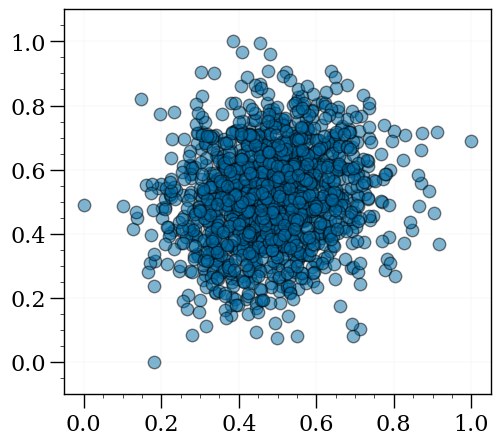

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 1
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
run(TrainingTensors, train_D, test_D, key, 'frank_1')

## Frank $\theta = 5$

In [ ]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 5
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [ ]:
run(TrainingTensors, train_D, test_D, key, 'frank_5')

## Frank $\theta = 10$

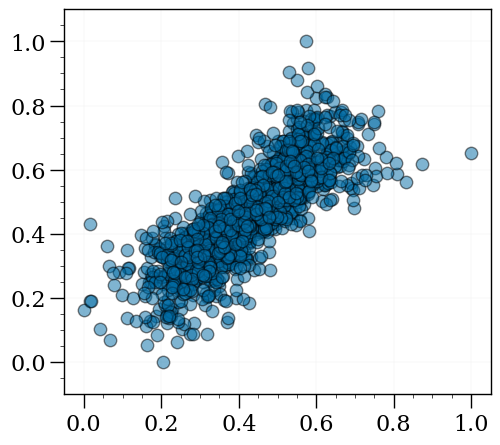

In [42]:
np.random.seed(30091985)
key = jax.random.PRNGKey(30091985)

theta = 10
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [43]:
TrainingTensors = generate_copula_net_input(
    D=train_D,
    bootstrap=False
  )

In [44]:
run(TrainingTensors, train_D, test_D, key, 'frank_10')

  0%|          | 1/10000 [01:10<196:44:03, 70.83s/it]

Iter 0. Loss [[ 0.08907324  0.27956718 18.151636  ]]


  0%|          | 11/10000 [02:06<4:26:18,  1.60s/it]

Iter 10. Loss [[0.08963064 0.26836947 7.1921477 ]]


  0%|          | 21/10000 [02:10<58:39,  2.84it/s]  

Iter 20. Loss [[0.08999173 0.26745823 6.668952  ]]


  0%|          | 31/10000 [02:12<35:49,  4.64it/s]

Iter 30. Loss [[0.08949855 0.26488137 4.9768696 ]]


  0%|          | 41/10000 [02:14<36:47,  4.51it/s]

Iter 40. Loss [[0.08818743 0.25939488 3.8340654 ]]


  1%|          | 52/10000 [02:17<38:40,  4.29it/s]

Iter 50. Loss [[0.0865595  0.25870335 3.9082968 ]]


  1%|          | 61/10000 [02:19<35:03,  4.72it/s]

Iter 60. Loss [[0.08519921 0.2573856  4.061479  ]]


  1%|          | 71/10000 [02:23<58:55,  2.81it/s]

Iter 70. Loss [[0.08425944 0.2545948  3.9242833 ]]


  1%|          | 81/10000 [02:26<41:46,  3.96it/s]

Iter 80. Loss [[0.08369024 0.25250906 3.672091  ]]


  1%|          | 91/10000 [02:28<35:24,  4.66it/s]

Iter 90. Loss [[0.08349764 0.25162682 3.448653  ]]


  1%|          | 101/10000 [02:30<35:13,  4.68it/s]

Iter 100. Loss [[0.08368605 0.24995212 3.2843268 ]]


  1%|          | 111/10000 [02:33<38:37,  4.27it/s]

Iter 110. Loss [[0.08427873 0.24813227 3.1589007 ]]


  1%|          | 121/10000 [02:36<1:19:19,  2.08it/s]

Iter 120. Loss [[0.08516094 0.244757   2.8238676 ]]


  1%|▏         | 131/10000 [02:39<40:35,  4.05it/s]

Iter 130. Loss [[0.08653662 0.24540852 3.2537122 ]]


  1%|▏         | 141/10000 [02:41<38:30,  4.27it/s]

Iter 140. Loss [[0.08820999 0.24514803 3.9625082 ]]


  2%|▏         | 151/10000 [02:44<54:05,  3.03it/s]

Iter 150. Loss [[0.08945416 0.24336663 4.7105    ]]


  2%|▏         | 161/10000 [02:46<35:15,  4.65it/s]

Iter 160. Loss [[0.09003545 0.24041748 4.7065    ]]


  2%|▏         | 171/10000 [02:49<49:56,  3.28it/s]

Iter 170. Loss [[0.09026478 0.23995946 5.102468  ]]


  2%|▏         | 181/10000 [02:53<1:06:21,  2.47it/s]

Iter 180. Loss [[0.090228   0.23850068 4.9424076 ]]


  2%|▏         | 191/10000 [02:55<35:37,  4.59it/s]

Iter 190. Loss [[0.090432   0.23595366 4.3000984 ]]


  2%|▏         | 201/10000 [02:57<37:01,  4.41it/s]

Iter 200. Loss [[0.09102695 0.22873035 3.7108893 ]]


  2%|▏         | 211/10000 [03:00<48:03,  3.39it/s]

Iter 210. Loss [[0.09234583 0.22386712 3.2435253 ]]


  2%|▏         | 221/10000 [03:02<35:20,  4.61it/s]

Iter 220. Loss [[0.09454914 0.22228393 3.2399135 ]]


  2%|▏         | 231/10000 [03:05<1:00:08,  2.71it/s]

Iter 230. Loss [[0.09682603 0.21887931 3.0614452 ]]


  2%|▏         | 241/10000 [03:08<45:57,  3.54it/s]

Iter 240. Loss [[0.0993299  0.21528979 2.792183  ]]


  3%|▎         | 251/10000 [03:11<35:19,  4.60it/s]

Iter 250. Loss [[0.10244673 0.20780507 2.4950645 ]]


  3%|▎         | 261/10000 [03:13<37:20,  4.35it/s]

Iter 260. Loss [[0.10661139 0.20425293 2.339313  ]]


  3%|▎         | 271/10000 [03:16<41:05,  3.95it/s]

Iter 270. Loss [[0.11098126 0.19718282 2.3355663 ]]


  3%|▎         | 281/10000 [03:18<54:38,  2.96it/s]

Iter 280. Loss [[0.11553851 0.18939877 2.3489575 ]]


  3%|▎         | 291/10000 [03:22<40:54,  3.95it/s]

Iter 290. Loss [[0.12102835 0.17781681 2.115771  ]]


  3%|▎         | 301/10000 [03:24<38:54,  4.16it/s]

Iter 300. Loss [[0.13080245 0.17147726 2.1723266 ]]


  3%|▎         | 311/10000 [03:26<34:23,  4.69it/s]

Iter 310. Loss [[0.14124565 0.1572324  1.7652994 ]]


  3%|▎         | 321/10000 [03:29<35:24,  4.56it/s]

Iter 320. Loss [[0.15761134 0.14209846 1.306072  ]]


  3%|▎         | 331/10000 [03:32<48:52,  3.30it/s]

Iter 330. Loss [[0.18298322 0.11949205 1.2757224 ]]


  3%|▎         | 341/10000 [03:36<1:16:42,  2.10it/s]

Iter 340. Loss [[0.20825122 0.09752093 0.87272215]]


  4%|▎         | 351/10000 [03:38<35:39,  4.51it/s]

Iter 350. Loss [[0.24920484 0.08198492 0.4309553 ]]


  4%|▎         | 361/10000 [03:40<37:28,  4.29it/s]

Iter 360. Loss [[0.28239235 0.07427616 0.35701513]]


  4%|▎         | 371/10000 [03:43<47:44,  3.36it/s]

Iter 370. Loss [[0.27745342 0.06590201 0.4516926 ]]


  4%|▍         | 381/10000 [03:45<34:47,  4.61it/s]

Iter 380. Loss [[0.27932155 0.06304903 0.4710232 ]]


  4%|▍         | 391/10000 [03:49<58:54,  2.72it/s]

Iter 390. Loss [[0.28421706 0.06863593 0.46124548]]


  4%|▍         | 401/10000 [03:52<48:44,  3.28it/s]

Iter 400. Loss [[0.2806087  0.06465747 0.47792664]]


  4%|▍         | 411/10000 [03:54<34:23,  4.65it/s]

Iter 410. Loss [[0.28172043 0.06642368 0.47053775]]


  4%|▍         | 421/10000 [03:56<35:43,  4.47it/s]

Iter 420. Loss [[0.28244096 0.06685905 0.4739187 ]]


  4%|▍         | 431/10000 [03:59<43:06,  3.70it/s]

Iter 430. Loss [[0.28159034 0.06585356 0.47572842]]


  4%|▍         | 441/10000 [04:01<52:15,  3.05it/s]

Iter 440. Loss [[0.282076   0.06636275 0.46944588]]


  5%|▍         | 451/10000 [04:05<41:43,  3.81it/s]

Iter 450. Loss [[0.28178838 0.06570511 0.46628052]]


  5%|▍         | 461/10000 [04:07<39:18,  4.05it/s]

Iter 460. Loss [[0.281656   0.06532904 0.46442813]]


  5%|▍         | 471/10000 [04:09<33:19,  4.77it/s]

Iter 470. Loss [[0.28164852 0.06536018 0.46425924]]


  5%|▍         | 481/10000 [04:12<34:40,  4.57it/s]

Iter 480. Loss [[0.28156167 0.06538747 0.46616456]]


  5%|▍         | 491/10000 [04:14<47:05,  3.37it/s]

Iter 490. Loss [[0.28169775 0.0657228  0.46138105]]


  5%|▌         | 501/10000 [04:18<56:54,  2.78it/s]

Iter 500. Loss [[0.2816321  0.06568204 0.46044242]]


  5%|▌         | 511/10000 [04:21<36:03,  4.39it/s]

Iter 510. Loss [[0.28159416 0.06567217 0.45953915]]


  5%|▌         | 521/10000 [04:23<38:17,  4.13it/s]

Iter 520. Loss [[0.28156015 0.06560953 0.46082336]]


  5%|▌         | 531/10000 [04:25<33:39,  4.69it/s]

Iter 530. Loss [[0.28153962 0.06567859 0.4611506 ]]


  5%|▌         | 541/10000 [04:28<34:33,  4.56it/s]

Iter 540. Loss [[0.281538   0.06577229 0.45994443]]


  6%|▌         | 551/10000 [04:32<59:52,  2.63it/s]  

Iter 550. Loss [[0.28152612 0.06584109 0.45913485]]


  6%|▌         | 561/10000 [04:35<54:37,  2.88it/s]

Iter 560. Loss [[0.28153542 0.06588449 0.46007144]]


  6%|▌         | 571/10000 [04:37<34:02,  4.62it/s]

Iter 570. Loss [[0.28150067 0.06592005 0.46060067]]


  6%|▌         | 581/10000 [04:39<36:46,  4.27it/s]

Iter 580. Loss [[0.2816122  0.06612857 0.45768684]]


  6%|▌         | 591/10000 [04:42<45:09,  3.47it/s]

Iter 590. Loss [[0.28158557 0.06598451 0.45588616]]


  6%|▌         | 601/10000 [04:44<52:36,  2.98it/s]

Iter 600. Loss [[0.28158423 0.06601931 0.45543334]]


  6%|▌         | 611/10000 [04:48<40:43,  3.84it/s]

Iter 610. Loss [[0.2814816  0.06584112 0.45580143]]


  6%|▌         | 621/10000 [04:50<41:50,  3.74it/s]

Iter 620. Loss [[0.2814995  0.06596899 0.4591223 ]]


  6%|▋         | 632/10000 [04:53<31:40,  4.93it/s]

Iter 630. Loss [[0.28142193 0.06604307 0.46653172]]


  6%|▋         | 641/10000 [04:55<33:57,  4.59it/s]

Iter 640. Loss [[0.28167656 0.06638025 0.46522787]]


  7%|▋         | 651/10000 [04:57<41:04,  3.79it/s]

Iter 650. Loss [[0.28153306 0.06613699 0.46586207]]


  7%|▋         | 661/10000 [05:01<54:37,  2.85it/s]

Iter 660. Loss [[0.2814566  0.06625511 0.46674532]]


  7%|▋         | 671/10000 [05:03<34:41,  4.48it/s]

Iter 670. Loss [[0.28147963 0.06616268 0.47346222]]


  7%|▋         | 681/10000 [05:06<39:15,  3.96it/s]

Iter 680. Loss [[0.28156254 0.06617384 0.4769313 ]]


  7%|▋         | 691/10000 [05:08<33:49,  4.59it/s]

Iter 690. Loss [[0.28161764 0.06631219 0.47917202]]


  7%|▋         | 701/10000 [05:11<32:57,  4.70it/s]

Iter 700. Loss [[0.28156933 0.06628323 0.48275894]]


  7%|▋         | 711/10000 [05:14<57:53,  2.67it/s]

Iter 710. Loss [[0.28163368 0.06646927 0.4832069 ]]


  7%|▋         | 721/10000 [05:17<37:25,  4.13it/s]

Iter 720. Loss [[0.28165126 0.06642828 0.48683277]]


  7%|▋         | 731/10000 [05:19<34:29,  4.48it/s]

Iter 730. Loss [[0.28167865 0.06646707 0.48767278]]


  7%|▋         | 741/10000 [05:22<36:59,  4.17it/s]

Iter 740. Loss [[0.28169945 0.06638383 0.4924106 ]]


  8%|▊         | 751/10000 [05:24<51:07,  3.01it/s]

Iter 750. Loss [[0.28176945 0.06655478 0.49090958]]


  8%|▊         | 761/10000 [05:27<48:40,  3.16it/s]

Iter 760. Loss [[0.2817136  0.06639583 0.49421328]]


  8%|▊         | 771/10000 [05:31<47:32,  3.24it/s]

Iter 770. Loss [[0.28186008 0.06663705 0.49441263]]


  8%|▊         | 781/10000 [05:33<50:54,  3.02it/s]

Iter 780. Loss [[0.2818003  0.06668529 0.49468786]]


  8%|▊         | 791/10000 [05:35<33:48,  4.54it/s]

Iter 790. Loss [[0.28182518 0.06663461 0.49627033]]


  8%|▊         | 801/10000 [05:38<34:37,  4.43it/s]

Iter 800. Loss [[0.28184524 0.06668913 0.4958554 ]]


  8%|▊         | 811/10000 [05:40<46:05,  3.32it/s]

Iter 810. Loss [[0.28183812 0.06671315 0.49692455]]


  8%|▊         | 821/10000 [05:44<55:21,  2.76it/s]

Iter 820. Loss [[0.281883   0.06681253 0.4964474 ]]


  8%|▊         | 831/10000 [05:47<35:06,  4.35it/s]

Iter 830. Loss [[0.2818225  0.06676254 0.49666578]]


  8%|▊         | 841/10000 [05:49<41:25,  3.68it/s]

Iter 840. Loss [[0.28188795 0.06687244 0.49597284]]


  9%|▊         | 851/10000 [05:51<32:50,  4.64it/s]

Iter 850. Loss [[0.28184006 0.06682447 0.4960873 ]]


  9%|▊         | 861/10000 [05:54<34:33,  4.41it/s]

Iter 860. Loss [[0.28184748 0.06685136 0.49575675]]


  9%|▊         | 871/10000 [05:57<1:02:21,  2.44it/s]

Iter 870. Loss [[0.28185982 0.0668436  0.49463257]]


  9%|▉         | 881/10000 [06:00<36:41,  4.14it/s]

Iter 880. Loss [[0.28185117 0.06682703 0.49364454]]


  9%|▉         | 892/10000 [06:03<33:24,  4.54it/s]

Iter 890. Loss [[0.281786   0.06671465 0.49459374]]


  9%|▉         | 901/10000 [06:05<38:23,  3.95it/s]

Iter 900. Loss [[0.2818823  0.06682049 0.4947172 ]]


  9%|▉         | 911/10000 [06:07<31:49,  4.76it/s]

Iter 910. Loss [[0.28185028 0.06677812 0.49379417]]


  9%|▉         | 921/10000 [06:10<48:06,  3.15it/s]

Iter 920. Loss [[0.281753   0.06669409 0.4951924 ]]


  9%|▉         | 931/10000 [06:14<49:17,  3.07it/s]

Iter 930. Loss [[0.28193107 0.06692588 0.49387434]]


  9%|▉         | 941/10000 [06:16<32:26,  4.65it/s]

Iter 940. Loss [[0.28179535 0.06674061 0.4948567 ]]


 10%|▉         | 951/10000 [06:18<32:43,  4.61it/s]

Iter 950. Loss [[0.28184578 0.06681993 0.49423015]]


 10%|▉         | 961/10000 [06:21<35:51,  4.20it/s]

Iter 960. Loss [[0.2818614  0.06691103 0.49315482]]


 10%|▉         | 971/10000 [06:23<49:48,  3.02it/s]

Iter 970. Loss [[0.2818304  0.0668137  0.49288517]]


 10%|▉         | 981/10000 [06:27<53:00,  2.84it/s]

Iter 980. Loss [[0.28173965 0.06669121 0.4947371 ]]


 10%|▉         | 991/10000 [06:30<36:27,  4.12it/s]

Iter 990. Loss [[0.28194922 0.06694586 0.49465486]]


 10%|█         | 1002/10000 [06:32<43:45,  3.43it/s]

Iter 1000. Loss [[0.28180206 0.066751   0.49605134]]


 10%|█         | 1011/10000 [06:34<32:18,  4.64it/s]

Iter 1010. Loss [[0.28190663 0.06687866 0.49384636]]


 10%|█         | 1021/10000 [06:37<34:58,  4.28it/s]

Iter 1020. Loss [[0.28189728 0.06687786 0.49444795]]


 10%|█         | 1031/10000 [06:40<1:07:07,  2.23it/s]

Iter 1030. Loss [[0.28189227 0.06683452 0.49320075]]


 10%|█         | 1041/10000 [06:43<36:14,  4.12it/s]

Iter 1040. Loss [[0.28182137 0.06666858 0.49609992]]


 11%|█         | 1052/10000 [06:46<32:40,  4.57it/s]

Iter 1050. Loss [[0.28197706 0.06689253 0.49483162]]


 11%|█         | 1062/10000 [06:48<39:54,  3.73it/s]

Iter 1060. Loss [[0.2818666  0.06683199 0.49326608]]


 11%|█         | 1071/10000 [06:50<32:28,  4.58it/s]

Iter 1070. Loss [[0.28188106 0.06680704 0.49409652]]


 11%|█         | 1081/10000 [06:53<45:50,  3.24it/s]

Iter 1080. Loss [[0.2819033  0.06685897 0.4930896 ]]


 11%|█         | 1091/10000 [06:57<53:37,  2.77it/s]  

Iter 1090. Loss [[0.2818819  0.06685447 0.49342415]]


 11%|█         | 1101/10000 [06:59<32:24,  4.58it/s]

Iter 1100. Loss [[0.28191364 0.06685214 0.49419147]]


 11%|█         | 1112/10000 [07:02<31:59,  4.63it/s]

Iter 1110. Loss [[0.2818704  0.06680173 0.49473375]]


 11%|█         | 1121/10000 [07:04<37:09,  3.98it/s]

Iter 1120. Loss [[0.281904   0.06691059 0.49223047]]


 11%|█▏        | 1131/10000 [07:06<31:26,  4.70it/s]

Iter 1130. Loss [[0.28184924 0.06684976 0.49196082]]


 11%|█▏        | 1141/10000 [07:10<53:34,  2.76it/s]

Iter 1140. Loss [[0.2818339  0.06683579 0.49301252]]


 12%|█▏        | 1151/10000 [07:13<38:52,  3.79it/s]

Iter 1150. Loss [[0.2819265  0.06699663 0.49244726]]


 12%|█▏        | 1161/10000 [07:15<31:11,  4.72it/s]

Iter 1160. Loss [[0.2818151  0.06685931 0.49312285]]


 12%|█▏        | 1171/10000 [07:17<31:50,  4.62it/s]

Iter 1170. Loss [[0.28186798 0.06686384 0.49284428]]


 12%|█▏        | 1181/10000 [07:20<35:18,  4.16it/s]

Iter 1180. Loss [[0.28192255 0.06703117 0.49211854]]


 12%|█▏        | 1191/10000 [07:23<1:10:23,  2.09it/s]

Iter 1190. Loss [[0.2818254  0.06687368 0.4927013 ]]


 12%|█▏        | 1201/10000 [07:26<36:59,  3.97it/s]

Iter 1200. Loss [[0.28195146 0.06708561 0.4898719 ]]


 12%|█▏        | 1211/10000 [07:29<34:55,  4.19it/s]

Iter 1210. Loss [[0.28189242 0.0670358  0.491894  ]]


 12%|█▏        | 1221/10000 [07:31<48:23,  3.02it/s]

Iter 1220. Loss [[0.281842   0.06703497 0.4913325 ]]


 12%|█▏        | 1231/10000 [07:33<30:59,  4.72it/s]

Iter 1230. Loss [[0.28192833 0.06712643 0.49101225]]


 12%|█▏        | 1241/10000 [07:36<45:20,  3.22it/s]

Iter 1240. Loss [[0.28186157 0.06690464 0.49160367]]


 13%|█▎        | 1251/10000 [07:40<1:08:16,  2.14it/s]

Iter 1250. Loss [[0.28184712 0.06688139 0.49268663]]


 13%|█▎        | 1261/10000 [07:42<31:52,  4.57it/s]

Iter 1260. Loss [[0.28190783 0.06703257 0.49123022]]


 13%|█▎        | 1271/10000 [07:45<33:00,  4.41it/s]

Iter 1270. Loss [[0.2818285  0.06685227 0.49118686]]


 13%|█▎        | 1281/10000 [07:47<42:54,  3.39it/s]

Iter 1280. Loss [[0.28188717 0.06693354 0.49006167]]


 13%|█▎        | 1291/10000 [07:49<31:39,  4.58it/s]

Iter 1290. Loss [[0.281852   0.06687317 0.49071357]]


 13%|█▎        | 1301/10000 [07:53<51:59,  2.79it/s]

Iter 1300. Loss [[0.28187618 0.06700405 0.48945674]]


 13%|█▎        | 1312/10000 [07:56<37:05,  3.90it/s]

Iter 1310. Loss [[0.28184125 0.06692039 0.49095052]]


 13%|█▎        | 1321/10000 [07:58<30:26,  4.75it/s]

Iter 1320. Loss [[0.28186443 0.06691521 0.4879314 ]]


 13%|█▎        | 1331/10000 [08:01<32:34,  4.43it/s]

Iter 1330. Loss [[0.2818576  0.06685674 0.48791337]]


 13%|█▎        | 1341/10000 [08:03<36:05,  4.00it/s]

Iter 1340. Loss [[0.28185338 0.06690765 0.4881052 ]]


 14%|█▎        | 1351/10000 [08:06<46:22,  3.11it/s]

Iter 1350. Loss [[0.28183538 0.06688798 0.4886048 ]]


 14%|█▎        | 1361/10000 [08:09<37:45,  3.81it/s]

Iter 1360. Loss [[0.2818736  0.06698949 0.48833793]]


 14%|█▎        | 1371/10000 [08:12<34:00,  4.23it/s]

Iter 1370. Loss [[0.28185177 0.06708253 0.4865048 ]]


 14%|█▍        | 1381/10000 [08:14<30:16,  4.75it/s]

Iter 1380. Loss [[0.28182548 0.06704022 0.48857886]]


 14%|█▍        | 1392/10000 [08:16<30:04,  4.77it/s]

Iter 1390. Loss [[0.2818335 0.0670065 0.487739 ]]


 14%|█▍        | 1401/10000 [08:19<37:20,  3.84it/s]

Iter 1400. Loss [[0.28179944 0.06719644 0.49058944]]


 14%|█▍        | 1411/10000 [08:23<1:12:05,  1.99it/s]

Iter 1410. Loss [[0.28185135 0.06709962 0.48890933]]


 14%|█▍        | 1421/10000 [08:25<30:57,  4.62it/s]

Iter 1420. Loss [[0.28181958 0.06721891 0.49338797]]


 14%|█▍        | 1431/10000 [08:27<33:07,  4.31it/s]

Iter 1430. Loss [[0.28181982 0.06695534 0.49110138]]


 14%|█▍        | 1441/10000 [08:30<47:07,  3.03it/s]

Iter 1440. Loss [[0.28192    0.06708384 0.49031916]]


 15%|█▍        | 1451/10000 [08:32<30:34,  4.66it/s]

Iter 1450. Loss [[0.28188518 0.06713545 0.48962557]]


 15%|█▍        | 1461/10000 [08:36<54:05,  2.63it/s]

Iter 1460. Loss [[0.28190067 0.06718782 0.49111718]]


 15%|█▍        | 1471/10000 [08:39<46:00,  3.09it/s]

Iter 1470. Loss [[0.28190002 0.06716659 0.49047494]]


 15%|█▍        | 1481/10000 [08:41<30:16,  4.69it/s]

Iter 1480. Loss [[0.2818333  0.06715705 0.49106917]]


 15%|█▍        | 1491/10000 [08:43<32:02,  4.43it/s]

Iter 1490. Loss [[0.28181893 0.06750476 0.48923892]]


 15%|█▌        | 1501/10000 [08:46<39:04,  3.62it/s]

Iter 1500. Loss [[0.2818906  0.06713504 0.49095437]]


 15%|█▌        | 1511/10000 [08:49<44:48,  3.16it/s]

Iter 1510. Loss [[0.28191257 0.06732481 0.4893583 ]]


 15%|█▌        | 1521/10000 [08:52<40:34,  3.48it/s]

Iter 1520. Loss [[0.2818928  0.06731552 0.4896866 ]]


 15%|█▌        | 1531/10000 [08:55<35:35,  3.97it/s]

Iter 1530. Loss [[0.28177753 0.06742202 0.49262303]]


 15%|█▌        | 1541/10000 [08:57<31:17,  4.51it/s]

Iter 1540. Loss [[0.28179953 0.06730671 0.4903715 ]]


 16%|█▌        | 1551/10000 [08:59<30:47,  4.57it/s]

Iter 1550. Loss [[0.28193906 0.06745489 0.48952392]]


 16%|█▌        | 1561/10000 [09:02<34:46,  4.04it/s]

Iter 1560. Loss [[0.2818664  0.06720639 0.4911569 ]]


 16%|█▌        | 1571/10000 [09:05<50:52,  2.76it/s]

Iter 1570. Loss [[0.28185314 0.06728194 0.49066567]]


 16%|█▌        | 1581/10000 [09:08<31:03,  4.52it/s]

Iter 1580. Loss [[0.28184888 0.06731766 0.4904273 ]]


 16%|█▌        | 1592/10000 [09:11<32:24,  4.32it/s]

Iter 1590. Loss [[0.28185853 0.0672585  0.49281812]]


 16%|█▌        | 1601/10000 [09:13<30:00,  4.66it/s]

Iter 1600. Loss [[0.2817857  0.06718025 0.49307942]]


 16%|█▌        | 1611/10000 [09:15<30:01,  4.66it/s]

Iter 1610. Loss [[0.2818773  0.06742407 0.49186495]]


 16%|█▌        | 1621/10000 [09:19<51:51,  2.69it/s]

Iter 1620. Loss [[0.28186303 0.06748675 0.48830453]]


 16%|█▋        | 1631/10000 [09:22<50:44,  2.75it/s]

Iter 1630. Loss [[0.28180656 0.06741992 0.48882976]]


 16%|█▋        | 1641/10000 [09:24<30:22,  4.59it/s]

Iter 1640. Loss [[0.28187642 0.06721297 0.4921188 ]]


 17%|█▋        | 1651/10000 [09:27<32:27,  4.29it/s]

Iter 1650. Loss [[0.28187096 0.06735176 0.4905074 ]]


 17%|█▋        | 1661/10000 [09:29<45:38,  3.04it/s]

Iter 1660. Loss [[0.28183684 0.06746456 0.4901407 ]]


 17%|█▋        | 1671/10000 [09:32<43:29,  3.19it/s]

Iter 1670. Loss [[0.28186086 0.06740586 0.4918258 ]]


 17%|█▋        | 1681/10000 [09:35<42:25,  3.27it/s]

Iter 1680. Loss [[0.28189915 0.06728766 0.49242127]]


 17%|█▋        | 1691/10000 [09:38<45:54,  3.02it/s]

Iter 1690. Loss [[0.28189614 0.0673736  0.4903115 ]]


 17%|█▋        | 1702/10000 [09:40<29:09,  4.74it/s]

Iter 1700. Loss [[0.28182313 0.06769697 0.4877531 ]]


 17%|█▋        | 1711/10000 [09:42<32:01,  4.31it/s]

Iter 1710. Loss [[0.2818425  0.06752127 0.4898986 ]]


 17%|█▋        | 1721/10000 [09:45<41:02,  3.36it/s]

Iter 1720. Loss [[0.2819036  0.06766079 0.4892016 ]]


 17%|█▋        | 1731/10000 [09:49<50:05,  2.75it/s]

Iter 1730. Loss [[0.2819303  0.06748834 0.48993513]]


 17%|█▋        | 1742/10000 [09:52<30:55,  4.45it/s]

Iter 1740. Loss [[0.28190017 0.06748275 0.49045613]]


 18%|█▊        | 1751/10000 [09:54<40:19,  3.41it/s]

Iter 1750. Loss [[0.28190264 0.06765692 0.48860285]]


 18%|█▊        | 1761/10000 [09:56<29:43,  4.62it/s]

Iter 1760. Loss [[0.28192663 0.06749433 0.49023795]]


 18%|█▊        | 1771/10000 [09:58<30:16,  4.53it/s]

Iter 1770. Loss [[0.2819016  0.06783444 0.48888895]]


 18%|█▊        | 1781/10000 [10:02<55:41,  2.46it/s]

Iter 1780. Loss [[0.28194317 0.06763603 0.48939127]]


 18%|█▊        | 1791/10000 [10:05<32:57,  4.15it/s]

Iter 1790. Loss [[0.28197256 0.0675099  0.48972172]]


 18%|█▊        | 1801/10000 [10:07<30:47,  4.44it/s]

Iter 1800. Loss [[0.28191546 0.0674919  0.4906844 ]]


 18%|█▊        | 1811/10000 [10:10<36:04,  3.78it/s]

Iter 1810. Loss [[0.2819188  0.06756192 0.48963705]]


 18%|█▊        | 1822/10000 [10:12<28:21,  4.81it/s]

Iter 1820. Loss [[0.28197095 0.06751174 0.49003312]]


 18%|█▊        | 1831/10000 [10:15<39:55,  3.41it/s]

Iter 1830. Loss [[0.28202394 0.06749492 0.4925418 ]]


 18%|█▊        | 1841/10000 [10:18<47:51,  2.84it/s]

Iter 1840. Loss [[0.28202683 0.06759869 0.49347368]]


 19%|█▊        | 1851/10000 [10:20<29:09,  4.66it/s]

Iter 1850. Loss [[0.28209832 0.06745572 0.49457198]]


 19%|█▊        | 1861/10000 [10:23<29:54,  4.53it/s]

Iter 1860. Loss [[0.28215703 0.06763991 0.49114978]]


 19%|█▊        | 1871/10000 [10:25<33:47,  4.01it/s]

Iter 1870. Loss [[0.28224096 0.06803393 0.48575178]]


 19%|█▉        | 1881/10000 [10:28<28:32,  4.74it/s]

Iter 1880. Loss [[0.28242496 0.06896748 0.46654782]]


 19%|█▉        | 1891/10000 [10:31<48:21,  2.79it/s]

Iter 1890. Loss [[0.28285354 0.07026706 0.41865754]]


 19%|█▉        | 1901/10000 [10:34<34:28,  3.92it/s]

Iter 1900. Loss [[0.28356194 0.07178836 0.3295733 ]]


 19%|█▉        | 1911/10000 [10:36<29:25,  4.58it/s]

Iter 1910. Loss [[0.2800734  0.07436663 0.32755846]]


 19%|█▉        | 1921/10000 [10:39<29:24,  4.58it/s]

Iter 1920. Loss [[ 0.28244728  0.06698082 -0.18393707]]


 19%|█▉        | 1931/10000 [10:41<32:27,  4.14it/s]

Iter 1930. Loss [[ 0.28308374  0.08058259 -0.35694516]]


 19%|█▉        | 1941/10000 [10:45<1:04:17,  2.09it/s]

Iter 1940. Loss [[0.27132997 0.08693275 0.67954516]]


 20%|█▉        | 1951/10000 [10:48<34:39,  3.87it/s]

Iter 1950. Loss [[0.26800227 0.06168605 0.8685042 ]]


 20%|█▉        | 1961/10000 [10:50<30:51,  4.34it/s]

Iter 1960. Loss [[0.28430644 0.07034051 0.50938433]]


 20%|█▉        | 1971/10000 [10:53<43:56,  3.05it/s]

Iter 1970. Loss [[ 0.27351156  0.08344857 -0.34657788]]


 20%|█▉        | 1982/10000 [10:55<28:15,  4.73it/s]

Iter 1980. Loss [[ 0.28648686  0.1095143  -0.71284926]]


 20%|█▉        | 1991/10000 [10:57<38:25,  3.47it/s]

Iter 1990. Loss [[ 0.2809171   0.08817919 -0.5845397 ]]


 20%|██        | 2002/10000 [11:02<49:03,  2.72it/s]

Iter 2000. Loss [[0.28181103 0.06598718 0.46866456]]


 20%|██        | 2011/10000 [11:04<29:49,  4.47it/s]

Iter 2010. Loss [[0.28082126 0.09794612 0.20463689]]


 20%|██        | 2021/10000 [11:06<30:41,  4.33it/s]

Iter 2020. Loss [[ 0.27426213  0.08882722 -0.4943587 ]]


 20%|██        | 2031/10000 [11:09<35:50,  3.70it/s]

Iter 2030. Loss [[ 0.29193982  0.10817555 -0.8267141 ]]


 20%|██        | 2041/10000 [11:11<28:42,  4.62it/s]

Iter 2040. Loss [[ 0.2891319   0.10415146 -0.7950366 ]]


 21%|██        | 2051/10000 [11:14<48:37,  2.72it/s]

Iter 2050. Loss [[ 0.2923137   0.10709412 -0.7578146 ]]


 21%|██        | 2061/10000 [11:17<37:39,  3.51it/s]

Iter 2060. Loss [[ 0.30343017  0.09216081 -0.1866009 ]]


 21%|██        | 2071/10000 [11:20<28:26,  4.65it/s]

Iter 2070. Loss [[0.28136417 0.0482951  0.35172516]]


 21%|██        | 2081/10000 [11:22<29:40,  4.45it/s]

Iter 2080. Loss [[0.25740662 0.06213382 0.7740225 ]]


 21%|██        | 2091/10000 [11:24<35:14,  3.74it/s]

Iter 2090. Loss [[0.2742504  0.07435647 0.55679905]]


 21%|██        | 2101/10000 [11:27<43:50,  3.00it/s]

Iter 2100. Loss [[0.28561696 0.07192226 0.47202754]]


 21%|██        | 2111/10000 [11:31<35:24,  3.71it/s]

Iter 2110. Loss [[0.28003842 0.06221243 0.5369682 ]]


 21%|██        | 2121/10000 [11:33<34:05,  3.85it/s]

Iter 2120. Loss [[0.28185427 0.06632495 0.5111359 ]]


 21%|██▏       | 2131/10000 [11:36<28:26,  4.61it/s]

Iter 2130. Loss [[0.2829461  0.06822399 0.4991764 ]]


 21%|██▏       | 2141/10000 [11:38<28:56,  4.53it/s]

Iter 2140. Loss [[0.2818522  0.06620923 0.5043352 ]]


 22%|██▏       | 2151/10000 [11:41<40:54,  3.20it/s]

Iter 2150. Loss [[0.28228778 0.06643578 0.49582478]]


 22%|██▏       | 2161/10000 [11:44<47:25,  2.76it/s]

Iter 2160. Loss [[0.28231412 0.06647411 0.49369755]]


 22%|██▏       | 2171/10000 [11:47<29:21,  4.45it/s]

Iter 2170. Loss [[0.28212127 0.06620009 0.4943311 ]]


 22%|██▏       | 2181/10000 [11:49<31:18,  4.16it/s]

Iter 2180. Loss [[0.28219604 0.06633992 0.4895943 ]]


 22%|██▏       | 2191/10000 [11:52<27:41,  4.70it/s]

Iter 2190. Loss [[0.28214294 0.06622816 0.48886   ]]


 22%|██▏       | 2201/10000 [11:54<28:54,  4.50it/s]

Iter 2200. Loss [[0.2821277  0.06608545 0.4890733 ]]


 22%|██▏       | 2211/10000 [11:58<48:25,  2.68it/s]

Iter 2210. Loss [[0.28213024 0.0660983  0.48708293]]


 22%|██▏       | 2221/10000 [12:01<45:13,  2.87it/s]

Iter 2220. Loss [[0.28208402 0.06603314 0.48659977]]


 22%|██▏       | 2231/10000 [12:03<28:26,  4.55it/s]

Iter 2230. Loss [[0.28207678 0.06600238 0.485982  ]]


 22%|██▏       | 2241/10000 [12:05<29:18,  4.41it/s]

Iter 2240. Loss [[0.28208607 0.06601844 0.48455542]]


 23%|██▎       | 2251/10000 [12:08<38:41,  3.34it/s]

Iter 2250. Loss [[0.28205648 0.06598108 0.48226085]]


 23%|██▎       | 2261/10000 [12:11<43:30,  2.96it/s]

Iter 2260. Loss [[0.28203872 0.06596747 0.48228642]]


 23%|██▎       | 2271/10000 [12:14<34:01,  3.79it/s]

Iter 2270. Loss [[0.2820384  0.06596841 0.4809116 ]]


 23%|██▎       | 2281/10000 [12:17<34:08,  3.77it/s]

Iter 2280. Loss [[0.28202248 0.06595978 0.47969222]]


 23%|██▎       | 2291/10000 [12:19<26:50,  4.79it/s]

Iter 2290. Loss [[0.28201684 0.06594139 0.4785563 ]]


 23%|██▎       | 2301/10000 [12:21<29:01,  4.42it/s]

Iter 2300. Loss [[0.2820049  0.06593932 0.47693065]]


 23%|██▎       | 2311/10000 [12:24<41:24,  3.09it/s]

Iter 2310. Loss [[0.28199401 0.06595962 0.47676334]]


 23%|██▎       | 2321/10000 [12:28<44:41,  2.86it/s]

Iter 2320. Loss [[0.28198138 0.06596997 0.47552934]]


 23%|██▎       | 2331/10000 [12:30<28:13,  4.53it/s]

Iter 2330. Loss [[0.28196314 0.06596356 0.47363484]]


 23%|██▎       | 2341/10000 [12:33<30:46,  4.15it/s]

Iter 2340. Loss [[0.2819443  0.06592663 0.47280297]]


 24%|██▎       | 2351/10000 [12:35<27:36,  4.62it/s]

Iter 2350. Loss [[0.28193703 0.06592796 0.47249076]]


 24%|██▎       | 2361/10000 [12:37<27:21,  4.65it/s]

Iter 2360. Loss [[0.28192943 0.06593408 0.47054607]]


 24%|██▎       | 2371/10000 [12:41<47:14,  2.69it/s]

Iter 2370. Loss [[0.281921   0.06591924 0.47022066]]


 24%|██▍       | 2381/10000 [12:44<44:58,  2.82it/s]

Iter 2380. Loss [[0.28191867 0.0659418  0.469487  ]]


 24%|██▍       | 2391/10000 [12:46<28:16,  4.49it/s]

Iter 2390. Loss [[0.28188974 0.06589775 0.46979275]]


 24%|██▍       | 2401/10000 [12:48<29:29,  4.29it/s]

Iter 2400. Loss [[0.28184897 0.06587835 0.46965754]]


 24%|██▍       | 2411/10000 [12:51<42:13,  3.00it/s]

Iter 2410. Loss [[0.28183737 0.06582963 0.46996325]]


 24%|██▍       | 2421/10000 [12:54<40:42,  3.10it/s]

Iter 2420. Loss [[0.2818673  0.06588395 0.46652344]]


 24%|██▍       | 2431/10000 [12:57<34:46,  3.63it/s]

Iter 2430. Loss [[0.28182736 0.06584068 0.46521866]]


 24%|██▍       | 2441/10000 [13:00<36:49,  3.42it/s]

Iter 2440. Loss [[0.28183255 0.06587756 0.46569735]]


 25%|██▍       | 2451/10000 [13:02<26:48,  4.69it/s]

Iter 2450. Loss [[0.28183132 0.06591769 0.46193722]]


 25%|██▍       | 2462/10000 [13:05<27:27,  4.58it/s]

Iter 2460. Loss [[0.28179315 0.0658617  0.4603415 ]]


 25%|██▍       | 2471/10000 [13:07<40:08,  3.13it/s]

Iter 2470. Loss [[0.2817775  0.06585033 0.4572957 ]]


 25%|██▍       | 2481/10000 [13:11<45:28,  2.76it/s]

Iter 2480. Loss [[0.28170413 0.06555256 0.45780185]]


 25%|██▍       | 2491/10000 [13:13<28:58,  4.32it/s]

Iter 2490. Loss [[0.281729   0.06549154 0.46129003]]


 25%|██▌       | 2501/10000 [13:16<31:58,  3.91it/s]

Iter 2500. Loss [[0.28180194 0.0656358  0.45817715]]


 25%|██▌       | 2511/10000 [13:18<27:06,  4.61it/s]

Iter 2510. Loss [[0.2817559  0.06555851 0.45698404]]


 25%|██▌       | 2521/10000 [13:20<27:11,  4.59it/s]

Iter 2520. Loss [[0.28172258 0.06546769 0.45639184]]


 25%|██▌       | 2531/10000 [13:24<49:24,  2.52it/s]

Iter 2530. Loss [[0.28173426 0.06551198 0.45257604]]


 25%|██▌       | 2541/10000 [13:27<28:24,  4.38it/s]

Iter 2540. Loss [[0.28170088 0.0655992  0.4507229 ]]


 26%|██▌       | 2551/10000 [13:29<27:10,  4.57it/s]

Iter 2550. Loss [[0.2816799  0.0655634  0.44889575]]


 26%|██▌       | 2561/10000 [13:32<30:14,  4.10it/s]

Iter 2560. Loss [[0.2816729  0.06554972 0.44700822]]


 26%|██▌       | 2571/10000 [13:34<41:39,  2.97it/s]

Iter 2570. Loss [[0.28164217 0.06550343 0.4459592 ]]


 26%|██▌       | 2581/10000 [13:37<41:32,  2.98it/s]

Iter 2580. Loss [[0.28162226 0.06546098 0.44530118]]


 26%|██▌       | 2591/10000 [13:41<33:46,  3.66it/s]

Iter 2590. Loss [[0.2816241  0.06551422 0.44455695]]


 26%|██▌       | 2601/10000 [13:43<36:51,  3.35it/s]

Iter 2600. Loss [[0.28161588 0.06558312 0.44361132]]


 26%|██▌       | 2611/10000 [13:45<26:29,  4.65it/s]

Iter 2610. Loss [[0.28159103 0.06555773 0.44354996]]


 26%|██▌       | 2621/10000 [13:48<28:42,  4.28it/s]

Iter 2620. Loss [[0.2815927  0.0656432  0.44225132]]


 26%|██▋       | 2631/10000 [13:51<45:19,  2.71it/s]

Iter 2630. Loss [[0.2815901  0.06564924 0.440489  ]]


 26%|██▋       | 2641/10000 [13:54<43:42,  2.81it/s]

Iter 2640. Loss [[0.2815627  0.06565262 0.4388585 ]]


 27%|██▋       | 2651/10000 [13:57<27:47,  4.41it/s]

Iter 2650. Loss [[0.28152937 0.06588451 0.4339654 ]]


 27%|██▋       | 2661/10000 [13:59<33:57,  3.60it/s]

Iter 2660. Loss [[0.28149116 0.06571527 0.43383387]]


 27%|██▋       | 2671/10000 [14:01<26:24,  4.63it/s]

Iter 2670. Loss [[0.2814981  0.06579403 0.43074203]]


 27%|██▋       | 2681/10000 [14:04<27:12,  4.48it/s]

Iter 2680. Loss [[0.28145787 0.06587257 0.43283772]]


 27%|██▋       | 2691/10000 [14:08<49:51,  2.44it/s]

Iter 2690. Loss [[0.28145522 0.06599897 0.42618927]]


 27%|██▋       | 2701/10000 [14:10<27:08,  4.48it/s]

Iter 2700. Loss [[0.28134334 0.0665684  0.4136735 ]]


 27%|██▋       | 2711/10000 [14:13<27:08,  4.48it/s]

Iter 2710. Loss [[0.28063878 0.06795855 0.34703252]]


 27%|██▋       | 2721/10000 [14:15<30:40,  3.95it/s]

Iter 2720. Loss [[0.28081554 0.07207687 0.14761703]]


 27%|██▋       | 2731/10000 [14:17<25:47,  4.70it/s]

Iter 2730. Loss [[ 0.28094438  0.07786344 -0.5834958 ]]


 27%|██▋       | 2741/10000 [14:21<42:48,  2.83it/s]

Iter 2740. Loss [[ 0.28161824  0.0782101  -0.57917446]]


 28%|██▊       | 2751/10000 [14:24<32:46,  3.69it/s]

Iter 2750. Loss [[ 0.28056118  0.06322421 -0.5835523 ]]


 28%|██▊       | 2761/10000 [14:26<26:07,  4.62it/s]

Iter 2760. Loss [[ 0.2829322   0.06324577 -0.5088872 ]]


 28%|██▊       | 2772/10000 [14:29<25:50,  4.66it/s]

Iter 2770. Loss [[ 0.27984503  0.07741341 -0.48229054]]


 28%|██▊       | 2781/10000 [14:31<28:25,  4.23it/s]

Iter 2780. Loss [[ 0.27959916  0.07097592 -0.20183142]]


 28%|██▊       | 2791/10000 [14:34<52:42,  2.28it/s]

Iter 2790. Loss [[ 0.2791854   0.06446607 -0.19659045]]


 28%|██▊       | 2801/10000 [14:38<37:06,  3.23it/s]

Iter 2800. Loss [[ 0.28017223  0.06599787 -0.13594496]]


 28%|██▊       | 2811/10000 [14:40<29:03,  4.12it/s]

Iter 2810. Loss [[ 0.2801078   0.06563676 -0.19970232]]


 28%|██▊       | 2821/10000 [14:43<35:56,  3.33it/s]

Iter 2820. Loss [[ 0.27913195  0.0670992  -0.18050948]]


 28%|██▊       | 2831/10000 [14:45<26:03,  4.59it/s]

Iter 2830. Loss [[ 0.27886146  0.06657282 -0.19250947]]


 28%|██▊       | 2841/10000 [14:47<28:07,  4.24it/s]

Iter 2840. Loss [[0.27950957 0.06122721 0.16958348]]


 29%|██▊       | 2851/10000 [14:51<55:01,  2.17it/s]

Iter 2850. Loss [[0.28074357 0.13696223 0.48945662]]


 29%|██▊       | 2861/10000 [14:54<26:39,  4.46it/s]

Iter 2860. Loss [[0.25123787 0.08377142 0.9789331 ]]


 29%|██▊       | 2871/10000 [14:56<26:29,  4.48it/s]

Iter 2870. Loss [[0.24029486 0.06952451 1.0023922 ]]


 29%|██▉       | 2881/10000 [14:59<32:18,  3.67it/s]

Iter 2880. Loss [[0.25149113 0.05837421 0.59683913]]


 29%|██▉       | 2891/10000 [15:01<26:20,  4.50it/s]

Iter 2890. Loss [[0.2689259  0.0641631  0.16437972]]


 29%|██▉       | 2901/10000 [15:05<44:18,  2.67it/s]

Iter 2900. Loss [[0.28245223 0.05879581 0.05659345]]


 29%|██▉       | 2911/10000 [15:08<32:30,  3.64it/s]

Iter 2910. Loss [[ 0.285619    0.06073849 -0.11471438]]


 29%|██▉       | 2921/10000 [15:10<25:14,  4.67it/s]

Iter 2920. Loss [[ 0.29161894  0.08967867 -0.06097151]]


 29%|██▉       | 2931/10000 [15:13<26:25,  4.46it/s]

Iter 2930. Loss [[ 0.30088454  0.11232878 -0.80264014]]


 29%|██▉       | 2941/10000 [15:15<28:33,  4.12it/s]

Iter 2940. Loss [[ 0.29664606  0.08530023 -0.15455988]]


 30%|██▉       | 2951/10000 [15:18<38:36,  3.04it/s]

Iter 2950. Loss [[ 0.30229563  0.09373262 -0.5111826 ]]


 30%|██▉       | 2961/10000 [15:21<30:54,  3.79it/s]

Iter 2960. Loss [[ 0.29845807  0.09892841 -0.89084   ]]


 30%|██▉       | 2971/10000 [15:24<27:07,  4.32it/s]

Iter 2970. Loss [[ 0.28882927  0.08542024 -0.8259394 ]]


 30%|██▉       | 2981/10000 [15:26<38:34,  3.03it/s]

Iter 2980. Loss [[ 0.284745    0.12211375 -0.92270017]]


 30%|██▉       | 2991/10000 [15:29<25:26,  4.59it/s]

Iter 2990. Loss [[ 0.28080162  0.11650318 -1.0920204 ]]


 30%|███       | 3001/10000 [15:31<33:58,  3.43it/s]

Iter 3000. Loss [[ 0.27719694  0.08864727 -0.99153596]]


 30%|███       | 3011/10000 [15:35<50:35,  2.30it/s]

Iter 3010. Loss [[ 0.27532396  0.10394076 -1.0964292 ]]


 30%|███       | 3021/10000 [15:37<26:00,  4.47it/s]

Iter 3020. Loss [[ 0.27616376  0.11138652 -1.1157032 ]]


 30%|███       | 3031/10000 [15:40<26:42,  4.35it/s]

Iter 3030. Loss [[ 0.27716398  0.11983307 -1.1378342 ]]


 30%|███       | 3041/10000 [15:42<31:31,  3.68it/s]

Iter 3040. Loss [[ 0.2772411   0.10630955 -1.1269332 ]]


 31%|███       | 3051/10000 [15:45<25:00,  4.63it/s]

Iter 3050. Loss [[ 0.27941415  0.09004506 -1.0874999 ]]


 31%|███       | 3061/10000 [15:48<41:52,  2.76it/s]

Iter 3060. Loss [[ 0.28307572  0.07907956 -0.9790153 ]]


 31%|███       | 3071/10000 [15:51<33:28,  3.45it/s]

Iter 3070. Loss [[ 0.2857939   0.07872713 -0.88868505]]


 31%|███       | 3081/10000 [15:53<25:05,  4.60it/s]

Iter 3080. Loss [[ 0.28884825  0.0860355  -0.77348423]]


 31%|███       | 3091/10000 [15:56<25:50,  4.46it/s]

Iter 3090. Loss [[ 0.29049557  0.08672298 -0.61180145]]


 31%|███       | 3101/10000 [15:58<29:29,  3.90it/s]

Iter 3100. Loss [[ 0.28786126  0.07309286 -0.34044313]]


 31%|███       | 3111/10000 [16:01<38:53,  2.95it/s]

Iter 3110. Loss [[ 0.28364298  0.06719106 -0.1703225 ]]


 31%|███       | 3121/10000 [16:05<28:27,  4.03it/s]

Iter 3120. Loss [[ 0.28083602  0.06740975 -0.0841229 ]]


 31%|███▏      | 3131/10000 [16:07<29:22,  3.90it/s]

Iter 3130. Loss [[0.2795959  0.06559663 0.07596894]]


 31%|███▏      | 3141/10000 [16:09<25:20,  4.51it/s]

Iter 3140. Loss [[0.28041145 0.06406303 0.00698708]]


 32%|███▏      | 3151/10000 [16:12<25:22,  4.50it/s]

Iter 3150. Loss [[ 0.282459    0.07098348 -0.17520116]]


 32%|███▏      | 3161/10000 [16:15<39:44,  2.87it/s]

Iter 3160. Loss [[0.28300044 0.06452713 0.11293017]]


 32%|███▏      | 3171/10000 [16:18<36:13,  3.14it/s]

Iter 3170. Loss [[0.28189605 0.06398344 0.24587062]]


 32%|███▏      | 3181/10000 [16:21<25:05,  4.53it/s]

Iter 3180. Loss [[0.28097543 0.06600063 0.14202969]]


 32%|███▏      | 3191/10000 [16:23<27:05,  4.19it/s]

Iter 3190. Loss [[0.28208712 0.06105964 0.32805228]]


 32%|███▏      | 3201/10000 [16:26<23:58,  4.73it/s]

Iter 3200. Loss [[0.28125647 0.06155369 0.49592707]]


 32%|███▏      | 3211/10000 [16:28<24:44,  4.57it/s]

Iter 3210. Loss [[0.280605   0.06534686 0.4952369 ]]


 32%|███▏      | 3221/10000 [16:32<43:00,  2.63it/s]

Iter 3220. Loss [[0.281483   0.06677463 0.5093079 ]]


 32%|███▏      | 3231/10000 [16:35<39:40,  2.84it/s]

Iter 3230. Loss [[0.2820464  0.06628732 0.50630987]]


 32%|███▏      | 3242/10000 [16:37<24:07,  4.67it/s]

Iter 3240. Loss [[0.28199786 0.06576598 0.5215162 ]]


 33%|███▎      | 3251/10000 [16:39<25:42,  4.37it/s]

Iter 3250. Loss [[0.28188673 0.06582257 0.5183605 ]]


 33%|███▎      | 3261/10000 [16:42<37:20,  3.01it/s]

Iter 3260. Loss [[0.28185144 0.06607473 0.5199428 ]]


 33%|███▎      | 3271/10000 [16:45<40:17,  2.78it/s]

Iter 3270. Loss [[0.28187397 0.06611249 0.52043223]]


 33%|███▎      | 3281/10000 [16:48<27:59,  4.00it/s]

Iter 3280. Loss [[0.2818901  0.06599262 0.5175672 ]]


 33%|███▎      | 3291/10000 [16:51<33:45,  3.31it/s]

Iter 3290. Loss [[0.28187373 0.06587619 0.51629263]]


 33%|███▎      | 3301/10000 [16:53<24:12,  4.61it/s]

Iter 3300. Loss [[0.2818432  0.0658498  0.51588535]]


 33%|███▎      | 3311/10000 [16:56<25:01,  4.45it/s]

Iter 3310. Loss [[0.2818372  0.06587841 0.51622313]]


 33%|███▎      | 3321/10000 [16:59<42:39,  2.61it/s]

Iter 3320. Loss [[0.28183928 0.06586907 0.5147081 ]]


 33%|███▎      | 3331/10000 [17:02<31:35,  3.52it/s]

Iter 3330. Loss [[0.28183597 0.06587077 0.51545453]]


 33%|███▎      | 3341/10000 [17:04<25:19,  4.38it/s]

Iter 3340. Loss [[0.28183553 0.06589705 0.516684  ]]


 34%|███▎      | 3351/10000 [17:07<27:54,  3.97it/s]

Iter 3350. Loss [[0.28183788 0.06589992 0.5163699 ]]


 34%|███▎      | 3361/10000 [17:09<24:06,  4.59it/s]

Iter 3360. Loss [[0.28183746 0.06590898 0.5168978 ]]


 34%|███▎      | 3371/10000 [17:12<29:31,  3.74it/s]

Iter 3370. Loss [[0.28184104 0.06586577 0.5126173 ]]


 34%|███▍      | 3381/10000 [17:16<44:54,  2.46it/s]

Iter 3380. Loss [[0.28182486 0.06584372 0.5135459 ]]


 34%|███▍      | 3391/10000 [17:18<24:16,  4.54it/s]

Iter 3390. Loss [[0.281821   0.06587467 0.5165548 ]]


 34%|███▍      | 3401/10000 [17:20<24:05,  4.56it/s]

Iter 3400. Loss [[0.28184316 0.06592402 0.5167053 ]]


 34%|███▍      | 3411/10000 [17:23<27:43,  3.96it/s]

Iter 3410. Loss [[0.28184918 0.06593267 0.5161801 ]]


 34%|███▍      | 3421/10000 [17:25<23:40,  4.63it/s]

Iter 3420. Loss [[0.281837   0.06589552 0.5147747 ]]


 34%|███▍      | 3431/10000 [17:29<39:39,  2.76it/s]

Iter 3430. Loss [[0.2818314  0.06586424 0.5151529 ]]


 34%|███▍      | 3441/10000 [17:32<28:37,  3.82it/s]

Iter 3440. Loss [[0.2818276  0.06584037 0.51477474]]


 35%|███▍      | 3451/10000 [17:35<36:27,  2.99it/s]

Iter 3450. Loss [[0.28182885 0.06584287 0.51448154]]


 35%|███▍      | 3461/10000 [17:37<23:36,  4.62it/s]

Iter 3460. Loss [[0.28180283 0.06580079 0.51553863]]


 35%|███▍      | 3471/10000 [17:39<25:45,  4.22it/s]

Iter 3470. Loss [[0.28182548 0.06581456 0.5150369 ]]


 35%|███▍      | 3481/10000 [17:43<53:31,  2.03it/s]

Iter 3480. Loss [[0.28183588 0.06582624 0.51382774]]


 35%|███▍      | 3491/10000 [17:46<27:26,  3.95it/s]

Iter 3490. Loss [[0.2818147  0.06581261 0.5139602 ]]


 35%|███▌      | 3501/10000 [17:48<24:41,  4.39it/s]

Iter 3500. Loss [[0.28182602 0.06581452 0.51519334]]


 35%|███▌      | 3511/10000 [17:51<32:16,  3.35it/s]

Iter 3510. Loss [[0.2818578  0.0659209  0.51951253]]


 35%|███▌      | 3521/10000 [17:53<23:37,  4.57it/s]

Iter 3520. Loss [[0.28187394 0.06596334 0.5202904 ]]


 35%|███▌      | 3531/10000 [17:56<33:51,  3.18it/s]

Iter 3530. Loss [[0.2818818  0.06598596 0.5198313 ]]


 35%|███▌      | 3541/10000 [18:00<38:52,  2.77it/s]

Iter 3540. Loss [[0.2818894  0.06597411 0.51987165]]


 36%|███▌      | 3551/10000 [18:02<23:29,  4.58it/s]

Iter 3550. Loss [[0.28189158 0.06595967 0.51823056]]


 36%|███▌      | 3561/10000 [18:04<24:26,  4.39it/s]

Iter 3560. Loss [[0.2818832  0.0659455  0.51704204]]


 36%|███▌      | 3571/10000 [18:07<28:50,  3.72it/s]

Iter 3570. Loss [[0.28187743 0.065919   0.5176889 ]]


 36%|███▌      | 3581/10000 [18:09<23:26,  4.56it/s]

Iter 3580. Loss [[0.28188202 0.06591548 0.5179042 ]]


 36%|███▌      | 3591/10000 [18:13<39:08,  2.73it/s]

Iter 3590. Loss [[0.28188962 0.06593555 0.5183048 ]]


 36%|███▌      | 3601/10000 [18:16<28:10,  3.78it/s]

Iter 3600. Loss [[0.2818976  0.06595082 0.5178642 ]]


 36%|███▌      | 3611/10000 [18:18<23:08,  4.60it/s]

Iter 3610. Loss [[0.28189734 0.06597003 0.51840705]]


 36%|███▌      | 3621/10000 [18:20<23:23,  4.54it/s]

Iter 3620. Loss [[0.28189266 0.06596831 0.5198429 ]]


 36%|███▋      | 3631/10000 [18:23<26:09,  4.06it/s]

Iter 3630. Loss [[0.2818974  0.06606443 0.5264449 ]]


 36%|███▋      | 3641/10000 [18:26<50:51,  2.08it/s]

Iter 3640. Loss [[0.28194076 0.06614972 0.5254497 ]]


 37%|███▋      | 3651/10000 [18:29<24:47,  4.27it/s]

Iter 3650. Loss [[0.28198135 0.06629776 0.5307079 ]]


 37%|███▋      | 3661/10000 [18:32<24:42,  4.27it/s]

Iter 3660. Loss [[0.28201854 0.06630565 0.5284792 ]]


 37%|███▋      | 3671/10000 [18:34<35:27,  2.98it/s]

Iter 3670. Loss [[0.2820097  0.06632209 0.5274482 ]]


 37%|███▋      | 3681/10000 [18:36<22:52,  4.60it/s]

Iter 3680. Loss [[0.28202263 0.06640414 0.53446233]]


 37%|███▋      | 3691/10000 [18:40<37:12,  2.83it/s]

Iter 3690. Loss [[0.2820998  0.06648656 0.5343336 ]]


 37%|███▋      | 3701/10000 [18:43<37:47,  2.78it/s]

Iter 3700. Loss [[0.28209955 0.06651679 0.5336001 ]]


 37%|███▋      | 3711/10000 [18:45<23:07,  4.53it/s]

Iter 3710. Loss [[0.2820723  0.06645948 0.5324482 ]]


 37%|███▋      | 3721/10000 [18:48<23:29,  4.46it/s]

Iter 3720. Loss [[0.28206435 0.06636665 0.532183  ]]


 37%|███▋      | 3731/10000 [18:50<28:27,  3.67it/s]

Iter 3730. Loss [[0.28208452 0.06646516 0.5345756 ]]


 37%|███▋      | 3741/10000 [18:53<28:05,  3.71it/s]

Iter 3740. Loss [[0.2821134  0.0665295  0.53405136]]


 38%|███▊      | 3751/10000 [18:57<36:45,  2.83it/s]

Iter 3750. Loss [[0.28210768 0.06649063 0.5328614 ]]


 38%|███▊      | 3761/10000 [18:59<27:10,  3.83it/s]

Iter 3760. Loss [[0.28209892 0.06649316 0.53353983]]


 38%|███▊      | 3771/10000 [19:01<21:56,  4.73it/s]

Iter 3770. Loss [[0.28211275 0.06653751 0.5341402 ]]


 38%|███▊      | 3781/10000 [19:04<23:19,  4.44it/s]

Iter 3780. Loss [[0.2821157  0.06650332 0.5323407 ]]


 38%|███▊      | 3791/10000 [19:07<24:59,  4.14it/s]

Iter 3790. Loss [[0.28210375 0.06641307 0.5324111 ]]


 38%|███▊      | 3801/10000 [19:10<36:07,  2.86it/s]

Iter 3800. Loss [[0.28210244 0.06643602 0.53349394]]


 38%|███▊      | 3811/10000 [19:13<23:36,  4.37it/s]

Iter 3810. Loss [[0.28211522 0.06644444 0.53215504]]


 38%|███▊      | 3821/10000 [19:15<24:40,  4.17it/s]

Iter 3820. Loss [[0.28211802 0.06649426 0.53332597]]


 38%|███▊      | 3831/10000 [19:18<34:23,  2.99it/s]

Iter 3830. Loss [[0.28212562 0.06654564 0.53427386]]


 38%|███▊      | 3841/10000 [19:20<22:18,  4.60it/s]

Iter 3840. Loss [[0.28212798 0.06654272 0.5335706 ]]


 39%|███▊      | 3851/10000 [19:23<36:43,  2.79it/s]

Iter 3850. Loss [[0.2821233  0.06655218 0.53431666]]


 39%|███▊      | 3861/10000 [19:27<38:35,  2.65it/s]

Iter 3860. Loss [[0.28213105 0.06656834 0.53412205]]


 39%|███▊      | 3871/10000 [19:29<22:43,  4.50it/s]

Iter 3870. Loss [[0.28213614 0.06658665 0.53394604]]


 39%|███▉      | 3881/10000 [19:31<23:25,  4.35it/s]

Iter 3880. Loss [[0.28213313 0.06654795 0.53317136]]


 39%|███▉      | 3891/10000 [19:34<33:13,  3.07it/s]

Iter 3890. Loss [[0.28212565 0.06650133 0.53256494]]


 39%|███▉      | 3901/10000 [19:36<29:39,  3.43it/s]

Iter 3900. Loss [[0.28211707 0.06644601 0.53100544]]


 39%|███▉      | 3911/10000 [19:40<33:42,  3.01it/s]

Iter 3910. Loss [[0.2821109  0.06643607 0.5299968 ]]


 39%|███▉      | 3921/10000 [19:43<27:58,  3.62it/s]

Iter 3920. Loss [[0.28210396 0.06638905 0.5293444 ]]


 39%|███▉      | 3931/10000 [19:45<21:39,  4.67it/s]

Iter 3930. Loss [[0.28210038 0.06639439 0.5299574 ]]


 39%|███▉      | 3941/10000 [19:47<22:36,  4.47it/s]

Iter 3940. Loss [[0.28210166 0.06634426 0.5278214 ]]


 40%|███▉      | 3951/10000 [19:50<27:03,  3.73it/s]

Iter 3950. Loss [[0.28208402 0.06631645 0.5306965 ]]


 40%|███▉      | 3961/10000 [19:53<36:14,  2.78it/s]

Iter 3960. Loss [[0.28209376 0.06636669 0.53173757]]


 40%|███▉      | 3971/10000 [19:56<23:01,  4.37it/s]

Iter 3970. Loss [[0.282107   0.06626588 0.5273428 ]]


 40%|███▉      | 3981/10000 [19:59<25:47,  3.89it/s]

Iter 3980. Loss [[0.2820741 0.0662433 0.5284508]]


 40%|███▉      | 3991/10000 [20:01<21:32,  4.65it/s]

Iter 3990. Loss [[0.28208378 0.06633935 0.5311046 ]]


 40%|████      | 4001/10000 [20:03<21:51,  4.57it/s]

Iter 4000. Loss [[0.28212148 0.0664029  0.5299477 ]]


 40%|████      | 4011/10000 [20:07<37:25,  2.67it/s]

Iter 4010. Loss [[0.28212497 0.06646267 0.53141534]]


 40%|████      | 4021/10000 [20:10<23:42,  4.20it/s]

Iter 4020. Loss [[0.28212845 0.06643353 0.5335288 ]]


 40%|████      | 4031/10000 [20:12<21:41,  4.59it/s]

Iter 4030. Loss [[0.28211388 0.06642037 0.5333981 ]]


 40%|████      | 4041/10000 [20:15<23:51,  4.16it/s]

Iter 4040. Loss [[0.28211918 0.06648992 0.5299779 ]]


 41%|████      | 4051/10000 [20:17<20:59,  4.73it/s]

Iter 4050. Loss [[0.28211498 0.06658854 0.53365785]]


 41%|████      | 4061/10000 [20:20<28:22,  3.49it/s]

Iter 4060. Loss [[0.2821515 0.0666216 0.5362215]]


 41%|████      | 4071/10000 [20:23<33:57,  2.91it/s]

Iter 4070. Loss [[0.28218603 0.06670637 0.5359179 ]]


 41%|████      | 4081/10000 [20:26<32:43,  3.02it/s]

Iter 4080. Loss [[0.28217396 0.06668229 0.5367456 ]]


 41%|████      | 4091/10000 [20:28<21:38,  4.55it/s]

Iter 4090. Loss [[0.2821732  0.06660374 0.53541917]]


 41%|████      | 4101/10000 [20:31<22:45,  4.32it/s]

Iter 4100. Loss [[0.28214946 0.06661268 0.5345398 ]]


 41%|████      | 4111/10000 [20:33<33:39,  2.92it/s]

Iter 4110. Loss [[0.28215107 0.06665296 0.5352216 ]]


 41%|████      | 4121/10000 [20:37<34:58,  2.80it/s]

Iter 4120. Loss [[0.28215906 0.06666636 0.5350368 ]]


 41%|████▏     | 4131/10000 [20:40<23:36,  4.14it/s]

Iter 4130. Loss [[0.28218025 0.06675659 0.5372549 ]]


 41%|████▏     | 4141/10000 [20:42<28:37,  3.41it/s]

Iter 4140. Loss [[0.28223902 0.06699424 0.5319462 ]]


 42%|████▏     | 4151/10000 [20:44<21:39,  4.50it/s]

Iter 4150. Loss [[0.28238726 0.06791733 0.4368621 ]]


 42%|████▏     | 4161/10000 [20:47<22:11,  4.39it/s]

Iter 4160. Loss [[0.28202647 0.06389431 0.49491754]]


 42%|████▏     | 4171/10000 [20:50<40:15,  2.41it/s]

Iter 4170. Loss [[0.28120723 0.06467086 0.5508097 ]]


 42%|████▏     | 4181/10000 [20:53<24:04,  4.03it/s]

Iter 4180. Loss [[0.28220046 0.06789256 0.5271496 ]]


 42%|████▏     | 4191/10000 [20:56<22:08,  4.37it/s]

Iter 4190. Loss [[0.282562   0.06741463 0.53364795]]


 42%|████▏     | 4201/10000 [20:58<26:11,  3.69it/s]

Iter 4200. Loss [[0.2820631  0.06629595 0.5408724 ]]


 42%|████▏     | 4211/10000 [21:00<20:37,  4.68it/s]

Iter 4210. Loss [[0.28205806 0.06665737 0.5408538 ]]


 42%|████▏     | 4221/10000 [21:03<31:23,  3.07it/s]

Iter 4220. Loss [[0.28227672 0.06700451 0.5369735 ]]


 42%|████▏     | 4231/10000 [21:07<31:25,  3.06it/s]

Iter 4230. Loss [[0.28220302 0.0667833  0.5371069 ]]


 42%|████▏     | 4241/10000 [21:09<21:01,  4.56it/s]

Iter 4240. Loss [[0.28213462 0.06667953 0.53694373]]


 43%|████▎     | 4251/10000 [21:12<21:13,  4.52it/s]

Iter 4250. Loss [[0.28216705 0.06670781 0.5374315 ]]


 43%|████▎     | 4261/10000 [21:14<25:06,  3.81it/s]

Iter 4260. Loss [[0.28220055 0.0667821  0.5379383 ]]


 43%|████▎     | 4271/10000 [21:16<20:53,  4.57it/s]

Iter 4270. Loss [[0.28219944 0.0667906  0.53912926]]


 43%|████▎     | 4281/10000 [21:20<35:05,  2.72it/s]

Iter 4280. Loss [[0.28220242 0.06676717 0.53878385]]


 43%|████▎     | 4291/10000 [21:23<23:53,  3.98it/s]

Iter 4290. Loss [[0.28219783 0.06676193 0.53855336]]


 43%|████▎     | 4301/10000 [21:25<21:01,  4.52it/s]

Iter 4300. Loss [[0.28219402 0.06675355 0.53758657]]


 43%|████▎     | 4311/10000 [21:28<21:06,  4.49it/s]

Iter 4310. Loss [[0.28218588 0.06675306 0.5380512 ]]


 43%|████▎     | 4321/10000 [21:30<22:26,  4.22it/s]

Iter 4320. Loss [[0.2821833 0.066715  0.5374749]]


 43%|████▎     | 4331/10000 [21:34<46:38,  2.03it/s]

Iter 4330. Loss [[0.28219315 0.06679474 0.5365832 ]]


 43%|████▎     | 4341/10000 [21:37<22:13,  4.24it/s]

Iter 4340. Loss [[0.28221336 0.06687757 0.53819287]]


 44%|████▎     | 4351/10000 [21:39<22:16,  4.23it/s]

Iter 4350. Loss [[0.28222716 0.06691764 0.5384218 ]]


 44%|████▎     | 4361/10000 [21:42<31:43,  2.96it/s]

Iter 4360. Loss [[0.28222317 0.0669004  0.5380875 ]]


 44%|████▎     | 4371/10000 [21:44<20:54,  4.49it/s]

Iter 4370. Loss [[0.28220633 0.06681613 0.5370708 ]]


 44%|████▍     | 4381/10000 [21:48<35:06,  2.67it/s]

Iter 4380. Loss [[0.28220034 0.06675366 0.5365341 ]]


 44%|████▍     | 4391/10000 [21:51<32:18,  2.89it/s]

Iter 4390. Loss [[0.28220397 0.06672844 0.5358507 ]]


 44%|████▍     | 4401/10000 [21:53<20:16,  4.60it/s]

Iter 4400. Loss [[0.2822122  0.06677193 0.5365056 ]]


 44%|████▍     | 4411/10000 [21:56<21:10,  4.40it/s]

Iter 4410. Loss [[0.28221312 0.06671578 0.53055984]]


 44%|████▍     | 4421/10000 [21:58<25:47,  3.61it/s]

Iter 4420. Loss [[0.28215355 0.06662758 0.50821567]]


 44%|████▍     | 4431/10000 [22:01<27:29,  3.38it/s]

Iter 4430. Loss [[0.28202108 0.06715813 0.4527634 ]]


 44%|████▍     | 4441/10000 [22:05<31:08,  2.97it/s]

Iter 4440. Loss [[0.281854   0.06641787 0.46644872]]


 45%|████▍     | 4451/10000 [22:07<26:21,  3.51it/s]

Iter 4450. Loss [[0.2818366  0.07172909 0.2978657 ]]


 45%|████▍     | 4461/10000 [22:10<20:05,  4.60it/s]

Iter 4460. Loss [[0.28289655 0.06564836 0.38446993]]


 45%|████▍     | 4471/10000 [22:12<20:50,  4.42it/s]

Iter 4470. Loss [[ 0.28427702  0.08452345 -0.05316142]]


 45%|████▍     | 4481/10000 [22:15<26:26,  3.48it/s]

Iter 4480. Loss [[0.2917096  0.08021573 0.01731596]]


 45%|████▍     | 4491/10000 [22:18<32:48,  2.80it/s]

Iter 4490. Loss [[ 0.28680167  0.06814642 -0.00563824]]


 45%|████▌     | 4501/10000 [22:21<20:52,  4.39it/s]

Iter 4500. Loss [[ 0.28341308  0.06141025 -0.12754114]]


 45%|████▌     | 4511/10000 [22:24<23:52,  3.83it/s]

Iter 4510. Loss [[0.2843474  0.06080237 0.13910004]]


 45%|████▌     | 4521/10000 [22:26<19:44,  4.63it/s]

Iter 4520. Loss [[0.2814801  0.06265726 0.26138592]]


 45%|████▌     | 4531/10000 [22:28<20:24,  4.47it/s]

Iter 4530. Loss [[0.28081003 0.06433751 0.47766787]]


 45%|████▌     | 4541/10000 [22:32<34:18,  2.65it/s]

Iter 4540. Loss [[0.28138456 0.06588372 0.45704406]]


 46%|████▌     | 4551/10000 [22:34<21:07,  4.30it/s]

Iter 4550. Loss [[0.28165162 0.06478617 0.48680094]]


 46%|████▌     | 4562/10000 [22:37<19:48,  4.57it/s]

Iter 4560. Loss [[0.28157067 0.06530434 0.5141796 ]]


 46%|████▌     | 4572/10000 [22:40<20:30,  4.41it/s]

Iter 4570. Loss [[0.28187555 0.06627145 0.5137359 ]]


 46%|████▌     | 4581/10000 [22:42<31:04,  2.91it/s]

Iter 4580. Loss [[0.28189343 0.06620436 0.5122412 ]]


 46%|████▌     | 4591/10000 [22:45<30:35,  2.95it/s]

Iter 4590. Loss [[0.28178084 0.06593987 0.5104041 ]]


 46%|████▌     | 4601/10000 [22:48<25:05,  3.59it/s]

Iter 4600. Loss [[0.28175092 0.06600808 0.50942916]]


 46%|████▌     | 4611/10000 [22:51<26:42,  3.36it/s]

Iter 4610. Loss [[0.28179258 0.06595189 0.5212652 ]]


 46%|████▌     | 4621/10000 [22:53<19:24,  4.62it/s]

Iter 4620. Loss [[0.2819101  0.06599665 0.51858854]]


 46%|████▋     | 4631/10000 [22:55<20:42,  4.32it/s]

Iter 4630. Loss [[0.28192523 0.06607912 0.52112395]]


 46%|████▋     | 4641/10000 [22:58<32:05,  2.78it/s]

Iter 4640. Loss [[0.28193274 0.06604175 0.5209094 ]]


 47%|████▋     | 4651/10000 [23:02<32:22,  2.75it/s]

Iter 4650. Loss [[0.28193495 0.06609667 0.5206323 ]]


 47%|████▋     | 4661/10000 [23:04<20:42,  4.30it/s]

Iter 4660. Loss [[0.28192878 0.06612441 0.51923394]]


 47%|████▋     | 4671/10000 [23:07<24:19,  3.65it/s]

Iter 4670. Loss [[0.28192344 0.06608879 0.5165234 ]]


 47%|████▋     | 4681/10000 [23:09<19:32,  4.54it/s]

Iter 4680. Loss [[0.28190473 0.0660926  0.51522154]]


 47%|████▋     | 4691/10000 [23:12<19:50,  4.46it/s]

Iter 4690. Loss [[0.28190255 0.06596038 0.5143528 ]]


 47%|████▋     | 4701/10000 [23:15<37:32,  2.35it/s]

Iter 4700. Loss [[0.2819028  0.06608554 0.5147638 ]]


 47%|████▋     | 4711/10000 [23:18<20:00,  4.41it/s]

Iter 4710. Loss [[0.28192744 0.06613597 0.51339835]]


 47%|████▋     | 4721/10000 [23:20<19:37,  4.48it/s]

Iter 4720. Loss [[0.28191462 0.06610517 0.5144992 ]]


 47%|████▋     | 4731/10000 [23:23<22:40,  3.87it/s]

Iter 4730. Loss [[0.28197995 0.06618342 0.51412004]]


 47%|████▋     | 4741/10000 [23:25<18:33,  4.72it/s]

Iter 4740. Loss [[0.281999   0.066178   0.51363856]]


 48%|████▊     | 4751/10000 [23:28<30:32,  2.86it/s]

Iter 4750. Loss [[0.28192464 0.06617138 0.5131107 ]]


 48%|████▊     | 4762/10000 [23:32<22:14,  3.93it/s]

Iter 4760. Loss [[0.2819491  0.06616633 0.51258546]]


 48%|████▊     | 4771/10000 [23:34<18:56,  4.60it/s]

Iter 4770. Loss [[0.28193766 0.06609163 0.5133731 ]]


 48%|████▊     | 4781/10000 [23:37<19:09,  4.54it/s]

Iter 4780. Loss [[0.2819403  0.06616152 0.5130783 ]]


 48%|████▊     | 4791/10000 [23:39<21:05,  4.12it/s]

Iter 4790. Loss [[0.2819739  0.06630245 0.5135753 ]]


 48%|████▊     | 4801/10000 [23:41<23:12,  3.73it/s]

Iter 4800. Loss [[0.28197715 0.06629616 0.5128584 ]]


 48%|████▊     | 4811/10000 [23:45<30:23,  2.85it/s]

Iter 4810. Loss [[0.2819514  0.06625779 0.51247793]]


 48%|████▊     | 4821/10000 [23:48<20:23,  4.23it/s]

Iter 4820. Loss [[0.28194925 0.06627177 0.5125997 ]]


 48%|████▊     | 4831/10000 [23:50<28:53,  2.98it/s]

Iter 4830. Loss [[0.28195313 0.06628539 0.5123138 ]]


 48%|████▊     | 4841/10000 [23:53<18:48,  4.57it/s]

Iter 4840. Loss [[0.2819503 0.0662889 0.5115593]]


 49%|████▊     | 4851/10000 [23:55<19:44,  4.35it/s]

Iter 4850. Loss [[0.28194422 0.06627005 0.5112427 ]]


 49%|████▊     | 4861/10000 [23:59<40:06,  2.14it/s]

Iter 4860. Loss [[0.2819431  0.0662799  0.51085544]]


 49%|████▊     | 4871/10000 [24:01<19:02,  4.49it/s]

Iter 4870. Loss [[0.28193688 0.06626505 0.50986993]]


 49%|████▉     | 4881/10000 [24:04<19:34,  4.36it/s]

Iter 4880. Loss [[0.28193223 0.06625353 0.50993085]]


 49%|████▉     | 4891/10000 [24:06<25:34,  3.33it/s]

Iter 4890. Loss [[0.28193888 0.06622969 0.5102514 ]]


 49%|████▉     | 4901/10000 [24:09<18:25,  4.61it/s]

Iter 4900. Loss [[0.2819376  0.06622542 0.50988734]]


 49%|████▉     | 4911/10000 [24:12<29:56,  2.83it/s]

Iter 4910. Loss [[0.28193727 0.0662046  0.5099208 ]]


 49%|████▉     | 4921/10000 [24:16<26:30,  3.19it/s]

Iter 4920. Loss [[0.28193298 0.06620282 0.50916827]]


 49%|████▉     | 4931/10000 [24:18<18:42,  4.52it/s]

Iter 4930. Loss [[0.28193134 0.06614918 0.5108999 ]]


 49%|████▉     | 4941/10000 [24:20<19:23,  4.35it/s]

Iter 4940. Loss [[0.2819433  0.06618779 0.5101083 ]]


 50%|████▉     | 4951/10000 [24:23<22:46,  3.69it/s]

Iter 4950. Loss [[0.2819408  0.06620489 0.5092644 ]]


 50%|████▉     | 4961/10000 [24:25<25:45,  3.26it/s]

Iter 4960. Loss [[0.2819395  0.06617483 0.5094362 ]]


 50%|████▉     | 4971/10000 [24:29<26:18,  3.19it/s]

Iter 4970. Loss [[0.28194445 0.06613198 0.50869155]]


 50%|████▉     | 4981/10000 [24:32<21:44,  3.85it/s]

Iter 4980. Loss [[0.28191164 0.0660073  0.50755197]]


 50%|████▉     | 4991/10000 [24:34<18:07,  4.61it/s]

Iter 4990. Loss [[0.28191444 0.06597007 0.50757074]]


 50%|█████     | 5001/10000 [24:36<18:27,  4.51it/s]

Iter 5000. Loss [[0.28192723 0.06604023 0.5076488 ]]


 50%|█████     | 5011/10000 [24:39<23:29,  3.54it/s]

Iter 5010. Loss [[0.28194496 0.06612483 0.50751996]]


 50%|█████     | 5021/10000 [24:43<30:13,  2.75it/s]

Iter 5020. Loss [[0.28192818 0.06612647 0.5068483 ]]


 50%|█████     | 5031/10000 [24:45<18:31,  4.47it/s]

Iter 5030. Loss [[0.28190786 0.06619067 0.5077125 ]]


 50%|█████     | 5041/10000 [24:48<20:16,  4.08it/s]

Iter 5040. Loss [[0.28194883 0.06622527 0.50848496]]


 51%|█████     | 5051/10000 [24:50<18:17,  4.51it/s]

Iter 5050. Loss [[0.28195217 0.06620804 0.50907785]]


 51%|█████     | 5061/10000 [24:53<18:09,  4.53it/s]

Iter 5060. Loss [[0.28194657 0.06620178 0.5089906 ]]


 51%|█████     | 5071/10000 [24:56<31:45,  2.59it/s]

Iter 5070. Loss [[0.28194448 0.06617998 0.5076329 ]]


 51%|█████     | 5081/10000 [24:59<28:40,  2.86it/s]

Iter 5080. Loss [[0.2819364  0.06614554 0.50912327]]


 51%|█████     | 5092/10000 [25:02<17:26,  4.69it/s]

Iter 5090. Loss [[0.2819446  0.06615148 0.51082367]]


 51%|█████     | 5101/10000 [25:04<18:54,  4.32it/s]

Iter 5100. Loss [[0.28194788 0.06618091 0.5107604 ]]


 51%|█████     | 5111/10000 [25:07<26:57,  3.02it/s]

Iter 5110. Loss [[0.28195134 0.06619355 0.51054996]]


 51%|█████     | 5121/10000 [25:09<27:37,  2.94it/s]

Iter 5120. Loss [[0.28195277 0.06625377 0.5099606 ]]


 51%|█████▏    | 5131/10000 [25:13<22:14,  3.65it/s]

Iter 5130. Loss [[0.2819589  0.06625728 0.50991774]]


 51%|█████▏    | 5141/10000 [25:15<24:16,  3.34it/s]

Iter 5140. Loss [[0.28194624 0.06623168 0.5102748 ]]


 52%|█████▏    | 5151/10000 [25:18<17:36,  4.59it/s]

Iter 5150. Loss [[0.2819541  0.06626698 0.51006997]]


 52%|█████▏    | 5161/10000 [25:20<18:29,  4.36it/s]

Iter 5160. Loss [[0.28195834 0.06628223 0.50966704]]


 52%|█████▏    | 5171/10000 [25:23<30:10,  2.67it/s]

Iter 5170. Loss [[0.28195077 0.06625444 0.5102356 ]]


 52%|█████▏    | 5181/10000 [25:27<26:55,  2.98it/s]

Iter 5180. Loss [[0.28196678 0.06610835 0.51213783]]


 52%|█████▏    | 5191/10000 [25:29<18:07,  4.42it/s]

Iter 5190. Loss [[0.28199843 0.06625333 0.51038194]]


 52%|█████▏    | 5201/10000 [25:32<21:44,  3.68it/s]

Iter 5200. Loss [[0.28198075 0.06620613 0.5109149 ]]


 52%|█████▏    | 5211/10000 [25:34<17:17,  4.62it/s]

Iter 5210. Loss [[0.28198665 0.06624486 0.5107915 ]]


 52%|█████▏    | 5221/10000 [25:36<17:33,  4.54it/s]

Iter 5220. Loss [[0.28198856 0.06629922 0.51030356]]


 52%|█████▏    | 5231/10000 [25:40<31:45,  2.50it/s]

Iter 5230. Loss [[0.281991   0.06630589 0.51017   ]]


 52%|█████▏    | 5241/10000 [25:43<18:06,  4.38it/s]

Iter 5240. Loss [[0.28199133 0.06633428 0.50984275]]


 53%|█████▎    | 5251/10000 [25:45<17:51,  4.43it/s]

Iter 5250. Loss [[0.28199315 0.06632988 0.510314  ]]


 53%|█████▎    | 5261/10000 [25:48<20:04,  3.93it/s]

Iter 5260. Loss [[0.28200012 0.06633504 0.5108681 ]]


 53%|█████▎    | 5271/10000 [25:50<17:17,  4.56it/s]

Iter 5270. Loss [[0.28199583 0.06636315 0.5104475 ]]


 53%|█████▎    | 5281/10000 [25:54<28:22,  2.77it/s]

Iter 5280. Loss [[0.2820005  0.06642817 0.5098884 ]]


 53%|█████▎    | 5291/10000 [25:57<21:20,  3.68it/s]

Iter 5290. Loss [[0.28200197 0.06644336 0.51010704]]


 53%|█████▎    | 5301/10000 [25:59<16:44,  4.68it/s]

Iter 5300. Loss [[0.2819998  0.06643136 0.50996876]]


 53%|█████▎    | 5311/10000 [26:02<17:38,  4.43it/s]

Iter 5310. Loss [[0.28200933 0.06643433 0.51008147]]


 53%|█████▎    | 5321/10000 [26:04<19:27,  4.01it/s]

Iter 5320. Loss [[0.2820039  0.06644801 0.5099967 ]]


 53%|█████▎    | 5331/10000 [26:07<37:01,  2.10it/s]

Iter 5330. Loss [[0.2820047  0.06651939 0.5090802 ]]


 53%|█████▎    | 5341/10000 [26:11<20:50,  3.73it/s]

Iter 5340. Loss [[0.28200415 0.0664878  0.509287  ]]


 54%|█████▎    | 5351/10000 [26:13<18:50,  4.11it/s]

Iter 5350. Loss [[0.2820083  0.06652855 0.50878537]]


 54%|█████▎    | 5361/10000 [26:16<26:12,  2.95it/s]

Iter 5360. Loss [[0.28200907 0.06644835 0.50975525]]


 54%|█████▎    | 5371/10000 [26:18<17:10,  4.49it/s]

Iter 5370. Loss [[0.28201425 0.06648477 0.5094832 ]]


 54%|█████▍    | 5381/10000 [26:21<25:26,  3.03it/s]

Iter 5380. Loss [[0.28200823 0.06649489 0.51012623]]


 54%|█████▍    | 5391/10000 [26:25<35:20,  2.17it/s]

Iter 5390. Loss [[0.28202796 0.06650741 0.51017886]]


 54%|█████▍    | 5401/10000 [26:27<18:15,  4.20it/s]

Iter 5400. Loss [[0.28201857 0.06656034 0.50957346]]


 54%|█████▍    | 5411/10000 [26:30<17:56,  4.26it/s]

Iter 5410. Loss [[0.28202596 0.06655553 0.509579  ]]


 54%|█████▍    | 5421/10000 [26:32<23:05,  3.30it/s]

Iter 5420. Loss [[0.28202304 0.0665279  0.51008964]]


 54%|█████▍    | 5431/10000 [26:34<17:04,  4.46it/s]

Iter 5430. Loss [[0.2820274  0.06657779 0.50927216]]


 54%|█████▍    | 5441/10000 [26:39<28:47,  2.64it/s]

Iter 5440. Loss [[0.28202727 0.06657139 0.50972056]]


 55%|█████▍    | 5451/10000 [26:41<21:50,  3.47it/s]

Iter 5450. Loss [[0.28203174 0.06658112 0.5094525 ]]


 55%|█████▍    | 5461/10000 [26:43<17:01,  4.44it/s]

Iter 5460. Loss [[0.28203303 0.0666194  0.50881696]]


 55%|█████▍    | 5471/10000 [26:46<17:25,  4.33it/s]

Iter 5470. Loss [[0.28204787 0.06663062 0.5085454 ]]


 55%|█████▍    | 5481/10000 [26:49<19:20,  3.89it/s]

Iter 5480. Loss [[0.28203878 0.06662911 0.5086207 ]]


 55%|█████▍    | 5491/10000 [26:52<26:47,  2.81it/s]

Iter 5490. Loss [[0.28204572 0.06663694 0.5085051 ]]


 55%|█████▌    | 5501/10000 [26:55<17:46,  4.22it/s]

Iter 5500. Loss [[0.2820465  0.06663772 0.5086868 ]]


 55%|█████▌    | 5511/10000 [26:58<19:27,  3.85it/s]

Iter 5510. Loss [[0.2820488  0.06665452 0.5081248 ]]


 55%|█████▌    | 5521/10000 [27:00<16:16,  4.59it/s]

Iter 5520. Loss [[0.28204343 0.0666471  0.50844383]]


 55%|█████▌    | 5531/10000 [27:02<16:55,  4.40it/s]

Iter 5530. Loss [[0.28204903 0.06664456 0.5087781 ]]


 55%|█████▌    | 5541/10000 [27:06<27:43,  2.68it/s]

Iter 5540. Loss [[0.2820316  0.06664813 0.50868744]]


 56%|█████▌    | 5551/10000 [27:09<19:26,  3.82it/s]

Iter 5550. Loss [[0.28204405 0.06666098 0.5085525 ]]


 56%|█████▌    | 5561/10000 [27:11<16:31,  4.48it/s]

Iter 5560. Loss [[0.28203866 0.0666526  0.50851226]]


 56%|█████▌    | 5571/10000 [27:14<17:28,  4.22it/s]

Iter 5570. Loss [[0.28204435 0.06668343 0.5081507 ]]


 56%|█████▌    | 5581/10000 [27:16<25:02,  2.94it/s]

Iter 5580. Loss [[0.28204238 0.06666443 0.50845546]]


 56%|█████▌    | 5591/10000 [27:19<22:22,  3.28it/s]

Iter 5590. Loss [[0.2820452  0.06668494 0.5085578 ]]


 56%|█████▌    | 5601/10000 [27:23<23:14,  3.16it/s]

Iter 5600. Loss [[0.28204784 0.0667067  0.5082537 ]]


 56%|█████▌    | 5611/10000 [27:25<22:36,  3.23it/s]

Iter 5610. Loss [[0.2820414  0.06674006 0.50787336]]


 56%|█████▌    | 5621/10000 [27:27<16:18,  4.48it/s]

Iter 5620. Loss [[0.28205156 0.06677149 0.506209  ]]


 56%|█████▋    | 5631/10000 [27:30<16:21,  4.45it/s]

Iter 5630. Loss [[0.28202486 0.06683514 0.50428164]]


 56%|█████▋    | 5641/10000 [27:33<22:03,  3.29it/s]

Iter 5640. Loss [[0.28203386 0.06673343 0.50452346]]


 57%|█████▋    | 5651/10000 [27:36<26:19,  2.75it/s]

Iter 5650. Loss [[0.28203627 0.06670988 0.50338787]]


 57%|█████▋    | 5661/10000 [27:39<17:05,  4.23it/s]

Iter 5660. Loss [[0.28201234 0.06662019 0.50364   ]]


 57%|█████▋    | 5671/10000 [27:42<19:36,  3.68it/s]

Iter 5670. Loss [[0.28203106 0.06666449 0.5030838 ]]


 57%|█████▋    | 5681/10000 [27:44<15:58,  4.51it/s]

Iter 5680. Loss [[0.28202528 0.06659868 0.5041139 ]]


 57%|█████▋    | 5691/10000 [27:46<15:54,  4.51it/s]

Iter 5690. Loss [[0.28203046 0.06662375 0.5036476 ]]


 57%|█████▋    | 5701/10000 [27:50<28:08,  2.55it/s]

Iter 5700. Loss [[0.2820289  0.0666311  0.50375855]]


 57%|█████▋    | 5711/10000 [27:53<16:45,  4.26it/s]

Iter 5710. Loss [[0.28203014 0.06663752 0.5021696 ]]


 57%|█████▋    | 5721/10000 [27:55<16:31,  4.31it/s]

Iter 5720. Loss [[0.28201658 0.06657504 0.50247777]]


 57%|█████▋    | 5731/10000 [27:58<18:23,  3.87it/s]

Iter 5730. Loss [[0.28203306 0.06658229 0.50256544]]


 57%|█████▋    | 5741/10000 [28:00<15:26,  4.60it/s]

Iter 5740. Loss [[0.28202716 0.06659167 0.5026785 ]]


 58%|█████▊    | 5751/10000 [28:03<24:23,  2.90it/s]

Iter 5750. Loss [[0.28203648 0.06662164 0.5022993 ]]


 58%|█████▊    | 5761/10000 [28:06<20:05,  3.52it/s]

Iter 5760. Loss [[0.28203124 0.06662677 0.50201106]]


 58%|█████▊    | 5771/10000 [28:09<22:56,  3.07it/s]

Iter 5770. Loss [[0.28203863 0.06660572 0.5022939 ]]


 58%|█████▊    | 5781/10000 [28:11<15:25,  4.56it/s]

Iter 5780. Loss [[0.28203484 0.06664953 0.5023423 ]]


 58%|█████▊    | 5791/10000 [28:14<16:39,  4.21it/s]

Iter 5790. Loss [[0.28204265 0.06657332 0.5028411 ]]


 58%|█████▊    | 5801/10000 [28:16<27:37,  2.53it/s]

Iter 5800. Loss [[0.28203884 0.06663486 0.502501  ]]


 58%|█████▊    | 5811/10000 [28:20<25:35,  2.73it/s]

Iter 5810. Loss [[0.28204706 0.06656881 0.50292146]]


 58%|█████▊    | 5821/10000 [28:23<16:41,  4.17it/s]

Iter 5820. Loss [[0.28204316 0.06656392 0.50286114]]


 58%|█████▊    | 5831/10000 [28:25<20:41,  3.36it/s]

Iter 5830. Loss [[0.282049   0.06656374 0.5027806 ]]


 58%|█████▊    | 5841/10000 [28:27<15:07,  4.58it/s]

Iter 5840. Loss [[0.28205204 0.0666698  0.5021697 ]]


 59%|█████▊    | 5851/10000 [28:30<15:44,  4.39it/s]

Iter 5850. Loss [[0.28205106 0.06657607 0.5025393 ]]


 59%|█████▊    | 5861/10000 [28:34<29:58,  2.30it/s]

Iter 5860. Loss [[0.282057   0.06658006 0.5024353 ]]


 59%|█████▊    | 5871/10000 [28:36<15:39,  4.40it/s]

Iter 5870. Loss [[0.2820587  0.06657851 0.5023768 ]]


 59%|█████▉    | 5881/10000 [28:39<15:40,  4.38it/s]

Iter 5880. Loss [[0.2820589  0.06660556 0.50176466]]


 59%|█████▉    | 5891/10000 [28:41<18:30,  3.70it/s]

Iter 5890. Loss [[0.28208527 0.06663909 0.5007138 ]]


 59%|█████▉    | 5901/10000 [28:43<14:51,  4.60it/s]

Iter 5900. Loss [[0.2820404  0.06662585 0.50027806]]


 59%|█████▉    | 5911/10000 [28:47<24:44,  2.75it/s]

Iter 5910. Loss [[0.28209123 0.06664057 0.49989656]]


 59%|█████▉    | 5921/10000 [28:50<19:49,  3.43it/s]

Iter 5920. Loss [[0.28206733 0.06664577 0.4998413 ]]


 59%|█████▉    | 5931/10000 [28:52<14:45,  4.60it/s]

Iter 5930. Loss [[0.2820873  0.06663094 0.4998216 ]]


 59%|█████▉    | 5941/10000 [28:55<15:00,  4.51it/s]

Iter 5940. Loss [[0.2820854  0.06710332 0.49712458]]


 60%|█████▉    | 5951/10000 [28:57<17:24,  3.88it/s]

Iter 5950. Loss [[0.2821038  0.0667068  0.49958065]]


 60%|█████▉    | 5961/10000 [29:00<21:37,  3.11it/s]

Iter 5960. Loss [[0.2821351  0.06656288 0.4990755 ]]


 60%|█████▉    | 5971/10000 [29:04<19:38,  3.42it/s]

Iter 5970. Loss [[0.28198406 0.06761459 0.49553296]]


 60%|█████▉    | 5981/10000 [29:06<16:57,  3.95it/s]

Iter 5980. Loss [[0.28203157 0.06642982 0.500154  ]]


 60%|█████▉    | 5991/10000 [29:09<14:21,  4.65it/s]

Iter 5990. Loss [[0.2820531  0.06705379 0.49555284]]


 60%|██████    | 6001/10000 [29:11<14:46,  4.51it/s]

Iter 6000. Loss [[0.2820196  0.06681564 0.49566472]]


 60%|██████    | 6011/10000 [29:14<17:48,  3.73it/s]

Iter 6010. Loss [[0.28211123 0.06678975 0.4944356 ]]


 60%|██████    | 6021/10000 [29:17<23:23,  2.84it/s]

Iter 6020. Loss [[0.28210267 0.06685491 0.49293935]]


 60%|██████    | 6031/10000 [29:20<15:34,  4.25it/s]

Iter 6030. Loss [[0.2821377  0.06769379 0.48545697]]


 60%|██████    | 6041/10000 [29:22<16:05,  4.10it/s]

Iter 6040. Loss [[0.28220734 0.06814732 0.47814733]]


 61%|██████    | 6051/10000 [29:25<21:57,  3.00it/s]

Iter 6050. Loss [[0.2695119  0.7514812  0.25447488]]


 61%|██████    | 6061/10000 [29:27<14:22,  4.57it/s]

Iter 6060. Loss [[0.20319867 0.100866   0.3335022 ]]


 61%|██████    | 6071/10000 [29:31<24:26,  2.68it/s]

Iter 6070. Loss [[0.22418417 0.08823305 0.3239654 ]]


 61%|██████    | 6081/10000 [29:34<22:58,  2.84it/s]

Iter 6080. Loss [[0.23795345 0.06541789 0.4017302 ]]


 61%|██████    | 6091/10000 [29:36<14:17,  4.56it/s]

Iter 6090. Loss [[ 0.25604397  0.06584512 -0.39951718]]


 61%|██████    | 6102/10000 [29:39<14:15,  4.56it/s]

Iter 6100. Loss [[ 0.27518567  0.07412298 -0.5639185 ]]


 61%|██████    | 6111/10000 [29:41<18:46,  3.45it/s]

Iter 6110. Loss [[ 0.28266585  0.07149164 -0.4513155 ]]


 61%|██████    | 6121/10000 [29:44<21:38,  2.99it/s]

Iter 6120. Loss [[ 0.28212512  0.07736655 -0.2969024 ]]


 61%|██████▏   | 6132/10000 [29:47<16:12,  3.98it/s]

Iter 6130. Loss [[ 0.279018    0.06448802 -0.06207798]]


 61%|██████▏   | 6141/10000 [29:50<17:09,  3.75it/s]

Iter 6140. Loss [[ 0.27873674  0.06686348 -0.10159642]]


 62%|██████▏   | 6151/10000 [29:52<13:40,  4.69it/s]

Iter 6150. Loss [[ 0.2800148   0.06935349 -0.16710831]]


 62%|██████▏   | 6162/10000 [29:55<14:04,  4.55it/s]

Iter 6160. Loss [[ 0.27801913  0.06773349 -0.17578499]]


 62%|██████▏   | 6171/10000 [29:57<19:28,  3.28it/s]

Iter 6170. Loss [[0.277229   0.06314294 0.20584816]]


 62%|██████▏   | 6181/10000 [30:01<22:33,  2.82it/s]

Iter 6180. Loss [[0.27955946 0.0702335  0.15016632]]


 62%|██████▏   | 6191/10000 [30:03<14:18,  4.44it/s]

Iter 6190. Loss [[0.281619   0.06703077 0.13554063]]


 62%|██████▏   | 6201/10000 [30:06<16:06,  3.93it/s]

Iter 6200. Loss [[0.27963975 0.06379971 0.00413   ]]


 62%|██████▏   | 6211/10000 [30:08<13:24,  4.71it/s]

Iter 6210. Loss [[ 0.2790679   0.06705263 -0.31594807]]


 62%|██████▏   | 6221/10000 [30:10<14:12,  4.43it/s]

Iter 6220. Loss [[ 0.279705    0.06791052 -0.65921605]]


 62%|██████▏   | 6231/10000 [30:14<24:20,  2.58it/s]

Iter 6230. Loss [[ 0.27973133  0.07892922 -0.89356446]]


 62%|██████▏   | 6241/10000 [30:17<14:46,  4.24it/s]

Iter 6240. Loss [[ 0.27559862  0.06781153 -0.7878354 ]]


 63%|██████▎   | 6251/10000 [30:19<13:53,  4.50it/s]

Iter 6250. Loss [[ 0.2763388   0.0814695  -0.85766715]]


 63%|██████▎   | 6261/10000 [30:22<14:50,  4.20it/s]

Iter 6260. Loss [[ 0.27744037  0.06965708 -0.60814035]]


 63%|██████▎   | 6271/10000 [30:24<19:30,  3.19it/s]

Iter 6270. Loss [[ 0.27714324  0.06898477 -0.21795107]]


 63%|██████▎   | 6281/10000 [30:27<20:02,  3.09it/s]

Iter 6280. Loss [[ 0.27654752  0.06861062 -0.3391783 ]]


 63%|██████▎   | 6291/10000 [30:30<18:33,  3.33it/s]

Iter 6290. Loss [[ 0.27760187  0.0709537  -0.69760156]]


 63%|██████▎   | 6301/10000 [30:33<20:31,  3.00it/s]

Iter 6300. Loss [[ 0.2772004   0.07763755 -0.8302806 ]]


 63%|██████▎   | 6311/10000 [30:35<13:24,  4.59it/s]

Iter 6310. Loss [[ 0.27427334  0.07977621 -0.74015373]]


 63%|██████▎   | 6321/10000 [30:38<13:44,  4.46it/s]

Iter 6320. Loss [[ 0.27535796  0.06751069 -0.5281647 ]]


 63%|██████▎   | 6331/10000 [30:40<20:29,  2.98it/s]

Iter 6330. Loss [[ 0.2832132   0.07965475 -1.4392288 ]]


 63%|██████▎   | 6341/10000 [30:44<22:11,  2.75it/s]

Iter 6340. Loss [[ 0.2787935   0.06208131 -0.569241  ]]


 64%|██████▎   | 6351/10000 [30:47<14:23,  4.23it/s]

Iter 6350. Loss [[ 0.26932555  0.06975516 -0.5999632 ]]


 64%|██████▎   | 6361/10000 [30:49<16:53,  3.59it/s]

Iter 6360. Loss [[ 0.27955216  0.07672299 -1.0060184 ]]


 64%|██████▎   | 6371/10000 [30:51<13:16,  4.56it/s]

Iter 6370. Loss [[ 0.27590168  0.06656344 -0.62844384]]


 64%|██████▍   | 6381/10000 [30:54<13:46,  4.38it/s]

Iter 6380. Loss [[ 0.27556533  0.07569276 -1.03009   ]]


 64%|██████▍   | 6391/10000 [30:58<24:08,  2.49it/s]

Iter 6390. Loss [[ 0.27728325  0.08246981 -0.759826  ]]


 64%|██████▍   | 6401/10000 [31:00<13:58,  4.29it/s]

Iter 6400. Loss [[ 0.27303377  0.07438945 -0.78131014]]


 64%|██████▍   | 6411/10000 [31:03<13:17,  4.50it/s]

Iter 6410. Loss [[ 0.2743045   0.07617951 -0.89757615]]


 64%|██████▍   | 6421/10000 [31:05<15:21,  3.88it/s]

Iter 6420. Loss [[ 0.27082336  0.06881955 -0.9172036 ]]


 64%|██████▍   | 6431/10000 [31:07<13:12,  4.50it/s]

Iter 6430. Loss [[ 0.26495305  0.06969412 -0.95991224]]


 64%|██████▍   | 6441/10000 [31:11<20:39,  2.87it/s]

Iter 6440. Loss [[ 0.26203597  0.06804928 -0.9242095 ]]


 65%|██████▍   | 6451/10000 [31:14<17:05,  3.46it/s]

Iter 6450. Loss [[ 0.267362    0.08622003 -1.0583417 ]]


 65%|██████▍   | 6461/10000 [31:16<12:36,  4.68it/s]

Iter 6460. Loss [[ 0.26828673  0.06706472 -0.9380083 ]]


 65%|██████▍   | 6472/10000 [31:19<12:34,  4.68it/s]

Iter 6470. Loss [[ 0.2696851   0.06661261 -0.9985371 ]]


 65%|██████▍   | 6481/10000 [31:22<13:59,  4.19it/s]

Iter 6480. Loss [[0.23661578 0.09646175 1.8937622 ]]


 65%|██████▍   | 6491/10000 [31:24<24:18,  2.41it/s]

Iter 6490. Loss [[0.19029798 0.10047709 0.8240244 ]]


 65%|██████▌   | 6501/10000 [31:28<21:21,  2.73it/s]

Iter 6500. Loss [[0.20664811 0.07555437 0.16402102]]


 65%|██████▌   | 6511/10000 [31:30<14:01,  4.14it/s]

Iter 6510. Loss [[0.22623509 0.08134864 0.01725717]]


 65%|██████▌   | 6521/10000 [31:33<19:30,  2.97it/s]

Iter 6520. Loss [[ 0.24333498  0.09868658 -0.5149645 ]]


 65%|██████▌   | 6531/10000 [31:35<12:42,  4.55it/s]

Iter 6530. Loss [[ 0.25177267  0.09283593 -0.689132  ]]


 65%|██████▌   | 6541/10000 [31:38<13:51,  4.16it/s]

Iter 6540. Loss [[ 0.26031238  0.07957892 -0.7742272 ]]


 66%|██████▌   | 6551/10000 [31:42<25:47,  2.23it/s]

Iter 6550. Loss [[ 0.27087766  0.08281638 -0.84382784]]


 66%|██████▌   | 6561/10000 [31:44<13:29,  4.25it/s]

Iter 6560. Loss [[ 0.2794982   0.10027431 -0.9393315 ]]


 66%|██████▌   | 6571/10000 [31:47<13:07,  4.35it/s]

Iter 6570. Loss [[ 0.27693063  0.09595983 -0.7241835 ]]


 66%|██████▌   | 6581/10000 [31:49<17:04,  3.34it/s]

Iter 6580. Loss [[ 0.27452618  0.12117293 -0.97033954]]


 66%|██████▌   | 6591/10000 [31:51<12:23,  4.59it/s]

Iter 6590. Loss [[ 0.27447763  0.10299427 -1.351845  ]]


 66%|██████▌   | 6601/10000 [31:55<20:12,  2.80it/s]

Iter 6600. Loss [[ 0.27970368  0.08892234 -1.1443855 ]]


 66%|██████▌   | 6611/10000 [31:58<17:23,  3.25it/s]

Iter 6610. Loss [[ 0.28422016  0.09586564 -1.3440241 ]]


 66%|██████▌   | 6621/10000 [32:00<12:30,  4.50it/s]

Iter 6620. Loss [[ 0.280319    0.08558085 -1.2309442 ]]


 66%|██████▋   | 6631/10000 [32:03<12:56,  4.34it/s]

Iter 6630. Loss [[ 0.27846622  0.1248728  -1.445145  ]]


 66%|██████▋   | 6641/10000 [32:05<15:37,  3.58it/s]

Iter 6640. Loss [[ 0.2811959   0.08920893 -1.2921286 ]]


 67%|██████▋   | 6651/10000 [32:08<19:00,  2.94it/s]

Iter 6650. Loss [[ 0.28052282  0.06855813 -1.3140706 ]]


 67%|██████▋   | 6661/10000 [32:12<15:58,  3.48it/s]

Iter 6660. Loss [[ 0.27828917  0.08570817 -1.6600097 ]]


 67%|██████▋   | 6671/10000 [32:14<15:22,  3.61it/s]

Iter 6670. Loss [[ 0.27928686  0.08662304 -1.7843467 ]]


 67%|██████▋   | 6681/10000 [32:17<11:53,  4.65it/s]

Iter 6680. Loss [[ 0.27958205  0.07208916 -1.6066464 ]]


 67%|██████▋   | 6691/10000 [32:19<12:19,  4.47it/s]

Iter 6690. Loss [[ 0.2773304   0.07015707 -1.4987268 ]]


 67%|██████▋   | 6701/10000 [32:22<17:08,  3.21it/s]

Iter 6700. Loss [[ 0.27676624  0.08081369 -1.5736504 ]]


 67%|██████▋   | 6711/10000 [32:25<19:51,  2.76it/s]

Iter 6710. Loss [[ 0.2781908  0.0838208 -1.67183  ]]


 67%|██████▋   | 6721/10000 [32:28<12:20,  4.43it/s]

Iter 6720. Loss [[ 0.2795534   0.07593455 -1.5891393 ]]


 67%|██████▋   | 6732/10000 [32:31<13:01,  4.18it/s]

Iter 6730. Loss [[ 0.2783448   0.07639135 -1.5378441 ]]


 67%|██████▋   | 6741/10000 [32:33<11:47,  4.61it/s]

Iter 6740. Loss [[ 0.27661592  0.07430168 -1.3339696 ]]


 68%|██████▊   | 6751/10000 [32:35<11:23,  4.75it/s]

Iter 6750. Loss [[ 0.27470642  0.07295136 -1.3105866 ]]


 68%|██████▊   | 6761/10000 [32:39<20:30,  2.63it/s]

Iter 6760. Loss [[ 0.2757389   0.07385232 -1.222353  ]]


 68%|██████▊   | 6771/10000 [32:42<19:04,  2.82it/s]

Iter 6770. Loss [[ 0.27667448  0.08148971 -1.365374  ]]


 68%|██████▊   | 6781/10000 [32:44<12:17,  4.37it/s]

Iter 6780. Loss [[ 0.2772979   0.08185712 -1.3980309 ]]


 68%|██████▊   | 6791/10000 [32:47<12:35,  4.25it/s]

Iter 6790. Loss [[ 0.2777183   0.07921986 -1.3858835 ]]


 68%|██████▊   | 6801/10000 [32:49<17:56,  2.97it/s]

Iter 6800. Loss [[ 0.27754602  0.07839502 -1.4085143 ]]


 68%|██████▊   | 6811/10000 [32:52<17:42,  3.00it/s]

Iter 6810. Loss [[ 0.2775342   0.07622359 -1.3846751 ]]


 68%|██████▊   | 6821/10000 [32:56<14:40,  3.61it/s]

Iter 6820. Loss [[ 0.27716333  0.08190455 -1.2823051 ]]


 68%|██████▊   | 6831/10000 [32:58<15:50,  3.33it/s]

Iter 6830. Loss [[ 0.27713344  0.07530192 -1.3083293 ]]


 68%|██████▊   | 6841/10000 [33:00<11:38,  4.52it/s]

Iter 6840. Loss [[ 0.27862692  0.07528841 -1.3274443 ]]


 69%|██████▊   | 6851/10000 [33:03<11:53,  4.41it/s]

Iter 6850. Loss [[ 0.2786337   0.07583755 -1.272492  ]]


 69%|██████▊   | 6861/10000 [33:06<18:05,  2.89it/s]

Iter 6860. Loss [[ 0.2784133   0.07875735 -1.4366314 ]]


 69%|██████▊   | 6871/10000 [33:09<18:35,  2.81it/s]

Iter 6870. Loss [[ 0.278555    0.07577233 -1.3293163 ]]


 69%|██████▉   | 6881/10000 [33:12<12:05,  4.30it/s]

Iter 6880. Loss [[ 0.27950177  0.07645267 -1.4933535 ]]


 69%|██████▉   | 6891/10000 [33:14<13:13,  3.92it/s]

Iter 6890. Loss [[ 0.2829574   0.08866538 -1.5082136 ]]


 69%|██████▉   | 6901/10000 [33:16<11:26,  4.51it/s]

Iter 6900. Loss [[ 0.28389585  0.10224506 -1.7395416 ]]


 69%|██████▉   | 6911/10000 [33:19<11:33,  4.45it/s]

Iter 6910. Loss [[ 0.27921563  0.08547097 -1.37643   ]]


 69%|██████▉   | 6921/10000 [33:23<20:21,  2.52it/s]

Iter 6920. Loss [[ 0.27786008  0.08958694 -1.5285655 ]]


 69%|██████▉   | 6931/10000 [33:25<11:39,  4.39it/s]

Iter 6930. Loss [[ 0.27714628  0.07756835 -1.409675  ]]


 69%|██████▉   | 6941/10000 [33:28<11:09,  4.57it/s]

Iter 6940. Loss [[ 0.27878883  0.07796266 -1.3209766 ]]


 70%|██████▉   | 6951/10000 [33:30<12:22,  4.11it/s]

Iter 6950. Loss [[ 0.28060946  0.09819641 -1.3159096 ]]


 70%|██████▉   | 6961/10000 [33:33<10:54,  4.64it/s]

Iter 6960. Loss [[ 0.2811262   0.09328739 -1.5693842 ]]


 70%|██████▉   | 6971/10000 [33:36<17:13,  2.93it/s]

Iter 6970. Loss [[ 0.2802919   0.13884778 -1.8474343 ]]


 70%|██████▉   | 6981/10000 [33:39<14:10,  3.55it/s]

Iter 6980. Loss [[ 0.2801053   0.08584317 -1.4438022 ]]


 70%|██████▉   | 6991/10000 [33:42<17:01,  2.94it/s]

Iter 6990. Loss [[ 0.28054217  0.07790526 -1.469976  ]]


 70%|███████   | 7001/10000 [33:44<11:08,  4.49it/s]

Iter 7000. Loss [[ 0.28039613  0.08999058 -1.4953678 ]]


 70%|███████   | 7011/10000 [33:46<11:31,  4.32it/s]

Iter 7010. Loss [[ 0.27944028  0.08956016 -1.5455854 ]]


 70%|███████   | 7021/10000 [33:49<19:01,  2.61it/s]

Iter 7020. Loss [[ 0.28020978  0.17308208 -1.7498218 ]]


 70%|███████   | 7031/10000 [33:53<17:55,  2.76it/s]

Iter 7030. Loss [[ 0.28057784  0.11454604 -1.4837058 ]]


 70%|███████   | 7041/10000 [33:55<11:44,  4.20it/s]

Iter 7040. Loss [[ 0.27875966  0.11069795 -1.8654674 ]]


 71%|███████   | 7051/10000 [33:58<14:33,  3.38it/s]

Iter 7050. Loss [[ 0.2837914   0.12142146 -2.1178153 ]]


 71%|███████   | 7061/10000 [34:00<10:37,  4.61it/s]

Iter 7060. Loss [[ 0.2859459   0.11914453 -2.016873  ]]


 71%|███████   | 7071/10000 [34:02<11:14,  4.34it/s]

Iter 7070. Loss [[ 0.28108355  0.10319885 -1.8773984 ]]


 71%|███████   | 7081/10000 [34:06<21:54,  2.22it/s]

Iter 7080. Loss [[ 0.27906647  0.10365491 -1.9001324 ]]


 71%|███████   | 7092/10000 [34:09<10:47,  4.49it/s]

Iter 7090. Loss [[ 0.28094494  0.10368463 -1.9159381 ]]


 71%|███████   | 7101/10000 [34:11<10:48,  4.47it/s]

Iter 7100. Loss [[ 0.28127468  0.09957844 -1.8752666 ]]


 71%|███████   | 7111/10000 [34:14<13:37,  3.53it/s]

Iter 7110. Loss [[ 0.28020543  0.09612313 -1.7787366 ]]


 71%|███████   | 7121/10000 [34:16<10:21,  4.63it/s]

Iter 7120. Loss [[ 0.28000307  0.09523267 -1.7658634 ]]


 71%|███████▏  | 7131/10000 [34:19<16:21,  2.92it/s]

Iter 7130. Loss [[ 0.2803392   0.09695339 -1.7787106 ]]


 71%|███████▏  | 7141/10000 [34:23<15:33,  3.06it/s]

Iter 7140. Loss [[ 0.28054315  0.0994529  -1.7928008 ]]


 72%|███████▏  | 7151/10000 [34:25<10:21,  4.58it/s]

Iter 7150. Loss [[ 0.2805061   0.09811987 -1.7883728 ]]


 72%|███████▏  | 7161/10000 [34:27<10:26,  4.53it/s]

Iter 7160. Loss [[ 0.28019315  0.09945166 -1.7997152 ]]


 72%|███████▏  | 7171/10000 [34:30<12:28,  3.78it/s]

Iter 7170. Loss [[ 0.2801355   0.09954732 -1.8023661 ]]


 72%|███████▏  | 7181/10000 [34:32<12:31,  3.75it/s]

Iter 7180. Loss [[ 0.28024608  0.10060192 -1.8032253 ]]


 72%|███████▏  | 7191/10000 [34:36<17:03,  2.74it/s]

Iter 7190. Loss [[ 0.28013322  0.10004592 -1.804267  ]]


 72%|███████▏  | 7201/10000 [34:39<11:35,  4.02it/s]

Iter 7200. Loss [[ 0.2801131   0.10083203 -1.8094559 ]]


 72%|███████▏  | 7211/10000 [34:41<09:48,  4.74it/s]

Iter 7210. Loss [[ 0.28025898  0.10100261 -1.8107113 ]]


 72%|███████▏  | 7221/10000 [34:43<10:13,  4.53it/s]

Iter 7220. Loss [[ 0.28035766  0.10222302 -1.8156749 ]]


 72%|███████▏  | 7231/10000 [34:46<10:56,  4.22it/s]

Iter 7230. Loss [[ 0.2804114   0.10298461 -1.8237418 ]]


 72%|███████▏  | 7241/10000 [34:50<22:40,  2.03it/s]

Iter 7240. Loss [[ 0.2803514   0.10410735 -1.8316993 ]]


 73%|███████▎  | 7251/10000 [34:52<10:16,  4.46it/s]

Iter 7250. Loss [[ 0.28035268  0.10395612 -1.8322734 ]]


 73%|███████▎  | 7261/10000 [34:55<10:36,  4.30it/s]

Iter 7260. Loss [[ 0.28058362  0.10459302 -1.8353295 ]]


 73%|███████▎  | 7271/10000 [34:57<15:07,  3.01it/s]

Iter 7270. Loss [[ 0.2804729   0.10482069 -1.8404378 ]]


 73%|███████▎  | 7281/10000 [34:59<09:53,  4.58it/s]

Iter 7280. Loss [[ 0.28042006  0.10555548 -1.8451669 ]]


 73%|███████▎  | 7291/10000 [35:03<16:03,  2.81it/s]

Iter 7290. Loss [[ 0.2805311   0.10594501 -1.8490735 ]]


 73%|███████▎  | 7301/10000 [35:06<15:49,  2.84it/s]

Iter 7300. Loss [[ 0.28050894  0.10642698 -1.8552377 ]]


 73%|███████▎  | 7311/10000 [35:08<09:50,  4.56it/s]

Iter 7310. Loss [[ 0.28052524  0.10650779 -1.8577379 ]]


 73%|███████▎  | 7321/10000 [35:11<10:22,  4.30it/s]

Iter 7320. Loss [[ 0.28064552  0.10713734 -1.8637347 ]]


 73%|███████▎  | 7331/10000 [35:14<13:24,  3.32it/s]

Iter 7330. Loss [[ 0.28049856  0.1072413  -1.8658892 ]]


 73%|███████▎  | 7341/10000 [35:16<11:50,  3.74it/s]

Iter 7340. Loss [[ 0.28046018  0.10747664 -1.8685468 ]]


 74%|███████▎  | 7351/10000 [35:20<16:02,  2.75it/s]

Iter 7350. Loss [[ 0.28062254  0.10779476 -1.8762494 ]]


 74%|███████▎  | 7361/10000 [35:22<12:10,  3.61it/s]

Iter 7360. Loss [[ 0.28066668  0.10760554 -1.8600407 ]]


 74%|███████▎  | 7371/10000 [35:25<09:28,  4.63it/s]

Iter 7370. Loss [[ 0.28057832  0.10803256 -1.8635874 ]]


 74%|███████▍  | 7381/10000 [35:27<09:45,  4.47it/s]

Iter 7380. Loss [[ 0.2806315   0.10802263 -1.8649931 ]]


 74%|███████▍  | 7391/10000 [35:30<11:06,  3.92it/s]

Iter 7390. Loss [[ 0.28066584  0.10849109 -1.8840978 ]]


 74%|███████▍  | 7401/10000 [35:33<15:14,  2.84it/s]

Iter 7400. Loss [[ 0.28062725  0.10882004 -1.8701818 ]]


 74%|███████▍  | 7411/10000 [35:36<10:03,  4.29it/s]

Iter 7410. Loss [[ 0.2806017   0.10925567 -1.8877653 ]]


 74%|███████▍  | 7421/10000 [35:38<10:53,  3.94it/s]

Iter 7420. Loss [[ 0.2807882   0.11238714 -1.9215773 ]]


 74%|███████▍  | 7431/10000 [35:41<09:28,  4.52it/s]

Iter 7430. Loss [[ 0.28115255  0.11145275 -1.9111872 ]]


 74%|███████▍  | 7441/10000 [35:43<09:42,  4.39it/s]

Iter 7440. Loss [[ 0.28079736  0.11009265 -1.8822279 ]]


 75%|███████▍  | 7451/10000 [35:46<15:19,  2.77it/s]

Iter 7450. Loss [[ 0.28088772  0.11026856 -1.8823984 ]]


 75%|███████▍  | 7461/10000 [35:50<11:46,  3.59it/s]

Iter 7460. Loss [[ 0.28091896  0.11058713 -1.9014215 ]]


 75%|███████▍  | 7471/10000 [35:52<09:17,  4.54it/s]

Iter 7470. Loss [[ 0.2808426  0.110415  -1.9010882]]


 75%|███████▍  | 7481/10000 [35:55<09:43,  4.32it/s]

Iter 7480. Loss [[ 0.28121373  0.11164588 -1.918708  ]]


 75%|███████▍  | 7491/10000 [35:57<14:09,  2.95it/s]

Iter 7490. Loss [[ 0.28139248  0.1116827  -1.9001673 ]]


 75%|███████▌  | 7501/10000 [35:59<10:44,  3.88it/s]

Iter 7500. Loss [[ 0.2812047   0.11154788 -1.917513  ]]


 75%|███████▌  | 7511/10000 [36:03<15:49,  2.62it/s]

Iter 7510. Loss [[ 0.28117648  0.11185289 -1.9026182 ]]


 75%|███████▌  | 7521/10000 [36:06<13:53,  2.97it/s]

Iter 7520. Loss [[ 0.28121635  0.11182505 -1.9195677 ]]


 75%|███████▌  | 7531/10000 [36:08<09:02,  4.55it/s]

Iter 7530. Loss [[ 0.28134766  0.11227506 -1.9022988 ]]


 75%|███████▌  | 7541/10000 [36:11<09:32,  4.30it/s]

Iter 7540. Loss [[ 0.28140572  0.11056379 -1.9084407 ]]


 76%|███████▌  | 7551/10000 [36:13<12:13,  3.34it/s]

Iter 7550. Loss [[ 0.28139052  0.11013198 -1.8946624 ]]


 76%|███████▌  | 7561/10000 [36:17<14:18,  2.84it/s]

Iter 7560. Loss [[ 0.28089014  0.11546649 -1.9017501 ]]


 76%|███████▌  | 7571/10000 [36:20<09:55,  4.08it/s]

Iter 7570. Loss [[ 0.2807538   0.11342847 -1.8996316 ]]


 76%|███████▌  | 7581/10000 [36:22<11:52,  3.39it/s]

Iter 7580. Loss [[ 0.28098726  0.11460616 -1.9248989 ]]


 76%|███████▌  | 7591/10000 [36:24<08:44,  4.59it/s]

Iter 7590. Loss [[ 0.28031513  0.11437953 -1.9200902 ]]


 76%|███████▌  | 7601/10000 [36:27<09:05,  4.40it/s]

Iter 7600. Loss [[ 0.2803034  0.1164883 -1.9289939]]


 76%|███████▌  | 7611/10000 [36:30<16:12,  2.46it/s]

Iter 7610. Loss [[ 0.2804194   0.11260603 -1.9219271 ]]


 76%|███████▌  | 7621/10000 [36:33<10:26,  3.80it/s]

Iter 7620. Loss [[ 0.28088063  0.13606375 -2.0477512 ]]


 76%|███████▋  | 7632/10000 [36:36<08:31,  4.63it/s]

Iter 7630. Loss [[ 0.2828053   0.13876924 -2.1597745 ]]


 76%|███████▋  | 7641/10000 [36:38<09:58,  3.94it/s]

Iter 7640. Loss [[ 0.2839601   0.12832505 -2.1201768 ]]


 77%|███████▋  | 7651/10000 [36:40<08:30,  4.60it/s]

Iter 7650. Loss [[ 0.28133932  0.12259156 -2.1161218 ]]


 77%|███████▋  | 7661/10000 [36:43<11:34,  3.37it/s]

Iter 7660. Loss [[ 0.28186837  0.11719704 -2.0649285 ]]


 77%|███████▋  | 7671/10000 [36:47<14:46,  2.63it/s]

Iter 7670. Loss [[ 0.2806109   0.11266449 -1.9077871 ]]


 77%|███████▋  | 7681/10000 [36:49<08:34,  4.51it/s]

Iter 7680. Loss [[ 0.28005973  0.11070149 -1.88808   ]]


 77%|███████▋  | 7691/10000 [36:52<08:46,  4.39it/s]

Iter 7690. Loss [[ 0.28050858  0.11472355 -1.9240642 ]]


 77%|███████▋  | 7701/10000 [36:54<09:25,  4.06it/s]

Iter 7700. Loss [[ 0.28034472  0.11280434 -1.9265293 ]]


 77%|███████▋  | 7711/10000 [36:57<08:24,  4.54it/s]

Iter 7710. Loss [[ 0.28061295  0.11333232 -1.9342428 ]]


 77%|███████▋  | 7721/10000 [37:01<14:02,  2.71it/s]

Iter 7720. Loss [[ 0.28073972  0.11092003 -1.9016937 ]]


 77%|███████▋  | 7731/10000 [37:03<09:40,  3.91it/s]

Iter 7730. Loss [[ 0.28095117  0.11087003 -1.9009854 ]]


 77%|███████▋  | 7741/10000 [37:06<12:32,  3.00it/s]

Iter 7740. Loss [[ 0.2808685   0.11131658 -1.9184202 ]]


 78%|███████▊  | 7751/10000 [37:08<08:13,  4.56it/s]

Iter 7750. Loss [[ 0.28078088  0.1121698  -1.9067233 ]]


 78%|███████▊  | 7761/10000 [37:11<08:51,  4.21it/s]

Iter 7760. Loss [[ 0.28077105  0.11118749 -1.9002923 ]]


 78%|███████▊  | 7771/10000 [37:14<18:04,  2.06it/s]

Iter 7770. Loss [[ 0.28066862  0.11175879 -1.9202708 ]]


 78%|███████▊  | 7781/10000 [37:17<09:10,  4.03it/s]

Iter 7780. Loss [[ 0.2806747   0.12273917 -1.9615684 ]]


 78%|███████▊  | 7791/10000 [37:20<08:17,  4.44it/s]

Iter 7790. Loss [[ 0.28101242  0.12817718 -2.023538  ]]


 78%|███████▊  | 7801/10000 [37:22<11:00,  3.33it/s]

Iter 7800. Loss [[ 0.28347424  0.12657078 -2.1462116 ]]


 78%|███████▊  | 7811/10000 [37:24<07:58,  4.58it/s]

Iter 7810. Loss [[ 0.28415513  0.11778104 -2.0966575 ]]


 78%|███████▊  | 7821/10000 [37:27<11:54,  3.05it/s]

Iter 7820. Loss [[ 0.28159252  0.11632454 -2.0581124 ]]


 78%|███████▊  | 7831/10000 [37:31<12:57,  2.79it/s]

Iter 7830. Loss [[ 0.280649    0.11789317 -1.9870843 ]]


 78%|███████▊  | 7841/10000 [37:33<07:52,  4.57it/s]

Iter 7840. Loss [[ 0.2813424   0.11624558 -1.9693474 ]]


 79%|███████▊  | 7851/10000 [37:36<08:07,  4.41it/s]

Iter 7850. Loss [[ 0.28095374  0.11365418 -1.9504786 ]]


 79%|███████▊  | 7861/10000 [37:38<08:49,  4.04it/s]

Iter 7860. Loss [[ 0.28023615  0.11595878 -1.9522345 ]]


 79%|███████▊  | 7871/10000 [37:40<07:37,  4.65it/s]

Iter 7870. Loss [[ 0.28123942  0.11312948 -1.9380918 ]]


 79%|███████▉  | 7881/10000 [37:44<12:38,  2.79it/s]

Iter 7880. Loss [[ 0.28073922  0.11482044 -1.9658444 ]]


 79%|███████▉  | 7891/10000 [37:47<09:15,  3.80it/s]

Iter 7890. Loss [[ 0.2807469   0.11492745 -1.9708213 ]]


 79%|███████▉  | 7901/10000 [37:49<07:33,  4.63it/s]

Iter 7900. Loss [[ 0.28117013  0.11518027 -1.9669039 ]]


 79%|███████▉  | 7911/10000 [37:52<07:29,  4.64it/s]

Iter 7910. Loss [[ 0.28095132  0.11520959 -1.9688506 ]]


 79%|███████▉  | 7921/10000 [37:54<08:20,  4.15it/s]

Iter 7920. Loss [[ 0.28086567  0.11585453 -1.9561754 ]]


 79%|███████▉  | 7931/10000 [37:57<11:34,  2.98it/s]

Iter 7930. Loss [[ 0.2812403   0.11454636 -1.9654688 ]]


 79%|███████▉  | 7941/10000 [38:00<08:40,  3.96it/s]

Iter 7940. Loss [[ 0.28103808  0.11803152 -1.9776871 ]]


 80%|███████▉  | 7952/10000 [38:03<07:37,  4.47it/s]

Iter 7950. Loss [[ 0.28042945  0.11665024 -1.9716566 ]]


 80%|███████▉  | 7961/10000 [38:05<11:15,  3.02it/s]

Iter 7960. Loss [[ 0.28091663  0.13641106 -2.0721714 ]]


 80%|███████▉  | 7971/10000 [38:07<07:28,  4.52it/s]

Iter 7970. Loss [[ 0.28398213  0.13857841 -2.2331862 ]]


 80%|███████▉  | 7981/10000 [38:10<10:48,  3.11it/s]

Iter 7980. Loss [[ 0.28277284  0.12568247 -2.1102293 ]]


 80%|███████▉  | 7991/10000 [38:14<15:47,  2.12it/s]

Iter 7990. Loss [[ 0.2803404  0.1270141 -2.1773121]]


 80%|████████  | 8001/10000 [38:16<07:28,  4.46it/s]

Iter 8000. Loss [[ 0.28255424  0.12058132 -2.0489163 ]]


 80%|████████  | 8011/10000 [38:19<07:25,  4.46it/s]

Iter 8010. Loss [[ 0.2802852   0.11679703 -2.0634444 ]]


 80%|████████  | 8021/10000 [38:21<09:32,  3.46it/s]

Iter 8020. Loss [[ 0.28064567  0.11971411 -2.0718057 ]]


 80%|████████  | 8031/10000 [38:23<07:02,  4.66it/s]

Iter 8030. Loss [[ 0.28163916  0.11953949 -2.1810253 ]]


 80%|████████  | 8041/10000 [38:27<12:28,  2.62it/s]

Iter 8040. Loss [[ 0.28120515  0.1121994  -2.0982325 ]]


 81%|████████  | 8051/10000 [38:30<09:23,  3.46it/s]

Iter 8050. Loss [[ 0.2808896  0.1150981 -2.1424732]]


 81%|████████  | 8061/10000 [38:32<07:05,  4.56it/s]

Iter 8060. Loss [[ 0.2811779   0.11682048 -2.1575856 ]]


 81%|████████  | 8071/10000 [38:35<07:12,  4.46it/s]

Iter 8070. Loss [[ 0.28072816  0.1183145  -2.1584196 ]]


 81%|████████  | 8081/10000 [38:37<08:26,  3.79it/s]

Iter 8080. Loss [[ 0.28074682  0.1177859  -2.1555424 ]]


 81%|████████  | 8091/10000 [38:40<10:35,  3.00it/s]

Iter 8090. Loss [[ 0.28110963  0.12049346 -2.1981633 ]]


 81%|████████  | 8102/10000 [38:44<07:41,  4.12it/s]

Iter 8100. Loss [[ 0.28131288  0.11906887 -2.2009654 ]]


 81%|████████  | 8111/10000 [38:46<07:58,  3.94it/s]

Iter 8110. Loss [[ 0.28116602  0.11857374 -2.193928  ]]


 81%|████████  | 8121/10000 [38:48<06:45,  4.63it/s]

Iter 8120. Loss [[ 0.28108183  0.11976638 -2.208842  ]]


 81%|████████▏ | 8131/10000 [38:51<06:58,  4.47it/s]

Iter 8130. Loss [[ 0.28129113  0.11911719 -2.2041683 ]]


 81%|████████▏ | 8141/10000 [38:53<09:28,  3.27it/s]

Iter 8140. Loss [[ 0.2810855   0.11868235 -2.2050288 ]]


 82%|████████▏ | 8151/10000 [38:57<15:17,  2.02it/s]

Iter 8150. Loss [[ 0.2810814  0.1195348 -2.209738 ]]


 82%|████████▏ | 8161/10000 [39:00<06:48,  4.51it/s]

Iter 8160. Loss [[ 0.2812292   0.11952557 -2.2042015 ]]


 82%|████████▏ | 8171/10000 [39:02<06:52,  4.43it/s]

Iter 8170. Loss [[ 0.28142187  0.12845433 -2.2247946 ]]


 82%|████████▏ | 8181/10000 [39:04<09:56,  3.05it/s]

Iter 8180. Loss [[ 0.28117448  0.12824267 -2.24865   ]]


 82%|████████▏ | 8191/10000 [39:07<06:22,  4.73it/s]

Iter 8190. Loss [[ 0.28148285  0.12511513 -2.2440665 ]]


 82%|████████▏ | 8201/10000 [39:10<10:37,  2.82it/s]

Iter 8200. Loss [[ 0.28143278  0.11745323 -2.2295847 ]]


 82%|████████▏ | 8211/10000 [39:13<09:26,  3.16it/s]

Iter 8210. Loss [[ 0.2812085   0.11680175 -2.1861162 ]]


 82%|████████▏ | 8221/10000 [39:15<06:31,  4.55it/s]

Iter 8220. Loss [[ 0.28134996  0.11983608 -2.2391837 ]]


 82%|████████▏ | 8231/10000 [39:18<06:40,  4.42it/s]

Iter 8230. Loss [[ 0.2819552  0.1197079 -2.2455304]]


 82%|████████▏ | 8241/10000 [39:20<07:58,  3.67it/s]

Iter 8240. Loss [[ 0.2813483   0.11878363 -2.2443004 ]]


 83%|████████▎ | 8251/10000 [39:23<09:17,  3.14it/s]

Iter 8250. Loss [[ 0.28138012  0.11982975 -2.2570171 ]]


 83%|████████▎ | 8261/10000 [39:27<08:21,  3.47it/s]

Iter 8260. Loss [[ 0.28155342  0.11872945 -2.2524278 ]]


 83%|████████▎ | 8271/10000 [39:29<07:50,  3.67it/s]

Iter 8270. Loss [[ 0.28124905  0.11716935 -2.239323  ]]


 83%|████████▎ | 8281/10000 [39:31<06:09,  4.66it/s]

Iter 8280. Loss [[ 0.2812691   0.11589624 -2.2267325 ]]


 83%|████████▎ | 8291/10000 [39:34<06:21,  4.48it/s]

Iter 8290. Loss [[ 0.28112695  0.11643244 -2.2188113 ]]


 83%|████████▎ | 8301/10000 [39:37<08:30,  3.33it/s]

Iter 8300. Loss [[ 0.28089002  0.11579126 -2.2231417 ]]


 83%|████████▎ | 8311/10000 [39:40<10:17,  2.74it/s]

Iter 8310. Loss [[ 0.28093413  0.11957381 -2.2306905 ]]


 83%|████████▎ | 8321/10000 [39:43<06:26,  4.34it/s]

Iter 8320. Loss [[ 0.2812293   0.11984114 -2.2512708 ]]


 83%|████████▎ | 8331/10000 [39:45<07:15,  3.83it/s]

Iter 8330. Loss [[ 0.28175262  0.12270653 -2.2991302 ]]


 83%|████████▎ | 8341/10000 [39:48<06:02,  4.58it/s]

Iter 8340. Loss [[ 0.28229168  0.1180851  -2.3088782 ]]


 84%|████████▎ | 8351/10000 [39:50<06:07,  4.49it/s]

Iter 8350. Loss [[ 0.28131533  0.11864363 -2.2872405 ]]


 84%|████████▎ | 8361/10000 [39:54<10:24,  2.62it/s]

Iter 8360. Loss [[ 0.28166485  0.11764213 -2.2665944 ]]


 84%|████████▎ | 8371/10000 [39:57<09:24,  2.89it/s]

Iter 8370. Loss [[ 0.2818231   0.12005462 -2.2717195 ]]


 84%|████████▍ | 8381/10000 [39:59<05:58,  4.51it/s]

Iter 8380. Loss [[ 0.28138733  0.12101045 -2.2955806 ]]


 84%|████████▍ | 8391/10000 [40:01<06:19,  4.23it/s]

Iter 8390. Loss [[ 0.28136864  0.11866618 -2.2940774 ]]


 84%|████████▍ | 8401/10000 [40:04<08:51,  3.01it/s]

Iter 8400. Loss [[ 0.2815931   0.11895958 -2.2924042 ]]


 84%|████████▍ | 8411/10000 [40:07<08:36,  3.07it/s]

Iter 8410. Loss [[ 0.2815398   0.11949155 -2.295022  ]]


 84%|████████▍ | 8421/10000 [40:10<07:37,  3.45it/s]

Iter 8420. Loss [[ 0.28145027  0.12119003 -2.317291  ]]


 84%|████████▍ | 8431/10000 [40:13<07:47,  3.36it/s]

Iter 8430. Loss [[ 0.28158435  0.12170768 -2.3195233 ]]


 84%|████████▍ | 8442/10000 [40:15<05:38,  4.60it/s]

Iter 8440. Loss [[ 0.28172314  0.1223088  -2.3219013 ]]


 85%|████████▍ | 8451/10000 [40:18<05:58,  4.33it/s]

Iter 8450. Loss [[ 0.28168115  0.12216549 -2.3206644 ]]


 85%|████████▍ | 8461/10000 [40:20<08:45,  2.93it/s]

Iter 8460. Loss [[ 0.28157055  0.12227717 -2.3233578 ]]


 85%|████████▍ | 8471/10000 [40:24<09:00,  2.83it/s]

Iter 8470. Loss [[ 0.28152028  0.1223202  -2.3253813 ]]


 85%|████████▍ | 8481/10000 [40:27<05:47,  4.37it/s]

Iter 8480. Loss [[ 0.28164527  0.12270594 -2.3315194 ]]


 85%|████████▍ | 8491/10000 [40:29<06:51,  3.67it/s]

Iter 8490. Loss [[ 0.28152588  0.12319098 -2.334878  ]]


 85%|████████▌ | 8501/10000 [40:31<05:27,  4.58it/s]

Iter 8500. Loss [[ 0.28151044  0.1237281  -2.3385236 ]]


 85%|████████▌ | 8511/10000 [40:34<05:34,  4.45it/s]

Iter 8510. Loss [[ 0.28150114  0.12391748 -2.3416955 ]]


 85%|████████▌ | 8521/10000 [40:38<10:26,  2.36it/s]

Iter 8520. Loss [[ 0.28162628  0.12376544 -2.3388474 ]]


 85%|████████▌ | 8531/10000 [40:40<05:45,  4.25it/s]

Iter 8530. Loss [[ 0.2816506  0.1237054 -2.33726  ]]


 85%|████████▌ | 8541/10000 [40:43<05:29,  4.42it/s]

Iter 8540. Loss [[ 0.2816772   0.12380991 -2.336669  ]]


 86%|████████▌ | 8551/10000 [40:45<06:16,  3.85it/s]

Iter 8550. Loss [[ 0.28177547  0.1261486  -2.3695784 ]]


 86%|████████▌ | 8561/10000 [40:47<05:13,  4.60it/s]

Iter 8560. Loss [[ 0.28213814  0.12631057 -2.3676825 ]]


 86%|████████▌ | 8571/10000 [40:51<08:18,  2.87it/s]

Iter 8570. Loss [[ 0.28191707  0.12581675 -2.3673825 ]]


 86%|████████▌ | 8581/10000 [40:54<06:43,  3.51it/s]

Iter 8580. Loss [[ 0.28204423  0.1291626  -2.3917048 ]]


 86%|████████▌ | 8591/10000 [40:56<05:04,  4.63it/s]

Iter 8590. Loss [[ 0.28198892  0.12549187 -2.389456  ]]


 86%|████████▌ | 8601/10000 [40:59<05:05,  4.59it/s]

Iter 8600. Loss [[ 0.28216612  0.12374491 -2.3792653 ]]


 86%|████████▌ | 8611/10000 [41:01<05:39,  4.09it/s]

Iter 8610. Loss [[ 0.28222317  0.12488013 -2.3810909 ]]


 86%|████████▌ | 8621/10000 [41:04<09:08,  2.52it/s]

Iter 8620. Loss [[ 0.28211895  0.12370272 -2.3699265 ]]


 86%|████████▋ | 8631/10000 [41:08<08:12,  2.78it/s]

Iter 8630. Loss [[ 0.28232327  0.12624636 -2.3917065 ]]


 86%|████████▋ | 8641/10000 [41:10<05:39,  4.00it/s]

Iter 8640. Loss [[ 0.2823278  0.1247303 -2.3829947]]


 87%|████████▋ | 8651/10000 [41:13<07:28,  3.01it/s]

Iter 8650. Loss [[ 0.28249332  0.12487242 -2.3848433 ]]


 87%|████████▋ | 8661/10000 [41:15<04:51,  4.59it/s]

Iter 8660. Loss [[ 0.28233922  0.12434182 -2.3841116 ]]


 87%|████████▋ | 8671/10000 [41:17<05:10,  4.28it/s]

Iter 8670. Loss [[ 0.28233263  0.12509327 -2.3885071 ]]


 87%|████████▋ | 8681/10000 [41:21<09:54,  2.22it/s]

Iter 8680. Loss [[ 0.28218636  0.12568034 -2.3922503 ]]


 87%|████████▋ | 8691/10000 [41:24<05:00,  4.35it/s]

Iter 8690. Loss [[ 0.28207383  0.12528175 -2.386342  ]]


 87%|████████▋ | 8701/10000 [41:26<04:58,  4.35it/s]

Iter 8700. Loss [[ 0.28216785  0.1255403  -2.3928003 ]]


 87%|████████▋ | 8711/10000 [41:29<06:23,  3.36it/s]

Iter 8710. Loss [[ 0.28216022  0.12552933 -2.3903859 ]]


 87%|████████▋ | 8721/10000 [41:31<04:41,  4.54it/s]

Iter 8720. Loss [[ 0.2822249   0.12581667 -2.3928785 ]]


 87%|████████▋ | 8731/10000 [41:34<07:24,  2.85it/s]

Iter 8730. Loss [[ 0.2822184   0.13569142 -2.4374137 ]]


 87%|████████▋ | 8741/10000 [41:38<06:35,  3.18it/s]

Iter 8740. Loss [[ 0.28471166  0.13212374 -2.3381712 ]]


 88%|████████▊ | 8751/10000 [41:40<04:32,  4.58it/s]

Iter 8750. Loss [[ 0.28288147  0.13559633 -2.4087398 ]]


 88%|████████▊ | 8761/10000 [41:42<04:35,  4.50it/s]

Iter 8760. Loss [[ 0.28123602  0.12274382 -2.3452415 ]]


 88%|████████▊ | 8771/10000 [41:45<05:13,  3.92it/s]

Iter 8770. Loss [[ 0.2826593   0.12152016 -2.390236  ]]


 88%|████████▊ | 8781/10000 [41:47<05:42,  3.56it/s]

Iter 8780. Loss [[ 0.28194955  0.12491085 -2.4360857 ]]


 88%|████████▊ | 8791/10000 [41:51<06:55,  2.91it/s]

Iter 8790. Loss [[ 0.2818437   0.12223547 -2.406943  ]]


 88%|████████▊ | 8801/10000 [41:54<04:59,  4.01it/s]

Iter 8800. Loss [[ 0.2822234  0.1251367 -2.4082396]]


 88%|████████▊ | 8811/10000 [41:56<04:19,  4.58it/s]

Iter 8810. Loss [[ 0.28190622  0.12397435 -2.420487  ]]


 88%|████████▊ | 8821/10000 [41:58<04:20,  4.52it/s]

Iter 8820. Loss [[ 0.28180435  0.12587447 -2.4207835 ]]


 88%|████████▊ | 8831/10000 [42:01<04:35,  4.24it/s]

Iter 8830. Loss [[ 0.28187227  0.1268766  -2.4253318 ]]


 88%|████████▊ | 8841/10000 [42:05<09:51,  1.96it/s]

Iter 8840. Loss [[ 0.28176776  0.12609886 -2.4214988 ]]


 89%|████████▊ | 8851/10000 [42:07<04:29,  4.26it/s]

Iter 8850. Loss [[ 0.28166246  0.12556183 -2.4185522 ]]


 89%|████████▊ | 8861/10000 [42:10<04:19,  4.38it/s]

Iter 8860. Loss [[ 0.2817727   0.12579566 -2.416053  ]]


 89%|████████▊ | 8871/10000 [42:12<05:38,  3.34it/s]

Iter 8870. Loss [[ 0.28176138  0.1258838  -2.4182448 ]]


 89%|████████▉ | 8881/10000 [42:14<03:52,  4.81it/s]

Iter 8880. Loss [[ 0.28178367  0.12587482 -2.4208658 ]]


 89%|████████▉ | 8891/10000 [42:18<06:32,  2.83it/s]

Iter 8890. Loss [[ 0.28187084  0.12580405 -2.4183366 ]]


 89%|████████▉ | 8901/10000 [42:21<05:34,  3.28it/s]

Iter 8900. Loss [[ 0.28182396  0.12653528 -2.4287863 ]]


 89%|████████▉ | 8911/10000 [42:23<03:50,  4.72it/s]

Iter 8910. Loss [[ 0.28219444  0.1264743  -2.4184628 ]]


 89%|████████▉ | 8921/10000 [42:26<03:58,  4.52it/s]

Iter 8920. Loss [[ 0.28272685  0.12413427 -2.412303  ]]


 89%|████████▉ | 8931/10000 [42:28<04:28,  3.98it/s]

Iter 8930. Loss [[ 0.28154412  0.12588647 -2.4041321 ]]


 89%|████████▉ | 8941/10000 [42:31<05:03,  3.49it/s]

Iter 8940. Loss [[ 0.28224877  0.1256362  -2.4173396 ]]


 90%|████████▉ | 8951/10000 [42:35<06:02,  2.90it/s]

Iter 8950. Loss [[ 0.28198516  0.1251095  -2.416139  ]]


 90%|████████▉ | 8961/10000 [42:37<04:17,  4.04it/s]

Iter 8960. Loss [[ 0.2827123  0.1301583 -2.462235 ]]


 90%|████████▉ | 8971/10000 [42:39<03:42,  4.63it/s]

Iter 8970. Loss [[ 0.2833755   0.12656707 -2.4474273 ]]


 90%|████████▉ | 8981/10000 [42:42<03:43,  4.56it/s]

Iter 8980. Loss [[ 0.28127736  0.12319518 -2.4012427 ]]


 90%|████████▉ | 8991/10000 [42:44<04:06,  4.09it/s]

Iter 8990. Loss [[ 0.2822245   0.12633604 -2.4308825 ]]


 90%|█████████ | 9001/10000 [42:48<08:32,  1.95it/s]

Iter 9000. Loss [[ 0.28164035  0.12493615 -2.4218962 ]]


 90%|█████████ | 9012/10000 [42:51<03:37,  4.53it/s]

Iter 9010. Loss [[ 0.28185022  0.1256058  -2.4280243 ]]


 90%|█████████ | 9021/10000 [42:53<03:43,  4.37it/s]

Iter 9020. Loss [[ 0.28204927  0.12644897 -2.4316187 ]]


 90%|█████████ | 9031/10000 [42:56<05:06,  3.16it/s]

Iter 9030. Loss [[ 0.28219575  0.12848851 -2.4393384 ]]


 90%|█████████ | 9041/10000 [42:58<03:36,  4.42it/s]

Iter 9040. Loss [[ 0.28251436  0.12847854 -2.4446297 ]]


 91%|█████████ | 9051/10000 [43:01<05:39,  2.79it/s]

Iter 9050. Loss [[ 0.283359    0.12772346 -2.4452384 ]]


 91%|█████████ | 9061/10000 [43:05<05:19,  2.93it/s]

Iter 9060. Loss [[ 0.2819709   0.12575938 -2.4198089 ]]


 91%|█████████ | 9071/10000 [43:07<03:17,  4.71it/s]

Iter 9070. Loss [[ 0.28208175  0.1271858  -2.4378984 ]]


 91%|█████████ | 9081/10000 [43:09<03:24,  4.49it/s]

Iter 9080. Loss [[ 0.28308105  0.12584338 -2.4479315 ]]


 91%|█████████ | 9091/10000 [43:12<04:22,  3.47it/s]

Iter 9090. Loss [[ 0.28196335  0.12461591 -2.4114726 ]]


 91%|█████████ | 9101/10000 [43:14<03:23,  4.41it/s]

Iter 9100. Loss [[ 0.28353366  0.13768579 -2.4767108 ]]


 91%|█████████ | 9111/10000 [43:18<05:32,  2.68it/s]

Iter 9110. Loss [[ 0.28182667  0.12720902 -2.4366195 ]]


 91%|█████████ | 9121/10000 [43:20<04:00,  3.66it/s]

Iter 9120. Loss [[ 0.2819942   0.12246659 -2.4120097 ]]


 91%|█████████▏| 9131/10000 [43:23<03:09,  4.59it/s]

Iter 9130. Loss [[ 0.28339022  0.12816711 -2.469579  ]]


 91%|█████████▏| 9141/10000 [43:25<03:12,  4.46it/s]

Iter 9140. Loss [[ 0.28240603  0.12907475 -2.4361897 ]]


 92%|█████████▏| 9151/10000 [43:28<03:48,  3.71it/s]

Iter 9150. Loss [[ 0.28192618  0.12359904 -2.4296405 ]]


 92%|█████████▏| 9161/10000 [43:31<04:43,  2.96it/s]

Iter 9160. Loss [[ 0.2824077   0.12655789 -2.4447622 ]]


 92%|█████████▏| 9171/10000 [43:34<03:22,  4.08it/s]

Iter 9170. Loss [[ 0.281611    0.12516767 -2.4426372 ]]


 92%|█████████▏| 9181/10000 [43:36<03:27,  3.95it/s]

Iter 9180. Loss [[ 0.28217348  0.12512808 -2.439636  ]]


 92%|█████████▏| 9191/10000 [43:39<02:57,  4.57it/s]

Iter 9190. Loss [[ 0.2825948   0.13509905 -2.4703221 ]]


 92%|█████████▏| 9201/10000 [43:41<03:00,  4.43it/s]

Iter 9200. Loss [[ 0.2822685   0.12544334 -2.4495642 ]]


 92%|█████████▏| 9211/10000 [43:44<04:50,  2.72it/s]

Iter 9210. Loss [[ 0.28186014  0.12070052 -2.4096544 ]]


 92%|█████████▏| 9221/10000 [43:48<04:08,  3.13it/s]

Iter 9220. Loss [[ 0.28254688  0.12535347 -2.4468155 ]]


 92%|█████████▏| 9231/10000 [43:50<02:52,  4.47it/s]

Iter 9230. Loss [[ 0.2820174   0.12470326 -2.440515  ]]


 92%|█████████▏| 9241/10000 [43:53<03:08,  4.03it/s]

Iter 9240. Loss [[ 0.28217757  0.12616284 -2.4500415 ]]


 93%|█████████▎| 9251/10000 [43:55<04:10,  2.99it/s]

Iter 9250. Loss [[ 0.2820449   0.12746578 -2.4684508 ]]


 93%|█████████▎| 9261/10000 [43:57<02:42,  4.54it/s]

Iter 9260. Loss [[ 0.28243673  0.12510064 -2.448186  ]]


 93%|█████████▎| 9271/10000 [44:01<04:34,  2.65it/s]

Iter 9270. Loss [[ 0.2823602   0.12559995 -2.4532602 ]]


 93%|█████████▎| 9281/10000 [44:04<04:02,  2.97it/s]

Iter 9280. Loss [[ 0.28274223  0.13246344 -2.4597836 ]]


 93%|█████████▎| 9291/10000 [44:06<02:36,  4.52it/s]

Iter 9290. Loss [[ 0.2819566   0.12915981 -2.4566271 ]]


 93%|█████████▎| 9301/10000 [44:09<02:42,  4.29it/s]

Iter 9300. Loss [[ 0.28161296  0.14254873 -2.435118  ]]


 93%|█████████▎| 9311/10000 [44:11<03:30,  3.28it/s]

Iter 9310. Loss [[ 0.2784383   0.14686269 -2.4020455 ]]


 93%|█████████▎| 9321/10000 [44:14<03:55,  2.88it/s]

Iter 9320. Loss [[ 0.27534333  0.16116282 -2.4262056 ]]


 93%|█████████▎| 9331/10000 [44:18<02:51,  3.91it/s]

Iter 9330. Loss [[ 0.27928206  0.15633404 -2.4544806 ]]


 93%|█████████▎| 9341/10000 [44:20<03:00,  3.66it/s]

Iter 9340. Loss [[ 0.2803433   0.14128421 -2.2185466 ]]


 94%|█████████▎| 9351/10000 [44:22<02:18,  4.70it/s]

Iter 9350. Loss [[ 0.2802825   0.13443919 -2.2662108 ]]


 94%|█████████▎| 9361/10000 [44:25<02:26,  4.37it/s]

Iter 9360. Loss [[ 0.28092337  0.13234025 -2.301667  ]]


 94%|█████████▎| 9371/10000 [44:28<03:53,  2.69it/s]

Iter 9370. Loss [[ 0.2803996   0.13520427 -2.2095885 ]]


 94%|█████████▍| 9381/10000 [44:31<03:13,  3.20it/s]

Iter 9380. Loss [[ 0.28164974  0.13835157 -2.4581716 ]]


 94%|█████████▍| 9391/10000 [44:34<02:15,  4.48it/s]

Iter 9390. Loss [[ 0.27930847  0.1350031  -2.413352  ]]


 94%|█████████▍| 9401/10000 [44:36<02:32,  3.92it/s]

Iter 9400. Loss [[ 0.28156483  0.1343576  -2.3447282 ]]


 94%|█████████▍| 9411/10000 [44:38<02:09,  4.57it/s]

Iter 9410. Loss [[ 0.27946278  0.13351095 -2.2943017 ]]


 94%|█████████▍| 9421/10000 [44:41<02:08,  4.50it/s]

Iter 9420. Loss [[ 0.27947596  0.1390785  -2.3753104 ]]


 94%|█████████▍| 9431/10000 [44:45<03:40,  2.58it/s]

Iter 9430. Loss [[ 0.28059113  0.13716406 -2.3731055 ]]


 94%|█████████▍| 9441/10000 [44:48<03:14,  2.88it/s]

Iter 9440. Loss [[ 0.28059885  0.13829981 -2.3757854 ]]


 95%|█████████▍| 9451/10000 [44:50<02:04,  4.40it/s]

Iter 9450. Loss [[ 0.28076577  0.1343245  -2.3722007 ]]


 95%|█████████▍| 9461/10000 [44:52<02:07,  4.23it/s]

Iter 9460. Loss [[ 0.2804853   0.14011478 -2.3810775 ]]


 95%|█████████▍| 9471/10000 [44:55<02:56,  3.00it/s]

Iter 9470. Loss [[ 0.2806335   0.14047608 -2.39255   ]]


 95%|█████████▍| 9481/10000 [44:58<03:02,  2.85it/s]

Iter 9480. Loss [[ 0.2805948  0.1430963 -2.4991727]]


 95%|█████████▍| 9491/10000 [45:01<02:12,  3.84it/s]

Iter 9490. Loss [[ 0.279806    0.13301735 -2.3643024 ]]


 95%|█████████▌| 9501/10000 [45:04<02:29,  3.34it/s]

Iter 9500. Loss [[ 0.28147218  0.1343469  -2.3672578 ]]


 95%|█████████▌| 9511/10000 [45:06<01:47,  4.55it/s]

Iter 9510. Loss [[ 0.28066888  0.13033392 -2.3194106 ]]


 95%|█████████▌| 9521/10000 [45:08<01:49,  4.38it/s]

Iter 9520. Loss [[ 0.27945766  0.14166568 -2.440198  ]]


 95%|█████████▌| 9531/10000 [45:12<03:11,  2.45it/s]

Iter 9530. Loss [[ 0.28092772  0.14244504 -2.5035584 ]]


 95%|█████████▌| 9541/10000 [45:15<02:19,  3.28it/s]

Iter 9540. Loss [[ 0.2814536   0.13159473 -2.3006353 ]]


 96%|█████████▌| 9551/10000 [45:17<01:45,  4.26it/s]

Iter 9550. Loss [[ 0.28113744  0.12716752 -2.288116  ]]


 96%|█████████▌| 9561/10000 [45:20<02:02,  3.59it/s]

Iter 9560. Loss [[ 0.2811604  0.1309767 -2.3864956]]


 96%|█████████▌| 9571/10000 [45:22<01:34,  4.54it/s]

Iter 9570. Loss [[ 0.28023362  0.12924187 -2.364592  ]]


 96%|█████████▌| 9581/10000 [45:25<01:41,  4.12it/s]

Iter 9580. Loss [[ 0.28134522  0.13066803 -2.4290798 ]]


 96%|█████████▌| 9591/10000 [45:29<02:49,  2.42it/s]

Iter 9590. Loss [[ 0.2815255   0.13139181 -2.4513705 ]]


 96%|█████████▌| 9601/10000 [45:31<01:27,  4.56it/s]

Iter 9600. Loss [[ 0.28134525  0.13196026 -2.4441478 ]]


 96%|█████████▌| 9611/10000 [45:33<01:24,  4.62it/s]

Iter 9610. Loss [[ 0.2815498   0.13499105 -2.407552  ]]


 96%|█████████▌| 9621/10000 [45:36<01:36,  3.91it/s]

Iter 9620. Loss [[ 0.281005    0.13310243 -2.4313817 ]]


 96%|█████████▋| 9631/10000 [45:38<01:19,  4.64it/s]

Iter 9630. Loss [[ 0.28334677  0.14569913 -2.5229182 ]]


 96%|█████████▋| 9641/10000 [45:42<02:04,  2.88it/s]

Iter 9640. Loss [[ 0.27816102  0.14037597 -2.503314  ]]


 97%|█████████▋| 9651/10000 [45:45<01:36,  3.62it/s]

Iter 9650. Loss [[ 0.28323388  0.12325766 -2.4245634 ]]


 97%|█████████▋| 9661/10000 [45:47<01:14,  4.56it/s]

Iter 9660. Loss [[ 0.28215134  0.14063881 -2.4818857 ]]


 97%|█████████▋| 9671/10000 [45:50<01:10,  4.64it/s]

Iter 9670. Loss [[ 0.283818    0.13767305 -2.515358  ]]


 97%|█████████▋| 9681/10000 [45:52<01:17,  4.12it/s]

Iter 9680. Loss [[ 0.28235745  0.13357005 -2.417513  ]]


 97%|█████████▋| 9691/10000 [45:55<02:07,  2.42it/s]

Iter 9690. Loss [[ 0.28225595  0.13232645 -2.432046  ]]


 97%|█████████▋| 9701/10000 [45:58<01:45,  2.83it/s]

Iter 9700. Loss [[ 0.28195286  0.13196337 -2.4420984 ]]


 97%|█████████▋| 9711/10000 [46:01<01:07,  4.31it/s]

Iter 9710. Loss [[ 0.28298628  0.13685402 -2.4986305 ]]


 97%|█████████▋| 9722/10000 [46:03<01:14,  3.74it/s]

Iter 9720. Loss [[ 0.28172028  0.1378583  -2.449992  ]]


 97%|█████████▋| 9731/10000 [46:05<00:58,  4.63it/s]

Iter 9730. Loss [[ 0.28221446  0.13991179 -2.4568613 ]]


 97%|█████████▋| 9741/10000 [46:08<00:58,  4.40it/s]

Iter 9740. Loss [[ 0.28268224  0.13758989 -2.5205472 ]]


 98%|█████████▊| 9751/10000 [46:12<01:44,  2.39it/s]

Iter 9750. Loss [[ 0.28327116  0.13270827 -2.5026405 ]]


 98%|█████████▊| 9761/10000 [46:14<00:54,  4.39it/s]

Iter 9760. Loss [[ 0.28228727  0.1359477  -2.4753644 ]]


 98%|█████████▊| 9771/10000 [46:17<00:51,  4.40it/s]

Iter 9770. Loss [[ 0.28375092  0.13414471 -2.5065577 ]]


 98%|█████████▊| 9781/10000 [46:19<01:00,  3.60it/s]

Iter 9780. Loss [[ 0.28260046  0.13826355 -2.5012481 ]]


 98%|█████████▊| 9791/10000 [46:21<00:45,  4.61it/s]

Iter 9790. Loss [[ 0.2825165   0.13378014 -2.5030253 ]]


 98%|█████████▊| 9801/10000 [46:25<01:06,  3.00it/s]

Iter 9800. Loss [[ 0.28338706  0.13774228 -2.538584  ]]


 98%|█████████▊| 9811/10000 [46:28<00:58,  3.24it/s]

Iter 9810. Loss [[ 0.28346896  0.14069006 -2.545848  ]]


 98%|█████████▊| 9821/10000 [46:30<00:39,  4.57it/s]

Iter 9820. Loss [[ 0.2826592   0.13495813 -2.5290549 ]]


 98%|█████████▊| 9831/10000 [46:33<00:37,  4.47it/s]

Iter 9830. Loss [[ 0.28278285  0.13957798 -2.5137956 ]]


 98%|█████████▊| 9841/10000 [46:35<00:41,  3.82it/s]

Iter 9840. Loss [[ 0.28179163  0.13993634 -2.518624  ]]


 99%|█████████▊| 9851/10000 [46:37<00:32,  4.60it/s]

Iter 9850. Loss [[ 0.28223088  0.14169152 -2.529268  ]]


 99%|█████████▊| 9861/10000 [46:41<00:50,  2.78it/s]

Iter 9860. Loss [[ 0.2809459   0.14149277 -2.5219097 ]]


 99%|█████████▊| 9871/10000 [46:44<00:32,  3.94it/s]

Iter 9870. Loss [[ 0.28221676  0.13857281 -2.5528822 ]]


 99%|█████████▉| 9881/10000 [46:46<00:25,  4.69it/s]

Iter 9880. Loss [[ 0.28098994  0.1436021  -2.5444312 ]]


 99%|█████████▉| 9891/10000 [46:49<00:24,  4.54it/s]

Iter 9890. Loss [[ 0.28134906  0.14560732 -2.5495143 ]]


 99%|█████████▉| 9901/10000 [46:51<00:24,  4.08it/s]

Iter 9900. Loss [[ 0.28101486  0.139319   -2.5561204 ]]


 99%|█████████▉| 9911/10000 [46:55<00:30,  2.87it/s]

Iter 9910. Loss [[ 0.28134468  0.13871035 -2.5338335 ]]


 99%|█████████▉| 9921/10000 [46:58<00:19,  4.14it/s]

Iter 9920. Loss [[ 0.28205755  0.14822914 -2.5702798 ]]


 99%|█████████▉| 9931/10000 [47:00<00:16,  4.25it/s]

Iter 9930. Loss [[ 0.28051752  0.1440602  -2.5655007 ]]


 99%|█████████▉| 9941/10000 [47:03<00:20,  2.92it/s]

Iter 9940. Loss [[ 0.28137353  0.14095356 -2.5455868 ]]


100%|█████████▉| 9951/10000 [47:05<00:11,  4.42it/s]

Iter 9950. Loss [[ 0.28124583  0.13854614 -2.5483887 ]]


100%|█████████▉| 9961/10000 [47:08<00:13,  2.82it/s]

Iter 9960. Loss [[ 0.2813876  0.149177  -2.5642846]]


100%|█████████▉| 9971/10000 [47:12<00:10,  2.74it/s]

Iter 9970. Loss [[ 0.28043503  0.14637326 -2.5509732 ]]


100%|█████████▉| 9981/10000 [47:14<00:04,  4.54it/s]

Iter 9980. Loss [[ 0.28094137  0.13717216 -2.5432696 ]]


100%|█████████▉| 9991/10000 [47:17<00:02,  4.31it/s]

Iter 9990. Loss [[ 0.2807198  0.1404411 -2.5109715]]


100%|██████████| 10000/10000 [47:19<00:00,  3.52it/s]
